# Use Customer_Segmentation Notebook Template

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN,SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

Matplotlib created a temporary cache directory at /tmp/matplotlib-49ms63jb because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Read data from Snowflake CUSTOMER_TRANSACTION_MASTER using fosforio sdk

In [2]:
from fosforio import snowflake

Connection manager service url initialised to http://fdc-project-manager:80/project-manager
If you need to update its value then update the variable CONNECTION_MANAGER_BASE_URL in os env.


In [3]:
# To get snowflake connection object with a default snowflake connection created by the user, if available.
#snowflake.get_connection()

# To get snowflake connection object with a specific connection name
snowflake.get_connection(connection_name="FDC_Insurance_Snowflake")

Exception occurred in getting snowflake connection: 'connectionSources'


In [4]:
# To read a specific dataset published from a snowflake connection
df = snowflake.get_dataframe("CUSTOMER_TRANSACTION_MASTER")

In [5]:
df_original = df.copy()

In [6]:
df.shape

(122882, 27)

In [7]:
df.tail()

,CUSTOMER_ID,DATE,AGE,SEX,EDUCATION_LEVEL,EMPLOYMENT_STATUS,HOBBIES,MARITAL_STATUS,DEPENDENTS,REGISTRATION_DATE,...,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT
122877,3a7ce3d5-0f4b-4575-badc-3553f5440c92,2023-05-01,32,MALE,High School,Unemployed,reading,Single,One Dependent,2020-03-12,...,684.4068,305.7313,339.07230,Very high,Low,Very high,21.20,273.352691,242.288921,0.0
122878,e2a8f308-57eb-4f55-bc13-399378f246d3,2022-12-01,27,MALE,PhD,Unemployed,camping,Single,One Dependent,2009-05-12,...,535.0963,0.0000,482.58685,Very high,Very low,Very high,25.92,474.722440,165.534652,0.0
122879,599c0e61-9bbc-4e14-bbfd-b07f5a398669,2022-12-01,33,FEMALE,High School,Unemployed,video-games,Single,One Dependent,2007-02-12,...,0.0000,0.0000,0.00000,Very low,Very low,Very low,0.00,568.542708,549.300475,0.0
122880,77298902-f899-4c3e-9104-06d1736fb089,2023-06-01,33,FEMALE,College,Unemployed,basketball,Single,One Dependent,2001-02-12,...,0.0000,0.0000,0.00000,Very low,Very low,Very low,0.00,517.588408,544.214360,0.0
122881,cd75294e-c31f-41b3-b78c-1d3e7322ddcf,2022-12-01,44,FEMALE,High School,Employed,exercise,Married,Two Dependents,2001-02-12,...,0.0000,0.0000,0.00000,Very low,Very low,Very low,0.00,1029.696570,1552.899035,0.0


In [8]:
to_drop = ['CUSTOMER_ID','DATE','AGE','SEX','EDUCATION_LEVEL','EMPLOYMENT_STATUS','HOBBIES','MARITAL_STATUS','BANK_ACCOUNT_TYPE',
 'DEPENDENTS','REGISTRATION_DATE','PURCHASES_FREQUENCY','ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY','BALANCE_FREQUENCY']

In [9]:
df.drop(to_drop, axis= 1, inplace= True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122882 entries, 0 to 122881
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   BALANCE                 122882 non-null  float64
 1   CREDIT_LIMIT            122882 non-null  float64
 2   CASH_ADVANCE            122882 non-null  float64
 3   CASH_ADVANCE_FREQUENCY  122882 non-null  float64
 4   CASH_ADVANCE_TRX        122882 non-null  float64
 5   PURCHASES               122882 non-null  float64
 6   ONEOFF_PURCHASES        122882 non-null  float64
 7   INSTALLMENTS_PURCHASES  122882 non-null  float64
 8   PURCHASES_TRX           122882 non-null  float64
 9   PAYMENTS                122882 non-null  float64
 10  MINIMUM_PAYMENTS        122882 non-null  float64
 11  PRC_FULL_PAYMENT        122882 non-null  float64
dtypes: float64(12)
memory usage: 11.3 MB


In [11]:
scalar=StandardScaler()
scaled_df = scalar.fit_transform(df)

In [12]:
scaled_df.shape

(122882, 12)

### PCA

In [13]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(data=principal_components ,columns=["PCA1","PCA2"])
pca_df

,PCA1,PCA2
0,0.197136,1.814406
1,-0.316559,-0.338030
2,-0.396128,-0.378987
3,-0.376358,-0.278053
4,-0.267530,-0.292796
...,...,...
122877,-0.799041,-0.826553
122878,-0.906897,-0.968390
122879,-1.173773,0.945230
122880,-1.194497,0.964048


In [14]:
k= range(2,6)
inertia_values= []
silhoutte_scores= []

for i in k:
    print(f'Trying KMean clusttering for k= {i}')
    kmean= KMeans(n_clusters= i, random_state= 42)
    kmean.fit(pca_df)
    inertia_values.append(kmean.inertia_)
    
    sil_score= silhouette_score(pca_df, kmean.labels_)
    silhoutte_scores.append(sil_score)

Trying KMean clusttering for k= 2


/tmp/pip_packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Trying KMean clusttering for k= 3


/tmp/pip_packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Trying KMean clusttering for k= 4


/tmp/pip_packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Trying KMean clusttering for k= 5


/tmp/pip_packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<ipython-input-15-014eb2e75c29>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


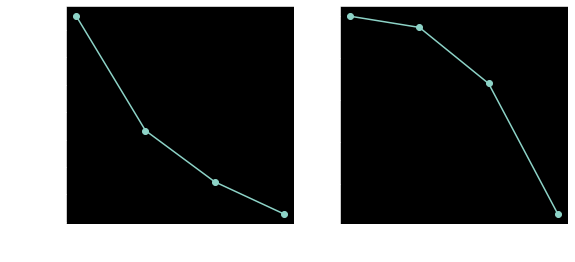

In [15]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(9,4))
    plt.title("Elbow Method")

    plt.subplot(1,2,1)
    plt.plot(k, inertia_values, marker= 'o', linestyle= '-')
    plt.xlabel("No of clusters (K)")
    plt.ylabel("Inertia")

    plt.subplot(1,2,2)
    plt.plot(k, silhoutte_scores, marker= 'o', linestyle= '-')
    plt.xlabel("No of clusters (K)")
    plt.ylabel("Silhouette Score")

    plt.show()

In [16]:
k= 4
kmean= KMeans(n_clusters=k, random_state= 42)
kmean.fit(pca_df)

/tmp/pip_packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [17]:
pca_df['Group']= kmean.labels_

In [18]:
pca_df.columns= ['PC1','PC2','Group']

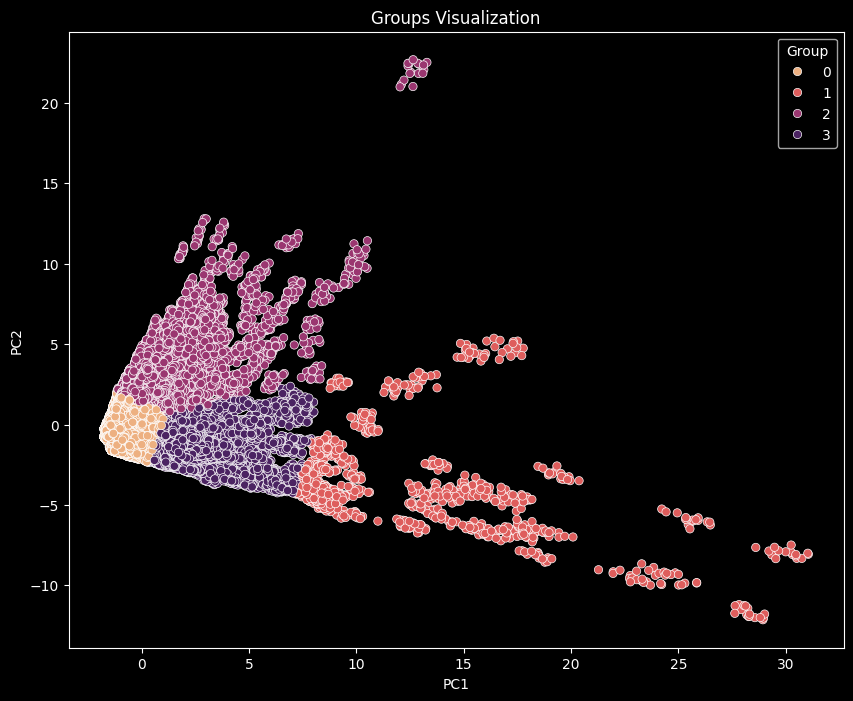

In [19]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(10,8))
    sns.scatterplot(x="PC1",y="PC2",hue="Group",data=pca_df,palette='flare')
    plt.title("Groups Visualization")
    plt.show()

In [20]:
pca_df['Group'].value_counts()

Group
0    85997
2    20461
3    15362
1     1062
Name: count, dtype: int64

In [21]:
cluster_centers = pd.DataFrame(data=kmean.cluster_centers_,columns=['PC1','PC2'])

In [22]:
cluster_centers

,PC1,PC2
0,-0.793861,-0.405865
1,12.722399,-3.938086
2,0.953669,2.978182
3,2.286775,-1.417736


In [23]:
cluster_df = pd.concat([df_original,pd.DataFrame({'Cluster':kmean.labels_})],axis=1)

In [24]:
cluster_df.head()

,CUSTOMER_ID,DATE,AGE,SEX,EDUCATION_LEVEL,EMPLOYMENT_STATUS,HOBBIES,MARITAL_STATUS,DEPENDENTS,REGISTRATION_DATE,...,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
0,PNC32940ed8-682f-4052-92b2-cfdc7f41e,2023-12-01,49,FEMALE,Undisclosed,Employed,Undisclosed,Married,Two Dependents,2004-11-12,...,0.00000,0.0,Very low,Very low,Very low,0.000,3774.789989,1007.999804,0.214444,2
1,PNCe415caf5-6212-4f50-a062-c12bf1eea,2024-01-01,34,MALE,Undisclosed,Unemployed,Undisclosed,Married,No Dependents,2023-07-12,...,819.56020,0.0,Very high,Very high,Very low,11.400,665.611414,589.647700,0.000000,0
2,PNC1ef5b665-11ae-40d7-b364-be8fa02b9,2023-02-01,34,MALE,Undisclosed,Unemployed,Undisclosed,Married,No Dependents,2021-11-12,...,746.10905,0.0,Very high,Very high,Very low,10.920,653.170079,570.829156,0.000000,0
3,PNC436a6069-0e61-47f2-96e8-d11c19e4b,2024-04-01,29,MALE,Undisclosed,Unemployed,Undisclosed,Single,One Dependent,2019-07-12,...,1603.93000,0.0,Very low,Very low,Very low,0.965,0.000000,0.000000,0.000000,0
4,PNCaaa1c8bb-7289-4c25-a05e-efe26e316,2024-02-01,29,MALE,Undisclosed,Unemployed,Undisclosed,Single,One Dependent,2022-09-12,...,1588.94000,0.0,Very low,Very low,Very low,1.060,0.000000,0.000000,0.000000,0


In [25]:
cluster_1_df = cluster_df[cluster_df["Cluster"]==0]
cluster_1_df

,CUSTOMER_ID,DATE,AGE,SEX,EDUCATION_LEVEL,EMPLOYMENT_STATUS,HOBBIES,MARITAL_STATUS,DEPENDENTS,REGISTRATION_DATE,...,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
1,PNCe415caf5-6212-4f50-a062-c12bf1eea,2024-01-01,34,MALE,Undisclosed,Unemployed,Undisclosed,Married,No Dependents,2023-07-12,...,819.56020,0.00000,Very high,Very high,Very low,11.400,665.611414,589.647700,0.0,0
2,PNC1ef5b665-11ae-40d7-b364-be8fa02b9,2023-02-01,34,MALE,Undisclosed,Unemployed,Undisclosed,Married,No Dependents,2021-11-12,...,746.10905,0.00000,Very high,Very high,Very low,10.920,653.170079,570.829156,0.0,0
3,PNC436a6069-0e61-47f2-96e8-d11c19e4b,2024-04-01,29,MALE,Undisclosed,Unemployed,Undisclosed,Single,One Dependent,2019-07-12,...,1603.93000,0.00000,Very low,Very low,Very low,0.965,0.000000,0.000000,0.0,0
4,PNCaaa1c8bb-7289-4c25-a05e-efe26e316,2024-02-01,29,MALE,Undisclosed,Unemployed,Undisclosed,Single,One Dependent,2022-09-12,...,1588.94000,0.00000,Very low,Very low,Very low,1.060,0.000000,0.000000,0.0,0
5,PNCcf3bca5a-b756-486c-882c-dd005b48e,2022-08-01,21,MALE,Undisclosed,Unemployed,Undisclosed,Single,No Dependents,2021-06-12,...,16.80000,0.00000,Very low,Very low,Very low,0.965,617.284634,227.655850,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122876,90f9a2e5-d25f-4dcb-9a2d-b8608f760455,2022-11-01,32,FEMALE,JD,Unemployed,hiking,Single,One Dependent,2002-08-12,...,305.73130,291.53880,Very high,Average,High,18.800,270.797993,220.049841,0.0,0
122877,3a7ce3d5-0f4b-4575-badc-3553f5440c92,2023-05-01,32,MALE,High School,Unemployed,reading,Single,One Dependent,2020-03-12,...,305.73130,339.07230,Very high,Low,Very high,21.200,273.352691,242.288921,0.0,0
122878,e2a8f308-57eb-4f55-bc13-399378f246d3,2022-12-01,27,MALE,PhD,Unemployed,camping,Single,One Dependent,2009-05-12,...,0.00000,482.58685,Very high,Very low,Very high,25.920,474.722440,165.534652,0.0,0
122879,599c0e61-9bbc-4e14-bbfd-b07f5a398669,2022-12-01,33,FEMALE,High School,Unemployed,video-games,Single,One Dependent,2007-02-12,...,0.00000,0.00000,Very low,Very low,Very low,0.000,568.542708,549.300475,0.0,0


In [26]:
cluster_2_df = cluster_df[cluster_df["Cluster"]==1]
cluster_2_df

,CUSTOMER_ID,DATE,AGE,SEX,EDUCATION_LEVEL,EMPLOYMENT_STATUS,HOBBIES,MARITAL_STATUS,DEPENDENTS,REGISTRATION_DATE,...,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
175,PNCadb3e0be-ba25-41f4-bb1b-4d4029a63,2024-03-01,70,FEMALE,Undisclosed,Retired,Undisclosed,Widowed,No Dependents,2015-09-12,...,6587.0928,4784.0924,Very high,High,Very high,137.41,11154.808880,8006.223162,0.00000,1
379,PNC6bf27308-7ad9-4cc2-bca2-9c2a858aa,2024-03-01,70,FEMALE,Undisclosed,Retired,Undisclosed,Widowed,No Dependents,2011-10-12,...,6648.0844,5445.7222,Very high,High,Very high,141.94,11154.808880,8815.362737,0.00000,1
383,PNC34ee0418-8d5f-49ec-b653-55d90625a,2024-04-01,64,MALE,Undisclosed,Retired,Undisclosed,Widowed,No Dependents,2020-01-12,...,8700.4800,2508.4750,Very high,High,Very high,129.15,8952.529720,3130.044809,0.00000,1
410,PNCc19e322c-2530-4475-9778-c46b5d3af,2024-04-01,70,FEMALE,Undisclosed,Retired,Undisclosed,Widowed,No Dependents,2003-02-12,...,6648.0844,4911.3289,Very high,High,Very high,160.06,11154.808880,8943.121617,0.00000,1
555,PNCa0b1e136-f47a-492e-ad3a-8638c3c01,2023-08-01,62,MALE,Undisclosed,Retired,Undisclosed,Widowed,No Dependents,2017-03-12,...,12462.4400,0.0000,Very high,Very high,Very low,217.00,11628.715570,2000.990921,0.00000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120133,780b903b-df24-48ce-a1e8-df34e5d0368c,2024-04-01,69,MALE,MD,Retired,video-games,Widowed,No Dependents,1998-06-12,...,7322.2432,3684.1326,Very high,Very high,Average,110.21,12438.133302,166.084574,0.63000,1
122131,dc88d8d8-5177-48a5-b94a-4a7910a0f6a1,2023-01-01,55,FEMALE,College,Employed,kayaking,Married,No Dependents,2016-11-12,...,25188.6040,254.0820,Average,Average,Very low,35.31,31080.030484,12802.099820,0.72375,1
122132,022af4e7-259f-426a-b3cf-a5dedc0489d4,2022-04-01,55,MALE,Masters,Employed,paintball,Married,No Dependents,2021-05-12,...,28900.6088,289.2210,Average,Average,Very low,34.65,32431.336157,12802.099820,0.69750,1
122133,41dbbd7e-2e94-40ab-8c3a-866481f51690,2022-07-01,55,MALE,Masters,Employed,reading,Married,No Dependents,2021-10-12,...,25586.3188,254.0820,High,Average,Very low,30.69,32131.046007,12683.561859,0.79500,1


In [27]:
cluster_3_df = cluster_df[cluster_df["Cluster"]==2]
cluster_3_df

,CUSTOMER_ID,DATE,AGE,SEX,EDUCATION_LEVEL,EMPLOYMENT_STATUS,HOBBIES,MARITAL_STATUS,DEPENDENTS,REGISTRATION_DATE,...,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
0,PNC32940ed8-682f-4052-92b2-cfdc7f41e,2023-12-01,49,FEMALE,Undisclosed,Employed,Undisclosed,Married,Two Dependents,2004-11-12,...,0.0000,0.0,Very low,Very low,Very low,0.00,3774.789989,1007.999804,0.214444,2
14,PNCa15f21bc-df48-4d16-a5b7-23df94fa8,2022-10-01,49,FEMALE,Undisclosed,Employed,Undisclosed,Married,Two Dependents,2022-09-12,...,0.0000,0.0,Very low,Very low,Very low,0.00,3774.789989,997.276402,0.204444,2
16,PNC33c4a97f-d846-48ba-b79b-89baf176e,2023-06-01,49,FEMALE,Undisclosed,Employed,Undisclosed,Married,Two Dependents,2013-12-12,...,0.0000,0.0,Very low,Very low,Very low,0.00,3897.880967,1109.872125,0.206666,2
19,PNC17422881-4f07-4c03-8409-fc8497639,2023-05-01,49,MALE,Undisclosed,Employed,Undisclosed,Married,Two Dependents,1999-05-12,...,0.0000,0.0,Very low,Very low,Very low,0.00,3815.820315,1109.872125,0.204444,2
34,PNC70cee698-e367-4e58-a695-04e0bb35c,2023-05-01,49,MALE,Undisclosed,Employed,Undisclosed,Married,Two Dependents,2014-06-12,...,0.0000,0.0,Very low,Very low,Very low,0.00,4308.184227,1168.850837,0.235555,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122853,d3e5d939-04fa-4cfe-81ee-4ecff3248b52,2024-04-01,44,MALE,High School,Employed,cross-fit,Married,Two Dependents,2008-11-12,...,0.0000,0.0,Very low,Very low,Very low,0.00,1121.827315,1509.762951,0.000000,2
122854,4f6fb9d4-be51-4fc1-9bcf-386a9b4fb9f0,2022-06-01,44,MALE,Associate,Employed,base-jumping,Married,Two Dependents,2022-08-12,...,0.0000,0.0,Very low,Very low,Very low,0.00,986.340925,1538.520340,0.000000,2
122855,5d22b285-bcb9-4daa-b961-c7843bad75f8,2022-05-01,44,FEMALE,PhD,Employed,chess,Married,Two Dependents,2016-11-12,...,0.0000,0.0,Very low,Very low,Very low,0.00,1018.857658,1509.762951,0.000000,2
122857,8e33d093-7672-4f21-9e76-03e75a8c074e,2022-05-01,52,FEMALE,Associate,Self-Employed,reading,Married,Three or More Dependents,2005-05-12,...,79.8735,1476.6,Low,Very low,Low,7.36,6448.450204,1932.687351,0.000000,2


In [28]:
cluster_4_df = cluster_df[cluster_df["Cluster"] == 3]
cluster_4_df

,CUSTOMER_ID,DATE,AGE,SEX,EDUCATION_LEVEL,EMPLOYMENT_STATUS,HOBBIES,MARITAL_STATUS,DEPENDENTS,REGISTRATION_DATE,...,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
10,PNCa3755563-44e5-4e81-9e6a-fc6ff0da9,2024-04-01,67,FEMALE,Undisclosed,Retired,Undisclosed,Widowed,No Dependents,2018-05-12,...,6722.76150,626.4258,Very high,Very high,Very high,59.520,6862.659474,204.998200,1.00000,3
26,PNCb39f76c8-4554-4f8c-8075-574daec81,2024-05-01,49,FEMALE,Undisclosed,Unemployed,Undisclosed,Single,Two Dependents,2015-04-12,...,2625.24150,653.1616,Very high,Low,Very high,26.910,638.676873,446.088382,0.26750,3
28,PNCe0fcf2b9-0402-416e-9b05-3ef66270c,2022-04-01,67,FEMALE,Undisclosed,Retired,Undisclosed,Widowed,No Dependents,2003-03-12,...,6082.49850,633.3096,Very high,Very high,Very high,61.760,5782.426038,186.181940,1.00000,3
54,PNC3c95c9c9-efed-44d2-9af6-5e8acada5,2023-03-01,36,MALE,Undisclosed,Unemployed,Undisclosed,Single,Two Dependents,2021-06-12,...,394.76240,1855.4076,High,Very low,High,24.700,1713.847635,268.717645,0.09000,3
55,PNCa981082e-046f-41d4-890e-61035dbdf,2023-11-01,36,MALE,Undisclosed,Unemployed,Undisclosed,Single,Two Dependents,2019-04-12,...,405.26140,1821.0482,Very high,Very low,High,27.560,1738.686007,271.229025,0.08625,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122757,35aae655-5111-41cc-bdda-f57e0685ee23,2022-09-01,36,FEMALE,Masters,Unemployed,board-games,Single,Two Dependents,2018-09-12,...,2103.34750,2154.8100,Very high,Very high,Very high,69.345,4128.273225,171.600284,0.00000,3
122758,e2dabec5-6d12-49fb-a843-31225fbfb500,2023-06-01,36,FEMALE,High School,Unemployed,yachting,Single,Two Dependents,2009-09-12,...,2136.55825,1980.3730,Very high,Very high,Very high,62.980,4051.823720,198.000328,0.00000,3
122784,cefe5ad0-b9e2-4e2b-9bb2-d74caf9d6562,2022-12-01,43,MALE,Masters,Unemployed,sleeping,Single,Two Dependents,2019-09-12,...,2333.93880,1273.0432,Very high,Very high,Very high,68.080,4766.566222,219.075443,0.00000,3
122795,e1f9206a-d67e-4ba8-a47f-41101e06eb29,2022-11-01,50,MALE,College,Unemployed,dancing,Single,No Dependents,2022-03-12,...,0.00000,2361.5572,Very high,Very low,Very high,37.720,2781.542766,153.226966,1.00000,3


<Axes: xlabel='Cluster', ylabel='count'>

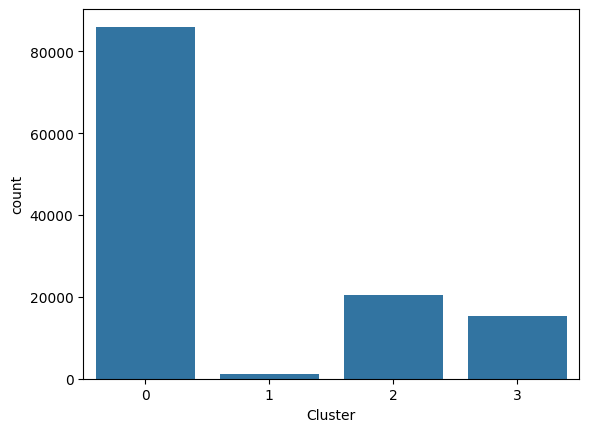

In [29]:
sns.countplot(x='Cluster', data=cluster_df)

In [31]:
cluster_1_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85997 entries, 1 to 122880
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUSTOMER_ID                       85997 non-null  object 
 1   DATE                              85997 non-null  object 
 2   AGE                               85997 non-null  int8   
 3   SEX                               85997 non-null  object 
 4   EDUCATION_LEVEL                   85997 non-null  object 
 5   EMPLOYMENT_STATUS                 85997 non-null  object 
 6   HOBBIES                           85997 non-null  object 
 7   MARITAL_STATUS                    85997 non-null  object 
 8   DEPENDENTS                        85997 non-null  object 
 9   REGISTRATION_DATE                 85997 non-null  object 
 10  BANK_ACCOUNT_TYPE                 85997 non-null  object 
 11  BALANCE                           85997 non-null  float64
 12  BALANCE_

In [32]:
cluster_1_df.describe(include=['int8','int32','float64'])

,AGE,BALANCE,CREDIT_LIMIT,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
count,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.0
mean,28.488424,981.036725,3739.682801,392.453105,0.077286,1.383431,523.649385,287.896728,236.064047,9.067885,980.979823,546.462819,0.136226,0.0
std,7.288076,1120.294068,2818.883535,755.003071,0.116443,2.342937,602.308363,488.171216,365.180698,10.500832,1100.289447,1225.624275,0.271976,0.0
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,23.000000,81.492922,1590.000000,0.000000,0.000000,0.000000,41.340000,0.000000,0.000000,0.940000,332.383968,149.032733,0.000000,0.0
50%,28.000000,645.237809,2820.000000,0.000000,0.000000,0.000000,308.962500,11.060000,53.010000,6.210000,647.368140,235.851019,0.000000,0.0
75%,32.000000,1472.581155,5250.000000,432.940060,0.130000,2.000000,809.497800,390.550000,352.716200,12.840000,1243.859097,560.582930,0.103500,0.0
max,70.000000,8683.091745,24840.000000,8447.199333,0.750556,21.800000,3941.816400,3978.314700,2585.392800,107.115000,15368.273078,27486.340911,1.000000,0.0


In [33]:
cluster_2_df.describe(include=['int8','int32','float64'])

,AGE,BALANCE,CREDIT_LIMIT,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
count,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.0
mean,61.324859,5062.305961,13483.996234,1147.369176,0.070039,2.613828,17844.426400,11705.463495,6030.274753,144.184101,17702.567360,3990.130234,0.388355,1.0
std,6.041712,4109.389766,5338.927049,3647.005851,0.190664,8.439337,9424.255917,10016.158469,4514.072021,85.985219,10271.543949,9887.888387,0.409753,0.0
min,51.000000,323.958220,2576.000000,0.000000,0.000000,0.000000,7042.926800,0.000000,0.000000,2.760000,2446.486783,144.148875,0.000000,1.0
25%,55.000000,1934.647886,9315.000000,0.000000,0.000000,0.000000,10812.944850,3774.734175,2944.375863,81.765000,10091.078820,465.977841,0.000000,1.0
50%,62.000000,3280.011015,13195.000000,0.000000,0.000000,0.000000,13621.419600,9635.962700,5204.072600,134.820000,14505.557409,1121.449168,0.175834,1.0
75%,66.000000,7840.130694,17000.000000,0.000000,0.000000,0.000000,23501.068500,17618.018400,8410.746300,201.770000,24166.958488,2813.434786,0.861667,1.0
max,70.000000,19043.138560,30240.000000,21269.687565,1.090000,52.320000,49039.570000,43873.984800,22500.000000,378.230000,51154.352082,76406.207520,1.000000,1.0


In [38]:
cluster_3_df.describe(include=['int8','int32','float64'])

,AGE,BALANCE,CREDIT_LIMIT,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
count,20461.000000,20461.000000,20461.000000,20461.000000,20461.000000,20461.000000,20461.000000,20461.000000,20461.000000,20461.000000,20461.000000,20461.000000,20461.000000,20461.0
mean,45.795122,4560.514846,7522.994679,4285.785635,0.466486,13.352048,534.791748,324.803575,209.177343,8.588684,3460.788953,2090.416780,0.031487,2.0
std,13.976907,2743.738908,3721.430985,3484.209754,0.226274,11.504092,945.885518,671.251169,473.179236,15.859315,4092.139488,4207.169738,0.091349,0.0
min,18.000000,47.308404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,33.000000,2484.990277,4750.000000,2172.681644,0.303333,6.510000,0.000000,0.000000,0.000000,0.000000,1169.079040,728.261400,0.000000,2.0
50%,45.000000,4207.331216,7020.000000,3497.645511,0.445834,10.700000,91.527800,0.000000,0.000000,1.080000,1954.547058,1311.177499,0.000000,2.0
75%,58.000000,6137.809574,9650.000000,5304.741067,0.618333,16.800000,680.922000,333.214500,184.425200,11.040000,4141.923519,2066.803089,0.000000,2.0
max,70.000000,17772.329282,23435.000000,47137.211760,1.500000,123.000000,8059.656200,7212.520800,5565.518200,154.780000,42562.971406,66524.464274,0.999167,2.0


In [35]:
cluster_4_df.describe(include=['int8','int32','float64'])

,AGE,BALANCE,CREDIT_LIMIT,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
count,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.0
mean,47.185067,2115.507437,8045.726907,337.290861,0.046266,0.934382,3918.190902,2461.620283,1450.115388,53.029973,3916.008463,1113.468289,0.322740,3.0
std,10.707943,2493.125284,4258.729104,878.137651,0.100188,2.325633,2084.979405,2084.280539,1253.970342,35.829158,3325.661424,2770.305992,0.388923,0.0
min,19.000000,0.000000,414.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
25%,40.000000,345.110229,5000.000000,0.000000,0.000000,0.000000,2480.050000,1010.143850,545.542512,29.160000,2020.969841,188.118963,0.000000,3.0
50%,46.000000,1042.605410,7245.000000,0.000000,0.000000,0.000000,3411.166800,2059.760775,1230.297800,45.540000,3104.644457,341.068649,0.087727,3.0
75%,55.000000,3080.246238,10350.000000,19.814869,0.075833,0.910000,4825.586400,3374.663100,2001.164400,68.670000,4805.840872,1053.910575,0.727122,3.0
max,70.000000,20160.158820,30000.000000,8218.935011,0.817500,21.230000,15210.050000,15494.350000,8927.842250,336.810000,44284.078812,54784.227822,1.000000,3.0


In [42]:
columns =  df.columns

In [43]:
columns

[Index(['ClusterBALANCE', 'ClusterCREDIT_LIMIT', 'ClusterCASH_ADVANCE',
        'ClusterCASH_ADVANCE_FREQUENCY', 'ClusterCASH_ADVANCE_TRX',
        'ClusterPURCHASES', 'ClusterONEOFF_PURCHASES',
        'ClusterINSTALLMENTS_PURCHASES', 'ClusterPURCHASES_TRX',
        'ClusterPAYMENTS', 'ClusterMINIMUM_PAYMENTS',
        'ClusterPRC_FULL_PAYMENT'],
       dtype='object')]

In [ ]:
cluster_4_df.groupby('Cluster').mean()

TypeError: Could not convert PNCa3755563-44e5-4e81-9e6a-fc6ff0da9PNCb39f76c8-4554-4f8c-8075-574daec81PNCe0fcf2b9-0402-416e-9b05-3ef66270cPNC3c95c9c9-efed-44d2-9af6-5e8acada5PNCa981082e-046f-41d4-890e-61035dbdfPNCa9c18321-b433-4091-a391-aaf14f845PNC5c77572d-3bd1-4a95-82fa-e3077acf0PNC4d99f8ef-0151-4688-a3ff-f1f38f4d9PNCa62e2a93-3c68-4e31-a496-3b582ed49PNCb1d60ab7-43a2-4c96-adf3-db0a48eb4PNCdc4dc353-67ea-47d1-88f0-9d7d1e5caPNC204ea403-c3b5-439f-97df-4992a32fdPNCb275c6a4-2200-490c-bbfd-7a4f303cePNCa885b12f-95b3-47b7-be68-f6843ec51PNC2d1fcb45-2b21-4a60-ac1e-40c0626afPNC0e0d89ed-1263-44f5-a89b-9fd69ab61PNC988dcf4d-7e7d-47ba-9c3d-553257179PNC463f8b05-d9ca-412d-a304-1401ac810PNC35eae40d-ae21-4ea9-aa92-f3235267cPNCc3fea2a8-65ab-4b66-8458-bd88f0459PNCb3c1bf83-dd80-4137-9c8b-60dc8ce1dPNC27133018-ec3d-4487-a3d3-42d6b0b04PNC07d7743f-92c8-45c0-9e60-61373857aPNC8cd97f57-c598-4932-acf2-f3cd7b21aPNC665f2e5f-4a74-4f42-a133-4503f5a04PNC54b0448e-542d-4ae5-b77b-d61d086d2PNC8c4498e5-6225-4ad5-aee4-7d4b4930aPNC133b7408-bee2-4ab8-bfff-d5a86d5c5PNC1dcfcc42-70d4-422e-a8b7-200a4685aPNC593c37ba-5a58-41d5-96c9-7b8a6f788PNC157af308-8d08-4a3a-9ff3-23b840592PNC30d3118a-552c-46ca-bfac-0b2aa9f45PNC9fcc4577-928c-4d91-8c4e-226599c4bPNC35bab0d5-19b7-45ca-8d3d-287d88505PNC9f494776-47bc-47d0-9123-d14be8172PNC2f1196e9-4526-44b9-a5b1-8ca038668PNC8681060e-c852-44a2-a8b4-056126c3ePNCe54f712b-9180-4c65-94b2-6316c390bPNC05c5b94d-c204-49eb-9b3f-d6f959fa4PNC36cbc79c-5cf7-4f97-aa29-e36e9d0b7PNCead124d0-6053-44d8-a4ef-5d6834179PNC81231ee1-40ad-4c73-bb8c-9c24c1a0ePNC0c036731-b296-4386-aeb9-243c08aecPNC9658b666-11b6-4090-b911-d94d30e58PNCc169d9d5-2b70-49fb-8f22-54c130b8dPNC496a51ae-4cd0-41c9-af64-a34f7036aPNCdbbcbdb4-ce6d-493f-b9d8-b6ebfff8cPNC2c2ffad0-c618-4314-a04b-d348a42a6PNC06155512-532a-4dad-b79b-9e618b3dfPNC02450794-70d2-458e-8bbe-e99a6ba5ePNCb0954c61-b624-4c65-9787-b6d60178cPNC838911b5-478e-48c5-bca9-f16c1bdffPNCaa2fb531-b2d9-4a1d-a7e9-88b36266dPNCac619723-bf6e-4045-8e70-91c161460PNC5d31e987-06af-4f1e-a70f-0d0611c6ePNCcf6a46ba-8e9d-4297-ae97-3aebeef93PNCcc8c4c1b-4ee2-4ba2-8a26-0675d8b84PNC60ddb4a2-bc32-40ec-9e89-41202cf20PNC29076ba7-4e0d-4bc3-9cba-913918e2cPNCb44acccf-e73d-4c24-ae7a-d2266faa8PNCbf439a17-f521-4766-a4e8-daa5811d9PNC49f648a5-1134-4e2b-affe-07fc2668cPNCde29cbb0-a5ba-4d4e-b7ee-d9d99792dPNC85d252a5-bfe3-44cb-9975-d97ffb56bPNC4128937f-67cb-49dc-88cf-159c4c4d2PNCa3e80355-438c-40b9-8806-736dab477PNC47b7baef-117a-4058-a6ca-7320986eaPNCf6e26a01-4fd7-425f-8975-8728d033bPNC9f599f33-7d58-45c7-8b6c-a0c46270ePNC0ebc3ec1-23a4-4631-9dda-6f7906849PNC632ae9ee-c855-4f27-a6af-8ded2707aPNC3eac4092-cb14-4edf-892c-139739f93PNC964149e6-c048-4f59-b0aa-c7dba6ec8PNCc2c3424b-1d5c-4d56-98a2-24b61a6cePNC29a2a73d-ba8d-4746-b36f-0cd00ba6fPNC3455f9a7-f45c-40ee-b93b-7ffd7dad9PNCba7464fb-f5a9-4440-9433-432407f52PNC803afe1d-6198-4948-9a86-6e817b249PNC6f809f42-c08e-4939-aec3-0dc2af862PNCf2dba2a7-06bf-40af-bae1-7ee6020b6PNCc44b443c-cef7-43be-86cf-7380ee83aPNCdbf94c21-2161-4320-9f75-57d3f5b46PNC8f8cb76c-59b3-470e-b92c-e0580967aPNC170310c1-df94-47ca-968d-04cb66801PNC46af5d8b-5068-45ea-b668-f688e7133PNCe3322cd6-3658-4840-8e5d-e5ffa5cf6PNC2b313c2d-5b69-41ef-b710-6ca7a8fdcPNC6c0bb7be-63ce-4c8d-a09e-bfd25fae7PNCd08b6ca1-de8e-4e7d-8d33-957a3d3b8PNC2f03ac0c-286d-47b5-b97d-935abc4f9PNC3471c632-fd56-46e7-9c1e-085455e05PNC12ec0f21-0120-4d82-b943-9741f3d86PNC07298b8b-73dd-40d8-9917-302114a20PNC10965709-927c-44dd-a5a8-fdcd12fb6PNCb321c7c9-e112-4464-8cbc-9fd7a2a32PNCdf07eff1-c9b1-4f7d-9448-7383c8d48PNCaaa21e93-6ff5-4e03-a7b9-08c643274PNC369211dd-1daf-4698-852f-1391385d6PNC3a71c9ff-6a04-473d-86b1-cf6c61f70PNC32607401-1099-4d0f-8031-3700a27e0PNC4fd3f36c-39b0-4c4c-a866-b7a02a27ePNCa74d87f9-ad09-4d7e-9a58-fdbb0cf3dPNC745acb68-c350-4c18-badd-3f208e5e6PNC77c59941-4b3c-4853-9653-aba3db60ePNC9b87b89d-01c3-466f-9315-32ba5f3f6PNC47452e83-87d5-435c-9a5a-a32d28314PNCd05921f9-a2a5-4e12-9c99-29d360f52PNC19e0e0bb-c0aa-4b67-80bc-7216d648aPNC587260e9-c364-474c-890a-f6766a5c2PNCc4ab322a-d773-4e74-8b1f-28d2ff9a1PNC8c6a16c6-9ee0-4a7c-8605-36dc14f2fPNCf40a656d-1ec5-4186-a97b-a33e3a330PNCe17e76c7-47cb-4cbf-8be3-4ef005b12PNC4cc63eb0-e71e-47f2-810c-10d79b452PNC52fcf569-b575-4a60-821c-7bc4a464fPNC557c9ab4-f933-4ae5-8a94-99ce61bd1PNC6e705e6e-ac94-4045-8dee-f10673257PNC41461558-bd77-41fa-8e4f-ffd517a45PNC73fce80d-c501-4fbe-bbc7-3b23b3a86PNCf96ecf76-7ee6-4c50-a5b9-2ffdd3236PNC7fae945b-5f2a-4849-8304-6c8ee54b4PNCdf74d31f-877c-42b8-9474-20067665aPNC4d1f25b4-13c3-4866-963f-31b767805PNCf7f98796-8c52-4008-a96e-38f0c2690PNC5f4fa99e-1ab1-43dd-a591-8eff9e0b6PNCad3141c0-9c70-4d66-ab93-eeb6b267aPNCcfd7d0c1-4141-4f33-82d0-6ae20d3a7PNC97254f4a-f416-4118-88c0-4d141fc3fPNC44d0442d-07b0-4c8c-8218-03c7f0ffePNC928a2978-1449-4d28-bae7-5594323f3PNC0b90923a-c60c-4bcc-b404-d6197dbbfPNCeca6985d-d9f1-48f5-b27b-805bdc8b3PNCe42ebcd6-85d0-4176-86a7-07c703f9fPNC855bcb2b-335e-449d-9c6b-820d3287dPNC5b0f0392-c7c4-4ee5-844d-5ffaa2be8PNC6e1255da-1d9a-4bc1-8e4e-3f01c5d28PNC5df8cc68-9ac1-466c-b6e4-3ddc517e8PNCd90a5dd7-7ec4-4d31-add4-d9dd6a0daPNC22a54ab2-6806-4c64-be60-f2474afc7PNC746ebc40-d961-4702-a136-55667c3fePNCf8369ce3-cdec-4b32-a688-f5990a9f7PNC69bc417c-192f-4555-89ef-09cfbe9a9PNC5a02fde5-5dbd-4b8b-a1cf-e3ef996fePNCcb62205d-dab1-46c5-8802-5dc47bd60PNC8a6c69e1-2441-4a45-a22f-de933a3e7PNC13de50e3-6446-4180-bb64-b226ea774PNCa8d4c36d-d11d-4beb-85fc-273083185PNC8157305c-b655-4656-a6f0-cb7c0b9d6PNCee752120-f563-4781-9f47-b970db110PNC9e29f4d9-597d-4ec7-b156-5e6c58782PNC1d442a52-e6c6-49c2-8376-825346467PNC6e08dbd4-62ed-425e-b397-09669dca2PNC333d2b6d-8b34-4fe7-a820-74aed0eb0PNC7dc99055-3eb9-4547-98a4-d2e33b6a5PNC43fdb01f-54a8-4861-86a7-1a788abffPNC76098bba-d4ef-4b5a-b329-e7dd34ed0PNC80a2a71f-5f76-4d1f-871f-99ce0c62ePNC7d957cda-d270-4acc-b7c3-20dc30c6aPNC8107360c-70ed-4ccd-ae03-731abfd3fPNCbb8f9390-b655-4a41-9c19-ef5055146PNC56c3722e-e4d5-420f-a5f7-61611bdf7PNC4f90f292-8958-442a-9307-2227631dePNC2c776346-7a88-4c55-b675-a5aa76a4ePNC47742de7-877b-4a14-b46c-47b787f9dPNC3b58f043-ef10-4dcc-976c-b7170b56fPNCc0b690e1-c58e-4250-bbbe-4132f8667PNC21ab9306-acdc-4795-b982-73ae059f1PNC09fa1ed2-bede-42e7-b0f6-d7831f4e8PNC4b32e4ef-e158-423f-ae16-1cf4daf6ePNC09079b30-5e2d-4d65-9cf4-4e6305d45PNC92803d06-a255-4b31-815b-406b808dbPNC89230f1d-5ff8-4b07-bba7-aebb0929dPNCeb49484c-ebb5-4ade-9524-ae07c54a5PNCd021f021-325c-4d82-80ff-1c06adf64PNC66d21913-38b6-42b8-8d7c-5b5e50aaePNC1d1f0558-f460-40d6-9abc-28213a76aPNCbc5b4da0-e45f-44bc-a3ee-172917ad2PNC2fe96924-d3f0-47e9-b29f-c6679994aPNCa97bc310-ee0f-41cc-8c1b-435f0572aPNCe12923ff-6858-45c2-acba-3e87b7552PNCb1e59469-5cf1-4871-885b-70b19766dPNC96408898-634c-4408-ace9-f9aa37088PNC7cfa9eab-3a72-44c8-a073-57afe43f6PNC8bd3555c-833d-4adb-8052-f45f9f12cPNC5b0cc4a3-15a6-4bfa-a8f0-334031ef5PNC02536672-58e9-49d4-87da-697f05a07PNCb7bf8479-bbdf-4d53-a06c-95595d39dPNCdd1df4b1-722b-4939-a8ae-61d541a1ePNC07553842-700b-4d1a-8d41-2e20086d3PNC79fa1be6-64e9-4375-98ad-996bbcf5fPNC31e905ea-f1aa-45a6-add0-01ec55c52PNCc35184da-4df6-434f-ae41-e811adc0cPNC6cfe5c3d-e3c9-44f8-bca9-f30c75adcPNC48222dd3-a524-426f-a1c1-7db831b6aPNCba73140b-db19-47bf-afda-d497059dfPNCf496f35d-d64b-42f2-b093-7497f54a3PNC08411fc2-44d2-4d4f-93a3-a9a8914ccPNCac5186bd-156c-402b-bce4-bee8efb2bPNC06f3de74-d78f-4108-8134-190c3955aPNC0cbe7452-4676-4369-83e3-036141cfePNC795a6c76-7949-4007-b0d5-2a9bad88bPNC73d4f29e-6976-4a81-aedf-7225aad39PNC3db54198-3c2a-4c7c-b60c-4101c7620PNCb2f6e264-0e44-4ea5-9f65-828377ed8PNC9d6cd593-97ef-4d52-9223-3bc4927dfPNC977ab5a2-bafe-47ac-8f7f-e7d898236PNC18e86f94-653d-4b85-98a8-f4abf2cfePNC0f7fc011-4f2d-4352-a2f8-e24ecb1e2PNC39aeaea7-1e7e-42fa-99bf-9d54413fePNC3ddd1508-6660-4dda-b871-d46f691bfPNCac96a681-009f-4183-9df5-7b9a4f8bbPNCf9eadcef-91a1-4485-b005-98412eff3PNCb9d35766-60e4-4a8d-a217-537750cd1PNCa4bb06f2-7ad6-4166-9b41-9471f81a6PNC680c97e0-72e0-4485-89fb-115f3e977PNCdbdd3118-a25c-448f-939c-594dc0518PNC0551e05f-360d-4dc4-820e-5acdca9c8PNCfd947de7-9cc5-4272-8104-d50d73913PNCe8df36b2-169d-4a66-b1cb-7cfa132dcPNCbdf908ab-00e5-49fa-a581-9dbbd5296PNC404a7919-a34e-462d-850b-7c5881031PNC6e39fd47-e84c-4bbd-bdfb-57f660300PNC14be5d46-099b-4635-b9e5-0591390ddPNCd4dd0bdc-f460-47a2-8bce-072dd7be7PNCa49fc94a-cb80-422d-be8b-a90e60371PNCaa55691a-4b17-417b-b4bc-0402eb039PNC2a86a95e-bb11-43cf-94da-f4460ad3fPNC56e44477-ddb6-4ca3-b8e4-87d6ddd30PNC775cbe0b-ba11-4292-87fb-7de336116PNC26f60f38-ef62-4d5c-ba7e-264726946PNC8c7383cd-46fa-4d06-9029-e802d0fd9PNC44475a63-5311-4aec-8463-91bb34091PNC39b3ce6e-6767-4cf2-b946-dd6f92c18PNC675af5ed-bd02-4726-a505-ef3fb09d0PNCa130850d-c708-466d-86b4-0c522ce26PNC17cb5c62-ece0-4888-b920-a2d157011PNCa340055c-c405-4024-a5f0-185b9b1d7PNC5cef1775-fa37-4e97-a5dd-e184ed071PNC8df815a5-e4f4-4f1e-ae73-4a1d47d73PNC834a2954-ab80-4147-a5e7-bcff8df5fPNC0a86ddc0-55da-4371-aeb9-bc97f6f85PNCaf959d1d-4491-42e1-97c5-cbb30e162PNCf96886ac-ff37-43ec-944b-680ef22e6PNC32493d1a-40a0-40bf-bfe8-cbe2db70fPNCdf376415-893f-47b3-917f-40869ee56PNC3043fb9c-6aed-40a7-ab39-f9f095fa8PNCfd81bcfb-3b9f-4b5d-b123-6de14a74cPNC8ca00d43-9499-47be-938a-15a47a1cbPNC3cf5b774-c904-4299-90ff-fae9e86a6PNCc0937fd9-123f-4336-8a4e-977736527PNC083cdda4-4f70-4eb4-bcc6-b6fe6afddPNC2bc2aa5b-87cb-44ee-a92a-7745ba11ePNCf077ce7a-a783-41ec-ac5e-6c1c2e62dPNCa24726a8-a210-4151-84c3-f15dea929PNCee33b6d9-b980-4a57-a56c-2a4ab88ecPNC38b2ea9b-5c95-4c85-a1c7-fba7df3ebPNC31ea4467-0996-419a-b495-5da2d4761PNC63bb77d3-1066-40b2-9361-24c698ba5PNC9533bc48-72eb-4653-9ad9-bb9fda211PNC1fd35ced-a384-4aea-b093-955cba8b4PNCe48ede2e-4941-42fb-a4e3-92fe159ebPNC6941c6cf-5a50-428e-8b30-8c871c675PNC702de833-941a-4e0c-bfa1-2501072e0PNC49d6cbcc-8059-4523-8e3e-e94a6fd93PNC86d83c7b-36e5-4ed3-84e8-81c725e96PNCb55ab316-29ce-4e5c-8d06-b540d4755PNCcec7b070-33eb-4ef2-859b-3d3ce62bbPNCd9628114-fcc4-4dc0-acf4-9446cddbaPNCa28e0ad1-c222-4ef6-bf56-17a8e0824PNCd504421b-be5a-4159-a927-f25f51dc5PNC42dd6f69-4f49-4b69-a9fa-79fc8c9bcPNCbc8f14cc-88b7-457e-b784-cd12aa4d0PNC77ab2f41-ccf3-46f6-b8ef-737458f9bPNCb3c036b8-9166-4e19-985f-b41ea8fdfPNCa86f3a14-bbfa-4202-ad76-ca6c82b72PNC9b71df1b-58e3-4d88-87eb-63051b57cPNC9cb24eff-5458-4c80-ba2f-45b132d69PNC9d65f9c0-ceeb-4cde-8ecf-7db6f5605PNC91c21238-0aff-444a-8f4a-26e1cde89PNC2f4170b0-3c59-4152-926a-249033b49PNC921a9509-188a-48c8-9646-0a000a3d5PNC840ffdb7-dc3f-4e53-a365-0e8c7beabPNC54dd34f5-596e-4131-8fbe-96fe9f90cPNC6acd9d68-eddb-4b4f-b762-f73854854PNCe1c39e98-f771-4b71-926a-0a4f31891PNC48dc0b27-8121-4c1e-a39e-c3720020dPNC71a8089a-eadc-4f6c-86a0-122db3addPNC6894377d-9817-47fc-af96-f3d9c9d30PNC28e294f3-7a50-44c3-b742-2ad70e6d9PNC9b804909-029c-46bd-a86a-70a52d335PNC559bdf4c-e713-4093-8d60-32640b288PNC96855644-db8f-4f57-abd6-b2f33f522PNC91deeee3-790e-4a27-ac75-524bf5d36PNC86716d03-2597-49e6-90b3-d2bfa33cdPNCa2cec9f1-7434-4b9a-989e-8a8a97f1cPNC812af2e8-0bbc-430a-a2d3-89d06c684PNC72f82117-482b-4a42-bf42-cfa6d8489PNC3091a454-06ba-443c-bf3f-616754f04PNCd3205680-aba3-4d57-8e11-29c4dd3d1PNC4171214f-3656-4f03-9d1b-e333619fbPNC57dcf9b1-b1ae-4c6b-ae5f-948992cf2PNCefc8776f-e525-44f8-892c-54109b811PNC19383cb0-874e-4cc9-8ec4-f6af6882dPNC378a2d47-a260-4dde-a67e-d84c645f3PNC5db9f5a3-cdb3-4165-8aeb-999471c66PNC6a997491-f520-4717-bcfe-1852309cfPNC7af29479-8d6a-4c3d-9581-70449c8daPNC985f9e4e-c353-4f71-9359-82f181544PNC8216803e-5553-48ba-843e-901551a68PNC48120e4c-d27d-4040-82f1-d40e679d0PNCef2cb121-db5d-4a24-8654-935d128e5PNC2ce4f929-dd18-4230-8022-5f0864d12PNCfed52531-8ab5-4e10-9dc4-206ff59b6PNC1648e992-6d72-446e-8a71-9c6e715c9PNCc615db8c-46e9-4816-9e0f-d78b2de42PNC7224f109-22c3-451e-bd32-6a4aae4cdPNC279f90f0-3b38-4f8a-9d6a-52a4eaab8PNCd4a67a4e-47d8-4115-a8fc-d57d1a12bPNC0ee91478-ccf1-4e94-b908-3885a6fc0PNC2dd77038-9016-4466-beea-3f0204e10PNCb484bb90-45de-4ba0-93d4-7dd91f605PNC4b0af49e-d008-4bbd-b5ad-f276d9a2cPNC4e3f08b0-cee6-4809-8ad1-11abd0012PNC1eb27751-c333-4616-ba0b-25cacad2cPNC00b8782b-e2af-4ee8-9c82-7cde13c94PNC6e3427d1-2ef7-45cd-8689-faff35d43PNCf2373f7c-2217-4e80-9c8c-aba4b854dPNCa1206473-bf2a-4257-8f99-eec54af3bPNCfbd6cc61-5818-497f-9093-748f73c59PNC57297c7a-29e4-4f83-b0ed-627507a70PNC4c9c1c2a-bea3-4619-8e37-3a720c96dPNC9907d58b-5a45-4b10-849e-aab7ec92dPNC0f8c5cad-c7d9-4c48-ab53-64b4e6816PNC5fd12417-0faa-47df-887a-220eb2b38PNCed9dd306-d362-4ec2-9e3c-7bc9c6168PNC3493c3c7-118a-4642-9def-2b760bad1PNCdcbc8a85-dbe5-4c58-b27d-5c2d20a99PNCbb8957f2-1b03-4c6c-be67-9eaf97df4PNC643f1542-3223-46da-942a-fdd6a51d6PNC60619fa0-883b-4064-b699-484e126d1PNCae994bd8-bedf-4992-b54b-a26f995a9PNC88f171f8-1a7a-47fe-8606-2f1615d43PNC34b864db-308e-4325-b26f-972ae6535PNCf13eba11-54c5-49ae-bba0-ca06b345aPNC8c6d52fc-e9ff-413a-8b9f-4789cefb5PNCe10f332b-3a5f-462c-9beb-63f8ff492PNCe7727fc5-7e09-4f21-957a-47e2d27d1PNC1e211924-d7d4-4342-ade4-4ebd23f8bPNC20dad05c-2341-4a4c-9081-ad0d3ca8ePNC0b2e2cc8-6ec3-41d2-a561-d9ade9c65PNC501e2c25-5571-4f74-9bac-d44ca744ePNC13b98a74-681e-4fca-9709-0b954c1a2PNC64e535c8-77ad-4fc4-b522-0853f89b8PNC42030932-a2bb-4d52-b3ef-48d4de044PNCc11a83a4-b425-4091-9c1a-1a37452f3PNC21465dd9-b0e6-4088-8c08-795d74924PNC14e56994-25f9-40fe-bf26-0413bb03cPNC4c006eda-f0b5-4751-91b7-fe08882c5PNCb598e1a1-e9d8-4d4a-a4dc-b721eb396PNCa4de5728-7f82-40ca-9c8c-80345067ePNC91eaaf7c-5215-4bf2-ba11-2836ddb5dPNCcc26e208-7b68-47af-94d9-634755875PNC65b0eda0-14a0-4102-a8f7-7e0e00c93PNC1c2edeb2-2118-4e78-a0c3-124b3c4abPNC5a0342b9-fe2f-4fcf-a580-fd3422d5aPNC77fc12fa-67a5-4829-8ced-a94938295PNCd47ca40e-256e-42a5-aca8-24cfb618dPNC4c52543a-3b0d-48c6-a366-7267cc674PNC912a2d4e-33d2-42cf-88f4-a79666b07PNC66d5fda9-6414-43b5-bc64-734a8a3ddPNCf8a923ef-bd36-423a-9bb3-51ba42766PNC3642ccb5-e989-454c-9f03-919923881PNCa744b0ad-5976-43df-b5da-dbc19ccb8PNC5fe9edca-ad12-4934-b2c1-a94f622d6PNCe6ab13df-85b1-4358-af8c-795d6de56PNCde197d28-98a1-4748-878f-a9556c029PNC773cbd22-bfeb-4286-9142-7b85a2575PNC24743b0b-d8b5-4496-b4b8-98f41833fPNC86d838c9-2824-4224-b54a-53bd8b3c2PNCb29112ff-f2a1-4765-8dbb-c4e338ae2PNC67039196-f8fe-4b85-b954-b2833c0bbPNC5959b94d-4d35-4810-b479-cfe5c9fa6PNC971b3d93-5cab-4f9e-bfc3-e3b8133e6PNC20b7f693-6886-4ab6-8aa5-b9059476cPNCdad5055a-e865-4916-9943-0b04cf046PNC0d02eb16-cda9-45f0-86bd-6c794e0efPNC5bbbe2a9-c663-4dea-b42b-6ab605ca4PNC80de63be-13a6-43c2-8bc2-f2923a87aPNC2ae674fc-7daa-4183-9b80-5f2ab68eaPNC02faccaa-607e-40bb-9b7e-621bfb53ePNC070e91ab-8195-4000-8760-fc75ef81ePNCc2902a18-6520-4f40-8f3d-3ddbeddfaPNC16bdf534-1b56-4770-9497-946d57254PNC1876b662-5707-4257-bec8-242aca156PNCa5e83fa4-91f5-445a-b01d-fa686ca01PNC939ebd04-7a4e-459f-96d2-14a89e349PNC4a94aab1-301e-4768-84b2-c827b6625PNCaafc3df4-e5bd-40bd-8cd5-1f2c42056PNC14e3767e-1f8f-48d9-bf5a-c1d9e7cb8PNC02fd4ba7-218a-4755-8f52-1efbb2b82PNC5fb7aecc-9459-40e5-84c6-bfb0ff3d9PNC11577e68-ecc7-496a-888a-ee8074430PNC716f48f7-ac4f-4ee7-bc56-ed1144b77PNC0993dc65-0ec2-4941-b2b0-398dddcb4PNCc083c7b0-ce17-41e0-b3ea-a5c271396PNCecae4330-e39c-457d-882f-1730dd291PNC7c875f0b-d05a-4afa-bb2b-e2d350cd3PNCde9c475f-225c-4257-afa7-1c1a8c790PNC588d67fd-f800-4833-a475-249ebeca3PNC30b0c2b0-395f-4234-b481-6eb6f6bb1PNC4b7eb856-d746-495d-9ede-2fdfa3a7dPNC4875db02-2e27-48c2-95d7-95624e6c3PNCb1b5f7c8-19c8-494f-ba5e-e326aad20PNC05291e27-cbd1-4d95-b8af-7aedb2c17PNCd9d60acc-5887-4d57-abfd-46d2ea9c8PNCd2baa986-ab3a-4c8a-b0ce-9ea1aa02ePNC68470995-82f4-4d13-829a-e82ff1c51PNC1d2ac18e-2844-44d6-b350-2265adf23PNC15197d02-1a87-4f15-8848-1c0865c6dPNC447d06b2-f628-41e2-bc92-662995787PNCeabc453f-5acf-479e-9df8-e4966e011PNC65cdd31c-0873-4d7a-909d-09d3fca40PNCfa544c76-2001-430d-9dc9-0af693b70PNC80dd6ed7-3e60-4e33-b9d3-175d4dd53PNCaf5e66d9-3368-4ae6-a762-3b1aea316PNC94608c93-1b5a-4c6b-b074-7b193105bPNC7ac4fa2c-52a1-4e9a-bd62-887931701PNC52c6edeb-11f4-4c34-8f10-50c044624PNCd69142c7-9b41-4f6f-8d66-07d2e99adPNC571b8e50-b232-4bf8-b780-ea7e18870PNCf6e3d9c1-f18e-436d-93c6-102349f1bPNC1c1258dd-9322-4e86-be7f-b9c189afePNC2810d32f-a8e6-40a4-b916-f4804a2f3PNC6791e2bf-d5bc-4567-8276-aa70b33e8PNC1c504ff4-2f73-4b9a-bfe3-b680f0563PNC46d327aa-578b-4f66-ad8f-819c92b2bPNC657a91d9-440c-47de-962e-f76703661PNCe3a5af25-b3fc-4785-b2b4-fb5d5da66PNCb3c8d10d-68f5-49fb-946a-09937fecePNCa6a166ee-3ced-4582-8352-e5e1143c6PNC4e4caa0b-4ab5-4fe7-a4d1-89407993bPNC0dbd58ad-ebc9-4ca2-8c45-fda6a79d5PNC9f24d78e-a90d-40e3-b24c-0d2117549PNC9651605a-329f-4a5f-8520-e8248e69bPNC8adb70c6-40aa-4ef4-b125-30d72dc5fPNC554c8567-0eb6-4e55-9d68-ecded738fPNC80b38fd5-19f7-4b44-82d0-3dcf12bfdPNCda2f752f-a1f4-4899-b151-0284269c5PNC3e326c16-e581-4b45-97b0-b28f271a9PNC5fdf33bb-1ccb-44a0-aba7-2c7e01efdPNCf5639c2b-1449-44b9-8b99-d1057c65bPNC472048a1-ccdf-4871-8bbf-d4f903ae5PNC8d07718f-41bd-4df1-8693-6ab85905aPNC6efd4aa9-af20-4d8e-8305-178dc8af0PNCbd8b1e69-c190-4731-871c-e691aceebPNCf0f2fe21-bb88-421a-ad42-cecf1aeb0PNC14c7509b-b06b-452b-9185-5daf12653PNCc96b4548-13ed-4d84-a3b3-a9feeeeb2PNCcc5d69ab-766b-4fcc-8a76-68511fb7dPNC6fc567b3-3167-437c-a981-cf2e78e19PNCeb065f78-c048-4c67-90fb-af0456eb9PNC43929030-40d8-4edb-9493-fab67fc96PNC121c738a-fda1-4029-a31a-a9cff086bPNCfaad9346-1921-4af5-ba9b-94f502affPNC42f7d00b-5791-4ffe-b5cc-2bdf5fb32PNCf47556d2-9a7a-494c-8152-e8dfcade8PNCa6e77af1-a5f4-4729-bc50-a5ef74c78PNC0201fbe4-b9ce-4573-afe3-d9476e110PNC665ab7a0-654d-4497-8f8a-89843ac34PNC41df7349-a391-4700-8ba7-48dedc313PNC7ff0881d-5047-4356-aee9-987e7d419PNC22fe0baf-f343-4e4c-ae8a-c76421194PNC95a2c653-ead2-48a0-ab07-4a4bca4e6PNC038aa3f8-b55f-47ed-a5ab-8e0b4f7ffPNC35f4c208-2c8a-46ee-bde9-9374f8007PNCe92e6ef1-ee10-4dea-ab0e-d1be63a92PNCa60ec98f-21e9-45b9-8fe4-d1f2e72caPNC91dffad7-cec7-4419-a9af-18401dd37PNC6041f753-9853-42b1-aa99-726440e33PNC4cf2bb0d-4d0b-43cd-a618-4736a9b43PNC872e58b4-d015-4f46-aad7-1f711a88aPNC46d2c676-5109-45a9-b58d-f9b84e83dPNC3f7a58d3-91c0-49c5-956e-35c2215daPNCb4d07ad4-39b5-4081-a59d-aa2897485PNC4555f179-5a44-4bcf-b719-b01f30a08PNC73f32080-e7e1-4b20-b77b-a5695fd19PNC22a8ca99-e8c0-4f10-a722-e0b39aca1PNC9a15adbc-ef6a-41cb-87e1-4a785c532PNC60bf252e-f34a-445a-b01a-b86edf959PNCc1a39a7e-7bc7-4878-b316-0126b1323PNCd33395cd-ccca-43b5-97df-6aef4fd7aPNC8c78eb6f-96fc-42d4-8758-0bc108aa9PNCd21713e9-2a95-4933-ae58-185def232PNCc7306773-db85-433c-a975-efc867beePNC92619835-3451-432c-a3d6-75fad5567PNC6d4b5e88-9168-413d-bdcb-a0805fca4PNC1a9f97d8-5644-4426-8de4-9cb44c844PNC188f0ee8-8b95-476b-9c57-69037729dPNCe2b4e38e-521f-47da-9213-972e58e29PNCb10a3706-4d27-4fbd-8e2d-a641dce69PNC5288a431-64e9-4008-8716-84c032d18PNC7824771c-09ee-4c02-80a9-dc54a346cPNC06e397f0-5fd6-48cf-b07c-970498b03PNCae04d051-97b4-4438-9dc1-0c8d8a334PNC9b3a8e44-3b88-442d-ac3e-94067e6a9PNC5dcc9c65-6629-4cc7-8480-aa3d852bcPNCec24c1b4-22aa-4edb-932b-3071c3e79PNC20d77729-846d-4e8b-bc14-ad5915f5dPNC884ae8f6-9a1c-46f8-93bc-a9985bc20PNCdb61a509-63dc-4883-9124-d89f9730dPNCb7bd8774-0d7e-4c87-a54f-aed72244cPNCf9342d6b-6f67-4f55-92b5-2ba3cb52fPNCcde8dc22-4bdb-4bd1-80c8-814b2ee91PNC430b74f1-12e9-4460-bfad-5367cc504PNCfa392cb3-67ad-4c42-aa9a-43ab9d181PNCdf6df919-cb13-4ee6-ab30-77594f2c0PNC4a297051-52c0-4e9e-b4a5-c4018c3c8PNCcb4e972b-2b7e-41ce-a342-4983c66abPNC14ab5a7d-1262-414c-a9e6-8dea071e2PNCa157534a-c2c7-4096-8cd4-5d99f43efPNC48c60207-02ca-43de-8af5-23b63150bPNC8b06722c-a02c-4a64-84b4-aaea21f5bPNCc36706f4-c982-4a82-81d1-443310f2fPNCa805d15a-5790-4ad0-86ea-7a0e18a64PNC2d04184b-9c79-4e60-ab72-a812898d2PNC9c22e90c-c772-42ce-a48f-48fb8ce14PNC6729cd63-4899-42c8-bfb0-338c67502PNCde0eb3e2-ec62-41d0-b3ee-29d198e90PNC87fd7ae2-60af-419d-8029-26b0e67ddPNC56cac51b-e143-4d83-af50-c590f528cPNCa53ce940-6a9d-4f1e-9c3a-d9afda4ccPNC967ba837-f89d-46d4-9eb5-f532b0159PNCca854f86-1252-47f7-8ce8-e5d16acc1PNC1eabd289-de92-4096-be22-55c0fb7d8PNC55ccc573-dc6b-46a4-a324-19a8026dbPNCb86e6ecd-bd8c-42e3-a9be-bdd8a4fcfPNC1fe24fc1-4451-4a4c-9fb0-2d8ffcf22PNC19728005-075d-4d4b-90a0-cfbe8f053PNCe97177c0-2e21-4811-b77e-a2f46cb09PNC1acd31aa-1629-441d-85e2-61d40cd73PNC28c00a48-fed9-46a4-b6d5-3a587c8fcPNCc13961bc-e083-4516-be2b-f3a0e8a85PNC61bf687d-b60b-4f8f-8409-df9a88eb9PNC728b0820-a76f-42e3-a0e6-fe0a9d1c9PNCebe962f6-cee0-4bef-b2ed-14b146760PNC29facb96-8016-4265-b7cd-5aab64463PNC6072add9-609f-4ff0-9091-e0220b2f7PNCb0f22ad4-a03c-4c00-a8b1-cf18c4578PNC0db8a4c4-022f-4549-b09d-4e9b0fcdePNCb9cfe96b-d1bc-48ba-a7dc-2c95e5741PNC7265a2ca-5b20-46ec-b257-395a70244PNC87f29c5f-a1d7-45b8-a048-e2d312e88PNC110a61c2-8b1a-4e2b-a099-2b3d33069PNC71c98121-6220-4559-8a87-7f4429fbcPNCf052802c-7f75-434e-afc0-f90f06023PNC33a547c5-ee6a-43e2-b4ec-5f659907ePNCc5acdb74-10c5-417d-9661-3e9a50404PNC37c32194-dd3f-4b31-8d54-d95a4b095PNCef92430f-8662-4e6c-ac33-33897f255PNCb4d5b7fb-6379-44be-948a-d0af1e3cePNC21d2b10a-9c39-41f0-9c70-15ff11ea3PNC853bc8c7-9e2f-4296-b3c9-c2264c6f8PNC0f483912-6cf9-4c4a-a2db-d829b8eb3PNC44a1383a-6d7b-4deb-b655-7f979eaecPNC896647a1-8058-4284-93ac-34e8bcacaPNC4f65fa94-d643-4283-8e08-fe51f1e0aPNC09395071-cfb7-4a8b-968a-a7aa76682PNC2f8e915b-4ea7-4106-a0f2-1d1a6524bPNC9bc7b7ae-e7de-423c-9d5d-a65d36808PNC7794b5c1-8ab9-4fe8-8abb-57daa6680PNCb14ebb3c-3ed9-4929-9bf7-2459466e9PNCa4af49b4-3136-4939-8d48-e253465d1PNC7e5fda1b-8ce7-4432-82c6-292d28e79PNCdf93fd4a-00f0-4415-be3d-720155cf3PNCe05a26ae-00f1-48fb-8f38-e395654f0PNCa8f4cf54-e3d7-4d82-8c77-a83b2fd8fPNC612cb69b-9f41-46bd-be28-c2b0bcd85PNC15109a2a-450a-42dd-b1b6-d19599aa1PNC92a4a1f7-261b-4118-ad20-dd192ab64PNC72cba469-339d-4406-9c12-ac93258dePNCa5440c8a-22d6-43a3-93c4-cec1a6b3bPNC98db1c81-23a4-4f3e-99c2-859ccd02aPNC6c93bd78-6ddd-4c05-9958-8a3047f7cPNCf72af4df-a23b-487d-820f-9f1c8fe39PNCf9af6e29-870b-4a31-8a9a-7b11d4ef1PNC07d08b6d-084f-49d1-a0ef-be92c8f10PNCd921dc36-d698-4bb5-9c2c-89b92a198PNC4948a6ca-8e68-4568-bab9-ff100a892PNCed8ef411-eb31-4712-95ec-3d3434bd1PNCec46c59a-6667-4636-8b41-80e654ad3PNCfcfcab81-f586-46a3-97f7-8164d243dPNC1c094e8f-5f71-47ea-805f-d91040feaPNC782d8d8b-13bb-49bc-98c1-17ee743dePNC764104e6-6d03-4faf-ae29-ff3c9c5a8PNCa4a2b130-f156-4a3f-b6d0-1b56ae2c7PNC14e74658-5299-4d90-8b49-5ed138addPNCf532221f-01da-4036-b5ea-9f333c7a6PNCd3d6754d-d684-4f22-9afe-56e2ba7c0PNC8c401ae1-15a2-4e8b-83a7-87972fa14PNC548194e2-0670-451f-9662-a09cd5217PNCf14f6d60-a244-4c9c-8263-198b0b3d4PNCa87a7c41-4e64-4b69-8219-435201e26PNC8e94f4d1-a5e4-46cd-afb2-794307996PNC8f18c81c-8815-41f9-a189-80f5a4f7ePNC6a2fbf56-5234-4529-aeec-39a48681fPNC21d01565-f4d4-4300-ae14-ebad08e56PNC0dd08866-a559-4c65-bbb1-2eb326c6bPNC34e824f9-c165-4e51-8740-e52df7c0cPNC7feb4794-3d80-476f-9e27-c765c6e83PNCb5c60294-86b7-4f5a-8a49-09a680351PNC282a50e5-4471-4f24-94f8-ecfa97962PNCc6ef426b-434e-4a75-841a-221881ddcPNCa6fc3fdb-87ce-41d6-9705-90b636e02PNCca14b6bd-6506-4738-a682-85bae76e3PNC66ea3ba9-402f-437e-825d-7e0bc35f6PNC21662f63-cd65-4157-b104-6a7f55900PNCd7c44f66-3c33-4364-885c-169703907PNC6eaa5951-2c02-4c92-aa88-f2bff4594PNC95b32c37-53d1-44b2-8e22-6854b380bPNC79513a63-53cf-4660-a61e-1c731e50bPNCf262a391-2f5c-4bb5-a831-080769b90PNCe3358313-919c-4f3e-9c3e-c505efd64PNC1e4e2d67-f4ba-4b05-8faa-ed02abb56PNC8091c91b-d997-4db7-94b7-3c9b49a9fPNCb1a4f673-a3fb-48c9-b5ab-7e0a22143PNCc692fb6b-550b-4d43-b847-cfa1f8c12PNCce093774-9f80-49f8-91c4-9d7473f86PNC93deb7c2-daaf-43f1-8c0d-8e640ddfaPNC446c6a3e-bf5a-4dbd-9f8c-307fc617fPNC200bdb1f-1f5e-4f85-88a9-ea6eb1bf2PNCfd2f30b8-a6f9-4ce2-aa0e-fd7c1d225PNCf7ab6688-b1ec-4b88-8996-0d038220fPNCdd3cc93d-268a-45f6-8c0c-7a5d4ddb1PNCca929a44-285b-480a-b0f6-c8d1a7aa9PNCf6821ced-08ce-4fde-a657-9882e11c7PNCb39aecd7-ab0e-4c84-bc76-7ee566886PNC2492eeec-0bde-47fa-a95d-cfb31822fPNC2d2ac14b-52ab-4dc5-8602-5db7a5e5dPNCaf45fc02-c02f-4ccd-97d0-fbdcd7a06PNCe405501d-53a1-4739-9bc1-b69585ff7PNC8781b258-0250-4d69-882a-6a7ffceecPNC145dce47-6756-4feb-be04-05e275007PNC7b9e1613-8801-45a8-930b-db4b38a9ePNC02dbcde7-945a-435c-9bbc-092fac3ddPNCfa801b79-3f36-44e8-b3f2-375a3307dPNCc8ba82e1-b290-4345-b91b-7c7c4c083PNC2e579a6f-7f09-4699-b310-9b1c3cebaPNCa98ffc22-95de-4bd3-b47b-acb57d9e7PNC69096a64-60cf-4b9e-a666-aeb548d4ePNC0c067f2d-57db-42fb-90fb-80c06fdbdPNCd0c1f134-293c-49a0-9fbb-d980b97a9PNCc371ab99-87db-42dd-8596-87adefbf4PNC3d31c8cb-f45d-4d60-8d1a-c32b56ee8PNCa8cdf53e-d71e-4826-9693-6583fd289PNC534803f2-0741-4c7f-8873-43e45003fPNC3a542c2d-0b1d-422f-b6cb-163e8fdb4PNCc2657bce-2159-4730-921f-c7275e814PNC25439a29-347d-449d-9c0d-b6c9b1ef5PNC1604ae54-2ac9-44d5-a0d2-c2f34425fPNC478544f0-a6f0-46e1-bf6f-9e709876bPNCcd59eead-6c2d-48f2-9780-b754fe790PNC3545753e-cbc3-4d1a-97d7-ff7667456PNCf988c1a5-d127-4518-9e51-f25d0d1fdPNCd14e7bd0-c702-4c4b-b151-eeea96119PNCa840a4eb-4c08-41cd-81db-94b7e8d8aPNC86224094-d0d0-46b8-87fc-4a3f6c6f0PNC3fcd9428-b167-4609-a153-94c95d7c9PNCbc1f6533-50fb-4916-af2b-34b699369PNCa3fede05-6596-4960-be78-f92cb4b0aPNCa9338938-bc35-4bf4-8afc-5626c439aPNCd5baf4fa-f5b5-40fd-8617-64f0bd0e9PNC1f759ea4-a678-4ac9-9dc4-e1c694041PNCa7e98d66-9da1-41b0-80b8-e110beb05PNC58e09ed2-30d9-4aee-80ce-f45b8bb9fPNCf89899c3-846c-41d5-b57c-440fa85bdPNCc2ed1156-1306-4afc-9e30-8ae094692PNC46bfc047-4e91-4467-a67d-533606d84PNCa28dd3f9-0d90-4c38-8e64-212e55ff8PNCaf2c873f-75bd-44b9-923a-de18b5f4bPNC4f3d5f78-7376-4f39-8db7-d8b68faf4PNCe10cf1b7-d275-423f-b899-8ab4bf58bPNC0ff71dde-c5eb-4ed7-ab59-2401e30cfPNCffc3d2b1-e10b-476b-9d86-b0c0862daPNCc400e3cf-472b-448d-9e4c-fb380bfc9PNC35afd006-9c65-4333-b2bf-7cd3f953ePNC6eef336a-6054-4605-bfd6-5d7a1dd32PNC56a0e566-257c-4ce9-960d-e49532806PNC713e3478-1f0f-43a1-8e4e-ddddd6a15PNC66b2280e-a524-46fc-af37-40a419792PNC5b083069-2f50-4877-b7a5-d15fec0ddPNC0b11bd3c-f723-481f-a067-d4926cb4ePNC07eed607-5e24-4843-8812-9a8b80bffPNCbe2ff894-343d-4bad-a3e9-2d0ae8c80PNC550b3e68-f17b-4b18-9433-eab5839b6PNC5454edf5-d8b7-4093-888d-67ad30062PNC6efc0b81-0a4f-4aa2-924a-f1cd438abPNC85d0ffae-2945-4020-80b7-55d21b82cPNCb7fec78e-70a6-4ae8-80be-df9215103PNC392a5331-9551-4640-967d-db87f8dfbPNC3c55b649-dbdb-476f-a471-4177be74bPNC52252ab9-a96e-42cd-ade7-9033abc8aPNCf3129e2e-e1be-49ed-ad1d-c966f8903PNC2c726ca3-7f1c-4d58-b849-24b919743PNC1063510c-b53f-4f3c-abad-fa3219902PNC65a7bcd6-9152-4e89-8984-502ddc50ePNCf8ca305b-77fa-4d5e-9ead-ee9918862PNC80d4e5ae-41d9-4647-b7d2-6df8c0e35PNCf13a34ea-ebf8-47f7-a135-d3ddc4e2bPNCe69fcefd-adee-48ae-af16-aeab18de3PNC6d5be9d6-bf73-4ed8-91c3-354ddb3dcPNC978870d9-9833-43f6-8f4f-804ed1565PNCb2bcc2da-87e4-4ce5-8412-f737d85bbPNC4aff6f3c-624e-4670-ab7c-0bd4e12d4PNCc13f3f5a-5f57-4912-b765-07971ef10PNC44b1eeed-43cf-4ab2-966e-f61b2dea7PNCea11c61a-b7dc-4e61-b574-93f37d4bfPNC2361782b-5c8b-4b35-bfeb-122404e40PNC72d4edeb-8419-42de-a486-8a5783ac7PNC3e5bcc26-b644-4aae-bc2b-99620b9b6PNCe524254e-c9bc-4c44-8270-5a4d0a30aPNC21588e6b-c422-4a2c-a12f-557d69f6aPNC95b1ca56-8e23-4b4f-a34e-c582b46e4PNC7aa117dc-45d9-4ef8-9c67-bb17b0148PNC5bef2771-29ba-489c-af5e-6ec4ead07PNC2674a16a-de2d-4381-816d-a34337ae3PNC542d3e68-9e30-410d-8d22-5efbdb0e1PNCbb1e840f-b73a-4718-963b-fcac5802bPNC6b82b310-98a1-429d-b26f-6b49bd3e4PNC8f202ea7-70a0-4640-ab54-9ef255317PNCdb7adde2-68c7-4caf-8f7b-f5378993cPNC9656ac97-828a-4071-baf0-6bcf2c6abPNCdcc23153-bfa5-4c82-b211-74f02af4ePNC7ffc0f35-ceef-4a28-b4ba-2bd27384aPNCd78bdefe-8f3f-40dc-96dd-fded66c9aPNC5f48ff45-22a5-437d-add6-fe7e80427PNC81bf49a1-ad5c-4042-a665-902bfcbefPNC09b75082-bfef-46b7-9f41-48b144628PNC9d403867-c464-4642-97f8-468c7f9bbPNC736a6a7a-3718-4e47-9c7c-1f5b0a71ePNCd7a332ee-9a73-4170-a536-82d680feaPNCf6bdd039-5fb7-47ca-9e19-01908a800PNC1e9c1802-9113-41a8-aa5d-e7bb27773PNC951bc66e-5e80-40de-a6ce-335159886PNC47e1345b-d561-4df6-b850-b1432dc5dPNC55e73e33-e534-4614-87b6-543ce581bPNC0b724f9c-d099-4af0-a51c-42bde0570PNC3f0c6ccf-436e-45f2-a485-48fab21e4PNC14c663db-6329-444c-98f5-2e945d26fPNC00c4e4de-7172-4c5b-90f8-6ff3c6939PNCa597e3a6-b182-4f80-b215-579bcd787PNC2afbefe0-d57d-458c-94a6-ce5fe2ee8PNCf38b57e5-24c4-46fe-99d9-9fd374382PNC39222067-0e70-46c5-9955-5c4b79169PNC2b67161b-a84c-4e44-8e25-d9b702463PNCecb3ab3e-4281-4246-bb75-085e8dbe4PNC20a725be-1b8f-4dc9-bb94-77755f8d8PNCeac296f1-35cd-446a-8fe9-89b05abf7PNC535d4620-6950-4059-8836-efb179841PNC94facc16-1441-4fdb-8902-472dffa05PNC796b5c8d-8ed3-4168-81e1-b544d2ba0PNCbee68188-11a1-483b-b01e-cf0a07353PNC5962a623-ea10-421c-8b90-50c82a9bcPNC1b43baf2-373d-4099-9ec9-afbdffbd8PNC47c6288f-bc8f-4a9d-a537-24eb6e500PNCb184641f-b783-4bf5-9759-9ddbf638aPNCf7bbda59-3eca-432b-a232-0efc8cedePNCc1f908ba-6546-4834-954e-5aac57235PNCd2ef79a3-a40d-44f3-985f-260164a9aPNC5d16e0ea-47ad-4d9f-8ec4-29be4678aPNCc6f6a5c5-3182-4713-b39a-9f5d7975fPNC4554b4c8-3d1e-4586-8db6-dcb803264PNCa4a74d81-63ae-4f91-9630-ba902fb21PNC5314462d-dafe-4ccd-9f5a-83664cddePNC7c9670ee-2f9e-4337-b2fc-472737b75PNCd4af3bc8-a9cd-48a0-94cd-b1c8cd338PNCb4be9af0-6328-4096-8787-d3eceb8abPNCb0430003-6465-4c43-b226-ce22f5d1bPNCddbd7c2a-2daf-4a03-9469-db62f3a0aPNC47f444ff-8eab-4b4f-b558-8266f3520PNC94355af3-5ccf-4198-962e-363e43565PNC27f9c435-63cf-47b1-94fc-173a420a7PNC6910c601-49ca-4261-9178-1c30c3359PNCce659dea-09d3-4ed5-bc02-8d7b22c2cPNCb9ff39a4-6ae0-4e44-8c26-ab047f7e4PNCd75fa0a6-4172-4e86-bded-48aa78b91PNCb5f6ef3b-878b-4bd2-887e-e95e7a7a5PNCe99ac5da-d1f6-457f-a6fc-5b3dbc7e7PNCf3e6de97-d4fe-4f5a-b95b-5beebd36aPNC86ea48f1-8bdb-472e-95ed-ae03f359fPNC7578fddd-3fea-4809-9e82-ff75c8117PNC98e35831-6a04-4f0e-8ce3-0994a0cc2PNCdf6a6885-d474-4be6-ae2a-64ee02fffPNC89591953-2514-4a3e-aabb-6be45e3e6PNC5a527b7b-2517-4639-93c5-2852c1baePNC186f16cb-ce4d-4420-8588-58e6bd409PNCb464ab98-0038-4c64-92b0-cf488a824PNCaa10feb9-0ef8-4ec5-bf7a-90c78193dPNC9d09b3c4-fe4f-4a66-a592-f1eb42535PNC723eff7d-a07f-491d-a65c-bdf69d5d0PNC49c3f3eb-eae6-4608-a331-5410b9eb0PNC6d9809d6-9ab8-41e8-b903-2b4a59affPNCb0077f0b-f381-42b4-8729-16f50c0e4PNCca0322dd-284f-4c68-855a-a2d9fc473PNC1354c873-ebdc-450e-8869-64c887da7PNC5b5b212d-2e19-44ad-9772-6b979c9d0PNC4a6e31b7-2892-4cba-9f76-1b7213141PNCc0e82c61-2202-4041-a946-3b73500b4PNC8aad7ef2-e681-461b-af85-64a234458PNC79c8c0fa-cc6a-4bfd-820c-eb065530dPNCd6c18e39-560b-4b4d-80a3-94ddc06f5PNCfa64d71c-6fc6-49dd-8ce1-185132fe3PNCae2d92cf-26f2-425c-9156-d5155890aPNCe3c595a1-6d2e-423f-a1b4-a2eb8545dPNCcd37f0a2-564c-42f6-a845-1c7af23ebPNC059544a3-b167-4f0b-bc29-af5ac4ad8PNC0d8d4908-d849-4691-880c-ee03acbb6PNC5cbff73f-3494-4bda-9e92-d02b5c9f5PNC7c86242c-a270-45de-a159-280c53137PNC0587a5bf-2756-4be8-a50e-44b09ff98PNC75591d55-d350-4cf6-9539-3157717fdPNCaf748d99-35ce-4c45-9662-cc7f6a007PNC4cdb0b78-ad04-4b27-85aa-c30c393abPNC2a0b1d74-edf2-41e9-9b5f-2fdeedf39PNCd74fc35c-a5ee-46c7-b56a-a48f73aacPNC63378e91-6d73-4f00-b1b4-0d37825c6PNC7c449e20-78a6-4ba3-9e9f-1a7d2ffe7PNCaebad967-493b-481c-a00d-a5ea91602PNCbed8eda9-81df-45cf-85a8-9d6032d0ePNCa2c01d24-dca5-45cf-8ede-5f7d30d08PNCfe910dd6-ac91-4d1a-91f1-9d40601c0PNCb6c0d921-43d6-4ade-9696-6719d1a5cPNCee0ee457-6ebf-4725-b339-9a0e10591PNCdd40f510-05db-4d40-b1e3-16d448656PNC6d21893c-2232-4e12-a021-dccb86802PNC3a1bcb3c-6200-42e8-9487-676167acfPNC216705fa-8cfd-4d00-a927-e00c855d7PNCd2d2a3e6-bbc8-470a-9f8d-276de1ab8PNC519e1428-9d2b-49f6-8119-9235a0f11PNCc49eda6b-da45-4d5d-92d6-72782f256PNCe292a9d6-ba44-42f3-b0a9-317acfe82PNC5c884d2c-25dc-405d-97a1-008eae80fPNC8488a48e-a4c6-4bed-bb4f-534340bcaPNC18ee6739-bdc8-4283-ae40-1129f18dePNC6a2957ec-8a6b-4628-933f-d861390e0PNCd5da8bf2-858e-4da3-8867-c5d83306cPNC95ed3d08-abaf-4755-946e-bf42d0474PNCa612327f-89ea-4885-b4ec-8130f36c2PNC7ce86859-c5fd-4eac-8d7d-1ee0a84e8PNC4fbec84d-4604-4519-a6ab-dc16621d5PNCa24b4f82-a40e-4d93-b697-5f11575e6PNC2525dbb0-cabc-42c0-9761-c4ccca77fPNC60c9c053-f72a-48cc-b477-f9173be52PNC0c09bb49-6adf-4b7d-80b1-bd2c86f43PNC93d87d68-abb3-4753-8685-b64a03eefPNC0764989c-e6f6-4e39-81b3-be4512bcePNCca943c03-f5d2-4122-a39f-29847ed5aPNCedf45157-254e-40a7-b805-eba8b3c79PNC043026dd-c6b0-40c1-aeb2-7d9d3625fPNC38200c64-adf1-411e-9d87-d64365da1PNC9b54abcd-11e6-47f3-bc9c-d74795194PNCc88c8a3d-b571-4a61-a9b5-9873c5dc4PNC27dd4394-a5d5-4195-9b5b-bd054cd40PNC265f4d3c-4eff-49d0-801e-ec10b4c0aPNCe3134979-fcf6-46de-8814-233bf7462PNCa602e53d-c8a2-4ff3-920a-f492bd997PNCbcdcc049-00ac-4bc5-bea6-e5792cdadPNC34bc210e-3761-403e-9cc5-a292d8623PNCcd8e0e59-50aa-4941-9062-e0107812bPNC0523cfde-b8d7-4eaf-a898-233480d88PNC55b8a3de-acb6-4952-8bb4-0b5197027PNC5b17baee-8458-49dc-b59e-304748ee9PNCf1307ded-ab09-4a29-b098-58c049b4bPNC0c3a4ee8-4ed0-40b8-9d80-a04158c07PNC1cbb1420-d7c4-45ff-8aa2-2bc181dd5PNC94f69d6e-6df5-4231-9a90-259261513PNC0b8dc460-e1fb-445d-a208-d351456bePNC2f22ef68-a0e0-49c6-a9df-510a80f6ePNCd9fe7035-5be4-40a5-b9aa-5f3f9ddc3PNC961926a4-9943-41ab-9b1d-333ee2199PNCfbde2821-fc5a-4e1d-839b-43f6955d3PNC25acedb3-da70-4794-8a34-76eee0ad8PNC7eb50d7e-dcf8-4f83-81ec-c46039a83PNC5899f634-080d-4862-be7c-1604585a3PNCd3b74b2e-416e-4514-9e13-85760ef9fPNC669ab905-ceaf-4953-9845-ea0d98303PNCe4e6717c-e822-473b-b1e4-d5a514b57PNC300304ca-b1e2-4868-b12d-c8b9c7777PNCe9ecf6ea-1965-4b0e-9023-7603fed9dPNC4b82e05e-893d-4895-8e97-9ea1a92fePNCfbf9f733-b285-458e-8616-1a7033664PNC293750fe-1d99-4def-b5be-a140f4929PNCa8a141b9-750d-4251-a691-019d3379bPNC18c090a7-9310-4bca-b895-a56e24fc8PNC81d59969-5282-4e43-8e23-a7deb7a4dPNC3495a5cf-1495-4d51-aaae-6db67e486PNC1973b6c7-ccda-422d-bfb1-2dc139beaPNC18ecf846-381e-46d3-b5a8-dc841dd8bPNC796beb28-68e3-4ab6-bfe2-7e6cb6584PNCf900cf56-518b-478e-85a5-1aa4a62baPNC0172feff-e660-4935-b77a-def544627PNCa0e45b12-d62d-41bc-bcae-f29ae86b5PNCfb9e1562-0329-4e96-b3de-2566d7811PNCd97c0641-003e-4b33-a256-8c0b03c4cPNC767a44dd-4b79-4843-b002-839452ba3PNC96a5b562-e195-4189-b6e2-46781c0f1PNC2d8787c6-a76c-40b0-9cf1-43473ead7PNCc165cbcc-e4b0-40f2-b3e1-9c276862bPNCb1ab11e9-0980-4725-b3d0-85bfa07aaPNCea9e8d02-f01c-448f-8102-1e604884aPNC15ae4dff-64de-4d35-8516-8088ba041PNC5f8bb966-aa14-4ae5-a8b1-982a91a6dPNC98461265-8012-48e2-8462-ed09c8702PNC1c4a29cf-128b-4b49-8f37-c57c55f32PNC333d5631-a4b5-49c7-bddb-51622d08ePNCe0d83a4e-bd0f-4ed5-b981-7424d161fPNCcda5dc44-d75a-4e7e-a2ab-877e38beaPNC6f6dd48e-cadc-4346-9196-9dbaf10b8PNCd712d8b8-4f4c-4445-a7f0-7835f18d2PNC4a0ad9b0-1156-403f-9a14-eb981f093PNCd1183c11-cc0f-451f-a73d-352dc0d78PNC64703c1c-44dc-45fa-b8e4-7bb3ea63bPNC918aed41-0dbb-4184-a76b-d680e1a12PNC522828dd-076f-491a-ab61-d6fc5117bPNC6d71b705-1d4a-4232-9c91-85ad39c09PNCe2b732bd-7bbf-4ce8-98a8-724b97690PNC821f6db7-8817-401a-926a-847669897PNC74feafee-8d68-41f9-8d46-1fb1e822ePNCe68c3800-8cba-4b5e-8c38-c8daa9c95PNC1c90b502-4f17-4a66-aec3-2dd660fb2PNC3dbdf8fd-7a2e-475e-a89d-53017929fPNC3622794d-77da-4b9b-a194-a4a2698f0PNC4ac7b3bd-fb83-40bd-b38b-56c38814fPNCbee13ce4-3439-473b-ac81-90ddc2bafPNC1480fa78-47f7-4bbf-aeca-1550143e9PNC75ea8775-691a-4fd7-a77b-c1024d48cPNC79b391d7-d8f5-4d3b-a77f-625137c8ePNCd4b91e4f-f4f2-467f-b175-9416e43bePNC9dac8c16-acc5-4829-b8e8-cb54d23d8PNC355986ab-5545-4dbb-9e58-1f880aacbPNC6b99f1b2-9c7a-4a59-ab85-9bbb76c4bPNC34e2c424-c8f6-45dc-b6c3-371f23f04PNCcf171b13-f135-4892-84ee-8a3ac5dbfPNC317a25ca-2071-4d7b-ac09-bb492051aPNC3d0d793f-3fea-4d06-bf4c-836fe7a23PNC99293435-ec2d-4a4b-b1fd-8ebb8cd2ePNC8511cc1e-5c19-42bf-949a-050742627PNCc162f3da-84a9-42e8-acad-c69d8c661PNC5d0c74f2-e02e-4d3b-8922-1f0ab50c6PNCb0a30f43-cb7e-4b2f-9859-a152bf96cPNC2a0f8b3e-12b4-4fed-8c9a-5c434d844PNCbefb33ea-1ae5-438a-a7b7-c449b4228PNCbb6570e1-3186-498d-960e-a505811d7PNC790b1911-4cc9-4980-badf-7e4a17fc5PNC997f0eec-c8e6-4269-b094-a2e479e4aPNC88f98462-98b9-45a0-9a56-6e2ecc7f8PNC8dce4ad6-f4e3-4b03-bd02-904024cf3PNC65fff89f-10d7-4dd4-83b8-115dbea2cPNC781fea84-c6a1-4dce-9ec6-3e73c942ePNCbb702f68-c6c8-4a13-880b-b228828d3PNC234a0e82-7c81-4a81-b9d0-0156ab1d2PNC58da0cdc-83a8-4d45-9a4b-af2cf2d73PNCc82f93c8-3078-4b12-a31b-00d921488PNC6476ae54-6edc-4f51-b200-54b78cc11PNCabbb0011-ac41-4474-a4f9-798fd463dPNC289cd0af-f5b0-4867-aeee-d52781e7ePNCdecbef0b-95a8-4c42-9706-3c961412fPNC5dc2a7f7-5e61-49f3-8f6e-fc1f0ef8cPNCd7276177-f9fe-4893-852e-398a64ee5PNC2cf74a5f-e489-4fa2-94b2-425468806PNC38653ba0-4ba3-4e17-b70e-bd8125acdPNCf08f0ffe-62ea-405d-8924-0a87487c1PNCe6dcfa5b-2005-431f-b426-8c9f4f8c4PNCd0bf4e98-7e88-4173-9da5-86381c7d8PNCd91ea802-eb7e-498d-b156-f63041687PNC1cac32c4-7a5c-48bb-9456-290a7a46cPNC49cfe499-aebd-4119-a0ed-b6170bc23PNCf726a0ce-9de4-4146-922b-2e461df65PNC3b73ee7f-47e6-4cd2-a4d7-b9f8807a8PNC46f85713-6837-4c7a-af34-c650e22ddPNC8f600a17-0c02-4e87-9910-126eacafaPNCf6e998d7-e93c-411e-a870-4bbfc5519PNCb8ff52ae-1221-4f82-bfb0-088f69314PNCfb4329a2-f691-426c-a986-e75ffe231PNC7964ce2c-65b7-4866-957f-c23ec4ca6PNCd985292e-249b-44d1-b35e-ce56a2889PNC8b667ff9-148d-4241-acbe-af74135b3PNCda61e6ae-a72d-4064-8039-762b30e14PNC309deeb7-7b1e-4744-afa2-962e1de13PNC50522bce-19a0-49d2-9b79-98a5bfda2PNC42fd7432-899c-43c0-b616-d118a1207PNC933874d2-61fc-4000-a3f1-e7753ca6fPNCf3b64f9c-6dda-40d5-b35d-939d012f9PNC1fb174de-a6a9-45ac-8845-75815cb25PNC33f35a73-872c-4e70-9ae3-4902c4722PNCd0293c86-6f2a-48ca-bdb8-5a17246aaPNCc07166f2-8d9c-4493-ba73-2e499187cPNC03b583ed-2655-4c35-a633-fea2304c0PNC55fb9a7c-ea7e-43b4-b316-21c1960bcPNCb03ab645-11c0-4de7-a915-274cf0ffaPNC1d222cf4-e88f-45ac-bbec-98e5e9e87PNC0d4673fa-8046-434f-84cd-43eb8d5aePNCb23b2387-c816-4383-815c-1ba9dbcc8PNC21a2a4f3-b63e-4cac-a0bf-78e49dfedPNC866d5f1a-1d79-4b16-b9c5-a8bacb304PNCe9f6b4a6-ec3e-4629-aac0-254103d55PNC15edbcb0-5de6-44da-961c-c639cc6dePNC3687e88e-2452-4698-9327-d41d8337bPNC2a20ed03-a98a-42cc-aa6c-a8c1cb80aPNC18336414-480e-4a00-8c04-8dcd9ab8dPNC1257672e-121d-4b0d-b145-04d6b6740PNC38c7c83d-b174-4d54-bb96-e441fe2c9PNCdac0c810-bd55-47d9-808a-329b01f23PNC4074dc49-affd-4d24-9cee-e37f47fd7PNC442449f0-0657-4dff-b1a6-7c56dc28ePNC5f8ab62f-0d52-43b1-9a3a-98f0aecefPNC06afecd8-fbe1-4c97-9c5b-43b4509f1PNC5924511f-3cf1-4737-b93c-e2d483af1PNC9eee8280-b5fb-4fb4-94ac-74fb3413ePNCa4d009be-02d9-49ab-a496-10fd6a520PNC3361a074-8b73-49fa-9f10-fba5aa031PNCe13704f7-7c9a-4ce6-9826-065e9eaa6PNCec1ed253-5b42-4c10-8621-a47d8099cPNC86ec1e1e-51ed-4473-9ae3-315c7b50bPNC42c61fc0-cec9-4816-9c5d-8b829d509PNC362ecc3a-4cee-4374-8cb2-ea1148b9fPNC1e5842aa-fd6c-471a-a131-d571a1cf7PNC453b31a8-e576-4c32-ac4e-83026099dPNC198a4157-d371-4beb-98d3-a6107fd71PNC36012470-fd8c-4056-ab66-7bc1abf21PNCcf9c974e-614c-4228-8ba1-02d0e8d5aPNC97f352e4-c5bc-4263-86c7-bfb3457a3PNC9efb9474-e7a3-4584-bb38-bd9b26174PNC1bff08f4-e0a3-4264-8ece-ac8b9b800PNC0914b5e0-f29b-4796-b6ad-23175b394PNCa01fed15-ce02-4da3-a2d8-b5ec1b6adPNCf2d6b8e8-396f-4d56-b006-f34088dd4PNC52f80ede-b785-4844-96bf-97968ab87PNCb8dd3945-fbbd-4247-92ba-4f50812b7PNC79e3a510-5466-4cfa-8d24-d3866083dPNC4ef84ed7-534f-4329-b4b2-d0f5ab5dbPNC970191f3-8cb8-4a5e-b268-60b271281PNC8d2b6024-aca1-4028-a6f4-e7fe4a966PNC301e977c-f4cd-44b9-ab96-d0d1626f9PNCe47a68b3-c55d-4e5b-a314-6a05cc133PNCfda0d59f-54ff-4df4-b9fb-be2bfab13PNCcb5f714a-e4cf-44e2-973f-7901ddfc4PNC69066fab-64a7-4350-9f9d-a47c0df87PNCcaaf91ba-8149-4396-b2f6-393a8fcf9PNC2a615d2c-3afe-4607-8457-9790f4215PNC4a093a0c-5c1a-4c99-8966-b723ba19aPNC849f9664-62a1-4253-a316-92e42c03aPNC45ec79a1-b694-4caf-abda-d5304ae06PNC13998259-86dc-45e6-bce2-88e7ee73cPNCf80f8181-470f-4612-9800-0bde871eaPNC6cf07aa2-8f20-4943-9930-65532c2c9PNCceb744b9-b59b-4a3b-882a-f19598771PNC872aca65-35b4-4825-9a3e-dac4a3bc2PNC90a2bb4d-a73c-46b9-bf7d-1b9194754PNC1b0bb98c-dd88-4c6b-9d4d-a57b794a0PNC29e63b64-57a1-4937-8c68-66ff9cd4bPNCd057166b-9a85-4e61-a588-f5b8cf5d5PNC3e757c8d-b7a4-4a37-be55-316a02b47PNC08aaa581-e9dc-49f9-8fac-6d04308ebPNCf82c6a3f-7531-4b1f-9c92-f0d7adb31PNCa9cd9551-810a-4c1a-b4d6-0d6639a1cPNC4a6afbc3-120d-4311-aae2-a71f68c63PNC22fb3fa5-c598-44e9-9351-758b33343PNC8aa0cf25-a9ed-4ba7-9e38-bd8cf47d9PNC51e82114-dd3a-419c-9f00-38effc5c7PNC5a1ef4df-4689-493e-9898-29114896cPNCf31459a7-2dc8-42f4-bb8a-55fa397ffPNCfff55d6d-3799-461c-8bd3-1459b9f46PNC374637cc-465a-46d3-a5b3-e89c757bfPNC28ef7527-8ef8-49d3-8013-789f1e530PNC67c5a7c3-63da-4b1f-8829-c9254c1f7PNC1fce490a-c7df-41fa-a958-d9e0376eaPNC3a37dbc9-038d-4fd6-9c39-e3ad1f023PNCce001a89-c20c-4559-ac59-71e87d709PNC71f3cd9b-ec2c-4b74-b1b2-1f3bcf6f8PNC1243c10e-4467-4505-90f5-55711517dPNC31cad7f1-cf3a-4b49-9458-ee963bb30PNC5529b75d-404b-4ebf-bdc5-1b000f4d8PNC5ace4c7c-0118-4765-8ef4-6ffd26434PNCdafeade9-30a0-4100-84d7-5059b6672PNC24155d7b-acb8-4114-bbbe-6a9283db1PNCffa9af2c-6c07-4652-b878-aa17c967cPNCe1e7849d-346b-48d2-a547-daaf159f8PNC225f5af2-af28-4903-a099-22defd2adPNC94631794-4499-4fac-9285-232ac30b5PNC741e255d-6434-44f1-9da2-6f1a5ed76PNC5f96f891-8605-4291-84c3-83878d6cbPNC900baaec-96a6-4dc3-b05a-0ae5eb354PNC1b7e2a1a-d1bc-4f39-a885-53b134c68PNC3567ab9a-7b19-40b2-b952-ce312fddePNC5de57915-9f23-4e86-a1ed-3e521c33dPNCb32f76fc-0983-422c-8eaf-e2025ec8aPNC03045dba-6165-4b73-83b6-fb85ffd8bPNC0c5719d6-8e26-4f3b-9f52-9ba38cde4PNC7d779826-4e52-47fb-bbc7-d15305e93PNCdc394f77-d645-4e30-a771-8ad663c2aPNC2e97d824-0aca-4aed-9323-137338061PNCea0e13cc-6536-4f3b-84cc-17b7aa9e0PNC9238add0-c145-40dd-be02-7dd58189dPNC7c018f23-8f47-439f-bda5-0ff8291e5PNCb7e7cf2b-c36c-42a7-9afe-2cfb9c325PNC71c4e55c-8ebc-4e5e-8096-97f7442e9PNCeac0c474-906e-4cae-81da-c437a5c49PNCa873fbf6-32a3-4d55-b365-186c5f3b9PNC2a6c54c5-17b1-4bb6-b885-274eaaa3fPNC306ba105-a965-4bf6-a29b-42e545d0dPNC2505bd10-f995-41ab-99f7-519dffbfePNCb2547f64-0e30-4cef-9448-4ac5a31d2PNC3752a6ab-3b01-4445-9e81-a48b47f9ePNC348b9c5d-0ca4-4e98-9da2-76fa656f9PNC66306c5a-260b-4b33-b66f-ffc9116bfPNC64f81d8b-ab0a-46ec-85f2-698cba997PNC38a1f9b0-c33d-401a-b99c-c586e559aPNCd0e93370-0cbc-47db-b6d9-7afb0c942PNCd8873ee6-8444-49be-a87f-ef542ad3fPNC44be94b6-7320-42e6-b38f-cbad9658cPNCf59bf95c-ce14-452b-b589-c90629758PNCd9d1eedd-6116-49bb-b724-5ef937d10PNCea4ca70c-91e0-4af2-9403-17b34bea4PNC2c607167-f352-4257-a0dc-12bb676c9PNCd2318914-3834-41fd-9750-b54d6a3c3PNC3d38a6fb-01dd-4de2-a35b-0b04716ebPNCea2c3822-44ee-4c20-9199-fa8a84421PNC72316834-306d-4c42-b596-7a5643638PNC878321e9-7920-4344-8567-76617f6b1PNC10bb730a-006c-4d8d-a4eb-9df6c97dfPNC6478da3e-368f-4d11-b609-5f6a27781PNC1781c895-65f4-4f11-8a7f-35723d0c3PNC236a78ca-b5c8-4043-a4ad-46a6ad26bPNC61ce71b6-d4cd-4c7a-a315-3e6c5231cPNC4186b95a-3471-4847-9f70-14734b7b5PNC832c9945-4d96-47e4-af24-d78172b02PNC4c52bb34-2059-4d48-bb58-f5f2f7eb6PNC5393c5d8-0153-41a6-9b5c-eef3cf766PNC373a3a75-4fb1-4766-b9dd-e973893cfPNC56491758-de2c-4766-958a-35a65bdf0PNCf7bba51a-7735-453f-a8d8-b8f817f33PNC3f1209e0-da47-46e2-854b-a15185d20PNC1cf0f426-ec4e-497e-808b-66e3e8005PNC5f99ee3c-f3fe-4460-8a7e-d0b84c925PNC4c70142b-2309-4096-87cc-e63194b5aPNCdaa71eb0-b7f7-42c2-b2e5-773e7b427PNC2732146f-411e-444f-ac61-657fb5faePNC18c926c1-017a-4463-8659-d08a19c03PNC1ad1adcf-54b1-4724-b107-a3a7cc4dePNCb48e1494-a8ee-4cd5-8c8b-ed30ea314PNCc2952545-c235-4d01-91fe-d7222b00aPNCf9b25a80-c7e4-4f1f-882b-20e3ad742PNC67f5e95c-427a-48f3-830b-345055cf3PNCc7923361-14c2-4060-bee0-47e39581aPNCa6d70548-4b5b-490c-a067-9576cbeb4PNCe18e19bf-332b-48bb-9ca6-2c3a9bfc2PNCa8c5006c-af12-4f9c-801e-f337f1605PNCa1c6a46c-a2f2-4b6a-a3a9-26b995b4bPNCc9ae2dd0-70b2-4aa8-a8e8-ec34f58a6PNCbc2aa30c-c4f7-451c-b45b-f144a53f5PNC17df5fe6-1a63-487e-8b63-146b12714PNC6dbd704f-5f36-4a8f-a2ab-20db98bacPNC5ffb1e59-663a-44c5-ae52-33d87e762PNC43748b8c-b48d-4031-b13b-157b4be37PNC9b190319-47bd-49b5-a8bd-01d466520PNCa579eab1-6b0c-44fb-b30a-f16730de4PNC58403d2e-e7ac-4d8f-b9ec-db265ef46PNCfb7a94c8-dce3-4418-85fb-a58b4cea2PNCc62a43f9-1aa9-4ad5-9af8-168646066PNC77e87c84-efdc-4728-9e89-321a20d2aPNC3b26a2f7-eec1-4b7c-962d-8253c3a26PNC493a9309-8d38-4f63-9fc3-0fb77938fPNC3a3475ad-6518-45dc-89b2-f6765a75fPNC34a1c523-df3d-4020-8300-2ad1a1cfdPNC347b0b97-a511-437b-a885-a5af78a16PNCab7663a4-fa19-41a2-8f27-591d12c37PNC6f383747-25b2-495e-b935-ef3aa45bdPNCb56488ff-e13c-4ba7-8322-e3167bb8cPNC00e248fb-ec14-45c8-87a3-95f9d3f9aPNCc7595480-25ee-450d-b419-6d9b73ba6PNCd0ac288c-23fe-475b-be86-fd305963aPNC71bec423-3afe-4fff-859e-00d8ed590PNCe7716319-c724-4837-8075-3d97fcb93PNC574fe683-1f91-4726-a7c0-a3892d6cdPNCe46acae4-c04c-4cb8-ba6a-1dea03553PNCfd8a8a73-6c8d-47a5-b431-0ea0dedf2PNC1f2f4762-02ca-4d69-bec9-f2a5f1852PNCe5a8b43f-9424-490f-93d4-45ac4c5a0PNCaee16d52-13ba-4302-9cfb-8049efb14PNCef45893f-5fa1-49fa-8755-f6b0a0a3aPNC0c03cb8b-448e-476b-8d1f-761eea588PNC7e6dbdb3-e8b7-4c87-befb-414562c0fPNC652b9945-e52d-4a98-b98a-6fd9454cePNC01a06b8d-744f-402a-b313-af1257a6bPNCc24c19b3-013e-4360-bb78-f56928f24PNC2e9d8b98-1a1c-443c-b2a0-e5fcaa6e5PNCcfd8061d-6c49-4443-bc3c-7e134dd94PNC80b7d273-0f92-4c40-a4e7-55b71ff04PNC2ec15185-2915-4775-be97-0af9dd058PNC76bea15d-ab3b-40c2-b5a9-66bba7133PNC63962ba4-eaba-42af-ab98-98fad109bPNCc228b560-acf5-4712-80ce-7cae97e3cPNC6a4c8800-f7db-418c-aba2-7261a468ePNC2efc219c-9fe5-4405-bd40-a3cd7991dPNC4e7aa957-2475-41e0-93e6-8eb2a9b9ePNC925e39e4-6caf-466e-8f6d-c0d917b7bPNC0e62d5e7-36b5-4b48-951f-15b9556d0PNC93c25c0f-6c79-4b36-8cee-ae8f42d64PNCd9e23109-09b5-4fa5-a07e-c96027e41PNC2d750cd2-4a76-4bc3-a83a-764f800f3PNC81b8b219-3440-43d6-b9bd-61c2dd569PNCc7e9916f-c56a-461c-b839-2866949c3PNCa72d0895-f02e-40ae-b25a-3d7422d4bPNC7334725f-ff7c-47a2-8fab-ddf9df427PNC4664fab4-8061-4284-9135-6d53d4e03PNC354555bf-d240-4558-b8af-d6742593aPNC692c6e7b-39cb-42bd-8af3-b0d206ea5PNC789740a1-7b18-427c-b096-ac18a1286PNC2685a65a-2bc8-4e89-baee-2a259618bPNC05e93640-5a7e-4c1c-b29b-1d5ac3d94PNC91f29c09-2b9d-4926-895c-f6ca8e428PNC1d894d67-a1a3-42dc-9ab9-730a7bda9PNCab717cf9-aa9c-4d4d-a792-aa856ecb8PNCae41fad5-ba72-4f0b-98bf-e9c2e0802PNCf183db08-98bb-4add-b429-bf78d279cPNC35140120-dfab-4e2b-8b00-83b7a8d39PNCcd74bffb-1535-4dbd-b688-388427d6bPNCf0487f0f-2deb-48d7-b2d9-cad163d9ePNCecc0fb3f-e2bf-4862-9b1c-66b9c9507PNCa65a8343-527f-4f0a-84ac-d3f85f193PNCb7da2445-eb77-4078-9923-a9b4fab39PNC9077c2c7-e012-44ee-8221-fbd32559dPNCe237979c-9251-4488-9d00-525561637PNC970a35e3-e5f1-4058-8c62-e693a2c3bPNCce548f36-be77-4775-8ac2-e2669aa67PNC89f03354-4dcf-45aa-87b9-fd314a9f9PNC284692bc-dad8-4aa6-8b1a-ebbece1c7PNC83228bf3-7324-40d5-aae6-93376591cPNC84a917e0-772a-4b94-9b55-61c2b1b0ePNCd6203ed1-53dc-4afa-ae91-51b02a4e3PNCe72bf1bc-4085-4bb5-b230-46dc4b21dPNC0c026eff-753a-44ea-9fde-7a129fc50PNC49a344d7-193c-4d43-97ff-29f7a9911PNC76bd3380-f052-4dd5-9f7c-edf89ab06PNCb4921e9d-7ca4-4b98-81d6-7c1e402b2PNC6968ce5d-042c-4578-884f-59a371063PNC135a3b87-1b43-46af-8daf-228c7284cPNCe904fbce-3432-4d08-b1ec-d36fb9a72PNC2bf54296-ae1c-4ee2-bb7f-d54a380b1PNCcf64e483-98e9-4ca8-afe9-8cecc7a4aPNCdc122002-878c-4683-9da2-b938a6a58PNCce9fb972-8637-4963-b5fc-eb2901d02PNC760e27d4-e229-4814-9bfe-f028f1532PNC8620b0cb-f438-41ef-a565-dd885a20bPNC08b77662-d184-4e2a-af5a-944c21fe3PNC55da8eb5-e675-4785-b599-1c9b34e9fPNC67b077d7-cf17-4099-b672-197001e30PNCb5e18dc0-733f-46d3-8233-40de39694PNCa66dd4cc-8482-4dcb-8615-cb8d534eaPNC60d1edbd-0668-4afe-a909-b941b72bdPNCbfd4f5c1-7c19-4829-b340-7a7cb2818PNC33097a13-da06-4d02-9c8d-eaa519502PNC461b9c49-9adf-4f4d-83aa-63ae0d525PNCb01ac464-b933-414e-a5ed-789ec08eaPNC66619aa8-963f-4d98-98c1-e6b53f1ccPNCa561d80b-4d88-4e50-940d-cdac5a0c8PNC65e0f1ca-487a-4247-8317-f27101e87PNC51064550-d856-4ab2-b8c0-4e98f9c0cPNC8fe90132-cf31-40bd-9e2c-8bd188851PNC2e5fcc5d-b3cd-4a12-9f7c-5ed18cbacPNCf951d9b6-88da-4bf2-a48d-a42413e31PNC68f90e18-0c29-4a88-8e4e-32b4d60acPNCa669fe1a-6fc8-436e-ab4f-cb30663cePNC72a1c052-066e-41c7-9392-597ce5e92PNC35e73116-b6f2-4d1f-a902-ed8909eedPNC30a70c55-231c-43be-a0f4-2dfd741b5PNCecdd88d4-df6e-4ed6-ac17-95c515e48PNC36948cf0-6fa3-4ac8-82e3-8cce9482fPNCa9fe6893-e406-478f-8c54-a3b96bb03PNCa326ef37-0a1a-4a56-9075-2304fbc44PNCcd37c822-b4c0-499e-8663-4cb558ffdPNC799013c8-3050-4710-bb1d-f1e18f1e6PNC23a16b2a-f707-4894-8da8-1faa79795PNC2d79e282-ad27-4cc3-81f1-ad59886f5PNC29192a06-5160-4722-87aa-454742460PNC6dce7868-b88c-43cf-84ef-53f4a5f68PNCf55df8a9-4a39-42e8-a2a7-71d8e70fcPNC35abcdbb-e1ab-45d1-a4f3-55f2276e3PNC695769fc-4813-4f3a-a9eb-c49dc7388PNC918bae18-5fb9-4f7e-b9a1-18ff29c46PNC82f0fecb-6837-4912-ab6c-aa2751db8PNC0cbd60d4-236b-4621-b9bd-dba9e9780PNC1b65dcdc-6080-44c2-a36e-4ef3ec2a9PNCec3ad58a-1038-4500-8f6c-4fa0b9d1aPNC4910407a-7eca-4476-abb0-344464f27PNC7b9c8954-2adb-4cf0-89fe-5d0b7d7edPNC348fd59b-8c79-4cd7-9b16-3908fd0aaPNCdd6f8ab2-523b-4317-99ab-dea673e76PNC710d87dd-bf85-4a4f-96a9-8b678798cPNCd4a8e9ed-f8c0-446a-b08e-7033f69cfPNC27603540-36c5-4427-939a-c7938af95PNC43dba4f5-5b30-4005-b0ae-a4059aab3PNCfc43c116-a37b-43fc-acc2-7ffc759abPNCda33db96-7fbe-4d45-9b3c-8d81da289PNC7c0a1b9c-cf62-41b2-be49-1aa99d8b1PNC46425c60-c598-4fb0-a3bc-657d56475PNC7ec2af7a-1c7b-4085-9148-5c36b8ccePNCd9ea7314-615a-408d-9308-371c63335PNCc1721a44-2461-48ca-a738-0aed1ea90PNC3cdf67f7-4de1-4020-8039-fd92382a6PNC88c0fc3b-d5f2-4eb0-ac21-f0e1c92a4PNC734784fc-a3c6-4947-971f-13266be47PNC1122c181-37c0-4c59-88dc-420670ec7PNCb328568d-406e-4aa6-a501-d2689c184PNCa1ed182f-68e8-43d1-9e55-a79c3686aPNCaabe5d3a-f054-47f2-b9d9-cd1e80c87PNC40031ac1-6a95-47a7-8f20-16b859e81PNC01e46ae7-efdb-4bab-9f0a-e6c2a895fPNC4b133e50-348e-4268-8d02-f4589533cPNC764f99bd-0e5e-4c38-8049-231103c30PNC94df2b11-c909-4d5c-8e14-dec7a2095PNC65340e63-f73f-434c-a5f5-c60e8f390PNC458d87a0-5a1c-4577-a229-df96d18a1PNC90ca914c-2791-46e3-b0e1-2ffbc7b95PNC2693c902-6672-4e3e-8bb7-57c0f197ePNC74398251-d3c6-4a47-b3b0-a1cb3a576PNC3811b193-d6f6-4a71-8a42-6be235f0dPNC4daf880f-cb77-4d91-bb4e-2a04d5829PNC50ff6fb8-982a-42e4-ba77-658eb5c42PNC08621338-d61a-4e67-8b3f-9a99102acPNC4a6c938d-1ff3-4699-a75b-95a6e6863PNCcda35dfb-98d1-4692-913d-ddbf7c690PNC30f65faa-362f-4dca-9eba-cd81a5ab1PNCd01e4125-967f-43c1-9304-bf74178e7PNCb0c17339-b440-4930-b69c-0f37bdf16PNC23dc3573-f32d-4b68-b087-ec94794abPNC96b10658-a16e-4c09-82dc-dbfcff618PNCa3292f50-0492-4207-8e89-4e928b5a8PNC1ae4a0e5-f0d3-41c0-b2a5-4050c6176PNCf59a0264-4ac6-4e0d-b8e1-3aafc67f1PNCdb9d282b-8660-4696-9e4a-17c6ad6e4PNC84f43cb2-7788-406f-843b-071476df8PNC3604946d-b823-4666-8196-67d86ec25PNCeffd5a5b-975a-4ebd-ae01-7a13cba77PNC1efca2ec-eccb-44f5-8285-1a991737dPNC32423a0e-e108-4856-92d3-63f51f681PNCe6e5548f-822a-444e-a940-89e240996PNC2a478d24-7df1-44c4-b29c-8a68a59c3PNCe94c2d45-761e-43b5-834a-c5535856bPNC96e41ff2-3506-42bb-b9d0-055eab3adPNCeb708ac8-e657-4835-ba93-eaea26cc6PNC350c0c86-4783-4b11-bf14-9e8ba48c1PNCd6c27261-8143-4be7-b87a-0cc0ce5a9PNCeabd651e-4940-4d3f-baf0-f6febaa35PNC9d4b4517-fa56-41bf-9da1-7aa5ba47fPNC920c785d-464d-4288-bcac-138a88aa3PNCb0805837-a4d4-4ca5-a050-5670e9d61PNCb6198ee7-097b-4b52-98a4-f9dabee7cPNCec61cf35-4092-4e83-b02c-dfccd3468PNC479bba98-73d2-432d-9768-7bcfa4c7ePNC944419a5-f68e-46b9-93c7-321083a19PNCd6ac6b99-39ea-4ef7-9914-ba6e5e72fPNC3c3e1255-f283-4c0f-aaa6-fad7f2e0dPNC46151479-f4f5-4e35-adf3-cbbbb6850PNCe7b4a441-e2b3-45eb-99e0-ec7c36bdfPNCe004be2d-76ac-4a00-9bf7-140dbcfacPNCf0edd88d-69d8-4a57-946f-c980240d3PNC2b3759d0-0bae-4ecc-b6c8-f547194a0PNC430f617b-59c4-4e6e-90b6-1d8590412PNC80bfb89b-e906-43ac-a5a3-e08d13cbcPNC0c0b51d5-3438-4383-a887-760bbedc4PNC3552e1ce-eefd-4710-8c5c-dbd76330fPNC87a3febc-bd43-4564-aa6e-ba989a3c5PNCd9f1e794-414a-4e90-844c-3c2939837PNC199666cc-161d-42e9-afe4-d1241f598PNC3243db4c-391f-4a92-a027-58c7377b2PNC9aa9bb8c-839d-4bf1-baa1-b8922709aPNC1df61abd-39a5-491a-a4e7-440d70e61PNCf885b1ee-7093-4356-ac88-5d92653a5PNC5314190e-e0f7-44b6-abd1-cb76bbb94PNC90da1962-0b7f-47f1-9a8d-b12ec84ddPNC77f5e480-cfef-499a-858d-5ee6dd746PNC05d08272-da15-451d-97e3-fb778feb6PNC152672c9-fb75-4a86-85ed-44439b7dePNCe49fe025-7ff6-4e04-bb6b-c6f0987e9PNCb7fe7d74-4660-4e5f-b94a-05539013aPNC66e9b176-df0c-481d-b74e-accc8dfc2PNC1ab67ca4-4d9d-4fe2-a450-8adb106fbPNC0a34ebc5-88fa-4745-a13b-2c472c35bPNC6f54e133-827f-45f6-8d76-2814cb4e6PNCc385d334-95b8-4a0c-9fe9-e04fedf13PNC9e19663a-879e-4186-98ac-5cbb76797PNC1d3892c9-82c4-4c70-8eea-615a9f2bdPNCf75ea2cf-370b-48e4-9a17-bdb05e1fbPNCc08ed651-3a3e-47f7-9f02-c8dc55cb3PNC02a34f7a-1496-4d38-96ce-83a88016ePNC4400ae67-5c53-4e47-a70b-cd7eda8f3PNC267e27ae-49d9-4ab8-81a3-bc0e2036bPNCf043c28b-c4ae-4d0d-a99d-3e96d2264PNC67b55c0d-e2f7-4a45-8c5f-0e4a0bd60PNC296a172d-0554-41ee-91e1-71a9cedc8PNC631b201c-0342-47ce-9d0a-8894b8f09PNCa5ac659b-e5ab-43a3-b13d-186ffb45bPNC752bdaf9-3d5f-46e0-9120-8291818dbPNCcb4296b2-d784-4ce3-8f80-03ebe582ePNCb2eff347-9296-4321-bbcf-31905b4cdPNCa0e1a86e-2447-4301-8fd8-47999c46cPNCf80b9b0f-fa18-4e23-b794-727ead979PNC6528c2f1-ac52-4eed-a795-4ffc9b3bdPNCf0c8e694-4099-48fb-a635-44523f545PNC9b939188-d7fc-4fb5-92ea-cae3e0257PNCcd688787-7327-4a61-a66a-a9b067339PNC2b65af43-b409-4d09-bb80-b8280da03PNC6a0d4fc3-2b75-4662-af2e-115e1ea54PNC54f8ec14-127e-4aba-ab1b-199ea6dd6PNC44fd6d4f-e7c2-4d8f-876c-37e9bedf4PNC5ad69293-3a6f-4ffa-8fb8-79a4d2bd4PNC51e766e9-a8cd-437d-adf8-de2b3bd88PNCc01c8d16-b2d3-48bf-ae65-562e9686dPNCf6fbbd56-856f-4c80-a3f0-a90675304PNCc46c7fb8-cbe6-46bb-a1e1-e840b7e9dPNC2d81e7e2-78d2-4a75-ae12-89fe753a0PNC09a2f399-5e9a-4db5-a70e-55439036bPNCd4df9794-e0af-4c15-8f50-aa7de55c2PNC8ce53690-3bd7-4c1f-aa21-1c8bbf4b4PNC34e7cecf-f26b-414b-8918-d70f09c49PNCa60388e6-83c4-47d6-b799-ddc9541d1PNC1c2745b9-f3d2-43fa-9b28-87b734d75PNC149185ea-84ab-41a4-b4c6-d09fdc17dPNC4f9d1fb8-519a-4075-9fda-63420f7b5PNCb19cf0dc-2219-46a4-b66a-6398aef69PNC4c84c069-9d83-4b39-847e-9613c9715PNCe4279325-bdad-4f2e-b426-c3a19b3dcPNCcf27a0ed-698c-47f1-9667-32368e4d1PNC0931046d-ddec-457b-a5d8-c9931a97fPNCf1d5e01f-e401-43c0-abd3-75e8fbe3bPNC2ddd9cb6-ef4e-417f-86be-f26f6cd2fPNC04af7ee8-51a3-4ab9-be5a-761e89fc6PNC25fd7d8b-21d8-4212-aece-5b5cda27aPNC17fd60c7-68db-465b-9463-aecf92b42PNC8734f172-8723-4ca2-8cb9-a0e31ea26PNC97e34999-ca0c-4f13-acd2-55309a93cPNC4ae55555-f10a-4e20-ba21-7f0edd98bPNC1dc41ead-94bf-4578-b4b8-11bf7b9a8PNC356de729-c0f2-4901-be65-f7e30bca1PNC5c1bdbdc-2051-429b-9a06-ba6ce117dPNC16f852c2-1653-449b-9544-0117de154PNCab9b354d-c110-437f-9232-911c864f4PNCf5ed8dde-ae07-4121-add7-e4ba2cae5PNCd9aa795c-bcc5-43f0-84b6-18dbd9322PNC62d1805b-773f-4732-b989-b0e1e3a45PNC2e848cdb-bf68-4fec-a73e-68e4677aaPNCedfa9382-7beb-412b-847e-253ad17c7PNC723e9a60-b4c9-4a16-b805-ddf9f7c5cPNC7671e230-139e-40bb-a858-244013eb6PNCd3a1bbba-5fce-4351-87e7-90c04dbcdPNC0b7ffaf4-7208-47f1-93df-1250e32dcPNC3a201e6c-739a-4b89-a62a-20a6dd31cPNCe216c912-cb04-4e6a-af15-ee38d23a7PNCe6b863f5-2982-4158-860b-77fb30e27PNC217a3d71-f31a-43ab-93d3-dee21d7fdPNC7647a3dc-1bc7-45b2-9dc7-603701d60PNC27db929d-9747-43e4-b43b-8d83e61faPNCd634bcb4-cd12-456b-a8ea-c443eb609PNC840cae88-f6b5-4fe2-9791-c21799847PNCb60b02d7-a360-4d60-9491-e9d107d91PNCe4c18070-0dc6-4a4a-86ea-24870ac3dPNCf46eb5bf-05da-4a2b-93c1-bb7b5fc4fPNCad816e89-fdb9-4f98-9206-425fbe29aPNC13826ddc-122b-4fad-86f5-64b33ef93PNC81fa6d66-80a0-4d93-91e7-117d27448PNC1e683911-9e13-4e5a-bee7-38c78c250PNCc80770f6-8b8f-463f-aa9f-307e51076PNC6163cc68-bf51-45a6-a74c-16e10c643PNCbacb1898-f013-4c03-bf7c-1bd97d666PNCae609ba7-95df-40a2-8477-502b3f395PNC32786d16-440e-492a-a5fe-83ef7acfcPNC8de64678-cfa6-40c8-ad06-0235cd8ddPNCd3e64576-6615-4095-ab84-ab74b184dPNCe1bf979c-ff8c-43b3-ba61-848d99e0fPNC07ee29a0-e162-4610-b026-c32af8a8ePNC84443e1e-a76b-4894-b471-3c1d3a3e6PNCf49636c7-2a13-48d2-bae3-d13ddbd9bPNCa9a7d40f-a996-40eb-aeb7-8769dea09PNC052cb0cd-c7ab-46bb-84f4-d14c189e2PNC4f2f6251-fe52-4317-b10a-30fd1b84ePNC20571209-84fb-49ea-b666-caa5a8255PNC13b75d23-9f1d-44ab-81be-272d4f94fPNCf3cdfe96-e1a1-489f-a14e-c57309c46PNC993f12e5-5b0c-4f86-a53c-9c8b82ca3PNCfb19383a-56b0-4242-a4ef-1529a5799PNC404b2236-e8bd-43bc-ac24-051065360PNCa73ba0f5-00f2-4104-aea9-d49fb32e6PNC64150af0-f1a2-42da-b1e0-01b6b9506PNC6d64c55a-059b-4e1b-a1a5-a3b90b6fdPNC7b1facf8-bad7-4d31-9c64-0a02946f1PNCdd5adb9c-c838-457f-902a-5b5608f7dPNCcd7c93e2-fdd5-4e6b-af15-e77291ce0PNC2f2cbe8f-9ea4-4f15-8e70-5bd973b9ePNC49076207-c22f-4d22-a0ca-2cb3f97ebPNC18316409-d206-4928-864a-cc5370031PNC1309c7bd-caf0-46ce-8d34-8b6351ff8PNCb0533d55-b45a-49c1-b755-60d268672PNC63539fdd-5a41-4b15-9308-9dbca4285PNCb35aa1b7-d7a2-4c09-a543-60f3eed48PNC05125bce-1061-48dc-aecf-fc5fdc602PNC9b8b1ec5-59ea-4c1e-ab80-1f95916f5PNCc63a8c4e-7128-44a4-a7a3-3e5f32d8dPNC8a533c57-5a04-4d65-a674-b98c5e8fbPNCd10730de-70ab-4d90-9809-70718fc86PNC252a380d-9d46-43e4-891d-08c235515PNC78c18749-b12b-4d8b-8472-f73a92b7ePNC1230680b-11dd-4717-a5ed-878493b90PNC6ee3bc1e-e834-4377-9528-551d31264PNC3316f571-8b54-4b29-b8f8-b015805cfPNC4abd82f5-df88-40dc-917b-905ca0edfPNC89126a73-67ea-4c0f-9b8c-01b980100PNCf89f94f6-1350-434b-948f-729cd4c26PNC980bafa2-335e-41d2-9a56-6d33b4e1dPNCc4e97652-c3cb-4124-a4b8-de1528328PNCec171e74-4d18-4bc7-bc55-e4b002973PNC20f76781-bf6c-4316-b8dc-bf0545276PNC3855a69b-3d8a-4815-aa00-66dea9d2cPNCeff1e0e9-6de9-4655-9755-107b423eaPNC30351158-ec93-4560-9f22-772ff8ae2PNC3bec2831-5dac-4344-90cc-ca80b2c9aPNCc14c9acb-53fa-41c1-9dc4-c759ffd2aPNC4ee79e5f-6873-4fad-bb42-ecf93a5aaPNC88cccce3-3758-457c-95ab-2e6bcd6d6PNC8760def0-7510-4a92-af7c-44712b2a5PNC9696390d-5251-42bd-a0f9-09dea74c9PNC114f9355-07ee-4e03-bce7-0e7662fb4PNC101c9308-3754-4535-a214-273bdc4f9PNC71c7e3f2-ef57-4203-b9b1-d32ff3c08PNC9fa6dbc9-4656-4ec5-b23f-4086f9a4aPNC132fe9c5-be5f-46da-b073-3beebdb17PNC7e39e540-239b-4fad-8417-40a4de34bPNCe3e49f01-fe7c-44a8-a68e-be35484b5PNC728053aa-f086-4c64-9be6-6cd3f6197PNCdfdeae00-8ffe-45c7-b310-623fba133PNC04875dea-b45f-431c-9245-fbabe373fPNC00f42460-6247-4f23-9e06-a5a5986c3PNC4f7af134-38a1-436f-96e3-5b35bfcbbPNC53528c52-abf7-44ec-98b4-ced5811f5PNCe16f3e50-86ba-4a6c-a779-ccea06474PNCc59cdc5c-543c-462e-ad98-6ee5ca86fPNC9ae23364-3960-4256-92a3-a2e255787PNC337b03a1-eec6-40ce-8345-26ff9e2a1PNC6ae4bb37-cbfe-44b9-a026-186327739PNC8324a0d1-1858-42f7-b22c-868d510bePNC447805e0-a03f-401f-8227-72d405030PNC9cdb8aed-3eef-4d03-b88f-c2f286902PNC6788e4cc-43b8-4e48-9101-1c1bf2967PNC22dfd9a7-629f-4070-ac7c-07f7dda00PNC6bd349cc-b672-4f40-903e-861edf0faPNC38581447-3830-4866-93e0-512d1ab2fPNC82067271-1559-4d1f-8b40-8aba59960PNC29f0acff-44a1-4f85-9b6c-64ac79cc1PNCc98517f6-64bd-4660-aedf-83922c73ePNC7028ea6e-a70e-43b2-8dd9-b15b9da3ePNCa620786f-1634-4d20-8e00-02f84a770PNCa54fd795-5556-4c09-b055-f69713809PNC4810cb1c-5634-4863-8dc0-39e108556PNC35235e6d-f3ac-4ba2-a780-2f092352aPNC50c4a7c8-7f6b-4cb6-8bb3-7778759d7PNCd2447102-50d9-46f0-9e12-bc38bd400PNC3f2fca79-a516-4c25-b138-168d445c3PNC846527b0-c8ce-4bdb-8cc7-f0e8d25fcPNCf020a5a9-7879-461f-8dbc-d89b5de56PNC1a11329c-c156-4f7b-8170-8fe5d3bc8PNC2335ba14-4ec1-436d-a85b-d42d29d51PNC5ec4697b-6d89-4127-9f47-aa2a6ec4aPNC4e79cfd0-11e2-46d0-bb48-78a21f060PNC5c74edc1-963e-4764-a10d-bf3f4834ePNC0df70cff-063b-434f-bcb9-15869c090PNC90e77d46-bc8d-42e2-a3f5-a7f3bac3fPNC311c6f28-0e78-4554-8585-c2cd96ab9PNC027b0050-f014-4ef6-9b9b-0a48eb076PNC993350a9-79b9-4623-9949-92c5b3560PNC92bb8da1-eabf-40d0-b28e-5cee50d6ePNCb39c7589-e482-4da8-81a7-d4f93fe1fPNCf27b95a5-025a-446c-9581-4645e3711PNCab92607e-4a44-4ba1-8a08-b511c5ef2PNC8dcf5ccb-6bcb-40aa-be12-8a8492e25PNC0b6ea60e-38f4-4cef-937a-22a73956aPNCec921e64-05d2-4948-88b3-646293816PNC9766cde1-1f6f-485c-9abd-1b5398643PNC30e1cea6-f698-47cb-89b4-fc438eab3PNC2a8d8135-b4fc-4069-94d2-1671306c2PNC5dc792d4-baba-4fc1-a885-8ae65d13dPNC6b49b24d-6f39-4366-91c8-648a0564cPNCffacaa72-594d-4afb-9eca-0afcd010bPNC7ce04ac9-2848-4730-bb2c-1f79fd5e5PNCfbe0fbd2-ad05-48ac-89bc-0f022e198PNCe7a2f72b-7147-4900-a8bb-cb58ba120PNC01d00dc8-e460-4ad7-8bf5-c8764eaf6PNC50849894-b64f-46be-8883-fa771bec4PNC72fb6bb0-6e92-4fda-aa22-ab0053125PNC0aa3c0c8-37df-41a4-b7d1-3704191ebPNC80cf134f-1561-4305-b114-d5679061fPNC8047ee67-2d67-4268-9e41-0e6d1e280PNC0a48a22a-e02f-4060-9a3c-9369a1c02PNCfeb0d472-2963-4950-8fb2-7e60350cePNCd2369887-b15e-4a31-ae01-9b89749f8PNC0ae9ced5-bfce-4987-8f14-12ee1d501PNCac6ebabe-e6f2-461b-9758-bea881de7PNCe596f957-356c-46f0-8e3c-8f16335abPNCaf2220ba-ce2f-4e5b-a23a-60c873437PNC09c2d1dc-7e43-40e2-9946-d87ffa10ePNC723fd586-68b8-4373-9cb1-eb6b95ea4PNCd72b29bb-147a-4669-ba1a-89f878f65PNCd14cfa40-3ca5-4535-bbdb-d902cf332PNCdef81c2e-d6bf-49e0-ba89-0f8a9bc9cPNC2272f245-4914-4d2e-8954-3480f09bfPNC081ce445-6ce1-41ea-9964-f18b9b220PNCf9771da8-8330-402a-adeb-beb13d100PNC4a8a4727-8aa4-4ddc-97af-fb0d91786PNC78c1d1a1-d45e-445d-833a-8b054b82fPNC6ed8e6d0-dffe-4211-9dde-d06476347PNC65245041-d0f2-4fa5-961a-3a23a9bb2PNC080fe019-6bc6-4c07-8012-42a2b8a61PNC1e0594af-df0d-4cae-a2a7-ed067d450PNC818c6cd2-db99-4518-9ba3-ba93c9203PNCca3000eb-8de0-4d80-87e0-b4aaac70ePNC60b48878-907e-481b-ace5-7de80fcf2PNC702abb8e-9cd0-4eac-bb8f-1791dddb7PNC7309beea-fbdd-4013-9351-de5176fadPNCe486b2c4-b33d-46f9-9ff2-c745bbc5bPNCa00e3f73-2b34-4d9a-b849-e98a27c70PNC1b423427-d494-4a7b-82ef-e2d6e1352PNCe6b39afd-32f8-409f-90b1-c0ece6536PNCaeac2a43-1386-45f9-a992-8db3d8553PNC3e921f78-a588-4b2d-8d88-6a4fc4bcfPNCccf7feb0-560d-478a-a4f7-8e4163db5PNC757a181c-fed9-4cf3-9c49-650883df6PNCa278948f-97bd-4c4a-8b6a-5603fa696PNC80f3c3a6-1755-4500-b6f2-0417c1804PNC1d05622d-5359-4441-af82-4418aa57cPNC552b033c-d86c-4830-8e82-deb83b4bbPNC893820be-3bf1-44d5-bb6b-d30b1deebPNC15483bb9-83ed-45e1-b301-477b2f273PNC6212142b-4713-4a60-9989-d59d92961PNC0b71685b-d29b-4c6d-a952-99d604bf0PNCfdff22b9-fc71-45fd-9eb1-8c732f7bbPNC03afcafe-656b-4097-a31c-bf118b10fPNC33a66513-140b-4510-9fef-7bb4f57cbPNC6eeba8dd-f616-4cc2-bee4-7ea4c4290PNC334d660f-e2bf-4917-880d-1d9fa9d80PNC084bad16-bc59-428a-beb1-c8885c607PNC94adac37-d623-4141-b4a6-64423e1e8PNC2bd7d42d-f57a-47e8-ab99-9adb6f552PNCba515a95-6fbc-4f42-938f-bb62a543ePNC693758f0-d505-4f0e-848e-aed6a10a8PNCee85f13b-a3d9-495f-9d63-446d14c4cPNCd06fbd24-e16c-4e7f-a68b-5a6911a50PNC31bad339-6f44-4b11-b704-7225c2f54PNCe80aed3b-8e9d-4ed5-9d4c-ba366f176PNC95c179d8-f18b-485d-8769-d1faaafa0PNC1dc10209-f65c-4833-9d8a-13bb21a06PNC84bb9146-37dc-4ccd-adcb-d653e9db6PNC0f71625e-0654-4dd8-a4ef-5aa5e9836PNCa2b7a381-7eff-4fd8-bd09-b87663b07PNC58ed43c4-1221-4a1f-b4ee-faa18a686PNC622f481e-1e54-4e91-9e82-05f01ddcaPNCa0d14420-25af-444b-99c8-226f3ce07PNCf6938161-c9d6-4369-9270-427d58af2PNC2d082c42-4124-4cba-9b56-8c74ad8ddPNC3b213348-80cf-474b-bf37-59308ba48PNC398a27d2-c4f5-48a9-80e6-1975b3916PNC192fb8f1-5aca-4563-a081-ee6685ab9PNCbcd7782b-98d3-44af-bca4-090f5cb54PNC63a971fd-290c-46da-9f17-26e89b886PNC913a0baf-e0ef-40eb-b725-93b42a046PNC6cf5bdac-6246-4e05-961e-deb7a9e23PNCa8607042-f5c2-42be-9477-b00cb0a1bPNC92b019d1-f2be-42db-b986-4a5ace0ccPNCe8faff24-5cd8-4245-8bca-b4e93b61bPNCc17f81ce-724b-4c9e-9ad3-139b815aaPNC3c39755b-02e3-4ce9-a8c0-b0ee46050PNCef5f4522-d41e-4162-9738-1484c5d01PNC7c0a1a22-56ed-4238-8559-06c280fb2PNC310d71d9-39a4-402a-b0e8-eb8257849PNC09f6cdf3-9634-4251-a9f3-2e24a3aadPNC7d275fa6-a932-41fe-8e9c-abdca3d50PNC30a7d9aa-c25a-4fd1-9fe4-b858956a4PNC02da4058-b4df-4d0d-ac53-b1e1ab106PNC22ae17aa-a47b-4ced-92b0-6c434a7c7PNC9852b660-ca26-4350-801a-e29feb92fPNCe75c2560-f139-48e5-b718-4c5afe0c4PNC818ad378-0fba-425e-a91d-fab5f2696PNC754bdcc5-66c6-402a-a38b-0b5aea2ecPNCdd8155c5-af7f-4578-be30-a4023ba89PNCad52e53a-7014-41ae-b43b-6fb8e39a6PNC46894106-aada-46fa-9911-c51c585baPNC9bfcf720-3d7d-4353-b09b-c404c8908PNC0fe2ccca-ac4c-45c2-a030-3431f5cc6PNC57b8f8ca-48f9-4415-89f2-a8fc8e2f2PNCcd942be7-a202-4487-b419-20e6becc8PNC25d9337c-fb29-4b30-8659-4456fa185PNCd2ee88b4-9682-43e7-91df-2e66d3114PNC667c8299-bbd9-4c04-86c3-169e7be5fPNC01d17cbb-9732-4eeb-ab17-81d6d1c26PNCcc69d96c-57d6-4038-8250-0759d9b7ePNCc4d98e77-42b4-4511-bc12-755214c29PNCa8178c91-8fa7-499d-9a82-2bed98469PNC8899279b-85a5-45d3-b515-61fe57462PNC89da10ab-db81-4eb1-b1ff-fc0022bcaPNCa2067714-5544-45f9-be0e-65e86e0f5PNC4c5cf65c-99bc-442d-8435-65eb6db92PNCddfe916d-b738-461b-90cb-f3b2c648ePNCf51f0beb-7c90-465b-bb52-2350edfecPNC92b95e34-c80b-444c-bfb0-c7ea46ae1PNC2a0834e4-9a46-4e25-ba39-546410885PNCc00f5420-f35f-4085-a2a6-e4c58cb4fPNC41b67ee9-fecf-456c-a081-13de87ba7PNC2cd192fd-a556-4b58-afcd-0ff50844ePNC1635a4d7-d2d8-4f2d-8d24-dad68a0d8PNCeeda1388-8117-4afd-b15d-bdea400a6PNC560de467-ab7a-4ac5-9e43-a5909589ePNCbd639f2e-5c1c-4055-951b-936a72502PNCc91642af-535d-45f3-bded-60e500e45PNCcaa2875d-d442-47b3-a6fc-5b278ae23PNC2e363669-2159-41b0-9349-01ecc8ec7PNCadfcf1d1-6315-42b4-a919-746d54a5cPNCe5d780da-f60e-4807-871d-cc0167049PNCe8f314b9-28a0-4641-885f-7b65713bfPNCe256d439-1fab-488b-af1b-762d624e1PNC13d990c6-8db5-4ff1-ac91-c5d43e732PNC1f760292-4a72-461a-8a67-2ddc4e39bPNCa71532c5-99ba-4fc6-9173-3c15e1395PNC0a8d4054-6dd0-4b42-961a-bec312190PNC7a2f713c-c8cd-4327-857a-fd4300dd5PNC3bd00720-2171-4208-a975-0a9244b45PNC0050eba7-dc6b-434b-bb27-89bfa5e78PNC7c133c83-ecd4-4154-b260-920ac8335PNC71e8c2dd-b403-4389-8b24-2c90dfb6cPNC83377f1b-c38d-4b8e-8d49-56492b9f8PNC87c015a1-17d6-4670-91f0-463abaa04PNCb3dd08cb-55c1-455b-a1fa-1fd3b1073PNC04b654ff-4a03-4b80-b8aa-8a07b762fPNCc57611eb-a9ea-4bbc-b4c8-61930d67fPNCa505186d-665b-4c66-8d66-bed9db3abPNC8b64a0e6-97a6-422e-bd27-207b742a4PNCcdc9e9ef-da1e-43d9-83aa-d6ffbd26aPNC78745132-cdd0-44a0-8f46-7b13de86aPNC6a2342d9-27c6-424b-88dc-41fee1b83PNCc9d92c9b-7b61-4c75-a580-389e4bb5dPNC8faab12b-21e3-49bd-bff0-0d0b21a8bPNC55b54f39-d305-4b15-a12e-07e694fabPNC13c2bccc-2349-4690-97a9-ede56a357PNC03286df6-3a73-4d6d-b89b-2114e823aPNC248e84d7-cf04-4c6f-850d-9af1994a1PNC6d73160e-9fd7-4aed-83f8-f73b91750PNC8f72c10b-00a3-41b6-94c1-a6eed987dPNCce406006-9fe2-4bd1-b538-b78149dd8PNCb79f2992-5f98-4df1-be9c-a9fe7cafaPNC94008382-f8f2-4300-ac5e-df7220f1aPNC9224a8df-9276-4ef2-a9c8-7f5a9a3a5PNCf74a6f7e-4381-4631-96c5-87215045bPNC87c75d67-61fb-4b38-b4de-9a48dea99PNC738f951b-8288-425a-8973-b2a140a32PNC4dee19b6-5fb1-4318-8bcb-81420da1fPNCd88efd85-59f6-46f4-ad31-75c3e04eePNCab455278-c762-41d1-88a5-e19ebbe5dPNCb409b0fa-4269-427a-8da4-471c61228PNCf7494ab7-e327-4b07-90f3-70b351ea8PNCac2ca7f3-c55e-4f4e-9ff4-a5ddae5f8PNCee18f071-6858-4347-a386-38448dbd1PNC538be9db-7746-43cd-8888-47566c175PNC5fdea096-15ab-4a30-bc27-0e1b3f2d0PNC892167db-1c0f-4276-9275-055921369PNCb54bb232-db9b-41f2-9f59-e57d901b6PNC007885bd-dc60-4a9b-8077-a35bc614bPNCba73ecf5-d071-4c99-8759-4b5fc33d6PNCc5cfe2fd-58fd-4bda-9589-1283b6ba9PNC76c32669-f331-4be5-ba4c-b3686ab3cPNC015a34da-090a-4d23-9413-95de91ab9PNCaa5fc0e8-249c-494d-bea1-404c82a72PNC27bf3e00-71d3-49d0-b9aa-c02f84950PNC827b34d7-e9c0-4213-9f4e-0d68fdb30PNC242167ea-4af5-44e4-8a35-13b433ee6PNCeba3c61f-cfb9-4e16-b3cc-4fc0a26bcPNC25b61418-ee92-4916-89e3-9debe85d5PNC59fec0cb-1eb6-4697-b7b2-298216933PNCff59a290-0951-4220-8380-ac01c424ePNC9a3f7ed7-0123-4e45-a46d-6683cc748PNC85f8c099-afb0-4a08-ba68-def17d6faPNCf4574bc1-dd99-4faf-bc02-e1ad20f6cPNCcb3b878e-7c76-4e0e-a822-e654d3be9PNC00c8c6a2-eefc-450e-bc98-e9de947f9PNCef96f4a6-c6d3-4256-9154-f4397f611PNC18b3e29a-ac54-4ffd-9ff4-c93e04bbfPNCaa384fdc-6cd3-48c9-bfc4-9d697b350PNCe02771be-8b82-4064-a7a0-1f4756a71PNCa157bf0c-d2a1-49bd-9192-0c188edeePNC8396365a-f9f3-461f-a33d-3a81838acPNC69e7a16f-6d16-43e0-aaed-6f9836b4bPNC98fe5921-22b3-423b-96ba-1af17afdcPNC74ebb450-b2d6-4264-9b39-a85e6520cPNC5f63b8ee-5956-429e-b0dc-874ca2646PNC98573486-8266-4d6a-b40f-b9d67fdeaPNC10235369-7847-4b46-a928-24ead9839PNCc4161eda-a3de-4b1a-9fa7-1811be895PNCe1f7301c-4434-4d11-a856-c91adfefdPNCaefa827b-d636-44df-9ee1-85a585b03PNCc3c940b4-596d-4d3e-8d98-38230e6c2PNCbe1fe0b5-1e13-469f-a0a4-173e6074dPNC69b6d2c8-546b-497b-83b0-bf06e8d8ePNCd42293f6-3d2d-41ec-b002-b7b1bcf05PNC80908d1a-c64e-414f-9367-563e7d9d9PNCdaa4640b-10b6-4cd4-8ba4-eb06e585dPNC64e914f7-51a6-499c-82af-5fd0f2627PNCbb9ac902-2fa1-4adf-9d48-ce95d0860PNC828f5701-3089-4466-8cba-5e993e393PNCe4aa6cc0-50a9-46ec-b638-647a4a692PNC99d38e26-142e-4656-abaf-33cfe1169PNC2463dc90-afed-4edb-8b4d-b1313ddb0PNC7809ae1e-79b7-4ff8-bd82-1408f4ec7PNCfe567ced-2c29-48c8-aa86-086456822PNC0a5f424e-f004-4e53-af44-8d7cdf539PNC30710fb3-5a13-4dc1-a174-304d83061PNCcf2fcf23-cebb-4bb4-b573-716192ae7PNC6ad34e61-2983-4233-b7a0-85ad2d7c4PNCd3b314bf-65de-4fc3-a4ff-2ed615e66PNCa4e25d0d-a5de-48b7-bbf2-a4e8ab8bePNCbea8bd5d-8ef9-434f-83bd-a25a14219PNCc7dc04ab-556d-40e0-a9a8-72e2108d5PNC1f345fe9-4ff1-4241-a7ce-9af19aab4PNCb3159b9d-4d39-4969-87b9-298e3c414PNCfb42a547-8568-4638-818a-12f29cd65PNC0de0d8a4-c3f6-40c7-a275-159847339PNCed64b126-d0bb-4aec-8430-d390039bcPNCeb26044a-d960-4bd7-b819-f8b8d9990PNC186afa58-72ed-4929-bf5f-8672217fdPNC5ce0cfcf-9b99-4462-9cef-dd5b070c9PNC74ee5c71-ebf4-4123-91b7-624f82124PNC17778659-7b3f-464f-95e9-805477b55PNCf0fddc33-0cf5-4a9c-9065-6e65ed160PNC060f15f3-a940-4c70-8499-3a3fbcb96PNC068e12ea-2b59-4d5d-97c4-912d0129ePNC0e6da3d2-c24e-425b-8002-0efe48292PNC058d1fa1-6d0a-41fd-a582-865474494PNC8b224227-0d44-41c1-bea8-25013fafbPNC973ac6d6-89c0-4aa0-ac1b-685bb06e8PNC8583b0d5-dee8-4e38-afe4-57176a1c8PNC07ed0008-50f5-4081-9f1d-fefd8cfcdPNC98bbaa16-39eb-4565-a4d2-aea9abb46PNC9138f176-8101-4774-9b0c-123d499a8PNC2879cfcf-dbd5-4f1c-a357-87949cb8fPNC8511c5a9-4f8f-4569-a09f-eccbd8d50PNCb9e97405-3e50-4fb4-8787-47aeb8260PNC9787d692-5a74-43ae-b93e-550c5af61PNC539bbca8-4001-4abd-a2a5-a20b95ca1PNCaa03d230-1fe7-4fdf-9c34-3013e6c56PNCf0e79294-84e4-489e-a236-040b4dedePNC8490e457-a79b-48da-a334-1de5a1572PNC4d037676-0154-472b-9ee5-64648b530PNC23b2350c-87c6-4297-affa-bef2be4ccPNC37db0fff-793a-4cf8-9087-58e2e158cPNC54fa66ef-d0b6-4dac-a16d-4259651cePNC1711aa32-d65a-45dd-b752-496b5a103PNCf6ab0f50-361e-4c96-bc37-0ad00d5c2PNC41e382e7-2c1c-4f51-9254-14e0bd2cdPNC93d404d4-72c4-494b-a0a2-f03e4e64ePNC4ec43f61-cb7a-4e3f-b11e-d74bb4200PNCc18edd46-3174-4db8-847e-f73ad870fPNC47791327-8d32-4b94-a666-070f1af2cPNCc54a70a9-ea2a-4090-a26c-4388d8af0PNCf2c4ea0f-95dd-4e58-90eb-e592f6fc4PNCd1a8dd88-6c0f-4069-9fc6-5967da0a0PNCfc2fb61c-0bb7-4b8d-b26a-2b6f6d83ePNCe68ccbf5-b03c-4e80-87f4-081e172eePNC4f01bc49-1615-4a7c-b917-8e74971d4PNC53dcceb3-2bcc-4866-8cea-bdd83071fPNCe2cc3de1-bd92-46d5-b5c6-bd127cc58PNC4580dd31-d268-4781-9074-5db6a7f6cPNCc995ec67-a181-4d9f-8df8-15c738907PNCb4a2cefd-02d3-4c1f-82b5-c1873e4f0PNC81ed8814-a19e-414a-a812-19cf4c915PNCb835b91d-50d7-4963-88e9-5e34d56f5PNC993e604a-e426-4a65-9262-32f7896e2PNCadfb4a5b-a4ff-4351-a227-67613b99cPNCbfd649e4-1390-4c48-b536-e1acbd165PNC54e7da8c-9e69-4e30-b2ba-9f368886dPNC56085b88-be5f-4824-b51e-7957395dbPNC4dee484c-6a1c-48ea-99d9-a2f22b231PNCab1f0a68-3ea6-40a5-a59a-5537ac332PNC8b994a4a-c2a1-4ce6-9b67-67472967dPNC5a7253bb-017b-4665-b654-959d84295PNC7424c369-4123-4ec4-80e9-ba5a5ba67PNC85e06af6-c06a-43de-a1ee-413f89505PNC43b01691-8c9c-41e7-a5bd-5a19ac2f1PNC4bd9ae64-3967-4607-b456-1cedb27edPNC8313398b-cbd6-413b-abdf-5100e2656PNC9cb3a37d-487f-44cc-a2a1-413e551ccPNC64c71cba-3916-4183-81e5-a1b9dac46PNC46bc8b90-5b0b-4c72-9146-bd841d5e4PNCace6bda8-bbea-4d79-85d4-c7902d60cPNC9b041c3b-6256-4ba3-8e86-f4f140cb4PNC86c11590-0e03-4257-b9de-674ec1812PNC4debe290-d6cc-45fa-9536-a487fb6c3PNC51d49227-5b3f-4f97-813f-1e6d494cbPNC83ac7e4a-e216-45ef-8600-85b22198aPNC0b6a3ea9-f537-429d-bd31-c80b3477fPNC973b6aa8-30cd-4443-9daa-29f8541d7PNC24d0e130-81c2-4a2c-9b20-50944acc8PNCebc19de7-efd1-46c3-90da-1acd82bb8PNC7c5d66a7-713e-4aaa-a31b-bf42a0ddfPNC0460ec62-a3f4-4d19-b6da-1d0567733PNCaef726b4-90ca-4869-9f41-0c9dcdf8dPNCf13e34e6-1414-4eb8-bd23-68765e6d9PNC087b54cd-1f50-46af-8973-c397e43efPNC6f175e35-5676-4af7-b0c6-8eaa10b2fPNCb7aa77b8-9fd3-4e6d-916e-a3f04258aPNC9384b539-7510-4c0f-8d12-7728b6491PNCc3b0725a-263f-4eca-969e-a7eb7f750PNCab12aa4d-c480-4dbe-a318-9d0b84193PNCb6372d20-a7da-47c7-aa11-9e071446cPNCf651676a-ad43-4e79-a4fa-087d055fdPNCbb923052-ef7a-4140-ae87-6a5e994e3PNCed8eab12-5668-4df6-b1a5-42b8bc407PNC968d288d-c09b-43dd-a59c-5024c61c6PNCa26f37d8-b399-44e2-bca2-b8586a614PNCe34ec69b-0b75-4814-8890-9a9928333PNC6d073922-6091-44a4-a87e-b0627cb11PNC310fc7e0-713d-41f2-afb7-2d877b24bPNC424192b4-042a-4260-9119-6a5016559PNCd7e4b447-d33c-4f96-b130-e6c011042PNC4bc01baf-7b90-4fa5-b035-cd5512d0bPNCd1014f0e-2287-4204-9f21-db3e9454cPNC1ba3e333-0cfa-4da9-a6da-71d37dd0bPNC0f97954e-2aa2-4055-a947-a485f7e56PNC175dcbee-51e8-43b3-9213-8335c5311PNCf6f3c61f-405b-4376-8de2-6ce394548PNC85ec6e3a-7bbf-446c-bf91-7d35c4eb3PNC768ee890-6f98-4aee-a51e-92b43a647PNC9f0fbdab-7cf0-494c-ae69-a63b3079dPNCefdad35b-9d92-4a7d-ba57-f72935312PNCfcaae228-5981-44a1-afd1-93c6c4394PNC7194f83c-3070-4dfa-be15-c9b3e8929PNC45e0a430-250d-4da6-8ca7-b91162fb0PNC874e1dbf-7dc0-4223-947e-06e7525d9PNC74224f7e-b2fe-44a7-a936-4940c141cPNC136d6433-c3d6-4e77-9c07-8a0483aa9PNC5f05b7e4-b801-42f8-8938-9881f647cPNC45350165-a930-427c-bda5-9423ede32PNC81ff1c10-d755-4fd1-b2bb-c6f6b053fPNC6bf02016-2df2-4ada-9177-8b3c9d8b7PNCdf26ec86-2b7c-4027-b8a0-09a829c43PNCee4c15aa-93ca-498c-ade1-9a390111aPNC2d8c1e2c-4595-4f26-8774-7e0e492acPNCe320e9b9-f9f5-4c67-8151-a7a08a870PNCe6a991e4-2b58-4f16-bb0f-37976a6edPNC46c6eeca-0dc4-40bd-83e2-520dadf56PNC8a5f276d-9dab-4e39-8ace-46690ae5cPNC08519092-1b26-49a4-b9b0-d7d0a10c2PNCdace213c-d49c-4e1f-99a5-cbc4a392bPNC89583b4d-f7ab-4375-ac67-05466e076PNC1f1f7b6a-528d-4083-a10b-f1061020ePNC2f5c1bba-2c8c-4e7b-8ed8-e5762eef7PNCe14c0251-3ac9-4133-bd19-49eca38ffPNCc10db292-663f-45d7-b855-77a46777bPNC536ba147-15b9-4b99-9c25-501766734PNC337f75f8-6e1d-4faa-99a7-37438621ePNCa323e14d-a117-4846-8dd3-3f9a02d2fPNCaf7dfa3e-0ab3-4d71-9c05-e4294e3afPNC7f1cfb55-7105-46f8-b239-c62d85bf0PNCa73c72e8-a2a0-40d9-b59a-3f083a0d3PNC6a47b605-8e2b-4a97-9b3e-c1c23052dPNCc711e8ef-ae3e-4ba7-97e1-dbe3524e8PNC8127a4bb-5bce-41d6-be11-655ad9ea3PNCa8162e88-489b-48f0-b0db-d6111f73aPNC83f27bb4-86b1-4989-be75-a6d00d4bbPNC7eed3b80-46a1-4227-89f2-af0acf728PNCb108519c-ad87-49df-a853-3937030a8PNC3f662377-163e-40db-b9ee-3f64db845PNCefdd3908-5178-4059-bb7b-37be6af4cPNC76e96ca4-67da-447a-b915-5d7e05c94PNCc200df93-58f6-42fe-b155-c43f9a3cbPNC8ac91747-40ef-461b-8e73-b3d702644PNCa9124426-aa4b-470a-b59b-03bc1f29aPNC5bab1f81-196c-4bcd-8b14-4004f9971PNC829164de-82c8-4222-863e-78a7de153PNC0befb0a4-eb24-45ba-9f44-641f27a42PNCbd1523c5-a0d6-4e0d-80f0-bbac0d8c9PNCac3ab18f-e1ce-4cb5-9076-e8decdf97PNCf91d837a-d1cb-4229-a93d-2fbc4dfcbPNCe4d79ec9-7200-431c-8b43-29020aa57PNC3036a30d-afbb-43db-b56c-7f01b0936PNC9a40f9a8-1bbd-4404-b0ab-74b2ad892PNC39009424-8b0f-4b79-9b99-4310c7b32PNCb7722445-c072-4af0-bc43-426e84e49PNC39586ce5-737e-4500-8c2b-24fd0c970PNCfca0b469-9f44-44f2-926f-b05ea63c3PNCc0216631-3446-4a0a-a57e-d4641c476PNC675fdb2c-8ef9-4868-898e-16b9e4b30PNC0e67e39e-551a-4e89-b915-9bd6f64e4PNCda00c391-e926-45c6-9992-748502742PNCc194d778-0027-456d-8f2a-08bfc0ac4PNC4999af62-247c-48ea-9a7c-f8978f1f4PNC3d5954f2-12b8-4066-9395-d40293948PNC0b5e50c6-e476-4ceb-8ce8-9c290ccddPNCd0b97443-4a72-4e9c-9781-dfaef8f60PNC0d16252d-0302-4035-9834-eb5de2a9cPNC22e68478-24c0-4d8b-b9c1-9306d2cf6PNCb4e828df-e734-41b9-b5ff-414ebdbfcPNC38a4d3c5-a3b9-400d-a516-78e394c80PNCf1bd093e-31ba-4621-9db8-ea9aa5732PNC94b9172b-0280-440e-b7af-6399e4385PNC0f05cc27-b8ac-4ec8-8f92-738331248PNC364bb006-38c3-49fd-950d-3f619e9d0PNC6fb30466-1aff-4462-b704-25358fd4dPNCbe991c05-6f96-4b46-bc7c-56f532197PNC6029eba9-dd39-45da-a4b5-56e2cfa96PNC8fe6963b-9553-4828-bf26-1469cbde5PNC195d8db8-16ea-49e9-bcfb-62b1392f9PNC6031d77f-41ff-47dc-8dc0-1088fbe85PNC1c4c29d2-c25d-4693-8347-6cdf6de84PNC183c487e-50b3-494f-8775-604da3d59PNCb6e57e78-0bf3-46f1-b404-25f2894b4PNCac6add26-8f3f-4d89-85db-0c80ea461PNC4b33f7c3-4689-4780-92cc-25a953e6bPNCd2b276f1-1fd9-4d85-a834-5c2adfc2aPNC81c583bd-7290-43ad-b9db-5108e9f83PNC61dd49f2-ef84-4b63-a0c5-2d736cd15PNCeba23ec8-0fe3-41ba-9bfe-3d550a6dfPNC9c9e457f-9d8c-468d-b624-83586ceb9PNC4e861548-f63a-4250-a81d-46e29732ePNC32337764-3a1b-499e-ad3f-94cc21aa8PNCe4887008-6221-40c5-83e1-0ad5c9e2fPNC6835abed-b39c-45e3-9cfd-0b257f79cPNCd32a2cd0-0f0c-460e-80b2-22273798bPNCdcdb5977-34ff-4dd8-b332-a26f98105PNCa1703bb2-6bb7-459d-85e1-68eee3f4bPNC3887e30e-9e85-42aa-a8a4-e27ce7633PNCb7dfacd5-6c89-471a-a27f-6923a58b5PNC54c06b7f-808b-4c99-83ed-2c3f8167fPNCb3bc2993-ec1e-4c3c-b59f-8439103d5PNCef5ac189-61b7-4bf5-8ec8-1edbaa636PNC30b02514-78a8-4590-b5b3-d516da6f9PNC11aac1c6-17b7-431c-8075-a2bac65d7PNC3802e4ec-ea74-4ae6-8e00-8dbf8cf26PNC32db1827-4a49-4f50-9b6c-1101074bdPNC73bbc0a1-6fab-4449-8c46-d09f9563fPNC66d89769-3f61-4c14-b70f-921115cf6PNC91030309-b05a-49ce-aebc-783ce709cPNC80516589-8e56-4898-8cde-9eae10b43PNC43f5962c-1398-4442-b66b-7d6929938PNCb89061ce-6146-437f-9c80-805497f21PNC10240450-6933-4598-9801-7939318e2PNC664936b4-5651-4c44-a2ee-ae39ff969PNC822db761-39c7-4403-91cc-eb13b1276PNCb231f3bc-abbc-45fa-b66a-14a0f374cPNCfd675508-cf70-4ff1-b789-a8f66b0b6PNCfc817a73-5d7e-4aba-9d3c-a1b6c2f23PNC941b3f9c-8676-4712-ba09-a1ee4952cPNCd99efee2-db59-4e8a-add7-b3e41bf2aPNC394c177d-9ffe-41e4-b7df-e28041eb6PNC13cd24ba-0d70-46fe-bed4-d98159626PNC75073848-e758-42ba-a596-d56c8a706PNC31a1b8a5-faa8-4c2e-a2f7-9cf568657PNCc66542e6-edb9-4f1f-a34a-a18b7b5d1PNC9a90a7c4-d33f-43e2-a961-e123e1f9fPNCc28e36e1-2c97-4a1c-8b03-cb4c56a54PNCde5e8256-3877-4a03-a8ba-39d352457PNC51d13f08-f679-49a7-bbf5-03c26d004PNC8fa5ee7b-fec4-4787-9584-711d1a72aPNC9ddb0197-964f-497c-8204-cdedeb41fPNCa2ba3fdd-6719-4a09-81bc-f3b799d2ePNCf28b920a-d037-4850-8ac6-6ea88a9d0PNCb97b99a6-0a88-42d8-975a-5b3798c3bPNCbd710363-80de-4209-a699-d693a4a1dPNC9058c866-ca84-46b4-ad55-92f7e5b9bPNC1d2862f0-5e98-40b7-83ce-fcfc402afPNC2ab3b462-7d32-479d-aaef-bf8edf3a4PNC53525f15-122a-45f1-be6a-08dc346a5PNC70543f54-0e32-458a-b38e-0ea98acb9PNCb6fa9f43-d07b-4c96-8b25-ddccd0063PNC8ef0ae5f-5164-4e74-a2be-fc3fdfa6bPNC0f2a460b-d778-47bf-aa30-45e00fbebPNCfeb1b7fe-8a3c-49a1-8ca0-f27f5837fPNC5f520f32-2e16-4678-b51b-2f5565491PNC8030e919-f2ff-4a2c-8a6b-ba6ae34d3PNCd2c39733-a566-430a-ad3d-b34ab1ea8PNCefe265b7-8170-4980-99ba-8f7685ec6PNC74fbd2cd-1fe3-4de9-9145-6b2784617PNC7e793bbe-a3a3-47a0-86f8-e0e374facPNCef29c329-ff8e-4a8d-a825-6c5d846d9PNC4aeb3634-995c-473b-a6ac-fbeaa5069PNC1baa0063-9547-42e5-b579-baca24f0ePNC81e03377-eb6b-48cf-8a13-36cfa184bPNCff28ed8a-d632-46a8-8fe1-333ef3b50PNCf2a44413-1f1b-43c8-bc6f-064cd6e80PNC82c06494-29c7-48c0-94bf-7cf56c241PNC1aa2ea0c-dd07-47b6-944f-6e6af9c7ePNC3a579fdd-c4e3-4948-9bc1-164b1bbf4PNC1340bb9e-f9b9-49a2-9c74-d8062de8bPNC6adb91ba-1cb7-4d10-9fe3-c0a074ad9PNC431d9ee0-0d42-4266-b774-d037bbc47PNC904aa889-0939-42b8-acae-65daf0e95PNC71acdcc0-d512-4ad1-8d3b-db18408f8PNC98490796-0815-4453-90d2-ce868be9ePNCbe844264-e1bd-4b67-ae47-a6709c779PNC693bcf57-2e6c-4728-b9f1-c9a253762PNC782d772f-ea09-4f35-b089-b196d9febPNC7c21d706-f37d-4f0e-9b31-58fa88daePNCe22b6a07-5098-43ee-8231-c48898b8dPNCe07a6056-9b3f-4295-9976-0056c47d7PNC66fe1978-74ba-4179-ae49-4697f5602PNCce847336-21ee-4f6c-9979-58c2ae359PNC3eb3cecb-d9aa-45e6-b28b-cc10584f7PNC4433461d-5366-4299-b8b5-55f56297ePNCf89f9753-52c2-46d5-b093-7875170f4PNC382aa7da-243b-428e-aa94-babaac8d7PNCd5135159-3946-47ab-9db4-d15af7ad2PNC3ca7282f-a993-4793-8ea3-dbe181514PNC0476c42d-5d3e-456b-b0dd-880fe7a7ePNC2cd4bc75-327a-4031-9436-7ce5bfe31PNC8f392530-ce0f-4e65-b145-bef91514fPNC973dcf8c-29c1-4aff-bead-6f3a733fdPNCde2bf1ba-1de2-4efa-9a3b-6b93a24cfPNCc9f4f900-9745-47ae-b6ae-6d41f49c9PNCe9218b3e-6da5-4e32-a624-be2fb1902PNC711c204a-fd02-44cd-8b00-8e0e8f2ddPNC124b35d8-c0c6-4d14-b740-b68bfaae2PNC8cad6139-f302-42eb-b2ff-ecaf47af6PNC99ac9069-7144-414a-8dd7-4d370c6dePNCf6ffc2e5-7b23-456f-ad33-699cba76fPNC68fa5b3a-7a43-4790-8d9c-114727b89PNC8794dd56-0631-4039-ac95-b04f8747cPNC2126bf6b-33f9-42ea-8c79-47a2981d6PNCdf1f5867-404e-462a-adf8-b1aad176cPNC30caef59-cbdb-4eea-b265-c4fc5a734PNCc4d596ce-4a2b-47b6-aa0b-8199cfaffPNC9ec1a9c9-1cd3-4ae8-ac81-60a04c10fPNCc4965893-de64-41c8-bfea-1c9a700f8PNCd91770eb-be58-4c17-82e5-0c881cef4PNCbdf3fa6b-d5f9-4b1b-b875-11a3a920aPNC861f2026-730f-406b-898c-3e5086f4bPNCe7867634-3667-4fbf-9530-07a59c676PNC48fc82e5-8c5c-4456-ae9a-8068044daPNCeed650af-9617-4f57-9ccf-4bb274a83PNC5691aec1-6fb2-463d-b177-344060b82PNC873fffc0-fd8b-4e3b-9c19-330f24960PNCb35cc3c1-e817-49e4-89bc-988f398d3PNC052f3491-4ccb-461c-aa10-3865d8ca2PNC0a76fa90-b422-484a-8d68-3fecb2988PNC82e3362e-d911-4ccd-9be7-3ee85f7fcPNCdfe23e2e-0791-495a-8d27-9fe9fb849PNC6c52eb6e-919a-4964-a2ce-4baffaa06PNC90a3175c-14a3-4fa7-8232-febf47773PNC2e0f0a33-42c2-4efa-a42d-47b90ca7cPNCe22f584f-280b-4b23-9d76-3a07d0f3bPNCc538a9d3-69d7-49f3-bb1a-6207e2edcPNC6a18f7c4-f2dd-453a-8247-fcdf21d89PNCec36144b-6241-48ac-8327-81903c519PNCd28fbe4e-d5fd-4026-9183-89e0a6b9bPNC8c569dd1-41c1-47cf-b6b2-bb5c1bcedPNC8150c7f1-7c6a-4095-abd4-dc645d3eaPNCa46ee2c2-51fc-41e7-a2e4-ef5f4015cPNC2bdd412a-ec4f-408f-94e9-864cf1723PNCc5df9027-3167-44e6-8e59-4e41d45dbPNCe4e15339-c063-4b92-a0a2-348bc97b6PNCec39fcc3-87d2-4608-a212-7f635d718PNC0cfdfe4e-5e51-4fb3-93cc-fa12bdaafPNC6e08fcc5-7d8d-42bc-a83a-4b3e6df1bPNC0e8b9f39-f32e-492b-a9d8-f9aa0793ePNC79cc2f26-46aa-4af4-b8a9-afd5f0106PNCa91fa9f0-85b0-45e4-b727-b5f7911bcPNCb4fe2724-fefd-4b19-96b9-8ca5e0ed0PNCa2852faf-79e3-476a-a732-1be3015bdPNC87a0eb94-ee59-4839-b69c-e551c9b0aPNCd1ddc3e3-cda3-4bcb-bc27-8baad1e58PNC78a22214-f0d5-477e-84b2-ff8040cccPNC7b22957d-509f-4e34-a6ac-2730498f4PNC47cffb49-6648-4de3-a082-52257d172PNC7da4a2e4-b9e7-48f5-9e96-822c9ed22PNCe8f4e6f5-7c01-4839-bf5b-98a79448bPNC81a73301-3480-43ca-bad5-1abcf68abPNC05af3f19-bd77-4497-a4cf-78a49ea14PNC68c2b9dc-c2e7-4dc5-b56e-483b17b9dPNC8a6dd5e0-a146-4d72-96d1-00bde0b38PNC76abab0d-600b-41c7-923d-397c5f0ccPNCf88d4e08-1092-46c8-9b7c-02472af04PNCcd40b466-5ae1-412d-a9f0-806d3de95PNCb1ec34fa-00ab-4bd5-a17b-0b4ae6690PNC1951c5b6-e86a-49fc-acd7-fc8868d7dPNCd72cd374-a49d-41fd-bcf8-c4199d0ffPNC760564f2-40b0-4cec-a724-3bdb4b950PNCae21d77b-5e81-47f7-a0f4-6b74ac1cdPNC5bbab72f-2ac4-441e-ba17-ddcc4886aPNC56b840d2-1623-4dad-ab03-daab40befPNC751c8f24-fec2-45e3-9c74-949a58e3ePNCad3c273d-b70e-4655-938c-22427e313PNCf2db3311-c151-48c5-9e73-e82574a7bPNC0299932f-72d1-4d30-ada3-156c0526cPNC9b46927b-71ae-4230-b5cd-7c79cb479PNC8ed29fe1-aab8-47b5-899a-9f26e9632PNC9c816de1-afc8-49ef-abea-1cfedb7e8PNCee8c791b-c4e6-4e01-b150-0999e5178PNC9a863f06-a7a9-4257-8408-81cef95c0PNCb7917863-5207-4c7d-9924-45ef8a416PNC6decf314-9a70-4202-8dbb-d22b6d9b3PNC73e644ed-77f0-4c94-860d-b53e7aa4dPNC5f9ade14-6578-4ec0-81d0-b883dc5c9PNC120c0036-fffc-46f1-8a59-7faa67391PNCaacc2a8d-2d6a-4091-92bf-f3bdee833PNCda3110f7-60d9-43d3-9f40-a5d995ff8PNC652079dd-68be-425c-8483-899d9eb29PNC3dcde6df-e8ce-4932-8534-e003f8d0dPNC970530bc-4770-4e65-8f81-122037680PNC80ff1f1a-c71a-4969-a94b-c68fce867PNCae829678-0a42-4676-818c-4e2c98c1dPNC0a46c9ae-4638-48a0-bbb1-bdc75ed1bPNCff5f70c7-612f-4e68-85f5-18f447c4ePNC2e6cff50-d0b0-4702-be10-05ead85c7PNCa87f75e4-3cd3-45b4-bda4-02516d18ePNC6d8261bf-a981-45bc-9148-1e043da69PNC366739be-ce01-49d1-b941-3bdc2be9aPNC8f6ff880-c11a-4eae-8099-1081845e4PNCa0e60d6e-6e9f-4234-b332-38ce8192bPNC9076c939-691a-4493-a456-45009c405PNC108a56a4-e95c-4f2d-b515-96be2e46dPNCbfbd40e6-e6ab-4798-9cfb-c6462ffb6PNCc19acfd7-6079-4601-ae4e-a605a8535PNC4b75bec6-9ddb-4c72-a82f-f418e65e3PNC836f9e0d-63aa-48f4-ba52-1eb80cddbPNC7d74752a-82ee-4799-9bdd-a26279de4PNC3530af41-f129-438f-a076-7b39816e1PNC504c1c0f-2813-40fd-8a82-3973e4f36PNC7b0e430e-1c42-44d8-ba0e-ccedc1f35PNC63981e8a-2341-472a-a50d-017249799PNCfa41062c-e50e-4ae0-a233-9eb64c8cbPNC2b188582-39e3-4a21-95a2-dda25b5f1PNCc72811a9-86e0-471b-be89-abf8bfa18PNCfebaf66d-dedb-4ee1-9b10-8956d8ad7PNC8d5fb5d8-6228-4450-9b5a-57571e0a6PNC9b6c2fd7-e15d-40b3-8c34-16486fb82bda79639-7eb1-485a-b640-7d65e6632efc2eda8ce8-7ab6-4b6b-a02a-d608ee6111c0a66c227c-41b4-431f-be84-363fa2919e9f7424c369-4123-4ec4-80e9-ba5a5ba67267059694e6-9737-4e3f-a34c-4cbd2505cacfdc59526e-f7f4-45d4-ae5e-6f200217347e1881454a-e81a-48e8-95ab-5b1f7d0c5e1094b83aa6-8c04-4063-9c8a-522525b6c0510056e774-0299-4d1a-9fa6-84a45bfb7b34ce2a4703-952c-408a-bcbe-110379326b89e92dbe5e-f3f7-432f-a7a7-c32ef2e0d3c47063179f-0b64-46dd-8687-f73d95ba5266c42d1576-d862-4d56-9c8e-bd1e10920165cdfba462-7b9c-4509-9c16-f1e60958b7e0eaf345b2-e14a-4ade-80cc-74508ff209cec9940188-ed58-438c-b669-2eb74eafed8b38c54fd6-8888-4716-b959-32a16b16095c441dc050-dec2-4763-a8ac-e5d7f43775b3a1c34680-9b65-413e-8f50-d8cea6d777f2e3e983f3-edd9-47b7-a1f2-2e9a045fbd043acd8c12-b35d-409c-b9f8-abfc3e2ece765289697c-9b5a-46ca-a822-1accb6d0e67690db620e-b7b4-4b63-af12-f87f212496727abe912c-3a18-4428-a73b-e2c39dbd1a276dbe0309-432f-4459-9cb1-94c7adaeb0b26592ed86-c47e-4f25-aa6d-5021fb29d28a9be39155-a2ac-4534-afdc-52bf13ce74249b777ca2-a0e4-4810-a990-2a7c98e3a72cfe0ee0ec-8be0-40f6-8275-4d764123e7ae49ee334b-f8a4-47f7-965a-e40965946f11PNCfae0b1d6-4b22-49e5-bb02-40f51288bPNC9a9d6a92-46b4-4a14-bdff-f95f66b97PNCb9404e0b-b244-4d77-953c-88c743280PNC111b97c1-d36c-4190-b0b5-0d7392253PNCa5ad7a9f-9b20-454a-9bf5-dfe492ba1689057b5-9f26-409c-a839-7c3c22367430a81ba4cd-6c29-456e-a751-09f05c8d3e7367a1c0d9-3e6e-4973-a412-ec715258afc60cec5120-3b9e-415d-a532-59c767ed212655974ec1-6b2f-43bc-99fe-bebe67bb8ae469135139-f44e-4b22-86ea-48cda7399b60580cfd4a-49bd-4ff5-b72d-25901079eef2efb5a3d9-1913-423e-afd6-a8f2f6471db34d3c0e16-db03-45f5-97d8-f37f0f7b620bfa6036b9-c239-4be7-a804-45562a097c3578d7e6c4-dcbb-4d3e-9892-ab2404b1af1124117677-21d0-4580-9e9a-52039f98cee4774d3934-cb36-4611-a36d-ba507a1c4e68f0bba020-07cc-4b85-b6fb-798b25296b0628c8a3a9-1cb0-4f83-b784-590670300de229ddd359-1980-4e8a-a31d-edbaf8ecb7782f8988fe-1744-4c3f-b674-7cf1e89ac11347a818ae-0e4a-434e-9cba-1741dccfeb617341c57b-b0c8-4c69-bd5a-977b63e41e7d5eeb6e63-0bbe-4b98-9446-55891438864fe6a25846-4fcf-4cd2-b3d8-a5963b3a8d53d6e25b23-ec7e-4f56-b87d-d61969bc06072a423d75-6af8-4407-b18f-2705748c85bc42ae8a0d-35c4-4c77-b86d-5ed3beb9a3049af45557-6b51-4fca-b77f-2265c02190a8ee9b61ad-359e-4044-b292-c258a5e7317b4b9ccd5d-ec7b-4c27-8916-6b1f86288b63ec80a5fa-833b-4d00-9d45-faa1407709c83190891d-fff8-420b-9dfa-5c7723e8e3995010957c-b408-47e4-b6a7-04ac4541f12a135a3b87-1b43-46af-8daf-228c7284c620c5b187c9-9253-4618-b98f-4307c7322b206f3f3e7e-0390-48b3-91e0-110609e10a2441df9184-ec08-4696-ae07-8a048c421c2fee4a9b6f-e481-4d95-9c57-90fac499d667PNCe58902df-49b0-42ff-86b9-14a0e4d41PNCf527d5ee-b816-4ba8-9c47-a59b70c9aPNCc8fa9bec-a6f8-4419-a687-2db36e678PNC500dd6c8-14fd-487e-b362-225169f5dPNCbe1ecb35-a515-4bcd-bd77-4b650e194e65834ec-9883-4c3b-8a78-b2594c95a6e27c2e786c-b65c-410e-b9cc-b0ce5ae68520aeeb60b2-6005-4dd8-9edd-97f4d849d25a287ae428-d82a-4e4d-ae78-18ec7335a9eafc3f9068-b19e-4296-9165-da3cb7334a719af93b69-df86-4446-a863-4b96e8452732ec311b7e-38f9-4861-aff1-f59563eec3b07719956b-8984-4f40-b77c-0d10fc6f47101fdeda8b-10da-4447-8cc2-e615c9abc41d773e1515-d6c5-4850-8c00-5b66ed6786e9723fd586-68b8-4373-9cb1-eb6b95ea46539f0addd6-60b2-476c-bf3b-1bc259f3f6639e3ce7d2-a95e-48de-9ead-22f1526e9299722789dd-8dde-4e71-ab43-73f88a92279b2da02510-a906-4dae-bc96-73364cbd4703c7c186a3-8332-4d62-8f6f-eed643301eb2af398d06-9469-40d3-a963-7065760368f6fc0d4832-23cd-4145-bd2b-c830e35bbd8451a4058e-7fd0-4ba4-9442-697a19cd5a09737993fe-2a58-4793-ab9e-e622c9a1525f3eeefbbe-e8d4-4882-9b03-bcbfce19f1aff3beac82-1c03-4bc2-9abe-9e281805113fcd1d73c9-bf22-41d1-9ead-d0d343b7dd3762190455-9c2e-45f9-9533-fc99a7501cd3d0530e4b-8a8f-4968-a9af-89ea7cb06d5abd771909-9bed-44bf-8cd6-6a172389e6181a0de482-98d2-4e4a-ab72-4b581c5ec9315112a1d9-8a21-4e74-b357-46fc8a1c2254f6762680-d22d-41b1-ab56-899c7968e72236eded44-f7eb-49b4-aaaa-9fbf12e63b1da8d0d48e-8bb8-466f-91f7-2aa5607d75ffc3074711-364e-4ab2-8bc5-13b86d0227856840462e-6619-4e6d-ba3b-45d153fa492540af07d5-0227-4a73-b56d-2c44d00422bddb803729-0d5c-45e0-9a9a-81edcba40bf37c5458ea-8eef-4f7f-b161-11b0cf84087eee929a58-65f5-48f5-b348-73ee58d763c3d059cacf-95f2-4ef2-89a8-24191bd42d1d0ad39106-1547-47a7-b68d-828f19397f022a66b54e-2482-4ac6-90c7-ad95273b1766367a3512-ab30-4dd7-924a-393f2b0a49adbf692049-b758-406f-b675-e0a7c182dfe2545409c7-d253-4b4a-8599-45e21801fe09434b3041-1cce-480d-b9f0-ae4a10e0780bf17f1710-b1bc-4acc-9451-f029fc26a6bc7456aae6-888a-4a8e-8313-5fe56cfa58b466fe1978-74ba-4179-ae49-4697f5602991c6233de4-66ad-4962-8d8c-332d2ab97b03b41ad65c-d414-4437-9eb1-28f8b8eb243dbc6a8c36-2904-4b27-820b-725395aebdddPNC0988ea26-edd8-4f17-aa1b-570284cdbe04f998a-a6c4-4318-95d7-771a5c9bb2ae9a4a92cf-f5eb-48f1-8465-a845e917cd909491cbc7-ed3e-4737-8ce5-d53900dd91e09cf13839-7888-43e4-903b-548150826d696b011f47-f326-4573-8f48-f85a5d249b1a55325b58-bdd8-47e1-9653-6196760a6bb55c8c1ec3-970b-4535-bbb8-5601d4268a39d92c046c-4922-47c8-a878-53586f51afed52670046-1f7f-4243-b3cb-89b7334cffe7482a49dc-3f7f-44be-a58c-59ed841c8ee37d14c4cc-4d87-4633-a54c-6cdd27ff83de4cb41591-c3ba-47b5-a638-4fabbb4730e67f292863-0b81-446b-91b4-2f337301b927828d2787-1fca-4578-a485-cfefe5134a97035e8da2-5a30-40e4-ae82-40020a64417c165c5702-01ce-44cb-bf17-3b0e70ee6c00eb392743-3cc2-4f66-87fa-577c1aae3415d2805421-0cc0-439e-95d3-5f55c9a0e40a3d54e527-51e9-4f1a-af44-015369ca66a66a79ba3d-bc9d-4518-b057-1e2a994f6a5be5b22ff4-1cbb-4a09-acd8-59e7c038fa5719af18a2-8a7e-4bc1-95a5-1517bc4c37e06c1d4ce7-4e9d-4b9b-9016-289ea4d92a24ef10224e-54bc-431c-a6cc-926076f728940c1ce7b1-87b0-49e9-a825-2d1e6e9a7c84e1e1cf76-2030-414e-846a-1bd1c37577728e3e55c9-4db3-4740-833b-255ecdae3f053fcadc25-f8ff-4cd8-807a-1a47be1cdd78e49cb1ef-531b-4e29-8a59-07e0115b1c79e25c7c91-2e70-4d94-aaec-38bdac7391e10b3a3239-8d30-40a2-942d-3d5450f24128a093335b-08ed-4cc6-aeb9-bc493b89ba37e4fb8c43-77c4-4a23-8f22-bb531595f2e60dc04055-4c74-469f-ad67-50c16caaab0c2b5a0bc5-71e9-4859-a3b0-36b6f45e43bc0246704c-c485-4c35-8b3a-6a3cc9b78c7d4f8d5b97-f872-4fe4-96c3-bc90ff88c2bdcd1efdbc-d5d2-49b8-bc55-0845f8397ed45fb8c14a-ed2f-4352-9d8b-7ddaebd6c2653687fc7f-da15-47c3-be65-f452e0c9c49667113962-f294-4346-8a16-3b570e281640c97cd385-58cb-4ac9-a63f-4998d077ea8922b0115b-f0cb-43bd-afa6-adc1bfb6c6ff9fdf89c4-cb50-439d-99d6-b57a82490d352b77d083-d628-4baa-b85e-0ee5c145660aa3a91269-679d-474a-bd04-c0d4f3251aa1f16f72f8-a3e3-49d7-aa81-4329a50ef01e4a988b95-733e-4a23-a018-ee1a471e87b07163eaae-a2ec-4e4e-b800-a284f563c39d6db4fd05-5194-4628-be4a-938f83f7fb04e617af1c-a69f-4035-8a8a-d9cd68ea3dccb85cc295-fd56-44d7-a793-263859e636db79cc7cad-0fa5-4583-a820-e205f513c565d4ffbe3c-aae6-4804-93bd-b2bd06cec8a52eb951d1-5403-470e-b091-141273cfdd2d2da25ad8-9961-468e-ac22-50ee33c28584f621b60d-4ee2-4fdc-a76b-c14141d6c4875b736444-71aa-4cc9-863c-7d49b89ca259fd3f261f-8d89-4c98-9cdd-e253add3bbb94d037676-0154-472b-9ee5-64648b53057ae4ced9b8-4aa8-4dea-be06-716d3e8f1f650e07a3e2-6c77-4a6c-b76b-52acfc3f94f414537a3e-798e-4f4b-a22c-3f89cdc387bf94f05042-e3ca-4552-9b94-8073fc79a64a1165e8a1-3df9-45fb-ba50-43e76c3dcfc68824c0f5-ed03-41d2-bd26-58b302efdc2f151cee45-3adc-4ed5-937d-e6271e0df56a69c3c0a5-4055-43eb-919c-be6e569ad8b154b7a040-a76e-4621-ad75-9b441a038dbe7152ed9d-46af-4f1e-bc8f-80a5ea18e83b93d6ab35-60f3-46d5-8311-fbc385aaf69af7913f72-ec10-4b21-8ec9-4817bda63ab5be4e962a-5044-4a9c-ad71-8d39fdb8ec4d42208bdd-1d7c-4ade-bb1d-b0e1f3cefac99e60d183-fd3d-464d-9e9a-21163891f6dbe38ab063-742d-4128-8343-915f1315d1a04dc1e7df-dd3b-4de5-b4fd-738009a25825b2345452-6502-44da-8ef9-e36d77e05fc233ca0f62-ccd2-4b4d-9e80-16536b57f66319767c34-9e78-42fd-bc03-6640dcb20a4a1b5efed6-254c-4043-a591-a0d086060131a423b2a6-c197-4f71-81e8-f305f3e726784f17470e-9457-4f22-b175-50a4a307830880a6ffa3-012e-4f59-bb5e-36afa8ba240872a4bc2c-07e5-4e4a-acac-1954c6c7c0b093a11f56-795c-478a-845d-762eb50cf54335b12534-2c46-49f7-97b4-734ef13aa2466f1a0a91-4fea-4d13-a6ca-879e8958bd73f6582ad2-ccf3-480f-9f7d-65de346adaa7820be175-4c0d-47a8-93f6-0857d0f617267f883aea-e981-4fc4-a7b2-3d1422d5d7a6cbf03b29-0cc2-48ea-8284-276b3d34b247e3c6a2f0-db4a-46ca-b088-3baf820134d179d5d03b-755a-456d-b7e9-32d5ce5593f1f8b06e22-5a0b-44b5-9a67-5a65a85b42f78adf5525-8ddf-47fa-8818-2ba534d290177f96a093-3197-4fc3-9197-dd781c3a7a1f0fbbb019-1106-44fd-ab8f-c92f4db874a30a86ddc0-55da-4371-aeb9-bc97f6f8539758206c3d-ddf4-4844-9206-19faa6895c632d82d33b-c280-472b-b953-18e1e248652f1c37a77f-f866-4794-bfbd-070e583762f25977b8f2-f86b-4879-aefe-605d47da434bda08ad7e-d0d0-4fde-aafd-804d9a361d758fb4109a-3ba8-48cb-a0cc-768697bf6578c95232f5-5a30-4ef7-aab6-9daf682adcc33d3b39b0-b239-44d1-91fc-41f85e27cc8db8fc392d-acae-455a-8292-f6ab8c68e36f7dafbd7a-c86e-4266-91d5-65e1d28db1fb5d9b2d56-6457-4086-9de5-7316775f8e1a557654d6-be39-4605-b4db-9002402c529115eefaa8-68d8-4ad7-a0ad-b50534527481a48d9453-fc9f-476e-958e-490e4aebaa73a3c43db2-83cb-41e5-9c94-97940f9028245617c185-8093-4f58-8aae-fd633e89bc26b83dabae-5a43-423a-86a9-cd818c6b451253279ed9-912f-4ec2-ba94-87be5b25c194a0226a2f-3fc1-4d9b-b77a-23ec20f3b1d85a5752d7-6264-4149-ba69-fbeeb938080feb5b44ce-5f44-4646-b863-6c7f9d2e1019acf078ae-8536-47c6-b967-7da553884c764e4aec35-f1e8-4381-ad09-7d01e6f8279d21f45ac3-6cdc-4f99-9d8e-772d5a2be8cf370dcf61-48a3-4299-9103-7d42efd7a664c012f1e0-4c22-4ce5-9893-278ee9ab9a5da34aedd4-b2ff-47c6-999f-c43d6c10375d0f4293dc-e3a0-4b6d-93e1-86fd8b3f9c3fd1a17cf9-676b-4da0-95b0-8bfd7344e5ca2973185f-f827-463b-b96d-6ecc1fe94567bb2a6fc3-a9b7-4c6f-87c0-7c7ff1a7f2c64c4a2913-e0c9-4700-afe8-8722972af25952ade2eb-c2fb-439a-bd8b-2f7188921f5c12eb9329-1f86-404d-b8c2-9a22f27e63ee29f2d612-1bc7-4fba-b8c2-cfe44b7a2ab4dbeb13ae-5d81-4ce5-9bb7-d6b53191a6c7190fd592-f33a-4cee-92dc-5ed9d4c382fe5ebe24a8-dd0d-4815-b16e-fdd808bb59062ea9afb6-c635-4e1b-83ea-f89e2cebcfdf9f9be9e2-130e-4b3f-9234-65533b31b83e12aad428-c45a-459d-b989-444dd2eec29323642d59-2161-4dbf-9edf-8c924479ff6e0c9a534f-6305-4752-a3b7-1bd7027a9ed2045ca765-62d0-47aa-bcc6-052743819162b86d8897-1cb0-47f9-9e08-e287ebd76cf93af362d6-67e9-4928-98cd-3dc3b1435e60668753e5-ee13-4bed-a085-e3b8551f086bcb6ecffa-cf12-486a-a0b5-ce67abff06ab6d0a248d-276a-4e0d-8f8b-584990dc452a0c7f326b-9918-4ea1-b0e3-86eeda73ee55ed819d43-b145-4567-b793-91eb3bb23b5906dd8ff8-551a-4cbc-83a1-db2020b62340af03bffd-48b1-42e0-988a-733d06f62fa54c750251-7715-4066-ab14-69989d702fb304da1d59-db97-42f7-99cd-2a2c5c7efd539fb7d6f3-ce4e-4a56-b0ad-5d0a212d1f2ed6e355c0-f75c-403e-81da-edc12a45233362351e35-41b9-4d6c-9129-4de2e1f3432fce387c53-694b-41b9-b65c-3d0d375dd03319dee608-81d6-4b94-80fb-894aa42169b1976fd422-9d64-487f-810f-24f8dbd76a901bd8853f-1272-42de-81f3-d85ecc3194c9bc942ae6-4cda-4270-a053-580ded729315536a0c3b-3a81-489d-a099-fab048d3e8736cc571b6-ec66-475e-b89c-3bfc77da0ddb05a88695-ce61-4a8c-b68e-b49938c3db8ec6be40ae-f302-49fc-bf8f-848e339fa041347f9516-7e61-4b5e-9dc1-2fdd469ab0a4a9025298-c1c2-432c-af77-77c59c71c8516c22c027-2616-42d3-b72a-c55121fe8e254381e0fc-0479-4273-ae76-b6c99ca8d928b9a70527-073e-4f94-a041-fdfddd7f6d3b3b985e7b-2270-4269-a76c-1e200068938100419e86-b591-415c-b01f-6be2d69545efea403f69-46ae-450f-a972-0a5700a4c09f82393fcb-5504-43b5-856d-fe94109a0905f122cb67-6917-4d1c-9bc2-8070de893f382d530e42-ce8c-41ca-8a9f-6ea6bf8c8ab72dd60562-56e9-4538-a5cb-c8cd5d42766abcd6138e-0687-4cb6-806b-f97e6d8078d409ddde8f-ffd0-4913-82c5-d97f8f0d218296b55c85-639a-44cd-86af-8cee64e62e5098d05849-4181-4ff8-b116-3ec132ef3e9a730f8027-74b8-4ad2-bf2a-91e202fe75af213fa215-9e09-41a6-b7da-82e48b98601f02c7fdae-1d27-4857-bfbf-471dae6ff0e6df285cbd-777b-403f-8862-b2a016aaf0c841eaffe8-7062-482d-a055-9491ae1bd25a4fe49479-8c21-49ab-9369-274edf964970d923a257-3e89-465c-a14a-3178c4e39728eec09e94-923f-4a22-bd9c-b1b58afb1679ca327c75-3e51-45ff-8f9c-3d002764c9638e253d9b-41bd-4430-ae7b-9de8d4d93ee70f61e4a9-15a9-4d46-ba80-36e9f68e9577ca03f367-301b-4f19-bce2-892d58210e7d9953c95c-4113-4bba-94a4-f1bf5142cdf7b9b1d474-fd0d-4453-aae0-ef1ac37c72d8cf5c98cd-9a6f-4024-b3a5-d129e867c09b72ad3e72-e65c-4a28-b446-3333cac66768dadc0ddc-f617-4290-bc73-f1f801d24ee311f4d361-7972-433e-9e5e-d5e1517c401cbfe4ca5f-c4e3-41a4-9f14-7693f37777b57f878e20-56d7-4ef1-bac9-1727d5d9012b2013022a-5616-44a0-a20e-be12cdc038d6d744c240-7cb3-4412-9dfd-5addc37489b2fde26fc1-0c67-4b0a-a858-33e80317ee4f346843b9-1763-4635-a1a7-b6664b2f49379cf44fbe-97e7-47ef-a0e2-e91f16f886f852db4c95-2773-4301-83f3-ba5802498c26e91ff509-58e6-412b-a4e6-20c93701399feb344ab4-645f-4267-92a9-95a85b29904308a7710b-c4ff-4d58-8e1d-6e190c33b9bac050bcb8-8cf5-4d2f-8f9b-9f737852bf205f426aaf-1adf-41a5-8752-5657885b2366d4dd0bdc-f460-47a2-8bce-072dd7be761d9ddac978-4c55-4290-9a47-ab1cf7fe20844648fbc3-3185-49d5-9961-b39d22075f1b26fb8a25-b56d-43c2-8c58-88e3922dccef57f2668d-253b-426d-b50f-72397866d9c1e367fa2f-2632-4ee9-96a5-cd7ca374e100824acd99-f347-400c-835d-ec9f11e121dfaefdea1e-4871-4115-8938-b5ac772df6dbb351d26d-2895-4633-a01d-fb5a68e6fe7da0089891-7695-4b43-ae19-9176c356fa5f85b1f8d8-ea80-475e-80d2-6748cc5be716453b2364-08a1-405e-80a0-29603fb353816d6eb77a-e1af-4d2c-a3c6-0917034b2facd14eac9d-160b-4126-a1a2-8fb3f2826822b100263c-0fbd-453f-9783-3be0d729a17123ddbe76-8832-4d43-a9f0-5fe7fd641abbf6aef798-cae8-48c5-88e2-cadb9a68a46ecf20c69d-a0d8-45e1-895f-a9ac13a19ef2ac88f301-c7b4-4b0b-a25c-40035ec94796fd7db397-85b3-4192-bf27-36c677d03e8aecd77344-c4b9-4687-9b69-4bf1d8d6cfff20032b28-e8d2-4b21-8224-963ed8e4815806c53580-410b-4d94-bc2b-b4c45c8689f51d03af7e-3610-43b3-858a-fae7546633eb976d2cae-76e4-4df7-8413-477264e429c8acffec21-6d21-4054-a6db-9fb574bb3513c7085f45-6696-4a88-ba40-a1a3a8819497a3c4d7c8-2225-4271-99dd-4ebde8495b30e5ccc367-866e-400c-865b-040051f8246652f5d8b0-0715-4bca-a2f3-7f18a603b889a234bcc5-e2ef-4f6e-be05-a7b5d0ca0cb3e634ad26-f33d-44c0-b0ef-936a6bf747a3a45fdd3f-c9fa-4575-8727-b483f834f2d21c628662-c8ae-4260-953e-3f20471a1bde0c90ed59-f16e-4afb-9e43-c372fbdf3d10c09501f9-59be-4ac7-aaa9-549cd517c2024f6d26bc-c095-492e-9190-bd824834f8de9b27e1d0-98e1-4561-9754-ed451e5514bd4ce7ae79-d95d-4cd3-a145-c7083480aff33b7cfa8d-2ceb-43ce-8f60-2743a3c94d48c91f2ae5-ad85-4c71-8b5c-0e90ed99a6d934d3a64b-0fbb-4a20-94c1-33fe344cc216821fd469-87e5-486d-a0df-111ba4b2a0a2f3b18f07-f34f-47ce-81b6-44ef60c4a99809d4d99b-1a15-4f55-bd54-7d2cfc8b8f010a5956a8-f926-4340-a228-35a4e299189fb61a680c-5905-4e54-8ff2-00b74e1af5126d7ed5b2-a1a1-4d71-bd72-ca7e110fb0d9fbfc9efa-92f9-44b7-b8e5-cb7d31448e4afd2f30b8-a6f9-4ce2-aa0e-fd7c1d2255255de243c8-1399-41a8-b577-4a4b5a6bfe1620b32388-5b2a-4ff2-a79f-315208677ce46db8da2a-1854-4f30-88e2-cab4295021a29d58ca81-6b94-48fa-9553-251ba1083a3cf1d30171-42f7-480e-b81a-a35cef709a5a5d90710f-35e3-4d90-b8a6-dd6d7e511a9634a3d874-d7f1-4bac-8673-c4bc18f430dda4753d7c-8f81-4cb1-b48f-6db446f847b8d35bf5b7-5eed-43ce-8b57-6e1f81e735f4ff3e9d5a-77aa-421b-a0f6-a8d4150145f8ff8951cd-bdc4-44fa-b019-7db870162d0633a00f28-fe38-492d-afa9-88b7d22a4ef5bf7a3856-5135-493c-9d3a-82279859c04616513b2f-26f7-484e-8f5c-72f04ca183a9f3445980-a2d6-484f-b8d6-b48fcd02a7b41491a392-1d19-491e-a63b-2a85109fb7efeb7102db-721c-442d-b094-fab6610371a86734c7f2-ccd5-4dda-89d8-0f91678929f7b53c7395-15fa-4a3a-b730-868941b359c2c7295017-660e-406a-ac20-49c3e42f05e3a80c6ebc-1ebe-4257-9833-35b298ea064035ecb1eb-be7d-4861-8973-db8e5c9bda96311be008-6d30-48b0-8203-5f8f85281d90c5daade5-b676-4422-84e3-f228cad8dfdda071e852-c143-46c2-85ad-6f8237aafd695b637a3f-0be6-4a93-a6dd-f0682fd5d7ad4e40a641-f2a1-4dc3-858d-4fc7345ebd92844cd695-ad02-4e24-b04d-fd35325086b5046e8cfa-91e9-4007-9dae-157ea577623c481f84af-24b7-42e5-a867-dfddeb7598d2f3f9f41b-ca4c-4866-a474-cd9db1019c0f37d9fcfb-6b31-4344-a399-0af42e86202a46cc12da-e37d-4ca8-9bfb-d2dcc503b32e877a427a-044a-476c-9612-789a94dafd2dcdcc2e85-5d8a-456d-89e2-4a02d10ea82fd1562304-1aae-4358-a9bc-e112f1d6ba44eb2bb129-99ed-4bc1-82ba-a2ed94fd5637f1f9a74e-c666-45fd-9bcc-cf6f09ec13a93ef32b96-1580-4b8e-8e96-61135dc18c767de28725-9ac5-4538-aa91-3b7165e254c6f9ea537a-aabb-4939-a4e0-4e1cde5458c67b8f88b0-6ea4-49d3-b5c0-78d0f54a854d6ecce36d-6b7f-42c3-8ef6-9b079ea3f7ad4634d77a-b079-4e23-a083-3f45b59da61189b707ff-ee79-46b2-8198-4f63fba329a2b7e710e8-3eae-4386-a390-f9c4c61ed8673740d7dd-970f-4093-a510-1ffc06b4688c773ee0ec-a0bb-424b-aa08-c4cbf32ba37f8ca92b99-6e72-4dc1-95bf-d56ef74c17a7c93250e5-34c1-4f7f-8054-683cf5fef39cc675a547-b57a-4781-ae1d-80755b896c5a8f1b7e04-bcc1-429d-8225-f0f01c762b6382a78434-26e3-4f31-af67-8eb7152e7c813526beda-c5c6-4b27-9ee8-c07a38ccd8c493e633b0-e9f5-4a11-97a1-3fe4cbad8a8c9bcbc9c3-6c9d-4920-b56c-061c79ae523321649137-434e-4dff-9c86-bbb2c6e421f9c011c44a-4ab1-4165-b016-36fc6300de7a291cc86d-25b9-4618-af1a-2632e0744146d8b1cd6a-5f59-4de8-a8bd-36ad63533b36fa4ec99e-a7f9-4b66-9c3b-d03eedf2a20024066cd7-c67c-474a-bbff-61b012e458a6182a230e-018e-4b79-9922-85d979de1528ebcfdeb5-9202-4cdf-b132-f7af1adc173eba5f9e17-4b29-40c1-91e2-4afb37380cd19d7cb405-605d-4dd8-a3f7-faa2776c4ac69697ec36-d5f6-4179-a544-cb8043650125523b92d2-ba43-48ee-ac85-f127df619a868ef3d54a-b5bf-4dff-8fb6-39fedbd38b6bee4dba57-5c92-49a6-9ddc-7d19daa33a0c05b6cb38-d693-40ea-9cd7-8283dbb2821735c78c42-e9cf-4407-ba6c-b8ac96909394c2d76b54-9c00-4561-abe8-f180f7b39568110a5987-c78e-4cf3-8c68-b90abcb6295234d65602-7847-437e-9aaf-aba1ac170588b6ab01d1-f220-43b2-9e2f-4b6aaa5e8e87b3937f02-7f0b-4b4f-bcfd-2e593dc5e5b2c012a450-dfb4-4cd5-a1e6-8e6979199ceeae8c788c-bd9e-4199-87f8-90f82efdabdfe801b598-98af-4470-9464-aee5ba19796c6f4085a3-4ca0-4b5e-8378-dbef0980842f0a6a3415-f8b5-4a46-9cc8-a34023a6b9acfa69b81d-9566-4616-924e-f4a17524f1b04d1f1df5-8151-4153-b5ab-27db92859496796a7a25-3f5f-40ad-b7cf-e841a393a05acf969214-662b-47e3-9d70-02c2e9dd3ceee5bba825-c621-4e4f-9265-b6f00b9e846ffdce6d19-a059-444e-90e3-cfc6e87a1264165ba1a2-9b36-4985-86e5-597d7caea5ea91d74797-fdb3-4d56-9cc3-807f9eb12f85a744b0ad-5976-43df-b5da-dbc19ccb81c42ec9c519-81d1-4054-a045-d3f3da6335293b2fef03-2edb-4789-9578-da20454918b3112c863f-26b4-42ef-8afe-08e90ea0080a882d44eb-a2fa-4e3b-9c9f-3b1ac2d32c2caa24f919-2b5a-4574-a234-b3badf4e4620d53e000e-7523-4789-b223-c916d52d90a119579529-74e9-42f4-b143-4120fe4ad291ec1e8e63-a584-41a6-be9f-56aa99fb7a94abf4f22e-8b13-4d5e-8c2b-9c7634479a5fea7ebae0-794b-41bf-9b92-da4f7d413eaa07bbb74c-0494-41d2-b06d-e5d8ae9e77fec0216631-3446-4a0a-a57e-d4641c476c7aa8b1a424-e8f8-4e55-925e-4215cf97e0a2b635d83f-6a09-4dc0-8abb-a72b83a3e53ead5ca71a-912b-46ef-b95a-cdd8ab70e97121e2d913-db5e-4e27-898a-55904556addeeea74203-bdf7-42de-8506-b8614ceb87ceb5c210cf-bc46-4e79-a5fd-a13790b8cefe4ff8a623-e6e1-40c8-9ea2-55a58b5bcbb4d00d8ed4-fec8-414b-9b08-e7b48c68f0a7cb73d6ca-a321-4035-9e3c-4ed4ac619f372f98f55f-2565-49b3-a1a1-e640326a8d13ba408dc5-c79f-4185-b500-7ddb37c00f33592142f3-24d0-4214-b9f2-0854597704b3bc53967b-06ac-49c6-ba11-1900d46afce44c9c1c2a-bea3-4619-8e37-3a720c96dc4ad9dcf8b0-dfe7-424d-a9bd-445e51aaaaebd5f9e5e6-fe8d-47fd-8422-00be1b68bd78445cbdf3-e2fe-49fa-9681-163dfdcdec3ba3d6549d-1c0d-44f8-8a7e-2bb467ed7701bd72a702-2bee-48fd-adc4-0c36e31070f85c2cbac1-15d0-4abe-a3a0-9282fcb1cd14c95e79f8-2293-40b0-bc9d-61c23f33afbb6341a475-d407-4087-a664-94176e79aa7d9bd72a14-3d41-4385-85ff-694d1ac48613e7214f58-25ef-4aa5-aef9-6fbe8a8827b2fafc002d-4a2d-42fa-9171-e2f65cf0032f9c48fafc-c392-4d8f-b331-452df7ba9b7d34e25c6f-febf-45a1-878a-1ca101aa569ac8ad44ad-05db-4bde-9973-12beddabc501e56085b2-d5a0-40ce-b645-8dd6790ed81f3d7d39c9-d232-46ca-aaea-8f4c4cd96a00ef92430f-8662-4e6c-ac33-33897f2557a7745d74c9-0f00-4909-bb95-8c2e3cfabb673f2f47a8-5dde-4cc1-9c35-005d821b4228fe87049d-7aee-4896-839a-8aac13c7dc1db4205a0a-e43c-420a-b325-ef015d574b13e5e140c2-8caa-4db7-9502-f37a105dea16d4129c8d-5765-41eb-97a5-315d1e31837c1dade5ff-f8f6-4d2c-8ebd-6f730151a405f4574bc1-dd99-4faf-bc02-e1ad20f6c82f58ffa128-aaad-42ec-891a-9805ae7450b599e76338-6524-4262-a4d5-62fbb28ddd5123c8ffca-6f73-4829-81d8-d6e70de6e31e8872be10-cd15-4cef-a76c-85f85db507bb4d7204ff-80a6-4338-9e8c-b0c775c46e3febb83fdd-5a78-4576-8d0f-908e099d92c6c44a3532-21a5-43a8-9c8d-bece72bcb77d6f052c8c-2ce6-4e53-b51c-d2fbc621b462f3e6de97-d4fe-4f5a-b95b-5beebd36a0b524e36191-3e86-4cd0-bb12-4196a9da8e012f8e915b-4ea7-4106-a0f2-1d1a6524b84e55ccc573-dc6b-46a4-a324-19a8026dbe4a1c914abf-481c-4728-a226-6b9204c4e6ee0fc96c99-fa0e-4a1c-9258-5d1598d228eb1a9e92bd-7e39-4d0a-b5a9-9048d33d6c9a7400e26a-384a-4e82-bd83-b3f68ae0b1f033b62877-7183-465c-9de2-5ac8cc662d0025c8a754-534c-4b78-97bc-19fdd76ec3420058eb1e-3ee9-43e7-bddf-7d2172aa1beffe3c8fa1-46dd-418d-af0e-a97296e1b5726bf2489f-beaf-43a4-8598-f1436b3272e929c50eb9-8868-463a-924c-28e489b104731b737667-f44e-4e22-aaa5-5a72fcd0bbaa33146333-a037-40be-96f4-a9846d4a0c6783888f18-f86d-4173-9c4e-0dce369a1e6d9a667c65-fa7c-4b7e-83e2-2d5fc9e09f497641da32-0e66-46f4-ae7b-dd068e1e9d0ab34c89ae-7ec8-4577-876f-6f638fdb73b46caa82a7-9e87-4fd1-86e8-7ce3efc2f47451e0c94d-3771-4a68-b89c-efd76c56bc906d533d6e-4871-4f62-afe9-0317e69534e9fc43c116-a37b-43fc-acc2-7ffc759ab5afa4d52c82-b07c-45c1-8742-08d8ccd1d46bb5deb2f4-5636-404f-bc8c-3275326fdce3ec5a47aa-fd4c-4da9-96fe-663410c3a67468eba84f-b51a-4e9b-8e49-e1cce99e93b9ab4f8e51-f625-4bea-9637-45a669382d73a389c0b3-f818-47c5-95eb-3081edd7b8d735fba5cd-e105-4c67-8e7b-8f2843fde280c635513b-fc19-4db9-a9bc-69af9f819a846d436ae0-866d-44e0-829f-ef0db085be87e139acab-b793-4729-8db9-09d05d4bcee65c8c1973-7dc7-466f-a66f-35a5ebb8bf84edb334f7-ab54-4458-81f8-0ded687ddbe76380d6dc-fb0a-4fdc-aabd-6069380fe9dfa1780915-59ca-425b-97b9-436d0ab97d910b5f2334-d45e-46d8-962e-cbb7744ba1c23a444482-b57e-4932-872b-b41d3aa88a7aef3d9e2a-07fe-4478-ba28-49d4c8c8bb96d6a080a4-6195-471a-bde0-1d5acfd1193d52e0f199-fd7b-4c40-8581-0e3fec42bff28f6af256-69db-4526-b687-3d3f31ce75b7902aaf4f-d9df-4af3-8847-37be1a322bb882feedf0-f125-42f7-b7c8-0646b723454aa8c0f2ed-c3f4-4032-aa36-8b933420765072e36018-d6d5-47ff-b719-9230ab416cc8ffb95a2b-6b5e-4e0c-aae2-602f93a07b3b654d4d69-3b1e-456e-a399-bc8b9dc78324c6e574b0-7009-44ef-bc6c-08bc9dc80098fd4cf663-f069-491e-ada7-e9510a0223440f4bd267-a270-4e96-bc08-bb9a456f91535817e18b-f621-4bc8-a154-6e7fec12aff97e66601d-8a0b-4f14-867c-20e24dbb58ef600c7c4d-a83b-4bf0-b38a-3b6432b2bb3e36adbaa2-3c53-418e-aa4b-e64a6e14c5e731086795-6d03-45a3-bf29-2e980568b81ccb1d3102-8f11-4904-aa14-e5bd91ffbf1ee204dc9d-6223-4afe-bee7-b10e01808f480148d7fe-a142-4ef1-a819-f12890915cc0d1701054-76fd-40ab-a7ee-ed4dcf140291ba515a95-6fbc-4f42-938f-bb62a543e0bbfe49b887-c3d8-49ab-86ea-1b309ea82a707abe1c66-404a-4d33-9db9-44cac3fdb5d396cd3e77-ad46-46d3-853f-cd5154b6f9e2d61e9b79-d0ff-4ad1-b269-a33a0d0108d34d9799e1-ef6c-43f2-9910-f7f49350b41075a356b3-6a7c-4e20-8c2d-4e643008c6495ff51764-6dcf-4b8e-af22-503122ab1e66dac3db79-2543-4490-9fe7-0e15bf7c7fcb9da32a0f-39cd-4499-a7ea-9765c86b792b2b77c45d-a1db-400a-b24f-d1d34f3e37eaedd6e586-15b8-4b03-be5d-aa864012559b68075248-5595-465c-892d-e210dd0df00ce147e20b-5e6a-40c2-a1f7-011f9899253d18844a00-3d5c-43a8-b0ab-4bfa799fd5e048a993a5-cbb3-47b0-bb1c-8d53885dd3f3b806701b-ea5d-4be4-aea7-23c0c974883bfcccc07c-dd11-4a82-b904-3e64d7a8d6ae871aebdc-8cc6-4f06-941e-9c6beabeb9e2d3e64576-6615-4095-ab84-ab74b184dcb1d209b725-f3e5-4d49-b8c8-61debc1c73750a831077-9840-4be4-ad7a-094bd576d93a69e3c8e1-9905-43fb-974d-4a9b9813d4e7bf0953e9-437f-42b9-8adb-389f66eb3443eaf59e87-b3e5-4a45-9c27-f981443dacd11125bc48-5762-4d81-b6fa-09cb5670f73406567423-178a-4ff9-a29c-0e67837d8ac205632e58-4e41-489f-87d0-648d8024cdd0abc7d514-bb76-4663-82d0-9a8105f3212d1e496c8f-e95a-415a-98d0-357df651b251d35d62f8-81dd-4184-948b-f01218237dd7db4c8213-3e45-448b-9c42-95efe39e7e8e94e5d7a8-ed90-45a8-b70f-52f57cb159735038c1cb-e819-479d-8331-b8ff22042254b85cb514-3c6a-462d-b44f-1427658c84f2e35ace23-5ae0-4c2b-a5fb-6a4a26918a6c94afa4d9-478d-4219-aa93-927fcba5efa5c2657bce-2159-4730-921f-c7275e814e76fed0c70e-23a6-469a-bdee-50c862d273e697a6480f-6d4a-4100-a66c-0977a071d476d9ae77ff-e7b2-45cf-a84b-d6f046c2800dec983feb-50f7-4df0-9218-6ad4d48220df2ffc7c4a-32bc-422b-bd91-83f4d0960732a10cdad8-6451-4466-b23b-65b73ba9740861335e18-381b-457d-b144-c4dc53fbf5523cf3098b-ba47-4b0d-8a96-17a3445755586bb37e2d-7048-4021-a6b3-ba0a4649e40dcb1b65bf-8129-42f3-b540-82950fdd8f85838e63e5-7aaa-44a7-baaa-6bb193e92856e1b09e71-b838-4cab-b312-62a02e4e77f47bbd1799-69cb-4f86-9a33-71b14a7cfc7432763e2b-7ee7-41d4-b74f-7afe867950487678b30d-d0ba-4e7f-907e-727078f455460e7c296d-5639-46df-acbf-0cfa0cda697152c827a2-cc7c-4e24-a8c4-03a12cc35426e4f38fb4-7f6b-4806-9acd-0a62f61b3a46d8aed3b4-752b-4165-aa11-785fe6a3cd039246c8bf-a540-4a6e-bad3-e047c3727dca0d7c16b5-49ae-4fc3-8c93-ef5b085bdbc5b979dcd3-a366-400b-a98b-71b8663ee52d26bd945d-fb1f-46df-b241-4badde5276faad554d33-7a14-445e-a067-bc92c59999cfdcfaf9a9-3dfc-41d7-a005-6da3cd5134d9d73162b7-e484-40e0-b71a-12784282ea174ba22240-2d2f-4657-885f-2a14d524b00c7942eebd-6271-431a-9d66-29d5af39f022ee13ab83-8695-4b47-a02a-ad35818fa4f70bc98c3c-453a-4c38-b0b3-d18f445668f7e44cc476-6ee9-410c-b594-058632983996d3205680-aba3-4d57-8e11-29c4dd3d14fdfac8d5b6-81bb-49b1-8796-9173b40c998695c75d16-3ab2-4116-9f91-8ef3f317319e91ac09ec-6ee7-4b52-a2fe-a51bad01805491c5ead6-725b-42a4-9d06-33cdf108822bc8dbf4fa-131f-401f-bfb1-d8e51be3e3e7e571b2f8-b48a-4cb4-bb87-1894df6d23efa3a1eb1b-66bc-4e10-a441-e452fb316de4d8b7449e-b85b-4506-8802-281a1487e1c9c7c81e47-951a-4439-92bd-33d6031e6b55f81e11a6-45ab-48c4-bcb6-55a6619cadcc5fb96e79-a05f-4b13-9c68-e762598d2aa9424b8fa6-bd70-432e-bc50-579aa36223678c4889ff-33dc-462a-ac53-6a1531bd3f7d868274b3-143c-4a4c-8d2a-c24193c059b6f76ccfd1-eaee-43ed-9ef5-8a19336fe63b151a2665-7bf8-4b91-a8f0-3cca7f3037634755ee5e-1c2d-4ed4-b074-3c23cc92715307e9ee6f-2886-459d-9cea-b316dc540254fb253e45-9e4e-47f8-a6d2-ee86b5a9a25f2894e350-bf37-4a55-ba2e-867264e76a6119a65767-612c-4b7b-8da1-00802047c5f1162f19a1-f04e-4661-81fe-c2101ac2276ec5801f8e-259d-4de7-9fa5-6647f0f909fc4590741e-1587-4877-9303-3cf162625aa9a61dbbb6-3655-449d-8ba2-6c9a91215aa725a99b5b-883d-49c4-936d-7a123ef661505aa49a35-6c73-4cef-ac80-bf46c21bd64e01cbd370-8339-403f-89b9-990429865d79f8486fb3-f49e-4824-aa0a-4071fbbf816eb3f6048f-2b59-479e-b680-5a58dd344a5ed2f30894-693b-4f89-a07d-1b1611cbc65eb623e994-c02a-4334-850d-1ea32244a291ac3c632f-a3c6-4dcf-a2da-709f841578a76d25937c-8aa7-470f-92e1-419843a655b6fef899fc-722b-4e63-aab5-eb4105435d90d14b1d5c-90b1-482b-beec-f8dc41403e1f76abb11c-28c0-446c-abbb-43f95d836c6d34f20b1e-f6b6-4457-9081-c733fecce49810b41691-4863-42a1-b98f-2a8a5acb9838993f6dd3-87c4-46e6-818f-eda54da4aad74430a09a-d740-4022-9cd5-7bda4c26c30faa7c788e-bcd6-4425-9647-bc8e25fe74297d375133-38a2-4596-b057-edf7f5000a9f6e932f6a-73e6-420d-bbe7-44bbd6ab13dd6df8eaa2-6bfc-44f6-bc6d-931231db83443893ec83-58a3-4e86-86a3-6faab57b218866313573-64af-4d77-b68a-212eac107ef86c1969dd-81a5-4c42-9230-d7137a6e18072066165f-9d80-4abc-b6de-975c64ccd6328074d2c2-df05-4542-9298-37a3105c0e7421a9e8c3-ac5d-4e87-af9d-47102d1d6ab9f253db82-613f-4c4a-a0b8-02366e41f38bc066b3b5-d27d-469a-b687-ea78db68937188430663-7b3b-4b3f-8285-128433f10d07808072bd-b53f-4a4a-987a-fba43172715397c9dcdc-48b0-4242-9635-aec1d886dd4bcb1b01c8-6018-4eee-baad-67d545a48dbfef9f6830-c454-4880-86aa-c083f66d8463c9fba598-02ea-4a84-8502-e69cf270491cf9e7b11f-4dc4-4779-92be-45b37f09ebb5d5355f7d-f8e8-4ef3-b81f-a857d31caa538204933a-3d17-45ab-9022-f5723fb1202ed5e32c57-f138-4c8a-8268-93287b4920e6daf66a15-ede0-4697-8951-ca485aba5278004f192b-0c4c-46bc-a481-c58e69733982ff0a42b7-c971-4ae0-b6ac-cb175007e4354f813c66-8336-4d46-941b-3c1c0ab649ac4b4a9318-890f-4c1f-9643-09f8d3514de67fa875cf-1f72-45bb-b776-3498cc870244fc3d3fbb-bd12-4471-a61f-092b972b2cfce550a6c8-0031-4a99-a86a-4d1a59561d14eacffb72-555e-480f-aa32-7f7fffd2228b3ad4f921-4189-4872-a026-e19a3ed729ec2e885956-3148-4949-acbb-51b0e9e25ab7124bc949-c45d-4111-aa1f-a308f5182b68596d4b62-0e40-4fdc-9ef8-b64ccf602e6892619835-3451-432c-a3d6-75fad556704167c127e4-99a0-4aa9-a875-89b719f544803887e30e-9e85-42aa-a8a4-e27ce76336a7aabfad92-8ae1-43cc-a4af-0231c29cb3adf89ce7c2-eb38-4ca4-bb1c-943b4bd1a838a7fb451a-aef8-4eb4-a5a7-9e1c0445f42931f8f760-6965-4fc5-ac04-13880d7a1452f1964fbb-2eb3-45f0-a7c4-74a0109889b899536fdf-cece-49ab-9084-67f0a8d87b73327fe9c0-cec1-4fc2-bf8c-74cc0d8f3ec05af89e59-783f-48df-9a59-4d9830626b58cd8b8391-7aca-499c-aaa9-a331caa38789b053e0a0-b0b3-445e-9579-7b03f54c9befe4a7d74c-09e4-4aaa-ab0a-1a8f63c399fb406ea710-340b-4ee4-ad82-005f502572c9c40968e2-d8f5-426a-988e-7b16a13182c7f7d41c9f-9e06-4cdc-9ff2-0d0bacc0209920b09967-2cb1-4e05-9f2e-ce39a62d8a9b2a6c54c5-17b1-4bb6-b885-274eaaa3f1f7dd31bf96-8851-40c7-a7e0-bb352a797cb5b17620c3-f4ee-4522-8d81-b95b493bda5ea632a7a0-44fe-4676-b986-735ac4d6d39e14e0432c-cafe-4c9e-b13b-6c7d0814739169084ec4-b2e1-41e2-add3-de57ddc5ca5e2d738324-d179-4677-9953-5120f50b690b68c19035-2691-4894-ac15-22c9c437201f54426cdd-10cc-4349-82da-9bb95663e8a00a771576-71c9-4da4-95b1-5f6a4176ba64a2f02daf-2925-4f4e-a919-3955240977c39bb8fb8f-1fdd-4048-af4e-3ee87e331ff453860ae1-e3df-475f-9989-c750e1f9a82c8fd53b46-789e-41cf-ae81-20be3ab60cb4e25cd97b-de13-4745-99c3-777180d0074dc30e3e7f-0441-440a-b588-bb2d192b11804a2dfabf-c7ec-4b76-bd66-3c19134912a2a740c91c-c756-4895-881a-588c0cc0ee2fe56aefb8-fb42-49c2-9825-2676b935622331616a6a-61da-4f45-ac68-6f01892b7a966b81e11c-6338-4c35-b2b5-7e82708186c7ab1f0a68-3ea6-40a5-a59a-5537ac332a933caf2ef8-0bc8-4cd4-92ac-ae226d26f3c88e5d3561-a8d2-483b-9abe-67bf1317e4e73d59dd08-0e5c-4204-864f-38422eb606bdc2e973c3-9524-4c28-8391-cafad7c7ad71784978b2-e3e6-4aab-ac80-25f3550db24e1664f712-a95f-4906-a3ca-0b536a5b0e33c08f1627-f15d-4d1b-a1ee-79c234f9fc344ea749fe-9ff0-4715-bc93-8ea54dfc55085474cd48-a0b8-4cfa-bf6e-2cd734feefd1d88ee09f-08f0-46aa-a7e9-43e85ec58796785f8c5d-7d69-459c-94e9-19da3f033b94b9c54d4f-2b38-4447-a3bd-5f4bfda2e2e8f8d21b9f-7436-4b9c-84f4-c2c69eb4fc1693c575f6-9d86-4208-878d-a82d234dbbee46dbc5bc-d188-4b4f-a24a-6429bb204e52de93a09a-f536-4ee0-87e6-a756969c7553e3f42294-d214-4a88-a999-631d4fd3df2942529f34-ed8f-43a0-b56c-5dd71f247d7c3bcb9dde-e7fb-4f69-9387-0329a8bdc8790a586b64-0fa5-41a9-9574-ac2d0ed430cf3d6d5d12-7d93-48e6-83d2-0a3864c2cdfe89eb930f-a671-48f0-8b9d-83b48da66fbd3c900138-d7d6-4277-a220-980399a781a20a3f891a-9231-4f5d-82ce-d271e89399e52b68723a-74a7-44a5-84e6-dbf0dacce7801242fa05-34fb-42b6-ac33-2c2506a44710c2fbfb24-a535-4527-a58f-a2ece88ec4b59adaba4d-f31a-4f74-8878-113ea6f60632c7d89f0f-041f-49cd-b9c6-10b479f71cb1dd0282ef-dab8-451e-91a8-6854190f422582142b56-c45b-4c81-9743-8c469fe8508b9df8e905-503d-4878-92ec-794814d9f6933f0c6ccf-436e-45f2-a485-48fab21e442f8a428848-83ab-426a-9e0a-6b2673a609df64f23788-1515-486d-be59-195ee6e0f5550d1e2a01-b1bb-4955-8693-61a7749adaf1dc4dc353-67ea-47d1-88f0-9d7d1e5caa6998df26bb-3a26-471a-bf27-77baa22646d6effd5a5b-975a-4ebd-ae01-7a13cba77f01d8f7280c-f0f2-4737-8f88-ef99ed56e99202b763d3-e7a0-4bb7-b228-d9e3daddaeb1e7269c32-53eb-4e35-80fa-9882c2eda4b107811de0-90fb-4636-8534-b97cc03fcce0826808aa-cf63-475d-a2ce-dfd95eb59c80a66bae44-1ff9-4055-895d-23ce17572418b35aa1b7-d7a2-4c09-a543-60f3eed480aa8ca724b2-6910-47fe-9d89-2b6889ef727c1a52de1d-bca2-449b-bcbe-60fd4ce92e45d9324e6f-7d16-4dca-8a06-bd08d6a81f5c175b3ab4-5ed7-404a-9994-2058282080570e47b4ef-f054-4621-ba7e-958ddeec7cb41ad4d211-8e91-4576-a8af-d28e9959f461f2758df8-6898-4ce4-8967-8ae853e46b6bd2235822-893d-4090-bb99-fc3ea7823565cecee671-170f-4043-9cc5-a28f76dfa651fc0fbdb6-509b-4fb3-abb1-0146cb2d6f5ebe04e127-0e72-445c-a3c6-645964f28d473a13b6fe-e694-4e92-ba6b-206aeb343b8b5306ddb4-37f8-49dd-8485-04ba87733dc08638a90e-4b12-45e7-b706-369d15069f1390a3175c-14a3-4fa7-8232-febf47773f0badf2075e-d6d3-4499-9553-5ed39d52302b74372e7d-eef2-4102-bcbd-0fbe7a723d22234b16f0-2d67-4bc8-a27a-044c2b5f0151b48cd882-e897-4ad1-b235-50fdc9d7a83c07910f17-4c44-479e-9594-29bf04eeb38679504aa1-956d-4cc8-a09b-3a934075152fb370c5ec-62d9-4783-b9b7-f61bfdbb1b31e6d62ed8-c140-484c-955a-3fbf2ca9e9d4347b0b97-a511-437b-a885-a5af78a16b0598814e9b-5f1d-437f-a64e-91754b9e8363fbd83ff7-570b-48e0-b710-c541cea5bc6440e97a0f-2235-42b7-bf4f-541714814c4e4d67cefe-c107-4197-ab68-f51d01d0ec472549a6d3-3ff5-4426-bcdd-3de83b91fc519c91c1c4-e429-4251-a7a4-7c6bd61945f20bcf87e5-6b7c-463e-a71f-b620b0aa9adfe39c9eef-1626-4e6d-b143-b6332b10dab754fa7c9b-34dd-416e-91d6-bfb41d80efd0ee09c322-3b33-416d-9734-61fe7f8b9a05fcd6d206-d725-48ff-a3e3-52fc81ef1093b23811a2-d244-430a-9084-b3658bda3e33d278200d-107b-404a-9526-ef2e45633fc3e37dccd4-9de6-4bb7-a098-bf94e7feed3e2f9164dc-45e3-41d3-9d0d-52c1752361f95679fdba-b691-43a8-b9ed-476f200de18dd01d4baa-1456-45d9-ac71-3fcb95a0dfd6e7867634-3667-4fbf-9530-07a59c676ceb2083aa1f-194f-4443-8788-9d5fc6dd5965b2a4ddbd-66bf-4a23-b1d4-89db88245eeac367b4c1-6596-42a3-b42b-b6b6c890318c8e16fd34-232c-4add-99a1-9bd64032fb04984c8453-146b-44a4-8660-4c3f2136bf0c11e0120a-ec42-43d5-8c5a-bdecf2c6ee21ea7ca8c1-d688-4922-b48a-82384765ff5a7c70cdda-4e5a-4fbd-b944-bd141a9201d5c273f8ca-368b-4e19-b0c9-9171d753e09f786ea659-8aeb-4eed-bed0-3680be76ac091579256b-6371-4832-b3cf-0f2e7e85b05ef4a1428e-f7dc-4576-b99c-383a6a673ac878abb725-bb49-40f5-a055-090b42c96b68dd84a62c-bb26-4dc4-99b9-dba0d8d6568da8c118a2-5575-452f-8500-e8e6b7f4a4808c7d9452-ddfc-4254-a7ad-e93c8ec29eae39b3ce6e-6767-4cf2-b946-dd6f92c18848fecb8ff5-1fb3-407a-a94f-c02f7bd573700c716153-b034-4b15-b51c-6ec1ced249e16dc72989-34aa-4eb8-8807-6d72d0c5bd612b187a6e-a06e-49a0-acce-ae67d2b6e1bb0ffd5f60-b6cc-4e31-9df3-113cd8c904e2fa173ba3-c9c3-4888-8015-726022cccbcabff90040-6e36-4677-91de-a33c5769ea9c7d8f0d19-8f0c-4861-b743-473853b43a098723705e-3a6a-4bb5-9950-1819595c8b2e3667c889-ab89-4c78-bc70-5e506da6323cebb2cf5e-6741-427e-8635-4c76e96be2fd59a83bdf-9b6c-4ca5-8c0f-3d995d8bbb3c8006588f-32b5-4e52-a350-d5adda216d2b0648307e-e74a-458f-a6e9-e68635246a49bfc9f725-bcbf-4fdf-96dc-8d5dd310d7be3b726c0e-4dfc-4ca3-b6e5-2ca9e5e147742dcb312c-8f11-4287-96c9-8f7c8131f0430007e78a-4a1a-4d79-a426-9608e446b42dd70903f5-1e5d-4312-a989-d0ecac8cf5dd7928a227-1ab0-4c7b-b1f9-a5ff88649bc1133a611c-f86e-41f0-90f9-ca8e1b4436d82c5e80fb-0821-46a3-b83e-cacbb4f976252a98ef4d-8f50-4214-bf5a-d3213bda95158c3c1d7b-a78f-4894-a4eb-bd22ff05c22ad613f760-8dae-42b6-b533-61032353355423d4e52f-5b84-45ef-8dc1-4cac61d77f0b8de764f9-1d0b-4d5e-8ab1-555ec7547f7495c54a4f-9b9b-4a5a-8cd7-256d7f5919673d4e6062-3dfc-483f-b7fc-9e873207b98704a56a53-bbb7-4632-9ce8-490b617dd3d2f7337f03-d9f7-4f8b-b1ec-a2eacbae2e25a904e681-ff1f-43b4-aec1-48311fa65ed652618f6d-95d8-4ab3-ac26-326485fdcb2548c8f374-30df-4c52-90c3-8d5273303495043b3129-2aa5-4527-9f18-29271d932b2f5d0c74f2-e02e-4d3b-8922-1f0ab50c6ef77571b5b8-213d-4394-b8c2-a218b612ee7b9e9ed7b8-13ce-4e87-a31a-177076106434f8da0c27-1adc-4b87-8159-e051b5e8d09f1bcec06d-89c2-4ba3-8262-92b182870245295abfeb-e565-4da7-88fa-54f58bbc361233e56562-e18e-4ba2-aeca-9d77cc6a49e58910ef96-a389-4654-aa66-a2c1bc989d01ce855df5-71ca-4011-a07f-b262c73e38a1cf8d6c5d-d2ad-40bd-8d98-c47ff249c0633b062f35-3143-4df1-bea5-0c0cd920e861dc14c73e-1619-4ff5-8527-fd1e244469f4f218e196-1055-4ee8-bf08-16df8cc6653107364481-9b1d-4c7a-9680-788e3ee63595b419730d-6692-4a88-b63a-43f61074b8190cc25a46-9b45-4a8b-bc00-d894e1232b11e78447ba-cba9-4b4d-8236-590cbcea041657f34990-5e20-4c4e-8068-a5413e78afa64eeba072-b32a-4152-9ae2-e112775b53750e88e0ea-3111-44ff-882d-fd22f6f5cf84ae12d74f-4f6e-4d86-aeae-9de287c8d33aa720d4dd-9373-4d03-894c-c55a9fa461a600908ff1-78c3-4201-a32c-52a273648ba27193adc7-ab48-4789-94b3-91c810a33a270ab797b9-1794-4b2d-a765-0b9c84aebeec45ffa4ee-5eff-429d-90a2-005e0683d659434e5e2e-c959-4f90-8224-22f983bc78b60e8ae8bc-07de-4bf7-89d9-d5866ce251bca5d7e8f9-29d3-4034-a749-4bd8fcb1e65d91020525-82c2-4122-8f2d-283108752e7929e4ab58-ddd9-4192-b30d-6a05c63192de64547185-9ba0-4df9-9371-9a42dc898ca0aea6baea-439b-41ca-8bef-c657b7073a8ec90b9696-a18f-4614-b95b-e298ac0e4eed0bc97246-34a4-49a4-a1c9-5c2fe3028b13fda75fb1-341e-4659-b392-01163ba918b2a6ebbac2-7904-4607-b8e9-28d55f5632d99f0b960c-93e3-4c1a-9bdc-c9190534cec73e170fa7-60e1-4672-951f-77985df92d12e8578991-03ea-40bb-8b7b-d5d452ccf44b2205656b-2985-4438-9e28-16bafe66dd64efc2e4fa-6242-4f73-8dce-d46922a56755c6420ef4-61be-4dce-b49f-3c4a8efc879ac4710a3e-a9e0-49ba-a320-fda718a794f99c65faaf-aeef-45c8-a12b-9c8cf6062ed3da923862-822c-4006-8888-18ee26966d93afc3e4ba-5e13-4493-802b-468194a2a3abf7efde12-8599-4f88-ba97-aaee952ba45a6767bd23-9225-46a6-9262-bdd111218554b8131ec3-b07b-4fd9-a4fb-dfdd6741bdfaafa5ee74-da05-4c24-a692-fdc763a717100f23d76c-d29e-40ae-9016-6b965ccfb54932f9dbae-bba3-4cd5-88d8-69aa0f8c028471f9b7cd-79ef-42f9-8c5d-d4cff7c10c41b8d6cbe9-9a33-488e-b1df-638d01265fd48d21e6ce-0d26-42ac-aefc-5d7fc70307bae174ff2a-5abf-46bd-bcfb-e8e3897975243b813643-3dd0-4aac-812f-84f352a4b3199d653fd6-0d30-4853-97da-91ea0beb3425eb241988-c12b-430d-85ec-ad5726c8064ed14fb2a2-5713-4ed9-847c-fff3cb64edea1cffa773-69b2-4640-99d0-a8abefd8b6d4cbd61683-3d3e-460a-ba0d-8008c0a1e8321b2d6933-27fc-461e-b0a8-1b9e2fb9822716425106-23f1-4430-9746-b712efefcd3339bc8ac8-54f8-4ebf-a145-2b3a80d38b00992198ab-941a-4032-8e0e-839e0d58123d8972e782-ae6a-4c80-952a-24377b37f70ce7fe1b83-db3c-4b0e-bd45-1e5dc766608900001c54-91de-420d-b1c8-c314f4a86cfffe2b1373-6941-4c2e-a9fd-0a132e823daf4d134f41-5f6a-4ac9-87be-e84adf548dbbd58395c5-26e5-4e91-bdec-8f036976d20509fa1ed2-bede-42e7-b0f6-d7831f4e84fa961bf02e-c6d1-4b56-83f2-12180adf391568eeccd6-e1e6-43b5-a263-ede50720da7c1c465d32-0bf3-41d4-8da5-406c7562fd189ce4846c-f366-43ed-a367-270400ae3abe5233a73f-62b3-4ec4-9848-70b5d4cde562b5dc9ab6-5bd0-451e-bb1f-3a955afd88f98432cef2-82c2-41cd-bf98-7c962217fe879ba9c06f-650c-4eb4-afa2-dbe3421cabb178166e1e-7868-4a06-81db-4f0e392a7d24be9e765b-9dc3-41ff-b836-f3cf3338991517f964d4-b431-4d6a-8050-bca74c75370695ec612f-4fb7-4667-a2f3-b96786ce6555aa442e6b-1285-492e-9099-300919968ebcda6060e0-c0c5-40e8-8403-efeeaf1a1f26b6a70920-26ff-46af-bb91-fcf6d61f79dd5b355080-df70-43ee-a2bd-62ffcb1f8c18cdd28982-914c-48c9-a938-7617618fde0553681d4c-0aaa-492c-b71f-56705a1eebd3bd00df5d-0561-4ceb-9a02-e652c8b3ab8c2895b0d0-0bfc-49a9-b778-f5a5efa366cbe0a5e476-d8cf-4250-8b53-b01ba53123b9693758f0-d505-4f0e-848e-aed6a10a8dff8390ceeb-fcb8-4090-a763-a39a5e5771420008a99e-063d-43de-aca8-8b7580dd8fb3983b4a9a-ad9e-4a84-862f-507a7d2b159c2e501e23-47c3-459f-9195-5848530ee02c34b10449-f87f-4243-89d9-1090222f08a0e0cd8646-4a57-47b8-889f-77ba4893563d6ac76862-24a4-45b8-b7e1-c4f11659113da2a3641e-df2a-4edf-af05-4f17e3d24d8aacd57df2-7499-4262-a9b2-c52e0ea27c385c361e52-0a01-4c0c-9f83-f165ec828df47b260db1-ea12-41b2-8466-a7db49e256f914370043-ec03-40f9-af96-40b8d37f0ab9a811ac4c-900e-4135-9649-8286ae12d39d6ef92f76-5307-41c4-a8a4-1d79299a4fe086b6c0de-ae4b-4496-a048-765013926a99926cd88b-ad49-445b-bc21-9f142e241fc44220a2e5-aeca-446a-9d4c-7e465d017d02256395b6-433a-416c-a4ac-9fe444859cba36660d58-f892-434f-beea-e59b796a59d1940e8b52-e544-4097-8696-75c101245fc613d8b464-e85c-4544-a2af-99f577b2a3b9ef3dbafe-4bb4-4985-ba1b-2e4c383403d604799891-58b0-4145-ad56-1fb44277412fc87480c0-e0de-47d3-94e5-f413341a2394a6284839-6f14-41ce-a966-aea662efb519e3de16a9-160c-4bb3-b087-6f732b99988bfd74cab4-9f42-49d7-b772-4baa6c49be198d36c86a-7202-4139-96bf-419f5fd87dcc7bd1626f-3993-4095-bfe3-808d66376650ff371a86-7ec1-4dbc-8207-606c44c9af7202b388d8-4140-4099-ad40-81f65527ec10594e4569-f543-426e-96aa-ed6e3d9dc6c8715e8c7a-ca38-4d80-a509-444d5160687e864766a1-11d0-4405-93c9-7c729b94ae5c8a5f276d-9dab-4e39-8ace-46690ae5cf6cb444d043-6b64-4ff9-9ecd-3f6dc234b25fd47e7c24-abc8-4945-b750-ea68423833ddb2d7e0e5-dcf9-44bf-b121-100eac5c97a4e65ab332-f582-4cd8-9a2e-ab78685106c105dbd083-1ab8-4ba4-8b9b-87a69ac6a971ce6ba961-63b9-41a7-bbe2-7e3a30d845555c5ae465-c4d7-4ad5-b39c-7f9319a79d431e9072cd-a553-45d6-ab2c-b422a657db06052fb7b9-b9cc-4974-b6e9-f52344da93e3e1ea91eb-e9a2-4713-8822-83602bb219da0eb30c65-0751-41e5-8b9a-94406eaff2751f7f79e5-7840-49f4-847b-c28e0ea8fd5339f8f022-1c7c-4a47-9d5b-e4ddd45c0c220cd574af-31c9-4924-bf74-834d34075d95ebc19de7-efd1-46c3-90da-1acd82bb83224d26f98c-1267-4e85-879d-7f29076490c8dde7a794-c91a-4dcd-8508-82c876675d9c48e30560-9ccc-4bd4-ac5b-c1522264dce3cdb77e31-bfeb-4032-9321-5a0cb6a995a247d3c3ef-ef43-4e67-b98e-7d99288680dbe0cf1b4b-5071-4d96-ba17-d1a4efc8e6b3f96b8ab0-fbae-4ba2-9460-376ab6937c6e55f064f8-a4a2-4a02-addd-03b16c7735907ae6bb7e-e76a-42bd-8965-da4a3a6e0e7fab5b155a-08b4-4993-ab39-3e70ce4c1a024031e384-dd5d-4f16-a799-21a3aea74df8c323566a-99cf-4092-b166-69b2f06a53e46506be17-875a-4bae-8420-09265cddd4b0a525aaec-a43d-4011-9cce-1866fd04e88f05db4c67-6468-4f73-aedc-c9a0504d99434dc0c1ae-aaef-4c8d-bf04-378a4042994ad5448c21-ca86-4754-ab00-54abdd982883d3598dc7-7679-4701-95e0-be7bcf9b83997f86bd1a-84f8-437a-a772-ccf8579febe8cd26dd13-4b5d-4980-8e07-7d75398971082576f8ce-4720-4df3-8f73-2d2e4d0a01f403caf22c-83e9-4b9d-992a-a133c3045df590574a92-20db-48e7-955c-16ca6a05bf5670edf921-a43c-441c-b7b3-0b7d6f0ed42cc8ed1eba-145f-4feb-808a-24a69b37c66436477818-35c9-423e-a0f7-4bae4bb2f7f3dd42fa66-8bf3-4a3a-a454-b938db88dd925f04e128-59e5-45d4-a28f-7efd223f51874a3479c8-710c-484e-b7c6-29457cb19baebc06dd3b-685c-4567-885f-7124140f8c63db4660e0-5524-4448-8375-b0cef09112b500b8d259-03c0-42d6-b3fc-9c568d0ba6c84cc61bac-86b2-4e74-879c-8b5620fb889619b0f076-be86-476a-b227-e5f08afe141fa365dd36-aafa-4dd3-b2e0-ccc4718fc09bed9cd2dd-f8f3-47a7-a802-cbd39f92bf86a21d4ffa-1406-4a2e-a4f2-603072082ccfd6ff7813-e8a9-4cb5-a8f8-3df0e514799be1128794-e85d-4362-9438-9f259d68d20ed79894e4-2c77-450e-b34d-5032180b829189183d21-e288-4ebd-841f-204f01c6a0e5cb89d5e1-2e18-441a-90b2-585071cc27694f7e45cd-5aac-4aaf-8b6a-8aada52d8623a968699d-6fc1-4d23-944c-6284a3ff0b32e979d85f-8951-4dec-8a28-b557f6b5d8152b5e7d66-526e-416a-88f5-321d9d3110862fb5f77d-efed-42dd-bdbf-3f0c8483d54e96853af7-1f89-42fa-ac78-99923fa8e0d11e056872-71b3-44aa-81a6-5fb2d066c3a70168d1db-304b-4592-8018-14ae1e23d8daaad25d1e-9ad1-4840-aa05-b41a330958f6d0c1169a-7545-44a7-b8e1-946469375676e30180a9-3ae2-45a1-b1f5-00fa6c96543e62157c47-a2cf-4cd5-883e-46846c1215948486094d-047c-41a9-a792-d10386587665a37a1e3c-9638-45e7-b114-96e075ea37bcb5172516-4531-471f-a955-1c4b6246f3c641516bd2-068e-46bb-ae0a-194eb2269a44512fed51-add5-4601-b1b1-d47f3fdd7051317e8fd5-3b5b-4de3-abf2-08ba062304172fd45aef-63f6-474d-91f5-9db9783779b33f0e7824-70ec-4db2-9a10-5aeb9458289255c46bfe-0a77-4e10-8d09-013f41bd3b3ec9435ea1-b5a8-4e79-b0a8-6678d03e532a7a3acd05-af03-427e-8f93-b1dc9967d3f0eddbe2f6-31d5-4d72-a4b1-ae3a631adbe05d61307d-2d5a-44b9-9798-9ed1849535c3b684b386-59e3-45b6-94c2-fd4a893fbd03c32ffb07-4347-4f1d-94a2-3f7b1ec45044e07a6056-9b3f-4295-9976-0056c47d72a65bc2ff15-6bf2-492d-bc64-6972ae0224e136327604-3eba-4b44-964a-bc61db1debc8220d16fa-0fa0-4e70-90f6-0be22b26c05fc7492942-0c45-4c5c-839c-b3094c96064500cf1e9c-3047-401b-ac78-d09055b60702dc6dfb21-d765-41a3-aa6d-031b4f3536279302ba55-c0b9-4420-90e2-9cf565a28ca3ea1bab7a-ba90-4f9c-8964-a309ed28ea0f7b77f2b4-aa7b-4fab-9871-6298e5cc3a6252950f02-da9f-4b4c-ad30-d2c4428f17e67af03d85-bbff-4c21-80dc-655f20e0ce9a01e74434-4d31-4157-beda-0c1b61d651428f4b4694-a966-479b-b67d-c6ec086d3d7e6b4d26e0-6509-45d0-b188-937e6c3755bead644787-22d3-478c-9cf2-70dc169510669ec44f25-ceff-49d1-9ae6-7ddfd1b0c5a15e4b6a4a-16ae-44e6-a09d-5c3c13485f436a2957ec-8a6b-4628-933f-d861390e054727a8cad8-95e9-474d-8687-3c3b118b40017c9d2d06-ef9c-4827-9274-3c9d2cb4f45e68e56d82-fa61-4ef5-8983-ccb00bb79b028f2d1d2b-2e60-4ca8-8a1b-1329ab46dafd4f48eb7c-356c-44d5-91af-6fb6a635bd67abbc2a3c-544e-4811-b781-9b6a0f6bfb2c7efea847-eb74-4247-a22c-1fad5451551bc4745a4f-94c0-48bf-b6e6-fc4fd5a5b2210b7ffaf4-7208-47f1-93df-1250e32dca985e05fa72-f20b-41b5-be38-ce3eaeabb10d9c587349-c0ba-4314-8579-4ec6e04a4a1d199ad584-48a0-474e-b6c0-a337e00e99412006d8ae-c37a-47c3-9491-622ef6fd17181b8b0ed5-4e3a-4225-be03-a17c2cc786327580c693-b6cd-4b94-bd9b-ddea97b6d76f9b6e555c-e0ff-40e4-9493-abc43528c2dc817f15a0-6609-4e83-a7ed-254c93afbc136bafecaa-87f0-44b2-b198-e0b53b11e542c7e2e811-81d9-46d5-b935-ebc61d0360792d0eca51-6556-48ae-90a6-0326fcca9a037b57413e-097e-4db3-a822-8a89f5c4d18a24fea9c4-4728-4028-91e1-f671ac84f49bb75827e4-fde7-4020-97cb-610c2c2419bbc7fa9a8c-78c4-473f-9dad-13175f4b015715b65348-181e-400d-8c3d-58a5e18d4e217c1f3316-6631-4326-8ae4-f3f4157d089f96cf470e-54fd-492f-b62a-3c9eb9e796ebd1a090b5-c325-41fc-8d36-2f4686b3a19f2d9f621d-12b5-43ff-bf7c-b7c4a8b1d0d721a78e68-3125-42bc-8d88-c5920b1107c9f65de2a6-a45f-4362-ab9a-dca9d9d5d7a5f81ac33a-99c9-46a4-b8de-86eeffce00f177abaa1b-9b42-4699-a780-37f6620f10743a617fdb-3a94-47d9-ae8b-fae60ed4c14d167adf7c-f07f-480e-af0f-92046491ee8b37c77de8-9936-45f0-9e55-cbbc6e7082b4efed6488-93e6-4eb7-b61b-fba66c6e6a67ffa476e1-5009-4cd5-a43a-b8292dc003f7b80ef288-6300-423e-835e-f779add279d9b13bec95-dd80-4850-8485-a91dac37556d0ecb69f2-84c5-4173-bb72-4d4af06edb06d2a878c9-426d-48f7-bf96-74f249dd63f292140b7f-83ae-4ba0-8fcb-fc89527fbfcd137ed978-2e26-4d99-b533-41c614da3bdaf9d59d89-100a-4671-a2f6-6ec302d1699d7e7e9dae-674c-4f08-8c92-906d9c1c561cfc7c9bef-cc69-483c-b7c8-ad18e1e7c9aa65826e03-1d00-4f96-bfb0-688881656c22dcd4b510-c673-49d2-b3cf-dd1d578e9b0977d2aea0-b8f0-4599-a229-4b9e71d75f1d03a5b722-9ee5-4e98-b6d8-637eb382ffa74c633f72-96fa-4d3f-aed4-33fb1485b8cd06871931-104e-4a3b-85f0-f0ab4739da0d48ddb1ef-1438-44eb-bffd-cbbd4098c856adac76a9-23b9-4dc2-9d92-02b27922c064e8434e1f-fece-4860-a563-ca0e1783b17713243459-dcb6-4d52-8e1c-7681ab1c6c08e947ac97-dfc3-499f-8563-3419973be076514f7016-24bd-4c2e-b896-70090913c61b5c711a19-9374-4482-9a3e-2dcc9b20fc0a3ad8682f-919c-447b-8f44-f678b48a22d6a3ec759b-f38f-49ae-95b1-128cdda8b5e662a433d2-10ea-48b3-a8d4-0662637df76678493198-9f42-4f88-84d9-25d553bbef263677bbb9-e0ee-49b1-9379-803287aed623fad49e1c-57ed-49e8-86ff-e58eafe422bcde89a9d5-868a-4ec7-a274-512a5a4c15d1c890e390-5a3b-421f-8f4e-8e775360e6f969144c42-2fd8-4f14-9847-5d939cedbce05aa1a2b0-2f40-44b0-ace7-1c7466af934f7ffc0f35-ceef-4a28-b4ba-2bd27384ab053b12874d-8507-439e-89a4-64b44d3c6f3b6e387754-52c2-467d-8902-28c5cdc1d4f57f4648ff-947c-4032-a2b7-2665a2e70239e6cb6d7b-59c5-410b-87fa-11f651a5502d9722acba-0bfd-49b4-83cf-a65514c3c69ba5401ec6-340e-4995-8923-8eba95f39e39bfd3a168-1678-4f23-bd6d-f1df27f86ae9d3887d77-c3c4-4611-8023-c26d93297637dec2d67c-184e-4477-a96e-f03e4ce11f5bdeac7bcb-3628-43ef-abba-d4760004cada46d30a09-fc8d-42fc-a5cf-418321f55a99db7adde2-68c7-4caf-8f7b-f5378993c7ecd1f2cc62-6433-4ba5-b28f-7a4cac1367b76df4da76-2caf-4e4f-b56b-1ea6ebff3d0df4946cab-8d4e-4b0b-a8c7-aa14c851bc79b505f5be-efb4-4b1d-9328-9e6083e6fe68c83c1d22-11ca-42c7-bc85-1b7c2a6699fab835b91d-50d7-4963-88e9-5e34d56f58801f15ff6f-99ce-4770-922b-a519da78602af21bc243-8559-4891-a3f1-27abecc0e6dff0bad94a-79c5-4615-a025-362bc62e4af32ca4756c-b9ee-4001-a97b-30b280adf216beb2516e-529d-45fd-8ccb-d5cb420f3851a9338938-bc35-4bf4-8afc-5626c439a77e5a63ee64-c453-40fc-bc3c-76f3e13c72394b7f90ba-8262-448a-83c7-c8d45b648dc43548d2cd-0d74-4b01-99a7-edc42a58c3e832ceee3d-761c-41ae-89f4-d057f4a9c747a184f4f2-7484-4b01-bd4e-a9da6ab74f18c959197f-977d-4236-823a-5f26b46d487d1c71486a-402a-4435-92d4-11eea8e947792a3bb9e5-2299-4f16-8d50-7c3e13548ab1b7eabb76-a353-4a90-80d4-e1811b4a33aeaa72023e-a891-4521-8785-b5f5205c4c770323d5e7-e68a-4139-99a3-e14b3230a5af4f4e7395-5b5c-45c9-9a97-41c26879dd1964509efb-9957-4538-8619-88e06145014ba4b24471-b746-4e50-b15d-18c9686b485ce8579860-3235-4840-b5b7-3318074290fe6e481546-225d-4a2c-8adf-ef1abe88aebdc47ab4e3-a8b4-4902-be47-dddf10e015d89b23c767-5446-4b14-9c52-9d7ebf6d53ea6de424bb-08e1-4967-a0b3-6e2e294478f0075b9c91-1243-42ec-b4d9-bfe9bb5b7e4197150957-4f0a-424c-883e-2046773c7bb7244f8b81-b74c-4d66-b813-bffc5f34622b0a77d110-3992-4b7b-a7c2-9d94184aa6f3924452ca-e725-406b-84bd-d55485850910274526b6-b1c0-4df5-817c-2b95cd735a0d6e8e1894-01a2-4d07-9499-4391dfc96f744e8a0cc5-df25-4056-b7bc-e506940647f96c89363a-b7b1-4abd-913a-330c6e7ee48c4d755e02-02e8-4fb8-b340-992b6f743cd798461265-8012-48e2-8462-ed09c870236dc73cb4f2-3fa9-4bdb-9b94-0b409074bea885ce0d6d-dadc-4cd0-b2be-c2b30b93602f7702a299-ae27-472d-ae61-cc361c471825fcb3a4fe-fab0-4137-8076-088d1879b0cf4d2003b6-d2dc-4e2f-9ecf-d09c63375cf06f7105bc-81d6-4134-8052-b6bd31fc54498afd4105-b135-437f-a04f-3740bc8b647e8fa58d3e-e242-419e-80e1-9504a9247deb1a31fc24-ef96-4418-9a4a-adcfbdc1479e0ff71dde-c5eb-4ed7-ab59-2401e30cfef812a546ca-a02c-4030-8b38-9fb06f93347e02ffa971-a5e0-447e-8e5f-69a932c2191000481f35-468f-4a04-9fc4-73a76dbac54bc435bbc7-9b6f-472e-bba5-418337efc4dc46a58b06-f4e3-4af2-88ca-56a971d52e8fd02fb0bf-17b1-420a-93a7-667230fe8558fc9bd7b7-a5fc-47f4-8118-7007b3b9d82cd62b8ae5-5b03-46a5-bf6d-4df80c1133ca84b2ee10-16e4-4068-82f0-50b5c05b7af5bedac30e-7f0e-4559-8822-ed67d6a3a1eafe003296-51fe-4b59-a42a-1d65190a34ad1eff8199-2a21-48cb-ab97-8d04c2221584594c8d5a-1714-4111-8d64-6368c5c61af3856e7ca5-84aa-4478-a0ef-7e4c3cbae444f6b33a5d-d385-4f5d-973b-e586bdab99c4d4364f6f-f29c-4492-9708-2565dc2508f97d896f64-2108-4e42-afeb-b4ae8559a19615117599-ae8c-4b7b-862e-9b25259220c4d43a93d9-dae1-4347-ba51-286ceb96e89d06d50536-787c-4fdf-ba42-c76d7bc561d53ba3008c-7409-4bfc-ba59-fa06c069d145da33b5cc-7ad6-41d4-93fe-58440397f6ddb0456c72-0ea6-4857-8ce9-165c7619a12f9eaf33e6-6102-4b7d-8457-1c6b51e10e6ff70805ca-7951-40c8-b5f8-f2f7a3bee1e15fe27e11-5caf-4c1d-8697-8a12b4becb40afb4f82f-facf-44ec-bb3a-131287c767345e0b5273-41de-4e50-848f-d3d800c7690b09af95fc-4579-4f3a-a38d-33d34ef98f2ab0589ff2-3354-4b36-8564-0e829ffc6cbb0b2a347d-dd8f-42d2-bc12-fe8195c46803de75c740-c01d-49b2-9604-c5e490bef8ffe655990e-ada6-4db9-bf6a-0d87573009af853d0944-61cc-4b1f-9f91-cd074abeb7bc7a42100a-6bc6-4ba5-8222-9420cf97baf9a6bdeced-cb11-4b17-8561-4d1b7f7f02dd8587f798-46c8-4349-aa5d-6b52aacc9cee40c31672-5111-4b98-bdc3-132890b0e32e27742e88-d9f8-4a7d-89b3-13d9e007086861d1f7a8-68b8-4c4f-906b-3d4a138ad4284aeb3634-995c-473b-a6ac-fbeaa5069c35523016bd-90f0-4f1d-9b73-289e029090a089bf077b-512f-46d2-a8d1-5826b61d1dff995a2d9a-37bd-43a6-96f8-01c966680ad5d52a371e-880c-4bb0-9851-bc967f90752723208b5e-5329-45fe-a14b-d66c99f6ae9b1e5c6a69-b942-47a7-9ae6-9c2aa5430de20a739787-1f0f-4fd9-8be2-fe70603e2063a865f37e-4c87-49b3-b6a8-2709669271ed6f6d4287-23ba-4d7a-8aa8-9cc701b7154fbdecc429-8508-41f9-aa53-c32a1e212fc4ac03404d-08fe-4bd5-8c94-8a4b5705de99369e7bf1-41cc-4024-b01f-b2d14852ae0a3c7c16bb-8726-441e-a3f1-3f29b0713cd451445649-4add-4134-aefc-f0846c85a3b4b0f8c68b-882e-4985-a815-eb78e0f3d6c66d7b013f-1ba4-47b9-9578-85868944b2e1651d8aa2-e7b8-4526-9739-c63bc4e5d558da799c95-9db5-4fd9-a107-3414e8636ac8586c29ec-3990-4504-bbb3-9a73d7716936827d171a-dad7-459a-b4c3-5b26a36f357c1bdb7868-065d-41c5-b6e9-53b8993c4c677f0a2520-ec31-4627-aa84-3d4f68b5b76387d6ea81-3efc-4940-923a-21d97e8b8ae616d41904-8841-4d82-9fc6-b870f4ff872c555504d6-fdce-4f60-9780-f471f886722a3f985e5d-040b-483b-89d1-3b38ae43d089abe32ac6-a8c2-4960-a329-4f516183c887d427238e-a710-4ab3-bf66-5c6e68ba90e995a6b231-0243-4380-9d96-199bb0ccd4423e5aaa03-88c1-40b9-ab8e-2e3f2f90db35fe301124-8c4d-4c9d-bf21-70f340e07bbf71d1a0c4-eb79-47ac-9761-0ef311f08c17dcf14d29-64f6-4228-9195-b0bf164dc0b0a102c3c2-4910-4e03-bcbc-7acc3bc437f48fa7f5ef-2dc9-472b-b75e-f34449ba1615e724feac-ec67-4f35-a091-30d8f72a82d8be48710e-a184-4b79-8d8e-5124cff00c53ae0587e7-44a0-4596-b9b5-0c5521848a0b70a1310c-d8aa-4ab4-b0d8-db9d84ac37eecc0655a6-4c69-4169-8ce8-cf69e65a35b6a23d7b8f-0914-4cd6-b9d9-eb0066bf2255f3307e21-c98e-476b-a54c-bc01d1819d256d392e6b-0da1-4376-975b-3f8a1168ea567688197e-5331-47f2-99bd-b7700531edb98f19e047-f3de-42a0-8671-2e0890967e56253d7678-c279-4610-9f88-89f87eaeb4fe63715b0e-e5ee-4e84-bc6b-24fbbb977ee8d770253d-3a98-4256-ac68-2a0f08975de23eef456f-04fd-4695-add3-2a760832da018ca79c46-6e87-4730-99e0-bc8d50c4175cf23d2612-c797-432d-a8d6-de1e8dda2c4f77a9d927-58e6-4f32-b423-f615fc10f1ca33b8aac7-74fe-48ae-ae3b-0fac368c5ea296214e9e-ab3e-41a8-a938-80b0f5efb00ac24e7e76-eff3-4772-9584-b9beca07fed775bee778-5648-4058-b13c-8791d5cd7fd60c2e520a-286d-4258-bce2-5a9234dc3a8e817082b8-903a-41b3-9969-38ff4db5d7697bf3e015-f0da-4570-a95c-389ae283a50f60ab72d1-f3f1-4cf5-b937-ba3fdf01f01cf2bdea6e-0029-42a6-bec2-c8f704485767d67c9dad-7d71-467c-8052-79519ab20b253cb185b7-1304-4cf5-8baf-03210774e02276208ec6-52a5-482e-8d35-2d6176f3abb3e3142efa-2402-4a93-9b00-9e77c81f9438f765eb61-cf33-459a-bb57-f3e9e89b1330ffa4d022-8044-4c75-a72d-3424edd7d9d4d010df5c-592c-486c-a2c8-e6eb1d0693ab59d62930-329a-4399-bd99-4a0b5fe4b01d462b386f-f8b8-4a43-bda7-9eebbd097de49cb6c957-165b-43e0-aa59-ac651fc21053c564161b-cd73-4dbc-892d-0b5cbb1e1bcbf4fece8d-9c5b-47cf-a181-9bf61f0c1d959e55b619-dfc2-4e93-9b67-6c4ea05a77556085f9bc-2a6a-458e-a464-82ee1d5cfbe26a997491-f520-4717-bcfe-1852309cf0273ea0ad48-f592-4daa-bebe-dac5ccc981c40f8c5cad-c7d9-4c48-ab53-64b4e68168800f59c3b5-1d09-46c8-8b51-0b8b5ad877c7521829cc-62fa-4fbb-af6a-792d4a006d411caecb1f-9b12-420a-8a5e-c9275667db0d987511ce-434b-474a-8cff-d1bd7cdbd4a40b1d39e3-c80a-4af5-8371-3c49d04adb9fd6bfed39-b2eb-4ad4-afac-7766bc152067b3db9b39-11ed-4984-8636-ae3700d7e8b3ab1e0586-80b6-4e96-a315-2cbd4b206b152e7123be-1497-4de4-9b5b-897c35464ac2e0db484d-3679-47da-9947-5671ec4f6ec19945ae77-d2ce-487d-b3f0-6bf59639502b9d345c22-ecdd-4f88-9fbf-ff0c8b55260df0e56414-d9aa-46d2-8375-1c81d3db40015e8a3a9d-bcf9-4849-b019-13091f72269a5c6194d1-7dc5-48f3-953c-b7c67d746e5161aee1a0-1b0b-481d-bb5f-831ee3380af3a4706af6-18cd-41a0-9c0b-134905894556a0a39f14-43ae-4532-a0e7-a40af3b9ed95f2da14c0-153e-427d-8ef8-db8eb87662376dff6ca9-ef8c-46f6-8dec-054b3770c8970014aff3-be16-441f-b1ec-b461981407d2de266391-27b8-4c68-898d-4682efaaaa2ab69177f5-22ac-4c81-a7fc-444cc0f25eea3f5b6613-bff6-43be-86da-92dc952bfb4e391809ca-48a8-489a-bb3c-74ea3dffc6264b75bec6-9ddb-4c72-a82f-f418e65e39787ebc1776-49de-43d8-8a29-8ed08acbf6f929e7f9a5-abf2-4db0-a5b1-aef183b12fc4b830d2e7-a7af-42b9-b652-5c0ff793df2d53dacf34-1623-4df1-9a7d-ec4d6a930fe24c2a22f2-da25-42f2-9db6-eee1a7590fea6d8af749-4879-4ba6-9df2-eede69fbc2f170617b80-8f78-449f-a29a-0576a451c4707caef090-b422-460b-aa40-33e57607dc0950fdff95-2f38-4037-a85d-87272f07d82ff236f15f-29e1-4f71-8232-e1626139a5bccc4260db-133c-41dc-bcd1-24a70798fe89458dedf7-92e7-4bc8-ae41-c59163ebdaa0bb2b83bd-b7e7-425f-9976-5431028cec73e472daa0-996c-42ec-aa5d-1f2c3ed487c23f3faf86-717c-42cf-b511-b410def179c85ba15503-00b6-4fd5-b92e-be3b870af303d2e081ae-7a3f-4069-99b8-584b66205d7eaebdcfb6-5a7b-4f70-9534-08b2df8c2b385a3cca17-b0a3-4fe2-b042-7dd3308f84bead318a9d-48da-4498-be27-1d2e2976967be43b44c9-4e0b-4cd2-a347-8a170a3224c95aa2c5c4-5d0c-4ee1-b330-423fa9a76880adc89ece-2738-4738-b9f8-a02b171ae3ce5ceedd79-5a56-4700-932c-e78ae605f4769602fe9c-246e-4a3c-9736-a3a77f33f470cadb80e4-283a-439a-a6a6-3d49d0b83b7be4887008-6221-40c5-83e1-0ad5c9e2fe8645f246f9-e6ef-43b7-9fd9-d7085eada56f4a7529c5-fe33-4de6-86f7-c2c9f68ac04cca41814f-a72a-42b5-ac1b-6eab5317f7f52eaed40b-a428-4b4e-85fc-732fbd1f3cc669d196c5-31e7-4555-b5eb-f1a685a2a99318b11f9b-fd86-4395-872a-8ef589e553c0b7c67314-869c-4e31-b14d-3464c149539a7e961278-1df4-4339-907c-c690f8915f7271b132cd-5b0d-4483-b9c2-f8fa24e67c162c01afd3-f719-40c4-88b2-90cecf3808444290de4d-0e41-4b3b-bc41-1860b97cd69cea21ff05-a356-4fda-84c5-0b98f36648c0b7682fca-38ed-4aab-abf3-7bce4600e3592a2597ef-55c0-4b8e-a12d-87194a592ee2ae3828d4-456a-4472-ad57-d182bb7717eb00c4e4de-7172-4c5b-90f8-6ff3c6939e7291e57829-f4c2-418b-9081-fd0022fa144c8e306a72-6409-40a0-a0f8-eb7f9ef74dad01cb79ff-9332-439d-9bb4-4f7f2378de4c54eb2595-e58b-4f1f-83db-ffe227f34dd1751337fd-611e-4321-9a66-cdba952f11482b10133f-e1b1-4402-8d55-b96f5bfa9bd99c996337-784f-40fc-a1c2-6399a1ee557ccca0fd86-7d56-4da7-af8e-451fa855b19b27b71849-e3cf-479e-b149-eb59c4aa23c3018ce434-70cb-4ed5-bb41-53c4064eb36cb79c4d8d-0910-4a1c-9cb2-b22534f9bf2cbde1abbb-3199-45e1-b17b-ea0a281df584c9b119f3-3180-4ff3-9db0-808c61c11b58596286b3-28d3-4829-ac9b-1e7747d97c8513ede97c-999e-4821-936e-4762f5c3d6c682bf1d3b-0878-45e1-bceb-17b6104a6d7c40369bb2-cc3d-4f80-9c06-b9cca017e3e358c5cf33-a84e-4366-a151-9471da961973784a1d7d-11c7-40ff-9941-4e902ede0008c1e594db-1c89-4e07-a17d-9c43c3d4a11836ba6c46-4576-47a8-9eb4-680011b83d870317aa74-9765-43d1-87db-d34914bea97d3d39c4c2-2d27-4792-9ec4-5a41a6b7979277af731c-2a50-4ff5-b8eb-25a0710822a4259f9d16-dcd3-4e36-95eb-d6ede38a2175febbc0d4-2800-42e4-85a6-a410b3b9556f41c01807-5e49-410a-b977-7b4c03bc1f9c99873909-f17b-4a9a-a916-abe43b783f23262bc18e-c0c3-4ceb-be9d-e33c3d3318c901be0217-28d5-4224-a2ea-3fa3444b9be0addac5c2-60da-46ba-82bb-aa28cf60bff02560dffa-637c-4770-9b1b-59953b571e03a39bfd31-713f-4fdd-b1e5-eadbfbff8d569b8bb157-bdd2-410d-a612-9cd62dc3e945090ea505-a5f1-4822-972e-b9f68ceb9a3ff243dd7f-38c6-4473-b140-a072a40fee383b8c816f-729b-4524-ad32-85819df5b54078221c98-aa7e-430f-9c19-622aced61d5a849c2823-d8d9-4c7c-aca6-f264a7777cf90302f7e6-fe8e-4997-9d01-262d4f0f39c9a68a94e8-d6fc-4441-a417-1592f35b8f2bd5457cf5-0c73-4ec8-825a-d38c0d84abd7c7879c3e-e9a0-47d1-9975-fb3734d8f78de37eaff3-3fa2-4ce2-b21c-7650678fd5e4fb5f073f-d3b3-44c8-98bc-d9ae2b7863cb709c9b59-93b6-4d9c-9fc0-91d83d3f567ffe42e189-e859-4088-865b-4fc31d972e7ff26be1ab-6fc0-4976-9c8d-cb428750094dd0ee0808-83b0-4b43-bdd8-abcb4f66abdb2f792ae9-1a20-449b-9a00-0f624c7f364fc4f91b4e-866c-4493-a274-dc4ca9c7d5d0fe0735f8-f4ac-4805-8cc2-78c8061839e8fe75c20e-ce6f-4620-a0ac-01be0f8211967df2a491-3d1f-4819-a852-66e17ca0f79a552609e0-bb3a-4d7a-bd87-27e1a8d0741b3d23dda1-7a7b-4e71-a543-d7a8a7970a54d1731d6d-0629-4cb3-a3d2-dc5d3ba3faa796ce121d-fe78-45d3-9795-a75c5801d7fa17016ffa-cfb0-44c3-b826-a5d765b94c94b14f4754-323b-485a-9c66-e1c76a0e56d5798b7bde-40c1-4349-a724-e2bfc288a93d79b7bd77-9326-47a9-a0d3-25c41bbfe8adc2f42adf-89b1-4f3b-8605-258dab860e078ea3d40b-4b49-4fb7-81e8-b86a7437a77a46b29f7c-c626-4c11-bf4b-7f53cd1d5c5184977d90-5d90-41d4-9967-e17dfcf1a6eec7f645a5-b180-4600-87cf-3c3ffb8ff68006a2713c-a722-4cfb-9f7a-8f6d8e8eadd7e4d23f05-f9b9-491b-8dd8-066d83954ea0ec22753a-d2d9-4439-ba67-4aed05a2bd6206a94cd0-c3dd-4a7e-ba68-ebcea1bd9402a8ec4af1-7f61-4231-9d7b-747bb16c51bdce664718-4813-4894-b792-a86e8efa3f7d8cabfe83-ce3e-4557-9113-20509ed532680322ca17-87d5-473a-aafa-c57e0df89e11342c48d6-b619-4c62-b780-f1880011df8187d9e668-2814-4859-bdfa-aac41fe5a5f2aad5045e-6f12-4f0f-9900-117628a9b90882241241-765e-426e-8b14-81c9f20f71da7b92273f-a31a-47b4-ac7a-14117f52d82b5068e739-265e-433a-ba4c-4475e8e1b71c49f87262-e48a-418d-8446-75bddf802446ba41781d-c531-49a2-b599-5d2c1a6016bc645eb014-beb0-47ae-8917-97840b96fe1ed212e07a-bf4c-4d67-9beb-95062e383969892e80f5-acc8-4bfa-b11b-755eb9e67ec791dcbde1-9f0a-4839-89b5-994c4b979a73677a3bd9-b6e4-4e17-b651-de5b9442709cb724ba94-53d0-45bb-89de-bdc5f570865067fdada6-667f-4c38-bd01-ce5d81ed92be557c9ab4-f933-4ae5-8a94-99ce61bd1bcab4d15748-fc0e-4f7f-a08c-011c42bc3fca7caa5d23-1f92-4a31-8289-8186336bcf9f70c11cde-d407-4141-b1f2-bc5e7d0bd5138b60e8a3-e1a0-4d9d-b2a8-93e993851b5e6f9cdfaf-3d61-412b-a7e7-860e67116db615ada0e7-78b8-41b4-bba8-f6b516e1f5c6de7eb71b-b13a-46f0-a31c-58272cd47e47155789f9-7435-41df-9d88-9ee02b7428220b6c06ac-54f5-4934-b77b-3a76cc19d197d9862d7a-649c-44fc-8ebf-d435b209222e18a80b3a-f396-4768-8867-ef5221388b28c40c8bc3-4f1a-47f1-a519-63b000916df10749edaa-9850-4971-8b45-0b17513f995717edf153-e0ea-4305-85b6-c4ae58eba20dffd7e203-c9c7-4cf2-a9f1-22de60385da15555583f-191d-4821-b8ab-eebded0033bea19f3ed7-b49b-46ab-8b83-c3e368e8dd85bdcfb09b-71d6-45cc-b3fd-a0fdb09d4611fa75647e-15a2-46a4-addb-99ac8394f524fa529ed8-d25c-4c2e-8514-4e35c9f8e91c1aaed631-72a1-4d6b-ad40-592ea1935dbe35737d4a-b876-44b8-8304-aea3db99dfce911bad88-9809-4b5b-ab0e-9f12968749c55caf4a1d-bb37-4d5e-aede-2927a416c291b6683e29-7368-43ed-b04d-b19dfbfaf39fd3eec02f-fb90-4714-b648-1d314e7ea3d4ef9ac63f-39d7-4dcd-b3b3-5d9931d34fcabd098bc9-70d2-4605-833a-ddbe64bbf873336e30ad-3e80-47a6-b65c-46201e9ad9172f78981c-314c-4acb-80b3-915644346466afa79c01-4bc3-4710-a32e-2637f0448b58d9641a81-cd61-4b62-912d-80ada040353391b4ec68-251d-4bcc-a386-b1d533dad6df33a19651-7295-450b-b940-2fcc552ceaa409ee1005-cf82-4c74-b43a-ebd56843a1fb086df80b-2c4d-44a0-ab08-7afdec1498f601bee835-649a-44b4-bb7a-a5b32fccf5494a147009-2698-46ba-b76f-f9608afbd452977f8580-2324-452a-a22e-cec6d759efa92bdf72f0-db4c-4e11-9e68-32d6327e06e3d711656e-144d-4a4d-99ea-f6e24fef19186eb21f6b-e1ad-4da8-970a-44ae6c5596cfd39e16e8-0973-4889-b4d0-6b530deec92dd334aa6e-1a79-4299-b443-32335538739970a815c4-1101-479b-a20a-7b60dee7a00b750008fe-f3c6-4afd-a015-a544e15e4f15c12bd681-0730-430b-b6a4-3b5c7e7e558f491c6442-6836-4e7c-aabd-d50897ed8ef6d9c3e122-a1f3-45b2-bd98-55a634a6257c35e9830b-642c-4b73-aacd-bbbe0ae786b865e90441-387f-4ac7-8c74-74c64bb36cb5f283a85e-59ef-49a0-97f7-74cb69fb7c3dd6520fb4-81ef-4858-a1a4-b9595531bcc12e989520-4cf9-4a19-af03-255eea8b10f680f3c3a6-1755-4500-b6f2-0417c1804f955480c4af-251d-4310-821f-bcdbeee4edbfaa4f2e7b-360d-48ae-8521-05e37356e66d6c66f517-e50b-4ed3-b7f9-8c863b78d17ac0d4bf47-adf6-4e4c-a9d2-e24e7f2014cb0d78075d-8c2f-4f85-93d2-4bd9819831d4722d8b55-ab6a-4cdf-8e50-afce3a7cae2aadefa260-75f5-446d-91e3-cfecc38a4ceda76b0451-f4a7-4de2-9793-3c2ead6168acb232d246-d8b1-4098-b92e-bcac53b61941366c9d65-1d5d-4ac2-b872-8fca5c43fbf93e5f1983-613b-42bd-b8cc-fa57e0909c12PNC0df9cac4-d261-44a6-95c4-ba1e5373ePNC7758c40a-8258-4f5e-96c5-a4d0876b2PNCe0e6dfc5-2f38-41d5-8b78-a612a9272PNCd51e7d55-599e-4921-a0e5-416cdd3eaPNCaa7a6120-4684-4ce9-ab31-cd4f93457PNC4c6035e0-7875-4da1-9bf5-0f52c3626PNC4d75452a-1c68-4368-a749-9172fe3aePNC5176a628-db92-43ac-b9a1-f1fcc37aePNC05ed01d9-159a-4450-aa82-de5cf100aPNCb0fd0ee7-137b-47a2-9f01-90d3d8849PNC0e3cc1f4-e3dc-4d28-a0c8-9302fe178PNC8cc2c216-7228-4c5c-8422-8185c68c3PNCb84c6efb-22ba-44de-aea8-8aa85c7f3PNC0eb45b0d-9469-49af-9609-5eea1ebc8PNCc1cf8e2c-1935-4f87-b092-9907cb24ePNC86f01a52-635f-40ac-9d1e-6c9066a35PNC01da9d45-c187-428f-8e8e-be57dc99bPNC1de77ba8-339e-4a31-8d2a-2fe9de23cPNC8f2a606d-db9c-4a42-b6ad-176cd70daPNCc1767ac3-8626-48f0-bb4c-dcecb9de5PNC68dbb295-55ed-4050-9f0e-95c5e9bf0PNC2a2b7c99-022b-4893-a96c-ca63bdc7bPNCa13c41ed-c979-4aaa-a4e5-8d0c0c58cPNC83a4b0af-9e75-453e-aebc-4ea04a0eePNC21e2518c-335e-4a40-a18b-1be5fa1abPNC613480f0-a080-4892-b48e-1bf2d4390PNC74e4e947-a78e-4621-bd45-1a1bcd152PNC06a2713c-a722-4cfb-9f7a-8f6d8e8eaPNC31382fce-49cf-478c-af42-e5032243fPNCc17ea70e-2e58-4c58-979c-a0f58648dPNC487f5bbf-e884-414e-8497-98152e376PNCe56236f1-80bb-4340-8b5d-38d37d631PNC5facb358-0914-4749-9530-9e672cdabPNC74a1c39c-e86e-44c5-be10-e062a184ePNC5ba3287c-5f74-441b-9883-d1e13d2e6PNCdb92edca-33dc-40ca-bf15-798698d48PNC867477cd-bbac-4da1-a68a-7f67a1305PNC96d17bfb-7b2b-40b6-943f-17d8e6d5ePNC9d12ee45-cc55-4d8a-afe9-2894cc2a1PNC0cc10c12-dfb0-459b-9943-26e96582aPNC00ff35b2-433d-4048-bcbc-8c3d4a81cPNC56f203dd-bdd8-4835-9be4-40f523afdPNCeb7577d0-99d1-4e55-a606-2efe47959PNC986be9d9-2d5a-4cd6-a09d-0c7a8ebfaPNC60004c08-93bb-41ce-9aa3-7c7d3aa34PNC16513b2f-26f7-484e-8f5c-72f04ca18PNC6350ba7c-3af3-498a-8d37-cc7b594fcPNC9e696c7b-00ff-453b-bf71-616625597PNC0f9c98a4-f74f-42e6-8015-a42e9e494PNC3f7d280e-0db9-49b0-92a9-94b838319PNC57c69ca5-8b73-443d-93cf-7f754b1d9PNC110bbcf2-284b-4eb6-a0c1-f0e0183d9PNC70d55c10-f740-44b8-b328-8ac86776cPNC2f101a18-e85b-4375-b9a3-a87fa6018PNCb6b85d0a-127c-42a2-8498-3d1c09935PNC887c76dc-a022-46ed-97fe-bfe907933PNCde7a4bdd-64e1-46ea-ab66-85d4b25a4PNC77fcdb36-8692-4bb4-86a5-2be9e5404PNC8e3635d9-0b3d-4233-ab72-90f64a0e7PNC6e9c8349-3a07-4712-a797-7c93d0540PNCf974464d-2686-4e5d-aa7e-24a9d2c58PNC9125add3-2bc9-435d-bb7a-d027f76f0PNC5ebe4912-6576-448a-b35d-6c927b7a0PNC75a3deb1-1d59-45de-86b1-1993c840bPNC93b412b2-a263-47eb-96ad-3e06a8990PNC5289103a-d33d-487f-831e-154811b78PNC92183b44-4150-4ee0-ad81-ab70ee536PNC7f97ceaf-e130-42e5-b208-c8e25c1ddPNC7f5e5b01-3eb0-4d92-a4e9-a5dea3abbPNC18902202-8ec8-4c1d-98ab-4a7ba8ac3PNC828d68b7-f963-4aac-ba61-ca2b7e418PNCbaa9466a-aec3-4ddc-aebf-ed2ca287fPNCce2ae4a0-b576-4562-94b8-8d3530abfPNC41d0efbf-bbd7-4760-aa48-872e18885PNCf3c31bd1-567f-4b5f-9040-094244709PNC3353101b-8eee-4409-99c2-6373ed46cPNC43c439be-5f9b-4f0e-90ec-171d3d058PNC2cf949f8-0d71-440d-b9b6-2df2d9672PNC48375cfe-d707-4854-a91e-0fdc894f0PNC5df16ca7-2102-4ee5-b0c8-8acd1afe8PNCf889fac7-8a01-4481-8755-09ecffcd1PNC992421e3-2c53-42e2-bbb3-f077309a4PNCd48e6b01-ab4d-403c-b8d9-d528043a8PNC1461f0ac-24f3-40ad-9298-2244e5200PNC4982f4a8-82a7-4037-a6c3-5a111327dPNC390e21b3-ffde-4216-a5c8-48de3d675PNCa3115001-88eb-4530-8799-5371f3b11PNC3ead9a9b-6cce-475b-9ffd-3fa242b35PNC06bdea24-4cde-4b4f-9f5c-a61442a92PNCefb82113-e054-4c4f-9558-9ba67a813PNC5cab595a-4644-4c69-8e30-d6b677cb7PNCb8010303-9ceb-46c3-9aeb-82d36cc06PNCbc1d88ec-103f-4cdc-8377-bda6f55c5PNC98c5cf41-cdf3-4133-b1bb-6ed44c3efPNC7270ea26-6838-4051-9c51-bf62ee7edPNC3e5f1983-613b-42bd-b8cc-fa57e0909PNC5af46321-e2f2-4cd4-9c92-eba5b0fc1PNC5b3753c8-dd6c-487b-810e-90c66967cPNC43190941-dac9-4c09-a969-3b3fbdd47PNC63cab127-0b81-4792-b92e-d747ead72PNCa9d9d259-4f92-4a6a-a243-87db71583PNC98cd4820-34f4-401a-929a-4e3a0b97cPNC3ae86572-d4ff-469c-ae91-8a295ecbaPNC0e4b4820-882e-4a36-8a86-4adaf9bf1PNC0178b063-4344-4c5a-8a0c-3b95a303cPNCbd2bdc42-c88b-469e-a481-ddeff3413PNC813a675f-a7e4-4f0c-80d1-f1d25199aPNC40a088bf-2e60-4953-9800-e4f929608PNC8f9c3a98-274c-4876-a7d6-e4381e305PNC05e7c083-03c2-46c2-a043-84c6353f3PNCf68e0903-6609-4281-b71c-039f42e75PNC3b4a20ae-24b5-44ea-ab25-66ca5a156PNCbef8bc11-058e-423c-b806-5cff33f88PNC079a596a-5f43-4995-8767-730065c49PNC4dcbbb7c-ddd7-42b3-a108-bc8c50bfcPNCcd678acb-d65c-4c07-aaed-f80e03178PNCaa64a74a-051b-4b8a-b1bb-f498071a0PNC84c35259-66bd-4392-a64f-ea0f01b7cPNC327221e0-a6a4-4586-ba00-b2efbad28PNC65c7533f-b12a-4a3f-a878-ef20fa339PNC88adb09d-7374-4923-b952-e5a7a9e38PNCabecdce7-aa89-42dd-b5c2-d555c05c6PNCa382c0af-ef80-4cfe-ba9a-61aa8d3ebPNC34c189c9-af75-4d98-82ab-da00a2cfePNC104f5bc0-dedb-4ccd-8494-e05941b5ePNC2cadfbb2-6337-46d4-a9e1-04563ec1aPNC2d746c51-5470-48a8-929d-b704bdf04PNCb793497e-ee08-440e-8aac-9d1a7e51ePNC3e0da314-0892-44cd-8fab-5be4112aePNC466bcc37-6856-41e5-a2d5-97fabb31dPNC0ef3b19c-62f4-4f91-a697-a0dbcbbc5PNC3d93bae0-5540-45eb-bb20-114edc67cPNC6adda3e9-43af-4a23-8e33-67227bb88PNCd73ab918-d341-40dc-9dfb-651bd43fcPNCdf375fad-5163-4f42-952b-58dfd89a5PNC74b1e347-4ec2-4992-bf1f-1c1994f25PNCa04c430a-f7c2-4af7-a5ae-b4b5039baPNCd3606aa8-1eec-45bc-91aa-6f2819015PNC7d9f60e0-19a4-4bf5-9e12-ca2ef59b0PNC366b4a1d-e360-4f9d-a467-d2a6f3819PNCf44729cf-a667-4cfd-8563-b29146a4bPNCc4849fb0-71ea-4b7e-81f2-77e9a4248PNC40040251-0453-4101-9336-ea1d11e52PNC920748d3-dda5-4df0-ac33-0fdc45b09PNCa184f3b6-c6e5-4ec4-bcde-7ae3fa434PNC9e81c5e5-0a37-4557-93e9-2539cce14PNC99911501-9db0-464e-b8e0-f4030c3a6PNC108c7295-8fb3-4102-8ef8-69afd6814PNC478273e8-c5f1-4def-a687-565698876PNCa52d526e-1008-4a09-8dd2-86dfc1eb4PNC9bf5c104-21b4-425d-b6d2-c51b7cfa4PNC494ae1ec-986a-43d0-b642-9929e7f96PNCcbc0a304-85fd-48c9-9f5b-58ec97f31PNCfb7b5625-17c5-42cc-9d11-31f8208b7PNCdab7e36f-c4d8-4ff9-b1b8-59ba99e46PNC502da1b8-ffa7-408b-be9f-6fcc73cb8PNCb468b075-c8b3-4ade-b868-579af9b63PNC9956c4f8-01de-4387-86d4-4efb0ccf4PNCd9c7518d-13cc-43f2-ac78-2acc1cb63PNC2066165f-9d80-4abc-b6de-975c64ccdPNC67b7cb64-bc6c-44d7-a2f9-a68574b00PNCdd901d31-2152-4462-ad3d-d8c3615dcPNCd82b81dd-1f37-435f-893a-e4922afc8PNCe53353cf-16cf-47da-b005-a52537c60PNCc23440ea-0093-4cef-a670-76793899cPNCc09fdd95-3695-4016-a50e-ca38ac320PNCfc772c78-a0bd-44c9-b446-17dd93a21PNCdf68e9a1-70d2-4e9a-b334-e9f328b26PNC379a1b08-e468-4675-a31b-17ab461b9PNC826fc442-9475-40e5-b6cc-0e2c9201ePNCcf1af20c-d332-4fcc-86f3-7fa5a5efbPNCb299e65c-9d9d-4f6f-b9f8-13251dbbePNCe6918bb9-6deb-4738-b0c0-14dfb703bPNC68a59e29-d523-4ff3-9042-552cefff3PNC73d41692-b366-4a2a-8674-c2c869e55PNCb5fdd32a-0f55-462f-a27e-b189b7675PNCa08fcb13-1f48-4f62-bb59-2b1ef7efePNC074b5600-1511-46fa-9f82-5109a8a9aPNC3f0031f4-a220-4289-bc28-ab8c3f8f5PNC7b7bc348-5fc9-4db6-803d-2d263b15fPNC668353af-c766-4354-8377-51026a081PNC9b5192a4-524d-40d4-a580-4b98eaa08PNC8bdb78c4-9f2b-4df6-988d-42dd09035PNCcb16af19-ff97-4dd2-a826-9ac6fc1c2PNCfa81f5ce-02b4-4e46-aac8-5e816b5afPNCb009bfdb-ed3b-4741-a124-23ce37b64PNCbe9f805b-5938-41da-ac14-e7b053944PNCa2120aac-c48a-4e14-aa52-aac63afe3PNC935320b9-271b-4223-aeff-65197a534PNC68f4d93b-b183-4186-9bbd-7e195f531PNC12d7435e-894a-4b00-8da1-92d959effPNC4f253cbb-62fa-4fbd-b77f-4460b4eb5PNC500e5546-eefa-47c1-905c-acfc1f6eaPNCcd8cab13-ab85-4bd8-9928-bbf04a1bbPNC785e4e59-633b-43c7-b6e9-26d092911PNCadb89fec-4f43-4d8b-8d81-c25cb526cPNC845b08c9-dc07-455b-b1ac-38773a491PNC36af8a91-418a-4f30-9e71-863fa65a4PNC33f75e0e-1438-4f79-8e28-b468a48afPNCfd7db397-85b3-4192-bf27-36c677d03PNCd2806eb8-05e3-462b-9604-fa3e143caPNCe71d2e0f-1a1e-4737-8b62-744a1fdf3PNC16216200-c3f6-4d12-bf1d-a4c6e1411PNC7b09a9d5-966e-4051-aa18-717b88ca3PNC2681c4e0-6d11-4b65-b02c-434ab21b7PNC1bf5ab9e-2537-4623-ad65-04e245f2ePNC8757330a-51b3-4986-b420-aaf77ddb0PNCeeecded7-871a-4aea-bc20-bf5f379dfPNC3e3f6486-6f01-4b86-937d-614091d0dPNCa855a6c3-e318-4acb-8155-981133464PNCd692faf4-4771-447f-be70-05d78cda4PNC70b0e448-b474-43f7-93d6-be6b81436PNC95064075-f465-4626-89cd-111a548b5PNCad4a46f2-d7bc-4613-ba65-03687b9fbPNC6341a475-d407-4087-a664-94176e79aPNCd366bb55-e92d-4bec-a182-37c2e83b0PNCc316085e-2aa0-4445-9637-13cfdc54aPNC34bb2dc4-8ff6-4e1a-8819-c0890c7d2PNC2e7123be-1497-4de4-9b5b-897c35464PNC91fbc196-05dd-4e84-a9fd-346482587PNC95054550-4fae-4373-bc34-c8013f4fcPNCc2893faf-1d3b-482c-afc2-3e14dfd7fPNCf60ba5ec-a5e5-433f-ad91-c9412e71bPNC9988328b-119b-4207-904f-d0808f8a5PNC65d616de-e67c-43a3-9ae4-9ea2bd780PNC0d4b8475-5b37-42a7-a2ba-8286a7536PNC38ef2258-8be5-4074-a7f0-31f730e48PNC26839e24-63d1-4eec-b857-edac193dfPNC7369b0be-f966-4e2e-86e9-94ee039b8PNC9b4e06f9-7785-4360-aba8-fa851b3a1PNC1172e3ad-f75a-4f32-8b32-cb196bd73PNC7672f4ad-e1cd-4346-a342-a570c671fPNC883ba84f-e147-497c-9246-1861b77e2PNC482a49dc-3f7f-44be-a58c-59ed841c8PNC1a0de482-98d2-4e4a-ab72-4b581c5ecPNC2c15aa45-2b91-459b-8170-5baf0add1PNCadf2a23c-3dcd-4dbf-8daa-3aa2693caPNC4e9d4366-6713-4b4f-88c2-03edff78aPNC90f7e3fc-a787-4c2f-a1b0-6dc33a1aaPNC36ab0815-0b9c-4e74-8a38-081b1ba5dPNCe1d2bfc6-a8e7-4b45-a0cb-e87f84110PNC33ce5d94-af20-4cca-b2ca-8bd464e02PNCb36a3d7c-7d48-43d3-9ba0-4d73e6153PNC6cb504f2-c814-470c-b2d0-e8c21b4c3PNC34c56e4f-83ac-491a-a892-6c08112bePNCdfeff290-4db9-4856-855a-e316e4dfbPNC3f8b21f5-6a3c-4dfe-8651-1c979831dPNC5ab0fd7d-8b17-436b-8388-b0a062a3aPNC7725204d-6f4f-4b31-9664-8d5ea1f49PNCd72809d9-da97-4690-8134-07d974e7dPNC3cda3ebb-f8c1-4cbb-9ba7-9ab9a3e9dPNCcc598a09-36d7-4a32-9bd5-dacf7d8f8PNCe109458f-89a5-4dd0-b1ae-3d0e1d96cPNCf5e107a5-f890-4e35-97fd-ec67a9379PNC2997edc4-a3e8-4e40-a898-8a65d96ddPNC3e3cd582-ec02-4487-83f5-552a115a5PNC2f2f724c-b220-4631-a8d0-58a3bdd4cPNC203b8467-88cf-4167-a6ef-1609a3795PNC93b3fe98-42fc-4a26-b8be-f4a840aa3PNC9888249d-1390-4c6e-9734-83032fc3fPNC6ad3a4ab-c514-4553-8ca7-100431ed0PNCf81000c1-801b-48d7-a1f6-350691e15PNCaeaee63c-ea3c-44d3-a96b-2da1ba86cPNC31439cec-260d-42a9-afa5-724305d16PNCc42248a5-45fe-4241-aed4-87da1b39dPNC2133e791-5467-4f0a-9380-ecc097593PNC6f3f3e7e-0390-48b3-91e0-110609e10PNCeaa78bed-f96a-45eb-b0de-525d702efPNC58f1abc8-cccc-4c83-8311-2978d2edePNCed588851-8fdf-4e5c-a3a3-f570c5cbePNC6d8c1e7a-bef2-4794-bda6-4b74b98d6PNC6cfa33f9-88a7-47d2-a745-b8b6dbfc4PNC4c5fa6a6-057a-4883-8746-b1fcb7b28PNC9f35db7e-e1d6-4cf4-b5ab-2772b9d60PNC1c7840d7-9c8f-40a9-afc4-75af25fc6PNC15d3dbd5-bf72-457f-a89b-b77ede4e3PNCdba4a176-6ecc-4d09-ab7e-dcd2abba3PNC763db4a2-dbc9-44c5-aae9-3cdbe843fPNC2bdd4566-d33c-4e93-8b4d-3e33815bePNC2351410b-b409-4798-b42b-11de85758PNC617be151-1981-4733-998b-f5d1a6b69PNC13f969a9-e984-4e66-a5fe-5f5c71707PNCfb742ec9-37e9-4d0f-87d0-d82aefe76PNC072ddbc0-8254-4e89-9930-96ea8acf4PNC08370bd6-d7d6-4c37-8161-c3c0481fePNCf4661b12-d74f-4c3e-b8f5-659395494PNCd578d6f2-7ca1-425e-a4ee-3a394d28cPNC617e9763-b7fe-4a6a-bcc2-e3a3bfd74PNC788b7e96-fada-4066-8ccf-f4c423428PNCaa961650-8123-49d4-aeae-a983bee1fPNCa7374633-52c7-4563-b788-20523e422PNCefa25b6d-9306-4022-b0ef-85148fc7cPNCfad952b3-9d42-4d9d-8b05-be1ec8701PNC9bb04988-ddca-45c7-ab87-0c58f0631PNC04fcb428-7054-424e-a63b-442d6576cPNCa8b1a424-e8f8-4e55-925e-4215cf97ePNCa3f1b819-2fc8-4c73-8f05-da50b63a9PNCfdf167d3-26dc-4c54-b7ea-49697f993PNCd8364dcf-e307-4ee1-9e80-ea85efeb6PNC46d4084a-7b08-4169-9998-3970048d3PNC6e2a17ed-d913-4ed4-9233-c1a1d3a61PNCe6e86734-c8aa-4ce2-b4d1-370fc0f7cPNCdd734f50-eeb3-4898-bab5-9a2a0a63ePNC15915ab1-c0de-4173-b017-3ddfd48cdPNCaaf79100-e7ac-4c60-bec3-ec6fee748PNC04b52fa5-70b6-481d-bee8-8262b2012PNCb071993b-1612-4f0d-9776-eefd89afdPNC3fa008b5-098c-4050-beee-f8ca61aaaPNC0cf1fa55-ad05-4257-80b3-72e4c951cPNCdb9f2979-5b79-40db-987a-22344aae3PNC39bc8ac8-54f8-4ebf-a145-2b3a80d38PNCa1abb28c-cab5-43c6-9e77-9cc659390PNC0322ca17-87d5-473a-aafa-c57e0df89PNCeed64769-f9b3-4a21-bdfe-05d0249c0PNC1678b6a6-9a28-4852-bc91-dceb47990PNCbdf9c9c0-56af-4f7c-8454-ae2976a48PNC81408d9f-c4e0-4517-a042-4520dfa7fPNC90c9c16c-0dd6-45ac-98c6-55d0eac17PNCab0dab0d-4f59-48db-ad27-127375731PNCac0af20b-e6f5-478f-a6d4-293e80591PNC10db00a4-2f37-4d94-b0e5-6c7ec8105PNC23ea45a7-c36f-4b0e-ae49-b7b32b60aPNC4cff9889-0fb5-421f-afd6-b256d8e04PNC634c8563-8c8e-4826-8d2c-1a937152ePNCb9dbe21e-b757-4e43-8653-a18f05caaPNC4b48cf47-8fdc-4b2c-b326-83d8fbf6ePNC2e02c716-1ba2-4271-aac0-21853fac1PNC58941a80-783f-4742-b948-6f5746becPNC5aa2c5c4-5d0c-4ee1-b330-423fa9a76PNC8d0ee510-5d1f-42a1-b2ad-7e3bc9b96PNC66aab81c-a951-4f94-862c-cafb18e50PNC9960e4b3-ac4e-497a-b449-5ef5d91daPNC5cfb790c-fe86-4f66-bdd9-8a50e230ePNC61686df9-7223-40dc-8b42-8c7846b90PNC1bd0d4eb-f341-4c49-9b82-e48163030PNCddcd3e2d-2fca-47ec-9899-20a97ec86PNCe8035de4-4c98-46b6-ba63-c876f1de8PNC5c53822f-cad3-4bd4-9559-fad4f0feePNC4c08347a-04a7-4bd1-a069-c4afccb29PNCa0f2304d-69d4-41eb-a56a-ad62423d1PNCb9834966-65db-4efe-af2c-72f3bc95fPNCd8cec3d0-f69a-44f5-8284-f07da5e6bPNC89e7a1e1-1662-4450-b741-e922bcf75PNC728b3fce-d9f9-41a9-be7a-61d992fdcPNC1d7fd687-9bb5-4421-be73-9fbf537f9PNC2ddcea1b-d586-4b82-9f27-9fcd64140PNC75901081-5599-4787-824c-2a7e9d669PNC5460d61d-239c-441a-8081-19e1bec48PNCcb72b87e-1232-46d5-8b1e-f08fab3a1PNC79687c6d-e4fa-4f09-8581-7044f606ePNC0af63b1b-7e6f-4ff6-a0fc-faa5564efPNC58e7a924-aab3-4078-8511-94ff39388PNC0b3c21d1-ee48-4b86-abb8-85a57d5f5PNC6e45a2da-927c-48a0-94cd-da4fc841aPNC76649f2f-4e9a-441b-bcf4-eb3caa603PNC52340592-80eb-4fc8-a8ef-962967c54PNC4e91e1d2-7068-46b2-a26f-55510fc8aPNC0c1ce7b1-87b0-49e9-a825-2d1e6e9a7PNC3f0a97a8-e328-4c00-b505-3a3f9ea12PNC511d32de-2f63-4397-bbfb-9f05ce0c5PNCf23cc7eb-8270-402e-a589-daa570132PNCaff02053-b492-434b-904f-e62e3113ePNCbeb394b5-fffd-4de3-aa35-dab8aba1aPNCa3b6f9e3-c7cf-4641-9678-9de066696PNCecf19f10-76ae-472c-b03c-4095c62b8PNCdf871082-f116-427d-b265-39a42259dPNCea992630-d29a-43eb-b8ae-0aa05a975PNCc39faf5f-a44b-42a4-b8e2-baac0a0f4PNC61e1bdca-941c-4642-8dd3-f701535c3PNC5961e40a-25e5-46f5-8ed0-fe40fdf5cPNCc9e5ad19-d88c-4f88-94b3-d8b272b71PNC5e568555-4991-4630-bde0-e12d8cc88PNC7b3c4fd1-bbbd-4f18-a21e-56d4d4045PNCa3934ab7-d7a2-4637-b9cd-db0d2e310PNC14a2880b-4f53-49e8-87b4-8b85503dbPNCff2089e0-2928-4699-9ea0-6f1669436PNC44fbc9e1-17df-47dd-bcb6-71482f09ePNCd4cd43c3-fb9c-417b-8211-57b251195PNC3386f7f8-26ba-4115-aa39-da51f747bPNC18fe5f81-406e-4a27-abcd-bf30c847ePNC0c1818dd-871c-4bca-b085-7668bc673PNC250956f7-b69b-47c1-939c-9b422f03aPNC99a9420e-40e9-41e0-b641-4c9bb22c2PNC8f230396-1cf2-4530-a68e-ae7c149e6PNCbcc68b79-a4b2-49c0-96be-b1ccf62a8PNC713825f2-adf5-4bd3-afc3-59ff1c9a0PNC045a48fd-a1f7-4b46-8267-4e632ced8PNC0d37c76c-1ea6-4145-818b-76f99588fPNC90e2ef23-7190-4e68-bd83-29b01317aPNCff1922be-8ccc-4e4c-9661-64c4df8b4PNCb7452afc-758c-4211-9071-0a4bc6291PNC5101de24-aa2b-48ba-a7d5-2f6b14143PNC8ab3f962-d5b9-49fc-a925-6e1850f5cPNC315a2d8a-0964-4eae-8f86-aafef7b43PNC5dd8d3fc-f829-464a-a806-33e9bf78bPNC7bd73e3b-a7be-4fce-a10f-b6b5de105PNC874c2cd6-2c33-4eb2-949d-0bba23bb6PNC3df9f64f-a9b0-49ce-a647-df6554424PNC4b106daf-d738-4e26-b922-602989a16PNCdc59526e-f7f4-45d4-ae5e-6f2002173PNC4c457f42-abe5-4473-a091-d3fdc2f77PNCe59c9923-1e6c-47aa-8ae3-ef880d954PNC5e8940cf-bd1c-48cf-b7c1-69700c5fcPNCd5192664-80a5-48a7-b10a-52ddcaf9aPNC8ca0afd7-b7c7-4a9a-ab51-4512668c6PNC81a6354a-527a-4bad-bf08-f28cf6b1cPNCe7197cdb-7f3a-4e1b-89da-29026533cPNC55d39924-b124-41f9-8647-36472ef5cPNCb8846a49-191a-4164-8cdf-d3375f7afPNC6c57e6b3-a7cf-4bce-a344-c94d60520PNCf3b8b376-4e45-4d24-97cb-8abbef36dPNC2d1c53b4-f70a-4266-b4e3-523112a3cPNC347c1e75-173e-41d0-921a-7cca2de37PNC0c472aae-6a17-4362-a701-8ebbc88fcPNC1ba1bf1d-29ff-495b-900a-5a1edc997PNC8a50060e-b987-4997-8e01-574b30889PNC81422a31-09a2-41c3-abc4-56d478447PNC054d675e-54ce-4415-8bbc-c31bc37adPNC45bf3b7a-cbd8-4bd8-b370-7c05533b4PNC71606c74-17bd-4076-801d-ec041059cPNC8a94c94e-f41b-48a0-a260-e62e7617aPNCe2e4e1c8-bb43-4493-bba3-f817de96fPNCd88c9b64-8aca-4e8b-a0bd-04d412b3bPNCef524d8d-0c5f-4b7f-849e-698ea194bPNC06b70f71-d1f9-4370-8380-fb0992856PNC1914a860-95b3-4988-b670-41c9e55a3PNC053eb2bf-5606-4c58-8ea2-bd026f57aPNC0c2e520a-286d-4258-bce2-5a9234dc3PNCd3fc298b-2c11-4ca8-91af-817982f58PNCff463192-9015-42b6-b630-5e6c1f6e6PNC7bd9f658-cf7e-4e82-9920-43e19b224PNC6a5f0ced-5746-4403-9d91-7847297c2PNC2400d700-1df0-4d44-afe1-97730007aPNC68359d06-c46d-4749-8590-53f4fe068PNC6381637e-7c77-49df-988a-d1890e241PNC579b4ba1-8470-4112-b3d0-3f174d27dPNCa8e84670-801a-4c78-ad0d-c5a1413d5PNC7021ddea-c683-4181-b766-ecc783a6fPNC1c9c1bcb-2e8a-490a-9745-2a1b9fe7fPNC5e840227-6c79-4052-ade9-0e3432879PNC1ba8c344-cc17-4daa-8d6e-810f0f475PNCf6cdaf9d-bd03-47f4-9da5-46a933ee3PNCe5d88fcc-1afa-4d5c-8b86-4c8b29b15PNCa68a94e8-d6fc-4441-a417-1592f35b8PNC7c0809cd-7be1-4a71-b369-94aabf84aPNC420c4816-ad80-4664-a049-cae8d972cPNCff0cdc89-2a56-4c66-94db-2d171a57fPNCb8fc392d-acae-455a-8292-f6ab8c68ePNCa5939967-cfb7-4298-9978-91c787085PNCc1babc77-fc3f-4993-9b27-ad08046f1PNC4efb398c-56f6-465e-8604-fe23a1577PNC004f192b-0c4c-46bc-a481-c58e69733PNC45364131-cb76-4aa4-871c-32f0c93afPNCa49e487a-c6b4-493a-8e60-80663c982PNC4e1a4ef2-4b3c-4314-9048-f4bab68c0PNC8c9f087e-4fdd-48d6-b104-1745edbd3PNC5a44cba2-51e1-4582-b500-aa333720cPNC0d2d4c92-3bae-4dd0-875b-8f4608e38PNCe07cb12d-98e5-46e3-98a2-017e75589PNC7aa87d3e-68bd-49f1-835b-2c304328ePNC1f9c7fcf-c220-41b2-95a5-79a7f469ePNC3e234893-d0f1-4c72-b134-254468bc6PNC39c60e23-6970-4aa4-9f08-703983cadPNC18390d62-9977-4446-b3d3-dddab5803PNCfd1b2bfd-0831-409e-873f-1de5567daPNCcc309530-8d42-4634-b604-bfa74c7edPNC256395b6-433a-416c-a4ac-9fe444859PNCbef975c6-0a8f-4cd3-b7bb-f3ef40c60PNC1d256793-e9c9-40be-93ac-8e6fa9f3aPNC37afc63c-c155-479b-af13-004a5fa6fPNC0dbe90cd-78c6-44ec-89e3-2e1269942PNCf51b964c-8f7f-4915-89ea-f4461ed89PNC4ca6dc4f-7a3e-43c1-bd23-018ecddaePNC219498ec-410a-4878-9b7b-d595461c1PNCd6e33100-9e69-4796-9b0e-3be041a0cPNCf5854eac-e5ba-4f7e-9150-beaa8ac8dPNC0c65ae6a-3afc-46c4-a289-a4e356d1dPNC2ebccce5-d9c8-4788-97a3-cc8f4643bPNC31addb89-c2ba-433a-9fed-df5c90cb6PNC5a521a15-0589-48d3-af4a-4a3685c7aPNCde603398-1aa5-4af5-9c64-d5090fabfPNC70e019e6-5315-41e6-bab8-2c1bdd50dPNCf9eb25f6-c782-4096-b758-64e7f538bPNCb27894ff-5390-44ca-9d8c-89bbd97bePNC70617b80-8f78-449f-a29a-0576a451cPNC911c0e9c-25a6-48c7-b43a-34eb5075bPNC0c9094f7-1e58-471a-8591-f57cdd9f9PNCd8e7344a-2873-4407-adaf-744db2e9ePNC9a6bb59a-9f0e-4683-b6ed-c91e20a71PNC2d975091-b183-49f5-b297-399c57179PNC2e82ebc5-135f-492c-bbb4-8dc02184ePNC21b57139-a58e-4be0-8c8d-abfb66ccdPNC79ffc1e6-ee78-4b26-bdc9-66b1c86c0PNCdf85f528-b519-4d2f-b2d4-c70a238abPNC6a4932de-3a12-4eba-a4ba-e9c0ef9e7PNC89185535-7c07-492b-9984-a6ea9b59aPNCf92e4931-85f4-4837-b363-755e073f1PNC85764528-72a2-4e04-87ab-244a9860bPNCb191038c-65be-4632-973f-b186680bcPNC65a22674-0c1f-43d9-af99-b1cc62357PNC20ddca99-f8b8-4aaa-a0e9-529c7c367PNC30bf23d3-8b1a-46d3-add8-037713953PNCe3921999-3b8a-4ad4-bea6-36c2c9f43PNCc66eb723-4aa2-4a6b-8765-35b90285fPNC06998fb7-7c3a-4a9b-8a6c-b956f6ba9PNCd73e2625-5133-42f6-b6ea-98d369400PNCda269164-e52d-4878-b44a-c9d13ec03PNCb5348869-8303-48ba-a950-8d064d128PNC0389f80c-e41f-4b02-8bbb-534aabaadPNCba30cb32-090d-4610-ba00-470fdaa7dPNC2a0e6771-e96e-459f-9c38-f9b3d97b6PNC95715a5c-d0b4-49d9-a19c-81b5455d0PNC1f8d7c30-86ec-486a-8366-124581ec4PNC0d601edb-918e-4cab-9db9-d502fcc17PNCd6e5a00b-57e4-41d3-95a1-1e5351eb7PNC7d86a452-1966-470f-a411-a430e9183PNC09d3947f-fa1f-4781-b03d-1f7c87054PNC417e2db1-44c7-4dc1-ba0a-b6c1cc440PNC238a32b2-6616-479c-a525-e9f58b495PNCeac2c64f-95ab-4429-a16b-4cdc84f29PNCfb8cef71-2e9f-4cc6-881c-332239b91PNC6ef46440-3062-4dd7-b24b-854aa0bdbPNC96beb551-c3a4-48f8-b9a7-95c925cf2PNCa78f6358-baf0-4925-aa02-4a9e3d6efPNCaa36df92-d7d8-4624-b83f-8417d876fPNC82c88ba8-1fa0-4f06-9c44-312afc182PNC7ab4b053-f5ce-4fe8-a536-fb6a4a538PNC7df2a491-3d1f-4819-a852-66e17ca0fPNCc2d9fc4a-0c40-4a5c-b914-855078d04PNC4d5583b3-9937-47bb-a1e5-ecb7ab8f4PNC351e0691-26d0-43fc-bfbc-b538a6f27PNCd6b8678d-1f25-4813-9637-d9d3e7ce1PNCbb3343e3-cbaa-46a7-ae98-20a096fb0PNC024284e8-1dec-47d4-a5e7-a774c09cdPNC05eec1b8-c0ea-4d9a-8ff4-71eb22dfdPNC650b7a08-41d9-49da-a89f-2bc0dd1f6PNCd2f7ba36-ad22-416f-9259-50e72fc84PNC19c98ec5-4ceb-4280-880a-12a4682e1PNC58af765d-2264-4603-90e5-50a15220bPNC0aa26918-d64a-4d11-80ba-c3b071db1PNC220d69f4-5e74-4790-af4c-01bb975c2PNCf96f1ee1-9a52-411a-9ff2-410f28cd9PNC97eea504-43bf-477e-beaa-56631f69dPNC67ca6ef2-e0a3-4126-9d72-1f6753612PNC7462683a-dd08-45c8-8dd5-2a3f38ba6PNC605503e2-02c2-47a4-85e8-2d72647ecPNCb0e59302-715d-4e41-be70-6a844e0e2PNC678b6d02-de3b-49f4-a6ff-ba4d52cfbPNC86cd2204-ece3-4199-88b7-79a9664c8PNC0409ce09-a1ae-448f-897b-6434ac4b4PNCe2aea1b8-ae11-499f-92bb-5fdf5890ePNCc22ce0cd-a96a-4dee-b646-13dc15a9ePNCc69c0c4a-34ee-4641-ac51-bd6786bc8PNC0ee88693-2409-483f-b1b2-5ba535436PNC8b60e8a3-e1a0-4d9d-b2a8-93e993851PNC35f5d5d6-fb3f-4e2d-937d-e55a13ea9PNC8907ba5a-da5b-4b48-8ed1-2cce886b0PNCfe867d71-7b35-45a8-ac2d-01b27505ePNC4be092e3-72a6-4698-a483-70fa7e04ePNCd1e8758d-3282-432e-acd4-c56e9949cPNCbcf4d927-6ce6-4661-93ca-91e1d95b3PNC6e402ffd-babe-45d7-8b40-969554f0ePNCfa70c757-7c3c-4ec2-8109-4c630aaacPNC0a4aecaf-740f-41d5-bc63-ea7d8fe3bPNC76d78447-c589-499b-b574-352ddcceePNCccaa9c21-d793-4a25-8d52-70f82543bPNC6280f542-f969-4b3a-85aa-cfffe4351PNC92c603fe-7e73-4483-80b1-10cbde8c6PNCcd90c783-b5fd-4c54-8865-5405e4cdePNCcfaa356a-893f-4547-84cb-87d81699fPNCa88c2f07-b441-4c73-aefd-4e06cb4c9PNC2d4ee385-7173-4b0d-964a-ed7fe0793PNCa62b13a4-c35d-4af3-8364-d3d52f419PNC238eac90-4b06-44b9-9faa-cecf59031PNCc6a1d994-8a32-40a3-bcdf-fe4a482a8PNC52f72359-8225-42df-8100-b3ab9705bPNC92babaa5-0159-475f-b45d-0e7d6996cPNCe4cef4b4-ff0d-4f8c-be53-66467b377PNC62fe644a-74b5-47b7-aaac-7eae0be2ePNC9b51ee92-2008-4995-93c2-1a7a99591PNCa13e7076-a9d4-47e4-ae34-28a3db743PNC5dadb34c-6176-44f9-897e-1e93c7b9cPNC558244a4-9530-4594-a2a9-45f500ab5PNCf18e3451-3980-4790-ba96-1aaba2fa0PNCcd6e661d-d78b-4172-a6db-322b0e2c1PNCd33f39f7-88ff-4fcf-a495-632e547cePNCf5796749-3601-4a44-bb2c-669b12d39PNC410114f4-7376-4cc6-aefc-c069f5597PNCf2f58412-9e8f-44e0-b88e-0734677dbPNCc349418d-610e-4ab7-8cbf-84b9e3ef7PNC25be6007-fa7d-4c0c-90ee-73188b58dPNCe8186414-d51f-4ae9-9b91-b8a1caa60PNCee821e09-89d3-43ed-93d5-152981df4PNCba0265aa-24bd-4740-91ab-b03f9aa18PNCb78cdb4d-1c30-4d33-bbcd-892c8013bPNC40123f5b-27de-46b7-a514-beadbf35cPNC5636ecc4-762a-4ccc-b2cf-5d33f1880PNCb498dfa1-9da4-4517-887e-3032291abPNC73d06e91-fb17-4259-a36a-666fe7d9ePNC0ba01181-36d0-43e1-98d7-1b450f392PNCa7bfa8c0-24d6-4674-a98d-366f916e7PNCbd6dfbcc-33e0-48bf-b441-214f0778aPNC408bdf19-6dd5-48cb-b602-2c2260439PNC534fe898-552f-4907-8ec6-f3fe8d22dPNCe395d69f-d2c9-445b-bdf8-444d7e622PNC3f640cc6-fdba-4f6b-9bcc-b001cd763PNCe863a842-7544-4236-81ad-6dcb96eaaPNCc6c58cde-c63f-4043-98ca-0b474be70PNC268452d1-9e4f-44d2-a472-80ece956fPNCbac47661-df2f-4dae-9e49-1aa983fa0PNCb36d05bc-15e1-44d6-8ed4-fd5606b18PNC7efea847-eb74-4247-a22c-1fad54515PNC948d7c6c-865c-4c31-97c4-5334b0e28PNCc67ed755-4135-4a9a-b02f-b60f42710PNCc35d93db-bede-48ec-9e18-facb0b16bPNCd9a01856-66b5-4c6f-bba6-731b27df8PNC1c70a345-53f3-466a-99e2-098bdb374PNC6a1c86bf-aa31-4655-b028-5db6d0330PNCe2da60d9-7a27-403c-b861-d5b376001PNCa2711149-2093-4117-8c5c-4fbead30bPNC7eb6d480-f30d-4246-8632-384c4ca34PNCccb14f7a-b45e-4d77-b68c-3c34b653bPNC21dd45ed-cf20-44cb-9ecc-e0f953a29PNC96271d05-310f-4dbc-b26b-3f7df93daPNC0707309e-b614-40bf-a7da-4d60d1a52PNC6f2ce9b5-601b-48f4-acf7-87be3eea7PNC252a3268-42fb-4dc0-bb7a-14a910f84PNC56becc7c-3b1c-47a7-b714-c44261759PNC38e19dc7-4474-4010-b2b7-8ef30decePNC56c89387-5963-413a-900d-ba9a04a90PNC66bd7066-0ddb-4077-8fab-74ca61cacPNCb9787aa0-f866-4047-b741-a1bac1c3ePNC701493e5-42cd-4f4a-978c-8f2689300PNCc2adc4af-e877-47e5-a44f-721f006f7PNC7046e79f-fb21-4754-bd39-27a24cc4aPNC58c98c6c-8b2f-448e-8ed6-b83df8322PNCd9d87fda-e8cd-4d3b-8647-20f48deafPNCea2fb1be-4fe3-4b51-a536-ebe8ebaafPNC0410e29d-ec91-41f8-bfff-0c2528b25PNC2b5a0bc5-71e9-4859-a3b0-36b6f45e4PNC070b455d-60b0-4ca8-b532-6d0c763e3PNC49077092-dd26-4414-8e0d-da9be285fPNC006c929b-539d-47f3-b0d6-082fc2667PNCa8510ad9-d6a4-43de-a4bc-fba26cd8bPNCac3c632f-a3c6-4dcf-a2da-709f84157PNC19e36bc8-eeb3-40b3-b149-c845f9d97PNC5b769654-62b5-435f-8ff3-69f7b06a9PNC9b1d524f-7d19-468b-a057-cba5dbff6PNC37deda01-f6d8-4855-a89d-d8338f034PNCaa09c5cb-b6a8-442d-9197-0d67f6a0ePNCe636e118-776e-48f0-95bf-f66c29427PNC91cf8a91-818e-4182-968b-8546f4342PNCe569733b-f606-40e4-8d98-c0d9723c6PNCde20f355-f20d-408a-98c0-a8f6de07aPNCd2f9e47b-6d07-4a74-9b3f-462ac6017PNC05ff8cd0-1860-436e-a12e-6ce57655fPNC54e2d970-331b-4000-b6e3-da757ad84PNCe1b38df4-77ff-46f4-9a83-6e6f87803PNC327bb1a5-de6e-4042-a364-7a2c03c34PNCf19b7d55-f911-4cd1-8229-a8e66c617PNCd521fc31-88dd-42bd-bb3a-723c5e919PNC19b0221f-2dcf-4ff5-94b8-e9429affaPNC7e917072-37c6-4d9a-9609-a22599751PNC79967101-55d3-485d-a622-4e04279a0PNC179dfd85-85df-4462-b4c7-b0f7dcb97PNC1f76fdf3-cdfb-4f3a-a48c-d9cb645e0PNC262ba303-da78-4762-aea1-c54725d8aPNCc18c2fb1-5f72-42f1-9525-3274aa071PNCd464dfc8-6156-4b2e-8802-e49b93bfbPNCc9fba598-02ea-4a84-8502-e69cf2704PNC160544a6-7a0e-46fa-b0ae-8ea61dcdaPNC04da49da-e6a5-4870-8cf8-c80cab78aPNC02fbcee6-918d-4c10-bf24-e93dd3248PNCecf249e9-34cf-45f5-92bc-858fcbda4PNCcdf886cc-ca27-46a5-ab15-082eb8d2dPNC1907f6cc-6c15-4f35-a91f-56a9cc1b5PNC3dabc098-54f0-4430-8bad-aa4e66635PNCd8729e09-815f-4013-b5c2-9847e55b1PNC67ff18ca-e108-45ef-9f26-e7fd3ca99PNC87dd595a-c326-4842-873d-6390b27caPNC513aba0a-d2c8-4330-a3cd-c0af553dfPNC38dc0add-0e44-42bb-a6d3-49d1feff5PNC786b81a0-21ac-4ef2-ad8e-c4434975aPNC4abd4bbe-7bb0-4a99-8ad9-7f52df9f8PNC3c87673f-5f1c-41ed-bd3c-9b8155ef3PNC01d689ba-d34e-4901-a360-eac9a16c1PNCd57f4570-c789-4f78-9f79-5157bec30PNCd35bdd28-f183-4f73-a765-1da474847PNC388debd9-dd27-4a3b-91fd-4136b1e46PNC7b47ba93-ac1b-42a8-a372-812cf9925PNCc53d128d-b121-448a-8f0b-09e8d2ad6PNC25329d4e-68a9-4494-9667-594c16ae1PNCe5a1a5f2-d15c-4665-8815-df95b8d6fPNCfd85fba7-0481-4465-bd91-a1abbf93ePNC642e9654-d55a-40d6-bfcf-2244456e6PNC31129615-679c-4469-a516-8bda3182cPNCa46ca235-baa9-4d07-b094-54799a92aPNC8e1b6b73-4091-433b-9c16-71dffd294PNCa1b1a13f-fb7d-40bf-9dee-2c10f2d70PNCd814ee73-8f38-40d3-851e-0775c8d6dPNC109c63f0-cacd-4865-bd42-d9ff09644PNC872ddb51-1101-403a-8c54-6093c8e54PNC4b011dbc-c727-4f9e-ba69-1ee4fc934PNCe2280ee9-cdde-4986-bf43-d235186d5PNC1990a941-946f-48f3-881f-19accda07PNC5e18046a-4eef-4eca-8ba5-1a3fddccdPNCaed2d00f-f1bb-45dc-bc23-e5905de53PNC385b4ad0-5e6e-43cf-af5a-839b6d8f7PNCdb29e765-218c-470b-bdf2-4a3d3af8fPNCb491ee94-eddb-455c-84e8-8cf7a5603PNC12177760-143a-4e3c-94c5-916294e61PNCe204dc9d-6223-4afe-bee7-b10e01808PNC13bdaf7a-748f-4ad2-80f2-e91172d82PNCb241900e-cc47-4557-9c8b-c2067a23aPNC2e2a5a63-439a-421b-a774-c45a476fcPNC1a69364d-92d2-418e-b34f-bec83a0ecPNC95299541-5388-4af0-aa4d-a00d6de26PNC63875603-6190-496c-bfc1-0953e1cadPNC25aa6b8f-6170-4520-bc55-19a38a7bdPNC07f03d5b-4109-4230-b4ec-aa4a773b7PNCf5c8c483-1e84-421a-bceb-0b6f4951cPNC0b079474-acda-43b4-b3b2-17993bc45PNC4a9fdd9f-0ddf-4880-8c85-a6a7c057bPNC6bb44fdc-46f0-416a-b070-8fa0fd0b2PNCa0a48f8f-847a-443d-bb8b-9d3eaa83dPNC84049419-5b63-4a9f-aa25-a80e54525PNC33732295-bc20-44bb-a3b6-e82a46407PNC2b15e346-b52f-442a-9338-6c88cd346PNC43bc2bbb-f02b-4e5e-a41b-2152d41eaPNC61d76613-778d-41a1-a051-3bfa8b7e9PNCe7aa6f8a-d533-40db-b487-b2c0c2ac5PNCbb075a4f-21a7-4089-82fb-c5d680b4ePNCcca5920f-ba80-42f8-9d1e-4b00ccffePNC3c479bc8-9bf4-4e9e-bed2-16a0f8e68PNCd38dafcc-d558-4ca6-8ebc-e13976e55PNC24b52a45-b654-447e-93d1-2623a53c8PNCa497d6d6-9d9d-44f5-bbc5-aeeffd536PNCba0d16d2-9124-4f04-bf4b-e04d3bd73PNC830e2520-1848-4c2c-9339-5d8b7dbe5PNC5482eba2-1b8a-43fa-9987-57014ccbaPNCeb322f0c-5f81-4dc0-b24f-1c0c6192aPNC481d2f45-ebf5-4da7-b550-85c017809PNCf843b9d6-aab3-437b-bd9e-3fd8144d2PNC03c53d45-dda0-4f98-92c0-c5cf72ba4PNCb9e964ce-dac5-42c0-bf33-df7c6e32dPNC1f15ff6f-99ce-4770-922b-a519da786PNCe13ca750-650e-479d-921a-c1b827d83PNCf0afa02a-6729-45e0-8196-3da77c86fPNC92c75ca3-0b24-4c58-8ea0-3b4f1ea89PNC45de3dec-3838-4dd9-a15d-4fcf24906PNC63cb23d5-d067-4af7-894b-0dc3b688dPNC90378321-0c58-46e3-80b6-8a39ffefcPNC65cff60a-bde4-472f-97a4-316015189PNC6f05ab06-4eb2-444c-bcbb-243d43a60PNC22439372-6360-4b82-acf5-ece5f7bc6PNC842293af-6319-4a46-a523-d315a95afPNC23389f53-4674-4c40-8196-da5550fb9PNC27a46b44-cee2-43a9-b00b-2ea55c84bPNC86845184-2785-47ef-b613-0496b41dbPNCf5e1f6eb-e010-4735-92e2-efe71bfd9PNC4d5903fd-755a-4dca-8617-a5557c4eaPNC0fbcf992-6cb5-4634-aec4-5acd869abPNCd3221b7e-3fba-47dd-8c88-b9c51fe0ePNCcc6c4843-87a0-4215-86ff-472376d2ePNC496c1573-766a-4bfa-a03a-47b072d1cPNC79d9dc96-1c6b-4084-8916-8005eeefaPNCc69a1005-4de6-4b08-a9ae-61557829ePNC058c1f79-15ca-476a-b598-60568188dPNC62d81616-c007-494d-a8e3-c0283c2e0PNCe48b0094-c126-474a-b02a-5d7ca7c08PNCbdcb4ceb-0a94-45e9-93af-948cc265ePNCe0189098-a43f-4998-8fdf-5e365ce87PNC6d7f5d30-504b-4bda-9a91-f68b7e53dPNCccfd7eb9-ba73-4be2-b6a6-a76e527d8PNC05271120-b3d2-492b-9e5b-5c1d891b5PNC523e1b2f-c141-4000-bb76-8250eccddPNC1b63e501-2db0-4fc2-9760-3ee9b3914PNC0639aeda-3140-4847-b12f-1dbea720ePNCde5402b6-1a5b-4f0f-90de-8211d38a6PNCe60ab343-4c65-41b3-b6b0-b73d6c89fPNC96e89fdb-b1cf-4155-a8d6-634117f5ePNC5ce3afdd-b5c9-4861-8cea-c4207306dPNC4419cef6-f5c2-42e0-b74b-128861beePNC286d602d-20d3-49ad-987f-8d3236feaPNCbc4914fc-dfc3-4aea-bc0c-9a475fbd7PNC97bfe4dd-c18b-4975-9330-d4fa8919cPNC7d968882-2081-467b-a409-d63b88804PNCa76fd669-50d7-4152-a910-d32dea10bPNCef6cdbdc-b7aa-4875-880e-de5967df0PNCa55f8a16-cb8d-4032-8acf-f41f88064PNC965ea6f3-be78-4cfb-87fd-719c299e6PNC19574ba3-8d38-4a50-96b0-b5acb86ddPNCc681c89f-d1bd-4dd6-a5c9-10514d408PNCe4a5f72c-1701-4148-8258-3011704f3PNC533d5480-b35a-4f56-82d7-9628218c6PNCfc00cdfc-d3b5-40f4-8c8f-95bd5edc3PNC691dc4e5-cd78-4e74-9df7-7634d417aPNC5eff362b-b53e-438e-8513-68d3ad124PNC6f6a4705-628b-4082-b94a-ac872e34dPNC468199f0-3b1b-4895-aa18-e6d27e41bPNC9c19a6a2-6eb8-47e1-a053-d5d2cf1f7PNCc5913989-593e-475d-b0b6-ac0ea2b56PNC31d4fffb-2752-4cc3-8127-338fa89abPNCece90eba-00b8-4032-bd5d-b95cca08ePNCcb18b7d2-c3cd-479a-afca-68a2835daPNC85e417df-998a-4490-8416-489dcba15PNC428200ed-6eb3-4dc0-8540-0a4080500PNCff62b44b-7fe5-42fc-9e34-64ba51c79PNC2e13aac6-9b9b-4438-9656-7cab8a4cfPNC1e8e3843-ab19-4246-8c29-6baf4978cPNC9b692f93-b822-4330-9315-128b6c16dPNC44e72b8b-8d48-41e8-8d57-e393faf8cPNCeb3a7eaa-5cf7-45e0-8664-7cde5ab59PNCc2b30deb-f940-4005-931c-cd70a7c7aPNCce163996-c859-44dd-9abd-d15c44b36PNC550d9872-3748-4436-bc26-238f876baPNC901edb38-c4a4-4acb-b598-da8b9977aPNCfaaa9187-b4f1-448e-b739-7d10a014ePNCd4fceb5f-88c5-4519-a4a0-dd7d02328PNC3bb75402-b013-46c6-9eb5-6949ec748PNCa6af5253-5ede-4145-bf85-c8c7af0ddPNC7254e24d-de67-4372-ba67-4fceaa806PNC0f6510c8-ca01-46a6-ae93-8c0d81eb9PNCde2b2710-4524-48a5-84b1-dd5bb9d74PNC2597302f-294d-4e25-971a-122ad94d9PNCf2a3f312-5b41-4ae8-890a-62939c2f7PNCa2328455-ba36-44cb-957f-eb0095c10PNC64dbfa4e-98f0-40f3-88a8-733895d20PNCa9936418-042d-485d-876e-1b0f98996PNCa60356db-3a5e-40de-9b17-81517a012PNC4fc9fbd9-e810-4a89-a5e2-1d54895c5PNCae680e4a-cc5a-499d-8a48-f9a06e171PNC543fc45f-cc7f-4c80-8f4c-3cddca56ePNC681789b8-04b8-4a23-98eb-464c3b993PNCe293d8eb-406f-419c-aeb6-f2114f538PNC1f844321-699d-4bda-9029-cca5face1PNC44e2c03e-6515-465a-9f35-0a2ce783bPNCb213d723-15af-4e93-9eee-c54dda462PNCd5603b26-a4d5-4d53-aa0c-78adbf2c5PNC97b4d781-818d-4df9-aaf0-12cdcee29PNC7e3f49bc-cd0b-44e8-b166-a6df06d39PNCc5dfb29f-8990-4a5c-98ef-2b6a3619aPNC40f35d8d-4b9d-4dd8-99a3-a8d081b1fPNC375ce670-7147-419c-9e1a-95f049b53PNCa7c5972e-6307-4642-8c2b-a4724ab37PNCf4b07a2b-29ba-4e5d-9d31-1da330b66PNC0c1d60ef-e500-4c83-b7ae-37a62ee59PNCe9803e91-c342-4e44-a9f3-77b3b1be9PNC0c584e0c-ae33-49f5-94ca-368113a49PNCb8b10b35-e6e2-4f67-b5ba-af7319064PNCe0a38470-e6a1-4033-843d-08cd4d24aPNC105a0bd2-debe-409f-9da6-c4d8cffb8PNCd3bb0184-cb70-4559-b9d0-39d721d06PNCcb3f4cb1-8a22-4f3b-b668-27c9da14aPNC6a12375f-5de2-48c2-a20b-51ebdc3e1PNC50ee5793-bef3-4039-9a68-1fc3b24daPNC28078b5c-7d7e-4d5d-852d-743557151PNCea940b80-c329-4151-840a-25e1b1152PNC4110f470-82fa-492d-9c98-99513610cPNCc9862e2e-22ac-47ac-bfca-0eef78950PNC7c4a3b07-511a-4f48-9849-4cad3d230PNC8c00ab1b-1872-452d-b5aa-3dcf8c3f4PNCa9f915ed-954c-417c-9bb2-54bf14280PNC14bf19b2-1605-452a-a3cf-22b25df74PNC3681f774-55c9-4b81-967e-6c7de671bPNCbe7ed4ce-120b-4535-902b-9a17f629ePNC101bcd86-1552-4ed3-bb05-a4f9d6b3dPNC9a3f2630-1058-4b65-8ab2-ce4a7a47fPNCff6f9375-5dc3-402e-8750-aeafd0035PNC3a84abdd-19d8-4fd7-9d20-b56c0199aPNC8f4f769d-1155-4dd9-a027-9dc2a5001PNC7a4369d6-cf3c-4a55-82d5-167e227d9PNCf696e103-9704-42bd-9218-74fb46e28PNC3162fbc9-dde9-45fe-99eb-eb9c6a2a9PNCfbe25935-0c94-4461-86a2-724ccb99bPNC11efb0e2-a85e-4259-8383-bcbc86181PNC59378f28-1597-4fa8-bfdc-347637bc0PNC0a0a6d53-ba4d-4d11-840e-684fddde5PNCaa5903a7-cc91-4d00-92bb-e7e8b00abPNC740ecac7-8f85-481d-a874-c77eacc28PNC442405b6-7e46-4b59-894d-953f1d1e9PNCc7c606e9-4852-4a0d-b74f-c15774b78PNCab0ca585-5b68-4ffc-9bf8-44be2e236PNC5da3f7cf-2f9c-454e-890b-a1e68b884PNCf1022b17-566a-4667-8d26-afcece987PNCf12839d3-ee05-4ef8-a186-51ef41bc4PNC41c9355f-e736-4243-bdc8-8f7e8eac1PNCf8b817b1-2674-4356-8c42-542238ba7PNC004be79a-0a95-403c-b42d-fd656cb44PNC5d53463b-1c15-4fc1-9813-ca6673af1PNC41e85b7a-cdc2-4a92-b35d-751dffa2aPNCb87c03c1-3737-4bfb-b717-1398c3150PNCac1007cc-147e-4c5f-97aa-e4ccccef3PNC48137cd3-55a0-40ab-a73f-98f23b37fPNC6e3be8e0-2304-46f5-b603-2746d4675PNCafc1ed57-9627-49da-a4f8-7d606ed72PNC91b86636-44ec-4622-a7f3-f2c388760PNC40def265-38dd-410b-847a-e5b8d6fb1PNC9196026a-c300-41eb-a7d4-42b6199e2PNC528dc5c3-11ec-486d-b4d7-e35ec3228PNCeaa72a33-d336-4828-bd7c-68669d99cPNC63d26677-d671-4896-b1df-60ff0c83cPNC9561e098-efd5-4c2c-bc11-796c97c6cPNCa66eeead-4a7d-4ca9-b0f3-b65c82748PNC2e60de05-8d2d-4740-9946-fa8ba9e7aPNC61e4c1ee-e1b7-4733-a259-64944b809PNC8643db75-b154-4396-ba5b-54dbbe507PNC43fff7bc-0773-4785-b9d9-bea13a5c6PNC34215409-ea2e-417f-b1d9-4a0ade708PNC30442664-01c3-493a-ba7a-136ff04ecPNC4ba6b14f-ebd2-4e72-b86d-628a70136PNC27c9a78b-d84a-4664-9db4-48b396aeePNC92e9112c-209e-4b24-bbe6-4f846d12ePNCc4db5979-d101-4d01-afbc-63a97b5b2PNCe1e9d92e-eef6-4363-9c1b-816c3e4e1PNC053468e8-b207-45a6-9eea-67fc2df6dPNCb42e720a-91c4-4cfb-8681-e0467c544PNC25ea3018-f77e-4e41-933b-774a1517bPNC7e46d401-b9c4-4629-869a-cb23d49d4PNC4147c9b2-b2e9-47e4-b189-b8ddd9cd0PNC839c11b7-1dad-4d9b-b6c1-e8d1534f3PNC293f3791-f0df-4826-8f14-f4893ae9ePNCf341e424-5667-48bd-8936-2d32a5847PNCde4894b1-4aa6-487d-a937-8ded560fdPNC069743f7-5c6f-40cd-833d-b2efba518PNC9fd9bf86-1c35-4615-a629-27e92e8a5PNC92e3204f-e2e0-4bf8-bddd-a59d1cc8dPNC74c316f5-915e-48af-9450-355a0ef57PNC33bb391a-b94d-4d7d-b5e1-57782f198PNCbed56c1e-6234-45fe-b187-5584d9ab1PNCbcb325ab-e233-47c1-8d4d-bdae5fca2PNC6cf89600-ec66-4dfc-b424-7fb7a436fPNC6cfaa3f1-1405-4eb9-9ac6-fa8d3227fPNC9a807c0f-aea3-4e2d-9c44-84bf7db3fPNCadec1e12-5356-4829-8981-4fb4c7f68PNC5002f274-6bfd-4f47-899d-739b4a7b8PNCdc4067a6-ab44-488b-a743-2731904dfPNC2bfde401-3b5a-4112-a1bd-1b330686dPNC7551d12a-5c48-4ba7-a609-45e04cf60PNC71840bb3-08b9-4764-a166-74d7bd7f9PNCc5495885-b609-4486-8d91-11b4f940bPNC524d0cea-2de7-4056-bf91-2a16f0a78PNCa6b1d36b-01ff-4b3b-a0d4-b29523328PNC992b76e9-2f0c-4107-93c3-70d119e18PNC5450163d-e2a0-4c7e-a9c0-7f9a02648PNC18e4081e-31ab-4cd7-9352-c29caa217PNCdc2fc5ba-7753-48b8-83c4-a5294a0a4PNC9c227e66-368b-4cdd-b0d3-3b4d8c20aPNCeed2569a-aa34-458c-97d6-eb25af28ePNCe8bc1f69-82dd-4a0c-a481-4ed89569fPNC87b4c6a9-0c5a-4348-9c1a-2ba3c542cPNC56ed5bc5-7892-4144-b6fd-12d179ed8PNCa4ca18a6-470b-40c6-be99-42c7c63a0PNCc9255ce6-3fe9-4686-8420-6c3e7c851PNC4ef8ac12-ac61-4805-aed5-fbb6acbabPNCdcfb1355-6f67-44a6-9b95-7f046decfPNC8c0e7460-46e4-4eb9-9e4c-40be09b0cPNCec728a1c-b856-4f27-b906-863947f5bPNC1f5d9e9e-dd7e-463a-960c-fa057af67PNCcb3338d7-1757-44a5-9078-44d702fc4PNC8cba18bb-2c89-4fda-931b-75f0010a6PNC47a818ae-0e4a-434e-9cba-1741dccfePNCabc436b5-fec1-4d5e-adf4-3814a8af5PNC0d56223e-62aa-4ec2-a414-b179edae0PNC77d751b4-4757-4d80-ac67-96714de5dPNCbe98d471-eaf8-4610-a4a4-782b892a0PNC3ed0293e-3364-4c8a-b303-1c0004026PNC6518c82e-f832-442c-8740-9afed5688PNC4f0450f1-d37f-4cb4-b605-f1a8abefePNC127c1eb0-ffbe-4c53-a71d-13e8109c0PNC4e7a6863-7ae0-4c46-9903-59ea96d84PNC3fb75594-40bd-4b97-8a7a-6a98603d0PNC152ae55c-7bf3-4a99-afa1-899e0cdfcPNC36966fcc-3907-45ce-b473-d28af3c50PNC4298b63d-5e94-4ce2-91be-ccab40f0ePNC4f3d982b-56ed-46ad-b7f1-4f72f88f6PNC73c74f5e-066a-4d3b-b03d-f9ffe5467PNC053c8039-ed1d-4777-8c77-9548e5ec6PNC428d6d42-7d17-42b4-b43d-90d2468e9PNC84e839d3-ee42-4381-b598-0bb62c3c4PNC812fcbe4-264c-4120-909d-c52f44f14PNCe8ba7713-8de0-4e6f-9feb-3487d877fPNC1ba88243-8da1-4106-85dc-e84ccad45PNC66ff66bd-8a01-4bab-ba61-d9476d761PNCb8c99cfa-9e97-450e-89b0-ffd184fc2PNC36292d53-f172-4feb-ab9f-bf23792c9PNCaf0aed14-48ce-408c-a546-5b14d0fb4PNCba992ccc-49b2-44af-9276-f43b18131PNC46dc21dc-ba10-4076-aca8-afd063541PNC70147cdf-17b7-4ae9-80cc-bc6f15624PNCd735350b-2b35-466d-a129-e2c6102a1PNCd498dd72-e391-4386-a3cf-792a5e4cePNCecc2b54c-43ac-4ed3-b2fb-2e883d576PNC59c5a23d-4ab6-4473-b532-05c47ad24PNC5087f7ef-d34d-4c3a-a950-24f2845f5PNCfc617e55-b064-46ff-8591-ea7cb80b3PNCf504e17a-cc54-48ee-9e0e-5db36e0d1PNCc8f6fe85-7d65-40d3-93d9-ded4b68d3PNC14afe2c4-9101-42ec-ab1c-c5711b45dPNC15f5c8dd-bea6-4d5c-9f0d-5e8c161eaPNC25974ff8-8a4a-45ab-a910-7fb51e526PNC3bb00fe7-4c84-4dd0-aa58-73012a64ePNC8ad66d59-2285-4716-b37b-eb839b209PNC0f940c74-daa5-4772-b196-e7789026dPNCd5376050-d794-4f41-846f-f0291c313PNCa385962e-c202-4ef1-85d0-db6e05da3PNC69664db0-3ac2-462c-9372-32168dcf3PNCd5355f7d-f8e8-4ef3-b81f-a857d31caPNCe7b2c290-fac5-4e9c-88b1-b5e690111PNCea7c4230-6549-4718-8be1-8d439ee5cPNCf261cd2c-8c91-4bd1-a689-cad3acc04PNC93902f1a-5b01-4d59-bb11-a752516cdPNC2843b9a6-631f-413d-92da-e651646bcPNC5e5773b6-5090-40e2-b75c-be90fe05aPNC9c42cfce-1758-48ec-900a-c879d50f3PNC4d0e20d5-d81a-4fc4-aedf-ec2ad2604PNC0304c38f-11ab-4bd5-9a56-228200ac2PNCffaddd49-343d-4e18-8bc6-a3c06de5fPNCc753bd06-02eb-4e5b-836c-1266129ffPNC5297726a-cec8-4c43-9ec2-0e0758251PNC607db21c-382d-4714-98ad-248a1161cPNCab10a543-bbf2-4309-9ac7-a16b95b48PNC33c56453-582a-4fcf-840f-4023fecc6PNC26d99302-3876-4c56-8521-94617289ePNC5d55a39a-dcba-44a3-8084-d58a30e76PNC6d3ea534-3c9a-4bc8-8da8-e0d8682fePNCe88f999f-a5d7-416b-abb3-3b1ac0dfaPNC136170cd-4f78-4d06-bd7f-81ec5dfbbPNC67be3334-335d-40c6-b4a7-dbdf7da0cPNC40ef4d08-b4a9-4c41-af70-2cdb3eadbPNCb954dc1e-cb95-450b-a880-fc7f65203PNC7c0c7f6a-c405-45c5-bcad-c034616ebPNC7ed3bf4d-b961-49fa-a6b1-d04814dc7PNCb31beb52-f934-45b7-bb6a-374e05d6aPNCcf32816e-bd21-493f-b30e-7bb4194c6PNC84453c0b-eae0-470c-ad97-4a96ef864PNC09f16b0a-fd0d-4e44-b288-4aa1217f5PNCcb37301a-e374-4cd1-b041-87639cfd8PNC04a2a0d2-2f26-48ec-9160-ff556f63dPNCfa8587c0-4cb4-423d-b445-6d5caf5e1PNCdfd655c1-5917-401a-ae7e-32a1cf2adPNC97b8e2a9-dabf-4b5e-969a-27dc91936PNC70a2d5c1-3917-4059-84f0-c1175681dPNC341fd9c4-70bc-4373-af46-2d9620912PNC70fcc2ba-9f62-4d5a-a3c8-61d58a3a9PNCb6151794-d953-4eee-ad4b-2e3b0d920PNC8fa5b192-532d-456c-ac42-f7de3d347PNC9eec2a29-fe94-488d-918b-d20d8b8c7PNC4ca23b22-3745-4fe3-874d-0c43b68acPNC89597caa-e89c-4720-b129-6ad92f8e5PNC617358bd-9321-4097-87be-5d6ebdea5PNC90900a2a-c8eb-4c57-b716-592f7dd35PNC10396fed-e9c7-4f79-8c9c-552c15e82PNCd121c436-1c78-4b63-b9df-acd5b7223PNC032aa9fa-0925-440e-8817-46b840872PNCbffc0bb2-8285-4c1c-8fa9-243d06659PNCf27e7558-e985-4454-ba3f-af3f9d3e6PNC7e7f6b06-0dfa-4475-b481-d7c4bd098PNCab98d17b-ce3f-4294-b745-e7b8ed8b2PNC8023ecd0-5a04-4087-8cde-7500eb788PNCe9998bb7-abaa-4125-b5ec-4630daaf7PNC8c4889ff-33dc-462a-ac53-6a1531bd3PNC00e023eb-da50-4247-bf31-898084a31PNCf643c2b5-9188-4673-9e66-2042ea9cdPNCa21a687a-34e4-4169-afa9-2cb59fd78PNCf6fe5722-f1cf-4a1e-8466-6f9b16b62PNC8e043900-9598-4285-bd2c-22a73d732PNC5da99379-48d5-4707-b31f-9fc0d029ePNC9fb48bbe-c37c-4151-88a8-0a626f759PNC5cd41f22-19de-4b09-a102-656f69f47PNCc2f42adf-89b1-4f3b-8605-258dab860PNC00f7f746-038f-4b83-ad4a-74d5e9e41PNC4637afb7-7afb-4054-b7c0-f1c077d0bPNC8afbbda4-995c-4299-b9b4-029e43ccfPNC0e46d806-e292-4e81-834c-64229856cPNCca46da7f-5127-4b77-879e-cbf9ecc7cPNC8f920f8a-f1f5-4473-b474-8ca4bf779PNC964806aa-310a-4894-ae10-262f04e88PNC66b46e7d-6984-43cc-a30c-7871ca32dPNC93d3b033-8a8f-4e81-8a51-306806cb5PNCd325d403-3866-4d16-a143-9b76a31a0PNC8c002433-c469-428e-93a3-15bfa7686PNCdbcf5cc3-b00f-4c81-b390-00d13f764PNC26698896-7cb1-4621-86bd-d5cc922baPNCf847c442-4d36-41db-b6f7-64bae671cPNCeee77c40-ee05-4dc8-88e0-040f4bfacPNCc9f5782c-a753-4f04-ba99-3a7da6f42PNCc3d04ace-898d-4e6a-811e-5e0196865PNC25acfdb5-539a-47b3-8bec-0326efa71PNCd3094526-5ffe-4c32-92f4-bf38b1a6ePNC6f78bef4-7a94-41cb-b786-07e7eac5aPNC6a79ba3d-bc9d-4518-b057-1e2a994f6PNCe3daeb42-e59e-4e4b-8c20-8f55dcb25PNC75fa6b8c-98cb-415d-a954-e451530a8PNC6746165a-8dcf-40fc-915f-76274c9ebPNC2318ad24-05b6-410e-a4d5-29a2a5ab4PNC31fcb69b-2869-49a8-a00c-302fef29aPNCbd7912b6-1f48-4248-a5a5-1f49e2a51PNC06f1718a-fdb7-4ad6-9d68-3530a7281PNC5ea49ced-1921-48f6-9d52-835cc733aPNC185732bf-a5a1-4734-8bb8-89777df7aPNC1c6bc020-00d9-428e-9487-5b2cba535PNCf17e184b-eb34-4cfa-b0fb-4a1e5227dPNC2211cb21-1f21-4b7b-b8fd-90963debaPNCdce5ef1c-9018-4374-8d1f-987db7897PNCe5b1d89b-8dfe-46d7-9732-c89611438PNC487dbc2c-eb09-4962-9dda-5fe78d64fPNCfec58cee-e066-4a2b-b8af-cf6e2860ePNCdf6293a0-0eb8-4bb4-9ac3-ec91459c8PNCa2a5fd75-5204-4c77-83b3-c80c592d0PNC67afc1a6-000a-43d6-8604-fc0124b8fPNCb6192a46-7454-42a7-a4e4-3c27cbcfePNC384de453-2e4d-4bf8-96cc-a6bff9980PNCa9511c1e-a4b5-4a09-b430-476c6f04ePNCa1223ef0-0ed9-4f3d-b1ae-e5e89f628PNC6e108722-8e21-4a09-9881-94469e915PNC60a3eeee-3710-45d2-9ce3-cdd6efd91PNC8eb71190-52cd-4a79-be3e-9ca02815ePNC3be3d1c6-efe1-4361-be3b-5dd045bc2PNC448c8dea-0a8e-4078-973a-58484bd0dPNCa237355f-3233-450f-9879-f1a5fd307PNC2f34e1d8-6260-4533-8350-9b8901cd4PNC938bb5a9-ff40-487c-8704-7421d6f39PNC6a6b39df-8b1c-4569-90d8-9eb4d83c1PNCb556f479-badf-49c3-8a39-61260a6cePNCd80064f3-1b4f-4ce9-b0c4-1daf02098PNC68d38079-718d-4d7c-8f24-7321d152ePNCc621121e-ce6a-4859-a1a6-6d7914f8ePNC1625a201-9c14-4a62-9a68-0e9e39e58PNC38add5ce-4773-4b70-88ea-b0cdd066cPNCfed573d0-2b53-4798-8bff-e7f87357fPNC87db4111-5372-4faa-90ff-8c3b66bc6PNCa53aa044-df3f-4e83-afbb-edb92720fPNC720057f8-cb65-4d9c-bfb7-3d2ccdd22PNC82b0797d-1761-414e-94df-8e1015a99PNC08ba432d-a3a1-4c0b-8886-ee91f2464PNCdcf0ce19-1d0b-4107-b7d4-4815f84d3PNC04ba1004-c060-4c04-8a58-e1522855aPNC53015751-aea3-4cf7-8081-c83b82a94PNC2e2cc7e5-ac29-4737-8f5d-9bfbf9b44PNC6d82be9b-ce88-4283-ab7d-c7a979e0bPNC42785617-e269-4c42-bd02-0ed55415cPNC90151c4d-4656-45d2-ad0b-f433de445PNCa5109524-e5b2-4a54-a0b3-a2815f5f2PNC369cc684-8992-47a4-96de-188ffa929PNC863a0c8f-877d-4a2b-8629-e960eea0ePNC32b0b0fc-f542-49d1-a957-a760e61cdPNC3a958f44-e434-4ed2-a150-dc13f5684PNC0295ad4f-c02d-4a80-9e8a-eb3d09c04PNC055909ec-0972-4753-b126-c51408ed3PNCb4a2c83e-0846-4814-af26-25c7ba29dPNC1f7aed20-5350-4f5c-a106-0ca227a5aPNC866b7499-0f33-4663-ab76-643e57fbePNCb806701b-ea5d-4be4-aea7-23c0c9748PNC5a47dc71-c8a6-4f5f-a85c-fc5753230PNC504b4899-cd62-4c4e-bd12-caa1e26d7PNCa0052d1e-f906-47ad-941a-fd492fe74PNC4f1cc075-d8c4-4594-bf15-ad981504bPNCba15f1f9-67cd-4a59-a7a0-70d8c9af8PNC3eeb90df-c75b-4508-b515-ab3be0cb2PNCdad4b1a4-6a83-4a9c-8b1e-d15a239cdPNCd7d5fca9-1858-43d9-b563-c7dc1cb77PNCbd14ceb1-5262-4af0-8656-0575f0aa0PNC1f5f24fd-46d8-40a8-94d0-469843c22PNC9eb888bd-ecd1-4939-b0bd-ac65d5d3aPNCf7328607-0726-4711-ab0f-34ce22407PNCe9a5fb82-3abe-44e3-a864-ea885ff20PNC902eb77c-8173-49cb-8cd4-bd5ace157PNCf51a24f1-cacc-4637-813b-aef52bbb8PNCf06eda53-1500-484d-b1d2-e855241e9PNCcc199b57-bd1e-4105-8c11-74e531b02PNC83854d77-7e17-421b-a59f-203cb3fa8PNC24b66c96-5965-4385-a74c-fdc087e96PNC791c5f75-f36e-4b25-b140-1fc02fe3bPNC57497ad9-1b3b-43e1-9860-77173a1e6PNCe041bf9b-2eb3-48db-b87d-d1fb1b13fPNCd76da48b-7c39-4d31-901b-e5a1f0e77PNC0fb3eb85-60a1-423c-9a67-9a50ee2b5PNC1bd3cc2a-adaa-4ac0-8240-a14d56e58PNC407d3916-ce5f-4e67-895a-7a77f9a05PNC2cc6bd2b-d8cc-4446-b74c-8e8ef00a6PNC47b6945c-3608-45b6-97e9-b4d2f12c6PNC2dbf4d7e-4fc6-41ee-ba30-002127062PNCee941b12-b226-4a21-ae83-8c1f0e467PNC23420c46-1321-43ec-898d-cc7785955PNCd8696e97-33ab-4616-8f03-053daac4bPNC4f7e545a-de08-42dc-9c62-2c0b51197PNC92ec3a75-f1fc-4476-92d7-bf19ed7d6PNCac3d3e12-a295-4ead-afab-ad371af2cPNCa0396b23-931a-4e79-af12-e8c4e5459PNC50b2cacc-243c-4c9b-9fa6-b36431fb1PNCd6ed0698-03a6-49e7-bfdf-000cefe11PNC08250593-32b4-40f6-af99-93d84f2e0PNC02e2feae-65fc-428d-9af9-f6cc525e2PNC9995a988-7e1f-4250-b0d9-908e38325PNCe4e2f61b-dcc3-4a55-861e-b9912a542PNCf75a72a7-ede1-4479-97e5-b9aca3f0aPNC815c40e6-3f78-4e4b-8eee-26d570a9bPNCc6eec41e-f0fc-4eb2-b1c5-3f9051653PNC92e07683-3054-457e-b843-16aa201ffPNCbf65cc03-1721-4c2a-9c82-8f68b47f4PNCb4944597-46e9-47e2-82eb-b6b4e879cPNCd46e9356-5e6d-4e08-9cda-b533ad480PNCc86275d3-3055-4bd7-b0c2-46cdeaef1PNC6163f577-2cbc-4cb3-8eef-2ceadf6f4PNC2368d0be-5a4e-4e0f-b11f-daf224f0cPNC86338012-c20e-49ad-a3b1-29a53a028PNC015d8042-5148-4374-8b71-dee4ab6b7PNC891e5c38-07c1-41cd-94be-b5d104962PNCca1bc562-01f8-4328-98ca-7b2994a15PNC18a15984-2793-4287-922d-c2fb4b45aPNC81a4f3e2-0fab-4eda-b6a7-be4561fecPNC84cd1935-de65-48a9-893a-d0d75bfa9PNC1e3f6d75-780b-4e50-9bb0-6e0d7f967PNCeaa73b04-0677-4c6f-a6f7-df4fe126dPNC15b85f37-dd27-45b3-a45a-e319d6267PNC27265eac-e6b3-418f-8dfb-e782d25f6PNC31d79c6b-4feb-4af1-aa6e-53801d1dbPNCbb5d776e-b24f-4947-b47a-95313c9c4PNC84277bb5-6875-4288-8766-1029d025aPNC77b81be3-e69a-4968-ab32-6a9cbc0f4PNCe4b437fe-1ebc-4c57-ae0e-c88515f7ePNC0d4003ad-cdc5-4384-a1be-3dcff3186PNC604aacc9-c530-4c13-9451-f8098232fPNCf32afa19-bbc9-496d-a3c3-221518fecPNC73d2fd66-4f42-4a27-abe0-c9ac5e764PNC68bf10ef-3e3d-4d37-a8da-a1337d462PNCcfdd514c-af02-4c75-a303-95605d283PNCcacb59b2-fd7c-4586-acbf-75403aa57PNCbf6659ed-7fc1-45bd-bd44-f0f0f4a34PNC8bb0fbcb-08db-4967-ab1c-588ad442bPNCe0d0f916-b285-4ceb-832f-fd368fabfPNCefda41f2-8140-477b-a91b-1920a46d6PNCb34ec58c-ca7d-47b9-ad3e-c1f058e81PNC69428f8c-8dba-4bdb-a748-00d0fbd8ePNCc356abbb-722d-4370-ba0f-63e060c3bPNC38b59cd4-ad25-4701-8f25-32b446786PNCaee42cb9-982a-488e-9aef-bda08adfePNC9ffb474c-cf11-41f1-adf5-bff465467PNC31d6a994-52c8-4015-b27c-a88cea5aePNC6c98242f-0193-40e6-968a-95fbe157cPNC6348cce4-9a35-4ed9-9fe9-624331717PNCa781ad8e-6132-4e7a-b916-151406c38PNC6ce73b4c-fc14-46f0-8654-36403c0bcPNCca995123-39a5-41a6-8613-ccfeceb82PNC27a77d8c-206d-4062-a879-ee3ef5e77PNCe4b675a0-5792-415d-99c8-2aeea2485PNC48791ef3-4652-4312-88cd-1917baf16PNC2369d987-e77b-4574-95e2-188de97b6PNCabdf3aa5-a1b2-4333-8718-68b7ed0cfPNC0cf6b05b-901d-4a3c-b113-350b3c467PNC0b9a78b1-bfcb-4f66-9644-85895a49dPNCdc5fd490-049a-4ece-b367-e3fbe6717PNCfa4db2cb-3bd4-4dc3-8569-009688260PNC37efc781-01c1-4808-bd32-324893b01PNC5e339bfd-fad1-4d1c-953b-e231c1ba6PNC6e6e9807-20d2-4ef1-b89d-307de5593PNC6dcc49a9-4eb6-4b49-8886-5e41a0e33PNC00c12f6c-85ac-4e8e-8edd-00f42b14bPNCff94767e-9cdc-44a8-8e2b-91997f821PNC6c8e02c7-1c6e-4d05-880a-69e3d4adfPNCf6bf561f-23ae-4bcc-9bdd-b618f6d1fPNC82095611-2947-442b-bf08-fa5d59dd2PNC50039c65-a460-477c-89f2-5eacc5da7PNC0c8045eb-f798-4db2-8e84-4622aaa43PNCc7be93f1-eb36-4232-906c-0c2164924PNC4a79e531-e5d1-4b80-ba61-070a4ca8cPNC35f6421f-79c9-46a5-9781-b6675fff5PNCf81a6727-09a9-41d5-9787-8c98a882fPNCcecb5861-bc00-41be-a1e9-f143cabccPNC5ca590c2-1e32-4b20-a095-b973e7e8cPNC6f9b7e9d-5423-42e7-b138-c50d65d39PNC8dfb70f3-acf0-45a9-8153-55b719a79PNC2e5cdaf8-4c9b-44d1-b91f-50a2ff5abPNC73ca151f-02b3-44b7-a4ce-6a757e7b0PNC74166f6e-3536-478e-bf83-73b2c1af8PNC52d06bd3-e3f4-4548-b4a9-960f3037fPNCbe31217f-99e6-412f-85c1-a6d214610PNCb9364893-a8c4-4a3e-bc1e-17a591211PNC227f78bc-78fb-4fee-ac64-d0274e6abPNCb964cd85-dc19-4a27-88e9-c654cd3ebPNCd4a9ba47-6206-40b2-b9fd-ca1ea8de2PNC6c641322-6daa-455f-8172-326c4322bPNC62d432e9-a780-48b8-af31-3b8f7cef6PNC8b16b3a7-8b55-44a9-8e33-ba1630303PNC2329c7d4-7f7e-40c0-9e6a-53d2dba3dPNC8245c4f1-a5d0-4f37-b06b-43cea338dPNC6ed87deb-92a8-4817-b3c0-7153cdfbaPNC73344df7-66e8-4ab4-8796-752490613PNCc19b061f-1a4d-404b-977e-7dfef97a8PNC52905c41-0404-4fc8-ad10-20a85ea5aPNCca62f159-e955-4471-823c-bef079eafPNC059e473b-3cd0-49ff-bd42-ba0f69d4fPNC892951dd-0a0e-4bf5-a5aa-7eaa0a630PNCefd35773-f306-4091-8f88-60551c1ebPNCf41c07e8-a2fb-4030-bceb-15fd13b77PNC84584d92-217a-4ef8-ac35-17b048d64PNCed49966e-423f-49c5-8b17-eb2094a23PNCeb57fbdb-c6ef-4533-8f31-8d33b9ffcPNCaf0c54fe-e15d-46f2-aec9-779dacde8PNCe3052273-a49c-46a2-8e9f-058979bf5PNCa895007f-31b8-44ef-b5ab-8e07990f8PNC697bb037-6ed3-442f-804e-87493d197PNC7a056360-5bc2-40bf-88fa-fb1a11c6aPNC48817a64-5d4f-45d3-bbea-504dd2d87PNC2c4c8374-285f-49db-8996-69b7e8b1aPNC20009f6d-1999-4c12-8035-5a84fd118PNCb9567e33-9393-473a-ade9-830006bddPNC73e941d7-554a-4f9f-99fa-fa3494becPNC2a926473-141f-4dd4-9ee9-876053308PNC98305b90-c66c-47c4-8c0f-b9e446828PNC51550249-c57d-454c-8d01-b97f2f727PNC717d2c21-3969-4551-b3fe-09f5b618bPNC679c75d6-b09b-4f87-a60d-28565f85bPNCc94c6dbf-a6e8-4ade-8fe2-376440622PNC057cd7dc-f78e-4314-9cbb-88ae481c9PNC940181d4-5d5b-4d5c-b4ff-cfdeef2cePNC355fbffe-6b35-4797-8f5e-2fdcdbbc8PNC3a1d5c41-3904-41df-a4de-2b5b7a75aPNC42449785-4f26-4180-bd58-a6bc7cad5PNC7fc193bd-8cba-4735-8b6b-e224750e6PNC08621364-8f88-4de1-a2a0-d0b552f94PNCb6ddac10-7f45-4c6c-9fc8-b60462ef4PNCa6c8a50e-da9c-4cc5-bb12-28cb80803PNCef852d14-cb48-49ba-8bdc-900f2fbabPNCd1ba29d9-d557-43e5-a4c5-c91011660PNC5e231767-65fb-4faa-b803-94a6203bdPNC3bb97796-4f3b-4d40-adb8-1cfc6014ePNC710995cc-756b-4b72-8087-debca7d20PNCd8bd625b-56a3-4a8f-8b35-49572cae0PNCde9719f6-f952-4c16-850d-b59e27a17PNC554f2a3b-2006-4630-b64e-bb0cb726ePNC616619a0-1a08-43b1-b5bc-6da204c2cPNC03288bf8-da63-44bf-93f3-15ba20d74PNC38c11f36-a4dc-46e2-bb93-b0465f65aPNC1f235bf8-a1c6-4ca5-adf0-1ca277c09PNCf40bc85d-0cae-448d-9813-5be302dc9PNC8c66e7cf-5960-4232-8e83-81592316bPNC167e9a8e-ed57-4d32-86d9-b86d9310bPNCe8579860-3235-4840-b5b7-331807429PNC6a18ec02-4e1e-4b7f-9379-5cfd45dfaPNCfa8bc80f-b1ce-469a-b804-eb713a16bPNC88fdd88c-966f-456e-adb4-552a63902PNCa04f3b33-0cfa-486c-a0ff-b8c3b5c06PNC7f990f9e-3f8a-4f96-9cc8-0d93258e5PNCcfea30ed-f279-41cd-8f57-b42edd9b9PNC72c5a47c-13b0-4a44-a1ca-77172b8f8PNC9ed52cbf-a3d8-42d1-a683-9318a185ePNC3129c2f2-30f9-4d58-8881-799842529PNC0c541cbd-8847-4598-b0ee-d459f793fPNC5bcca41d-5746-434c-a373-e10b877c8PNCd9090528-3053-4acf-b88e-cd2d6962bPNC83be2310-59ef-4dd0-ba91-8eeb22205PNC52885eff-c166-4dec-9c0c-341f6fef9PNC5a5bdd40-c424-4e42-91db-854a2ec72PNC432c9248-2e2d-4dde-abe0-df96a2ab9PNC8eef917e-9480-4aa7-9bb1-bd09e1788PNCebd86a1e-2da4-4ab2-a2d8-2b510e2e5PNCed221e55-faeb-4785-a0d5-38b1f5cf7PNC7c7dc120-ca5e-4eb4-b7a2-3feb144a1PNC1e27fe38-d02b-407a-b94d-c772cc21ePNC23eac222-8443-4aa9-b8bb-c869a8440PNC76db8b1e-b464-4f30-9d67-591d836e4PNC56f0fe4a-44a4-41e8-aa75-bf48cbe68PNCed5a14f4-3025-499e-bb4e-2b46e2c4fPNC5684bcfa-24de-4a8d-a5f3-473bb6694PNC48f5c642-89e2-4de4-ad60-767f7f545PNC8e650bfd-b8b6-41d1-9785-e9f7f7d1ePNCa7bb4091-ed2b-4a71-9f1f-110999f1aPNCbdfa7811-8582-4176-a61c-7243eefaaPNC443e032e-a516-41ac-86ac-598ab4e93PNC4cd7ad6e-5439-4b41-9748-c90af8f4dPNCfee74aa5-3767-4c52-a1b8-0da7d6fbaPNCab5b155a-08b4-4993-ab39-3e70ce4c1PNCce8e6bd9-e828-4ea2-a051-371478fb1PNC78593d35-7982-4fa0-be1e-0ccade4dfPNC6a2d8fc0-891f-4e9e-a6a7-71af5a72cPNC6af35efc-5287-405a-b207-d38ee5f93PNC5d4e58b2-3c36-423a-9b2a-469a5d3e5PNCac76bf3a-8dc2-4120-a598-2d62cc404PNC17212188-ca98-4619-be1e-cb6efcedcPNC8205bfea-b071-47cb-93e6-88fdeca36PNC161f5b97-4828-42dd-8727-39ed95972PNCe4e6dcab-73cc-4c42-957c-a89f05934PNCad318a9d-48da-4498-be27-1d2e29769PNC4c49690c-8f8a-48d3-8c82-5f7baa755PNC5f3f5b1f-5d59-4205-94f4-a81d4e65ePNC230b7feb-6dad-4787-b192-44b9ad961PNC8a71c772-737a-4885-b4fd-f44b06b2bPNC946f2122-bedb-44f2-be3a-a74b12ec2PNCe8b65683-4099-44fc-9aa7-b75a8ec04PNC83a0a342-e8fa-4045-b6f2-14b50fde5PNC66e60d74-eeec-4635-a0a4-8125f91cdPNCd9ea8500-9e8b-4c51-a33a-1f006e516PNC1c5ccdbc-b6ad-4918-8e35-8d80912b8PNC0de0dfe6-dc3a-4432-b52b-8a31fedbdPNC242ee350-1313-479f-a744-f00870115PNC7d1839fa-b3ff-49a0-a077-a74314114PNC5c807844-850d-4180-b73e-992d5cfe6PNCce0b331c-7e0b-4a0a-926e-70ec7fd47PNC88a3f2a4-69b4-4f35-a350-ca96d5840PNC44f560bd-b9aa-4741-bfaf-2afd3b13bPNCd5757437-ce73-4c79-9d24-51a56ac08PNC28206c29-0741-435f-8c60-d005a7d01PNCd8c32e08-d937-49a3-9618-4bada3a14PNCd70cd36c-e117-480a-bc82-35de4ebebPNC8390ceeb-fcb8-4090-a763-a39a5e577PNC038547f7-7b02-41cc-af45-a2df9f51ePNCfe57c09f-9ee0-49cb-a543-833d32b6cPNC6d6d92ca-edd3-4a73-b568-6a01a85daPNC6f0561ba-a677-4105-89b9-cb1860f0fPNC01e0c4a0-85c1-45b5-9f9a-374fc87d1PNC8680b901-6857-4d83-905f-d8dfcb175PNC1a194fbd-5e3d-4db7-b830-006ea2f01PNC6a6fe37e-0584-49ce-96e3-da8e3e028PNC92dfcd7c-2ac8-43b2-8584-0e0bb8a22PNC01c4e0b4-c217-4b47-937d-b80fd69e5PNCfcadc817-6512-4149-ab26-15ef222d9PNCd7d70e59-4bba-4061-b76a-f6aadf7daPNC70f51128-49e2-4eb2-a593-02156c56aPNC9ade86fb-e2ba-45fb-a8f1-db97c9580PNC86545a6a-c2f6-4b75-ba44-0b156474ePNC79948103-54ff-44c9-8230-adb4f00b7PNC420b9317-0649-46b7-8479-6e92ef356PNC5e50d65a-ce88-4892-b8b3-91f4a00ccPNC26895ba5-4666-4c21-a08d-caf567daePNC778101cc-c0e6-47da-a946-3f8f161dbPNC25a443fe-9b4b-46fb-b34b-5be756529PNC633af6e9-ca73-4fb2-9140-0b2387640PNC2be93c0c-d78a-49d5-9f71-f7ccc6d8aPNC197911f3-9095-4113-95b5-2eebd902bPNCe7ca97ac-22b6-4d85-9e17-a4480e80aPNC9daf31a2-46a2-4ea5-877f-8c15b3d39PNC0ab3dd89-0627-4ec0-a039-0ecd6a617PNC1bc7332c-22fb-4266-ba6f-bdfd22cafPNCbb8cbf78-3e79-4ca1-8b5a-1141171e3PNCf8e34557-e0bf-42e4-bca3-a96f14d5aPNCc2a857c6-1dcf-40fa-8893-defdd95caPNC60dc6eb3-7e9a-454d-9891-dbb7f7a86PNC2853795a-628f-4acd-b622-40600681cPNC879e550b-a35f-424b-baab-2ce7c2051PNCaaaec274-69d2-44a6-a986-dd513f1b2PNCdfd9275f-6295-492a-a698-fb5301c68PNC88b6efae-fba3-4c24-b96c-3f38557f8PNCa8b213d1-d68b-4d3b-8b02-3af0380cfPNC3116a34a-557c-4965-af48-ca6d13c94PNC1a39cc88-259e-405c-8b2a-d172c277aPNC9d1fb725-9618-44a0-8408-7397ad50cPNCf053fb5f-5959-4b54-8a13-230ba91c3PNC4c4a2913-e0c9-4700-afe8-8722972afPNC7df598ed-5d5b-442a-bb86-4e0e392c1PNC829fda1f-523e-4b8b-9fae-08e4c0ffcPNCd37b4764-4c07-4620-a208-e73390f30PNC6a9f1629-65b3-4a30-9af5-aa6395585PNCb91de1fe-793a-4d91-ad34-73bc5c119PNC90f9a2e5-d25f-4dcb-9a2d-b8608f760PNCeec4188a-8c4c-41c0-9027-1e25418a7PNC79a2b518-3296-4d77-9c19-d3c6c1f11PNC83be9177-3254-44c8-bda2-b18439245PNC48de605b-3a51-42ad-969f-75d60a53aPNC75390c9b-f75f-49b2-a536-36d4825d5PNC326b57b9-6caf-42b5-9dfb-f382ec0f6PNC6409055f-b4e8-4790-9b13-23867f862PNCaf47de3a-d2bd-44b7-8f82-4e6bb8584PNCdfead1ca-c18d-4ef9-867c-e4a14c00aPNCd41ff501-8ea8-4a16-8300-87c1cfd97PNCa5267d4e-f8c9-4476-89a4-6fdb097dbPNC048f7349-6937-4454-9871-480253c84PNC5aa5757b-4f55-4145-a665-23904f6e3PNC763165ab-2ede-436a-88bb-0ac051d24PNC4fb6c772-2361-4e38-8936-01f18a7acPNC7b0fcd04-5ff8-4292-92e9-b20cf09e0PNC3674dc39-d428-4492-b409-dce069d6bPNC6fd90216-e4c3-40fc-a71b-9f2436145PNC2f143b69-dcb5-403b-aac4-b81d4b4c3PNC95804462-9b22-4c87-855f-ce94fe297PNCa76d1fc3-a549-4583-875b-17e7dfc50PNCb05d4947-027b-467c-b780-9ea69c472PNC74f46373-303b-4ccc-a939-c32a764b4PNC96131a0d-68c5-4e77-94fa-ee67d9708PNC483b2c74-be1c-4c8c-b51f-b717a1e7dPNC651c22af-19f3-45e0-8412-ed7e42edfPNCf5179361-4c65-4c89-a746-0a7441536PNCf41bf5d3-bcd2-4f7b-abde-e85700dabPNCe8b44d56-d4c4-4145-b4cd-6fe547e8bPNC795cb348-3f87-4263-af77-55807dd16PNCb7671f06-91cf-4680-b29a-f17ab0658PNCc9800b23-0f36-4033-a0d3-29aed5a5bPNC70d4b16b-b2f5-4bf9-907e-1b38248c7PNCb7930a8e-55cb-46a7-b74a-4dce61622PNCe5300fbe-d1ab-4972-9004-59bb2cbe4PNC21e54f5c-b195-44d3-8146-95b105e18PNC62157c47-a2cf-4cd5-883e-46846c121PNC23e7dadb-a23e-4df3-9f7f-75ffd60f6PNCeb8fe113-c343-47d8-98a6-9caa04327PNCedb0dd7d-8020-47c3-a174-b4c0f13ebPNCb0c46f96-9df6-4b71-b490-2626e9ab4PNC5580fca3-0ce0-4176-a548-797db264cPNC4ec0d45d-3521-4a2b-b8aa-84c2377baPNCb0175c30-22e4-4f98-b350-d2967fe58PNC6e365d62-da9f-4674-abd4-85050005bPNC4ad9015a-51fa-4b98-bd3c-db0e78130PNC735b131c-4257-47fc-bebd-793f83c5dPNCda25e606-571e-42f6-b088-c7cca274bPNCdebee838-bdb8-4cd4-a82c-624e155edPNC424bbf0f-6ba2-4974-ba40-3e0bc4c7fPNC4f601b6d-e239-4ee5-9fc7-ddc48196bPNCd8a9381a-7b28-428e-a36d-4440e99e0PNC61af99ab-be12-4e17-a3c1-a82e5f2d0PNC4d2009fc-7a4b-495b-b7d1-ce87af9c8PNC5b4d925b-70d2-4c4e-b4d6-abd466af8PNC603681a0-52d4-4fc4-a661-a0190fd4dPNCb368867c-75f1-400f-9e37-819440cd1PNC8a2a910f-0f82-4d80-b5b7-6d8f9030dPNCb885bf2a-00f7-4dba-9afe-f1525cb36PNCf1b4fa79-9a40-4572-a52c-755bd8de2PNC63aedd5d-ae2b-4eb0-9a00-f9683e21bPNC687eb3ad-eda3-44c9-bce7-0ec867fc7PNC99d53b36-5f01-4aff-8a37-588955428PNCa0a3bd95-9500-4bfa-99a6-33d39f6daPNC757f3443-204b-4430-9209-555af0824PNC9ef67387-7b4e-474f-bd04-030b2e8f8PNC1f14b62b-627b-4d35-a11a-3ffd3dfdfPNC2cf2b96e-f6e6-4a08-a66e-9ffd24619PNC77542ec0-d3af-4e3f-9821-7b58f2b7bPNC18f40315-075f-4e96-9433-a9027da11PNC4bd158a8-01a0-4f1a-a472-29e21e3e2PNCaf55613f-8cca-4efd-8ddf-afeb7240aPNC9cc9d6bc-7595-4cdd-99bc-cf8641a4aPNC6279e5ee-de41-4106-8b55-27586a3a8PNC2dc6a0ad-85de-4f64-92d0-2d9b0dc16PNCb4069fe4-fd65-4784-b561-ab92f1dd9PNC34ad2894-1eab-4fb4-a44a-bc5799e4aPNC01209ad0-c667-436d-a0d4-6abfc44d3PNC390e67c6-583a-4db3-a83e-358e908eaPNC08403a55-bbc7-48a8-8034-51f2bacfaPNC96715420-2ac9-4258-a374-fb6ab9e98PNC271c0199-bf5e-4fe0-9455-21f3bfd93PNCc47ba488-d01e-4239-80d2-8d738c7ddPNC2545306a-3ba8-489c-ba5d-3a64f55d6PNC342c48d6-b619-4c62-b780-f1880011dPNC844f5a64-0795-41a1-b5f2-48189654cPNC55231547-d2f2-4270-9ee9-cf3db4a86PNC5e6eca67-a3e3-4679-8181-750eec3c5PNC280dd869-f30a-460b-a0f4-fdd58ceffPNCb7ec9ad9-6e74-4c78-9306-dd6870893PNCb6bb83c5-58af-47e6-a0c9-4fc8480f9PNCee65f6a6-cc67-47b3-b2c5-87a847919PNCb9ed885b-6685-4fb8-af66-029628824PNC906a4c1d-94b0-4d31-a6db-32d9a0072PNC910582b1-2fec-4b30-a1ea-5d2866b0bPNC7b955e14-7e07-4328-9551-02a08e1a5PNCef10db3b-adc5-4faa-a3fd-e4b26df53PNCef99be9e-633c-4792-a878-ce97daf37PNC6ffebeff-41c7-44c6-8980-dfee1b55aPNCc1085595-d0b9-45ac-be91-11431833aPNCa26726a8-0d96-4ad3-b3b2-6625efee0PNC90721fa4-e943-4346-95bb-f7b2086e9PNC0a3e4ac5-67ff-43f4-8365-3e4f09be2PNC85ad10d0-95a9-4485-b108-973e7a21dPNC22b39db7-cdfa-4276-b929-85f422243PNCe9c733fe-09f6-43b9-ae80-50fb0a458PNCccd01ef9-26ab-4487-bb02-d58160294PNC751c1044-5a93-4a37-9921-5c096f1fePNCed803288-2039-48bc-bc03-5d6a409faPNCfa42dd56-f294-4f7c-b438-393ba5777PNC51c630af-6d18-4240-9a9b-f1dfe9121PNCe0942664-7810-4180-9d23-23f5b0e2fPNCdbfb6c42-dc22-40c5-94ef-3f41cc30dPNC09ad3797-eaf0-4e5e-be0a-d2f063035PNC8a4aa44b-8962-40f7-8d89-3b3ca93fbPNC377e4af3-fe97-4cb3-83e9-7010dbb39PNC8c522c6d-137b-4f56-8ad6-3aab7fd37PNC6d767f5a-9769-41e8-8cbe-b644be7aePNC30c66ba3-ef25-46ed-b5be-d9f15f843PNCc27dd2ce-c9dd-44d7-a839-b89049217PNCf4a2ff93-17b0-4e48-8bb9-d559616d9PNC893faaf2-3d0b-4ed8-bb42-b37eb0bcaPNC2a018518-60eb-47bb-8599-68fc83e63PNC478f588c-c364-4930-ad9c-4cbc88d26PNCd4abe182-94ba-420a-b5c8-b519e3d33PNCf9769576-0669-4717-97ca-433acd080PNC95e68179-c4a8-4107-9892-8e795d779PNCcdac388f-3834-4cf0-b021-e265b7776PNC561fa632-899a-4e49-802a-0adc148a7PNC6a83a7d5-d85d-410d-9e9b-9f417e6bdPNC01a25ccd-40ae-4434-b218-cbdb8e4f2PNCc205a4f5-1381-4329-9831-d5e96390ePNCb3437e93-6505-4474-8e61-1a190288cPNC21625348-2912-4825-ab57-8c3e11e92PNC033fc3e3-29a7-4c69-84ab-e2fe22490PNCa1184579-b8d0-445a-8764-0d3724f6dPNCd6bee535-c660-46d8-b9fb-70c2a0a5bPNCdea7bb59-3327-4483-95ed-9ee3e833ePNCcad6cb90-7771-4439-8de8-71802db3cPNCcc0b8712-afd5-44a3-b9d4-f9aeacf20PNC21cde540-4ad6-4dab-a02f-37232501aPNCea0b8e7f-9459-4232-9087-243d6d47ePNCd8dfe16f-9320-4209-8e96-f3db5e996PNCddb6bd3d-c774-4f1a-a292-2a776f623PNC9b2f7dbb-6336-45dc-aea6-d6556da74PNC8fe978af-bad2-43cc-8c9e-88ccb4745PNCc82f3c39-0471-449d-bc78-4189fd740PNC7cc215af-4277-486f-aac0-15397728aPNC9d038d87-db98-4946-961e-7c8a43fe0PNCc2fddd6b-375b-4dfd-9fff-4ade56444PNC5134ec18-3b72-4544-8749-f7480ad0dPNC7ea08aa7-51b2-40d8-b95c-6efcae306PNC8267eeb2-45b2-469a-9e0e-2275a89ecPNC1a3cc370-a2c8-4991-9fb0-a9d9e5181PNCa7c1c26a-fbd9-4228-95ee-a7c2717eaPNC36d183c7-7bd5-4e63-931b-b4de7f2f8PNC152d66d2-b7b8-4141-98d4-961e09aeePNC552e5700-0c2b-46a1-9707-c936571cePNC9463520a-d19d-4332-b722-0e2e235a7PNCe5bd6e9b-17b0-4233-9102-d852e594ePNC87964909-1575-4be7-8266-ec2fa3b78PNC6c816741-685a-4f81-b813-27a11ae00PNCcd62e9eb-5e5a-489d-9326-cbb53e598PNC9407e8d8-ec78-48e8-b425-ae5175378PNCf23aae75-9ef1-4de0-9264-f2f3b653aPNC3767a834-6368-43c1-879a-b044b1408PNCdabf9936-ecdc-45e7-9083-760a86ba6PNCef3dbafe-4bb4-4985-ba1b-2e4c38340PNCf79f4fca-547a-41d5-8a99-a1228f6e4PNC67cc4bbf-fd29-40e4-acaa-95d18f42ePNCb7c585cb-8cd0-49cc-9408-a5c8ece63PNC89f65eea-8692-44a0-a963-19e6d8b85PNCfd7a6c22-78b0-4811-8ff1-2822c699dPNCc65f5213-61fe-486a-bac1-5afda399bPNCe6f8ed53-2c50-45e0-961a-d38ac23e0PNC8bbd5953-fe5f-4c56-9d48-adc087cf4PNC7be3786d-1cbc-4a9d-b1c9-071e68bd4PNCe3451fa9-9380-4088-9c71-28cde3fc0PNCa159cda6-903d-4ce9-a79a-c86e43638PNC79d211f6-72fe-4784-be31-6f8c8eddcPNCb38fe85f-ebb1-4026-8725-d3d289f9bPNC4d0bc525-a37b-41de-8541-9803737bfPNC8aa712e4-d678-47f7-83e3-0ba1dff0dPNCbddf538d-899a-488a-9034-7c3cba9e5PNC74b2cb3b-aeef-4ba5-a7f5-5282f5ccbPNC2483f8fd-b80d-40de-8743-e7129e15bPNC57882828-c873-498e-8a39-2b4d178ebPNCbf30526d-44cd-4fff-8ca1-299b0892aPNC8534958c-152b-4a3e-9d44-d23ba783fPNC111a21cd-f9ff-487b-8dc7-19545a421PNCa2c46b9e-a595-465c-bc1b-19af7b67cPNC71912932-7838-427e-85bb-c04223a25PNCb830d2e7-a7af-42b9-b652-5c0ff793dPNC96a8c830-e233-406f-8607-bfdc69f84PNCa225d8ae-2b08-43cb-8ddc-c2d81ef89PNC71f1ddb0-559d-4397-b2d6-75e2004b7PNC4231c44e-d439-49b9-8b98-33ca6894fPNCe6c96d24-7a7b-441e-99b8-b9867ab51PNCc9826105-f513-4bbe-b30c-72b7f9d38PNC2ea8af5d-d3f1-44f9-884e-66bb26f99PNC9f053c87-18bf-44c7-bc9f-876116eb5PNCbaa5c038-11ef-4453-977b-32e89e045PNCe5b002ce-f6a4-4185-a843-6b4a8d727PNC3b3459ef-f618-418f-8fd3-40981817cPNC3674638c-3c34-44be-bf3d-b279c3c64PNCc8404fb3-e113-4ec9-ba95-9b902e5caPNC15c3142b-412b-40c9-bf50-00cb20d49PNC79e12961-7be3-4ae8-98a9-dc0f6e8fePNC50c39d7e-3698-430a-ad57-c3155d479PNC2a49f827-cb55-44ba-bb55-b1402b2f6PNC3ec352d1-ca45-41cc-9183-af4120cd0PNCcd6fbd76-8e09-4180-9200-3f8d44f42PNC9f618524-52e4-4e7d-80d8-d0f574dacPNC1f66d3cd-3e0a-4f62-84e9-ef29cf62aPNC34f77719-2dc7-4d3c-b2bd-10e490c3ePNCc3b11834-4c0a-4f4e-b77b-39d614930PNC2d7d1ddf-fbcd-4f45-946f-1800bf853PNCf7a79672-9297-4a45-ba50-7a551b8e9PNCfc70d69a-2075-48a4-b8ba-3bfe6a313PNC0d1627cc-b9c5-4c1a-a061-d0fc1f1b0PNCfcc3826d-4aa0-46f9-be05-f3f0ec9b3PNCccc3facf-43a5-484d-b91f-eecbfef0ePNC86f55920-4778-4c17-8650-2882b19ccPNCdf7b6dd0-705a-4ad9-9edc-ee4677be4PNC93731735-abe2-4483-ac9d-ea5fbb3aaPNCf260519b-ed1e-4254-be78-9b5793a6aPNCd48b16ac-9b24-414a-a146-b08b71fb5PNC29a37b23-82df-4ea9-93c5-43d5cfdc0PNC0411fd47-fc8b-4a9b-9492-f5c23b102PNC3fc95e4b-7955-4c80-81c4-571825564PNC0f064cd7-e517-4a90-9ad7-f62b1f67bPNCac619309-3df2-4730-abb1-a72299446PNCab1b8efa-de3b-42dc-a45a-7aeeb4fffPNCba3c4929-74b2-4136-8fa1-b73887d17PNC24888804-72e7-4c72-9213-fe622df27PNC45712904-ba0e-4abf-adcc-465940938PNC5d280078-0c1a-402c-a602-d615cd72bPNC3b7e8176-ca62-44c0-a783-c412a294bPNC0cb04e39-84cd-452f-b937-14af034e5PNCdd84e600-bf74-4339-a165-8e2a19821PNCe4acd3aa-a4db-473a-b3b7-809757e93PNC81f5d267-a4e3-422d-af6d-8027d75d0PNCf7c40269-4220-4e18-a923-ecd2543efPNC2802640e-d6cb-4a66-adc4-f40739e3cPNC46cf8e96-15d4-4737-8685-4fef0c4c1PNCa42eccc6-3124-4c87-80d1-569a76a76PNCc61db15e-54a6-4287-ac30-7d9a2dd95PNC85c11a7f-5a96-4bb2-93cf-1b21c2f8dPNC07642915-b7d1-4eaa-9a82-af849ff9ePNC07f5abb7-df78-4e93-835c-296cafb0bPNCfa75647e-15a2-46a4-addb-99ac8394fPNCf412ada9-a3b1-492f-9ef5-f52ff2b35PNC8ce699b6-cf36-4fc0-b4b1-437c77c0ePNCe9516925-9f98-40a6-97fb-97222a21cPNCda4f00bd-d918-4d24-a4ed-06de0b5e7PNCea1aad45-d024-4d17-9525-3292d7154PNC00aa0ecb-9b15-4a16-a6a5-833678145PNCaaee9435-0213-4ebd-8804-af274ceb7PNC3d3687c2-1a46-4fb9-9fcb-83238226fPNC8182a6f1-22c6-49e7-ae4a-8f50290a1PNCe2825c3c-ccc3-4964-b7f5-0a48a83bfPNCb103217a-7174-48f5-b967-a239daf88PNCbd5a1e91-62bb-476c-a5eb-6b28320d1PNC58e014b2-3121-4613-9605-08c6444c6PNC76b1caf0-2710-4ff7-9546-df6f4d935PNC849c2823-d8d9-4c7c-aca6-f264a7777PNC4824501d-ec84-4997-9463-070f8e03ePNC3821e5ec-9225-4f8b-a038-a926062e4PNC3086f72a-1941-4ef6-b2e4-83bcffe36PNC5699b657-47c7-4d4d-8b4d-b0f7ba47dPNC3f60e933-dc1c-4366-93f7-74c8875e7PNCf8030fd3-2ab8-4204-9e61-c3357bb5aPNC455be9c8-a169-4189-a52f-10be5a9e5PNCde26556e-357f-4c1a-8a39-8407460a0PNC63a56322-d563-41f8-8a25-e57eb2244PNC594010cf-2235-4a9a-86ad-f8c3af5c6PNC962ee9f5-918c-497b-aed4-78404d2cfPNCbbe9a018-eb05-452e-b2ab-7cb69b969PNCefd94ef2-a0e5-4b6a-8328-e43f85053PNCa1583f43-994a-4ce5-ae94-35284a8baPNCbe256131-4449-4d56-9125-89f917816PNC40cb934e-3407-4f5b-854d-069a65be3PNC5a8c0582-6dff-45a9-a0f6-dde55fa08PNCf0ef699f-9691-4016-868b-f280e8fd6PNCcab9b59a-35b0-4c1d-b71b-56bc2e4bbPNC093740d3-1dbf-4353-8cf4-8d5f1d7eaPNC72332161-e654-4cbf-aa38-34b0aaa78PNC64d855b8-b382-4556-aea0-c471230adPNC404abd0e-8684-4146-a130-73178a572PNC769f30c9-cc21-4588-98d3-1b073ce4aPNC03b05d4d-4e6a-483c-98a0-12e90e262PNCe5f9c7d9-2374-4c80-b4e8-9c12366d7PNC723e14e8-4309-41bb-bd24-0c809a34fPNC97c05818-1137-4582-905e-46b0242f0PNCdc78b089-2731-49d5-bf21-15bdde143PNC7faf3fe6-7c8c-4395-87b1-7a34e1755PNC5a38d852-fc1f-4160-9138-5caf5dd88PNC095bfc50-c141-42ca-83cf-7146b6306PNC7c701c82-e2ba-4a16-9f03-4a92f792dPNCeb5612e0-5380-433d-bd0c-21a667ef7PNC13013d82-5912-4d27-a9ea-8a36c2469PNCf19af703-a4df-4b6b-89f1-c344aa04fPNC818e90ee-2c85-410e-a94d-d5a37c42ePNC58006b91-72bb-4674-8075-1e828762dPNCd89a165f-78d3-4323-ad65-b82a570e1PNCfc6bcd40-8ab2-4a99-bdf1-8c366c666PNCe9572237-0bcc-44e7-b7c7-d33245dd5PNC6f8c0f42-2939-478f-bd42-00c8db8e0PNC034d0a99-5276-48ba-b8f2-796fc11f3PNC39d1c47b-a42c-41eb-b1c9-7557bd4d6PNC5bd8dbf5-a5c9-4ed5-8a2f-2b6efde63PNC7ce947ea-678b-4a37-af7d-39b89a8cfPNC07a92487-b5e5-48dd-b19c-cff14ffa0PNCa8a1884f-9ca3-4fda-9ddc-e4447760ePNCea189c47-4c88-41d4-a263-80e29e02ePNCb24c8819-8121-474d-b4a9-0fb15cb04PNC45a0e536-f652-4c22-a5e7-99c3b23ffPNC41338974-3efd-45b2-b6b8-edcc8c504PNC8a428848-83ab-426a-9e0a-6b2673a60PNCc95112ce-02c8-4b8b-9ba9-2ab409324PNC862b6488-d5d9-4864-89f8-7d13b4b4aPNC9c354e2a-b59f-4cb1-9b18-f8a5c08f1PNC8a0b6b29-c055-4c49-915d-45f37698fPNC90cfebba-c00b-4356-81e5-7f57f9da7PNC2cc7b608-39c1-4b6a-872f-d04cdf8f1PNC8ec8bdde-f291-4e2f-9602-98206478cPNC9302ba55-c0b9-4420-90e2-9cf565a28PNC5e1911eb-1659-4225-b58f-635fdbe38PNCa212bcec-a2e4-4a9c-80b4-063e0677dPNC7f7aa2d7-c487-460c-b6f5-98787ed41PNCd5dfda4c-e9b9-4ec1-9466-c4edfb0b7PNC62fc933d-50c8-431b-a086-566150790PNCea92ae68-f0fa-4c68-bbb6-f9ba3eef8PNC06c53580-410b-4d94-bc2b-b4c45c868PNC97801c07-3b2b-4935-b5a0-841339501PNC4e6c345a-53c9-4396-85f1-548218175PNC513ae838-c1e3-4ecd-9968-1882613fcPNCebcfdeb5-9202-4cdf-b132-f7af1adc1PNC95344bd2-4842-42dd-aec1-ac238ef3fPNC0b3a8c29-066f-4c17-9802-0efe672f4PNC8a5f0005-fd7e-42f2-ae59-e69a465b4PNC91e92c2d-2b77-4492-a610-073641d28PNCe0db484d-3679-47da-9947-5671ec4f6PNC0de223d3-7f7f-4f77-a17c-93cc4d3ddPNC8d37a865-31e1-4c46-9146-41fa06e03PNC01568549-bc74-43de-8dd7-f39fe72e8PNC2c20ba51-90a3-49cb-8c2e-9e01cb93dPNC4260a897-424f-452a-9d87-ab2cffd12PNCb4e792da-5519-4e60-99a0-708f68a9aPNCd8cba781-009b-48c7-8390-de264ad3fPNCa4657730-8274-4dc5-939b-e2fbf34aaPNC93559b8a-b97a-4c5c-98bd-eaf74932cPNC63021824-9a03-4fcd-817f-a8bfec2baPNCa1671249-8277-4b4c-a0f7-47d0e5725PNC922d51c0-6425-4481-b121-f3401a687PNCcfda0c65-6bb6-4d2e-bbd4-7d542ffa4PNC67c25a3e-353e-4f18-920a-85c0cfd62PNC76820695-627e-4101-9d25-e1b777a44PNCd467032c-2613-4e3f-acb6-0443a7cdaPNC56c9f820-63d7-425c-b55d-bf06c205cPNC756ab56b-1dde-4280-aa49-8e0629ffcPNC247b3b5c-6460-4b71-8c7e-cef1cee10PNC0aab3336-3e22-4450-b4ee-00c2004d3PNCf4364303-860d-4aa3-b566-e0778353ePNC423f8f4e-7a03-4162-8ae2-b5963a248PNC6c297caa-1df8-436b-8cc0-57a7ee088PNC530d7e5c-9801-4ca9-a3f2-340c4afc2PNCad8190e2-0e46-45d3-9254-4c865f038PNCf6f60789-76ba-4061-8129-81949e1b0PNC89287287-8227-4cbc-8d65-b2eb06c3dPNC287431ff-a9f5-4962-9603-e99e2f2f0PNC08757435-f45b-46ab-a2d8-0e75849d7PNCb9a6216a-d310-4442-b63d-050ed4ae6PNC4c7d65e4-3098-4368-8a2a-b1ad3b2f7PNC44c97755-4168-4812-8396-6405b059bPNC05bc76ac-b023-4066-8dd0-bcb3616c8PNC6c927871-dceb-46b3-96a2-d16a5fc05PNC8973d51d-2c6f-4d13-91b7-9bae87e8fPNC0d224aee-c13a-49ff-bad3-6f2db9eaePNC364be179-a62c-49e5-b8c3-37a0452fcPNCe9408e24-ba58-4a51-83a8-824ac5782PNC0f5ba094-795e-4427-a6de-bbb2757a8PNCead97cfd-c777-448a-9c88-9516cef93PNCf25ad0c9-2fb1-452b-9819-085463a4dPNC54ff16ee-912e-476b-aa25-31be9dc77PNCc22453b6-b321-4fc0-a054-c6dadd2e2PNCa86688c1-f984-449e-9a01-f0bf3d1bcPNC241cfab2-7995-4075-8ed0-511bdbfecPNCfd31ed4d-f782-40b1-9788-6980145f1PNC21feee13-5595-414d-87a1-fdd498e7dPNCf4bce516-527a-4b90-b08a-4d6369794PNC384064db-01de-4863-8ea5-04d93dfcbPNC876bf0ce-52ca-49a4-88b1-b9267f321PNC21441d8a-82a5-4d36-83c2-d440579a1PNC75af6af7-8b2b-4eda-983a-0048c916bPNCc9041dfc-51f0-4bda-aec2-8001a8340PNC00233dca-d7ae-49b3-82c1-311f0bf80PNC4f63d461-04c0-40f5-b8e2-a5e6210bbPNC5f73bfc5-0560-42a8-b7a9-fded2f4aePNC2afa25f8-05b5-41f4-bd56-06683d747PNC2af58746-a1c4-4fb6-bd49-7c9ff6affPNCdb5ae858-d2d6-4d9f-a7b8-800a2314bPNC85a5c7ef-e59d-4290-8140-803404df7PNCd5657602-1020-4e42-8ea2-7b677638fPNC252d3511-6854-4766-b25d-68630a6a8PNC49ec2141-a293-42b1-ac33-f287b85fcPNC4368cff0-bbb2-4b87-948b-8d553266ePNC8a59fa95-3482-4726-b98a-b2403bd8cPNC9646ad27-454f-4575-96ec-3d42e4313PNC23af6123-d0cd-4637-b05a-706affac2PNC9ef42ace-0503-4155-b514-25b8f55d8PNC39eae98d-94f6-4706-ae98-2e9563f15PNC049990e3-d5da-4af9-87fe-a37638900PNC7a8284a6-40b2-4bc9-85e3-b5e13c561PNC33b06679-87b7-4806-a0e0-108dd5b54PNCd8995f2c-4d29-42aa-b2cb-6ff79d857PNC5393369e-b1cb-4daa-ba69-d3f69c11aPNC2401c318-bc99-4023-a281-953b72225PNCd43fea55-1ee6-4bf7-a362-5b2b97873PNC94276332-8914-495d-bcf7-72d6421fbPNCe920d594-6684-4723-8526-2087c2dbePNC7cf607e8-cbd4-43b7-99ab-331f6e0edPNC3d39c4c2-2d27-4792-9ec4-5a41a6b79PNCed16c59b-3496-4cf4-89c1-69f3db5b7PNCdf394d77-6a99-4f62-a8fc-6b50596c6PNCa33d5e92-e924-4021-9f3a-8e14c3c3aPNC8033917b-0eac-4865-9fa0-712f72326PNC0a74f761-ed75-475d-90ca-3e09a256aPNC0fdf657c-45cd-4fe2-8f69-1d2e76e9ePNCa0e0f639-ea8f-4ee9-9b9f-0e0a914ddPNC93f1c2c7-b178-413f-9337-07d757aebPNC43c8b453-afd8-4da6-a00d-57b52555cPNC763d8963-77ca-4708-9768-ecd37a620PNC8c7e3d85-aae8-4e12-9dfb-dd558c248PNCae01ec9d-16bf-4b00-a7f9-5d870cebePNC8d07b10d-0209-41be-8b9a-a1e435520PNC90d7aa9a-74af-4717-8545-63fd4ea6ePNCcd780fad-b286-404f-a65e-d1f34c134PNCee64a366-c307-4b77-8412-64bc8c2e2PNC27d7d821-c1c7-46d3-8f8e-fc5837925PNCeaab59c4-4933-493f-baac-0743de600PNC90c94b12-1e4c-485c-8898-470c0baf8PNCfc3df7f0-21b0-40da-afd3-b2586226dPNCf563536c-159e-4499-9d43-7ec4e4a10PNCfe74ad34-c91b-444b-8306-75e5f70eaPNC06a13dbf-e2b9-4e86-a174-956f58c81PNC5a169bf9-85aa-44c1-9bcf-f668a1d5cPNC806bcedb-3925-440c-9d6d-b16e76e2bPNCe6ce4dbe-6a90-4b36-93f2-816315635PNC4c166f48-4dc6-4419-b23c-208450664PNC213020ab-6e1b-4800-ba03-648d056d5PNCf159a75b-0dc8-4a3b-b07a-17571beafPNCdb7bf3bf-d268-4210-8646-252c70e9dPNCaf93c308-ef19-4b9a-955a-7ad63568dPNC10eb86d5-53c7-4e1a-a345-6ef30da96PNCd285377e-2c8f-4ec0-b571-6096161c7PNCffa4b174-ad51-4010-bb0f-73143b0cePNCabd1a9a3-c208-496d-82f4-9a55eeeefPNC42898675-59e8-4430-9c3f-2ecef187cPNC4c81d43f-c8bf-46bd-a0a4-323c42d74PNCde570689-4327-4a2a-b2c3-84412418ePNC596136f1-6431-4d27-a310-ac72019b6PNC7dc68f99-82d6-4514-b7d6-abacfea58PNCcf10d8a5-77f2-4fed-8f81-0ee61d674PNC934db21a-e6e0-4e33-a852-be6d7b867PNCd2c2b002-66f3-44b6-a138-3220f06c4PNC4eb78122-ca7e-4478-99f7-ee3a52182PNC7a42100a-6bc6-4ba5-8222-9420cf97bPNCbdef16b5-a7df-4001-99e3-d3d18f0eePNC743a221e-34db-4cee-a2c3-1fb2297dePNC8b1efd01-97eb-4f5e-8dc3-b3be12a4bPNC05ddf780-0d19-428f-9e01-496809e71PNC60e2911b-6a1c-4d35-bd6f-700a96055PNCb5113efa-8e25-4ff2-8aaa-2841132b4PNCaddebb47-c6d7-429a-9c30-8566927edPNC1d71a2ff-c5c5-499d-bb5e-130be7bc2PNC0909fadb-526c-44fa-af08-ae6a6a6efPNC0acb6dd4-a11a-44ba-9a0e-474a11707PNCedc296ae-41d8-4a65-a538-8db9bd301PNCc97f48aa-2fc0-4e50-8811-19158d6ebPNCe1c89bad-42df-4ca1-ae52-79f249455PNC94e75201-307e-4719-9505-20e6802d9PNC67210aea-a676-4674-8a6f-7be71bbd8PNC6c22c027-2616-42d3-b72a-c55121fe8PNC8d0dc0a9-1b73-4bb0-a102-d3d1a7b77PNCe217ebc4-ada9-4c25-8a26-683da31edPNC4acd8e56-5c1c-40ef-a07a-8a32a93c9PNC758ddc8a-27d2-4023-bee9-a0e1c1587PNC0103368d-0187-44c0-a3c3-f96ba7f99PNCb619d9ee-fde4-4c1d-976e-2936409f5PNC686ffb87-9101-4128-ad92-6da1b831cPNCb1f5841d-692c-4df7-a11f-f57153550PNCb3376735-788b-46dc-985b-74955e595PNCf38632c9-7f1d-46b4-b4e2-c0a400d14PNCf6f2555e-d510-4962-a11d-4d87b7b2aPNC1b77f0bc-2ec0-4a9c-8cc3-e8410dcddPNC2859ba76-8be4-401d-9be9-e580eba54PNC36e26839-1bd8-4585-96a3-71a9dc486PNC616443ec-21b5-415d-a0ed-47133569aPNCeed43d91-f2a8-4505-bb05-7d82e774cPNC2dda3734-f708-4da4-98eb-08cc6b5dcPNCaa721144-a86d-47fd-9856-70359348dPNC1162d939-ab3f-4cf4-acb9-6a224e5a8PNCc020d698-c7b2-4e32-88cb-e5b4770abPNC77b1e61a-e926-4b3f-b665-5748a6483PNCa50b15ab-3465-4351-a250-123ace712PNC45a8ca57-2664-458b-b81c-d0d96eb4ePNC3c5c98a0-67e8-40e7-bd77-777b3fbccPNCa1d2cc8e-8e4d-432e-be9b-276622088PNCd1eecad9-d660-4a1c-b76d-8505bff67PNC0e699bcf-9026-42b8-8559-5c65c6fb0PNCa3e75e5a-5bf3-4193-acfb-51b347cbfPNC82c58be3-459b-4a90-9505-854051a8dPNC4d3b3746-6bce-42f0-9b60-99b20988cPNCb1f23fc3-9617-4242-b28f-391c16e4bPNC4e680647-b3a6-4ff6-ab42-5c0801216PNC53720249-7919-41a2-9061-930060c80PNCd7c7ce13-7882-4ae4-a1e3-2482280e8PNC02201894-c4a1-43f9-addb-f36516666PNC007088a4-70fb-4b1c-a27a-09f7269ebPNCc93e5688-f953-409a-b461-d48374c16PNC9af8bd78-1639-44d8-98ec-89783e912PNC274979a0-67f6-499e-92cc-24add6a40PNCa4f8d075-a7c1-478d-b928-c458de4c4PNC4976b27c-a195-4793-a8fb-6996c3bacPNC97cdc36b-47d7-4d6b-ada6-1069cceb3PNC217085b2-562c-4761-9789-701272ee9PNC827f9f40-b83f-476c-9dfc-97e1a1b5bPNCe62b23c2-e452-483a-9839-13eba8573PNCc2a49d68-eb52-4104-829f-b8133e7fbPNC18c6a97e-6ec9-452b-8cdb-34d81605aPNCf42989c3-d556-4a23-a2a8-4b9229fb0PNC79f823a1-3816-4326-a478-64bccf3bcPNCadb0c8ce-f1db-4ad1-823e-bcca8a0efPNCdad6d3dc-174b-4fa1-86e9-352f52eb3PNCcbb35bec-9ae3-40eb-a13d-cc414dde3PNC07ed1de1-8d00-45e8-891c-1f73481d6PNC0b3e9a20-268d-413b-bfc4-8ae9f4e32PNC2b18d2a4-96af-4626-93b2-6b270cb78PNC3fbc284d-db63-4a5c-931d-3b965904fPNC49b2581c-93e2-4c88-8ce9-000a2e7b7PNCe8a1bb6f-54df-43c3-ad20-8a6ca40d8PNCa1d0fb22-b8cf-4596-82c8-ff996f50fPNC5f7451e6-a417-4739-a458-3e4c17f82PNC58585831-b201-47c9-81ca-040327090PNC2b0de153-c2a3-40b6-9b1e-dac253154PNCab142d9b-d3c8-464d-a721-2ec5e2c9aPNCd4ffbe3c-aae6-4804-93bd-b2bd06cecPNC8a05c429-a993-41cf-9d7b-415eb50dfPNC1638c87f-afee-4e83-8ebf-ded70eb41PNC9c226f7c-9d5c-4956-8dfe-3d2897974PNCd5e7a6c9-34aa-433c-ac0a-fff18bb34PNCb2c20618-1c4b-4901-8084-c558a67ecPNCf8010cf9-dad4-4a1b-bd07-ad184d4c2PNCb6fd91ac-da84-4c87-ba40-ba9108093PNCaec58743-0bf9-4736-a657-97fc8af45PNC414896b8-5699-493e-a908-6e3d2585ePNC40bb770d-d144-4f0e-ba30-8053d1efbPNC5173b48d-d5bb-4659-916b-bc6566c8ePNC563216e5-dcce-47d2-a9bd-57bd101a6PNC9636f522-8e9e-46cc-989b-705fce223PNCa397f8ac-9a95-45fd-8732-4418d26dfPNCffa3f191-5a27-4b92-a2c6-aa27f535dPNC996d9bee-9376-431a-9287-1fa54808cPNC74fb6d0b-980b-4268-8f27-ded6a7090PNC895f8ca6-da36-4e1a-8adc-8c2b0c248PNC35e3d3f9-f52f-4544-a77f-8a1ba7c19PNCfd004559-ca36-4b3a-ba42-78d4cc99fPNCa154e859-a941-4c55-9049-cee108b12PNC6fcc745b-f753-4049-a226-1d6dfe036PNC2e435b5a-06dd-447e-8cdc-b3e05da3aPNC1765b56f-bdf9-4c04-8b1d-cdad2765bPNC0a6cf74c-09cd-4ce4-886f-7101dc4cePNCd825c1e9-ed34-4d1b-815c-5c8bf83c9PNC1cfbfe56-f087-43a6-9d43-855261569PNC4ffe09e5-b42f-409f-b67e-49efed0cdPNCae6ce2f3-b9d2-473b-b7c3-7d99c282aPNC0410ee6d-6322-419d-8b35-9e5d0f12ePNC2d44cb97-5aee-4843-bb7b-2b7782b9aPNCe8cfa71a-c53b-40d8-a1c6-2ac87aaacPNC24675677-acf4-4115-b5e4-b2bd8eca1PNC4bbda2f1-ce35-44b5-aefc-26ad0df09PNC9c831aa8-3c38-4818-b426-d5aa7de84PNCdc164ac1-2811-49e4-b6b4-9fabf64bdPNCd0031563-a27b-496b-88aa-e5ebc113aPNCdf8d3e96-4995-46f0-aee3-7eac6bf8cPNCd044c2c2-b005-4a5a-9196-8d3f93b1cPNCdd978cca-9f73-432d-be7c-683962c21PNCf545f158-29aa-46f9-94cc-e85fc05f8PNCa215e223-3da7-4b69-b978-edecadf98PNC99061a69-f7ef-42a1-9be3-8d7e2688aPNC4a2b3220-7094-45d0-95b9-4ef990916PNC494b8866-0b57-48fa-89b6-640b2fd2dPNC23208b5e-5329-45fe-a14b-d66c99f6aPNC535be42e-2bbb-4d54-9daa-abebd3902PNC861ce277-3174-4e82-a80b-1eb41b188PNC09c7b493-d2b8-478c-ba11-4403dcabaPNC67204ccc-7f3c-410a-a586-d536f4053PNC76652643-69f5-42ec-ac4a-1d276bd44PNC306a7479-39da-4a78-91d8-1544e5b52PNCbc521dcc-c995-4aac-95cb-7e5220149PNCe52b21e5-3f29-47b4-9777-5e85fccfdPNC18494ad8-14b3-4306-9e29-b3db7981fPNC5147976b-2d73-465c-bc4e-d137dc6d4PNC169ec37e-e172-4681-af00-32e882952PNC034c2ad8-ec0b-4373-a7e3-223d74e0dPNC7d3c9dfc-7ac5-4aa0-a202-48c080d75PNC0437a7ab-e65f-434d-b03a-3a0c2f2cdPNCedf917b6-1a9c-49d6-8aa2-a1d98d2a0PNCa213d863-d9d9-4d6d-a1be-988acfb45PNC5b6e6952-3dfe-4ca9-a000-e8eb44f61PNCb88dec44-6714-429e-8ea4-187686c22PNCed2dd014-e211-48b4-b7c4-1a8b963afPNCa5af6e11-3d35-43d8-a7e7-a9ae755a7PNC4d5501f5-d4d2-46e4-a0e5-4f9371e4cPNCd6716274-07d9-4a29-ace1-78f20a9e8PNC2dc1ab58-2c20-4437-8fb6-e49079923PNC13a4817e-985d-4d83-86c2-e0c4f1354PNC13d26b41-ef7f-4989-a12b-ab33f76f6PNC533e82dd-8bf9-49ca-9672-5ebb814daPNC38b62a13-b549-4db6-a8a0-4680f26fcPNC22eeab74-b76c-40f2-9cb9-05926f368PNC60a91ac2-027f-4d73-a23e-0a3d37582PNC94972666-fa0a-4bb6-a821-7e1ea05c2PNCb056a269-9671-404e-8eea-6a4a4299fPNC1fa60c54-ebec-4ce0-945a-0ee933238PNC96baa52e-e578-4948-9e4f-c5d7194dcPNC25ce57f1-6e5c-4f9a-9718-b96e4b783PNCbd27cff5-e439-4748-babd-d380299b8PNCb3ad0599-612b-43c4-a11e-1d0b2f0b2PNC850ecf38-6214-4ec7-be69-fea216fd6PNCca1e3e76-fb08-4558-97e5-55a5ca147PNC30196f59-373d-4880-845e-3fa447095PNC427a8a4f-d63c-423e-9a42-f4e5317aePNC63a6a796-8f54-456a-8900-8c15c777ePNC68075248-5595-465c-892d-e210dd0dfPNC4b414d74-2323-4f5a-96c1-898350a0bPNC0b1ff184-28e2-41ba-812f-b12af9759PNCd5ce3d31-8d75-48de-a960-75179e463PNCb3ce312f-58d7-4b63-8855-bf143b53fPNCc0b1f1d4-3963-4f0b-a9dc-bacadc32cPNCcb89555d-e82b-423d-9199-018b888a0PNC37c77de8-9936-45f0-9e55-cbbc6e708PNC3bff9eb3-782a-4f19-8f19-9bce9fce4PNCcd3c0bf3-10af-4c06-bd32-36ee34598PNC67874972-4429-4f22-b408-935f50060PNC3c6fe35d-a67e-4a68-9367-3a97d44c4PNC2c01afd3-f719-40c4-88b2-90cecf380PNCe11a87cd-6605-4263-8776-2910b3cefPNC177a77b3-b4b7-4b87-8022-22668c34aPNC945fd188-8778-473f-8573-2d92f75d6PNC2b2ca044-57ad-4fc8-bf24-91bce5023PNC00be8830-0f1f-4d1b-9ee3-2ea8a24b3PNC6e63e41c-4b5f-4996-9961-2ee5d639dPNCd7ea7d6a-fe1e-4205-9b4e-78c9b7667PNC3e7c3cd1-f0c8-4bc0-9283-759f487e9PNC34e00268-0230-4549-aa85-d1236e725PNC67265cb8-3741-4da7-8f3b-dcadde77dPNC88cdccff-dda2-4c9a-83eb-76ad3163bPNCa83332f4-e1dd-43a0-9807-2af4db00dPNCbb495049-3131-4f9f-a87d-be16e8f47PNC743658ac-0c04-4332-aac9-ab78fb17cPNCa9d6219f-c23e-48e7-81b4-409b44484PNC48c78efb-d457-47ce-bf12-8c1e59108PNC7f9008fc-3c18-4e91-8bd8-4df4dbe1fPNCca17b393-591c-4b00-aca1-02501632aPNC243211b3-f7cb-47a7-8c69-f7e854ff8PNC266e807d-e8f4-489c-bd21-e1a5f4125PNC4208834d-3989-4da7-8102-77244215dPNCaae029a8-8185-4054-8fba-3691659e6PNC0b230501-7e85-4033-9289-d26d003c1PNC1e861115-3b05-409f-a537-82b795927PNC8f801413-9e9d-46d2-9be0-45a2b232aPNC12eb929e-6bcc-479b-aefd-a4984c7ebPNCa39f0939-79d8-439f-a756-ea14990cePNCafac24eb-106a-4dc8-921a-0b86d808cPNC9b25b6f2-fc3f-4858-92fe-487074678PNC1ed8a864-5142-4573-b871-883a50fe2PNC26e862a0-7263-4c35-bb25-5cad638d9PNC79f48f83-1a50-468c-8913-5d7fcddf6PNC07e86a42-c277-4c01-aa2f-13a1e5ad4PNC67886959-a0bb-46f0-b704-22a1d8ca7PNC4bb0e448-d43f-4826-a625-c32da950dPNCeeed7f86-6552-4d0f-8340-5e3331f8dPNC4d800222-f279-47ca-9089-38fcd32a3PNCc454ed75-e8b0-49ca-a3ad-fe26c888ePNCb4757d27-2897-4d29-8c77-8c6190e4cPNC65aa89e4-21eb-4720-b795-d9429ec05PNC5da21a7e-378b-42ad-92fc-bbe31f849PNCc6be67fc-8f72-4a72-87e1-6a1ff6df1PNCf635ac99-ac2c-455c-bf81-e08de5412PNC5b8feaef-3b4d-4d7d-b32a-68c7f93b3PNCffac73c9-c48a-4537-a4e6-4dc01f6aaPNC3501ac84-3f83-4c0e-8cf2-51417ed06PNC5412cbd7-7d9d-432d-b8a9-eafb64f07PNCabeb1e70-2844-4bbf-87c8-24e31dd6cPNCa158cfd5-c6c3-4e9a-a4cd-8a3c95e34PNC12cf3514-0030-47c6-ab4f-7b1948ee1PNC9ec5c981-042f-42c4-996c-6e6b5e800PNC0ed5f152-3423-4a6f-8ce3-3d2ab9e00PNC9ff1ef4b-c223-4d5b-9a5a-27e4ec68aPNC49ee334b-f8a4-47f7-965a-e40965946PNC7b0ac8bb-62b8-479e-859c-71f444136PNC39e1423c-bf08-4e55-b076-5872ff1daPNCa07e5640-d479-41ac-8272-1eab2c36ePNC1c4904be-19c5-40cd-95da-c1dc4334aPNC62d0f65a-70f2-4279-a7fa-927889f75PNC432261c8-77ac-4cb9-a883-e958a9263PNC284bbdb0-46d1-4b26-93b7-601965a26PNC14a30849-34ab-4c21-85fa-a7c3fd304PNCb4d33a70-2a63-48bd-a86f-8e85185b7PNC1429938e-ab3d-4d43-b0a4-e0d333150PNC125c65fd-543c-49c3-a753-93c2e42daPNC8238fd24-8ac5-43dd-b21e-ff7c7550dPNC839a3464-2e6f-4bb4-877e-61c1bc97dPNC8ade9e72-9696-415b-80fb-dd0e7f1b3PNC068f4d81-9741-40f0-ac71-abdd8381fPNC42f5dc89-d067-4e47-a627-b74f762dbPNC155d715e-9732-453c-a78a-0099dc3adPNC93fc0be8-1aae-4060-a6e4-b87e85607PNC95f7c299-b702-4aef-8ba1-2d6526412PNC15e260b1-0b6d-478b-82e0-a06050351PNCd22fb418-3e78-4ff6-b6c5-0491d9f28PNC228ec46f-c970-4f15-9476-f70decbbePNC1e76f50e-3ce4-4d01-b24a-3223d8be9PNC709f4d9a-d048-4c3e-a404-a518f54d0PNCc6ae510f-689d-45f4-89b9-6781be05aPNC8a1f1726-b57b-4c64-a324-297f3ea09PNC1fb9893f-ed52-439e-beed-1f28df79aPNCf8c65304-ed1f-4a2f-86b8-fe117377dPNC810aba3a-c8e7-4c22-b08c-9970fb6e7PNC34e44f0e-0572-45cf-a047-87cb7d0ebPNC4f57c9e4-818a-4c10-a6ce-ec2404e37PNC7fda73f3-4b70-43fa-bb26-814575bbfPNCe1689bfe-d3d4-44ed-8224-b83bb14c5PNC30228b19-ac4a-4ed5-9dee-d007ba2ccPNC2d7bee38-9eec-4878-bbe2-d14eb5a65PNCb29c14d2-cc9b-4168-9683-340b48b2bPNC8d13ee0a-fb4d-47d8-9a63-7e6b7e386PNC4d518efe-9c00-4211-bd07-054e12069PNCa1c27d93-1db4-4674-b6aa-5a1c45537PNCeb8ac28f-c30a-4d2c-9a33-3fdba0a77PNCb75c317a-13c0-4ed4-824e-f38525bc7PNCb68e0610-a1e0-419c-b8ee-5aaf2c394PNC5ce25bbf-1739-4ea7-b5a8-5608fc3baPNC94489e9e-e2a5-4c89-ab16-88a1db9d8PNC09cb5d2a-55be-4c81-88a8-2dda1ce8bPNC486ceff7-e1c2-411c-9386-da54c65a7PNCed941da4-e063-4ed5-be90-51d235b5ePNC0ba259eb-413a-44a2-94ad-1e11ef473PNC39aee9b7-dd6a-42f6-8b2a-644cd8d2aPNC5f24353b-e2f3-4a7f-b572-92741070ePNC35d9f1b4-7d06-407c-815c-31c1ebf7dPNC6f98bad1-90df-4396-9d8a-465d4d771PNC326e40d9-b3d3-4df9-bf3d-746d0c904PNC29414238-882f-437a-9c8d-ce31ed669PNCf00845a4-8b83-4979-9963-045de5e0cPNC82ead0cf-cda1-4837-af18-250c46b4aPNCa94a8343-e9f6-4009-a48a-df2fa4f56PNCd130bb9f-1f1a-43af-969b-3ad7c7a04PNC5b3e7830-1423-4ef4-97a2-9e27aa962PNCa6bf9afa-8001-42ff-b3de-80d975b32PNC18d09bbc-f8dc-4303-b5db-c1a8451aePNC3b5db27a-2406-423e-bd09-5876b8c7dPNC77751c9a-c96c-4e90-b32f-3628f63fcPNC77bc6e0d-e323-4fc9-85a1-9e5c22ad2PNCa1ac5cde-68f5-4ba9-bff9-289806273PNC65ba5ba8-71ab-4971-9d94-46294709cPNCa8d42ce5-2c79-4ce3-ab0a-a4f6f27d3PNCeffb92f8-1889-4c5b-8369-234c82bf0PNC03638426-0601-49aa-9220-efdf75635PNC18c3d360-6b0d-455f-b006-798bf5b8dPNCef7bc3bd-bbda-4d42-abdb-1c9ec519bPNC9efaed02-b820-41ed-9352-5ac91737dPNC0e7c275b-ab96-45dd-9c05-4c2d6d4e4PNCe92a7138-ddd6-4131-accd-7270e7bf1PNC8e89e1a7-d403-4956-8f57-d3ac610b7PNC40d75799-ab25-4c03-8b41-99253198ePNC63127982-f1ba-491f-ac29-d8229aed2PNC9fff9f3f-3f5b-405a-9051-28be83c7bPNC0ff52dd6-6d0d-4c2e-9358-08792f966PNCc5bcc5b0-5eb8-4ac0-bac7-0feb68434PNC27c056ab-18e7-4ef9-b148-7712b684aPNC61ffd79f-74e8-4daa-8f2e-3632fc9e6611d00d8-f5ff-40c3-a522-ccf0d2f67444f9dfa5ef-7ba0-4929-8510-e7ad3ebb4a52342c2ef0-eeae-4c0c-ac90-68d8a5fd2c592bfd4102-fd19-42da-befe-43cf5edf5fc88a0015e3-9bb9-4750-bd84-bd50cac2c22d66311f2c-fabb-4e7d-be11-cfc63973b497e5cbec8f-efd2-4ceb-98eb-7a6f3de09e21f2995067-5207-4293-b65c-4f3ea20e616f001ab71b-c134-43a2-8999-515e74ee19c99754d82a-1d85-4ac3-a76e-a4b96a0096e9fa402e6d-a3c3-431d-b914-ee5cf0a9fb779e84e594-f351-49e6-b7c3-cf3c99cede461c1848f2-9c86-4570-a13f-1091b3b1ce716d2a3065-61ae-476c-b616-09f736a61d3d316f0859-479a-4893-84c5-6ffaf1dfa6959267740c-fab6-4b35-92ef-298f5055663c7f50fc93-2aa8-4ede-a124-315eaa9ffdebb8f77882-44eb-4482-90b8-fdac8a43f304231e9339-44d7-48ac-bbc4-829cb72c7a773a579fdd-c4e3-4948-9bc1-164b1bbf406659deb80a-bd55-4350-9f56-69ae2899173c8daf919b-c0e3-48c1-a633-9f22014b686386b80b09-0e91-4b83-a1fc-4b5af788605d64c92320-6cdc-4122-9bb0-15dc5fcea75bbeb394b5-fffd-4de3-aa35-dab8aba1a58298653651-b9ff-44ca-ab86-541f7626e7ab650f799a-698d-48e7-801c-0398bc9aedbce39b57d4-0821-454e-b326-910b234d9cda93b3fe98-42fc-4a26-b8be-f4a840aa3a002d089ebc-f51b-4df3-8d8c-8f2801f3c751f6cf2006-06ff-491e-8628-0268ece6512773d522a0-04b6-4dcc-9143-b49732305554c763e5ed-fc20-423f-8270-8303cd95ae8451a22b7a-cdb4-42c4-8d59-05da923940417d49c956-074a-48b6-8bb1-aa12620645821c65660b-4221-44a4-933e-56d445c15d1c2aa9db98-e15a-4506-9a39-e211158a06effdb77c9a-c446-4c96-9131-8af2be5bebb3274b320e-f5a5-4af0-b7ae-64c004a77107a6e7ff54-88a4-4f7a-b99b-e3c26add4fab14238944-4fb5-411d-9ce4-f579b6db1387844f5819-27a5-4a48-8447-ac9e583176f815748be0-6e74-4e93-a029-1c0f669eb5a558ad268c-2899-48ac-95c9-4057c07b931fae758d03-562c-46e5-82dc-56084cbb6b90PNCb43f8ce4-6030-44d3-ba64-5dd7ec906PNCdf44a418-3859-459c-a912-f5fd177cbPNC2f8988fe-1744-4c3f-b674-7cf1e89acPNC0ab3005e-1f05-4fc0-ae83-167eee7bd51731e29-d2d1-4e9a-9c3e-8a140eea4f8df2b79c9c-fd1b-4535-b4f4-9134ad0af5551190686f-d473-43e0-83fd-3064c3c176fb050d1491-3e87-436b-808a-56b80f90e4ffcd1ddcc8-d650-44a1-8fa0-ef1b1950bb259978ead6-6dd0-4d61-9f78-a3a43a2986b5933c0f7f-b176-4d8d-b7b8-9ea1b39474c712bf7cfe-15a2-4ecf-b007-031746139352b1f38dbb-75f5-474f-9fcf-d5d992d90f66d012b3f9-ee63-480f-a797-588587e976053ea05ccb-c283-420c-9deb-996e99221749de8cd071-ae5b-4847-b89c-55682b52f231920c0171-06dd-4a44-b1b3-0e5fad97a84a9b6b825a-eb07-4494-bfe0-46381d2ca35af8929ed7-6a0e-40ae-af1a-1bbb0bdfdd08c1f8df79-bd14-49f7-a02b-11ff62bb0c962d1d015f-fbc7-43bd-9601-91cddc1b202e54654dee-5c9e-49b4-9d3d-b008e23402030e162028-437a-474f-9d50-ff421e13aeac0df0121e-388e-472a-97ec-79755cc6fc8b10d6ff36-6a55-4919-addb-7e62ac64e72163314f9c-13f7-4bac-996d-1349239790cf43dba4f5-5b30-4005-b0ae-a4059aab33e840817340-61ba-4246-9953-b247b40fc35fb6aa6c51-63aa-43b7-9ba4-223b46a2c6184d1c3032-932d-49b9-9e6b-fba2025ff90b93b29ff7-378f-438e-8b20-e5911511f4e0a71a3e02-6163-49ea-866e-bb746a70bec8PNC16e31a2a-81da-4931-bbac-bb57382edPNCa62e6300-adf8-48ea-800a-8a094bb33PNC85704fe0-5cef-42d4-9f80-74dcbb1bePNCd41b27d1-ae02-4556-a632-4ba67b8a9PNCa7cde0a2-8763-4244-9ad8-363c464d4PNCacff26d0-9731-471e-8272-ca079cd8cPNCd4030b7b-b4eb-46a8-a423-648eacf1e79103d9b-07d1-4ffc-b3fc-5c6bd15b188db5a83377-3629-4759-9ac5-db3cf688323be16a6435-7ec0-49ba-a6a3-93be3dc6dc7c62f97997-2146-4166-9044-1aecdedc77608a2abf55-da6a-4b54-ae4c-37c910db9e9d4077d92f-c510-42f6-a13a-53aa79137e25adfcf1d1-6315-42b4-a919-746d54a5c1c3d82a0363-47a1-45fd-958d-0661ac0a4e5bf6ed980d-6c18-449c-99d1-fee25e83536a6723d4ec-cd02-4a44-9496-3ea2291f5f24bab85761-4f36-44c6-9b6a-d16396b60925506796ae-9194-44d0-a39e-0c4f655836af4d6a0acc-aac7-41c7-bf93-5f3d672682974b16abff-8b36-4aef-98d0-851db9b65d612ffc98bc-d81a-45a0-8c5e-7eedb92624fb3015721a-1649-401b-87e3-dba60d7b4b72c4059a19-a777-4b43-88d7-7afbe68cfa36929d6a56-0274-4b1f-b574-9af3d4123608740a55f6-0828-4c81-9d38-b93f7697aaa497d41104-deb6-42c6-96ec-2a958a38dda007e1b254-930d-4b3a-b32a-41b085133714393ac5bf-113c-4482-8e79-4f920b029307d9d7aefb-f43f-4aa8-a785-4680c519930fd8689965-b52a-435f-a2ed-5e4086f4a6b3d6a4e112-3e32-49ae-8147-842accf40e688d5afe18-d869-4c36-baa6-e3179279652d8eb62315-a3da-4351-9404-42dab091daa23398dceb-7e88-41a7-bfff-7134919a31b5238ca267-e395-4407-87bf-32cd982259ea35b65bb8-94ac-4a37-b7e8-78ef746345e0ba485d70-fa42-4702-9ce4-04e905ae1df50049ef78-3719-435c-a93c-89fcb575993a0bf16960-065b-4585-a52b-4c6e3b14bfaa5ee24e13-b82b-46ed-8144-d0f4ee23f0b31ee7085a-0247-4565-ac13-d92e06260e7fdacc91dc-fc21-4d93-a1b3-83957ce734122a68c03b-166e-43db-8931-7efd27696bc97a47647f-9da2-4772-8e84-58749a0074b6caac0084-fa4c-4e76-b8a8-a514719f26416afcd191-f3f8-4dd4-b68f-cd42e9482a23PNCa818cf92-5dc7-4278-9286-7600c8b39PNC4bf7c64d-45e7-44ba-9704-2f1826b62PNC84125146-3fd0-4812-8ef9-e65399f02PNCf54a4a37-88fc-4be8-83e6-cc97ca9dc2adc68a4-4d8b-45b1-bc5d-f116fe731294b62b24f9-9ffb-4f97-89c0-44940971322745b654a1-11d2-4949-9801-7d483ea3dd8b95dd8b1b-81a5-4457-9fb7-4afb8045254c33ef26be-70cb-419b-9f11-f0fb53ab08ba4d0996d8-613f-40f7-bc01-60824edb0b9f75390c9b-f75f-49b2-a536-36d4825d5c9f0f102274-74b8-4d23-9a12-87ab9877afc4cf5b83a7-9f34-40b8-9a75-0ca363045eab94fbe0bf-bf38-453b-b880-e3c93de2e27ab3969872-8fa4-4fba-afdb-3db46818d6eee5300fbe-d1ab-4972-9004-59bb2cbe40d7b7d23712-8fd0-4d6d-8e09-8a5bf85b8495b21630f9-da04-40a9-82fb-323174b4bc586807c36d-b374-409c-9354-60cf6f32240f213d9c9e-b70d-4aca-9f85-d1feb3113f5dea4ae975-9911-4dae-94b6-5a0a6d7c6da6410d490c-5c3e-4ce2-a093-8127c6c732dd30db9136-84f0-43fa-8b45-449f8522e68ac4b6f14c-129e-4829-8168-4258567fe22e92fad474-cefa-466d-b6a3-3e9dcd3701ec40528248-b8d8-4736-b424-efb4fa1a6456054bdb37-5788-4c4a-9ff4-f6aca6a90555b57df1b8-5e96-417c-a297-ed6d3c93da0c64886a9e-221a-48bc-97da-e569aee3814b32282a64-aba1-48c1-966f-52a67360c5c63d6f7724-1043-47fd-a017-ed7dec52d699086d0400-00a3-4f55-b01d-dfc02d372ac84b97351e-57b6-4a6a-9fd9-a14299b2750030d84b10-03a9-4a92-9363-e659f39ff71baab739c5-c9b8-4552-866c-22ad5f602c7eb26cd335-cd74-4f20-bc59-30bd2255a6e82d74be26-2b30-4676-be9d-f8b149a650e722003e53-611d-4049-84c7-845c4386ba6c86f51c06-2859-4811-990c-9fb47660e9384e21671d-c02c-49ea-8726-26fbe183d3abb7b9fb14-071d-4c40-b592-ef7613516f0c8f920f8a-f1f5-4473-b474-8ca4bf779841bef133b3-0cf7-4032-9444-4b3856a741b0c39c6afa-de8b-45b5-ae2c-083aaf44410211474fc4-be23-4e06-82fd-8ad69cb300043681f774-55c9-4b81-967e-6c7de671ba1e0d2f0483-3026-40ad-94de-cc96eadcbe00bb1d650d-8f67-42ef-ba3b-9b7e4067014c377ea7fd-adab-431c-a2a8-bdc1a670034e86fffc49-8e7c-4e2e-8e27-4409bed05a6a9e2cb0b8-45ee-4bbb-9a63-09cd355a8a9db286ca45-4f95-4af4-a18f-8e8c9cd06f214b98d6b8-7490-4a8c-bcde-71305870949f236cd352-3b27-434b-ae99-60e5e9b634d62d71ebcd-454c-4a95-a9fb-37764b4f3acc550d9872-3748-4436-bc26-238f876babca0d58f220-6b24-4a95-b10c-a9cf5f8181751a819078-d189-47db-a1cd-3d5bc95a028eac74e18c-e3a0-4b86-8205-8eec496abf85e1bac59b-3919-4178-b460-4b52d6404b833c0afa09-1a7a-4872-a63d-6e3225196cafa35dbae3-4d73-40ab-9902-6869e5f7f8f3a66eeead-4a7d-4ca9-b0f3-b65c82748f31790c146c-33ab-4802-95ce-c8b5d0959800235d42c9-bde0-4441-8b80-07e1360b989f6739507c-1278-4fc4-8c2d-a396a0a54023df17d2b1-d5ed-4ac8-8db9-f04b4308c1aac3ea3305-0796-48aa-9b81-9df8fa95007571a42182-26c1-47f4-8b87-bf515b56094134a855cf-2fc9-4c43-a8b1-bb4e2b4b198ab1afe701-8475-4efe-8d2e-97221346eb2affa9b606-2499-498b-839d-279d34ed54199d1c3729-9b10-447e-8e29-c52e0af678ac601f7e96-a4e2-40ee-b3d7-2ec0d355ffebe16f02e0-cf1e-42a4-9f58-831e420bb2ec68bf10ef-3e3d-4d37-a8da-a1337d462556de9cce80-1a57-404d-98a1-516929a4ff28500731a9-8501-405b-bb22-8bb99f291accaee62f91-d761-4aa9-a1e3-7b2da8f496761566befc-e128-4009-9a1b-1e84d28af9ed6ee7c4e5-ffd1-42ae-a182-e4e21420701d29559660-e213-4ce0-838c-694867043d199d083831-da1f-48c7-8953-1afa4a10722c807fc9c2-32b2-4fdb-9370-215986da1b1d8a4f893e-9e6c-4d94-b97c-674033393bf4cbd3f654-830c-4bc2-9e82-231fe3c57c88e2a6419b-d7bb-4a02-84d8-ff2dfa4e1bd4cfb73c2d-4e27-4f77-8b45-68db43669eed76f21800-4465-495c-9da5-b18e3454153327db929d-9747-43e4-b43b-8d83e61fa6065f3c3124-c763-468b-8451-63164a05d639d6497b8b-7ec0-4f97-98c9-bb4f61156bd19df71364-93e0-4248-a5a8-03fa72ecb3e181fd09dc-6c88-43ca-a440-9209e2beaca81030dc52-ffd6-4d3d-aef4-128fde32da7001c1684d-8ea6-4068-8f72-f9f2c6e4b459259880fc-4831-4181-9164-18ae86169d79108f2f99-a7b7-4f1a-8fab-65644b210d1920491bc4-253f-4d15-960a-be8111f4041630dffa76-1ec9-486f-a8d9-7005d84ba42154fc7cca-bf15-4ae4-809d-c1c55fae88866bab430d-b5cc-46d8-bbfd-89f2dbd2f44655c81159-0775-40df-8194-ad7781f3a53a961b4343-76ca-49b3-b550-303b4a0014a55a0342b9-fe2f-4fcf-a580-fd3422d5a95041ebe836-9a4e-400d-a65b-8885ef1d00e2aa50975a-902a-4dbe-8486-1b5017af2924d37616a2-4667-45ed-a891-e14699c77c7e6b14af03-5aaf-48e1-aeca-a50bb245ffe48a9e70e8-4e82-4b30-998b-913aaeed6e5ac1a91333-a7dd-4bc4-8556-578567bd856dce990b16-e388-46ba-9dc3-9044210a088a2f4489f5-276d-4742-b485-bbff0be98f1e3791e31b-493d-43c8-9256-2ab46c2f0ee02e073e76-679e-452f-a81a-e8e7b47fc319ae01ec9d-16bf-4b00-a7f9-5d870cebe377693d4e1c-4ede-4d90-8628-0fe7e771639375a3deb1-1d59-45de-86b1-1993c840b35be7716319-c724-4837-8075-3d97fcb931b969539f58-4f6c-42b0-a83f-0c822a757664c6142eb9-184c-48bd-b628-6f0193341da247c1539f-7a9f-4307-bb5a-4ed0bb1ff7cfbec78d76-5b3c-4562-acb9-664bd6fc0361e51ead25-7adc-4e8e-8ecd-fc45c3b6115793aad137-6924-4812-b23a-8701fa6d3d40551549a7-afb3-43d8-8dee-eae625d5fcae2087f019-dbb5-45bd-be22-c937f36c9861ae7f1582-67ff-44c1-a68e-5133c0963e34cbfa40d6-30f9-41dc-97fb-9bfb38ffd425ff463192-9015-42b6-b630-5e6c1f6e614e0e42f1bb-641e-4297-b49b-94be61eae61db5934ad8-730d-4ff7-86fe-f5653c5f9c21bc4fa83a-4399-459d-a7eb-9fbbb5ba1aa879d6ad1d-1dd0-4743-8ff1-5f655c2bfffc68ccbaba-1b2d-4821-996e-d2dca705e21254f56f47-57f3-49d8-8f03-b892112bcb7b9d9928bf-657c-4f9e-9854-e8f238efcf093d4e6714-935f-44d2-b057-9882da70e761d44d4a4c-0739-4ff9-b698-b1be1d05e725e3c981ab-5d4f-4cd7-9b2a-a0616c7565c8475fe135-4aaf-4bf8-b17d-f8fc1a698f3d677f7fa6-effb-4a64-a6c1-7c85a618042ff5ee6dc8-9009-4234-b327-880cffbb2648a369b954-d724-4c09-b49a-8124ec3b31c707392929-2740-4657-ac36-36c2588262c0d34c674b-0ed8-445e-bb23-d29201c082d443b01691-8c9c-41e7-a5bd-5a19ac2f1764bbb86114-93a3-476c-8761-d2986770c4b4ec6efa82-7a32-41d4-b04c-cb68d3cb130de3f7d7c6-775b-4f75-adfe-3ae3dc405f0b25a02e14-5b77-46df-8284-a9b87fe81f184e2fd818-9b75-4a83-90ed-0de7c8445662ebfdbd57-00e9-424a-a38f-500fd38ddfbf0f444c36-0f45-46c1-8ec9-7080964fe75e80d4af3e-d0c1-4476-949d-21b9241284f94c49fdab-38e3-4b41-83ca-c19e9d00af13cdea5e50-1b1b-4077-9ce5-8be72d4426fdfe7a671f-08a9-4f57-81c4-47368a42e60d988bb3e0-743b-4839-87d4-677ee081c16174de4edd-1e9f-42c3-bb49-4e6a294b4a427efecbc6-e3b0-4431-aef9-e72b5a9b862fe2488ff4-a974-4003-aa55-4a55091a6a2a5f374621-57fb-49ef-b408-dc1f84de33f146eab4b1-b3b4-49e0-a9ab-f06cb1a2dcecc46c25d1-b5f2-4cc2-b942-66d667ed52b8d57cfc80-14b5-4b5d-9c87-77fb2c9103db88746dad-cc2d-43c6-b041-f4e812cc6e3815483bb9-83ed-45e1-b301-477b2f27343abd7edd98-b4d5-4959-abcf-4a6cfc4529208b97d8ac-0782-4d46-9acb-6b02f500406760f5cc1a-99d5-45cf-8fcc-c75ef16e96e905e73dfc-3f42-4e0b-b7b7-5d59037bf282a93e67fd-3cdf-42b6-b30e-194b0f5bb7f228e3a1bc-21c8-449e-980b-fa9acbefe6643641fe4b-cd47-4cca-876e-2d4ba1505299b277e339-f6c1-45aa-9cec-e45add0935dd5b5b212d-2e19-44ad-9772-6b979c9d0d91bc4eb400-abe6-42f7-ad78-dfd2977760dce4ec2f4a-8198-418b-9676-ecc5a814c77a3d5954f2-12b8-4066-9395-d40293948b4ed3c3f960-4b8d-443d-b28d-735b0f3da8f605480ffc-56ec-47c3-b262-dbe974f6bec2ba73a7f8-decd-48d6-b567-6545d2b590c50fb4647e-4abc-46ff-a705-cc1bd4f6caecc00b7f40-e8b6-4657-9373-d61cc7d82c19b2d64b40-bda0-4211-9d7f-be73f66772c5cde11570-2f76-44fa-9497-39906e905920c538a9d3-69d7-49f3-bb1a-6207e2edcefc677af672-dd4c-426d-a527-585eeb5b13865537f764-57ad-4669-a48b-80b46dbe9022ba15f1f9-67cd-4a59-a7a0-70d8c9af877fe4430b64-6ef9-4609-8da1-a55c8ce8df6fad77405c-6da1-4158-ab78-656899a3ad1c94c76556-b2db-43b9-b6b3-206edaada225d5ecd5ca-2af6-493a-b1e7-bbe4e8278fcfde2defd1-b585-41ba-b15f-e241ff533458c7b227e7-e11f-49cd-b642-abc5cf3e5cacec921e64-05d2-4948-88b3-6462938165471700090c-301b-4c8f-9aa3-bf6994bc22b80292273a-ef83-4563-9ffa-d4c69204905e439330f5-11ab-42c5-951b-a046175623c7c73008a9-0cd7-4b35-951e-49d75a6ed8d0b85f82a1-c507-4028-9021-c2b468762b8c37f3a899-12f1-42fd-8acd-1442deeb59bff8d6f1e9-ae5a-45e1-a56a-e82da3cbcb1538a1b844-91cf-4e86-8ad7-55e1dd88e71092aa074b-6805-4152-86d0-b06a65517dcfbb888bf2-3060-41db-87e6-f340435af4ae920a37e6-5218-4dd5-b980-8ec7b7d9214f8f6945ef-7d49-488e-8a6b-6fe941adfa4900c3df7e-3daf-418e-94df-f48c9daf91c3dbdf6c2a-5aaf-44a5-b5be-814bc147d81330ebf8f5-fc25-49e1-87dc-06e93a6b9a4da4d7fb9e-b486-4350-9643-24cbce9072c779ad945e-395c-462e-b184-b918717037ef2710f75b-5b8e-41d6-a60b-d07b15bd5bf1ee8c791b-c4e6-4e01-b150-0999e51782659827c994-25c1-4c3e-bf99-6911670c4cdd35678977-1862-4302-8586-844304ef28658e4259dd-6917-4a9e-81c5-1967502e80193ba60d0e-a507-4732-804f-0e61f6e39224780c38e2-530d-4f99-8e0b-1a126435706e12cf9c6e-8771-4ae4-abac-5e65a83c46378bc8e8a8-f097-4154-b0aa-ad0aeb607f0199de181d-8125-4a5e-8840-422a814cc5c16f517f0f-3a29-403e-9fd3-141674c722765376496e-c2d3-4e85-9574-54d00ed467f579892f3c-9618-4b12-a7f6-9ce3680778df22a1db2a-6a92-49db-ac87-694e60882da051b31f20-ed69-49ec-b676-c49ac1a88588bab4fe3e-09cd-4031-a7a0-ce5307b95ff248934922-9e27-4c97-b03b-b164fed0702a4ee687ca-ca0f-460a-b526-3879abeb6bd66de84c77-157f-4ca8-8ef2-036a3c53b5e85edb5354-9c33-41c9-a7f3-7be51e5f7e90b5f05043-7cb0-43f1-8f67-260049e7e3a5d1f46af6-039a-4722-bb39-34d2917c1db4101bcd86-1552-4ed3-bb05-a4f9d6b3db1ed931e491-7f83-48b3-8619-9330e6e68ddb28078b5c-7d7e-4d5d-852d-7435571513bf763f62a3-62a7-46f9-82e4-851220a9e911a8d84cf5-d828-43b4-aaf8-e1141373bc799b482be7-2daa-4a83-94f6-965d83b25b29fcb6d159-aec2-4bf6-8bb4-c9db9e6e57c60c274ebc-000c-468c-a47f-2019a593fb54588302d4-946f-4945-8202-9312b8ff9e188e714a04-c18d-4354-9165-f0473345f0e90d13b817-bb99-4eae-bb94-41a8f67b4067c69b3fe6-69bb-441a-9fd3-e1c4691338eeaea266f7-867a-47e8-b8ec-8e7c105d8b41bc92a197-1b90-4d75-9fa9-8507ed082344751c8f24-fec2-45e3-9c74-949a58e3e63e9fd887a6-37eb-48f9-9436-9d33de3150ea0d2c1d0a-76d0-4e6d-8a8c-ebb0b125d4878a4f54fc-4d14-462a-8d61-185d060cd1c785f1ad73-a1a8-4572-b6df-f28fb2e54b69b977dee3-bbb4-4963-b53a-d1cd940c71524155fbe2-2b27-416a-ba51-279be78b76c0c07621ef-458a-4c8b-9d8d-64b96f4beee357a42796-45c4-4fbb-aa94-270ea7ad92c29f4f919e-f831-470d-bbd6-58d277a38c40a46ca235-baa9-4d07-b094-54799a92abead641cdb9-8502-4ba6-b98b-fb522bc3f4d691727843-7f71-4034-baa6-cff67f64c07fcb8b3ddb-a95a-42a3-8991-cd958e2defc3d70ff9d8-035a-4a93-9aba-8bc43f69b67961b899dd-ae10-40b6-b8c2-ab6538b785b6509992b1-f427-4525-a5e7-c6863d578dda71881075-9964-4528-ae80-dbf36dfdc3b62d22792a-f82c-4686-8842-4585dadc512376284833-ebf1-4676-a784-4e3abe151849e86b2d06-f71b-4a2c-9baf-cf7018ac7f18c1aec4e7-17a3-444b-97e4-33802b8d1daf8ace33ab-736b-461a-bec3-cccfd5ed679da138895c-b61e-4672-ae33-4af034c1b056d54f718f-c050-46ad-89b2-f29902b00ecd624f04fa-0eae-4e20-af31-67b80d51c6063ae8d50c-dc98-4111-a256-53f30e131e89a579f21a-bc7c-4bf5-88cd-aa64a8e55f4276e032c0-98f3-45a3-99dc-66e5f5ecaff2dcc1e757-0e65-40cc-8319-cad2da4d78b1c8579822-a208-424a-a452-9e048d362c4b220e9ad0-718f-449c-b535-7d9833874b2b14236da8-a1a6-450a-a338-d285123cdc7623aeb85d-e04f-48fe-b50b-32fa089a1fd636eb9ee1-1fdd-4b24-bda3-500a760b42fc3f44c32d-aa56-46c8-898d-5cca986a3ba396be4bdf-8ff0-45e2-8d5a-7441050371501630dcdf-342f-46f4-b14f-d368e3660070f97464e6-adcb-42f1-8a97-af2e1392d0ebba76b41a-8f57-4e7a-abd8-a350d0dced45b9c1ab36-18ad-4f01-af0b-d151aa8eba9a97194ace-4f9b-471c-800d-57c575650592b55d80cf-c525-4bd0-a698-83a56b84bfebc58460b9-d766-4d4f-b071-4317be7b252a50ccbb4a-7593-4508-89b2-de5b29b8f74bc4e619c2-55ba-411e-9015-668ce580038284de36cb-ac42-4c4a-8f77-034745c3376e33bb8fcf-2548-4134-ab72-b9bed8e2a83a7420e646-cb09-4c37-a02b-bc470722bc2178f5ef69-3a79-4042-83bb-2d3ca15dcc7c8c08242d-610b-4e68-a8ae-92953519f774412bc9ce-d98e-4435-af14-d9b9262fb86dd53c94db-bbfa-4c5a-8c5b-aee405ce81055118a22e-10ee-4c06-b4eb-4cc935057de1d840696d-6563-4129-8eb0-54ec393e1266e180e989-d817-48cc-906d-fe5afaa957854b40e26b-d9c1-4422-9a9c-53933cc13b9adfcbcf03-c4e9-4207-8a53-35845fb5541238b76c10-5b6c-4a0c-817e-5ade5f11c497a67006d3-8c0b-4bef-8491-547536d232e4b97e1aeb-ab57-4e63-ae41-89667eb3cf2db7f0a1b8-a9e6-4bdd-b21a-200e2b8b117bb5079ec2-9da4-4076-98e3-96d092c9c8ab7a3f5080-7927-4af7-87b1-51ac750dbd8c04c54339-d0ff-4539-a223-b6c9c0e8780a452ce657-d145-4524-a60f-e59f044054b10d24fac1-383c-4b89-812d-a837950ccee4414989cf-5440-4569-87fb-8e116913c075dc8a7edd-27c0-44e4-8cbc-05817429be3626b995d4-50f6-4642-8dc9-7367d38a8447ea450d73-41f2-4654-9648-76340dea7c77d93bd672-0d22-422f-9a02-a1788a699cc05fc58ddc-8951-4094-8306-5d06270efda538e0430e-15a4-41cd-8f0b-156373f1a725dbf3b0bd-274d-48e3-9b75-53704321581637efe573-7714-4e85-8d6f-b557f3e4050049408640-d6cc-4b43-aece-b7c5b7047d24fa9a56d0-0dd0-4221-9907-0b3abc1f88b2973ac6d6-89c0-4aa0-ac1b-685bb06e88fc36e7fada-2f3c-48d5-9e0a-0b0468780b8876564a54-3d9c-4fed-a367-f1edc3370fa9607db21c-382d-4714-98ad-248a1161c894390e67c6-583a-4db3-a83e-358e908ea1110f38dbde-3e29-4c13-8fdc-ca4e3c4f94e87c303c11-cdc0-42aa-9c92-49c868aad66c8d851911-5679-479a-b056-8a732c3ef7b1860fa60f-7695-42c0-80a1-9a612433b4a33d628d5b-3caf-40c3-8ab1-a11c8e5c87b3aa4a54c9-60a2-4960-9c98-dba5a5f0f1081c1ba131-2518-422b-aac9-3aa2de31829b6cbcd7bc-0e56-4d09-80b1-2b079e51d33fcdd79123-9dcd-4459-99fe-66a068998e8d47904765-5f64-44b2-8a46-c5d9a02aa2ea3116a34a-557c-4965-af48-ca6d13c9450ff71e6c4e-a486-430f-b462-453deb33b352dfdf155d-8cfc-46b2-b63f-d6cd16075e6b6712771a-033c-4487-adcb-3a9dbea90eb02d6e7681-afaf-49fe-8e26-161b842ffdffbe04aa46-b336-4eca-b071-1279ec8f6cfefefaac9e-1448-43f2-9aeb-e122c57b81faccb21640-74a2-4d9b-a0e5-9263faf4297783735eb1-e360-479e-92e9-cea4e28248200becfe7f-ee51-45c2-8ac2-2bfdff4b55467336957d-d40e-42f9-89ec-341fffefbdcee10be747-2f6c-4b1a-ad85-c0542dcede428e674727-7135-44c7-a66f-bff79fc689e6d05bc463-1ac6-49d8-9a7e-86f3eea7b2a8e9abd2a8-4c7f-4de6-b6f8-35f2c36917ebe0359d0c-861f-4f40-b47e-264103ee3c2bd11ddef1-2adc-4b9f-9fd0-9d10ca9dac2fb770f044-df75-4b28-8378-9ddd2f14e6c54f368b17-dc6a-4ffd-acca-927ce6ba0b3d2edbf0f6-43f6-4455-8044-410856b31064cbb42cef-4a83-4f98-b452-375f7e3f892b7d506567-57bc-4d48-87e4-1be94472aa71bb19d22a-8536-48ed-8437-f88769bcb20fa55c7344-37af-4e86-a212-dd29368a830576fb4077-a7dd-4693-bc89-1b04cc194b8aa4221cd1-e70c-469a-869b-6f2c770304e8bc47f737-cced-48f2-9d43-f45ad454f18330a70f1e-972f-4339-82bd-4abb383c967a5e6f197d-c5c4-4fff-b8ec-37975b677a77d0ea8bf8-b80d-4e96-9fc5-ba382cbb8a559d7f1849-2a6d-4660-9f02-88f7661474cbc0ee0a41-b77a-4db6-b333-7535e990fcf57b0e430e-1c42-44d8-ba0e-ccedc1f3570af6e998d7-e93c-411e-a870-4bbfc5519f3aae3416c7-7e8f-4f5e-acf7-4f870feb829cd40db39c-35d0-4064-84d1-bdfd99acf71b6e079981-0b16-484d-b8e0-0eda639ad3c5f86ffb28-33c7-43e3-9db6-5efbfd12b9d982d0d7d8-3f46-4898-b2e0-5b7c9fc0c06c43fab61c-817c-432f-b6c5-b162561de83e4b6a0539-e14b-4467-827e-2f61ab6d2e3f158988c3-5589-496f-ada9-355ff2c17106277db1b8-756d-4697-b4f5-b4ac490d23df781c6083-e123-4c98-a1fc-0ad4d3433a1c616ce3ac-f065-491d-817f-900a01d5902d5da09046-8e53-4eb4-a392-61617df72450b9664ca1-c242-494f-bab2-4b9c2d11cf5fae609ba7-95df-40a2-8477-502b3f3958c3f8322ed0-884f-4d45-a7fd-1146d8b29743a78c3e84-53a2-4269-92c6-595d5ccf8081246b2e00-6339-4064-9a6b-0b520f5019135df9931e-781d-4f27-95fa-79236d889122a89f7d9b-2e4c-41ce-8c48-3f0f8e4495dec2ec3e4f-71ed-4c4d-a1ae-a8f6c08dc080233f08f4-6de1-4b7c-b909-d11ba7500f6c148a52d1-b676-403f-8dff-0941a4e52055ffebd78d-a873-46da-adf1-cc5d48434baba06d1ad7-dd09-4ff0-a659-6d7e5e9a8ef82bccca0a-a2d3-49cf-a0e1-d00cbccdb57087206a46-e75d-4327-b3c1-cf83a9326682accee789-7c14-4b2f-8f21-c3a2582e2843272e3b8d-8100-4336-9584-17f0229c1111dd006151-8c53-4d1b-8f7c-41694ccaf3c0f77859be-ae33-4dd7-8558-128db9485a1f87997164-b9d3-4be8-a6a0-db82fdf7a9ba1ba7c606-1e99-4b16-90df-26bbca19873c7ac52e41-b82c-4797-836b-7c353cb169128ed59754-9e0d-4c24-809d-39e8ef7c31cfdb7bf3bf-d268-4210-8646-252c70e9dc82675af5ed-bd02-4726-a505-ef3fb09d0814384de453-2e4d-4bf8-96cc-a6bff99808d573385a01-4166-4ccb-9af4-172f3c21d228966b5b5e-599f-4141-b16b-b99c2a1c635aabea5a31-b1b9-4861-8929-ecb2c1a53159cfec6a90-4df9-4bfe-bebb-79aa22d8aeeef142f536-9ee8-4afa-a554-4ac9fcf5280d2f2deac3-c5be-47f1-84ff-bdc5959f48d9ccaa161b-b961-4b33-80d7-9c7c700bf876f3719402-459b-4f84-b98e-64776ccf71438dcbd071-0234-4141-9171-ead5423d8e866d74c101-01dd-4288-b9f8-a04fcc4604f58fe6963b-9553-4828-bf26-1469cbde543ec79a6641-a410-4b2f-9cd4-07b2d2102f49036da7e1-5950-4da7-b787-1896599eab5668764f6c-c112-4db6-aac1-40a3727230ecb5ad4527-dcc5-47b1-ac54-0747a644420035235e6d-f3ac-4ba2-a780-2f092352abc7821d99b0-2130-44dd-b4ea-620a13b5ffe9003eb344-2b22-4598-a41e-fa54189bddc9f7c2a943-455f-43d6-b642-71440f887a966cfa33f9-88a7-47d2-a745-b8b6dbfc449e3d164810-6c33-4110-82b6-a7649ff12a9cf8a49dc9-e366-42e0-bd29-e52f0b84d9e1d4156404-bf1d-4c35-933c-dfd3a8a55b16995efa10-eb75-4d33-8a64-21568d52a02d8ac6f9e4-5f04-4b8e-ac40-29620dbb152d277573e7-8d0a-4244-83d6-e3edbbbbd64560a0050b-8489-4285-b6b8-006adeeae507eef3a6e4-985f-48a3-8053-187649b6eee079d9dc96-1c6b-4084-8916-8005eeefa58ec89df8f6-ce61-45b5-8104-a85438ee3aa308cf9e45-4349-44ab-8edc-4d0eb1ceabdedeff0a80-b77c-4e13-af0b-b7dd0c97301d674874f7-dc47-4a72-a48b-4dd85344adb6a3af8cd9-107c-4362-9e14-fc84454186f4c2c13b98-18d9-4195-a086-a0cf73250dad574fe683-1f91-4726-a7c0-a3892d6cd6fba9950425-dd45-4dcf-a39d-ab6656e218da4dd2bc2f-08dc-4436-b676-00cd41ccfb9f2d2ac14b-52ab-4dc5-8602-5db7a5e5df63485d6ef0-45be-41c6-af4f-e45b4209aa821176383c-3303-4bca-b6ca-7858383aa7f3a94dcf24-7a6c-4d47-90e5-a1c866afbcd492e6a974-f1a7-4e1a-b0d9-b0a2c7b6cb2c9f6afad9-b76c-43f9-81f0-86d008563db804182f6e-0ac3-41f2-bc9e-22d60b779b3d81cc629d-6b32-443a-8f35-ddd0c9a43eb5b0b93c1d-b83c-44be-8bcd-f8496b42a4e3a519da5e-9638-444c-ae46-9fdc6976b2ee5ccdba17-c589-455f-ad53-11212d0b77bb54e82444-1b41-4e02-94cb-589786ae30df56515349-8d1c-4bc1-ac30-321dcd1796d74d650418-be9f-44ef-bc5f-f91a8d5b08d907a4cf1e-7ca5-4961-b5ac-2778f237780b940d71bc-760e-4741-a46f-29056ab30c280ba83fcd-1525-4dac-b561-105db39d52567bebb145-d7f0-4c0a-9953-5228bdbc50181f6f90ff-7935-49d0-a70f-f01985f20da3767c6689-d3cf-41d6-9b99-baea3f9fa5cb980855d8-e009-4aa0-abed-61c1d8a3f446a4dba124-7563-489c-b453-eee5a75c45f064d741e3-e8d8-42ea-b240-1be1a3a5ef5d65dbf59f-acbf-49d5-9987-bd7cf02baa4004e1f41a-22f8-47c3-86b0-6a5d8997a8104b3f7ae2-b178-4732-9393-90b94e46b7f7c018547a-b92a-4f82-8e9c-48ebe946989746cb71fa-c737-4b14-bdb8-46cfda7c86c385a9feff-9bab-4021-8c5d-f0e37c907139637f9e6f-330a-4ca0-b277-a76789a545200c3a582a-17c3-4569-b995-0b8f0dd51a41a7517e8f-a934-458f-9b19-397be9d54392957d25f3-59d2-4bd6-b8fb-335ffac888a435b4db72-e3ab-403d-a535-4609ba8b12a49abbf0f3-6f92-4baa-96f2-82a50a7e4edc428410a4-2b3d-4dbd-91b0-ee7b3c031f74b9c6d402-3956-45d3-b193-b4fcfe6e787699549f62-4f02-44a8-9552-09aa3488c92559bf0bc6-b5fb-41e6-9e00-64b3c29d5edb04abf491-af6a-4f1b-9128-4e4b0cee4d09a48e6ae7-4f64-49ad-9b6a-0d26c28f9bdfec3ad58a-1038-4500-8f6c-4fa0b9d1a6edca256e19-51ba-4fc2-8ae2-0df6230e1f959421e188-b292-4c68-a41d-7e10814e360e419e5b47-07df-4858-bcef-f78ef3301400a4923af2-2268-4fe5-a1b4-c9b1a15914d044214b99-12a5-4087-8b78-67dc1f3e40c432e56c71-4ee4-4dce-87fb-4a2299365590303e3e44-abcb-4214-ab55-86f30010c525f4646898-38be-4681-8c00-c568ac1a6cb583be699f-7584-4f36-88b5-a556ccdc80559db085aa-8e8a-459f-9d5e-f04bc5e3de6ea97bf763-27a0-4300-8937-a2d203c6053f2853f30a-d828-4e60-bb16-564221f419130e4c3310-39aa-47a2-80d8-63f1e829be1f08250593-32b4-40f6-af99-93d84f2e0c68bf416075-246f-4e20-bb47-925e620265481c680b23-3b79-4ef7-9091-8961d9df487b8cb32340-4fe4-461d-896d-fadd4ebe925f80c32b26-6437-41cc-b4fd-370e23c7a4ffac747215-3f32-4cec-a462-47d4bfd6646fd5c48ef0-6dc4-44b8-93ee-35b986e495de6dc0f57f-45f2-43c1-8368-e8cbc2215c503def4c6e-f1b4-4922-9c59-d2f9962b1087a11b5e9e-f5a6-49c4-8400-de92cfe332645eb8d263-1f60-4d66-b4b6-65f57aafd888e20e7e1c-2c60-439e-acf0-362918c8121d9fddcb74-6dc9-4ba5-9c0b-342333a17cc5a818cf92-5dc7-4278-9286-7600c8b39e30b1319c4f-9294-4b9a-a202-de2f04a0e24436c78e31-3980-49b7-bc3a-0ac849b57b10fca05797-d226-4feb-8a5e-700f171eb80845f2afac-4470-4dcb-80b4-f8793883e9acdf700d8a-acc8-4a7b-be0a-59abfe3a7a509b57165d-1e2c-443e-ad58-3a901f9976761ed6b8c4-9d26-42f1-b507-9ef5df89358084ad458d-bd40-413b-b22e-63051c8d72395942e4bb-9194-401f-8983-5a2a31db700a66926bff-b041-4028-8ec1-bd18d4f15e5d3467110d-ff4d-4bcd-9c64-e4d1ba34877816ab24ca-a71a-4756-ad55-fca68f6ab7cc76deb6c7-9e98-4713-8642-18e56510252a3dbdf8fd-7a2e-475e-a89d-53017929f293090c1689-b5df-4be7-8810-f7e3bd4f0405406b9c2f-c70d-44d5-9f47-583c102da08031bdac82-dbd8-47b1-9f3f-d9429a6af817626bdb82-76b2-43f0-8b1e-e1bab3298f5faf898f8a-ced4-494c-90e7-320cfdc02804e0aba3e9-8f33-44c6-b341-c3cd6cd5f384b19f878a-80a7-41e6-a00f-d74648c485858c51172d-baec-462d-8403-8c522efc56729854fd9f-b390-4095-b0ea-ad87b3c92080aeaf5b62-67be-4477-ac2f-aba7063a4d990262a21d-adf3-4662-8574-b054043b33007e222a68-8ea5-40cd-8fe6-a0b946d80ff7e515f5dc-678d-4e8b-ba52-1b6b98523fd4674a3af5-5b76-4011-ab66-009434009ab79cccc7f7-28dc-4380-a2dd-281f880f89ca134b78fb-a0a8-40a1-9cf1-ed62ad8bbe4d54188e4e-cc44-4a2b-9744-268011cefaf9b9e34c9a-91a6-48b0-ac71-e8674f06acf903829032-b260-4982-9394-2f6971e10a44ac7ce051-0ab8-468b-9b02-667a523cedc58cdbfe25-cb50-4190-8ece-e0c78f0cea47b184a130-680c-43e7-a867-707f6caaf788fad1aaac-b5ee-47e4-96e0-19b6d539bbe1e58fbd7f-be34-4df9-8586-6964c6b7312bdbbb72a0-077b-491f-ab5c-d29ed83db9616ea83ece-e81f-4eb1-b9a8-9020abc1a86e3a7da4d4-a3e7-4d92-9a62-3be8eb1bbc7d834473c0-eff6-4fe7-a794-018d876ddcd100280cf0-1882-43b6-9bca-8dfc02ca3585b6fd940a-7dc1-43ba-b78f-4d26ad5e9c71a780448c-793f-4f24-87ab-c2ef8ef152dd05c706dc-9860-4484-893a-eb22c1ec25528f79f6e5-10ea-4b20-8ff2-d0ffcf4d3286e66ad4af-a400-46bd-87e0-84b778fd09657af29479-8d6a-4c3d-9581-70449c8dab522dc996a2-ba08-4313-ad6e-13f01878d283e331d615-b1d6-4139-9204-59c91b9e16fa41de3400-ba81-4c5b-8876-30f68b49e0ae331a6b7e-4700-4609-b7f8-c169187478340b39daf8-08ab-4450-9d12-36be15cf58172ab8fd1a-48d1-4a42-8d21-1c5101dd89f2a4dac078-d5b2-4bf4-9997-3088502181def2043bd3-a340-4b1a-89eb-79a502315e8161599bef-201b-43b3-b3b0-e11b0c230fb2f43b2049-b42f-4f81-82aa-855203e98d6e3ec23dcd-eab1-4c18-ac93-6e66ef453f7d9646ad27-454f-4575-96ec-3d42e4313b85f86a3b6c-f01e-4377-b8f7-c88408a9c0e2eaa6c888-58fe-4705-b8f8-e066c2aa2b71d2541be2-4124-4f05-993f-85e33c8ecd035f670b8c-4d07-495a-91bc-990e536d6e2adb7f7816-7884-48ac-aa54-f460c5e114cd5fa2a426-02bc-45c4-9a4e-3f0518cf19ac094a6e52-6804-4a2a-9639-827e1e1798bd469035c9-08ed-4a20-a89f-5907788e340337e488eb-fac4-4b57-a228-feb34d693186177efcb2-7e5f-4a25-bfba-c31f641da6a0a7d9c6fd-ba5d-40f8-9088-064819ff53abf15192bd-0a18-4885-8d9d-95602575cd56975a2f60-1c23-4f7d-9fe9-b829323a0e9c742e9c52-5ad0-4548-894e-e23ef7664d71fc180380-148f-4688-b022-53e765ef3103feecc089-5d69-4d84-bd06-7945442ceb908df2bf45-7917-4174-9799-50817116c43028bbebee-b53d-452b-bc2e-d69fb833a16c1db4479e-ff62-43f1-aeb2-0bf1ad5cf069d69fe5a2-ea89-43ce-93db-12762997645acf8e6fc4-e6e4-4143-9d55-c271f41ec2ef647cc214-2104-4da2-b8af-fab1e5c73e79c681bf63-5f0c-476b-ae70-a2cbe6ef357715490c6e-5265-4298-bfbe-9c6c23cf98636ab9949f-e197-4eea-8df7-82401966c630d9f29b51-1432-4f8a-aa90-42f798202166d55c270b-fad8-4afa-bf77-ca28c1c765c616f6cbb2-bf48-4e3b-9a06-0246a7348bd844d8c38a-5464-4faf-950f-462de0cc5203211c169b-ccad-49a1-b05d-b64ecdcfe50aca4c5b62-1786-4c55-820f-6da3c9206b019ad2d88b-85ff-49b3-8cd0-cf4318d01cef129ea259-37b1-4d8a-a1a9-28f0a8da4f6cf2fcf99f-240c-45ad-8c0b-201fc9398cd35d549917-b14b-46bd-8489-f92d1387d273640944c0-a91d-4d23-9c14-d4bcdb4bf64861e73656-5706-4aab-9dde-d75b5fe6f75fdb5094fb-3bbd-4219-aa0a-37b5eb5b0c579dbf2c0f-67ff-4c68-85c4-27dad1d49178366739be-ce01-49d1-b941-3bdc2be9a04e9b9ca072-e861-47ae-90d4-2b2f3a4d32a3e02771be-8b82-4064-a7a0-1f4756a7192ee5626c11-8313-4802-ab5a-353b6c69c273f79ffd52-1fcd-49a5-b0d0-9799468fb0156835e61f-6700-45c8-83af-1cb476e7c2a7867e6a31-602f-4f22-90b1-5cd758f2839c88362103-d7b3-48b0-90a5-b32c961794b74fac1beb-6144-473b-9e57-cdb0d34f1407a803375e-a378-4243-af53-63fecca0e08d3cbd0d2a-e02d-4e98-9e77-e5dd9dd45937a68c736f-cd77-424a-98ae-1fdf195ad21e70de0191-a738-43cf-a646-cd00c12b496c65958ec7-16ee-43af-89da-9a00c36339d9753949c1-6151-48f2-99d5-cd4f265f84305facb358-0914-4749-9530-9e672cdab2df58549efb-031b-4503-92c5-2b38d40b69cc9ef98eeb-d036-41d9-8820-a28d369c7412842bc40e-f1fb-4e9c-b2e5-2f236bd87a4ad01a1b79-35a9-4aee-a939-9abee8a31b5f28fcd546-99ed-4fd2-ae36-d3c473d484cf66afc018-b14c-458e-9c15-68cdccbf0e3e4dcce459-619d-4bc1-b4f9-3f33c4b205a98a87c6a6-06d5-4455-a8da-5cb58a8f64b65040dc01-14e5-490a-b104-a7fec5adee55e3db81be-9418-4b36-ab83-a3179323827e78af1d35-7765-4799-af62-02da3fbac75d891e5c38-07c1-41cd-94be-b5d1049624085a078f8a-380f-4a8a-ad75-534eeb6a692187df9c25-c324-4db9-82c6-fe18e0c41b027745e9c9-1b5c-4015-bc4f-e5aa2c150c71ef3737bd-ff35-4751-849c-d6d5e925425ad6060802-ded6-4dba-9f08-3d3b4f4dcf57eb9820d7-cf08-4312-9d95-ee55b7783cfc595d89cf-8891-4835-90d2-afa3c2e25c6741338974-3efd-45b2-b6b8-edcc8c5048977a49176f-f4d0-413c-9ad6-d16f1822eed7d2eec3eb-e37c-4db0-b28f-362c7c566936807c6543-ae92-4fa5-8309-4447982150db232b596d-b23d-4761-be85-427e153831e18163d738-fe0a-4a24-9d1b-a1bccb4000e1765cf4b9-1572-41dc-8e1e-5199a0210a3cc9aec86c-fb77-42ff-8254-651d6a21755fe8cd40a8-74e3-4f7f-a386-ba853f93efb9af09eb99-22ad-47f6-b7b5-68db558399bc57ee9f05-7501-449b-aba4-5834557697b1c3cb997f-e6ee-4612-83c5-e1ab102be71479001f95-aa5a-43fe-b1b3-af349fcbe76f0649aca5-b20a-4ebb-9ce8-8605d38b1ef097b92091-4252-4422-b870-e35c44a7f72b55009fd4-1844-4977-a711-683849233c3a77452241-7fcc-4a6e-810d-41a1f89b2a4a6152359c-ce68-47ad-ade0-7e65958c4b6068e9eb0f-30be-4a0f-aee0-d9bbeb0c9feb9cf2601b-2da6-4a0e-8b8d-648d9d009f16fa396122-fdf5-4f6e-9fe7-951e01cfd3b46d9c2a9a-7d40-4ec2-93b7-81bbd60083c200d48803-af5a-40cb-95db-32181c914f619a83dfd8-d1bf-42ad-b4ef-26e8f2dd6c7fafc9f79d-6e74-4686-87ff-dee45c991966be5928e2-67c2-4531-84e5-04f12a040d17775cbe0b-ba11-4292-87fb-7de336116fd0237ea1a8-45e1-4ea8-8377-ecd16cff26dcd3271f83-0f0f-42b7-bf2d-6cf6ece62ce8f3bb7de2-eaed-48da-949c-63daf91a34bf59b721a7-81f4-42c8-b4d1-9d5b68f25f480b0fcd80-a58a-483d-96f2-c54159a69bbc79411a3c-d2e5-4185-8c01-669737ae623c3486fc8e-1063-4162-abfa-e1e164ae1b14d297eeaf-2467-450f-b0d6-1a438524520817258a73-dcf6-4791-a03d-e7f3ce6131c16e950f8f-f19d-4db1-909d-7b0127b894ffea1aeedd-a2db-4cd7-84f1-685ff61b3aec16784a61-d210-4895-a959-a11ac28fba3dfab54337-4099-4386-b288-174bdd8a5f611296b97c-8c0c-472e-a563-f7159b6de001a566d0ed-c6c8-4d53-b9e7-6d2dec3739eb5970966e-576a-469e-92b3-8ddaafa0642b8c0d3207-2d5e-4e76-9c08-c26205e0e4bb9eef07db-27ec-49d1-9d74-8b8059f0f0bce43ccc5c-5975-481a-81db-f60c4b1fc00fa1f69baa-2f7d-4fc0-b211-f1143646786ed55bf33b-e1d9-4a49-a79f-d45c3a005d16aa436f3e-2bf1-45b6-9460-e66ffacb4705ac764e48-f7f4-4d4e-9d8d-9a79141294c4de4894b1-4aa6-487d-a937-8ded560fd7fd7624fa94-511f-4068-b82a-6160cac6ee151d64cd25-031b-42a8-b0f5-2e4bd6f909c6d79eae6d-8933-4673-8500-5f264949ec7b678c662e-5dd5-46db-b096-d8021c9db22d10f7bf31-7e74-452b-9edf-af41344d6ded2bd1174b-621f-4776-9db2-cf5b1a682070b09815ec-1f94-42fe-9f10-d06afbc18ae593e86c64-1150-454f-a1dd-9ff5ef241875733fc392-25c5-49c6-adc2-59df5be2e2b34b8e6195-6238-49fe-b604-ecd68bfb4c5a3dca166b-0662-431a-a111-d20a3f1cb826dde02329-6ed3-451f-ab71-c22c5a9b5f07671452e4-6e8f-4eb2-8dbf-0a4f48d4759bedd7bdcf-dd92-4648-bbf5-76070a78cc7b79da7ccd-296b-452f-94a5-f460d0a439367406c943-938c-4a4a-8b92-bfa764138e25424d891b-38e2-4d08-be3b-ba0fc4ede6535b3bf03f-46d4-41d8-96a5-bb30007538cecdfcab46-5345-47e3-9d1a-f8c4eecffa46b92b1596-8427-4efd-b3d7-1cdc48336c3c6875ada2-e873-4d15-89e8-38bb5e401f9416aedd22-e9b2-4664-9598-dce1eb5aa67f9ad96b32-bf4c-4a92-a956-b4de1c87297476fbf752-875c-4c47-8eec-300701d506b8672aeb9c-6043-4c51-aad2-28375205e4dc8d2b6024-aca1-4028-a6f4-e7fe4a966fa4c7800ae6-600d-4731-aa81-e52b2c40c9aa41b4082d-8fb8-4362-974f-d9a4cbcdb3102e3bd501-d889-4f15-b85f-1e142d1cfdd67e939b88-4ca5-4ab2-b6e6-a81d4ff3d0c4b26d7620-6367-4a6a-8562-2a82551fd2446dd7338a-3817-4361-bc73-e79e79ba6b9dd23759c1-b662-4284-a72f-34cacd16f099f39dda2c-0dd9-483e-a0a1-0f74f396f06122936c32-27d5-46f9-85b2-ff271d3378e2a20b0fe7-dea1-49bc-97fb-245b820d69b85d616ce5-ebd4-47a7-b62f-6e468fb9de0a637cfb5a-8672-4a35-a9da-def79f19f5eb44e8b68f-3d54-40fe-bd94-861728a98592338227a4-b454-4867-8504-821b62c814e25369c28f-6018-4400-a5b1-d3c6b9e2a3c9bdc5558d-7753-4e08-a957-c16d8398e52d395fce72-740b-4e7a-8d0e-4d6cce84a7bf8ec4586a-f4fe-485e-b019-6981776ca30dac02acdd-7464-4cba-95d1-852a8c418af1b28ba7c6-5d71-4938-91c3-e51d0d18ab3505c31185-c8e5-4f5b-b8e2-50bcb464c1cf9200c4d0-f10f-4bf4-812f-ddabb593794643a573c2-574d-42b2-981a-51a5fe580b5399dd3146-04e1-40ca-9dce-747c98d391d12f22ef68-a0e0-49c6-a9df-510a80f6ec1ba03cb703-9b2a-4e56-9538-c2bd87ecef7940dcb657-3e5d-4a1f-8d88-728ad7be0975521e3056-04ee-4c5a-aa60-9758c64e62651a5296d0-f518-42ee-84a0-3cc656f645e6999739e6-2539-45cc-b874-923b7b0238481ae06ddf-546f-47d9-a648-1ee531f33be8ac7d8b6c-089a-4e1c-ba7d-8cbfcdf4d754c4161eda-a3de-4b1a-9fa7-1811be895b0b7e42099f-3985-47eb-8313-34e1cd72f9afb7a71724-13b1-4a36-afa4-391ef7c873b960fdc0d6-0986-41f5-b182-3ea2111ca105ac48fb3a-075c-4c19-a63f-7fe0bd928a92df8f728b-6638-44b1-a6f7-f19a6ffe0b3fdcbc615d-9c7a-4dc1-9cf5-a2ac97f02a587b2eabc3-122e-4856-bf63-50bd9abafb936e54b68d-af8b-4837-9b4b-47a4d89b5b70ea993a62-e6e8-46b7-9637-ffcffe43d35e8ae30e24-f2aa-483a-8198-0eda0228e562135e58c1-7daa-4e1e-b7b8-e1810798985e0fb1e965-7d66-4969-a18a-56e16ec4f02e2b577b73-7060-4bd0-8c7d-9a5d542e10f407b5c7f2-0e35-41cf-a27a-2ad6a9916817246230fa-ee35-46e2-b851-1628a104d97f56f6e73c-011f-4cbc-b4c5-8380591b9d47a5a85598-518f-4dea-b44e-c831b759159bd152de50-854e-4a16-a827-0f80e1b5e15bbb6a95c8-f021-4a9b-afb6-49af6867752d314e8e1d-5252-4e3b-9460-c2cf3e674016068e5e55-0b34-4c4a-a197-fd52c065e0acfeb0d472-2963-4950-8fb2-7e60350ce2188cba18bb-2c89-4fda-931b-75f0010a606820a725be-1b8f-4dc9-bb94-77755f8d87ceeed39b90-2dc1-403f-914c-be47d8b5ac8941ae3d4f-6850-4b42-8225-a70714af394604458eb4-79f3-46d3-8a0c-85e929c844cbc47950e9-e5ed-4027-8644-0dec9ac8de6eda659c0c-6d16-4094-a429-f9c392e025c0309b3eab-6826-4c25-b34e-85a9875fd597ae26344e-a7fe-4229-ad8a-c961d0e726d2b0bcae5b-7008-4d38-843a-041bbef219a0571b8e50-b232-4bf8-b780-ea7e1887016b1fbbd6e7-294f-42be-940b-c38e873213bcbfb290f0-c53d-4188-97af-081f7a582c862ea88999-5a18-43d4-8ea6-b18d36049483ba3a1435-ec3d-46e9-9317-9261e196dbf98652d002-0e15-420e-b708-4f89dbfbe43e74e49cf1-b69c-4090-9c5b-a8ec6d0b48e35787cc4f-12dc-43a8-bf07-3888125f4e2f4c0a5e3c-8a17-4ecd-8c50-508a548296b5541a624e-0c94-42f1-8e54-e585490ddeb9e6b863f5-2982-4158-860b-77fb30e27545f5854eac-e5ba-4f7e-9150-beaa8ac8dae6185ca863-d2b1-4fa0-9a3b-8daace893af735844467-c337-452f-9e6d-8f9a7dc5a33d26cb08f8-f46a-4523-b3fc-321583630eb0377e4af3-fe97-4cb3-83e9-7010dbb393a8c06577d7-eb05-4b61-b35a-0813034207a0cb4de8d7-1b46-4ab6-85ca-be102a22f558bfac83ee-9290-4e08-9a68-62d3425a12463f425498-94a6-4e01-8581-ca377cf3135724ab00c6-8877-42ee-8a88-95b43269cc561647f2fa-6038-4b3b-950b-2413fa082e5bca8b45a3-4266-48c8-83ef-a027880eea3b41694f16-aba2-4cad-b0a9-544ac667b802182c981d-0c98-4a4a-a0aa-0be7ee4e2a69ae1186e8-6f10-4531-98b5-99b0f9f7b53d162a270b-7fd2-4e72-82ad-ba63737311554d6c05a8-4e80-4d97-a750-d3d484a69a54027b0050-f014-4ef6-9b9b-0a48eb076da6ef297941-2a04-4e63-a625-a7ea3ba35543b841d8ad-71f5-4a5a-9fba-0cb3adf3c7a7a05c1aea-3924-43dc-b0cf-255bb2aadd19d95caba0-467b-4191-8889-374367dde205b2a5d077-708b-43a3-8293-92b182a8026f0ba5f0bf-ac41-4041-ac39-e82a7a7c4361b671b876-d96f-4054-afac-7033455cdd553531e5d9-f098-4f69-86ce-c38b554507297aa0d3c0-2b38-4dea-b94b-01b1becf2e9a9e505dcf-34d4-4b5e-8f07-011171dcf0e432dce160-fffe-404b-85a8-d5e6b2b9aa4c28652464-7181-4fee-a7cd-c91df7ca30be9c930256-0fdc-4ebd-989c-e2248e709ace020f6c57-e464-48be-8f7e-39385302c209029608e2-dfbd-451a-a46b-3e17ad9c6f06cad3d067-1fb8-4582-bb69-5fb791ec3bc2f3153a09-5913-4c89-83c3-82603dc42b2aa0c752c6-3c61-477a-94a8-e8fe123352be6698600b-7c31-490a-8b81-d350052995044078c380-765d-461c-92c9-68b979b2a586a2090908-9bdc-4afc-b8dd-6d0e06fc8426c0b2fa62-cb72-49e5-8452-935828f24adef6ab0f50-361e-4c96-bc37-0ad00d5c29c0de3c7498-4275-451d-b144-b1541fa090f63ac1d907-030c-44f4-8bd5-ab223f8f3c715c77572d-3bd1-4a95-82fa-e3077acf0217a517d7da-7b1d-417e-a498-65198b93643388307f6e-0bec-470c-963c-0ae9ee23f6fc9d50a8e9-befe-4b3b-b299-8909d5dca4e845674fa0-8f0a-4496-bed4-dbf2970b0fc0391b1171-648b-44f0-9719-3b2665adebf5e92faeb8-3655-4a2a-8a9d-eb7437a825d668e885ba-48d3-45c5-8e4b-6683d2ceb624abecdce7-aa89-42dd-b5c2-d555c05c6a180d68bf56-94ed-4466-94c9-6fab7c6ae51dcbd024c6-feec-4681-b5ea-77e43d805f3ce5785787-6bed-4e9a-97a8-ccce372b4c02b498dfa1-9da4-4517-887e-3032291abe58c6d62417-f96a-46da-bdef-bab47df4c097e7b79201-0411-4df1-b824-9f5fdd5edde879f81d51-2606-4c55-b406-a81c5a8628681351d6eb-674e-441e-88e0-7773c49a0f0214a2880b-4f53-49e8-87b4-8b85503dba03ba75cd71-35e4-4ca1-9ce6-a7805f06a7555ab52c1a-2c9c-4591-bee5-4788cc74a0c332e35354-c2b8-440b-a03d-c847120439e7b60fa858-4230-4811-86cb-0a1beb671c86e4ff4d3d-c703-4ea0-8b81-2d52969be9823a5b5b19-7569-4b38-9d65-e378c28b2b3e29e3818d-a35d-4b04-aaa3-721d6302b6e49f24d78e-a90d-40e3-b24c-0d211754903204c9e3a2-0579-4264-b80e-496c83446420c82f3c39-0471-449d-bc78-4189fd740701a0f7c3e9-2eec-4563-8fd4-983d6c5ce1dc32db5ce1-1407-4e18-9385-5e09b32fd7b13a49055f-3c40-434c-b89b-872f925e1c96d15c8c7f-9649-401d-8b4c-3db95d6d21b9235f1533-4dcc-4ca9-b004-aa39fecaf03cab1defa5-6797-4b7a-b7f7-d9e5e997d707e7197cdb-7f3a-4e1b-89da-29026533cc795a570a35-1afc-4a60-b9e2-66743e3f4162db121bb3-8daf-4845-84da-52c3344976c154db3934-50c1-4b1c-bdc0-0fa49ec18663d0d9699f-12ce-4fdb-b12d-34369110c7dfac61020d-0aa1-4597-bb2a-dbc98d1eabf680dd6ed7-3e60-4e33-b9d3-175d4dd53a9fbc99d945-5ef8-4442-a811-859657b1094423f89d78-31f4-477b-b121-f7692b4f3f7f0ff93e5d-1a9a-4e71-93b5-93d66c8ca7c4c75bd83c-7178-4121-89bb-fe88e66325c97e0079eb-29b6-4489-a935-178db42938646373a5c7-3b6e-4127-b5b2-e4d855821d704afadd0c-e0a1-449e-9465-7a66c031fa7c45f4f382-5843-4f34-bc05-e39bf1969f4da59b30cd-5317-4557-bb61-4f45c5b17e0329c4ec4d-3e86-44b6-a9f7-3f9115b53386cdadec64-7752-459d-95ba-078bd4a7358d1d37965b-de64-418b-a597-21b16fbbc761fd2841ed-d59c-4980-a022-f10b0201bc0c51978075-779e-4581-8de1-6c1143f4328a41fb7342-9740-4cf8-9a7e-eee6b0cb4db5dd36658f-6a55-4fe3-92c2-bd0514cd3736b7a488c4-55ae-4f84-b63e-fd06e2b6d179207b7626-f1e9-42a3-8d49-6e99cc0bc46e1034bcaa-09a9-42dd-985a-38a369b1cd355eb98992-d573-4bd1-bf26-687088bd8c33c59ae2c8-f0a0-4c57-ba38-38d358ea0c95cc7e139d-9fb0-4a14-a2ee-f43cb2ae33e8c3c93a1e-89ad-49bf-9219-be8c67cf11a195016e6e-c02b-4da6-a0ca-dc02c6218983beaa3207-ea34-4bc6-bae0-5559d6a8832ee858d282-3980-444f-be21-fba2de200144f8955e6a-46bf-4b70-98cf-d050155f0f80bf781e01-b71a-48d9-83ee-f751c7b8005c1869cbb8-0f9c-4169-86e5-85e1f3f02e3f84ecef5f-4086-4575-88bd-ae3ec0dce0d1323830e7-f9c2-44fb-83be-3f86c71d575a96764896-d481-4fbd-8c84-c6eab071ca24ffa27ff5-b4a4-43a6-985a-cb41c7189246478d6cbd-6d7c-46fb-b55b-487cae1bdc529c54611b-08b0-4c5d-b439-e35b410a137b80ee50b9-fc21-4a55-9cde-fab6f421e4c7b5da5a9f-5039-48b0-a49a-ad9012aac32cef5f4d83-83e8-4fea-91f0-d0d814f6bb424110f470-82fa-492d-9c98-99513610c8ad6046a6b9-b91d-4729-897f-f0940fffa41fd8d47aa3-880c-4e4c-810f-755f65196c9113efd684-ffd1-449a-acb1-f90179873a1855d257a2-a629-461b-b9be-20e4e845a65179aa900f-8fef-4573-99f9-1b4797177a7ebf426988-6828-494c-8638-4eedbe34d20eb2d46985-9a34-4fc9-a219-ed167fd538b5fed2512b-a35a-415f-941b-889b04e8406e10748e1b-72cb-426a-a06d-a153a03387956ab0fbac-d7c6-43d4-b01a-a859886d9777c76fe2dd-e937-4428-b0b2-2f5d3f39442e79984716-4a94-4938-9eba-44abf2076769149312bd-4012-4d7b-afc6-cdd53a1da2cb7bee4b2c-37ff-4e11-83c4-321df7386a505d0e4e44-4a59-4cec-8013-9393295b6d105b9ac44c-1cd5-421e-8789-c2f9e4de5b5bc16f5d3f-e74d-4d38-9936-13e5d631162ab9165497-cff9-4c2c-8c6a-4ec43093ee9251043c5d-f71b-47b3-9001-09f5b500e252138c1235-ef77-4eb7-9ebf-3533f256db4f6bd96e55-cb0f-4ea0-8028-227dca84971550a984b1-6491-47e2-b95e-a2b40f06cf84fcd845ab-2a62-4b7a-9c2d-b240a569c82113d5b285-b4c5-4be9-a3a3-2ea480b1d4dbaa14c22a-5e98-44d3-83be-2c5675932375db0fa6b1-92c0-4767-9a54-67eb45772807d2d134ea-8f7d-4f48-aa5b-58ed05d0261727bd3487-2969-4880-8507-db3263057e97dc910ffc-18e4-4262-8d07-cf512aad8342c773c076-03e2-49ef-8c91-05ba691573ff11b7054c-5cc3-40a5-8d4d-a6f1631d5d1e3fb05f16-7f68-43e1-9ebd-42542ab8ca8806f0d324-508e-4fa1-98de-4116687e1cefb4e2a0e2-a2f6-4a1f-8829-0bbbdf7904975f1aed46-d158-4dd6-bd59-46b7ab28d120047ac11d-15a3-4521-896a-7e24577f2f55b90cc4a7-aaa3-4b4d-801b-ddb6fcfee28e30cd73c7-0236-44cf-8eb7-851aaaf5293138ac50bb-461c-4e33-90c0-8fc9ea42e5f334967202-8468-4327-baf8-e1c403ef673352f23c03-3405-4a90-81c6-625fad59922d9077c2c7-e012-44ee-8221-fbd32559dccf86b5050e-ac74-46d8-bd88-ba45f11ce41330131f0b-df48-43c1-af86-14dcd41b39a96cb3ed9b-a304-4feb-be2e-b82c855c156a600f9c4d-b46f-4abf-8b4c-b5cc2c11201fce54bbdb-fd7b-4cbc-9212-6d7dcb4b10fa8cbf2a36-8532-42f8-a45f-4f5622d63986cfda0c65-6bb6-4d2e-bbd4-7d542ffa432aad4a63e9-fc42-42ca-9597-71a911d8224e91b38438-87ce-4845-8a37-dc672512d08e7da535dc-0f4a-401d-983b-fe2d7d0b3989169502f0-028d-471d-9745-c716c4b70c1ae59a8dfd-83b1-4d44-aff9-7d5500046d72b7ec9ad9-6e74-4c78-9306-dd6870893f882732bedb-65a1-430f-b447-02593696c400872e5739-5d72-4627-880f-72447d0542d0504c95e1-46c1-4112-b1bc-9e2c335b46ddcbdb1352-ea10-4449-9cea-0e60e76c6873ced8fa68-4f4c-4030-a84b-6895057f17be97f75ee7-04d7-49a2-bae6-08ad86a62755efda41f2-8140-477b-a91b-1920a46d67de34ff8de0-a544-400d-a5b6-1cd2abf12ea264e535c8-77ad-4fc4-b522-0853f89b82b10270477e-3324-4e9d-847e-514df212aa5811e5db19-9a6d-4edc-bd30-aad60be4e5219cfd37c6-f76e-4ec4-958b-1190a2b8db8dfe6d47f8-2054-4b3d-acec-b893191e71342f2465c5-552f-44d8-aab0-4bf7f3d535fe89be9611-36b3-4416-8953-c627f0a558e64de64952-64cd-4859-b59e-998035eba58f1a64b6d7-f165-45c0-97b1-6cf6e8ec9783cff7e7f0-08f3-4ec5-a1c2-4bfdd40918dddf4b019d-c946-4941-999c-ad8cd6c1a68b9ee07cb1-bd94-4bce-83bc-d9643c977fd2aa90b895-eaaf-4525-8978-b0a758d00765247711f5-8ee5-46e5-ac81-10c173e74b937c369091-7fbe-45e7-951c-a7d0b8d845cc11b1b64a-cbf5-4a70-95cc-b30c58001a4c1fda9869-287c-40c5-8c60-451dff1cf0ca9a54ea43-795c-4f58-a443-b39ef16e5ad05f0df6b0-ec43-460c-aa7d-ce6de6d10cc543eb2309-7fb8-468d-a7fc-871793d1318f61647ef2-ea65-48d9-97be-64c39b17d953652b3cf5-c33a-44e0-8893-7eee9bc942bac07f43f3-2f45-4c1a-b23c-85bfab91a805bfa3b0dc-2f1c-49e6-834f-37c92870934a487dbc2c-eb09-4962-9dda-5fe78d64fbeca32ab7d7-ac26-45aa-9735-03375a65fb81e780bada-2eba-4509-8465-753f5f5e0b4a3cd01fcd-6b6e-41a9-8161-7111d09f2aba011989c7-d2b7-4e99-ad8b-b09b6c8c2c519f1a2640-de09-4d63-b77d-edca92bf798a897f6321-cef9-4814-966e-e264c4ca4e5463c23b01-e2d9-40bd-b524-7e6be7164c9779380473-b95c-43bc-8226-7d2b2b191bcf7a274aa4-e02b-409f-b42b-197b1736a0a266a7dc71-f3b4-4b24-ba7b-bea65d826ba1911debc4-0a98-40c3-8444-5f9d1919d4f77cdc8ff9-1932-40d8-bc0a-b813ecb61e60e524254e-c9bc-4c44-8270-5a4d0a30abf24c696845-2d16-4dda-ae57-108b5561f729c6182aa9-55ea-446c-ae93-aa9db57025907393033d-e6ef-458c-be2d-7c2b40064db545d7f74b-7b0d-4d29-a192-fd1ced1237be814535fd-90ef-4939-b542-1945aa169bef80c39f4a-2417-42fa-b276-acd5657daaf34333f7a6-251f-4196-9eb5-1b14cba983340dcd62c1-ce35-4a36-9da5-975caca87da62d539519-f524-4ac3-988b-5b2cb8d7697768f8e9a7-8936-450a-907d-e7ce20129544e0378d98-5c5a-4efc-9485-d07ca3bb8d0634531ce9-3852-4587-b74c-84b17f06ee923e31d149-bed2-4d80-acb9-15e9836bde804ed979bf-3cb4-4bd1-a516-c61a8f756273defd8fa6-9d13-4f43-ac4d-cd0d483d27ccc3daad17-b115-4d6d-bee3-df2cfd80da25dca7f75a-0da7-44ce-a22e-b726433b5517bbb58fa3-6d20-4a59-90d5-103e4c46643f7b9c8954-2adb-4cf0-89fe-5d0b7d7ed11164000e6a-f5fd-441c-bbe2-aa776abedb8a336bfc95-8bb3-403c-9e2e-3e1837772ce4b382bc45-6a71-432b-a2ea-3d2472de3d6037a6f550-2618-4bfe-b734-68a2b531c16989d7ecc8-f147-4e99-a9cc-47cd09c0e86634a8c2d9-a314-40b5-a67d-f4cbfada9d283b5585fb-30f0-4c42-8581-17e1970d9145b26cbb8a-46a4-459f-94e2-169214ec68efff3cb872-a95d-4f6e-a0bd-623f85bdef1c520043d7-9f09-4ed2-987d-fd41cc9a294d93878c95-dd59-4c11-a21a-201742591a0a0c05221d-9eca-4de1-9cb1-0a20d5306a4671efe46f-551f-4f8c-970a-f49f83122a53531bc603-fc28-40d3-80a5-258cdec57f4157e13cf3-7c27-49ab-8684-ed70931503b0f30b6458-053f-43a9-a652-98ee350ddee262a67628-fe4b-4156-9250-756d2e81907d6249881b-5efd-4a2a-8d14-daca3501915c54d2e821-6e3b-4c9d-a8f6-e11d2c00cbdbb6f50996-14c1-4f4f-9d62-3cdc8ed892a9230cef4b-0431-4b4b-b25a-31f022422247233416c2-f72e-478a-957d-6c9ae1e6173c4737e2c8-b81a-42a8-ae0e-31174b3e29bb107dd370-7490-4c67-8d6d-4fc39b68eaa68d4c3126-1615-4c9e-9fdb-414afc1d7e61aa6bb3fb-5c0b-49b8-9c90-7c289df791447734b34e-c60a-4a2a-8015-e28226d69948e388c157-8b5d-4088-827d-5dde8fb83f512e3c2e20-da38-47e2-aaa8-8900394f396727b5f79f-fbb5-4bdc-9c56-27906860877207f8f7cb-722b-4454-af16-c4e71cade38708d42725-bde9-438b-b9f6-6b0724e1e4879138c58d-42c0-4966-8faf-00d400067f273e307229-f679-425e-9940-161bc679ec8bc6f9eafc-f635-4d2c-adad-a4211e66854eba5abbc3-6288-4453-97db-67effd1685f298c6ceca-dbf6-45e2-852c-0fbd75a121543a92d38c-9e2b-48a7-8075-afd96227737f7612bf2d-2641-4543-89ff-82a6b808c1ff64501de9-3df7-47ae-8193-ba8581b2c3b71f7ca540-a7ec-4dd8-ab21-a22ec766111a8d9fdc1c-21e3-43d7-84fe-bd8b62e302538b224227-0d44-41c1-bea8-25013fafbcab57f762eb-41d7-49b1-9375-610ad7cb29c852885eff-c166-4dec-9c0c-341f6fef99fba809521d-9fbb-443b-8892-74f7affcba8897c3e2b9-8b50-4013-bf43-e45860c25ffb4f44bdbc-4038-49b3-bcf7-290f3d83aa0c02462076-6e78-43f0-b810-ddc0d0cc2e218cccc109-8896-4f36-bac6-be282494998c06f0a488-5d89-4ef0-a9fb-68aa39c77f0677763f88-30ef-4b35-8c28-e7ba8031f8bb0afb0d5f-2cd0-4209-8755-9be98253c6e927e24513-f7a8-4d8a-bb2a-6bd489bb7ca8778acfc8-b5ae-4457-80bc-e3c4a3909bc16d0c2af7-0141-4cd2-9001-58449691a0936ec03dea-2348-465b-b0cb-ce7bd5a7a37e7c17b785-ca3b-4ead-92d1-390c179903f119035286-b02f-4e15-8893-0c0255b41327686f33fe-0188-4783-8fa6-6d45aa5f22160fc95273-02c5-41c4-a4fd-bb4a563453a952ec74d8-51cb-4321-a96a-21a25d284b59bcbea10c-da0c-44e7-95ea-b709597d189ec2a42d45-79bb-4fd6-9285-b70d32d9bfdf54af240b-54e3-4f0a-be59-20aebbf1f3f88cafe283-7785-42d0-bb4d-60a533f9f98d94267e66-b220-4bcb-a2cf-18a7cf1c1ca007023e02-68c1-4616-92b1-0151159fa0ae1a502f26-93be-40f7-8de0-d25e98afacc029e9ce08-8a70-47b4-86d5-d21aa91eaa3c2ecb6efd-33ca-4189-b037-0d8990192da80016b44d-7032-429d-ae72-12842aea816cd95eb197-c274-4766-b8da-8c8ce553cf82731b0d52-4d1f-4ad5-a3e1-0166435dd6f3bdabcdb8-39ae-406b-a47e-625a203436df2fb149e5-acb0-4d6d-ae1d-1a14992374983579066b-6ce6-4efd-a227-cd6bf283469b1c6bc020-00d9-428e-9487-5b2cba5354545859c9fb-fb59-4157-8ccc-774161d60f13cec3a13f-7651-4c7b-9172-f7652c313bc39e549d23-d772-4a74-b710-78c3c1950f4339ccef0e-859f-437f-80c7-02e32f3a106846fe3311-6a47-4b14-bbff-8c4bc964ccd1b94bab3a-78c7-472c-9988-389be55109f0f8c675bf-59a9-484d-bf2f-63e429c68a45ceaaa9f1-4645-4aa4-accb-8f8c5d892e2dcd9a160f-e8c4-4cf8-ad1a-6e21a7e8f84823eac222-8443-4aa9-b8bb-c869a84405297c2b7ac0-83b6-4512-87c9-57851017da26f0b929b3-9660-434b-9510-8ec6cde6d99eebd24ca6-0e88-4326-86c4-98cc306c804d292b4966-9feb-4a40-9b61-f59924cd51e011b88d20-94d1-4fd8-9158-027fd9a5bf96d5111f6c-e83e-4c09-ba34-f67166ae9d86e1887cb9-316a-4258-a523-3168bdaf265f8e71bf8c-52e5-46c9-8aa7-2831fae8d298b0a67c6a-fda9-4423-9400-e551f6be441552365389-c0e8-4fbf-b96e-4d9ae6a01a2d87b9f21b-9ce6-49c6-9b39-f8244e2a88e09fda5814-9344-4f06-a543-9dbe4405813c9ebf3069-6daf-41b0-b0a2-3e253f0a7b5d32337764-3a1b-499e-ad3f-94cc21aa8f41b291669a-75f2-4706-8d1d-c2330602e6a8fd81bcfb-3b9f-4b5d-b123-6de14a74ce527aa0e6f7-999a-4f8d-a517-510be0a4fa7a29a16dad-10bf-4636-8abb-b07032046f37871cd47e-454a-40d4-9fa6-343c8533f160ba19728e-fd34-46df-9617-d891c85e3fc3042746d8-c3c0-436d-b284-82e8d4e7e7d9102f7109-6fe0-40c8-8566-6c68e81d5c6543c38bcd-5f9a-47c9-9526-8716ef838a301199cbe5-2e73-4d03-b7f5-425ddd11c423f02864c4-a37b-449b-815c-c91a51cc14a6d856780a-3e50-42d5-bd3f-353c0f3c1077a0e06f34-07b0-44d6-b428-e02d55a88db544fd6d4f-e7c2-4d8f-876c-37e9bedf41fc09a0297b-89db-4785-bf82-d82221ae37ac7dd2387d-635b-420d-9876-428cf75f3fdc5f0f4ea2-fc3c-4c31-b9a9-b6d1e31265c34873b495-b76b-49a4-9a99-4365b950eee2b100a8d4-32cb-40b4-953e-617605883c6ff1276035-1a24-4641-bf4c-454af72a6809bbc5aa76-6b86-410d-b568-896e93bc52a1818b9fba-82c6-4342-a61c-45c863ac6177566207cf-4fb8-4fc5-af88-469cafeed8d44ac25881-b67b-479b-be7c-6b4343a38fb54cfb9a03-89cf-4e2d-bdc5-dfca9ab0c9143d6f3135-4b55-4589-bb53-60f980a4f9bebbfc7af0-0c59-4655-b84a-0ce5686786a77d1e3af0-fd4e-4585-81b8-531fe35c429f496f997d-ad24-48ac-964d-80061b694a9989fc898f-6c6a-4f36-a9ed-7c524b189ce9e9b74342-a729-42b4-8e07-e2641de99d12212fe76b-037d-4051-bde3-24586f07d78f09973c2c-64be-4f81-97ca-3678ff5b44f632a0a91b-852d-4ceb-be86-4fe43e9c8df1001170b4-b081-481d-bee5-688072f92c287167c645-18ce-4209-800d-59e005fd7250fa01d5d8-c841-442d-988a-d2fe067847ee3f662377-163e-40db-b9ee-3f64db8453e8dc007f11-2d77-4f61-b4d9-447162d3b85bf1ac6b13-e4b5-4dd4-a9b3-9f6235a371513c6005ae-8214-40d6-a810-b3097453f01f775dd92d-27d4-474a-b7a2-ab48a668f095dd578dc5-829f-44ef-aceb-e7377baf5e39fe2d8ae7-bfe8-4b1c-99d8-28694848b64a2d925ec3-4ce9-4ca2-8a36-f5e8cd73014ce4297864-d80d-4a11-bf4f-0889cce7d24a928a5c16-f950-4eca-acfe-fa8507520316fe37aecf-f7a5-41a2-8542-d8b296fe5b35a2da2d11-a6cd-4dd7-bd41-7b87e72cebdce530d87f-fb3b-4487-892e-f0ce4c8bd360f3718f2d-0ef6-40e4-ad0b-874444bd8604c1b89c96-e904-46df-892b-107e5db4d6e842dd6f69-4f49-4b69-a9fa-79fc8c9bc82bf40f6989-9fc4-4ecf-87b5-d9623d830e6f1bfd7977-ab41-4503-887a-8536b85f1092b4b5e358-9fda-449f-8ee0-894ef9f49ed3672c78d2-b587-495c-a113-625a392f1c717ba0471e-82e0-432b-bbe2-adee9f3891caf36c6de9-e08d-499a-8380-5fa3805742b9d56d6d51-3b0f-4bc5-a522-4e74366d1bf0fb4b1f79-0053-4ccd-9303-165328614ffd9c0be9e8-22cb-4358-965b-6c1f4590c9360a2dcaf8-3062-4e61-8e24-beb32f76cc17de91630b-3cbb-4570-9464-5b54c403121c9d0f65a0-cc42-4784-acd0-63e7aed4c7dcbd3e0009-95b8-4525-9c5d-cc01fdff38b63a71c9ff-6a04-473d-86b1-cf6c61f705e27873c68f-90d0-43f1-9f21-5136b20d54230471bd2b-29e1-49bb-8019-21431fc828aae952726f-a313-4ea9-a960-89e0588cd00e2560c3d3-541d-4808-b157-fca689dff04df671990b-0107-4517-94f2-d8e5b6ca1020c054d78d-cfa7-42f6-83fb-63c7f09a6ffb5288a431-64e9-4008-8716-84c032d18f1a94b54e8d-7439-42be-ab70-aff61c4065925495fdb3-6393-4be8-af01-24543a38f40769702f84-4271-4881-a7bd-f933bb00f27d0c8045eb-f798-4db2-8e84-4622aaa439cbd3eb6c0d-34fb-4022-800f-b195a5f611916f9bc264-1251-474e-8133-e15dca27fae12934c6c5-132e-4e97-972f-30f3b20625436ca20bc8-0c44-4f2c-ad76-e799cefbc914662def00-21c2-4c6f-811a-859fa4786ad2e04f5b1e-d02f-4792-9270-ffc32baff89cb3f4a14c-7c5c-4378-8408-bdfe8e60389f3680d7e5-2639-4c7d-a225-cb98c720f59072e40ad3-1d9d-42ae-9620-2f46019973e524737d6e-1ea6-4f41-81b4-48fcaef55df83eb0e0bd-892a-46cb-a7b1-fed7a4ee3945d2369887-b15e-4a31-ae01-9b89749f89628e6aa068-b51e-4a71-ae54-72743e7d2ac9e4f960d9-cb6b-4dc4-ac6a-084bddb3a7a21342c15e-378d-451b-a76e-fe495ede152b79342d88-0038-4924-bd7a-eafa4760a32d98ecf7e6-3339-426d-9e9a-9c132a040a646de6fad2-45a2-4f25-b9a7-7e714b2ac416d6b5fe27-5ebd-4e7b-99be-4478eb42c092c79eac67-c1de-4768-8c77-4d96fdb31e6441e382e7-2c1c-4f51-9254-14e0bd2cd3a46ba5798a-ae16-4f61-ae58-a5b27340726debe7995f-55ac-4cdc-a0f9-5423c642824968f00896-1c49-4542-9468-5b0b19463307be6c2be2-0f5f-4ec8-8f32-902dc14492a7bc812ece-c9a3-40de-a203-23a193c6b44f6332614d-3ad4-4bcd-9261-7ddc7cb6539bd52e414a-c31b-417e-a8e4-442de68d21e39a57ec63-0fcc-4065-b417-62cb2a00b6d9f430b9d2-0741-45ea-b755-1f0001a957936048202e-49ce-45d6-87cd-88428db3f0cab9b7ccc1-5286-42e0-81c6-3753d38f1ba513c80dbf-9d9b-4ff4-91c3-aa94e5fdb4790831bad4-84dc-4e1e-b8cb-85dde2f9d3a650dc3549-3d4e-41cf-bfa7-2bf1569608f594df2b11-c909-4d5c-8e14-dec7a20954cc31b497ea-364e-4c3b-ac18-ec0b785f59a07439382d-47a1-4c7d-b175-a4f00e7b518d9bb41453-4d95-4d44-96a0-a0754fa94f5bb6de5746-1890-4ae8-9661-6468edcf8156c58c9a3d-b978-4f85-970a-e504b63842be8ce53690-3bd7-4c1f-aa21-1c8bbf4b407bf678efc8-1a3a-468a-8343-8595d37ab621e7c18b35-9fc9-4a64-9e6a-e48baf430c6fa0669872-05a1-41fb-8955-5b7d9980c4f2172080be-b350-46ac-8a62-07488007ef67ded8f72c-134c-4980-a0d1-e22cf5bbb7a0c375a70e-765f-478e-851d-d1c7cf6254ade6524ed3-0cff-4608-8de2-dfa78ff9e312f73a6127-d121-4f2a-809d-6f12156f663edf09ddfb-ba27-4404-a164-c686eedacb40eae547a6-c4f5-4cb3-8c55-a1824dc11478ca04f85e-972d-4b5e-98b6-6c9e21c61057f6f8f948-ac38-40c7-9ebd-4881b59a43144775801d-81b1-4da2-8baf-10e8deb6e71257b2c2fc-665a-431d-9f55-c93fbec8148572970dfa-8048-460a-8110-ab0f7eabd95715223041-7cfe-40fb-9503-9d3590abd49ef3cc6e90-e14c-46ba-b8ae-c556771ee1daaf03aefd-b523-4710-b3b9-2c054889cc12643f1542-3223-46da-942a-fdd6a51d6455aa8af7c1-63be-46e1-b70c-394cf453319bdc2fc5ba-7753-48b8-83c4-a5294a0a403a0f6f8596-e785-4100-bb77-41496f1bc400c9b02cfa-50cd-4633-bd58-16915745568fe0ff4a98-cf58-408e-b78f-d3e971b34fec2d9f50a5-524e-4bc4-a9af-8a93f335b7a092699ab7-43b1-4b5c-9bbb-109bb5a44f7820644dee-4494-4e8e-8813-35e97b9597b7c3bbbacb-be92-4542-948d-8054f6904c3c1f5ec207-efbd-4bb7-abe4-7c58a871cba2f1d48624-b386-49ce-bfe8-5f8009c2f6f40de0d8a4-c3f6-40c7-a275-15984733997aa3a81625-b760-463a-af29-56f81082e8e179f48f83-1a50-468c-8913-5d7fcddf6f3eefe503c8-6b68-4ed9-8f65-cac51eaabc0134db869e-9bf2-4eff-a0b0-7046a87a02b38cb59027-e8e7-4f44-9091-b2551599455ba27134b3-e179-4ff3-af80-e76b7ec59c020083402b-964a-464e-bc7d-3392441aca7ee8c40687-cb3e-417c-8047-5e4e23d1f88d05480897-1d45-4b35-9bf5-5407138a9c35dc7d3602-601a-4cb8-99b5-32abba6d79ee624b4429-5386-430e-b72f-5677bde0ff4b6baff412-356a-4a86-9658-86cf7c2324e17b1618e9-1aba-4391-a61b-4caa5affd121133508db-5d1f-4e49-b64e-7eb2fa6ca660fcbf1901-52b6-47d2-9caf-d82f3535378ae3aab8bf-db50-4d9f-9c3c-39bb963ebd7773934755-884d-4b19-bdf3-73c6dc732c1a3ae05f78-ccb5-4b23-ae8d-fd90d89af00ccaa623b4-e3d1-434e-a365-a94b85b82afd6a18ec02-4e1e-4b7f-9379-5cfd45dfa5f9fbcd883e-62f5-4d17-972b-6db39037c69b46281a26-8c85-435f-b147-37390d67176ca1dd07ab-0e9b-41e3-9475-7e942670ae56ce0e48a0-8b90-4064-a44b-8f7c32cae0cda3ad524a-223d-43c5-abaf-16e8a65b90bd0f6510c8-ca01-46a6-ae93-8c0d81eb9bc40eb7d4db-5e86-4d8a-8478-fba1b295e51283cabd2e-1c90-4168-8dce-b45d430d9089c9df0a67-ae95-42a2-8ec0-e1982099764ca773dd3d-aa2c-4b80-8d4b-c0cfe7e8660073c66c0e-406d-45d7-80d9-d71eecd399b77d2c6d2d-8ecd-4a9e-ad01-d076a91c4d4bf6387d77-2b5a-47e9-8403-df51aea95ab8193c9ea6-cf5d-40cb-9e15-5e89ff975d50558e7dcc-e17c-4d4b-96a5-6168d82aa8a16e5b2983-7534-43fd-b2e6-52b6eb50382ea7825d27-0cf5-48ec-af78-26c74ebf33b5ec034423-e26a-4250-bcd0-5caefb0eae2c80c3de87-4b89-47b0-be54-eaa13559d5e74d5ee2b8-db64-4596-b61c-d4f625170c147e10b8b7-21aa-47b5-907f-993bef6204b146031c2d-e428-49ca-94a4-22ece91ea03a68e8af94-e624-42dd-914c-43c6680ac73090fd32e9-b219-468d-820a-642cbb6cee775646a68b-2b6c-4185-b988-d8a6aa685b34227107a3-c457-4b2f-adfe-fb1ecf066062b8b432df-c6e2-4f0f-8bb6-f28e9aa66192b2fe49fc-2db6-4997-9429-8c6cdcc6ba5e9c9e457f-9d8c-468d-b624-83586ceb9e9d29699024-1076-48e8-98c7-1ac6e0aba5e29cb06a77-ce31-4b4a-a74c-103b0f8dbd36d47de797-bc87-4ab9-85ea-0df242937c1efc93ce1a-7be1-4c77-90fd-b5e34ec7252047b979bb-ea5c-44f6-b0b6-34f83595b15c40cc4838-3194-42b2-bf06-c374d3361f1e200fe13f-6496-47fb-b334-b88c6da1069096ffd693-46a7-4a95-85ac-e21e68928dfa0809a4e0-257c-4a02-877e-42763bd01a1957b8f8ca-48f9-4415-89f2-a8fc8e2f2ba7453b31a8-e576-4c32-ac4e-83026099d06aa078e389-af34-4285-b15a-ee40756c7606a8e46114-b1f0-44c1-83c4-de36ee3ce8adb44c67e4-90f3-46e1-a6ec-f29214863ba0778d83f0-56aa-422e-bb00-6a03b87b3f1f07ed1de1-8d00-45e8-891c-1f73481d67e8cfdcb2a9-2a60-4ff7-8a51-27125c44c8fc0f92e3b6-29de-4f7a-ba69-3f0f2603034afe9a9c2f-3c39-47a9-b62b-47a29ce46942e1d67056-0e98-409c-bd25-304a3d7c5a0c598dd197-81a0-453c-8d2d-5c6dc2851a01d9e1a98f-e814-4fcc-91db-926d5a627b1625aa1705-7259-4fac-b495-55d0fe3478f7562d9299-22ff-47ee-a07c-63f79a944c177312b097-b15a-468f-8753-2bc394651589c513a9ac-a4ed-4ca3-a8ab-98198fe67f7748465dbb-da0f-4fd2-ba6e-370de2287558996ff252-bf6f-4153-b0a7-b9ff076df89b7275369c-9481-473d-a017-c72deb7fe4b893d1282f-369a-4efe-8b94-be9d252cd1bd65f1c419-3a35-461c-a0ad-9079d89c2baffa475213-6c23-4cba-a8a2-ae94ace1bd79c158bc1b-dfe4-4193-9a94-f2fa5373dbfc097533c3-d5d1-4506-bfa6-e3a1ee8d1dd8bee70b6b-bfe2-4284-a1f6-f1d195a08835de089b8b-605b-449c-95e5-4249355aa49092b7adaa-8d88-4617-a763-b63954356f188f6e517e-49ff-4879-ba33-9f0e4bdfcc7b0f84832a-d82f-4590-a2c8-e4d9df03d6e57b77dc71-40e3-4bf4-a959-c98131c5bbe9353a9ab9-a444-4d23-9319-95db4d64c5e2d9216cff-54f3-4283-ab45-73594c49ac7af2c9cb70-c184-4695-889a-cfbad4b0809cf98492be-ac5c-4389-926c-a8825ce4ab482d2bd9b1-860f-4c6b-8443-07b53ed1182da87b8faa-c716-44cc-85d4-0d7741b79b3fbe5e515b-5cb5-447a-995c-e1cc69e59ccfab44cf1f-2052-47a6-85cf-705f0c07252e8e7da4f9-31d6-40fa-85a1-c61a11a01a32c333f4ca-811e-48c5-b0a6-996a12fbb79cba89c27a-487e-4d12-9d4c-2051f35d5402c08994fa-b220-4f87-b881-085d9545977840394ee6-9a31-4115-b248-d7f7375002db57ed96a8-cd29-4ccd-a482-6cbbf19e33ed701591ba-0876-46e1-9215-1dd387e051e6a7935cb2-5882-4bd7-a013-37cc9b521e90068ab230-f136-4f4e-97ac-ff08c25e6d3ac411a298-08ae-4385-b6a5-8e684041063419a1bd1e-7823-4072-9448-c1890b6cc55269d92b86-b83e-4310-b8c2-2ece2666bdcf02a5026a-2d21-48ea-aa9f-e5472c59e73b77fc12fa-67a5-4829-8ced-a94938295e4f68c292cd-0e18-4675-9a1f-d64c54c47f0f94821d27-754a-4a46-b2c1-499c297e89a409c311e9-4101-47a8-a75d-2284c266cb5333b06679-87b7-4806-a0e0-108dd5b54b7a5176e92c-2f77-4d73-be48-8989ed5124145af557c1-4909-4ece-9b82-4e35cda97a59ab71a561-8914-4d78-a179-f2b37859cabacf242260-ad57-474d-9b13-54dd5f427063884a8f1f-0081-425c-ab07-51eac17d30ddd23230d4-d5e2-44bd-8bda-512b93d2960c98ae3249-4cc8-4c77-9b9a-10d33ca45ffd93d75e18-a753-4c39-92fe-88f1868d8764716a64fc-3b1b-412c-b881-2028165422872c3ee59c-bd38-4a86-a004-5d3cbe784c7d6c417e03-1e56-43aa-b63e-57fbc60eb58a2a0b1d74-edf2-41e9-9b5f-2fdeedf390c2bff0d87a-4977-4f6e-b788-82bfe672ed3f884db7d9-3464-4ba6-be0d-0d610756c560fecaf57e-60ce-48d0-b0c1-19872ff569d8842269ca-480e-4642-b9de-bf51ce691bc77c6595be-fc0c-4741-84d8-d571c81f24cef3c7ce89-422f-4f3a-a65c-4fefc56a8f231573beed-93c4-41e6-aa01-2a4ff28b360a5ebad6da-2d9d-45e0-a1fe-fc04df21b39642a0823d-77c4-4498-aafb-8db9f0014b8aaf1c64a6-bea8-41a7-9a47-e58a08049c7d73a18e56-abc9-4690-89b5-31f44791336b0fe1bce3-c19b-47dd-8e5c-4f54d57ac4306800deeb-8dd7-467d-9514-781558387b5c5ccd8dc3-17a5-4eff-9bf1-9de64342dedb958b25cf-ff41-4dbe-bf5a-1df59d1cc2069b61e12a-95f9-454e-bd83-100e39d1ca32abf5ba4d-fac2-412f-97de-9d17af07e6d459092dee-38cc-49fd-9373-10a269eccb8f685a4fb2-77e0-4696-8116-b7041da126c9633e4ff3-d9b2-436e-a5a3-6b1e4fdd427286530785-dee6-452a-8ab0-bf36ad4a931ae165131d-a7dd-4550-89f6-a50ce1b0194a8b866282-68aa-44c9-b164-da517c3ff3da3bda4aa4-ebde-47f7-a274-bda090e49fd585c11a7f-5a96-4bb2-93cf-1b21c2f8d6ff9f35419f-90ca-4220-8743-205f66c1d46797a73a0d-252b-4192-b92d-d869e6492df055f22bf8-efb3-46c1-aaf6-dd861834d2b9a469b93e-c401-44d0-802c-e6104e1ca637PNC9efdc0d3-cf79-41ec-9abd-6c93ac98bPNCdc3d4323-c709-4626-90a5-96aed6230PNC92e276dc-ee1b-49fe-9fdf-0207c420bPNCfa0aee7b-af01-438e-9b09-7b3c1e306PNCbc89f2ef-f295-43db-8200-374ffb939PNCb780e312-6b6a-4e2e-a732-d5fe19d63PNC3c900138-d7d6-4277-a220-980399a78PNC5f9fd1b0-3f3f-4400-a22a-305b08d5dPNC999d7def-d7a0-4f06-a840-741f47beePNCb75bdca6-40e3-4263-b52c-93ddcc0afPNCaa14c22a-5e98-44d3-83be-2c5675932PNC4c750251-7715-4066-ab14-69989d702PNC48d5e793-bd07-43b6-96f3-2d0270357PNC05dead56-26b9-4b26-9642-bf1721c5bPNCbcbea824-8482-48eb-84ee-e9161e983PNCbfd9c3c3-7206-4e3f-ac54-8c545e5ffPNC32dd855a-5daa-476d-b11b-378bde8f4PNCe2e5d4b1-2935-4f5e-a5b1-8ad3c1053PNCd431240d-4fd7-4707-b84e-2ff62838aPNC28a3b341-1443-4458-b41b-71b4e843bPNC218e5322-ed0e-4574-a52b-b596186ccPNC656e67c8-0e6c-4e52-9e5c-852bae69bPNC04d8e409-c39f-44e1-a77b-ecd249c8bPNCcd149c52-c295-4ad6-a7a2-39e77c59cPNCbebd03b3-44ad-4e6a-8bf5-0a49aa875PNC21f6b7e5-3371-4782-a20b-fea30d7bePNC619e40b1-511e-4dbf-b062-6feaa6922PNC7cd22bbe-9fc9-4c3b-a4ae-71762c2b9PNC031f4789-aa80-4e2b-ba75-ef916ce4ePNC480464f0-70fb-405c-aecc-884d121a8PNCd52e2c70-9e54-462b-b9ee-bf9800636PNCa84221b2-be91-4bc6-916b-130d5a3a5PNCcd00a0f5-f843-4667-a74f-56bf6fc53PNC8ea3f639-f50e-4122-a188-05cb72f0bPNCe7e2df62-e383-4e92-a2d2-574e4deeaPNC9570debe-2379-4c31-8785-661ed0d20PNCe49a375f-2a12-41c4-83c6-6ec205096PNC355b4689-6c06-400e-8b90-e44ce4001PNC0a190364-aff7-4193-9617-f606404a8PNC737584b6-962d-4e24-a2c0-ed451d57bPNC36b893cd-760f-4a69-8dec-4b65c4f22PNCce6f02a8-95e2-4f03-93a0-62ea92cfdPNC34974325-07e1-4c5c-bb96-22c097586PNC64bb9a8c-d964-45b3-bb00-0afc8ac4aPNC44d1922a-898d-4173-b017-344c24cd6PNC0d9822a7-33f5-4270-9210-a095d496ePNC4e8202c9-5d8c-49ff-92d8-161bcee3aPNC204056b8-20e6-4e3d-9378-36ef34218PNC1d533806-554f-4d5f-923e-0f146bebcPNCd7a97c47-2c8d-42d9-8a97-e1857a5d5PNCd3ef6c04-7c8b-4640-ae65-9c2ea9313PNCa7935cb2-5882-4bd7-a013-37cc9b521PNC7c13e048-e2fb-45fc-b400-04f6f5bd7PNC64e85912-9934-48ed-bfb0-4bf566a59PNC596f3083-2324-4d7c-95f4-68404c590PNC89f40392-6fe9-421f-a1c2-85520eabaPNCfefc750d-3181-46cb-9828-c0d65cd15PNCdb3c677e-6e88-4459-9ba0-afd25a6faPNC0f2de7ba-f2dd-49ba-a7f3-9e5d078dePNC5ca37f90-4056-4320-b025-cec6c6005PNC17b49477-8bc1-462a-8718-5d8b66b44PNC39d58acd-3b81-4e36-bc9b-e0376257aPNC85dfbe60-29a8-49ae-b90b-9fe8de4dbPNCeb428e9b-75a0-412b-ba77-846613641PNCd35a081e-9435-4d08-8592-f09f25c3cPNC1d7c5098-9b4a-42ee-83a4-aecef4e97PNC0c539104-ea59-4fee-94eb-441e5d4a7PNC0b21c117-e1d7-4662-946f-1a1693622PNC827d171a-dad7-459a-b4c3-5b26a36f3PNCe3651619-1141-4d0d-aa1c-2d24d60d7PNC380ad216-f73d-4d3a-88d4-c29f55361PNCa6a331e3-4631-414d-8a00-254b414e4PNCb0db81a6-203a-4a58-a44c-2bea9bc77PNC3d07824a-8584-484c-aaaa-f16e279a0PNC87b9f21b-9ce6-49c6-9b39-f8244e2a8PNC841bb259-d60f-4520-af29-e40a70381PNCc8c2bb0e-2c23-4a40-8f3b-8a9e10044PNC19f8867b-590f-4a24-8159-28718500aPNC88a84e6c-4eb4-424d-aade-6f3c43c14PNC5619c28e-6a8c-4831-9820-fe4878d70PNC57150944-5ed6-45dd-8d7d-4113e2bb7PNC6d2215f6-e220-4d4a-83e6-36d19276bPNCc3445172-2f6d-4c85-ad02-6eacbb57fPNC74a38468-5a14-491a-8812-60bf9f11fPNC309dfc97-f754-458c-beb9-684bfe609PNC878e4bd7-fe92-4a80-8699-9eaf531a0PNCca82c1d7-b382-4cb4-b010-eafb17c88PNCce07bc58-c12d-4741-93f8-c504d55fePNC2c1a0754-5bd2-41f1-91a7-a5324d38ePNCf4505f6e-a95e-4a3f-b2c4-ed01bf7edPNC9e53f01d-4faf-44c4-8955-89c473e90PNC13321563-a580-4d4b-90f0-3e3ff874fPNC5e562e9d-dc87-44a8-990e-fb944bae1PNCae898c76-5347-44cd-99d9-1520eda3ePNC84f57628-c225-48ba-be86-9a2eff54fPNC0f3fa1d9-b7fc-470b-a34c-f1222071fPNCb7781b5e-9193-4d63-9d7b-110aee6f6PNC310d2be9-e071-4fb6-b08f-d57c34f5bPNC1143033d-b74e-4161-afb5-db300c401PNCff4f8b07-cdc2-4f3e-a1bb-5910f8c02PNC75e016ae-a4e4-479e-b504-afc12493fPNC69af2a61-76b0-4b3c-af07-404a39b90PNC85f0ea03-f80f-4377-956a-f7f6d456fPNC882de4a1-824a-48ae-b4a2-5cfbb7293PNC22459a01-5bfb-4511-a343-1ed003a66PNC8bcb4cf5-f24a-4d75-8569-dbcb30eb5PNCb3bca450-3487-4eb9-827b-6737e767ePNC2ec83992-f140-4742-93c3-c5068858dPNC84e11b30-fb9b-434c-9a9d-5403fd2faPNC5ff99fb4-4efe-46cf-a3c9-bbc5ed2fcPNCcefe5ad0-b9e2-4e2b-9bb2-d74caf9d6PNC14afdfbc-4c67-47ef-81fc-36e7cf19cPNC5c3c6fe3-c29b-400c-ab19-89220db27PNC401494ad-1b8a-4246-884a-73199e8f3PNC5836cb2b-43ec-4db0-93fc-0da5d369ePNCbe182b8a-5c9c-4035-a775-94dc391e7PNCa7dada0c-6f67-45ad-9c37-5ef2aef3bPNC7c828e56-2c71-4ea5-97c7-26fa65f04PNC609fb7e2-644f-4b78-9064-3a00db77cPNC72a960ff-a9ac-4d64-a4f1-16c76fa30PNC58ef2e9c-2d0f-48e3-88d3-6aefb7296PNC3851ab7e-8376-44dc-a026-71d393568PNC6604aa4c-f3e4-41fa-ba46-f54915e07PNC10195754-3212-4e46-a44d-3b5442ee7PNCa07fb870-84d3-45d6-8822-a1e712be1PNCaaaea5a9-c3cf-4411-ab72-516960e65PNCaa277cbe-359b-442a-bada-00f2c3b5bPNCe0e1bb61-4441-46d2-9509-30bc7f558PNC29c4ec4d-3e86-44b6-a9f7-3f9115b53PNCda5394f1-9ebc-46c8-be13-28b99f59cPNC5fc25af3-f021-4c5c-a284-94922aac5PNCf7e6fbf7-c0f9-47b0-8906-413a15017PNC580676b3-3c86-4c9c-9cb2-2b0183fccPNC956a59bf-70a4-4216-a86a-4217f9b5ePNCd9db6dd6-3e34-47be-82ed-7d198985dPNC5ce8bf4f-4b99-47ef-a6bf-2e2c8de38PNCf844a9cb-45e1-4313-b3ab-240d005f1PNCa2c1158a-6eb1-4cac-873a-808055fd8PNC537b8f8a-058c-4fc4-9fff-147dcb89dPNC836a1860-1640-4708-87dd-d48a1dfdfPNCddb6655a-9c4f-42e3-adf2-d303282d7PNCee4dba57-5c92-49a6-9ddc-7d19daa33PNC147259f4-7fa4-4ff7-aefe-7713b7090PNC663ffddd-b02c-40f0-a9dd-5115a8021PNCb467670f-a333-4922-8b21-8557d6d70PNC751e108e-d009-470f-8d25-770b691c4PNC867aa3cf-1d79-4e1b-9402-24e80913aPNCe329c025-3a92-4b26-abf3-f15582959PNCc5985af3-1390-4490-86a3-74c24daa4PNC4d87ad9d-b2b1-4d84-be34-68c44d9c8PNC18ee8d24-85c7-4658-865d-1afc1f295PNCa1e96b17-0340-45a3-ab68-17a2c95a0PNC44247599-2d0e-4dd7-8daa-e05a6f5b2PNC7900c437-6918-4d17-a12c-995c2eb8cPNCfccffaae-57c2-41d4-89b0-d0e34b8bePNC0241f45a-c46c-42f8-857d-d2dc7619ePNC8c499743-5b4f-4d25-a7d5-cda127ec9PNCc04c5b7a-e439-4f12-b5b0-433898cb1PNCf312bbdf-c368-4fef-91a5-8d02decccPNC02e67553-55db-4330-a317-547c8db18PNC6c800a37-6e92-4edf-bcc4-857184dc4PNC4279b778-10ff-40df-aed4-be295986cPNCd3b09f0f-aa6f-4c63-9130-0dc1411b7PNC3b24c893-0705-42e4-9d6d-77d108e7aPNC5a02c9e2-ee42-4887-8d73-a2d6d6a9ePNCb073b884-ccf4-47ba-ac87-ec249aee3PNC5082b341-66ff-401c-bcb3-8010a3608PNC9171a646-496d-48a9-8931-c4f52e7ebPNC4da235ae-53be-4307-b816-748063de4PNCce90c490-4459-46a1-be63-ca466cdadPNCb9fbd374-e3f6-42ed-b235-4a10d4177PNCe388c157-8b5d-4088-827d-5dde8fb83PNCe82fdb2d-77f7-48f2-bf8a-c267280c8PNC5ea1fde2-2ae8-481e-a5c4-c87387a87PNCde5bbd3e-ce2b-4134-b149-49453d1daPNC3ac83a00-9d41-43be-b98a-93d5bf9aaPNC7dc79046-0962-4f1c-9e75-6ccc0250ePNCb99fca7f-4940-4c11-ba39-b7b2f0097PNC9e79816d-2101-4e74-b567-68e145d0bPNC7efecbc6-e3b0-4431-aef9-e72b5a9b8PNC93d75e18-a753-4c39-92fe-88f1868d8PNC4aefd0e3-895c-40b6-93e4-0df4bdf29PNC51245590-77b4-41fc-93bd-fe22d6714PNCa566a2b0-385a-4309-bbe1-49fc70492PNC4bb2e739-f701-4ad9-97ba-09395ca7bPNCb351d26d-2895-4633-a01d-fb5a68e6fPNC4a5a401c-8e4b-48b8-8b19-e3ad518e7PNCb7b434fa-9da3-4a3a-be4a-4286d0680PNC6bb999f8-cf3b-40f5-8741-a0725407fPNCbc942ae6-4cda-4270-a053-580ded729PNC1e307351-ffe7-4d6a-b081-dad85e36fPNCdf6e6697-f148-45db-a8f9-cf3566fb0PNCe126f337-f35e-4f7c-be11-229817418PNC76c93c55-3b54-4d0d-9c02-fafe158b4PNC450da3eb-18d3-4e3c-87c5-c935dcadbPNC3fde669a-1ea9-4b2b-81ae-9f4cc6a82PNCe5c13b90-cd14-4a26-8474-b3124233fPNCf915f2e7-4d1b-430b-b26f-d1226fd88PNC8ace33ab-736b-461a-bec3-cccfd5ed6PNC33f13868-0170-4d20-9e75-db98dda30PNC3e4f5ffb-43dd-41a7-9ca7-bb7475bf1PNC10a6187e-754f-4ba5-83cc-b9b92e04dPNC1dd40113-d311-467a-876b-2597447bfPNCbc813eb4-f692-491f-a9f6-cb35835d0PNC7622098b-13bc-4463-b252-fb31b3d60PNC00294732-5bb0-49b9-a322-f33ad81d8PNCa6cccef1-bcee-4d46-9e0d-e6ba72cfbPNC6de82b8a-8fa4-4efa-8219-c61d50aa0PNC883104c5-aeae-48f6-b36b-f0e1e4d75PNC5a6fdde6-327a-4a01-a53e-bed6a1b09PNC028584dd-b412-4514-bba8-f158b664bPNC79b1ff76-4e9e-49ad-8703-c5a595967PNC24c1e463-b129-422d-8ad5-77dcf14d5PNC953488ff-d907-481a-b275-2232b75efPNCac600897-4e08-48f3-b20e-aca6a8641PNC93b77579-e639-4ee3-a46d-6d784f2b0PNCb6aea0f8-e7d1-4d4c-88c5-ff64aa34fPNCd35d15ba-8340-4a1b-a500-0564b4e0fPNC47b22600-5efd-46ab-a031-02fe226cdPNCeeb000ed-2210-4b2e-9727-a5dd7c5edPNC715986c2-3d8b-4344-9d16-4521997e9PNCfa9faf31-5cf5-4a0e-9ed6-a74175721PNC2eff1be0-c7f4-4a9e-b357-a2566a33aPNCc4c96634-44f4-43e5-b080-858a6455cPNCa5016d8f-9b51-4017-a0ce-d097b3f3dPNC9d7f1849-2a6d-4660-9f02-88f766147PNC3f36e7a0-c993-4410-b29f-9846cce9ePNC1762c224-712e-4e2e-aac0-5c88726f6PNC0eb35ff2-3c03-4c4e-a610-feb89890ePNCc92b7b74-3d08-439f-bd92-b9e8f8450PNCdf553e7d-dc17-49f7-b576-e8d58e4e4PNCed96153d-edb9-4fe5-9563-e8e9c2cc3PNC0db511dd-9db4-45d5-9515-b10012173PNC72159b65-8857-4655-818c-0025fcfccPNC343c179f-8a8c-4ec8-a95e-202ddc9a9PNC4ac6efe5-77ba-4c90-934f-5b582a6eaPNC727df316-be72-4cde-b0ce-7753f2f54PNCaa9851db-1875-4d1e-a628-a58d22d9ePNCdace988e-9150-4105-a709-0ad827f17PNC4b20700c-8838-495a-86d6-f92ac5570PNC07d0eccc-0699-4c08-9842-2ee1058a4PNC7b640f77-7e75-4d9f-b136-6b2df61d1PNC7cf7a7c2-ef00-4b25-94b6-7372077eaPNCbcc351db-a5af-401f-bb1d-115fd3362PNC653a44f8-bc89-46e0-9e44-8b9e2f73cPNC5a14cbd7-591c-4296-87af-837219cecPNC974275ac-9e92-41c7-8ac8-d4e5536fcPNC0b5f4ec9-9453-472a-9b67-96e27ac84PNC017d0f05-2cf3-4088-94e1-5ce97d2daPNCb29205c0-535d-4fcf-a345-2af97c76ePNCf7dbc2e5-f1c8-40b2-ab29-963af663cPNC15c9196b-e231-4010-9f13-fa889e2cdPNC7ee1eb9b-be14-494f-ba5a-ed1fe4717PNC7d0ae819-38e4-413a-ae09-77b555082PNC498a3b8a-51d4-4cda-a4eb-0d10ad17aPNCda1253bc-0d6e-4a90-86d6-150ffa442PNCc0a8db5d-799a-42ac-90ce-8314087e9PNC9ef127f2-e3fb-4565-82e1-957d81087PNCdcf5c6ea-7c25-4f6e-a98d-088b8d899PNCce4a7a2f-dc36-4b43-b1cf-6c2dc08f5PNC35fe423c-f34e-48ce-a538-4de0fb673PNCea7fc135-0297-465d-a325-8750af693PNCbada01a6-96ce-4302-abec-993be464cPNC4a816f30-2878-425b-ad75-ab7d19073PNC1cc22fe3-b0e4-4618-8735-e31d734d5PNC49abfe8e-7638-4b8c-903a-7132281d2PNC7e8e363d-6bc1-4f38-9aef-7eff7cf48PNC74a7ee9c-fb59-47a4-9848-42365fac3PNC1a310541-ebd5-411e-a257-d3764752aPNC230d8119-7608-471e-890c-6068b92faPNCddacd98f-1953-4e64-a89c-4605af6d4PNC2b54872f-ca46-41a2-a350-b43766997PNC4a092958-5c94-4ca6-8e6c-b97d77d64PNC9816f2e9-e7c2-46a6-9352-920004831PNC05a69c93-8425-4c32-bba1-175394c92PNC4a62d729-fe3f-4fda-804f-b5a177535PNCb4f6d7af-f975-468d-956d-5d48baf0fPNC19063bda-b91f-4cee-a64a-c231fbac5PNCb8befd7d-ea71-4e48-824c-419444db3PNC612c850f-7006-4d9b-8665-5ad55caf9PNC56b7ec7d-5f7d-4824-8216-2e08c572bPNCe5911f1e-20bf-485a-8ba7-153016cc3PNCc63163d1-602f-4bf8-a661-f4ae7137aPNC5dd26061-21d0-4acb-936d-cb968d2bdPNC02211cc3-5f30-4f6b-bfb0-0dff73b45PNC9a79ea9b-3a4f-4a8c-b67f-bed59603dPNC518019d8-57c8-480f-a665-25eff5278PNC387d708f-5c32-4a37-ab3b-6bb595183PNC71f0b246-7247-4647-a1cb-2e719cc72PNC793eba27-3911-4e8d-93f9-600384515PNC0cfff20d-43ed-4db4-9f8e-aeffdb4aePNC06acc695-d741-42b8-9041-fe073211cPNC967849eb-4a84-4242-8e87-9d0586004PNC0e88c2fb-9c61-4ce9-9d53-cfcfcbf9ePNCa32427c2-7bdc-4221-923d-e767f1c2ePNC821d99b0-2130-44dd-b4ea-620a13b5fPNCc9805db0-5b17-49bf-97df-2ac2762caPNCfdf12b61-b731-40a4-976a-1c17c479aPNCa3253825-2b40-4a13-b1be-3db5cf2e0PNC2643ee6a-667f-469d-8210-281e98d50PNC591c0a08-6263-4ff4-a21c-a236dfdbdPNC9db4a62d-37e1-4082-ad18-4e90d0e75PNCb4ba6103-8035-4e82-b083-4cc28954cPNC752a0654-1770-42ac-ace5-535d9cd23PNCd855c5b9-b8ae-4126-89e6-96ea92980PNCb67535b1-babc-4080-bc4c-c3405f497PNCd154c694-14cf-4beb-b313-6553ab9e5PNC8de2b0ed-2060-4569-8ed6-8526eecfbPNC9e829f72-5716-4fe6-b20e-65107495cPNC5f1da647-92b4-4cc9-b1d1-ef915bf1fPNCe167285f-65ee-43ff-a28d-8ca924b6cPNC238d7658-8b8b-476d-bd13-738e99202PNCd5cd5aa3-ff40-4528-8f37-26e451e30PNCc06577d7-eb05-4b61-b35a-081303420PNC77b36006-3e09-4383-8c87-fb211c155PNC847cdb3e-ebd3-40ef-97f0-686c89a40PNC8d2114c8-a7f1-4a06-9204-3dcb67b22PNC52a40d46-431a-4a96-8f5e-af93667a8PNC81d41ce2-f53a-46b5-8ed3-aee2cc514PNC64012f3d-236e-422a-b488-a301c5da3PNCfc44f877-3165-4ce3-be8e-46b282dc7PNC6843857f-c601-4ae8-aef5-649ac7cdaPNCbe3c923c-3e22-42ba-856a-953c4afeaPNC018ce434-70cb-4ed5-bb41-53c4064ebPNCc16f5d3f-e74d-4d38-9936-13e5d6311PNC43495d9e-1a2a-4a8f-bfd0-ce34479f4PNCdc22cdc2-9fe8-4160-a6b1-9ae4cc400PNCf642d2db-8b8f-421b-9d7a-1de298858PNC02445756-2835-471f-9359-76f1c8193PNCda3488ee-b209-4c29-810d-1112fdc86PNC581bfa46-1635-43a8-b9c3-79e30ee20PNC6deb1ec8-40ec-4519-a1cb-404e302a8PNCeff2babf-e723-4fb3-8776-f76d74d98PNC7bebf886-d34a-4970-8d77-f8de9ce50PNCa6fe3f14-4cda-4a6e-b287-710468d86PNCb1bb6439-4b23-4842-824b-142d70160PNC7e23a0cf-0d2e-437d-9c95-52897417dPNC44ba1e66-cf05-4e8e-8968-6fda56b2dPNC7ce84bc3-a4a2-414a-862b-000a1ca77PNC294b8318-3290-4400-9894-55becb197PNCdb14c714-f451-4af9-9540-87e7e2c31PNC98b7b0b4-af9b-4390-89a9-b96d7e138PNCe3b064f0-ceda-4e51-a930-9e80057f5PNC3c23510c-08fa-48ea-85b6-07b6d00ccPNCc3f6bf58-bc76-4e8a-bd61-faf74f003PNCcac98864-948c-4e16-8def-1b6c91d34PNCbd83897d-4c63-475a-a15a-03557b06fPNCab4c3741-628e-4f3f-8e21-82cc9d6daPNC87690c00-2b6f-472c-baff-a0df0d43ePNC086f6de2-7840-4498-9262-f8178e914PNCf32fe2ad-b08d-4bdf-8a30-69af5b912PNC342c2ef0-eeae-4c0c-ac90-68d8a5fd2PNCedb4d329-5b47-4f1b-b124-e0c24f370PNC69d92b86-b83e-4310-b8c2-2ece2666bPNCf19ef8d2-5e2e-4f18-a393-dbbba0be0PNCf1a1b906-1c56-4bbb-a57b-d5f281fd8PNC264eaea8-49ae-4dbf-8569-f3a761e47PNC57e13cf3-7c27-49ab-8684-ed7093150PNC40237807-a6be-4ea2-9b7e-8fea93f1ePNC2f2e6edb-bdbf-49da-ab53-fa98ea068PNCa065342b-2c08-4421-b055-0fa7b61adPNCe4b2a934-0e0d-4f0a-9666-f4a8cdc64PNC8b44ac62-020c-4b33-85ae-59053a209PNC57687174-77b7-4dab-9404-fb203775aPNC2d06dd68-86d0-4ddc-a756-ea74e45f8PNCc4ae2848-64ec-42f7-84a7-06ca3d079PNC3b13c0d0-caf5-4f02-b5b6-612f0859aPNC9ca0e192-0f99-4472-baa3-2dcea3003PNC1c37a77f-f866-4794-bfbd-070e58376PNCb3b38836-70a1-4dc2-9c01-7487c6f29PNC93677ec0-5ebc-4755-af51-7639e3bd1PNC27017553-1c60-4f1f-ab8d-24a86f9dcPNC315bea15-d3c6-4a88-a711-118148714PNC4f52ca49-c95d-4d6d-911f-84c2bd9abPNCe3c2a501-b5d4-48bd-9193-143ba34baPNC5a439337-d52c-4635-b0be-8fe3f5691PNCab1f5e8a-0996-4193-85b4-21cdb73bdPNCd2cafcb5-f656-4ad7-b64c-3cbbace58PNCe1db5c98-2e30-4e1b-a00a-9deb2ed86PNC1c469552-b3a2-452f-a46e-2ee2be2aaPNC2f256c56-1142-429f-851e-e82f6cf72PNC8ee1692d-6b58-4201-ae98-ce79102c5PNCe4557e82-f645-4979-9e56-5e511a1f5PNC569e8516-4cc9-4a73-9090-cd6861b03PNC359ad1a4-ad2e-4b1b-a2f4-e53a6a22dPNCd9dd55a6-1d8b-4846-8b1c-8830155f9PNC75bee778-5648-4058-b13c-8791d5cd7PNC0618d0b5-c306-4cf6-81fd-5e8db82edPNC2a457791-66bd-464c-98b0-a9196933bPNC3e4fa4db-8692-4382-8ac0-03148af5dPNCe81c266d-0a6f-4c32-bba7-e1455bd3dPNC7b57a825-a2a6-40bb-80cf-1a07b79afPNCbfe283be-20bd-4ee6-bcf9-bf28595e4PNC3c525a64-37b7-4aa0-81a6-69bc7d042PNCf826b98b-a04e-4203-9978-c31e1ab43PNCe302ccd0-8242-49cd-909e-c3be2b7dcPNC41c9dc47-946f-4b7e-b1ab-9d12851faPNC0eb30c65-0751-41e5-8b9a-94406eaffPNCa55ef0c8-91c6-4278-a378-5da607bf4PNC418e1ed8-88bd-4196-b7ca-abddb5977PNC62c6df0d-7767-4612-b719-7fdc54dfePNC1e8a6f7c-9af8-4667-a7b9-c4e93d777PNC4929036e-19ac-473e-b232-5f405f9e5PNCfa809b4e-c7f6-44da-9f37-34a4ccc47PNCed94d373-2ced-45b6-9965-fd43e4fdbPNC304e81f9-975d-455d-a37c-b04e8485cPNC8aec86c3-f8c9-4ea0-a38b-f3ba76460PNC88853a78-c1d2-4fc7-ab90-94e36245ePNC8b75dde7-464c-4b81-b6d2-35e00b555PNC65526e0d-d2dc-4bc6-b855-f331b6428PNCb1a161db-5ac6-4563-adfb-ed1f0be1cPNCcbd024c6-feec-4681-b5ea-77e43d805PNC2b4964f9-57e8-42f0-a4a5-ec54ca078PNC6e0f155a-9c32-4cf0-9c58-b93074232PNCd742a82b-7625-4249-a285-f9c621003PNCa77d32a0-3729-48a3-b836-b69491ba8PNC2e72742e-b212-4e33-bf92-5d2233bdaPNCf7efde12-8599-4f88-ba97-aaee952baPNCde360fe9-39ef-440a-a3b6-e3642a498PNCd28eca57-2eac-4d69-9ce2-fc04cd2d2PNC3e9d5720-31d7-4721-bdc7-c5a1c07a5PNCfec04bd6-b662-4685-acea-82b5bc2c8PNC45149464-1e72-4b9d-b80a-9a864d2eaPNC22ce378a-b81a-43d7-8dbd-22b6fff0ePNC2edd33da-452a-4475-9996-342cbf43dPNC4d0853b0-07af-4c9c-859a-9f51b1526PNCa6870255-75cf-4201-8abb-6f5d0ac86PNCd20c37b0-6bc2-4286-a34f-2f9716791PNC7dab1389-4c8b-4ec7-9015-b9156ffc4PNCfcb5427c-9c05-40ee-91d7-cea8fb31dPNC5f668d76-a197-481e-9def-9174207d1PNC302415bf-7ab6-4d07-a510-f8d74fea1PNC2c90c4ce-1299-4852-b7f4-4a0c51f08PNC86654f26-593c-4329-8cc2-a47813488PNC23592f91-7b91-4467-b709-d82552a1fPNC3b1d4f7b-3a62-48df-bfb4-f13705e03PNC86555a32-802e-4e31-801c-32429a670PNC34784cec-e1ba-4ef3-8186-e3361f3fcPNCef0f2d3f-9bf7-42f0-a695-5595da1e5PNCee082092-f5ff-4ab2-9095-89c1f41d0PNC21a65660-3b03-4cd7-86af-2ffe51a72PNC35b57da7-4152-4dbb-9b7c-287365123PNC89665992-bcfd-4562-9a2f-5dced4e7fPNC7bd1626f-3993-4095-bfe3-808d66376PNCa84e2a32-aa02-4833-b8c8-9799e4855PNCeabd7187-7529-4542-8dbd-1f51c25e7PNC36ab426b-8865-46ad-bdc6-6e9585e08PNC1fc292cc-085f-4860-94a3-3f78e2e8ePNCbf465fdd-6319-4266-baa0-c5e6e0e2cPNC28751811-f060-4241-87bf-58f6ee719PNCdb1f5b96-2697-4935-b081-6fad1811aPNC307ffaaf-2699-4e8f-a8c3-728ee5abaPNC901a0b64-9523-43fb-9c98-e458132b1PNC0fc02017-6881-4d4c-853f-3b0c34069PNC430b42e8-722f-4bfb-b025-7aaa99438PNC41ccc955-6c26-475c-8737-7443aaad0PNCb01d6cd9-54ce-4c87-9236-d390717f3PNC54db3934-50c1-4b1c-bdc0-0fa49ec18PNC0d999f46-6b2a-4563-b411-e3cc5a741PNCfe96fb6a-7d5c-4417-bf50-fb1f02989PNC329864fb-d0a5-439c-8d94-e956208e2PNC4e5cd258-2621-4215-b8d1-014c18423PNCef4bec51-fc48-4df9-b96e-1b8001565PNC1bfc5944-f4f1-436a-9fbd-e4b203c3aPNCe5b3f882-7dc5-4752-97cd-0dd36ed50PNC07027c41-f387-4f57-b371-143725212PNCe3f7d7c6-775b-4f75-adfe-3ae3dc405PNC23356456-b3ca-47f7-ad07-d01735d39PNC82140469-1450-4b99-8369-995e9ef88PNC3b41cc09-7be9-405d-bebf-36476afe9PNCf319cf27-d5d2-4ed4-b941-dff36d65aPNCf29d2f91-1bbc-4e5a-9c74-66f5bd45aPNCf7f4a05e-4d86-4b56-aaed-8b352838aPNC80034cff-c1d6-48d4-8656-88491f519PNCeb7fd696-823d-4b03-a8f7-ad263d31fPNCa93e824d-18b4-45dc-95ca-63d4fc391PNC2afd8021-83a6-48d2-ad6d-9303b3797PNCc6a0ccd6-7b10-4786-b00a-32346caf6PNC609b6f99-3c76-43be-9bad-dcf989037PNC16ff9049-750f-4417-8a63-2d7c5b827PNCf35e88bc-011e-4e68-87b6-157fa355bPNC2b5cb0c0-3fb0-49c8-b648-9a8bdc9bePNCe0cd8646-4a57-47b8-889f-77ba48935PNC75a4cbbf-69cc-49b2-aed6-444c24896PNC5c2001cd-ee32-4187-8311-0c987158cPNCf6a4a54a-7932-4f40-8393-44dfea1f2PNC5b595c75-b340-45ca-8cf5-c82f0818ePNC3f1210e3-e15f-441f-a621-3353e0a78PNC0128a397-1d4a-4b9f-98df-d64e2e8f0PNCff5289fb-1ff7-43a2-972a-70a8b4b29PNCdd5bca59-3342-4c05-ba0e-16251e1e6PNC220e58b7-7852-4ff8-a9b1-6a4e56232PNC0225785a-f3d8-445e-913d-d134b1d03PNCb8d8459c-b97a-4ce3-b436-c511b083bPNC9f45694e-e39d-4904-b0a3-52eb738dcPNC08db5586-3e15-4d84-b128-13778bb25PNCffe40a71-3382-417f-a02a-90c056513PNC927734c0-dcb4-45d5-b4eb-bcca43ee9PNCd9b31b9d-7f02-4fa6-8f87-d98b9c09bPNCcf2f8ee6-bfe9-42e4-af13-7c519204fPNC06ea8661-d320-496d-8800-fc922e2fcPNCe0e20d7d-aecb-4cb8-b800-f9bb49d75PNC34f3c397-19a2-4bd7-9175-31d3cb977PNC3026a2e3-7c5a-4f75-a78f-12c37e24fPNCd361d22c-c274-4357-95f5-ed0af0154PNC3148e8f5-18d1-4140-9086-9bae999daPNCfdd3c7d0-0a8d-45d4-bb3a-43a940bb2PNC537ae3f5-c464-4b18-9ebf-78613603dPNC7ba799dc-2abc-43c2-aa7b-12ce138f7PNC67bfbea8-4ba6-40ba-b9e1-6e164f955PNCab4b8d21-cfd6-417c-b3b0-afe01d90ePNCcbbad111-ac0b-4e1e-be5a-fe9f789eePNCd62444db-da7d-49e4-8b77-27be47b5dPNCbf1a8ca4-7e62-4eff-8494-243602d61PNC21abcc92-136f-47fa-ad84-f70483bcePNCa2b1a47b-1bdb-4598-bbab-620cccb1cPNCbf538f6f-2757-4ebc-9b6d-8ff1ef0fePNC4cf94745-a741-4344-b373-93a2d2463PNCb7f30918-6fce-49bb-9740-9479abc1bPNC1023f438-e791-407a-858a-0b670e632PNCcc8c687e-c6b2-4274-bdf4-e0aea1cfePNCf98da63c-8dd4-4053-8eec-6d6e0e7f2PNC6f9c86c9-5c02-4c88-859a-287f35913PNC8eb8015b-3987-4331-8bbf-28801c67aPNCb0b19d81-c0f3-4682-b282-a8bfca0c4PNCf45b4201-5843-4f96-ac04-abda88025PNCa8ee3a3d-7613-4c00-939f-378ac3c25PNC3be899da-7247-4733-84f5-7d1ebfb03PNC20d7f3b9-cd57-4b58-9131-a1f6d118fPNCfeda6593-d3a3-462b-ad4b-b23892816PNC38f41c3b-99c5-4465-8e1f-56496e259PNC72027fad-d32b-4cfc-86df-fd4e2297dPNC951e8e92-7844-4c80-93be-71ee8dfe2PNCfc992f3a-e45c-498c-9ade-93fc4fe96PNC2119bc24-4ddf-48d7-8615-7b72a2757PNC15ef34b8-d288-4477-b577-4422d5ca7PNC1b58286e-3efa-471f-810a-61370315ePNC2ed91937-7ff7-4263-bd48-13c72bef8PNC6d436ae0-866d-44e0-829f-ef0db085bPNCfebd191c-a8ef-452a-950f-519bcee35PNC5c8c1973-7dc7-466f-a66f-35a5ebb8bPNC8c14b0f0-7a2d-4fdb-9674-cdeffe953PNC0984ca84-e2a9-4a43-81f1-e0fcf71acPNC9ce4846c-f366-43ed-a367-270400ae3PNC79157141-3ee6-4c1c-a93e-e06d5b998PNCa233b32c-54ee-4e41-a38b-ea3845da0PNC7662ae5d-51d7-42f2-8dc5-69f56c607PNC07eb773b-8d09-471e-8f4f-f69a0b415PNCbba2a07b-49cb-41cc-a4da-8fe4fb02cPNCc1ce107d-5cd5-4b56-823b-85b282a19PNC9b4ff28d-bd05-4bb2-ba4b-1e9458fa5PNCe01e27b1-93e5-44aa-b29c-a10f319c3PNCbdb877ef-7a8e-40a4-b85c-3abee58f7PNC4896cca4-a590-4a4e-afdd-6fa6aeb81PNC07022f4e-ad73-42ef-a5be-96eb2c2fbPNC94939990-ec2b-446d-89a4-67ed2365cPNC0822d3ec-3490-4418-a25e-3f4df9088PNC3a0ab245-b12b-479b-8bd3-e84dab62cPNC682ba859-2364-4c8b-ab52-3f7ada06ePNCa5ffdb50-c2f8-4931-8a3a-08049a5bdPNCbd553366-c588-4c02-bdc3-f5f6e26c5PNC52e34108-f15f-46ea-8bff-afae00038PNC31d6cf14-bffe-4015-88a2-c5e2ac235PNC5d8342f5-0d5e-4d84-99ef-bcdc56df5PNC6d08773e-5b12-40d3-8a02-5df15a409PNCf373cbe9-a929-4533-aa8c-2457682b5PNC476b0dfc-4440-4e90-930c-57c59b460PNC4bb082bf-9b87-45f4-af2c-204a61b1fPNC856543cb-a720-433c-86f2-2d858b701PNC932dbea5-e660-44c9-bea0-af7c8ef19PNC87d6546e-d005-4401-90cc-c188cb7d2PNCa8ace86b-dcfb-4c0f-a974-578723892PNC34f2619a-1d20-4040-b86e-827c86f69PNC5da24b78-ef82-409e-bc43-64e06d3baPNCcc2ea0ca-4b1b-4e11-8493-4fbc256e2PNC15d43c57-41b2-4d7e-bcec-67ef3fd7bPNCd02966a7-9f67-4571-af1c-2d9632cb0PNC059364b3-9f48-476f-940a-831e28a9aPNC0fd523dd-5ac1-4a89-a31d-b9a461123PNCff3cb872-a95d-4f6e-a0bd-623f85bdePNC27d2e0be-695f-4dd3-98e2-bdf26ac69PNCfdcec7b4-a6eb-4981-9008-99cde3715PNC69511fbc-2f03-4aff-881c-93d81f2e9PNCe0755d3c-510f-470b-a5f7-af6c90cb3PNC6675f468-2c51-49c0-9586-a01ffbc98PNCa458e6b7-499d-4050-ac9d-b90c9e2b5PNC26647d0f-e056-4442-b4be-1b148dd7fPNCc3c7fef4-602b-4ea2-9dfa-50b755ec8PNC3ffae1c2-9bd3-47bd-9e4a-ed01d2c81PNC56c34e98-d04c-4a04-b8c6-08d7d6831PNC7f19780f-029b-4a6b-9923-ac41e678fPNC1c897d9c-b2a5-4928-b4ba-21bc32d58PNC27e77064-b9ef-4ed3-b610-376b337edPNC9dfd6cca-063d-49ca-9e7c-d66561bffPNC01d9c678-852f-4871-8c64-453c38142PNC967cade1-d8ce-455c-871e-5543a2de5PNCbd4f1c30-c424-438e-ab10-202a35ab5PNC65d1a3ab-b705-4dcd-add7-1abfa7f3fPNC62af89ce-f898-4461-b9d9-855653317PNC09d4d99b-1a15-4f55-bd54-7d2cfc8b8PNC2576f8ce-4720-4df3-8f73-2d2e4d0a0PNCfb058ea9-aaf3-4502-8917-38ef830f8PNC3c722beb-492e-47d9-b624-a747671bbPNC36f589ca-e897-485f-8203-251ab860ePNC6537372a-4b3d-44cb-99af-a266ef6aePNC11799c96-13e2-426c-b2e3-619d9207ePNC97cdc58a-3301-4f90-9dca-3cfba303ePNCa367a4dc-246c-4749-89f2-bca91a29dPNC0ae8f7a4-6339-434e-abec-b4e32804fPNC1cada797-19c9-4749-8d60-09a5c7c3cPNC8de390c2-3386-4848-a903-70b91eaa4PNCa7b5927d-0ac3-46b8-9ca3-a54b93bb7PNCd695351d-83ca-4710-837e-e1f690b0aPNCc9bbb973-edd6-4948-9006-4e09e69d7PNC92d71a69-adfd-4a3c-b5bd-1387f5f40PNCde005537-5f8b-423c-8e75-b039b99e1PNC02ea67a3-324e-4b05-a307-c71b4b73cPNC10b6459b-94b8-4b82-b2d2-e7b7706faPNCf89e22ea-1cde-4f35-9e38-73cebcf36PNC276be98a-cf68-48e5-83c5-646ceede1PNC5480c4af-251d-4310-821f-bcdbeee4ePNC4998dfe2-97b8-4caa-9bc4-8b9261ce2PNC287ecb6f-56e3-4b0d-9f05-716bde9faPNC06384c1f-7c51-442b-a91b-a7c764bcbPNC6176b764-d59a-4fa0-b60b-9303d4453PNC9821335a-e679-40c7-b1e9-36979c9b5PNCd7eeaeb5-778d-4afc-ab17-473e54b38PNC5777e869-4428-4387-a22f-f1c57374cPNC0884c929-4708-4a11-a950-e9a2c51cfPNC61335e18-381b-457d-b144-c4dc53fbfPNCa36041fa-952d-4277-84b5-4519fb726PNCe6d7c900-dc18-45f2-8742-0af406031PNCffa4d022-8044-4c75-a72d-3424edd7dPNCb018c158-6bef-4faf-8f68-acdc5e933PNCbab24a1a-b4e3-477a-a345-ad040c247PNC96e194ea-0327-4954-9c6f-0516bb9a1PNC315afcc1-9746-4037-876b-de8890a86PNC120243e2-a4b5-4950-a10a-ad6891560PNC8e5aec44-19ac-4d21-94a8-d8f2fd359PNCe1cd8d8a-11e6-4d06-a41a-7a3bfd350PNCa256764c-a6a3-4717-9c53-5a99cea0bPNC2964c1dc-f575-4aef-8684-6731bd2c7PNC2b8c0a3f-9599-4cb2-aa0c-a76b066f7PNC6d60f50d-6023-42cc-bf62-dd6703e15PNC5846a1ba-55d6-4009-97c7-d1ad90767PNC5e549a94-d553-4ef1-b3a6-4c4fc9dc1PNC06f12235-4f86-47c2-9de9-dbef93dbePNC803b5a09-c9c2-403a-8edc-b522d9f7bPNCd0a4308e-390c-42cd-93bd-b462cb6d6PNCf08b22df-9f0c-44c3-8017-3802fdd51PNC3b7d4d47-7eee-49cd-a763-458af6561PNCe61d3768-e448-4334-b3f6-7afb495eaPNC182484af-2485-4ea7-9c2b-e771abbf7PNC259cee96-a3c0-4bc1-a2e3-7c3941b59PNCe3f04bad-55aa-4c12-a617-600e7ae72PNCf4ba7306-c974-4f63-9643-83af04c9cPNC295b8083-2566-4cc9-888b-dcaa8fba4PNC54edf3d6-bc04-45f0-9c2a-7c84c5cd0PNCf0c6d89c-a659-4e95-bf6a-816e2336bPNC29a54cf7-836e-48bc-9f70-7687323c7PNCd712bd73-9125-4792-a0ca-6eb0ab68aPNCdfc1eb3c-7e2c-4e0b-929b-9628632e3PNC290984f9-8231-4b82-84ab-4ad22d5a9PNCb885d2a2-a4fb-4e56-8d8e-b309d8108PNC65958ec7-16ee-43af-89da-9a00c3633PNCbb813336-0697-4119-8816-516e9b368PNCac9cf402-b9a2-455d-bb14-b89d0063cPNC7e489357-80ab-49fc-9071-a54b8fc8fPNC2894e350-bf37-4a55-ba2e-867264e76PNCad8b6775-2aa0-4ed8-a4d9-7f0e1acc8PNC5102a97f-9f79-4635-a8aa-0efae04b9PNCba248976-6d6e-44d3-8934-3cf8dbea2PNCf83f9f78-3385-47ca-a2ce-1231b336ePNC2c23dc05-1147-414c-8ce6-57c41f6d5PNCde743a37-3449-4cbf-8f97-4690fcd4cPNC39b0d779-6b59-44b9-bd6e-3c2f9bf5aPNC3bf99b9e-e0e2-4c66-bd28-f6b405dbaPNC0741d22d-793a-440f-81d4-4c16ddfcbPNCac516e95-ecc9-44d0-a424-6f0c1c5d6PNC3d776ea6-f400-48c0-ac73-1b92110b8PNCf7c7fe25-8dae-413d-a66d-9c00baddaPNC0909d142-cc22-493a-9f2d-939460d5cPNC86fb36d8-135b-469e-b69c-5b10771adPNC9ba812f9-5aa4-4d8e-87cb-537762c3bPNC2aa6599a-726b-4370-9788-c20218996PNCdd3206e3-ffe8-49cf-a81c-a40896dd9PNC74a8a7ec-ad13-4d07-bb06-970665002PNC35b0c2f6-16d7-4ee1-b722-2e333071cPNCce505b87-233e-4a04-bb73-cdc12d34fPNCd5e1c424-bd3c-4473-b868-56aa769aaPNC7d28bbb3-07e3-45ab-ad5c-7801c271dPNCed98e6c5-71b5-428a-9a80-9a006fde2PNC227107a3-c457-4b2f-adfe-fb1ecf066PNCd846cf81-9006-405b-bd3d-0b28f95e2PNC3c4fb4c8-64e0-455b-9c01-d9a5c0c44PNC86781cdd-3fd4-4b3e-ba81-4b69a3db2PNCd1de2916-c348-4dce-b96f-ec41c4b87PNC102d81a6-c2d8-45b9-991a-7ba24d5bcPNCdcada453-7232-4669-8b1e-8de073d25PNC88f966cf-f74c-48ee-9ec0-6e72220e2PNC300afd6b-42b6-49c2-9900-cca899620PNC083fb7e6-06a1-4ae1-8183-0e9e2b549PNC5d8a67fd-bf3f-4e7a-a7da-76b67f221PNC11f70330-a6f8-4f41-b4c3-a6a278989PNC8c4d0e5b-df3e-4bff-9214-2241bcd87PNC67cee473-9911-4e23-ae82-ca2d814f0PNCc6233de4-66ad-4962-8d8c-332d2ab97PNCc054d78d-cfa7-42f6-83fb-63c7f09a6PNC2d4da082-5216-40ad-a31a-4138b3ecfPNC6bf68c30-c511-41bc-8059-863225f6bPNC308be65c-b881-4df4-a93c-f35fb2268PNCe2f5c17b-ab44-4344-add5-80b22c9d6PNCe5cc9766-7068-4c9a-8d3d-8937dddd6PNC603ac8fb-f316-43ac-8473-5a2c43523PNCfef3475c-25aa-47c8-b25f-00f068423PNC909836cb-6c93-4752-9f90-90fca92cbPNC13d8c6e9-369e-4b4f-af9b-202465a72PNCe4262a8c-a6c7-4006-9930-03423d445PNC7d7e748d-1532-40f5-8cfa-4e13c76b7PNCabb9bce0-4edc-4389-9537-6e100fd05PNC9ffc176d-2b19-4ab8-94b3-89921ae9cPNC15621873-458e-47f3-9ffa-4e5a5f3c0PNC506796ae-9194-44d0-a39e-0c4f65583PNC21a58c28-bfac-4f6c-a3b2-d4e82144ePNCbdedb6a6-39b4-4db8-8524-38727cfe9PNC924b4927-42de-4594-b1f1-92694c5f3PNCe1daaf20-4fd2-4dfd-b2d1-12d6a6d8cPNC9e84b6ae-806c-466b-97e4-6a4f11940PNCb78a5f98-b86b-4d5e-8289-72f9da4e6PNC7e66601d-8a0b-4f14-867c-20e24dbb5PNC2a0e80d2-fe5f-4218-b3af-4677e1c40PNC9eeb885f-3b8b-43d2-a89e-1f04326dbPNCffb329e1-9e04-461f-9262-51d89be4dPNC9e47cbb1-05bc-485c-b989-0869cd730PNC56b18fc8-a443-495d-a848-0b44342d6PNC99587e65-c061-474d-9e93-54544df4fPNCdc11b063-ac83-4464-bc3f-dfeb04fdbPNC76e9482a-ae81-43d4-8a16-b92927834PNC35161fb0-43af-45d7-a2ad-7a95f29b6PNC36eded44-f7eb-49b4-aaaa-9fbf12e63PNC190fd592-f33a-4cee-92dc-5ed9d4c38PNC86fa2db9-6624-4c8f-8d35-28b6cd894PNCf5af3cd7-2861-4031-b3a6-5b82186f8PNC04d0b7bb-b26b-4222-a642-001437301PNC8eb62315-a3da-4351-9404-42dab091dPNC06a85836-def5-4446-bf67-84963a02dPNC637ad896-4a9e-4b6c-ba21-869e1d76fPNCc4c2ac13-42f6-4b5d-8da8-f4cbc8fafPNCbfed3840-e0d1-41df-9312-8dc9dbdfcPNCba45b641-e997-413e-a6ec-cd8ff52f4PNC8874d5b9-fd1a-408e-ae14-b9af56ab2PNC9eb66025-21b1-491c-ba9d-c851100bePNCe1249048-e09e-4e20-b527-03d6b090aPNC7b936fd8-9a0a-4cc6-8d61-109e7780aPNC56074b5c-c197-4242-ad61-3b815394bPNC5b4c7eba-fd68-4e48-91ae-deb3b003fPNC15cc90c2-56a0-454b-8cd1-74309b775PNC34dd2622-9a22-4397-88b9-2ff97b7fdPNC8d83ca79-e358-445d-bbf3-8c84421cfPNC7a5ed175-ddf2-42f5-a077-4665eed01PNCde8b7d97-e212-426f-994f-53c0114e5PNC2394f9b1-2a35-4bc6-b4a1-71aab3933PNCe81b0d0f-a138-4866-820b-d5395c64dPNC252386d7-00e6-444e-9dd7-2ceff9bf0PNC687eb750-6c11-4194-9e49-9e7d1ebedPNC2a14b886-c221-46be-bcaf-bd1e03524PNC33d81cc9-6f6d-4f9f-8323-f21021026PNCfd23a9aa-77eb-4ae0-aa7f-a29dc64c5PNCb5649ba5-db9a-4010-867c-8188edf19PNCfcebf103-7bfc-48a9-9d97-bf763fc4aPNC85818f37-46d3-49f9-b881-b1a21b39cPNCf9479a83-edb3-43e1-832b-d5bd1a684PNCafe7f624-e35c-4426-880b-0ff935127PNC1e57bf3c-554f-40c1-b16d-b233b1221PNCdc9a9f20-722e-49ea-8573-05a8cd5d2PNC452eebb0-f12e-4c41-aa67-860dc6aa0PNCbe4496dc-efc3-4fd0-a7c4-0d396d240PNCe1bceace-84cb-48ac-8044-ca6071091PNCb6930d0d-fd23-447b-bef5-9dac1d7d2PNCadb10aa2-6509-4c02-a717-75b20a8adPNC2035b555-a056-4d74-aecd-21d8fdfb4PNC103715ff-7455-4c0c-ae67-b27c0fa2dPNCd8284f9b-b0f4-4016-be9a-76a579690PNCecb6d29b-1a60-4e86-8d34-64bbdd42ePNC9bf743f3-2f2d-44d4-9757-90ad598efPNC59da8f1b-e9b6-4280-b83a-fc5b4a6cbPNC9d5c9ed2-70a3-43fa-afd4-d278e9ce3PNC57663222-7917-4b0e-8506-054328cb9PNCa0dc6cac-28f5-40bf-ab4d-35c926b4fPNCf684214d-5b54-4a66-a1ae-136bec632PNC41ed7c0a-d634-41ac-aa30-622713030PNC82b7bf2f-3732-4f4c-b6b9-ca51508adPNC2a3e74e6-0fd0-4a87-ac98-e8c9ccc93PNCe8706829-590e-41db-b3be-ae876259bPNCf0ed2182-2708-45d4-b835-175aff336PNCfbd5e8f4-7bfb-430d-ad73-c7e79aaafPNCdbeb9a67-058f-4865-8bf6-3f3bf1fe9PNC367a3512-ab30-4dd7-924a-393f2b0a4PNC2b643a87-dfc7-4209-be67-65953b5f5PNC3bbc19b4-ac9f-43e3-b820-77bdbbf01PNCb095d43d-358b-4386-b7a8-c330aecbcPNC8ee6647e-8a3e-4a38-a776-c843f9047PNCbfc1f5a4-3cf3-435a-961d-bac1b7b9bPNCc35968ad-5272-4055-9755-981389a2ePNC843749ad-34b6-4ffc-9b73-9a3a40f62PNCe8dc7664-96f6-40f8-a3ff-823695e2cPNC50f9e184-cfa2-454b-9080-6ccd3acc7PNC94937ce9-24bb-4662-932c-5101e2c10PNC6bc4dde1-e783-4bb9-a10c-dce097062PNC30ac04c2-ec71-4772-a32f-d31edba3ePNC717b6c94-d318-43a7-b171-aa749dba8PNCb0697157-7667-4b9b-90cf-a46824391PNC4e7967de-b97e-4b31-a2af-d3cb965dcPNC7f0203ef-666f-4f51-b983-7680cc187PNC5c1b4ec2-f3e6-4dca-9748-7df751a1aPNC25fd58fc-6126-4aed-b72a-cf27d0af3PNCc0ee0a41-b77a-4db6-b333-7535e990fPNC85dc0008-1864-4a04-bc9e-14e02986aPNC5d315b5c-3899-40e2-98eb-0065e6fdcPNC54a5c93f-86af-4a14-b144-3871bdf40PNCafd72927-36dd-4580-aed9-df7e8bafbPNC2de2cd8c-7c06-4102-8580-05c488c92PNC8486f088-a18d-45bf-95a1-91551e315PNCfb0d12d1-a3dc-49e7-b3c6-7c3500807PNC6d270e80-2994-4b68-8e1c-c8bee379dPNC09b26646-6657-4944-9dd8-fdf66de13PNC506ce71f-2c35-44d6-a0d4-a210db39bPNCa4965761-7c66-474f-b1c4-b4b7c2e47PNCc99213d0-1b67-493b-964e-dc668a5c2PNCb3007ec5-13d6-4d47-aaef-7896a278aPNCca68d7f4-c0ae-489a-bfa7-026ac64c8PNC41b1c9fc-277a-4d58-9c18-7be4e560fPNC76d3dbb1-6558-44b2-b570-b13b88ed9PNC94ba2af5-1a9c-498a-b9e5-24f32d255PNCa1b0da62-65ea-4bdb-b3b9-bb3c4e27bPNCeb537b12-370c-4b9a-9b93-35311f7d8PNC545cb04b-97c9-45b4-b4fe-6a73473d2PNC20485858-d2ed-43cf-9b3d-178a73f32PNC04e44bae-85f3-4f46-b670-72b05fe3dPNC09fdf801-de4a-4d4e-a606-1fc71b73fPNC818cb8e9-9502-4a73-9a60-12e5b28a2PNC5ab539e7-f889-45b9-be30-cfb108989PNCe531d1b6-c91c-49e5-a8d7-3b01964f3PNC6e8aca8f-c202-4ecd-9e43-daf2d5e2cPNC8de8acbd-be32-4bb3-97d4-2f67d4136PNC2a5eb5bf-62bc-41ac-88ec-30278c572PNC965edb9a-ba43-4d1a-986e-f484056a0PNC64f0e1d3-7708-4777-9a94-6909af261PNC0fe72a4f-f4a9-4055-b15e-27aab8635PNCc7bd0d7a-ebde-4f74-989d-d6196fb2dPNC3317ba80-02a1-4d70-8f66-761050f1fPNC61ca9dc5-645e-432b-9d0d-df2ad3791PNCd8fd3ab5-20b1-4ff1-811d-1a6addc1aPNC65138a4f-6a0a-4ce0-80d0-c567d41b8PNC2f04c7ea-7e4c-4e13-9cd9-49a91dd33PNCa81e25c1-9fdb-4466-95af-47c6b9b50PNCe488fc14-8ca8-4947-9716-e8ee0a9bePNC6b3effee-b5e3-430c-a130-84b3a0c3bPNCe78c0635-90cc-485f-a070-abc421f74PNC89a0a00c-b4bc-4c8d-96b0-ca86f68ecPNC91cdb0d2-302a-4f82-9bbd-c6baaffa9PNC089166a7-a667-4399-9800-2149bf75bPNC01a990a3-675f-4184-89d1-1dbe82d5ePNC74c6f09d-8a4b-4cdc-ad91-d178cb2e8PNC810b46b3-14d8-47fd-a40e-f3ed00457PNCd6fc78c5-6c60-4589-b791-4fcb1dd22PNC217303b7-559f-4334-a0a0-b5fbef9bbPNC1fafdd2c-98b0-4642-bc3d-32176fb58PNC42a1b851-1e5b-405b-8ea3-492c38ae8PNC89f277d0-959b-4dff-bbbb-ee940ab13PNC4a6f2707-fe38-4836-a6bd-468243ed2PNC5e62325a-ec8b-4a45-870e-2f9511c5cPNCcf901e52-9c91-4f52-98e5-d840274c9PNC2f7251b0-3bd0-44ad-bbbe-4b3c64df1PNCf7ccbf0e-89a4-4a6e-990d-a2ab0e571PNCe3ee5b31-8f15-4aac-a3ed-900dcf493PNCe77d401f-2033-47ee-b495-da005985cPNCac16d40f-9fd5-4914-a1db-55dc5c5d4PNC6ff374f8-7afc-4378-a33a-1b25c2870PNCd76b4583-2649-442a-b636-f796e3ba0PNC2a8af363-3eeb-43db-8a47-3252ebbefPNC0e7c1324-6a1f-4a4d-971d-32e86d571PNC2e3bd501-d889-4f15-b85f-1e142d1cfPNCa1363bbf-61f5-4d15-9f92-19ba99357PNC77a23825-a1a0-4f0f-b966-305501c3ePNCb739f089-6ba0-4835-ac3d-4d82d9e42PNC18a91a5b-60e5-46d6-9f81-7e6a870c4PNC1a83b71c-8b12-4e5a-9307-ced0c97b8PNC0993ce8c-0507-4755-845f-1eac383dcPNC30918c6e-0263-435d-a5fe-dfc456e60PNCf972d452-8024-44f1-b520-881956c21PNC970c0799-02be-4cf4-a123-629e96960PNC77c05df7-6968-4a3e-988a-48cfb3c44PNCae727cb3-dfdc-4bb6-a36b-c82735d90PNCe72b939b-ed8c-4b3a-8723-c3b1b32ccPNC8b36634c-06e5-41c5-a32e-19fce2e96PNC6a519da4-af47-4b48-b5c6-fe6d0fc7dPNC43620d96-cb44-4e4b-9a3f-2a28c2de6PNCc1f05ff4-0a20-4cc5-b13f-824d562eePNCaf8f77a1-9ac0-4f16-98ec-883c24ecePNCd291116f-27c4-4533-85cc-a2b67b420PNC93d4469f-fca4-4e89-b951-a0d77949aPNCe4cd3673-07cc-4470-82ae-11d88a39dPNCb352ff0d-5561-4278-b2ce-9f8cd80cbPNC9065c1c4-ed7e-4757-b7df-9dbc7109dPNC4a5c2846-0a22-4b28-aa38-4d941a96cPNC73be5512-e5dc-49d0-9c14-3265d4091PNCf2d15a6f-76b6-48e6-a602-411a38bc0PNCbb74e600-7e51-4fc8-b999-c481dabc4PNCd30cb5b3-6552-4c8c-9039-d94274e80PNCb4e6f931-b608-4512-be6e-221beebc3PNCa7e6495f-debb-4680-abd0-b80f0665bPNC0c474953-6da0-4880-b03d-1dd9dde38PNC51041538-feae-4192-b113-6556197acPNC39a138d9-11e9-4154-86aa-3b2c08257PNCd9f225a7-c7c7-45ff-b294-edee48594PNC89166faf-3a07-4ee9-a5fd-3805124f0PNC9e53029c-700e-42a1-b874-236c292eaPNC7fc7b609-1848-411b-abf0-592cbfd3dPNCa2fb144e-6d82-495c-9077-dbc3004e9PNCdef32af0-0052-4ba4-b556-b230bc30cPNCfe0ee0ec-8be0-40f6-8275-4d764123ePNCa071e852-c143-46c2-85ad-6f8237aafPNCcbd68662-c765-4440-b316-739078a4fPNCab9928c0-af7b-4864-95bc-fd469ec51PNC3dc967cf-53e2-43f6-9244-669689e82PNC9c6c0bab-31b4-4709-907a-7276eb8efPNC5caf5002-fc19-45b2-a564-cdc279efcPNC705c0e79-69a7-429a-86b0-9681bd332PNC8acef21e-7c0d-4663-a573-e03362b9cPNC41590e36-a8a1-402f-9f84-7f9144e79PNC3b5585fb-30f0-4c42-8581-17e1970d9PNCe12d46d7-f952-4ce4-8d53-45ac7a1c2PNCe62e4180-5ebb-4c8e-b0b5-239da6753PNC44d65c9d-630f-4fa5-a393-d27ae6c15PNC820bd64a-4d6d-4f33-8af9-58246b47ePNC5383687a-8506-424e-add2-cc3ce5654PNC59a83b42-7844-4521-964c-193c7b1cfPNC6ccefbc1-4173-41f3-9a35-1b5da7175PNC13e261c7-3837-495e-8f27-b64906e38PNC47c3b9e2-a962-4b04-b080-ae8289effPNC1a86e2e2-e528-410f-a4df-5bad30a59PNC252c32da-72ab-4b2b-bfdf-327b51089PNCc0ad7779-2b4d-4d28-ada4-f190100e8PNCc763e5ed-fc20-423f-8270-8303cd95aPNC8ccdf9a6-9ebd-45f5-8a06-48bb83606PNC0da88be4-5bf8-43f5-8747-52875800ePNC0e9af203-639c-4fcb-8001-22b0f26d2PNCb7988976-4ef7-4deb-8663-589dd49d6PNCdefc2fd9-5583-4318-a77b-a901eb89ePNC45d7772b-e7a3-4e43-ad45-811c34c7bPNCa60eec2d-f824-4c05-9039-d7c038f0ePNC6df6966a-8878-4fab-8883-42e213051PNC35817d0e-4e4c-46d8-ae15-df3603de1PNCb84d385b-8423-4a45-a8d6-3da26e1c6PNC99137313-fa2c-46ef-9e0e-39a43e695PNC8eef7fd0-351d-4e83-b2af-c77d9090fPNC5adef1db-d4aa-46a6-9d74-210b70791PNCc41c98e5-9759-4651-921a-a1f372053PNC52b239e6-bb7b-4fd5-80e3-f72e561faPNCc898863e-a4ba-4a3d-b799-a52cafcd1PNC07d7d90f-2fa1-4cfd-8ea6-75dda2b4bPNC1bce1427-ba77-4724-b717-363298775PNC820e9254-f1e5-4bbb-87aa-9cc17187ePNC506336cf-cafc-497b-9898-5cfa6410dPNCf6b4825f-29d4-40a4-b618-6c03e9a8fPNCbe1bd107-16fe-456c-a3c1-9b9331efePNCa42efa7e-1fe1-415c-a1df-ee423afa7PNC2b59ebab-95e3-4e2e-bbc9-5ce99cec8PNCa344fca0-602c-4597-be4f-865a5a774PNC06c4b574-1f1a-476e-9808-d2535a985PNC82c45f45-b477-4a9b-8730-c8a980750PNC1655ed90-fbd7-4659-879c-74840126ePNC49de2129-2ae4-4a80-9cfd-a98f26f26PNCb00b9b8c-b537-4972-babe-b4318d7d0PNC9383971c-9462-4875-a310-8160d8a16PNC9205cac6-3e18-4f47-a75a-2937abec3PNC0a261336-8acb-43af-a142-687794c6dPNCe20480f8-731c-49bf-a1ef-92ed5b520PNCa7fde2ca-3dff-4a1b-a8f3-c00b933ebPNCcf41ce48-1c78-4668-bac7-ccab49f27PNC00740b34-fe52-4a34-8df5-bf7a86123PNC4724fd9b-8d17-47f7-9dd6-328d61ed3PNC0fb07c4c-0b2e-4c65-8e2a-3988b1f96PNCc417a470-63f1-4254-9afa-f09db2650PNC97b2f735-4bd6-47a7-a4c0-97106c95bPNC41bb5814-7a50-4f8d-a243-4b1839460PNC32aa4fc4-ca4e-4707-a13b-d8d37f3c8PNCaf9271f5-6b55-4b6a-9133-d8a66a40dPNCdbd93e78-ea0f-4b1a-9fe0-c94adaaa9PNC27a938d2-1ae2-4dac-9b8e-b4cc27658PNC6a764fbe-850b-46c1-91d2-2e363736ePNC14af0762-2c1b-45f9-a345-97cf8e4caPNC69084ec4-b2e1-41e2-add3-de57ddc5cPNCbbaf19d0-1366-49c8-be31-1587b17c9PNCf7505fc7-5f75-44be-bdb7-e3ddaffe0PNCa5cb59e4-8cfd-4fe6-88cc-8360fcd3bPNC91e57829-f4c2-418b-9081-fd0022fa1PNC3e54359e-70ee-498d-9dad-60bdeeafbPNC0bbf0051-cc08-4aed-8246-d46cee2d5PNC2e0877f7-97ae-42fa-9fcb-0ac2e5c96PNC8e5a1e59-187c-493f-ae63-f12246f67PNCd3bf1d7f-857f-4244-8ae3-8bff3ff44PNCc022a174-0de5-453f-8aa5-a1b6d2075PNCa0dda55b-0fae-46f9-8cef-7c4c91046PNC176585b6-ba05-44ff-82a4-84eeaaa0fPNC0f26c953-0ddb-46c6-b80d-c602d0f6fPNC4166e8ed-dc80-4dab-9a6d-466acedf2PNCcf222062-daca-4101-815e-fa417333dPNC2ac1df59-12f9-4b31-b684-4ea4628b3PNC206e1f27-2c2c-4b0c-a771-bcd462b0bPNCb2da9f6f-80de-42a4-8ae2-79198cc80PNCb044b31e-ab10-404c-882f-4ce276e7fPNCf24b8a87-0814-43e9-8ac2-7d694fa2dPNC8edad9a5-9079-4634-b7a1-34d0f8676PNCed31a487-cc79-4c77-8140-6f359975fPNC5481e59b-1251-4adf-9fcb-f64b534a7PNC1b3e16b5-0884-4a5e-8e7f-485d96f8bPNCc63c097d-7a7e-4723-96d1-556692d6aPNC1fc00e42-b670-4779-a865-279acd108PNC3ae7d7f5-217c-4872-9376-cb3e7e38cPNC80683e4c-d696-4f7d-b7fe-4757a95a7PNC120a2058-444a-4d49-a107-6386e5a49PNCb76aaf5e-07ce-4593-bb81-ba02b57bbPNC65d2550a-1fd3-477f-86fd-b6a55914aPNC8304f415-e6d5-469b-9435-1cbf44f0fPNC81affe17-dcc6-42fb-b910-727fdbfacPNCed95bccb-6d5f-412d-a2bd-188e5c1e3PNC6a3a7d3b-bc2d-4184-8567-059d60e4ePNC077a30b3-4658-49e6-8970-c1e03f977PNCd6bdf0e1-b43c-47cc-b952-bd8b889a8PNC7ee2366f-da22-49e0-aec3-9a34918c0PNC6edc0510-1db4-4776-ab73-c6792bf53PNCbd7194b8-5521-4c6b-8587-05f82b210PNC31a49fdb-6f93-40dd-ae95-44eb45517PNCeaefdfde-f0e8-4a8c-8b63-cf03dd220PNC6ab24ef0-34c1-4874-be4f-72d4a8d53PNC4f0fe02f-f069-49b1-8d90-4d2bbc1f8PNCea350744-c594-41b5-9bb5-5804a8322PNC4b927edc-120a-46f6-b9ad-ba0b060aePNCc99846b4-6c82-4c4e-814a-f07e9ddfdPNCbb71eec4-75b8-4c07-bace-b1c321976PNCf81af14b-21ad-4dc5-a3ae-4526f39f4PNC9550d531-f7a2-4a2c-b127-695961544PNC3a86f1ef-97bc-4262-b047-cc3b3d96aPNCcd00252f-239e-4919-8ff5-e6757b7d1PNC99ad9932-ed71-4835-9afa-8ca7c2689PNC41cc2917-fce9-43fd-9788-5ca56ed2aPNC4a89d1a4-240b-456e-96f3-05da6cf3cPNC3b05e004-ba08-448f-ba39-a611f6fd7PNC5644140a-bcc7-4d49-ba55-654006aadPNC52b93c64-2ce5-4082-8a18-db9370b11PNC2ac99144-555d-4d4a-ac69-cae2831bePNC7af8a73a-7e12-4322-b3ce-2113c0656PNC35123d59-9e8b-45ab-84f3-dc912ac66PNC19d58050-b8b8-437d-b785-3fb8713cbPNC5ccd2b0c-2a1b-4192-b8d5-0c0811941PNC9ffaa3bf-9654-4376-8fb2-6fbf907e7PNC1d0c6c2a-3f13-4b4d-a78b-ab77b9c9bPNC7d2ad8b3-0f11-41f1-af1b-70ded95adPNC507e1a4a-cedb-46ca-8aa2-08a389c6fPNCa343e1d1-cad1-469e-a14d-a2134a291PNCfcbc01b6-8fbb-4421-88f5-e478e6cb7PNC1d0edaca-ddf0-4446-b5d7-b3ebe14abPNCab8616c4-c770-4553-9569-740d28d3bPNC0040aca6-06c3-495b-818e-157ecfea4PNC8040951d-fbc9-4f5b-8a70-bd079b1aePNCf102ada8-1850-48c4-a2b7-b09e941c5PNC45a046bd-df83-4afe-8983-07180c7dfPNC24320adc-cdff-4185-b74d-0d422ef6aPNCa1b1ec31-bdd7-4b81-9461-23c8742f9PNC3c7c16bb-8726-441e-a3f1-3f29b0713PNCdc3f3a43-dc51-4d87-a070-0b5767dc3PNC764eb202-175a-4046-a791-e397c873ePNC913c26e7-ee7f-4394-b62f-bfc14765aPNC7e7c7c46-5206-4199-ac20-97863e8e7PNC1ba7c606-1e99-4b16-90df-26bbca198PNC0a3d5ff4-3da8-4b06-9e85-6813a812aPNC7825cb33-7b85-40fd-adf4-189dc8b96PNC061118a8-5c17-4545-81a7-28e9bf061PNCd81cc352-ef9e-4197-a5d3-9645549dcPNC6fb2efa4-6235-4b7c-b2d7-5ba0ba171PNC6d7afa4a-6174-46d9-a3e3-6e7e4d8e4PNC795399b7-a96e-4943-b765-245ef910cPNCfcef8ae4-f2c2-4a9b-86ae-8d30d721bPNC835bdd82-a217-40e2-b28b-9ceb91e0ePNC7c0b3239-13f1-4a79-9e4d-637f1e1c6PNC6cfcb45d-82d0-405b-b88e-7ccebe1fdPNC3a7495fb-94c4-4d13-b190-67360b732PNC6565f108-ceb4-417b-a32c-cb15f3ac7PNC4103c4af-550d-4d7e-8ebf-c9669aa6fPNCbbac0700-bd14-4bbb-b87e-4b123cdbaPNC547c5a44-2d6f-4d6e-95f0-5fa5a2bf3PNC7b5a5608-1fc2-4147-8f2c-aee19de35PNC023d1f78-8595-42a6-b586-7ceac77d6PNCb09eac9d-0f95-4c91-8a44-98cb4f556PNC1ba57db3-8f83-467d-9245-0e87c43baPNC28fe98e2-f446-4bc0-b5ec-3b17362e1PNCf2dca06a-3c94-495a-bff3-eab48a8daPNCa2ae5baa-0f71-42f5-8295-e27e4c009PNC36adbaa2-3c53-418e-aa4b-e64a6e14cPNCb9bdffdc-bf5a-4b08-ab8d-ff620f376PNCb4fd9ad8-f83e-4a5e-9c09-6121b3237PNCad551b82-0e26-402b-92db-13775d27fPNC8c18e7c6-b483-4957-bb02-149b2944dPNCdbfd50a9-79a2-4f79-9fb7-1d98a94bcPNC82429168-d285-4c95-aba5-cbc55be19PNC5c1e8018-da4c-412d-b796-f382c42d0PNC4b48a321-0260-4607-85e5-a7d01d21dPNCa5846cb3-ae2d-43a0-8a6e-ba77a5bbdPNC301410df-2811-4bbe-8339-738e2b902PNCdfd4e7dd-f52d-4b25-9755-c97e11c34PNCf59f74e3-c512-466b-8825-a270ec22bPNCd04127d0-c35f-42de-8308-3addff781PNC8cabfe83-ce3e-4557-9113-20509ed53PNC06562c98-61bd-4b22-a1c7-dd54fc445PNC4a493c91-edb9-4b9d-903b-29acf08d6PNC3f63730f-622e-4d4f-90e1-fdf0d149dPNC26c37030-af6e-417a-a071-5a1cd178bPNCceb1aeae-7449-4e94-844a-110d7281ePNC54c43d89-1ff5-4b64-8cf4-f59ed2e55PNC653e8822-90c3-4451-91af-357e76f91PNC0a2ece1e-9ee6-440b-b1f4-fe313f76aPNCfcf259cf-f960-4efb-b046-992c536e7PNCd42682f4-3727-44c4-867a-529cac203PNCd1855c24-9911-49cf-ba85-f9f41bab8PNC5646a68b-2b6c-4185-b988-d8a6aa685PNC7c303712-8432-4527-bc4e-9a7991316PNC92a1199b-dd5a-473a-95d6-a360e271dPNC5a8ed366-ff2b-400e-bcd6-3bd1e2ebbPNC04abf491-af6a-4f1b-9128-4e4b0cee4PNCbc40fa95-f30f-450d-9a99-4d50330f1PNC7d306adc-af2a-4fcc-a484-19de3f4dcPNC6901da32-e6a4-4dd5-b8dd-a0b12cda1PNC5e0a3f8e-cbd8-489b-83fd-5671c7490PNC860b9894-6755-4c20-a9c7-965199f09PNCdb2704ca-8c1b-413a-8661-13458a79aPNC938e58d5-9dc1-437e-a5a3-6cb33e2c0PNCd8e3778a-b98c-4ad6-92ba-d238bb6a9PNC80a54f8b-35f9-4a2a-bd80-6ce797492PNCaf0d3f6f-d021-44df-8218-f5408436dPNC0cfba750-3058-45f8-8e9d-b3aab3591PNC27e37c75-3417-41d6-8af0-cb16079abPNC3e5770ab-0c30-4c4f-a773-1d904a412PNC24750ed7-11ee-4ff5-9b5b-e43b1ba50PNC1686bcdc-92d4-40b4-bb8a-5d41a87abPNC8085dcc8-2093-4bf3-8643-9ea7a7cebPNCcaa7c385-3ccc-418c-bbd1-5d77a39e1PNC1a53834c-00bd-4005-8e88-0b642d247PNCc2215f7b-5ca8-451e-aa49-392677670PNC75692ee3-e4eb-46c7-b943-70fcf70cdPNC877f264a-7290-44f2-8176-f709fb151PNC9b55b75d-f06d-46c2-8c28-f79d6c1ebPNC18d8177d-b277-43db-bf7a-24529c881PNCc4797312-6d8d-4c7e-bc73-3cec0e298PNCd388c699-9a07-483c-8177-92b72abc1PNCe4194b96-898d-4d79-8e78-f724bc5a2PNC01394f36-a7d3-4f39-9449-f01e47415PNCed050b07-76fe-42f3-9723-278cc2accPNC83ff88ce-14fa-4dc2-80f2-492016567PNC23f98a87-6052-4ca9-bd19-c0b059c19PNC0b0fd707-4a9a-4666-927f-041f3e0f5PNCa3fef90b-260f-42bf-8f12-7e20203d3PNCffcbf6d2-0a65-4fa5-9a72-2fc8d98d3PNCa88255a7-0dd7-4621-85d3-4c8eb8539PNC468bee67-2e91-41ff-9c6b-2338e7799PNCef40c20d-f3fd-496c-bfc2-5e7685618PNC730702a2-d0ad-4147-90ba-c5470e016PNCef28a8f6-dc27-4b64-8f6f-24af08a16PNCe8bcc27e-5973-4982-bdd7-9a7df8c9dPNC14918793-516b-4ee8-bc87-2eebb78f9PNC31d28ea3-ec30-4a60-a638-0d82a5012PNCa8236db9-b44d-4f85-a86d-b612b27a7PNC6d54c454-9722-4013-84ee-927210fe5PNC5d616ce5-ebd4-47a7-b62f-6e468fb9dPNC18a80b3a-f396-4768-8867-ef5221388PNC57275538-d1d8-4547-b417-3530de6a2PNC7de4a451-ec15-4aa4-81e0-537379887PNCe961af19-36f6-423c-8ba8-48c29ed6cPNC2a531b7b-17c0-4651-8bcb-5c4952683PNCf7606cb9-e4f5-436f-a223-ae0be0508PNC5ff51764-6dcf-4b8e-af22-503122ab1PNC0ce7fef9-2495-4f69-ab89-72d6ca7eaPNC695ac8e2-8441-40bc-a468-73ca3d51bPNC24ab00c6-8877-42ee-8a88-95b43269cPNCe91840f9-6d16-463b-bf2f-ee3b8b8f1PNCebafed7b-79d1-4ea7-a7bb-912773db5PNCc3daad17-b115-4d6d-bee3-df2cfd80dPNC478d6cbd-6d7c-46fb-b55b-487cae1bdPNC7482c62d-2036-4cf9-aad0-15edbe121PNC98e3587d-763d-44c4-b550-c8d991a6cPNCd2cf3e27-cd0a-4dc0-b868-d93b9cb6bPNCa4dba124-7563-489c-b453-eee5a75c4PNCbe3eede6-359c-4e0c-ad0a-c2001eaaaPNCd828f971-7be7-4808-9454-a1ad379fbPNC1a283bd0-2e78-40f0-a393-daa2f2feaPNC66effe32-475a-40d4-bc4f-f6c756f85PNCc3f8fc93-b171-4d6e-9638-6fb5ad915PNC7e0fc651-c258-4704-af3a-b6dbecf14PNCe4f31986-564c-4472-98fd-87192dbb2PNCe5b22ff4-1cbb-4a09-acd8-59e7c038fPNCe2c82a39-1a65-410f-bb71-00572f2dcPNC43f2ff16-8333-48a9-b19f-42096aa99PNCfe301124-8c4d-4c9d-bf21-70f340e07PNC7a279731-dc25-4cb1-86c9-22cf9a6d2PNCa46fc1d1-3201-47e5-b655-3f19404d7PNC66f4a40f-abe0-4837-baab-472c07143PNCb587ee46-5472-4d68-b0e4-cf6dc8a70PNCded8f72c-134c-4980-a0d1-e22cf5bbbPNC02a35423-6a95-4c73-81e0-74527fee8PNC17c93908-4bc1-4163-bbb7-75b66641ePNCea281994-5a33-4fcc-b3b2-89fac0af4PNC6ead9461-72f4-4d67-a3d9-0c4dd4d95PNCa96167eb-6493-4f71-9b5c-307645266PNC14cdd2e4-f52a-4a40-8c0d-c50f65990PNC75f18910-74dd-4370-b729-3e5b0ccc5PNC24eec34f-90bf-4ab3-beea-48a4094cfPNC1d99e5f6-0cb2-4093-a375-8e11c01dcPNC7e2a4e93-e0a4-4706-8fb1-df2934747PNC0184b314-e187-442f-a303-200f7ad00PNC0df6f520-e947-40e1-a379-b15f6425dPNCc675e09d-c1d6-4427-a1ce-8574f516fPNCddbf07c9-c63e-49ec-bcc9-c9d326ccaPNCce4d50a4-1776-49f1-8945-536f15751PNCb8e7b9a7-9a0f-4c2e-b04a-2e43b06b3PNC1a02191e-419c-4752-bbb2-84380816cPNC3f12c129-d3fc-454b-b20b-747a5c894PNC726ed597-705f-49ec-8985-b0daa9b09PNCa0a39f14-43ae-4532-a0e7-a40af3b9ePNC17760b0e-357d-4781-a75e-71d0bf8d6PNCca503c60-b12c-48bc-bd6f-9fa3a9343PNC69f9e07a-c7f6-4c3e-b0f2-c778298ebPNC91922a6d-365d-4118-af72-735079239PNCb29c28be-86ac-4a0a-9907-1be3fb0b1PNC1968b87a-8305-400f-808a-95874f892PNC0676a5fa-ad13-471f-867d-29e73f54dPNC9a953670-ded3-4e5e-a5e5-0b55f12b0PNC276b27a0-7fea-43b8-bd07-11a5031c8PNC1acdb1a8-86ec-4d15-b893-7907462edPNC56e076e0-5350-4d28-adf7-360dd68c8PNCc094974b-dbe3-48e6-b36a-887ae18a4PNC5e265016-88b6-4ed8-a67d-c19288d15PNC602cc956-505c-477d-ae4f-07b1cd704PNCba0f1247-2c7b-4968-9545-e881d569bPNCa6cd136b-d308-4bc6-b8d8-02d79c2d2PNC1322f31c-002f-4dd5-ad1b-d951258e1PNCc95ab47b-c874-41dd-a68b-4b1bd0a10PNC02d9626f-d06d-4f86-a64f-781f77d68PNC08845e09-93fa-46ca-8dd2-b20215f53PNC7cdaecdf-1b22-4279-be26-9c358b2b5PNC962f6eff-22a7-4da4-8cc3-f10f15d06PNC89b4d9b0-0372-4853-ace4-a0e3524ebPNC1e1c3566-df06-46c4-9dcc-f03a5a6f3PNC1a950d4d-7478-4ee0-bc0c-fd169ca86PNC6aa2ff8f-0f7d-4d2f-8121-8614e15fePNC637e3e75-356b-4e6b-9fd4-47a925921PNCf4454caf-d2d7-4511-9607-7916d4531PNC86c86e52-04e1-4575-9de1-fa5a43bd2PNC5bd00931-a884-4d1f-86ba-790bdcd07PNC25df39e1-adea-412c-9b68-5dc05524aPNC219c31b1-2937-476d-8017-0b9ad3d3ePNCe78fccbe-8bbd-4453-9901-d533a8566PNC0af520ab-0434-4aab-a1cc-56866546dPNC03008ee0-be27-4dab-801e-4e4e52669PNC99d6a603-1c59-4362-9d58-f833ba92cPNC01f7558f-bfd5-4da4-a36d-04aa7eeafPNCc4609aa9-3793-4f0c-bc1b-efafd0cbdPNCbc49eb50-2ff2-4ff5-988c-5a1d9d333PNCc1fcee20-cdf8-4680-9a80-1f5247442PNC65f7c13a-6a11-49ae-ae72-aab9d3afcPNC7285cf67-a48c-44bf-b144-6d8c04754PNCd109dc53-ce33-4d20-8fb2-c7c89c4abPNC02b3d1d6-5816-40a0-a49f-2ce822ca8PNCf2310543-d957-47af-9dae-aa9c01cddPNCb35e1d27-de4d-4116-9237-bc4820155PNC53836b54-e19d-4dff-b77e-1d337fba4PNCbf1fc93b-75d8-4614-9f35-3505cca57PNCb68ce934-8826-4530-9e33-5fcc996b6PNC013336d7-1cd0-4789-9956-76a50b31aPNC50a984b1-6491-47e2-b95e-a2b40f06cPNCacb33911-ee75-445a-a937-648cc64c0PNCf84bda15-847f-44f9-80c6-5596f781bPNC68c0a222-40f6-42e9-b443-6b8c11d3ePNC11841c5d-0e79-4398-8c2c-f2c1c6306PNC5ce94d09-dbae-42ec-998d-1fd04ee71PNC9f8d2fbe-c07d-45dc-bf3a-4ea5122d8PNC2cce0323-4bf7-438e-80e0-9361a7c74PNCb1f6b5b9-5ac1-41a0-8149-6537c637fPNCe798023c-b4dd-4e2c-932a-326d033afPNCad1fd581-7afe-4766-b3f4-f19bbf3b0PNCc561fdad-42d7-41a0-a4da-4dc25b9f0PNCd4c14e30-f50d-4f26-9c2c-852af171ePNC53a05c29-2f6e-4421-a277-f08566c35PNCac1fd85c-cb64-402b-a1dd-dbd38afbcPNCb0488117-d20f-43f5-ab21-a41b80836PNCb5dda8f0-46d2-4b25-b393-dcb2899dcPNC8366ce81-d5cd-4116-80b7-96389e0f3PNCc4ef36c7-130e-4e6f-8937-c7fc22ce7PNC5a8e14db-ce1a-484d-b8c0-c581a6824PNC4cf171c5-b504-4852-98dd-46e88e6f8PNCcc985f91-1d9a-4179-ba61-be4e7bd35PNC14618a29-dc13-404c-8d4c-3f79ff874PNC91763007-4fd5-4586-825c-e0549b447PNC4d2461e3-a31e-4281-8eb0-61ebb49ffPNC19a84e06-c2db-48ea-89a5-2aded9f4cPNCf7d41c9f-9e06-4cdc-9ff2-0d0bacc02PNC243c5a7a-3f48-49ef-8e58-c726f34ebPNC87e8ee4f-22cc-4181-b3f8-c535624d2PNCba38653a-471b-4af6-b886-eb3853e2fPNC77483520-2704-4c1f-901a-1cecc2007PNCa7749527-e7d9-44e5-9da4-c9efc8645PNC2a902d61-90dc-4ebd-86cb-df7b8d954PNC7445d417-7a2e-4920-8ead-d0bcd4407PNC4c51a24e-3e97-46ff-8104-db665c028PNC88ab921f-0f37-40e8-8bf0-82d31e69dPNC6195f2cf-99d3-466c-accf-881cd6e40PNC7befe6b5-6781-4b91-8478-ab08d4fd5PNCdcca66e6-6388-4dde-ad96-d4dd7c91fPNC0fd88c08-97fa-4093-92d6-64c8e7679PNC0bf46e17-ba87-4be4-8348-683decf9bPNC3fbd60eb-6648-4d1e-ac7e-dddc4c152PNC088c2e02-8b59-452a-9bbd-e067c85f9PNCe555f6f8-0c83-441b-b3f9-0dfc69623PNC8e730d32-eb11-451c-9838-8cf5b0a8ePNC346ef184-16bd-4eeb-8298-5477aef38PNCc9940188-ed58-438c-b669-2eb74eafePNC4be578f2-3e0b-443c-a073-6ff66fb39PNC693b8e3e-dde5-4f37-8d4d-8cc714be3PNC15f821fb-f486-4e44-95cb-11f73a2b8PNCdc88d8d8-5177-48a5-b94a-4a7910a0fPNC3ef3ccc8-a36d-498c-92df-8e8447bbaPNC6808dea0-9579-4b48-902e-2cc3bdd76PNC4ec512d5-1f23-4f6c-af00-b099b8be9PNC1ee1be2e-ec38-41b7-8c3e-1583d1ac4PNC3ee59dd2-5aa4-430e-a0f9-61a57ab95PNCe7a22725-04db-4f1a-a501-0c5bb3686PNCd0e807c6-a204-4771-8007-276fc399cPNC235d42c9-bde0-4441-8b80-07e1360b9PNC5bff0446-93e1-4ae3-8ef1-31e17447ePNCf9cfad7e-8420-4a70-9c22-0a4070e56PNC5f0aaf6d-6b62-4783-8feb-4806dee2bPNCb6322a0d-afff-4f28-8f28-dfcb358c0PNC0c5bf463-5f70-4089-8840-6335bcb31PNC3c59b86a-0539-47c7-9c0e-c6f5935cfPNC8f27118f-f35f-43b2-acf9-4c8371c82PNC9f9c190f-354d-4680-a930-e5941a547PNCc6440055-05e6-462a-a4fb-315f545dbPNC95a4f5f2-0db2-4452-962c-423683501PNCb948ef73-409c-4412-9eb4-ecee3c6dfPNCdf35f2ca-becd-4396-b4aa-81ff85912PNC877e8274-c596-4016-9a70-08caaccdePNC402c049c-7342-4a26-8e7d-57a33c828PNCf8bb894d-e483-4282-9c6a-85de772baPNC967692ec-b2d9-4bbe-b39e-f6847d483PNC66245973-966e-46e4-a394-fc49a85b9PNCdf912ff1-5281-4ab6-a9a0-16d01bf0fPNCe3826c34-0782-4ae4-80cd-409942900PNC35ed1071-dcdb-4b54-8c85-9fbad8e11PNCcecc22c9-d9e0-4297-abe2-ae33bb9a9PNC82e56b99-564d-4751-b03f-b4e9b62cbPNC8cfe2ec5-2d61-4a17-a553-7804f06c8PNC8e4c6ee1-ad3f-4444-a03d-38b1f7632PNC6d950311-e235-47d0-a7dd-368bedd05PNCf6139e04-f108-49df-a724-bfb239649PNCd9435b33-7a02-455c-aaba-9affb8771PNC569f2672-1310-4e98-9c56-ed55958d0PNCc22521a7-f9cc-4ccf-8845-58163d914PNC31a4fff7-2d85-4741-bbc2-0c9fc25e1PNC21f921a3-97ee-4d68-ae6f-9b9a4c6bePNCd5f4b06d-e662-4f05-b0ca-ad877d79bPNC348591b0-0359-4a6a-8d96-f4108863dPNC9fc739a6-55b8-419a-ac9f-6a04402bePNC47eb4714-559a-493e-9d8e-c78a7f6fePNCc5670286-ab7a-4cc4-81c7-4541a892cPNC50a64729-5591-4496-a1cf-4f0bd2ffePNC5d45d9dc-63db-4455-b03f-f559f24a1PNCf211d4bf-4cc8-4d59-b5f4-cc8aa6e1aPNC47f89363-5f41-4265-865b-321708ac2PNCf9da67cb-90b3-456f-a32a-eb808ab22PNCfbee2a07-77fb-4acf-8be7-719ec4648PNCf1f3603d-e2fe-4623-b104-1e70108d3PNCcbd674be-f84e-4ee1-a1e4-ebee535e0PNC821f631d-0974-44b1-8ba0-05631a237PNC572f0a18-794e-4c2a-95db-c8f6ef001PNC4d061efa-d81f-4b8c-a3f0-b06eb074cPNC22f8e5ad-d01b-4782-993c-7118cb5c6PNC8903ee00-cc35-417e-8dc9-fff4b3bb9PNCc532340a-5546-4fc1-a4ff-dd0419365PNC7eb13807-c0cb-4bde-a906-3af12e1e6PNC49d05bc3-5dd6-4488-a646-c070b9b64PNC79095260-28e6-4378-a016-8245ad5e5PNC23dcab13-e848-461c-8b99-93872e374PNC29c9180c-a51e-4138-b144-954210987PNC5441f0a1-1ec1-4cf8-b9ff-500c9c6e7PNCc3fcc847-1390-4089-879d-3e8ab824aPNC7ec495c5-1b89-4696-997e-2fb8e9ef8PNCbaaec5e5-bf19-44d3-b8f9-1a7579b7fPNC810821fc-efb1-40c5-8976-17f57daa3PNCb59bf8fc-a2af-43bc-8aa1-50a341e75PNC23b4a0b0-a399-4530-b15e-5f9b95c8bPNC0050961f-7520-451b-bb0c-7762fe75cPNC5ce2c188-4f81-42d0-b240-2c458c761PNC726ec609-5a22-4eeb-b79a-9a30b05eePNCc1fc0313-0045-40db-aeea-b3221cdd4PNCc3a20177-4c71-4456-b4c5-04b75b818PNCdd8942b2-7b68-4597-8961-ab346f132PNCd78b83f8-e33f-49f2-9ae5-a18bc6ae8PNC2e813e35-3f1b-4746-a47b-68aff7844PNCe45e461a-df4b-4bcf-b195-c0a9e991dPNC3ef4ace1-13fb-497c-a09f-7630d9074PNC6ee73aca-50f4-4a91-bf34-18d70f2a6PNC54bb7b62-27af-4929-81ea-6efc068bcPNC0af49c84-cad3-4a94-818d-83a876f21PNC65a8a09c-b1f0-4964-9e45-faa996fc3PNCcdfcc127-f0fd-4e56-91a2-d8f46c991PNCf3b0b15b-0ff5-4288-afa6-5988b7a70PNCb7cecdf4-4ee0-45f6-b849-75262984dPNCff321f08-987d-4ce9-9660-756f23a0dPNC3548d2cd-0d74-4b01-99a7-edc42a58cPNCf01ee2ba-c14e-4a77-841d-922073971PNC58ed98cc-f121-4600-9d0e-38caed04aPNCa3c0cc03-11fb-4f3b-ad61-94d6b9f8aPNC9318c22a-3baf-44e1-a9ae-486873d37PNCb62ef80c-9f42-47ec-951e-6546ceb4bPNCe8bcf717-0289-4ddc-bb3f-c0a0a2181PNCd95697ba-f887-4170-8034-884727f86PNCa1619420-d7d3-441d-912c-d80415302PNC7e222a68-8ea5-40cd-8fe6-a0b946d80PNC0df8817b-135e-4089-ba5b-409c0b2b3PNCc13db199-9caa-4bf6-b424-d25048efaPNC2db9c4c4-8287-471b-a81d-3d51e34a2PNCde37372d-758b-4b49-9d8b-336e5709aPNC8975cce0-3b14-41e1-83cf-e43c3e6ddPNCda0fc5f6-a38f-496b-aab7-29c7311c6PNC1f3ad51a-d174-4e6b-a6df-933ba25cfPNC886a13cc-40e1-4161-a698-a2c80956cPNC05f7b6a6-f437-4a9a-9efa-00e325fc8PNC0009eec5-c8c5-4406-9383-369eba51cPNCe1492971-7d93-498c-a839-f676cccbbPNC00cf1e9c-3047-401b-ac78-d09055b60PNC061647d6-dcad-46c3-97bf-a2f473320PNC773522e1-4d14-4ed9-8e29-cca742272PNCd1170bb0-8ed8-4f66-9605-5a6680922PNC115ca508-66a6-4d56-b5d6-d6d931821PNCea7ebae0-794b-41bf-9b92-da4f7d413PNC278e79c4-d5f5-40f0-9fbc-9f289f3b3PNC07d23769-fd8d-43fb-914d-e47cf0053PNC6c58fcbc-871c-4757-8d2e-8c0729d9fPNCfd425ada-6a7b-4876-a28a-61d790ceePNC25d39954-5891-441c-8d51-f4d1e22c9PNC231e9339-44d7-48ac-bbc4-829cb72c7PNC4351dedc-2f18-43d0-975e-52a8cbdccPNC68da29f4-45b7-4900-9bb2-410aacaabPNC49de7e24-e5e1-4ab4-8024-f9dfeb799PNC8182d862-d911-43db-b1a7-e852c35abPNC8e8a1906-9ddc-4be5-8dc1-0e23c1ba9PNC6735393b-adca-49bb-96f7-cceb8d7fdPNC05835c54-988b-4065-8fb1-a1795db3ePNCdb216ee4-6b13-4709-83eb-2d6506e99PNC83c30503-35c1-4067-9a38-4e89abe48PNC59c54220-7f57-48f0-8fdc-dda972a53PNCae5872bb-394c-44b6-ad7c-e97ec1ec9PNCbe22053a-c790-4589-9d6b-027c3ac87PNC63e5f2b2-78f1-4b33-907e-592c46058PNC75158eda-b252-4d56-97ef-47d78c4caPNC8234c387-a11f-4556-8db1-9912c3000PNC604d92e9-939d-4a20-878f-c42ceedcaPNC7dbf3089-7ae3-4c87-b194-89279d5eaPNCa8407e5d-b599-4514-9e65-02569145cPNCe854c9d1-a645-456f-965b-f860e6a60PNC45c2942c-1314-4485-b68b-869b5867bPNCf61cda66-be41-4831-935e-8381f3ecfPNC62c6688c-06bf-4788-8afd-3e5454f7aPNC418e3f63-c735-432a-9896-6f6dec9b8PNC1d76e3e3-c8cc-423e-bdb4-ae6a3f45ePNCd03709b8-454c-41b9-8214-f1c900783PNCc460954d-75c6-4870-a1df-a6fc5345fPNC9c19fae7-454c-4b25-afc5-5b3318284PNCc592393a-7c4d-4947-8301-5a023289dPNCe647cf28-a6f2-4d3a-9271-3da995831PNC216a406b-1634-48ba-8616-a9bd13651PNC551dc079-6f0a-48cc-8f24-cabd52c6ePNCda978ec8-1740-41e5-a2d9-fbbe88b29PNCbe879daf-655f-4adc-b82d-78f0e81e0PNCa6db28ae-7f31-41c6-9233-242f75691PNC0a7acb45-d462-4ed2-9f9a-b4596a0f8PNC6a8e6f0b-5737-4735-8a26-a5d1fcd07PNC48e30560-9ccc-4bd4-ac5b-c1522264dPNCbd1477a4-402a-4493-9991-89085b143PNC1faa270a-abc6-405e-8cd4-d7e38e874PNCc0d36d60-ef63-4a3c-ad41-fb168ff4aPNC0bd35eef-1761-4e4d-89c7-e6d06210dPNC33027fa0-28ff-4ae2-ac2c-ed1695f34PNC6164a916-f3ba-43bb-a7e2-d16098f88PNC154f3b73-25f1-4759-a1e9-2bdede35dPNCc3af64a2-78b5-43d7-8bac-d90c5ca74PNCa0c5a730-a8ea-4a1d-8bd1-fa4a569b2PNC634218dc-18ae-46c1-945b-8d3b7a130PNC40349f10-7129-422c-a2ec-aa06f3ccePNC47a76b9d-e96a-41c2-907c-568f446b3PNC035c1573-cdc3-4056-80ca-32b1597e9PNC68d24d63-8b1b-4abe-8f45-2f142d1ffPNC5862cc3f-2c05-423a-b43d-47d9a3b9aPNC3fc20442-0e18-43a4-be02-96f77e534PNCe0d77d16-a50b-4f51-9374-3582f8f79PNCd4ccf54b-befc-4e06-b821-9ca2df225PNCebf1f9ff-d0e0-4022-8675-8f0de4c57PNC7007245e-fb6e-4667-bd8a-8cf35d3e8PNC4af7aab5-b065-4829-bcec-43bfb8a4cPNCde7cafaf-76c3-4a3a-b999-b3aa2fe5cPNCa7e76dbc-8ae7-4122-a9ff-681e662d1PNC33947a4b-03e9-46dd-8dfa-bd50cd7d4PNCbd0cdb65-b568-45c2-8a31-d67584563PNC83be5362-a090-478d-8508-5677b180bPNCb97a1db6-6d3d-4687-bd2f-1a6c74f84PNCfcb63790-9987-4fa2-949f-69135a5acPNCa8e46114-b1f0-44c1-83c4-de36ee3cePNC320a467b-25f8-4962-9979-d45aa3e90PNC2c5fe8e4-759f-4c5d-8e43-f1e150346PNCe92f6584-20f8-4284-bc0a-62211111fPNCc8ad0af1-d7c0-4885-8085-6b2711753PNC3746d001-6914-4372-8201-54b9351eaPNC5d461444-162c-4e17-84fa-9671f1fa9PNCcdcfea86-8488-4869-b300-b1ad0a17fPNCdc67d922-1e37-479c-8bc0-b6c469423PNC7e6ca222-9071-4285-84cd-0ee6870f3PNC16104af8-7844-4958-ac37-aaf5d2d5ePNC6c8da27f-498d-4147-9d1a-93b492413PNC7f4c5da1-5324-4756-b58f-ef8b5dcdaPNC477c645d-1eb5-4241-be90-09069a2e9PNCb097a857-920d-45e0-8b4f-61ae1c061PNCec1485bd-e6eb-4542-a1a0-a8a511b17PNC90a0baeb-b8d9-461c-9fc7-ff8df2e87PNC10a94628-954f-4fc1-a473-1ed783b2fPNC6b6e0e76-7e33-4802-a013-376c75a56PNCddf0a9f0-320e-4753-ac55-03415920cPNCd6e898cf-dff3-48ce-b88f-3659fbee4PNCbbb34bd8-98c9-4801-9fac-b71bb6441PNC6e8e1894-01a2-4d07-9499-4391dfc96PNC14652630-5268-426f-ba10-71a5ecb2bPNC55dfde0e-67e3-409c-adf9-6adbee1a8PNC988a6d14-dc47-4df2-983e-600260aa7PNC6e0b87ba-9b33-4040-9d56-3a95e4d10PNCf805205e-c6bf-494f-af95-d712b95baPNC039362e9-d142-4fc6-8ff1-abc6e2a40PNC897fa3be-adc4-4e0e-bb34-459059efdPNC0a8b9261-448e-4bd7-8081-8ce4f704fPNC7ada3fd3-54f3-4e02-954e-cdae197f3PNCc7010d86-93e9-4198-ba09-8ac0190cdPNCbdcfb09b-71d6-45cc-b3fd-a0fdb09d4PNCbc531e54-b7d9-4ae5-a837-0df8dbff9PNC052a8319-ebd7-4443-b1db-256f87330PNC60d11474-a2e4-4fe9-89e8-434bcaf92PNC3f80867f-9cd4-4e5f-aa86-80795f293PNC89f127f4-9099-490b-82c5-e9bcdc68aPNC81daf751-68cf-4e0e-9039-5c85e1c1fPNCf6ac06a2-b18d-4779-98f2-7e0e49c2aPNC856bdb8e-0340-41b9-b344-a0a635b38PNC07e94f0e-6082-4f5c-b5b0-fa7ba86aaPNC2f1c6035-0a3f-440a-9528-f64cfa1a9PNCa88f638c-21d1-4a7c-8f14-714a579a5PNC06e041fa-faa5-4e52-a6ad-54deb2eafPNC75246381-9040-4ed2-8fc6-3f91fd936PNC25d36f3e-2917-4d91-9fbd-cbf59be18PNCbef133b3-0cf7-4032-9444-4b3856a74PNCd762128d-7b9e-41e6-b379-732f300b0PNC1cfff48d-4606-44ea-8ed6-8555a065ePNCafa79c01-4bc3-4710-a32e-2637f0448PNC82898ed4-e4b8-4c45-9d68-d84c59b03PNC5f21c0c4-a565-4974-ab47-207f28e8aPNC0a436a69-6935-4bd5-b142-13bdfc2ecPNCf4719e49-f4ec-42d0-9d32-3d38befe1PNC65069809-aab7-4c99-909f-27ab60e11PNC790915ae-e82b-4441-a915-7ccb56d8ePNC2b295233-c22e-40c7-9144-395f04e41PNC5e8f807c-ad64-45dd-99d9-3a72d649bPNC17a0f3d8-77ca-4011-9b88-82327b173PNCb5400483-24db-4017-919b-8f9e3cb68PNC8b4ba019-6ea0-4dc3-a955-e11d710d4PNC3ced0c94-57a9-436f-b96a-134eee726PNC2ff79534-3d37-4ee0-b361-7a4b67355PNCcb03c90b-f023-4bc4-a052-73f1fb51dPNC4a80343c-a6a6-498c-8491-11230cce1PNCc4f91b4e-866c-4493-a274-dc4ca9c7dPNC28ae1126-96df-49f0-a0cf-ecd1671c4PNC1cd646ae-240b-41df-b7ff-e9cdc4720PNC66f13101-7535-4536-a478-688bee8cfPNC3b45cec0-5ea8-4487-a251-a570a60a5PNC3d6d5d12-7d93-48e6-83d2-0a3864c2cPNCdc7d3602-601a-4cb8-99b5-32abba6d7PNC9722acba-0bfd-49b4-83cf-a65514c3cPNC8293c205-3fdf-4572-9ba6-fd75601e3PNC26bd945d-fb1f-46df-b241-4badde527PNCf2ce2c57-f994-41a2-ba86-6bc8513bdPNCb5ba26d5-4a3e-492f-8795-af1c25bd4PNC152cb5d4-84c1-4d15-a8da-e70f7368cPNCc130ae43-2b01-4d70-b674-5d3669014PNCdc1158ea-966e-4976-9dad-9e81ea3eePNCb93ec2d2-1b43-48c2-8b18-4489af7bePNCa9e734df-ce7e-46fa-bebb-16ff29fc3PNC221d4520-7eae-4f26-8a94-81c8ec1e9PNC3ee68ef3-ccc0-4ab9-88e6-8074930abPNC2860cd3b-cfce-404b-bade-e45686720PNC04605893-8ffb-4c31-9a3a-0155d76e0PNC18844a00-3d5c-43a8-b0ab-4bfa799fdPNCb2f68499-b034-4a04-aa9d-5704dd1dePNCfde6388a-7ea6-4012-ab40-10d6182f9PNCacbacf7f-a3a9-4205-9db6-3ce3ef51ePNC7bf6688e-beaa-4748-a107-ef7f0a687PNC74ce8a68-a90b-4729-81ea-649adee53PNCa799020c-aa0a-4e30-9f4c-0e96e4b83PNC4111bb49-0b25-4e7c-98b2-d7a525c80PNC8f0b38ba-6c14-4064-8742-d7515a9bePNC5590df30-7429-4903-be31-be4e5624bPNCc09e4f45-918e-44ca-a952-860aa436bPNC730c0b37-36a7-4c01-bcdc-1775a0c7aPNCd4749aac-d1e7-45ac-aab7-9f0accb80PNC80f7f0f9-2c24-4971-b741-47b1db791PNCb666c063-5f5c-4f55-a773-285d329e3PNC781781ad-613c-4077-b0a9-c1459de03PNC7ec30609-319d-45e2-8e22-8d4a0927aPNCabee4829-fafe-4289-ba46-3eb319192PNC47eed7e3-193c-493c-8d26-c78cdaa4fPNC9d50a8e9-befe-4b3b-b299-8909d5dcaPNC3a91ea5d-a782-4ac8-a373-9b3c158ecPNCf2b93093-bbc1-4e22-9c59-64163937cPNC16abb84e-12bc-4966-91d4-067aedea0PNCcaac0084-fa4c-4e76-b8a8-a514719f2PNC7ca3a824-02ca-42cd-b532-a71f5a985PNC4c216433-9f3c-4fb0-b33a-43285ebb3PNC42ea8ede-75bb-4974-bdb4-4e2bd3145PNC96587c36-fc48-47a2-9753-b97b1cfa0PNCbcc28572-776e-49fd-8349-a0ec18cc2PNC6c3f52fa-4b6d-4965-8d86-f04476e9dPNC222e888d-307d-4348-940a-0df42019cPNC5bb4bc0e-33b2-4d9a-a321-77b221c3aPNC9b3b8592-6b4e-499c-98cb-89e7f13a9PNCb8a0dea4-03d6-4059-a0a2-abc82e51cPNC379bfa2c-a770-4460-86a5-b476068c0PNCbce3bb9a-114b-46cd-bdbe-fda581b9ePNCdd7d22ea-609c-40ed-9ee1-0ce0acc6fPNC8fcc2192-308e-48ec-aef6-291248848PNC4c5aef7c-79d9-4cc5-acfc-13da2f6dcPNCe812af77-62b2-4fca-827a-9d175a364PNC49fc7fd1-7c3b-4649-91bc-483350396PNCc6e09d10-af46-49f5-9e24-d63a0e1edPNCcfd20efb-29c5-4949-889b-0a1d295ffPNC1a106424-c024-456e-8792-e8869f727PNC92f1828e-a110-42f3-a07e-4b4a03a03PNCc58b98c7-c4fb-4c40-83f7-7e30820f9PNC2dcd86cc-8876-4a8e-be97-eb8a5bc7cPNC543a0b1b-c938-46ee-a931-d1c12b28aPNCa7f9016b-3689-4e29-9db3-9f450ef43PNC69dc6c81-0a07-47e1-af5f-f4c54980fPNC2a70a09a-4903-4101-a470-d6b83701ePNC7c477a00-cfa0-456b-803f-4de3aa6b3PNC9db90a9c-d385-4a35-bba6-b097c789fPNC2407591d-866a-4cf7-8a2d-ea8902dbePNC09642c7c-f133-4aaf-bc2b-802ea0c6ePNC5118a22e-10ee-4c06-b4eb-4cc935057PNC586f8b9f-0441-4b59-a255-8824694b2PNCdb60ec2f-c77f-4af1-822a-0101946b4PNC59b721a7-81f4-42c8-b4d1-9d5b68f25PNC4c0d6d7c-380f-475e-bcea-981f386d0PNCa63717be-893e-48ed-81a9-2097c47dePNC76b00d22-7708-4978-aae5-5a9922768PNC44da3590-8864-4b17-b675-665681000PNCa36d9e4a-b5ec-44db-ae6a-3c5e3398aPNC475d5d06-ae00-4554-bfd1-478a4ee1fPNC8863c29f-d2c5-4f60-9b5c-6cc0187e9PNC2965ed53-0bdb-499a-af71-7e191725fPNC70236e28-760f-43de-ad7e-f68c5fc0fPNC6f802b0b-5d32-4658-9c8d-9bb6267bfPNC59d62930-329a-4399-bd99-4a0b5fe4bPNC2ac94d42-9b68-460b-a6b7-a437f0104PNC68274fb1-1119-43e6-809d-fd7e6a940PNC503ec675-926b-4384-b97f-84577315bPNCa7392685-9b73-4305-a230-896a195d5PNCb32e83f4-cd9d-4e69-a18d-e5122baaaPNCa4e09951-b8a5-46fe-be2c-41b2194d3PNC1deefa74-6187-4bf7-a071-fa3fee6ffPNC7bf5e88f-d315-4fec-927e-083b0998bPNC12ed775c-748d-4dd3-bb04-6b5f84e08PNCd9865de0-7e33-4d56-84ce-a0561a102PNC39e6adf0-2016-4ec6-8f21-8d69b13a9PNC624b4429-5386-430e-b72f-5677bde0fPNC17016ffa-cfb0-44c3-b826-a5d765b94PNC3f864afd-49cb-436b-8fb0-849375577PNCaf1d5454-568a-40a0-90ca-2cf9e686ePNC5f374941-c5f7-46e9-a344-43846cba1PNC0b157dad-ea13-45a3-9678-39c63fc81PNCa2e932b9-7d4a-46af-9546-bcbaec49aPNCd59fab41-0f31-4d16-83b1-a783b5595PNCda7554bf-416a-45fd-bad0-3206dfc24PNC372b0695-54a0-4d38-a686-23a5e319dPNC3611a857-4e04-4b62-9a90-d4cd78e68PNCedfbdea3-ea72-4925-b20f-09295b88cPNCdc5ef6c6-2516-47df-90c8-e68cc29c7PNC7241f86e-16f7-49e4-8177-5c5ceb0c4PNCd16670fd-6b2b-4ce7-a7c6-a5ddb4a0aPNC943bf227-4c39-41bf-a1c4-774a8798dPNCcb42d94b-c0f4-41fa-886c-c88a50a71PNC9a910141-12cf-4ad4-9ab5-8e1996ea7PNC3c43cc50-1cf0-4630-a16c-0f4900aefPNC0ce827de-7a61-415a-ae78-3a5ac3a8cPNCc58460b9-d766-4d4f-b071-4317be7b2PNC33bb8fcf-2548-4134-ab72-b9bed8e2aPNCdccc6207-8128-409a-9c08-85c11125cPNCa474fa03-4661-4f15-80c5-b817df807PNC57e82cf6-1f2e-4775-85ab-7c31eba33PNC52e2a64d-d686-4ee6-ad69-1ddcf8734PNC6a683118-bae4-4089-8ff8-0e80f34f0PNC74323d39-abe3-468b-b7ea-8cbab946cPNC3d575dfc-67cd-47af-8b23-115573e4aPNCcc2c1ac9-d4fd-4254-8614-c8cd92468PNC7d91988c-18a4-4dea-9ff9-7c6761350PNCf145db70-455e-40b2-84bd-1c63b6dfdPNC74dbbf45-1162-446f-b657-6013c169dPNC31f48f49-d921-4022-afba-39044cec6PNC405a6f39-d21b-492d-91ef-1db595adbPNC5314f97f-50ff-480c-96da-eace511d8PNC387eea31-2068-4f51-a7f5-ea063842fPNC8b97aac3-a76a-4521-80ba-5a3ebfe91PNC2bcb300f-49b0-4f27-9253-f31db434dPNC3ddf8d10-5a6f-4d28-a9f8-9cb49fb87PNCe19c802d-bff5-495f-8f3d-0707a3441PNCd2610f5b-597d-424a-9073-8519cbd56PNC6d74c101-01dd-4288-b9f8-a04fcc460PNC1664f712-a95f-4906-a3ca-0b536a5b0PNC33e240f1-952a-45b5-9c73-725f95eeePNCa740c91c-c756-4895-881a-588c0cc0ePNC8af7cc3e-691f-4979-b927-e555a6212PNCf3d5c076-1bf0-49e6-87d9-79c0f6218PNCd8640d52-6192-4c37-90d0-6e090c767PNCe97da0a5-e3d0-47d9-981b-da5dcac44PNCe12207d3-5e61-43fc-9f76-2ff0a4b81PNC6aa1bccb-7818-4b0b-ba8b-2583f9d79PNCa6be5e0d-908f-4fab-9bb0-7ef59141cPNC3494eb8f-9970-454c-84a1-f110d91b9PNC4838cd5e-6dac-4e81-8cf6-c2b498a9cPNCbbfff164-a2de-4917-a4d2-5363fc0a2PNCb84ae07e-5f81-4eb4-b142-93de45076PNCdb3e4f13-8610-45c0-b6df-c59566927PNC6ee14d9c-b43e-4bf8-bb91-b64bc3999PNCd4f41831-0e57-4cb1-bb27-eb854bd68PNCe631e97a-96d6-4b06-abe0-2981451b7PNCdacc91dc-fc21-4d93-a1b3-83957ce73PNC3ec9d9e4-dc57-4e87-8883-fc4253e13PNCe6588b29-0d87-4b0c-a713-fbe286cc4PNC5ebfc062-b8cc-4207-a7ee-7dbf98e00PNC01e48825-23b6-4065-839a-2b692a747PNC3213fc56-1d8e-44e6-9106-374ca75ecPNCa8ea06be-32dd-4202-839d-4f46fb995PNC9bb8fb8f-1fdd-4048-af4e-3ee87e331PNC684b785a-0d12-46d6-9ab1-beacf6941PNC3129ae99-c9ac-42fb-83d8-859e28590PNC031c58a3-de7f-4c56-80ff-b39e7568cPNC101b47e0-9550-42f6-8537-6935ff3f0PNC8bc1b6a9-0fb6-4c00-8d56-5d9d33b34PNCd82640dc-7542-4031-b82d-180e8acadPNC3b543a24-00ff-4d55-adb8-a25619a37PNC2e745ad4-6f17-41c0-b4f7-71be8fc4ePNC826e56c8-a3d1-40ee-85dc-984bb7857PNCbfe44adc-631e-4253-a5aa-45efd19d5PNC444bcf7d-b1e1-4d12-852b-026839663PNC601aa88b-9020-4ee5-ab97-f1b3b38e4PNCc205d19d-dd3e-4f88-ad9b-659efe60dPNC6d06ebc2-6b1d-40bb-b467-f71aa4b4ePNC6a5d78d3-265a-4026-a007-3c301be07PNC72e488db-fdce-42d6-a0d8-2771d6cb4PNCd5494039-dadd-41ac-ac6c-2fc1e75d8PNC5c924a05-677f-4b9c-8b52-29f89917cPNC3ffeb9e5-448a-483b-a481-a373bff59PNC0074a607-60a3-4ab0-8974-ab8ff36f7PNC4338226e-5617-4928-80cb-6981eb11cPNC3c737f94-ed78-4caf-9707-c0ca6b9eePNC9c70eb4a-c682-4097-bb5c-491081efcPNC10d330f3-0a41-41bf-a32c-1e241e4dfPNCa8b39486-4c2b-4be1-9154-921dfeac2PNC549daa39-586a-4245-aea1-9df5eae45PNCf3fc250a-4be6-44e2-aedd-2dfc44c8fPNCd0122973-c21a-412f-92fd-2d8643d1aPNCbded5ccd-3fc6-441c-88bc-770b4ac18PNC01c2b366-470c-4f72-925d-e8672e5adPNC2bd0733c-d7e2-4249-b1ea-0b1d436d4PNC5be6d8ca-7fc3-40f2-9ffd-e26b89ea6PNC9f714ad9-745a-49e2-bd78-84a72b5a3PNCeee33dcc-e75b-48c6-b691-18e1408e7PNC2ae998ee-8528-4f7b-8879-db5d41557PNC777c88fd-3ba4-47ca-befd-00edef1abPNCbbfe052e-cbef-4d26-ad6f-265e45db8PNCbfb727be-5d8d-43b6-b3dd-eadcf597ePNCe48c9c9c-cd7c-4c5c-838e-5a7788f07PNCf9125c78-76aa-4113-a617-3c8548921PNC3c392a8c-28b8-453c-94ac-8b2f69529PNC4428d27f-1ac8-46fe-8b07-23bc5455cPNC7bd047d6-0a62-4100-8238-308e6ebc9PNCdc3b8771-5099-4f45-a99d-cc49f905fPNC61e95122-882b-4b16-bb92-c940d0807PNCc644ff71-47e7-49d4-8c06-a66f27accPNC67695412-c81b-45d0-aa53-dd7692c5aPNC7b1256dd-e806-4e1e-80b5-cfe12e06cPNCde440dfb-15d7-41ff-afbf-f0d8110f2PNCdc54a541-8745-43f5-ad3a-a382c9fbaPNCa7445094-3e5a-4b94-aa47-c87e79534PNC2ec07510-47ab-4631-9744-a4e3b1b1ePNC313deca2-8b8a-4382-85cd-77cb77707PNCfe7728d0-f5ff-4463-a296-4e97bdc72PNCfde1b47c-ddc3-4eb5-bb22-f943c1fe0PNCa2f6ab8c-f334-49a5-8827-31fbf46fdPNCd525563e-fd89-48b5-ab6d-30f8f3364PNC98f2e001-f17a-4b60-ae53-2c153792aPNC53a16e91-50d0-478f-8e31-1c18aefd2PNCa723b0fc-1545-4ccf-9237-5cd1e8c01PNCa3da8e3d-64b9-4f41-b5b3-75236577dPNCde8317ad-3265-43dd-be4b-53017c5b0PNCb80dedb0-32c6-4e79-b64c-8fa3e2182PNC8fd50b97-864a-49f4-9e37-199e8333bPNCe6e1c542-a948-4dcb-bc88-6a7d3c718PNC7a47647f-9da2-4772-8e84-58749a007PNCab815822-b61d-4a0a-9bcf-68c96b1ecPNCc9aa8eed-378f-4a6e-8160-09b9fb291PNC1e2321d3-4988-4a04-a06e-fa96c2313PNCec3bb1cf-2dcc-4e21-b9ea-be8a251ddPNCe6273a84-d3b7-4b0d-a064-ef4f5ef1fPNCd3424a92-e3c4-4ba2-8cc6-07c06196fPNCfd60e69d-242f-436b-982c-3785e9501PNC196a8409-79b0-4112-b228-8f950dd63PNCe79486b3-49db-4576-8a3c-67f15cd73PNC3023117f-6a48-4672-9251-207a5717dPNCfd51a52a-64a0-4e84-9501-766ae39e4PNCb8f2f1cc-57e6-4719-9937-543cdafbcPNCb3f65de0-4e17-484a-a00f-acf91e9e3PNCce6357a4-e78c-4f43-afbc-e1157d70cPNCc567ad2d-77bb-4595-9c4e-bb0de3c8aPNC37b26940-1cdf-4f86-aae2-d61cb56daPNCc26a1122-7719-4bef-9bcc-5726da9f8PNC815f5110-a885-461e-92ae-1022b7966PNC9cbad46f-faac-4dba-a65e-461a266c5PNC171b459b-e013-429c-9e9e-3933ea609PNCb974f1c0-f9cf-4707-98c8-c55cd86d1PNC8d3ec390-0b11-4f51-812b-3e6768068PNC406ea710-340b-4ee4-ad82-005f50257PNC530bc913-5622-47f6-9341-1d909e418PNC13b443ff-90c8-4c17-8a52-67273a81bPNC5ac268f8-a27c-4871-83d1-5e4097dfdPNC50e47ba9-8c72-450d-8364-51aae5671PNC5c2a9c21-dd7a-4505-93a2-00f25c402PNC413789f3-d4eb-4cea-ac0c-84afdc5ecPNCf9dece84-b6bb-40d6-9517-89b1637b6PNC71a535dc-4f99-4358-ae0e-d4ad01374PNCa5b6cbdd-edab-4bdd-9edd-356cb9797PNCb97824ab-df64-409b-97eb-778d4fc98PNCa1fed1b5-fcdc-4ebd-97f0-1c20cad07PNCa0e89cb2-68d3-4a88-b8bd-cf308091bPNC8f6ec208-425e-4085-a402-e3263c617PNC97d9bf82-27d8-447a-bcf2-e729d0d21PNC9c94e464-9962-417f-a957-94158b124PNC25ac85cf-bcd2-4368-907b-6bd6adca6PNC8ea4b210-645f-410f-a797-30d043c15PNCbfdb0e72-e7d7-4164-b314-62ff16180PNCfb92d52e-a89f-4500-b789-d5a56d04cPNC87cf721c-4a35-4191-abbb-c2cf5c10cPNCeb2c9211-f474-458c-8b9a-2e58dc49aPNC798d6e66-045c-4378-a90b-7428d7339PNC21ca450e-28dd-4023-9d0f-f2b78c9a2PNC7741510d-4eeb-42c5-9148-a94915263PNC1113c100-c9f4-49b1-8a50-49ee7c94bPNC3c7ee0cd-416d-4364-81bd-c3f03dad6PNC14793167-3308-4832-b278-fd306ff3fPNC55be5dea-7437-4b46-a20a-9975ec9f2PNC607eb508-358f-45a5-b7b9-3c5cac8b0PNC57c809bd-2ca5-413d-8baf-c80333821PNC6f48ce9e-e53c-461a-900a-aab4f9598PNC4fcfdb46-6b72-48e3-ab5b-86f1cb53dPNCb9bf9b24-bfbf-4486-9584-d1c436ca4PNC81d4a4c9-1813-4a90-afa3-153a2ead9PNC33b469d3-ce3a-4530-98c5-6295e7dcePNCf3f50c3d-fdd3-44e6-824c-f93c27521PNCda1b7dca-3078-4783-a049-12872a4b2PNCb7d6dff3-869c-450c-8a75-33ef0d12cPNC3173215f-e820-453f-aeeb-2cd99b4f9PNCdf41df2a-3ec7-442f-9f3e-38fd60fa7PNC677a3bd9-b6e4-4e17-b651-de5b94427PNCb56a49c4-9590-4bec-abc4-ccf103d01PNC682c5254-441b-49ad-9c3d-d4d9a0597PNC8abd447e-8477-4da2-8d43-d0b678f89PNC03678aaa-dd9a-4592-a5f4-e60cb9287PNC8f5609cb-bd3e-4500-a66e-c1a1c7039PNC4be3e9fd-e09f-4f93-9575-8d9dac53dPNCe6d9f33a-1e61-4031-aa27-8642b524cPNC27cebbb6-4b4d-4968-8e9c-efb2ab296PNC98e9160c-87b8-413b-8987-e232f7f66PNCa30e25db-7972-402a-ad86-5ad045e67PNC0435671a-5a20-45aa-87e8-e4dcc211fPNC8bbf2965-9c46-45dc-936a-0c2df3669PNC6d50cbfa-46ef-4c3a-85e2-bae490fb0PNCd760efe9-2707-4c48-a3c3-0935c7a43PNC033393aa-1365-43cb-a02d-523750770PNC1aa417a5-05e8-45dd-ad87-5462a8a47PNCbdbccb69-3e57-4182-822a-ed3ef7da8PNC132f6c36-6b03-4b1d-8ae4-22b35d8a3PNC1b1d48b0-a1b3-45ee-9a74-3d3cf0d0aPNC9405f360-be40-4e04-a83d-c8b1284cbPNCbefcb7f0-b0cd-4bf8-bf71-25b076d0fPNC83adb280-2a04-4de1-a9bf-35d8a63f9PNCc576e8f0-d8a5-4f34-9d24-1fc62a026PNCe769f443-ab51-42e5-8cf4-61dfc19abPNC68f8e9a7-8936-450a-907d-e7ce20129PNC569df245-87b6-4f6d-9778-94faf7812PNC5a39b796-c894-485d-9d1f-19821e586PNCcede8044-00ab-4caa-87c7-9722a2937PNC3e6a5673-f2b1-4e81-a06a-3475bdfd1PNCd41e993c-375b-4747-80e5-8fa09e551PNC44f18f38-2c56-4d97-98a7-603727610PNC5b9ac44c-1cd5-421e-8789-c2f9e4de5PNC0d8ec9ab-8197-4190-9928-de289b088PNCcac15dd6-db36-4897-8e75-cc8a72539PNC45a31e4d-8030-4299-9b34-581cc4719PNCab6a8766-e108-4bb7-b8b0-2e41f2348PNCd3623071-1df2-4e5b-b9d7-23d760f2dPNCa34aedd4-b2ff-47c6-999f-c43d6c103PNCbacd4a87-4bdc-40a4-89ca-4d5a43cd8PNC8c444f59-15c8-4f33-b360-f166b296aPNCa9e4fa31-08be-465b-9566-e50df1932PNCdbbe29d3-ab95-4c5e-a571-d8b01137dPNCd2da4da6-1fe9-42b2-a8ea-cd302ff59PNC34a8c2d9-a314-40b5-a67d-f4cbfada9PNC5cc59867-5cec-4004-834b-92ae23ab9PNCed18e234-5a11-4169-bfaf-83698135aPNC14dad6c4-9afa-45ff-bae1-75aaf14fdPNC701f1317-dfb8-4a4e-9d55-bcd0f9be8PNCa6e00e3f-3a98-43db-80fd-5bdec0691PNC6d39e67e-aba4-4ca1-910d-8607b159ePNC6bb2f29b-359b-4fd0-bd14-b0578a785PNCce56498c-e11b-438c-bc39-df6462176PNC27da3a01-efea-484b-88fe-98252831bPNC08f1ce57-a6cd-4483-acfd-ff0b5a085PNCc3e7e5b4-946c-4e66-b2b9-e3237c618PNC91f8d061-fb14-4e0f-b154-effe76fa3PNC1b93985e-2f71-42ca-b404-6250a8873PNC5e39fcf8-4e91-416a-a7b4-116213e16PNCbef31e79-a816-467e-bd57-fc75a9032PNCd84d8fd2-b5cc-4eba-8e08-07554ca96PNCb0fe4177-d218-45e4-b286-104a89589PNC9b6f8db3-54f2-4260-a77a-125fbea77PNCfd96a48d-0bca-4b4e-a73f-65d9fd969PNC734dd55d-3694-471f-b676-3f55f61eePNC43ba9742-3fdc-4c13-b7cf-7e6186dadPNC3f9cbce7-e50c-4daf-8e7a-97e858fccPNCa1e789b3-55b9-4194-be86-7e808741bPNC21a1ba7d-a89a-4501-8f1c-afd188914PNCf9b4616b-87f6-4496-9db5-6b9a8c556PNC42c876ec-78e8-4879-ac2d-1b5c03410PNCa4e89e44-9474-420d-9f86-82bc90b13PNC753ebb59-e01c-43fe-9ecc-40968c0f7PNC376d3b88-a6db-4e4a-8747-5081d4437PNC154d1a2d-22ac-4ffb-9086-280d14d61PNC0e0aa93d-6b8e-4d7e-858c-40a885be6PNCbe0cdb7d-b349-4812-acea-edfdc4107PNCfb7805b1-e389-4331-a95d-7fcc2bd69PNC64531439-76a3-4591-b00b-61e84e468PNC9e84da27-3a84-4c2f-9cf8-50d99856aPNC71cd84fb-18eb-4782-8dda-f6dd3cc58PNC8089c231-cd72-4fc1-a7ae-080f641c1PNC4b9baa4a-122a-488a-9e0a-bad323468PNC8eaf6477-24b5-4a0b-b089-8e430a659PNC5ece0f12-d542-4274-9c38-ed83443b4PNCead6339d-8b8a-4827-821a-eacb6b47cPNCe9b1390d-521f-4f41-a947-c03a34ac6PNC37b7de39-9974-4699-88b2-7a2c5d493PNC51fbea3a-ab70-4f65-8718-3f24ec752PNC24cd1ea0-c6ff-4dcb-bf38-a5706e636PNC3ad329b8-eba8-4c7a-acd7-e6addbde9PNCcbdec470-c87e-4b08-a6da-5e48be3c6PNC6297aab5-18d3-4055-9295-c65fb1704PNCd010df5c-592c-486c-a2c8-e6eb1d069PNC053ddca0-b286-48fd-8de8-0ace6c18dPNCfe3edfd3-0204-4cc4-a21c-0002c15abPNC8e27580c-5840-4f41-8793-b597f9673PNCe988afd6-8210-4ef0-808f-1fe7b8040PNC2ed546ac-9c7b-4cd3-98bc-cbbf6ee68PNC7ecd82d9-465c-4362-8b9a-e76ac68ecPNCed4e1a5e-1fff-4c1b-b457-a9bc6c4c7PNC80486bc1-5557-4ac7-a5f3-cbf92c206PNCad47736a-fd17-451e-a2b2-b131a2837PNC0c3a7215-8371-4569-87cd-ac8ea6bf7PNCf848fa15-32f3-495b-8c2f-93f25459fPNC3371b90b-da0d-4806-a499-607a4684ePNC0658aed9-2bd5-490b-aaf4-65d5db272PNCb1c18134-6f1c-45a6-b38d-c3ffb24c9PNCd545295c-63f5-4a15-81eb-b8e2b888cPNCc777ea8d-2a50-4e6b-9e5d-a18250ebbPNC198b2428-9dbf-4776-86c7-d3b81e77fPNCdfaec948-8316-4efe-8da3-9db5719dePNC41fafee7-8ecd-42a7-a276-0b25ce226PNC8f2f8a08-0168-4979-8f27-9728d1554PNC6009a15d-ed38-4010-ada4-2ee9f60acPNC155681b7-9064-4af6-97b0-ca8fd3d94PNC23ae690e-90a2-41e8-ad03-1d45b9801PNCbd7e3834-2360-4317-8e72-4ecea4d13PNC222568f4-e52b-480d-9066-c707b23c1PNCf06e167c-6bf2-4521-b07f-8a913b7ccPNCbcc651d3-6631-4bf6-bc88-44911bdc3PNCd2352423-fd5c-412f-8e32-7fe530fc9PNCab7c5eec-7c9c-47ac-bba9-4322519b1PNC69bbca7b-2b5a-4c1f-92f9-0f82a9636PNCf36a9ad6-aa41-476b-87cc-2a1f5b4dcPNC9d13656e-3692-40e3-b940-8b43ea61bPNC67bc7d60-efc9-4db0-9e40-ef19fd984PNCd8c8c91f-27af-4dae-bf03-187b8090aPNC60a9752c-00a6-4510-b15b-63620c57ePNCaea8398a-e5b6-41f1-b642-2d7ab2a4aPNC59ce85aa-3ae6-4f31-a83e-478079b0fPNC392b2bd8-aee1-46bf-b381-692c703baPNC432a5c7a-29fd-47e0-805e-8efa61a84PNC5e52ef99-2f98-4bcf-bfee-4174090b6PNC404ee117-8ecf-437c-a00b-4cf6bfac4PNC9c9e6569-11f0-425c-aeba-362a4acaaPNCe8e37a43-e841-48fc-a1cb-9b106932fPNC0641eb2b-989d-4e87-901f-2d288b934PNCdcd75427-edd4-4ae7-9081-1becebc6dPNCfe76856b-baf3-4e94-8e09-3ee745ed0PNC65f531e1-9aac-41c7-b5d1-32bcd3532PNC88fa51be-3f49-4dd2-81d0-78f52ee7bPNC8ac8e6ff-dcbc-410c-9715-07157cda3PNCd8d48ab0-89dd-468b-8198-1bf4e1c01PNCfe3e3d00-dec0-49b3-a7eb-a83ec8f75PNC8fe54ff7-f57a-4488-9dda-736b8311dPNCd89fbc59-5c85-4f8a-a4d8-259d4ac6fPNC3f7c5656-5301-4176-b740-7b6f382dfPNCcab5a66d-e00e-45b2-95c8-26599bb34PNCea1bd764-ace7-4a24-a816-78767de96PNCa652be08-fada-4fb3-91e8-db83b9ffbPNC4b901997-7f30-4ffb-bf45-f2f5e32fbPNCd574dcf2-15ce-489c-b137-b2506ed3cPNC15f49896-4a82-4af8-beb6-6696af050PNC4f320e98-9b0b-4a5d-ae96-10ab5e51fPNC9e6ac948-c8db-416a-a834-61a5bf62cPNC19a2dd91-58ef-4ac9-be3e-71a405cd6PNC045e3e04-fdd3-464e-b3de-087f880f6PNCbe93f663-5527-469c-b7de-9915cf875PNC1b3f2cc6-b3ac-4606-b62c-fa8a41808PNC7c9be6b3-b2d1-4316-95ab-217eca977PNC7ddd186c-1f83-42e1-b6c1-4ce3ff68aPNC453b2364-08a1-405e-80a0-29603fb35PNC6a4b06fc-4531-4a85-9c18-300ac6eacPNC90800d40-ad8d-4f37-ba77-12a276afePNCde2b9352-5030-429c-9328-30812d235PNCd3bc6a3a-c66e-492e-b954-95a1ea541PNC6a767db8-68ab-4e9a-9d13-12b751339PNC07e5acb4-e85b-49fc-9a2c-12d7839c0PNC30bacf17-a760-4efb-a14f-d144f4a66PNCb377a8b7-d430-41c9-a1b0-c49a2c260PNCe8490795-1e32-4df2-bdab-f46dd6d25PNC67a73980-296d-4ee7-acda-4db93791cPNCa07a1c31-47b6-4aa2-9678-408abf7e2PNC867e0b7f-dd98-486c-b032-5066d7d80PNC212e6cf4-9231-4063-936b-8b5afc382PNCad51ddc8-af99-4260-a544-5cf200912PNCc40b0460-94ea-4772-b12f-7830725dePNCa645dd72-54db-4b8a-b943-e086824ffPNCe300632a-d6ec-427f-81af-872b5bdbcPNC0ec70b16-cc38-4dc6-9886-df2148283PNC1a8a860c-31b1-44a3-b766-5e0684527PNCd95e5377-f41e-462a-800a-9827cf55bPNC44270b75-ecd6-4347-9d90-b130eb932PNC4420ed1c-0486-4a5f-b248-d22b39f71PNCd48b029a-6c07-4533-b1a9-625c43d78PNCc2e9562c-00ab-4742-b1f4-e5bda43a8PNCa1dc9ce9-0b50-4a13-a8e8-91ebca215PNCdcab9c77-e539-4211-835e-b07229f67PNC9a884f42-8778-413d-ac3b-1f2b05d7bPNC4ed6b629-0516-4a2f-9a02-502f9a093PNCb1ec28d8-6c96-478a-ab60-04f1b3957PNCde291df6-1767-4897-af5d-edf3d386aPNC76059748-b70c-4158-b970-5969e15b9PNC955deada-2914-48d2-9f89-e03d8afd2PNC1fea242a-855d-45f8-abf3-ff113996bPNC585f0c76-ef8c-4b65-9a04-ff19a8c2ePNC337b40c9-ccf3-4377-b3b8-3041c663ePNC4f837c42-f286-4786-93f1-1218eefa0PNC04111c93-feb3-4d4f-8990-3f2d36918PNCd943a31d-06ea-4e3f-a046-34d55edbaPNC27b71849-e3cf-479e-b149-eb59c4aa2PNC731d01c9-a1cb-4734-865a-c3c69b27cPNC54553724-75c1-44fb-a173-819ce073bPNCa928da58-0147-4c23-a6b7-412d10768PNC8441c57f-dcbe-4638-99a6-97def35aaPNC34cf7ca4-3e1c-45c2-81a9-75ed9f7c9PNCa54af037-c77e-417e-a687-ffe0a4cb5PNC6c4e5512-22f8-4a69-b1dc-19bf05771PNCdd0909d7-744f-41d9-b324-e20daf462PNC82ce7b51-1e7b-4134-bb14-4ee10e015PNC5da4d1a2-0415-4d51-b15e-7e7e893e6PNC01b43ea6-ba44-47e1-aca0-8937c3f06PNC4cb2a956-a47e-4d3c-8d6a-63a9a7408PNCe1a00ddc-00e7-463f-9072-195cc6326PNC5176831d-c620-4f72-8ed7-41288a0e5PNC0a6a3415-f8b5-4a46-9cc8-a34023a6bPNCa1a28bf5-fcfa-4a31-be1d-d8c8740b3PNC63b57725-a10a-4aca-a95b-fbb063bcbPNCd3ab823b-fe44-46ec-9cbc-ac84afd5ePNCfb8d05f9-cf12-4915-9fbc-36a6da776PNC6bd6668d-f4d8-4d73-9e75-e47979757PNC44dd12f1-c86e-4373-bf16-2225b4ceaPNC1d4f265c-49fa-4649-990c-5604d6951PNC663e98ca-285b-46a2-b398-43b426e9ePNC9dbd45e8-7784-47c0-a673-43d2f503aPNC96853af7-1f89-42fa-ac78-99923fa8ePNC895aee4c-164c-451d-ba03-d18a9579dPNC02809642-c86b-424a-a04b-204621778PNC439ccbcd-5f46-4224-845f-95cf9c36aPNC6abf8d66-0ee4-4ee2-ac39-cdea89483PNCdb28275d-5b12-43b4-9d8d-0a8c53f80PNC2766fb21-55ad-47c7-808b-f2b90b858PNC5aa1a2b0-2f40-44b0-ace7-1c7466af9PNC5c2e5e64-8ce1-461f-966c-39f4b3cd5PNC78088ff2-2cdd-4f7b-96c0-de5b6407fPNC07584606-fafb-490b-8d9c-4079283ccPNC68213c2a-6723-40f8-9cde-98482b0acPNC93992e23-f39f-45c5-be0a-a50e37a3ePNC731ce5a4-11cf-45a8-80ad-c023ce56aPNC63ee2786-62cf-4844-b8ee-0aa235997PNC0571bbcc-6ad2-44fc-aace-d84cb3d02PNCed8b5fbb-c558-4d8d-8ea5-deba20ca7PNCfd4c0538-c916-4559-9460-db4ff69d2PNC2a496add-2978-4ac8-bdeb-7bc7f2c00PNC43d5f9a6-126a-4fea-a92d-d2ad4fa28PNC4cb4d845-8bb0-4be5-8650-08ee5bf2ePNC367fda68-93aa-441c-be1e-18f9807a1PNC61c2a937-919c-4881-93b1-c4a811bd7PNC743b425f-f445-4cf6-bfc1-d1c42a397PNCbf1e0996-31a3-4765-bb50-c8b77f900PNC9647d363-5fdb-402a-9819-30b3a7be5PNC9e4d9787-c903-49db-bf35-fc84a5e1bPNCd53ae598-f48f-443c-a466-617bf3494PNCa2f63ad8-af64-422d-9f4a-758eff8eaPNC7707197e-5e9e-41a7-8b69-06369b57cPNC2386272a-e03d-4b06-9c47-11d01df85PNCd26f19c8-b1a9-45d8-8019-53156caf7PNCdcb77de1-16da-4106-9da2-8d3477654PNC07f5e4d5-f68e-49c3-9ad7-863d9c7caPNC90b3f447-103a-4d3d-a8cc-d924a8b27PNC300db22e-ee5a-4846-9717-a2382dfa2PNC87fec15a-4e3b-4167-98b5-8bddb0933PNCe8bd47e3-1ad8-4a78-a514-f391b97e8PNCaf94853d-7ead-4625-a509-8c3007e39PNCc5319cec-af2d-4e70-ad46-64cf43377PNC17557319-8f4c-40f7-9d8b-858ba7400PNC936da403-90ee-47cd-a96b-8b881b0cfPNC63275515-c1c2-4f6c-8f95-4e12288bePNCf4662466-5f03-428b-9f56-ecf344085PNC6c2c48fb-fbb5-477c-aad1-c4805264aPNCfa75442f-cb5c-4016-a257-33f6da4a4PNC54690ce2-ff04-4766-9676-84a449623PNC4def032d-34de-4f85-9a85-4820f29aePNCf5d917b1-e319-417f-ba48-8d2fe223fPNC2da8feaa-10e4-4289-b252-69ab9b00fPNC3b9222de-3808-4862-a42f-c50bd8af7PNC6f8860b6-232d-4142-90d6-a04ef40e0PNCb6e11cf9-ca6f-4707-a864-7e7626f27PNC2f2a1557-19ba-4fd5-a719-76ea93b66PNC30bd6b7f-e257-4749-ab39-e017cdf42PNC78680615-cf3b-485b-b3ae-751dd6a72PNC94274467-2c55-4ed0-ae32-82c4775a5PNC9def95ac-c2c2-474f-810d-d8e8bcf93PNC7632397e-084b-4c7e-886f-14aaffb3aPNC50c834d8-93ee-4c0e-acd7-9f6cd4685PNC8482d166-1215-4a28-9179-ec4398f9bPNC6426c259-c160-40fb-8817-65b1c986aPNC70615083-9bb0-47c3-835a-a9e86e44dPNC60c8e7a6-4221-4c63-91d5-c306093a6PNC26620fea-06a4-43d8-b6c7-ebe4dad28PNC19a74c2c-e93d-48d0-8b38-7a2aae7b5PNC434b3041-1cce-480d-b9f0-ae4a10e07PNCccb21640-74a2-4d9b-a0e5-9263faf42PNC95132af5-e225-4d4a-b4ff-c34a45a9bPNCe85fed74-c03c-41f5-b95f-f636ca7a4PNC2fb6a9a1-94cf-4f03-bff4-6a487451cPNC46249632-8bba-4eed-a18e-5c8393311PNCf1d03f0d-81e9-4506-ad82-3222a1f51PNC754f588f-53a5-49de-90e8-7384fdd20PNCa08a4aa9-ae0c-4759-a52d-57ba3cdcdPNCc7823074-bf07-45ce-9a26-31344ab39PNC52a24872-aaee-4faa-b00a-55a92f2abPNC52670046-1f7f-4243-b3cb-89b7334cfPNCfe46de26-c93e-4787-bb27-6a3df769dPNC47df816b-f88d-4a08-ba22-42a741519PNC43980828-813c-4fc7-8df5-228a071cbPNCbff1d810-c362-4d5e-bd45-4bc42ec06PNC82e7887d-c9d7-4f96-ac4e-dde70d96aPNCfa294253-6a29-4833-aa8d-9917859e3PNC9c84838e-1e11-462f-ba1d-ec195f1b7PNC6c0d496c-55b4-4e28-a877-e745fb78dPNCcdaf2383-1858-4484-9efd-e6915f043PNC7fd84dd0-90c4-43a0-9897-c8eff93cdPNC87c7ec43-d417-457d-abd2-e6c31eb4aPNCa8999dc2-05f7-4bab-8a2b-eb6e8e406PNC15f8a686-f276-4d20-ac86-8d8df1562PNC3ca60ae5-d8ed-4bb6-b9b5-3c8dc3b00PNCb3dad444-d13f-4371-b18e-0ec352d84PNC8b3f469a-5536-412c-9b33-2ca9c1ab3PNC1ed01e34-5b4e-4f1b-a82a-0aa0e787cPNC0b063d4f-7bb7-46fa-b6bb-c6808c9f7PNCeb24497d-26aa-4863-8b78-716d941f5PNC804bab50-31a2-4edb-8fd7-8212b420aPNC5bdf8f5f-3aae-4bac-94e0-60ed20b56PNCa6afa25e-fe63-43ae-b0d7-f3e1becb9PNC45465560-adf4-4fea-8ca6-bc5fe671cPNC5922cfba-d598-4750-8f34-4243195ffPNC1f428cf5-1eeb-46dd-aa9f-4676d959cPNCebb6e51e-e712-4739-9e7a-bd0990c59PNCbe8fcb12-34b1-436d-bf9b-cd2e5f8c7PNC96411aab-8f64-470b-bb09-59af939b2PNC23402492-b1ef-448d-9044-ea0727492PNC2eedc229-4062-459d-a75d-9c7e478e6PNCdf807210-0626-4847-894c-390776774PNC425d7c42-cedf-41ce-9f45-b3f9a0a92PNC4f2a876c-5b23-43b7-8aa8-81fa77bb7PNC05fad68a-68d1-464b-82ca-44671db0aPNC009e091b-931c-447a-b4fd-2c9d58a61PNCd56ab0ae-7a88-490c-bfca-eb0dc0864PNCea993a62-e6e8-46b7-9637-ffcffe43dPNC9632d76e-b784-4bfd-a674-fcbdd9d20842bcaa6-5a99-4ebb-9a03-c1b5848dc15d505e6109-ba69-49ba-823e-7c464a63f01a143d0983-c478-41fc-93a0-211ce39f68f8c0217ec6-aef8-468e-ba4f-da6a6955f84a879d4a19-f448-49b7-a67d-04afe60dd1f7d083305f-8831-436b-824c-3c197c8fa060740c4766-d329-4188-85b0-cfc87285d37e0de1ab79-2b5b-4d2b-9635-c11650821dfe4ba5feb0-1eb8-4201-a52e-2df8893d89bac19dd3ec-aeb6-4e44-acad-08ed1ea1afe075b700f7-65df-4e4d-b73a-a42a2292697b9729b6a9-df09-4520-8524-f3f5766c762d0a470626-5916-452a-b16a-bb6ab9ec60b0909d3578-bb09-4714-b775-baed3e2d3182b813e395-93db-4a55-a204-c765e9b3582ffa85319c-e813-43f1-82ee-990f6c31953d15b3aa87-d611-4126-8d9f-7e5f746b228186ec1e1e-51ed-4473-9ae3-315c7b50b52e78d61795-31c6-43ce-947f-dacffd90a21116aee1fc-6e7a-43e1-8614-6eb1c906c83af123d353-68d5-4039-9b87-0287b7a3dea5c003aa53-3c29-4e01-98d5-9d4a022d4c70f91609f9-a219-4ec2-98b3-dcdf4312cced3c535240-7b21-43b7-8bd3-294612da9612fbeb2f6f-2ecf-4590-af49-35f5be861f83218c55fd-7179-4269-a3ed-bea7f4e9ec25452a2201-9014-4b23-b4b9-bde07fdd2a778bd94ebe-d308-4993-800b-34359cf13fcd34e8c23e-35e6-4a3f-96fe-be08c1c3b1f2890b9c1b-9e37-4ceb-ba5e-41c33f1962bb3ad329b8-eba8-4c7a-acd7-e6addbde93276f653d63-eb0c-4f40-9d59-72a4fad9dc4ec90cb5e5-d729-4828-affd-798cd2d7bf3ec9a22e81-62e8-41a2-973a-d392b8d50df72dd1b0e6-4ba3-454a-870b-82323505248bc0072fef-9a18-4297-94a3-5c7998464e5bPNC1feb09da-3616-42cc-8163-42229b466PNC40d34f6f-50bf-4693-aa56-042df89c8PNC98a684d7-458e-417c-8513-6d8f3a10e866da503-c2dc-4419-97eb-b6b0b51b85c1f41bf5d3-bcd2-4f7b-abde-e85700dab311946d5d70-bcc4-455e-81c8-39a9d7df4462a9e734df-ce7e-46fa-bebb-16ff29fc3ad4cf38bfa0-66ef-4477-b54a-d9b0051724a7febc92cc-01f0-4c21-928b-27b26ea63637ae3625e6-b7fe-4ad5-94db-b91a72a01d6d8f7e4515-0c20-47de-844e-d0e759b19681537e7e46-c5c0-4539-9afb-fda0a335276ee5e4ece2-7373-438b-8bd4-9b52d47001dba6d8e81a-5135-470f-835b-afdcc04d3fe539e433f1-6455-4b66-80dc-d7e8dcd3ba01ad9e0e68-a477-498c-8fe1-63d5de01fec9a8842bfd-eb8c-4289-abc9-d7f12bc497c276db8b1e-b464-4f30-9d67-591d836e45c97dc68f99-82d6-4514-b7d6-abacfea58381ab2bfeef-e359-4ac1-ae1c-d9990d760ad7d4774ff7-ebab-40f2-9525-450764e286732c417b23-b4b5-45e0-a5d6-41d3db5b14693d90fc83-d78e-4b7a-8e54-db27724125b0611f6989-0d4d-4388-b4ba-7365b8dffd79ee855dad-ad7e-41e1-86d4-5aae937af0b944fbc9e1-17df-47dd-bcb6-71482f09eaaa658f302f-985d-4d7d-97a6-28dd50829cb3220e8243-3232-47ef-8dee-9e8c7e6c2469d12157fe-0011-44a1-a2ed-144d310a4da668a20d7a-108d-4d61-9c8e-4ab8ae8ea88a83c53614-6492-4834-bb73-1a06bb19326e650fa97f-82eb-4e0f-a2db-30a7292be6b0ffd21801-d829-46ec-9486-232a36f988a0acb84123-04c2-4e1c-a281-7bc10e2e8eb7853d5afc-5abd-4c80-aeaf-f74628e572517ea73ccf-f264-4645-95e5-630b648bb50d04c85dd9-7c3e-471f-a48c-a953b211c43b02b72916-4988-4cd9-aef5-1f45a736e93a90b3f447-103a-4d3d-a8cc-d924a8b2772fa367a4dc-246c-4749-89f2-bca91a29db6583228bf3-7324-40d5-aae6-93376591cebbPNC0ba52f03-3971-41d5-ac1a-f18cee4f8PNC51792052-02f9-4d93-b018-28553f53392ed6ea1-e59f-493d-9f67-39fc131a1583443e2e6d-0a59-4a86-baa2-ae85abfc1d2f6652b5fe-2f40-4630-ada8-60b0ceba456412155c2b-5a65-46f5-aeca-3172ec9b3462df2cb697-7960-4a23-ae56-0eaa907634c89b52883d-3ee6-42a3-8881-0cacec6e8a12cfbf98d5-078e-4b91-853c-f3a6c9a29ca19ff88d6f-0eb6-472c-bea7-8cdd1e03f4c52bb0b9d6-a52b-4bb5-a081-8ec41dd0d8328cd4dfa9-f3b3-466b-8783-3048552690bb0e2cc31b-9cb8-4631-be74-0e6624b53be304abd58e-839b-436d-ae31-d775a785008d782ed597-5f09-4edb-82b3-44a569322679876f5663-ca17-4ec7-97b2-26f67e918046ff0cdc89-2a56-4c66-94db-2d171a57f388e56236f1-80bb-4340-8b5d-38d37d631b97c54589d9-a06b-471d-aac1-0c57384002b55fc651ce-ca12-435b-a435-a6f0b18648d4fce255d0-036a-41f1-8073-e292418ea5fd5f21c0c4-a565-4974-ab47-207f28e8aaeb78d764d3-3af8-4605-ac70-72bb975a14802b102425-d047-4745-8cde-af8f44618b86fb4b3a90-64ae-43e2-a09e-050c87d393ed0cd656e0-bd27-4cee-a7b2-11fefbfc3c6f3f7df8a3-6abc-429e-bd0e-af27918f7e911ed9588b-1ee7-4e6d-9ea9-d395d461289f4309bb88-8d60-4be2-bc90-3d3693969f06b85da139-4dd4-4e64-b521-35424b56da0a0334b00b-1ed0-4544-a53e-9294f2814f651769fe21-5286-4493-9adf-f583c6acc9a91841c27c-9705-4753-80f6-5c9beaad59bb9a8cfb12-8d93-455e-92ce-ed46d301acbffd8fdc27-98d8-408f-9b31-2a6e8d82de1bcab0f8d6-7930-4184-a6ed-c01f3bfe45e7f44c84eb-379c-4c3d-a633-c5569e4d380573be5512-e5dc-49d0-9c14-3265d409144040eea5c2-5b5e-4166-a976-a87a2ef608b482ecec05-5de1-4cfd-965a-734551c8821316385e52-f086-485c-921a-f8f74f6a90a9PNC1e25e441-95f9-48f0-ad9d-c8e4808d8PNCd6ede7a8-c167-475e-bf31-b808d6971PNC0686162a-7525-44f5-a2e3-6aeeadc80PNCb5ea55be-79b4-462e-a589-55a0e82e131b63327-a133-4624-8fb8-6df4a8dad4880a87df28-7ee4-4193-acea-bf206dac17f9eec78580-b5f4-4e3c-b440-4264aef0b3610eb6a028-7d4b-43ba-983b-c5e17f82603ac2d68171-934d-432b-b6c4-1b7bd51b33908d757b05-da2f-4e5a-996f-db42a186758c5997b2de-9aee-4d30-9466-d9efd8297eaf8efe4a8d-de94-4f5a-879a-08b7c09b5adb04cc3c66-7141-4100-afa6-8d8f1d9af6c1f3bb9d98-dbf6-4de3-8770-ac44a0177481fab9c904-13a9-4970-b227-40223e2751c308ce915f-0930-474c-9d94-fc94c7cd6c034186433d-8e4b-45f4-ad6f-61cdaf768e109b5f76f5-6e04-401c-aacc-02b4fa6377b2edb40f83-c07c-4218-b906-67e65e097306175e56f5-a79b-415e-b920-5ec6a43e8a1eb06bacee-bf13-4fd0-9f50-316da52ad8ee2648a391-c0fc-4a1a-b30d-906b4080a6b503478df4-6b2d-4c09-9f03-9d6b540b821f199e954c-1960-44b8-ad9e-09fcac7404f1d4d4d694-390a-49ef-9180-a27a43c7a91eaae59ae5-0576-4884-a5c9-8ed8267903afee281c5b-9933-40c4-b17b-af30679842b0883a0806-bfbe-4dd7-b243-d5771e09e346b270d586-dc6c-4f67-8eb6-33a7e80a0c53f734f175-f979-49aa-bd20-dbfd8c8f5983e99cc0ee-3cd2-4b31-9b1e-932e552b79596bf89ade-4452-4ea0-af9b-0b67b8b92a87539b63fa-c033-4abf-90e1-177e0da9480ffc90a956-427d-4a5d-81bf-ba2dd8930b3db8c7d029-0d3e-413a-b67f-dbb9c8057e0704efb013-16a4-46a0-a98b-a4ecbeaef55c1caab4cf-1e69-4638-9e4f-d0f6bdf449358f84f23b-d197-437a-a708-f982a4bdf95033cdce3c-e178-4c17-aafe-e802897954f609b913a9-501f-4a5a-9649-356b982e44061058e3f2-ca17-4290-a97f-10a51640bccc79114661-3c86-4a58-98d1-2e86f9fd2cf4b0044603-e7ef-47df-b504-2934edc2f3053c1f6b24-65b2-483c-809f-f71de48b9049a7e7597e-fb78-44ab-b190-69188395cb028741cc54-9634-4bbf-9096-80e01fe1049cefba3938-f014-42d9-b2c9-d3d14580f6d9b2398e39-e581-4912-aeb1-3bcce3a16379b3d8e836-466c-4897-94ca-7d15b06aeca1f769dc01-6b31-4e50-842a-c0e06e40c23c231ffe80-c8ea-4e06-b674-12fb08f2a6362d404a24-c302-44a9-8c2c-f5a3defbea7623a16b2a-f707-4894-8da8-1faa79795c74bcee101e-4ca5-414d-954c-e8c8e2a817fbac0701be-e92e-40c5-808c-3c3ac13cd68a3f8744cb-f6b5-4bc1-9349-1ef8fabda1db94ad21cd-53a5-461c-997d-887ee739c7a6c04097fb-d89c-4314-9e4f-3b5f3d11a1b355f9f078-3f79-4a98-a9b6-49309f2202f7c901e958-df7c-4b14-9a56-169fea3fb890dc1158ea-966e-4976-9dad-9e81ea3eec208555c911-166c-48a5-ad2b-6ed4f050511f65cd5698-d22f-494b-9c24-c020670a7d48abfcea89-c737-4317-abc6-d8aa435258ceccdb9a6e-fd44-4766-862d-64b8a9dc619fad1c298e-9335-48be-8dd4-6d7fdddbbd98a5c3302e-00a3-4ff8-b60c-90abc5c8b12188699717-a8aa-47e0-a5a2-443e0d79811f444a1dad-fefe-40b6-98db-4e34037140233724b6ee-8610-4515-bb9c-fd2d9a82bc249bb0f341-80cd-4466-aa26-d8e93a7638fe721e3d1b-cd0a-4dab-9dc9-7da17ead50da0587a1b3-eb8a-4aae-b206-d8eaa17309c7a208ccad-2113-4f3e-90e7-7142d61a042e810cbe3f-b7cf-4631-9250-6b45a57e81195d43c716-2ec0-4525-9792-561a473298f2bd5c1e78-ed52-4786-8b08-363d1d0cee395df8cc68-9ac1-466c-b6e4-3ddc517e80f064613d9b-29c8-481f-a534-beebba7d74b6abc7b746-d417-4664-ad6b-a28c4130b5bd9aaca50d-0273-4e82-bf69-64a566bd5bdab9dec439-c286-44fa-a80a-45ecf69eb87760b0a930-a6a7-4add-950c-17842b37aa15daf36666-419f-4c9a-b313-ad1b65ae3275742a0b3f-060c-4607-b264-ccf25fe4e2e3fca9ede4-3d2b-4275-ad69-9bd8336e7637a8a1280a-6ff0-49ab-9246-232eaa8d47c39d4c4b29-487e-4612-9b15-15d235c45b54fb41098f-490e-4b5f-b068-30ee761b7821d43fea55-1ee6-4bf7-a362-5b2b978734fbe581b996-a3b5-4446-a432-bf651b1ec7a33f16d458-5e41-4e1e-a4a1-e901f3f4f8864f69dd10-eb4f-4a66-aa17-f2b9348bcfec1a470c32-a6c9-498b-9b47-d48ce6729b52fec5a8dd-b0bd-4e84-a74b-3a0cdcfe9af47ae0f8be-b29d-4830-94a5-dab830cc1d224028039c-c641-40a2-b355-f8589c81c93de92e6ef1-ee10-4dea-ab0e-d1be63a92085f7bbda59-3eca-432b-a232-0efc8cede3fdf0aa038f-e2c6-46e9-baa6-51068ac275e681fe6470-79b8-4609-b932-0697e813ac322adaf398-7745-4437-ace2-d3d87601e7f569597f1a-5147-47f9-8e77-6ad225ffc4f479136a63-29d0-4524-84b4-73ad4a998a7db2ec3964-cce2-4223-b399-b3e35fecbfd6afa8ccaa-b885-4608-9e41-4358b50b4f8ca41cda8d-22fd-42cf-b0dc-a0114a9fed11eb57fbdb-c6ef-4533-8f31-8d33b9ffc40c15c7ce94-e499-402b-8dac-be355ad3e7f429ba27d5-c9a5-4bfe-b257-f9f503a27df5f2c95bdd-a26a-4e90-9d06-08d7fc3f38080f1e9485-cfb7-4018-a530-d069333c3a3d9fe91c2b-fe57-4588-83bf-20e92718686584c83a2d-67ce-4e34-9bdc-176ba91606b9aa315081-edce-40a7-963b-6104162756e8c6463379-9b6b-4ced-84eb-3d16e5776d1b61f68b2c-eb2f-4bb4-8846-b1efda23c0152ee7c38b-6cf4-4db3-821a-f464a46239fa9a4e2f6e-f030-4547-8cb0-56c4ce979fcefa95204b-6541-439b-a886-5833ffc15bc0aa277cbe-359b-442a-bada-00f2c3b5b0203921eb5a-6e01-47ab-a7cb-6c2d4bc2747c8da1babf-b668-4004-8199-58719dc115c95a7d689b-b022-4e2e-9e37-bbd5b2f98818e7cf5aa0-3bce-44ac-a431-dc26655a48f03a31f8ea-9209-4dbe-bb94-e3c5121f31bc2d897339-905f-4b9b-9f7e-736b3e72a54f8a00928b-0f0d-43bb-a719-b4fcdc7756317c00c6d3-1d38-4a4d-8ee2-3a63fdfcfa381200b64a-866a-47f3-bf1f-b447a505252058082123-4ddf-4aaf-aec4-253d930aab82c421e00e-06b0-4b02-9c43-ab4dbba17c431a45d798-ef42-4774-ae86-7f142a7d739ae7746591-9bcd-41e9-a5df-f438ddbc9ea32a5a2a2d-79d8-4282-b039-e1ef7c46aeda769bcb3c-5033-4fd9-b56a-20aadcca8a62d9435b33-7a02-455c-aaba-9affb8771bddedda2757-a177-441c-b018-43570ad5db796bd35fe0-cd64-4113-94c9-f193b9b3a525344a02f5-e406-4326-91d0-6ca42d79bcd39b19cefb-e958-47d1-a1bb-43f638def4c64eb76ed0-ea2d-4e5e-b20e-13f8331a556360604f88-47e6-444b-89e7-e5267a6d9321b6372d20-a7da-47c7-aa11-9e071446c7e3ec775dfa-e388-4ab4-9860-7d2dd373beede2d1cd4b-7202-4a1d-b77b-9dca227b7f148b7bbff5-6777-4cf7-b60c-574344d9faa9056770ff-fc91-48af-91f3-10bab57797c2793114bf-e214-4531-b540-e76ccc57371f2ac1df59-12f9-4b31-b684-4ea4628b325f77b88275-9dd5-4adb-b796-06f3a062880f99d757fa-3a90-4257-9b51-98994b5c82c5ddacd154-6f84-445c-9cfc-36e447d53177b9cfe96b-d1bc-48ba-a7dc-2c95e57416874c71f6ab-29e4-4cd7-8325-523cddc6275c6c58c996-8104-4121-a775-add3f5c1bc7ae51ba006-e0fa-4bce-b2fe-4c11882f0c754a83098f-610c-448a-b31f-c79e97af76a77bbcdd03-3231-40c1-873d-fcba4ede973362df2c41-5708-4df2-8c5c-953da0ba431195715a5c-d0b4-49d9-a19c-81b5455d0f5571357e35-8c40-4e9a-93a0-7ee535de16cb4db75b9d-7113-4d1b-a645-51493555a51c927b7c37-ede2-44ef-9e95-6e4237044019d48de1a8-08aa-4dca-a1a8-3616c5bc08a2413aebd8-6d64-4d43-8874-ec7cd3dee3b03f9bca52-abc0-4640-8d6e-bc9022503b005393369e-b1cb-4daa-ba69-d3f69c11ac745c1b4ec2-f3e6-4dca-9748-7df751a1a3fda885b12f-95b3-47b7-be68-f6843ec5128159806122-1322-4df2-a72d-46c4cf750fbc105a0bd2-debe-409f-9da6-c4d8cffb8147baba3d68-fdb3-4c68-a739-ecd641de477fe76b8283-4cd6-41a3-b40f-7eb3c12f3a5b1d392870-efb9-44d0-abaa-08fe750da45727d7d821-c1c7-46d3-8f8e-fc5837925907bd0cdb65-b568-45c2-8a31-d67584563b820c0dff62-e322-4a5d-95f5-6fcad7f21232f57d94af-e60a-46d8-b76f-43ff986c57b0875715a0-fc84-46a0-ba58-584b1164463ea1223ef0-0ed9-4f3d-b1ae-e5e89f6281994442d56c-ccf8-47d2-ac4a-3db7c81658631ac8f02f-b06b-4c49-bd4f-12fdb927f8038004bfb1-1230-465c-918e-20a80868249e3b068294-d9ba-4730-8f2e-5cb755dcab32803ffe23-d787-4895-88ef-89bab61626bbad94ed92-8c86-4950-bee1-95ccd769048d91d78cc4-c814-4c9c-b1cd-40e7ee15cb558cfd4abf-ae7b-400c-b381-073d20b34921a136217d-9850-478a-b844-bd8849839e621f565eec-fc0b-426d-905f-9e57576e9cc2c4ad6b9e-0d2c-445b-a2e9-bced46e2e8d8d4a69871-7872-45b0-a203-2d7bedbfc85c54cddfcb-b969-4e86-8e72-08b4f273df892e2e511b-5071-4d9b-ad75-9315223e31d47b2da5dc-e613-464d-9575-fdf6d9e5f502020eb9cf-ce01-4392-84b2-d013310d2d4c7c6abe19-4563-47ce-aaab-5218077e85f5904aa889-0939-42b8-acae-65daf0e95d6c8ae5bec5-3bbf-4c0a-999c-a11a73bb1519740ecac7-8f85-481d-a874-c77eacc28d16b8eb9759-d09f-433f-996f-1f7f9d8d34ee6630655d-4d32-4479-956a-b3d60de4a3eadc9a9f20-722e-49ea-8573-05a8cd5d246165d2550a-1fd3-477f-86fd-b6a55914a3101b178a81-acca-46ff-bed8-872b9f57b8f0dbd33707-fe02-492f-b1f2-3d5531317fe07cd3c21b-7020-431f-9e52-2949af89c9f15c336bd8-e2f9-48a2-8ba4-19f3cac8e51f1e4774c5-b93c-4a7f-923d-b46b44c972f59339d5ff-d5e5-4aa8-8a91-11fd4a96641a050e0310-6074-4ade-b386-f483b7189f430acfd1d2-2e57-4dc4-a57b-4c611a38b34e132a39d4-be61-4bb1-b9ff-08a9a15d8b9a67e2dd88-1881-4d63-af69-f3b692797794b7ef78c2-6a2f-4980-bb2a-098ac4a948f586a09efd-1e36-4c10-9084-ffe908aafc47e36b23c2-e2eb-4164-a6c1-60d4dd951e4bcff9cb61-94d7-4fe9-98f8-e75b80b7901a864a0fd1-8df1-41c5-9876-1af377c9620a4d224f29-2f12-482e-bcd6-4ef0a674e7bb1799cfb9-34dc-4a6e-a0d1-44749928bf4153361152-f2fe-495a-926f-0bb9520c525025766e38-4ec5-42a2-a864-305ee361b31b424fc3b9-b29b-4b6d-a5cb-49e490ee2cb2b8adde55-ad33-46a7-995d-f9c45954d94457b36f7a-8aba-424f-9da8-182658182611ac382ac4-e2fa-4bfb-85d3-5048568196e9d2f7ba36-ad22-416f-9259-50e72fc844cf8a491ace-d77f-40f9-969e-19442193f7f49b6e4751-3bf7-4052-8423-df94afd7291b38aa2682-7abe-4eb9-a923-55ca0f3880652e9d8b98-1a1c-443c-b2a0-e5fcaa6e5cdd9308625d-786e-46e0-8a9a-9b0b909e9f634aae9941-bbd4-42d1-b128-4ddd0c911f1c1025fb6d-2e8e-4a75-97c7-d4125e179a5cafd0b257-9db7-4101-aab1-59ccfb7e8af9b8a2e0b4-457b-4003-8792-1d6d263e058383b746a8-9383-4733-9925-26c5621838db236df512-3f8b-4ab7-b4d3-10942412e9d15070389b-4e4d-442e-877d-aea8c61c167d30922474-3118-423e-81d7-8ef9b6aa560399bcfa00-5d1f-48fb-bc48-6ee2dd5991f316e3c131-f551-461a-a097-495ef2d2738b546deab8-ba6a-49c2-aa05-5e95cb10896c252a20ad-cce7-4141-8e26-970ea20a13541143a3a0-0519-4f86-b736-2fa96abafa1bdfcc66de-7d9e-4d6b-bfc9-ee8a8024b03e60d3be4c-7057-4161-b6ac-43fee7c6964adfad6c34-262c-4495-8ac6-9acb4d607f43e923974e-3290-49a0-99c1-501a8ccc8c972860cd3b-cfce-404b-bade-e456867201b011cb0666-7c6f-47ce-bd46-72caaf9683126f91871b-567b-4b88-bb2e-0465ca7e6c420d5d4014-bbd7-4991-af46-66cb2a698f9913998259-86dc-45e6-bce2-88e7ee73c0efc376a8fa-69a0-4f48-a829-8ca1473e6271b1d29121-2f95-4374-960f-c92e4d604f0a4d21d2f9-bca5-40e1-bdf2-9621b263d0270c5fb7bb-e6c2-413d-a29d-5112a178e7091a885337-8165-42ad-ad9f-1920223cc061735dab3d-bfe9-443f-8a81-e7b9f144576bce328f68-05fd-4dcd-9a31-d319bac217f66a71c1d4-421e-4514-acad-2dff01aff22031bad339-6f44-4b11-b704-7225c2f544f0488f11b7-f72d-4bf5-9e01-02db158ac7697c449e20-78a6-4ba3-9e9f-1a7d2ffe7fc823ef9d26-73ea-4a71-bbec-d6dcc6c88c78790b5979-2394-4590-bda0-a37a60a179ee9138f176-8101-4774-9b0c-123d499a8f2f2ed74177-89aa-43f1-bc64-ec873a6c712638933844-03a5-4622-8291-4d7624cd429afed38d1b-2a82-49a8-ab80-dcd2ea6ada3694705cc4-93e8-49b8-8509-2b743eb74f7f55755a44-28b5-434e-b50d-9579032689929317ed9c-9b90-4309-8370-33c85d67f355386f99b6-45e8-42a2-a38c-6f5997565d71d9f1e794-414a-4e90-844c-3c29398372db040b9aa0-f646-4469-bf32-b4498ff5afe6012fed4d-69e4-4237-b2aa-04c490f5b8bbdc3aa407-7397-403f-9d18-4d7594e41a08daff8c2b-ac2e-4b19-94ea-8f1ea20fe59f9a9871b9-a8c7-40f5-a4fc-d0b733f271c050393a6a-b3c7-481d-9496-6009304ee74eb1f90a97-9fbf-4584-826e-69ab065172feeb8c3bdc-7045-4137-910f-274f8b84c8d0456a5b81-fbe7-4759-8169-166044c8b7c8cf6db9ca-01ff-4ecf-9d54-c27e33e08e33cfb0562e-3bf2-4c84-9faf-bc1e21c3f75d95630b00-1229-4a1e-a202-06fc960e6b209e0ccbec-09fc-4ba5-879f-3057d94b59d2748d7ce6-e576-42f7-8104-49cb5d5ea7011dc41ead-94bf-4578-b4b8-11bf7b9a8ae688135346-d093-42e8-a09e-bfd905f67a2aa2922638-739d-40c4-9052-961c4fa5814abf509e65-5d98-4bd0-a97a-895ad778d44980b96618-d551-46f0-ba6d-dd64da78475123dc3573-f32d-4b68-b087-ec94794abdf54fa0a53d-81db-4848-a664-f025ead8bf616303a226-877c-4275-9907-375d9c5b42690dfee557-150d-4f7c-8ff5-98bf0a8055ff83e7889c-6611-4c62-98b7-eed4cb9e16b1933f63a5-2f3d-4b67-90a4-cf01ce93b2a74555f179-5a44-4bcf-b719-b01f30a084b3b47ed42a-6bbb-4db0-9a23-aae0ec19a2c9c5bcc5b0-5eb8-4ac0-bac7-0feb6843497268549941-a9d9-4701-8af2-f3a025ce697a8db5a3a5-24a5-45c5-8ea1-2eecef77748d64308113-dab2-4f77-a372-97170a95a06260f040a3-e5ff-4ee0-b747-a84f04c06c9fade6a40a-1cad-48a5-b7f1-5cca1df64e4e0e7a9081-7b95-4446-b0f8-e5b80d30c298e3697d1e-0913-4fe8-b793-24eede8c12038087aed9-1e5f-4c95-bc12-786b1af53bf9c2f6b73a-1042-4f47-a637-48e92649d9deb594d426-a0fa-4aa7-b2d4-ebe598ecebd163a971fd-290c-46da-9f17-26e89b886712aafeb7c3-d063-4fe5-8dd4-958c964ea6f9b0e59302-715d-4e41-be70-6a844e0e2b1f58308611-08fa-4009-989d-92116858fae3d7298b3a-26d1-443b-af73-649e3e8f283c346df3ce-88c7-4863-8b59-127405ee1156d9865de0-7e33-4d56-84ce-a0561a102501561b60a8-0d28-4b10-855c-b0f42fcf6d0bca68d7f4-c0ae-489a-bfa7-026ac64c8dfe3ceffb97-8a34-4c1b-bf56-628eef8dbff996369445-d77c-41c4-af2d-16375a6d913c0629310d-cf02-497d-b2b6-99c7953fef90711cc549-b023-4dbe-b038-e6da9233ffd0cfea30ed-f279-41cd-8f57-b42edd9b966f225f6e01-4d48-47b2-a9cc-3bccf254289c0ccfd295-d4e3-4d38-8623-e11999c7200f9085e57b-b183-45aa-a305-3f19dc315b4841973248-8d74-4682-a786-b3d598f6a2d5c5dcb141-6f3b-427c-b835-54c40fad4aa379d0b74e-9e9c-47b0-b9a0-4f7d0d7dea64068e4bbb-8d1e-48da-aee1-10d0374178deaf13107d-2ec9-41ce-a5e7-99f7ecbee4e0ce8c2b85-77f7-430b-a6bd-378718f39c05438a10ef-a62b-4307-bc9f-e36bb870f3976db1f2c1-09c8-4f05-afaf-52ef51ea8e8e173e9263-ebaa-46be-a95b-b4080ac0259729414763-7fb5-4e96-b160-0b1edc61e3cfe7e611aa-0ece-4db6-92a5-3a8363e7d09add02caf8-bbc1-426d-94f5-bce8c6c36b17a97a2062-f90d-4f42-8bab-7edf0a0858cd5b7e18a9-6e89-4aa0-a5d0-5fb2addfc3e920024963-a3bb-4946-a2a6-bb91ebb6d15f97e912db-685c-4a4b-a747-0c1fa920064b104aad8b-3c3d-4c2d-96ce-e20037b25ffb3fe62ea9-ae68-4602-bcbe-a9bdd01d12e8ac11104f-80b4-4f03-abcf-ecb0b3923d9171f981d2-c4e8-4d22-a29d-40c622b3e6826a4acb90-1415-4a5f-853b-ad458c488ee225556994-f42d-48a9-899a-a53cda97dd3a33d91088-c48c-45d2-94dc-ad1e10bc19a52ef8e088-f38d-425e-b46c-0652865420c9bb1c4a99-86c3-481e-8e75-5621b4a87f96f46eb5bf-05da-4a2b-93c1-bb7b5fc4fa39ba6e8207-0af2-4c9f-8a09-3575c8c34789f61e55a1-40a2-44fa-969f-2b36d52f7eb6a64eb746-ef07-497c-aa80-66dff4ddc92dd7e48494-6deb-47ef-a1b0-bf7864aa0d2d88f31a31-b6bc-4c70-a487-ccaff10bbe6b1c6f30dc-5bbd-4305-bb33-26c02d3c874e624bdfd8-194f-4322-bbdd-5ee8f9db9ece3ec8f0ef-ed19-43da-9965-25c03f896605b4343da8-b318-4a24-a9f2-5ff1712e958cc60f1e63-9750-40c6-b117-fa8f9406ee3d54efdd20-d8b0-4acb-9b5b-85e89fab47eee1abbce2-df14-4090-962a-eb37ad415df386ed8b9a-41d1-4116-a27a-eb1b060bd0db609279fb-0921-45b8-a714-318c864cb71b2c979fee-11d8-46e7-bf85-4cc6c7753bd29ca34463-7e0a-4e75-95bf-7e4399246ffd8c741043-f6a3-4804-8e39-b84c4153404f56cfdd94-9d07-48f2-ab01-5cb2a9d266695f25c372-a431-4e6a-8173-7809a5afd36127485ad8-9ee8-44fc-b8e2-af64c02610de6273aad1-fa60-433b-b07d-33932dfeaf3a2dd99f1c-f131-473c-abaf-5d25d19925f93874e047-ebb3-45b6-8d66-a9d541ba2913479627cd-43ed-41e1-975c-cfc98be1db05ee2d203c-696a-415f-aa0c-138c20af482eb48e1494-a8ee-4cd5-8c8b-ed30ea314131ae3d51a4-9a3e-4925-a800-d63b00efc3ea6a4c5c86-1c68-44cd-bbc3-220cc42e21af3a7bb071-327a-4af9-bd49-384b40492061e0ea0d9b-9292-4182-8963-fe6143807204df76ec16-f635-4076-938d-d8ded2269d5085f93201-dbeb-4c9f-9e31-4747f2b6ae4fdafeade9-30a0-4100-84d7-5059b66727469a41eafa-7eb1-4945-811d-1ec4e0e0b1d259612709-07a5-446c-8588-a4a45ad93ae4aa1a2b4e-07e0-4f19-b1d8-55a514f28b1e4af1f394-adfa-4b4b-8afa-7f84f802be4ccaad34aa-429f-4fb7-9fd6-cd6584a0976a91deeee3-790e-4a27-ac75-524bf5d3664446e05b8a-18b8-40bf-8dcc-671b125bb81898abd689-35f6-4081-8573-b2f1bd625f2cf0b4cb04-d2a2-4889-841e-ef783880a84458cb5ac4-46a4-471a-b50b-2450a253028fb0155ce4-2757-4472-943b-60f7dbf13f477c0c7f6a-c405-45c5-bcad-c034616eb371abc48d3a-3632-47ea-97d1-17064d0b761fc6c1aac1-b6ec-4afc-9f1e-bf407093f26f7cd74327-0f21-4fea-843e-6dee53ce9a66325d52f0-8461-43fb-b9fd-946f3b239264fde87a9f-b7f8-47a5-b552-c171ac54a2a9d77fa5ed-8cfb-4c7c-a60d-be9f3eedaaa7e3e49f01-fe7c-44a8-a68e-be35484b5ea0c2e41bcd-38c9-4f5c-afc7-7435ed485adf637c05ad-0596-49be-ae11-521709a62bcec2c4ab30-965c-4a83-89aa-a851381c5c459aa9bb8c-839d-4bf1-baa1-b8922709af3be67a68dd-7233-4717-b8f1-f20b2760387b4f239dae-569d-4828-acca-5e1b4f80b70e31a5d89c-82b4-436c-9c5e-e4344cdff3f05610fd1b-41d2-49a7-8752-ece74e86221708b8b709-6f22-40b7-bd2b-8abff809561c6b8f3d74-6dd7-4bf7-b8cc-a3601382c3da4c791c4e-16f6-4fa3-9fcf-c5de1bac037f0ab3dd89-0627-4ec0-a039-0ecd6a6175c5f75bfe9b-7fb4-44e7-94d4-052c778449f3b28f85b7-ee28-4b6e-915b-20779d2efaeba8a1884f-9ca3-4fda-9ddc-e4447760e413b11cce72-8b30-4a00-aed1-1cb401a31a475cf7ff2d-712f-44d5-bde3-b3489e4a086c44512bf0-8e69-4bc2-97e5-518099e64c367b278136-d208-4ff9-ac57-b4e3bc00b0838634359d-afac-460a-b936-ff84d207a43804f5abf9-f7fd-4fc9-9f14-1af6afb1be4688d2c82d-aa87-4772-aecc-0b2763b189ba863b2ca8-d619-4e58-ab6c-e4fb9b12116f1438d4ca-9597-408b-94a7-09261ef2cdd1380697d8-f8f2-4422-9d6c-3bbf38b2c0fb006e8da0-6516-4229-8f07-5536f21d454065bbbe61-3730-4e2c-82ce-50dba968f55b1c770edf-72cb-41c2-8ab3-5fe03377f7b3c26a1122-7719-4bef-9bcc-5726da9f8ab9c1c796be-f2e6-4b32-95ad-2e6247705faa49d28117-7293-4e23-8578-f1cfbba9ac35ab4c77c4-6e81-4f41-860e-a70a5f7145a817716e60-ec5b-4ed5-b06b-c1e5e5425b0bf9c558bf-b63b-42d4-a86a-2e1cb800b211e2042dc1-accc-4748-ac5d-2c5249dc9ee8c0f22932-1916-4ffa-9646-42299a83d8e6e6237319-9a01-4e74-9f91-7527768ec8c0d504d7c5-5b23-49d0-8f2f-581128e71214ff715c30-ba38-4fa8-82c8-59b596b04da9a48edb33-0379-4c73-8d6f-17d356873e44a82f7891-9239-411b-ae3a-1fc11fc912e355ecc66f-aae7-4fd3-a268-e4590c11d231b19ae46b-02b0-4480-ad2d-af9b9f0d4ed7b0d99869-2225-4582-afa0-3fd655464e9c2609c003-27a7-43d9-a83f-b29e65be510882095611-2947-442b-bf08-fa5d59dd2d728d10503e-40fc-4b4a-a88d-e9897967c5c6e504abad-27d7-4cdb-bd92-e87267a15521dcd4b32b-1f17-4618-8d3b-fe2e1577313a523c982d-b0b4-45cd-af74-efa7779391693b138c37-b62b-4d5f-b9d0-47231c862d2f00e97cdb-79a3-49b8-9d49-91996947b644931dd3e7-c602-4b4e-b8e1-9d8e85ba71bc634500a7-3b80-4f83-b565-decffb6c3907fd797aae-9a47-42df-94b9-a993f7fd4e990178a0c0-932b-4c43-8917-50c7ed983ef7a6a3562f-34c8-4c5f-9fb7-12068b34de9c8681060e-c852-44a2-a8b4-056126c3ef1f2ff1980e-ee6d-4d32-9c22-926737aeea4db855a9c3-0476-40ed-87d1-694ea8c11a5c5e9a4de9-9f89-4f26-92b9-56eb4c0cfff6111ec5b8-2d45-468f-8c3f-22707ffea3377715509a-9a43-47a4-bbcc-a1f8a8b60805015a5706-725f-4662-8b93-8391cc04f2cdf20a230f-c9ba-49a9-9468-73a616f13ebd40a8df97-d621-4476-9c69-89c75220fb0784e7749d-f685-402b-97be-9fc8e760c8663e40fc5a-2843-437a-8899-bcda68a77c89159eabaf-0eac-46da-9421-ed44b2f7e731efd0facc-b002-4a0c-bc69-1c8c7de03c347bac5add-e3e9-47a4-a5f6-bd8d79326f552a86a95e-bb11-43cf-94da-f4460ad3f49411304f31-f665-48b9-8114-7826885a22f43ef4ace1-13fb-497c-a09f-7630d9074c30662afed2-b7c1-4454-b0cc-e82c74940d4c8e286257-685c-45da-b35b-e95f588b9b563d13e49a-a925-4fe4-9623-ef178d84ec1fa4454ba5-a144-41d2-8ebb-e1d38d4308d6d56db1bf-da08-4bdf-bb06-49f8c77c9ddb8e8e9aa1-46cb-4f42-b6e5-f75b3dee1d319f35db7e-e1d6-4cf4-b5ab-2772b9d60dd795552653-42fb-4f35-85e2-247e59e2ff7f96e1ca7e-570d-41f3-bf8b-373eca53db614298b63d-5e94-4ce2-91be-ccab40f0ebe1aab71edd-6211-47d1-8a12-2c7039110f45d298b297-6be5-410d-8964-dc8a292f468cdd7d1bb4-cac0-4288-a852-46e72c12845c86c8c785-4a3c-4cd7-ace9-a16c20172f5d4f189571-d2c3-484c-a5ee-ca805eb192285657c49b-83bf-4491-8f23-430a841003e8f3dc726b-231e-4ecf-a9fc-35520553cfd1a1be3ec8-c67f-499b-88c0-a8883a3eeb4278b8b3e7-39f0-488a-9e5d-b4ce23dbc4e195344bd2-4842-42dd-aec1-ac238ef3f7958fe64c2b-ada6-473c-8b67-0dbd6072a8f6ef0a91f0-74bf-4383-9c71-4a16dd6302c3638b527a-3f1c-483f-9a98-5bb20c097668809275b1-b258-44cb-bffa-f13e6bc1cb33dde2769d-5576-485d-9ea6-9abd09dc62996a5d78d3-265a-4026-a007-3c301be0724350dcbc3b-5d1c-4ef9-b6cf-e33b90dd361e3faad29a-dd39-4d75-b9ce-80f1083f1601e8d39a35-9b1c-416d-849c-e03f739701344b8fe940-aab9-46ee-8eb6-8393fc88bce4e5d34c5f-1ae3-49f1-b201-bda802498f5c4ec240a3-b5c2-4a9f-835b-d0cd93b943d1e3d0400e-1acc-4e2d-a435-055472ae3e54e8035de4-4c98-46b6-ba63-c876f1de8d9bac58a98c-5fff-4a3f-97ad-02f6972a981c2c8227a7-914f-42fd-a3de-c910ab0ca2bc0d6295fb-f9ab-4d43-8d1d-c5e41cc6040dea82fbd9-1596-492a-8722-184b7a3075a9e77773d5-9ad1-4bdc-905a-54f283caa060f700bf6e-7c49-43b4-aa2d-d520edb8bc1a4cb4d845-8bb0-4be5-8650-08ee5bf2ea5dfeb84004-ce5e-4419-a1ad-eceb85dc72400fdba762-a044-4993-9b76-9c01bc81930d2b905fb6-45d0-4294-88b1-b952a48b5cfdf8fe4beb-96cf-4be6-8bb6-2904d1fd47a5b1835ffb-ea77-4634-9606-7240a5d27781bd6f37ad-a8f9-4d86-ab3d-2a11c74fce8e3fbf5710-0ec4-45bd-8e38-392d3682da2a00ca6a93-dd98-43f2-bfb8-10b5fdea879dafcbd480-eb76-42b5-8e98-e7eb64b72e37d91ba32c-8a9e-4185-9fce-11d575d57e9caf007e77-5336-4949-b023-cc8790a618e9beece643-edf2-4968-9049-b76b28488c3c9cfff35f-93d0-45ea-af27-23f3c681448ad5fb0b1d-b6c0-4b44-9283-3a0e7f5a3feef93b2b13-c078-4024-be5a-ef1476c97f75aeba4c15-64ae-4941-847d-57a1a49e641468374f2e-2f08-4772-a25c-b88bfea1752644b22b02-72e2-4e7a-94e6-aea329d851e905e74cc3-0fa4-45d3-b6cb-d4da154c772b30c691cb-7f2b-4528-b5c0-886a466ffba2159cfe57-596e-4854-a2ff-a3614ce46097dfc2d1cd-261b-44e5-a5cd-280037f0efa3b03a9da8-3c27-4ad4-bc63-9430baded029ce4721a7-3ee8-4188-8741-f0434c4b9f384a230fef-1c04-4fd6-a36d-f07b1d81f7481886021d-5a99-49f7-9acc-fc8a971a774fb70c9b32-d070-4d7a-98fd-d80c24746a2f2db9c4c4-8287-471b-a81d-3d51e34a23a57efd9952-e484-4511-8baf-30986acc05c0d66e9594-bb7c-4342-a19a-5b1224127d6290bc403b-3e0a-457e-9127-6c8839d13e4ecb443c70-4460-49af-9254-d7518fa1497003ebc67e-0744-46e6-8551-5b7e904e66bdc383dd8d-dc1d-4802-8ea8-b3fe1a3f008fdc22cdc2-9fe8-4160-a6b1-9ae4cc400a15ee8615b1-bc78-4c00-a70f-a974395d2e65ce07bc58-c12d-4741-93f8-c504d55fec2aef51bb63-0769-4004-9c8c-ad30937664a4b99b1d43-6de0-4011-b10e-aa2edfd6bb96e2148643-7042-40b0-bedd-bdec52a8513c2b3759d0-0bae-4ecc-b6c8-f547194a05f5b3ba4e79-a477-4961-a77c-8f657128ea1d3a78de80-470e-4330-9306-42161b70931f9c19fae7-454c-4b25-afc5-5b33182841065c09d981-32e8-4778-ab03-20e58c9dc170684e1f48-fb2e-43ec-9acf-e7028b9c3f18cdfddac9-dbfb-4d8c-b293-af8fc959873a265e5e3b-4666-4bf6-89e5-50d9493796a6376afcdf-2701-424e-b003-b28ca81311eb102142a3-4963-4601-b03f-ca8404d15a399cc71879-8e2a-4928-8957-804fea9c96d394631794-4499-4fac-9285-232ac30b55bf6a40fe74-c008-4474-ae77-55f9d623ba1e9f494776-47bc-47d0-9123-d14be8172356d21a718b-26bb-4d75-92fb-4d48a32174dbb1d60ab7-43a2-4c96-adf3-db0a48eb45303ed30fdd-9191-488d-957f-bc822199503c6fa13e31-a8a9-4169-b137-53991c7eb42076b1caf0-2710-4ff7-9546-df6f4d935ad36358df65-ece9-4f26-983c-5cc2635cd1ed14b9e31c-f2d6-4d14-9b5b-b5a060a9a79c73589c88-bc54-4ea5-845b-b4292072e0b39d23a0ca-0a77-4531-8bf6-8debc0b503e73d2ab6f4-088a-4f24-a138-87e4cfe751e34cdd752b-7563-4272-b9f2-3efe4ec41991c7a4b4d1-7cbd-4b58-b7fd-5c660e498c74acbbd2c4-a236-464e-b776-6b17373675e16208585e-abb8-4ecc-9338-1825f20c9499064315c1-bef7-41d8-aa5a-36f00f9779458e34a305-7858-4869-b54c-2b5d2579f159c9ed222b-d1ff-489c-9aad-0987e6d28e126f770fac-1243-4989-878f-805224c2e76486c9f412-2bb5-4b2c-aff1-ade0c2eb8629ce7cb2a4-9d3c-4182-8dc9-52812c919b93913843a2-fdca-4c62-a867-aa26c0c9d5c4ace37f91-d182-487f-a7e8-057432e4f92afc839b03-eb2c-441e-8859-5f682ae212d819fcd6e2-011c-4420-98d5-a723548c6b3a297b0013-62ad-4a11-b1a7-cbf1f0b7037538c7c83d-b174-4d54-bb96-e441fe2c9c8615eba926-5f9a-43d7-aa59-62217cb350fa5cc59867-5cec-4004-834b-92ae23ab9b8cddaf4bb8-1100-4ab7-994d-08d9a9325460b956c531-84f4-469f-a80d-e31ff0ba72f21988f42d-9d6a-447c-88f9-53279e067590eb9851e1-2ace-48a5-b7f2-f63873e0f5981e1b8827-de8a-4d21-b0ac-fcdae9391b8cbcd2d28b-47af-4ca1-8f4c-ef208dfb5e88493c747f-6b24-45c4-be16-2f2c06f41c3685314b40-d620-4a5d-a6e5-9e8ee5e82349bee13ce4-3439-473b-ac81-90ddc2baf8879f0aa9a4-07b7-4d64-a415-689c405819ca42a1be51-e7c6-4bcf-af0c-42f098dd8573a75de577-0dec-4d31-9df8-bd4053d100e2ffdf1a89-8afc-4341-bdbd-8461882f7f185a88deb2-0a2c-4abe-9e89-b2ce9869617a2ad19efa-2a6b-46b6-999e-1b3945f59ee36f4a5770-365a-452f-a342-9324be1b6d3c9a19ace2-3b2f-45bb-b780-18c7f96c18b73600bc4e-ea82-479a-b085-119978c08c11abb85813-e93b-4337-9750-5215bc87d3cb9e234cfa-b46e-4fe6-abdb-e58065ab301560ef7d56-878f-403b-a390-91a39fcb15bbc1636a0f-b2e4-42dc-b9d9-ebdb0f3b36c4b683d9c3-f29c-48a9-b9a3-e3381342218ac2da92bf-dd6b-4ca4-9af9-ff878c3b571d33c92a4b-38c8-4f03-b82f-dc9585b545793ce84cbd-2528-4245-bb33-8c316a9352d8ac957212-3ea1-4543-a9dc-e6d077e54944bf269e9b-aca8-4ec1-8332-04e7cab6e15bcf219490-c997-4fa4-b57a-a3ed490c858fe3def3ed-c392-4799-b887-b5c13c0fd4629a9da9b0-fdfd-4791-a900-38aacdccbc7350269008-2267-4ab8-acd8-ad1f79ffc405a602e53d-c8a2-4ff3-920a-f492bd99777fbdb877ef-7a8e-40a4-b85c-3abee58f702b9c9e01d4-b3f3-4a18-9f6b-ef94b5c6082e606fca12-045c-4f1d-98c7-3bf658af98be7fdd4fca-0835-4c16-8eaa-10b046fcda0a89117299-c031-4e82-9d7b-32378042082bf8e34557-e0bf-42e4-bca3-a96f14d5a91ec7e39efa-3a84-4a50-ba06-8266b82c14a100852d45-ceb1-48f1-881f-e1d9982c6e8d61124fa0-9b69-4ce4-a45c-e1b8294663a07725204d-6f4f-4b31-9664-8d5ea1f49164f68f65f9-2fd1-48cf-a967-cdcdb012b2f731a661ba-ba93-49c1-b96b-134f58f80b4495595dc9-a93c-4ba6-92ec-9f6e3b73902fc4834b7e-8fb5-40df-8ebd-7a6b55d96fb237153094-a1ef-408d-9699-7250a0f04ca93f0b2f76-a3c1-452e-9608-19ecef046a126ea0ce03-0722-4dfa-9551-842241b9866eed2e84b6-553b-4355-9ecc-dde444cd1f4942f6b7f3-f8bc-498a-bd28-7b1818cb5ac43fbe3022-0c52-4daf-a128-6b183d3ff5a475d44164-d857-4485-af75-a4b370ee457f9a039c5a-868e-4284-bba5-48ff8eb116834b896dbf-dc47-4c33-be22-ce82b4b0020624de6fbe-5bc9-4e77-9932-53a88897b4274385c832-6b2d-4a39-a60e-22705b14e8ceb5b52cf2-2f87-4cfa-a1d8-657804e28ffab6ded0ac-7490-4ccf-a6ec-28356bb2084b56bb90d8-3b0f-4071-a71f-53fab1c3337f64ee98d6-399e-4aaf-a72d-aad69b412f80cdc75b16-2d3e-4bcb-946a-b19ae02a0ffb4ef9974d-0945-42ab-98f3-06d17ded009553af45f2-0d24-491f-8807-aaff3e20affbd60b8a46-d341-4740-9e72-29730fe1306c7ac58064-0bd4-4351-9dc6-3434f03e33f04df02688-262e-4cf5-8e3c-59fbc0037325c47e5592-376b-4190-811d-2a4b26367a5d2236c05a-02f8-44c8-b224-9692081099284d9ce8e9-0db0-49d8-a7a8-0c3c2460d75651e766e9-a8cd-437d-adf8-de2b3bd88f464af4bc41-e486-4f15-971e-52c3ff3336923d64c61a-3ef5-4bf4-9ac5-8d3e6d54fca1758e5f2b-58be-481c-80c9-e4db3ee4177b282e8bae-052e-4aa8-8581-3e910008f58842454507-30ef-4561-bf43-88b0b0062090eb684413-e3fc-4ada-a4b8-3fc4dce9db74fb2a77d6-49d6-4498-b5be-231fd071f674f5191079-2af8-4f02-a471-bb8ddd7c56a924155d7b-acb8-4114-bbbe-6a9283db14d19b4ae1b1-e8c6-4484-ad29-9b2877902fe054239ee1-5bd2-4509-857c-497769f62e7d7213ba91-26d4-4152-8fac-e4506795a2f5dfba60ad-13f9-4c15-b5f2-0517612a4e45b089f709-bd28-4ff1-b8c8-61ef0e1425b9101feb2f-6537-4a44-a3fa-254df3b203dcc5f4db97-7370-4c79-a6b6-1aba87889feb40ce1a26-3c24-4077-88a4-a192b08cc18903c7de9a-17c4-4c06-b225-a57d1e8f8729b382e458-7c32-4e59-8876-7f4c31c0cddbcbb0acc5-60c4-495f-a0ee-3cd841c3da84944f2d4e-db1d-4379-85f9-f9f870ffb5b9ec86e761-6894-4a04-a893-05c628a8a879b94a3714-7cc9-4457-afc2-8f55d7f60e7d23936301-56a6-4fe7-8148-af1abab2e1ccc78e23c6-4ba8-4f07-b69e-bc8ddaec5b502c5619c2-0244-48ab-8345-9449a8e5a03478bc60a7-1eff-4972-a22b-875a6072cb9ba4cead42-e85f-4204-9229-1c9f9150657fd952ba00-7236-44d6-b71b-177f999667460a2eddbe-ea93-4be0-89a9-bc9976e94d9d3ff43305-f5ec-42dd-8ea7-21e5fd26ce7b912cf826-0103-4929-ac08-3c304c95db417e2f28e3-69f9-4113-b481-e563002580b1d63265dd-257b-422f-8822-50deb5266084ebbc78b7-73dc-4252-97d8-2e49041322b4629ecbb8-b7b7-444b-aeea-a7442a2becb804287964-efd7-48a1-ae60-948ceb7b406045b88f1d-ae09-4769-84e5-69db65ea91e630b2c325-4e2f-4d12-b1c2-656264afa77fa24b4f82-a40e-4d93-b697-5f11575e6f075c77ef00-0b85-432b-8e0a-0548038f6601d5ff5e4b-90e3-4cc7-a73e-66cfdce39478c47d8887-939f-427b-8376-2faaf5e68f2e0d7ec71a-1e94-4677-b10e-a35242b436ffa15b7288-cf93-4640-93cc-5a3b8c722507fda3580c-eee3-47bc-b017-ac461b867f8b01d30719-cb41-4555-b665-5f52514856ebe1012312-7dc8-444b-a8bc-1d3955341a489f78ca90-d36e-446d-b892-834a9782562422a553d7-f043-4e5f-8ee9-c1032bda577cb60f3487-5cc0-431e-abdf-9611d0b588822a1dcea8-8562-4d55-812a-b72f6f1a5e0d6932f4f2-b639-47c4-9720-f8913b5411917633b7e4-2a86-4f61-881d-47e52aec24ef5547ace6-718d-43bb-bc05-765099aeeb825fb4e660-d798-4065-b8a2-a90a23f9fb32e5545e35-301c-4768-8fc1-ea866f1a0f44fc157e08-ac88-4f4f-bb76-1ed88a65625c693d08b0-e980-4a69-a159-6acd83aed30b9454e6cc-44b9-4005-9d99-5295dbf471fa7fd903e7-c1f9-493f-a397-519bc40b20e3299cfa2a-46c9-4861-9a84-51bd6bf37398ad463f45-91f6-4f1e-9b99-1ade50f9cd369951ff90-6256-4c6e-8289-9d51db5141f9f1b945b3-d4e9-4eb2-b131-324ab06820fa24a8b6f5-9ab5-4615-90c2-e09188ad5fb7f2ed7608-cf81-4c13-92aa-9c2298803d0740a47471-1eed-4438-847b-ac3b829d160be40c940c-9a3b-4dba-81fb-757e4bd1bf56f6b4f45b-31e8-424d-8db0-ffa6edc762ec6fd05ccb-9321-47f2-900c-1a4efd7e3b025824bfc1-ac83-4561-8c5b-e1c47097490ded7fe274-0f1d-42cb-a700-cfeeb8c9d48bfb8b1d90-6df8-4bdf-9775-d59f8b46959245f39fbb-a293-4d2b-8353-78ee75ade3ebc770b938-50a2-4257-bc06-a9cb98d46efd4bd27ab0-8f1e-4c7d-a35c-f7cee44ce2c475cb2978-886d-4b83-bb90-98b869c36e1c9e29f4d9-597d-4ec7-b156-5e6c58782ab1f9bd84b4-9fbb-44ff-8868-85d67693b5ceab93d070-647d-441e-a8eb-a9da11fb5eb8058e7fb3-d116-4dd4-be95-27a04747957684fec9c9-8f4d-4176-a07d-b5fb47d7c6d7834417a4-38a5-41ea-a2e5-736f87a69f89dc669fe2-d34f-4d38-bfb9-94da602e532565160dda-7cb6-421c-900c-649c1c44e4229c78fcc9-aa07-4363-9d83-a09e93fbe34c9565a712-8f23-421f-91af-1140fc327609d11d7cc7-bde6-4f2a-a4a7-01827793919f3ff53ab1-bffd-4974-93d7-3cfc789a2cfcaf9271f5-6b55-4b6a-9133-d8a66a40dd3a12e29dd8-e275-4c95-b0c9-5504fa40ababc7ad8d5c-6402-4742-91da-91c2be705280934075ad-0f49-4ce2-b254-67a998e4e6a13b7fe655-bda0-4e55-b450-49eac3356d8d79cb20cf-08f8-4fd2-95c4-a594474aa28a9d40a782-5cf9-4592-83b4-d3b0eab199339324168a-c0af-4fd7-96cb-fdf4306e2f31021a5d73-6766-47d3-ad37-9eaae41cbb41cac05241-53d1-40a1-b094-74c5b472e0956790159e-31b3-4828-b676-f0f2a2c18abc624f36a0-909d-43d6-9bd5-149e7a66791a4341af22-1a11-482c-8cbb-84472aa37b6648d27d15-aa6a-4e57-908a-c8c015b077b252019f7b-7ae9-40c4-addb-73b3f3b3a6aa988d91c1-5db5-4509-b1da-ab8063b48698266e1f49-c46a-4282-8e69-18e9853979b0f2d15a6f-76b6-48e6-a602-411a38bc09337674fb0b-6afc-4134-b845-8020cbcca428a96af6e2-a0db-4b29-ab05-0fef5f78bf0740f35d8d-4b9d-4dd8-99a3-a8d081b1f9daff61222c-00eb-411a-9c3e-b60f92814c5e07ac8a29-4cc1-4cfc-9383-2a13e0873bf52bb86ad0-7a7f-4895-9b1f-6208a2b90ce63c01c0a3-5ce5-433b-8f21-b0bb7b916a038ae87c9b-b73c-499c-a695-c3da3d3bad13140f41cb-4d93-43f9-b1b8-874e97a32c5657728443-4480-4327-b728-23905a37df1375b46f6e-950d-46df-8051-cc91fb4de0fbc563e9fb-c5c9-4830-b58a-8601c062263c8511e60e-4864-48bf-8cab-e8827b0110db706c910a-a9b3-4224-bf9c-acc0ef5f5d382fc4acbb-6de5-4871-b3c7-14b77b9e2fc46a06aeee-30f1-4976-a516-751fd814a500d7fafd98-6686-4814-ba46-8c04f9dcba4cf030c0e9-9b30-4086-8e1e-dc3af363d9f531ca8f96-74bd-4a6c-860e-76dd6328c90613fec720-0c76-4329-af01-2c48579d77125af5c8dc-5e9f-4a2a-b457-e068aa2f53d469911cc1-983d-4a39-b5af-631ed03fe9c82c8d3859-715b-454e-8f63-64702d35a6db6a172343-9d96-40da-b6cb-6600d0eee938e3651619-1141-4d0d-aa1c-2d24d60d79f85303f076-d155-47a9-b4e8-d642927587c5c1d83a63-f740-4fe7-a08e-f9bf4c28d9afbf3a67fe-7e10-49aa-8726-a6e09d41e6fd6702331b-8bac-4ae0-9a61-cf39e2e3c7172e6cff50-d0b0-4702-be10-05ead85c74b41ae4a0e5-f0d3-41c0-b2a5-4050c61762746d12fc14-89be-47a1-9034-b4be66894a687b29147c-624e-4de1-a4f1-e418493f39b2dd8d1613-c5e0-417f-a265-c59b40ebc5440f5eb11c-d2b5-4a60-a1ce-1a76893389d77e146d21-0e62-4223-bef0-8bafaef3c852e96285fd-ef5d-495b-b0a3-bfb12f7cea31e8162277-1ed7-4d44-8db5-a67910dd804a5472924f-960b-490d-be4d-3cecc56669c83486e1e2-63b4-4b93-a5f4-c4e01f5f0cfd3326c475-96c8-4ebd-b697-fff5539585a465888f76-89a7-4f2c-a60b-1d0e0d6b7d78f9a76d8e-4f93-4cc1-9291-601dd597921a5c5dd03b-e1bc-403a-a218-da5227a02e01392b2bd8-aee1-46bf-b381-692c703ba5425c1fe97d-9120-4b10-af58-cc44390f88d618a8d0a5-e56b-4039-abcc-a43f0f2e719c63842d37-ac64-4fc0-b005-476bd1cccae9a368aeac-ea5c-4adc-b137-7bac9e51c952cab59808-d7fc-4cfc-aed9-8d7e6554156ebb79dd92-fb5a-4cfc-a785-61233c73435730bacf17-a760-4efb-a14f-d144f4a66cfa609fb7e2-644f-4b78-9064-3a00db77cdd3c93e5688-f953-409a-b461-d48374c1682bfb30c90e-7a87-4cb0-9c2c-736b8cecae5f17d15c9b-d140-4651-b61e-f5b824b74d41f2808233-ffe0-46de-bef2-49f8776e70db80575e7c-c6ca-4a0d-b1ef-b000cbe227921973b6c7-ccda-422d-bfb1-2dc139beac8cc0ebf759-eda2-43ec-b5e8-a6d5eba054b02a63d868-fc0c-4b9c-ae18-43bb60cd60de101b0bd0-0157-430d-aadd-f24dc0701f5e4e754dbb-6873-44d8-80b5-85a3ab097173c8ba950d-380b-490e-94c3-762a942735a0379ae375-16f5-4823-a51b-4353170be2192955ea0d-938b-4e97-87fe-f08f36bac3143362e28a-49be-478e-8916-3798f9e1cf659a0d32ee-2f5c-42bb-b9cf-66aca5ea746d6a1334e8-28ba-4c61-b5a2-b669c88eb7094df3d794-f79f-4a37-8802-d4a66d07c37c0202654f-dbcf-4721-b6ea-2ee357def7b9ab342c86-393f-4443-b448-fe49851fd54413f952da-0a83-455e-a1ea-9a38d88812f79ad2745b-5f8a-400e-a1bf-ccc07e307b71b1f9bf64-7746-47bb-bdca-1d238ed7b795ec5f7b6c-b38a-4aa7-a43a-e8950e36b516a373d14e-d682-42b3-82cb-e8a60add7cfb40eeb71c-db37-4865-b5ce-2a0d41faaf0a8cc6c1f0-f185-45a6-be73-3d09be65af07e22f584f-280b-4b23-9d76-3a07d0f3bce56b27b548-9727-467f-8774-c86f7e0dc775e854c9d1-a645-456f-965b-f860e6a60f044638b503-c96a-4af0-911f-12940ecf51f13720bc40-19cd-4300-af3a-07294c1aae5bfc90a0c5-77cb-4f9f-aa40-8a81b2aadd9bb76108ab-1dc2-44e7-937a-bfdc0e6f2a577fcc25e1-f830-4dd3-bdde-df4bd10b385ba783ba26-c86e-4851-8235-b426e4da71d6942c3f62-b14a-40f3-a775-ad66c853d6f0bc655efd-d83f-4ba8-a010-44ad2d2defae44e43183-65b0-414e-811e-63f84d5645393103f42c-3511-4872-9640-b9f06d923c1bc8e4ec93-ac35-4c53-b8ea-9bcf867423b9984aed6e-1952-4a29-ae97-a5259daa1af16e30a83e-26a3-40db-b655-7ad0b1cd8d00ab9b15f1-5d0c-4e55-88ee-7a64af1d184ddc060199-df9b-476c-bf69-6c0d7e04bd7a514f518a-97d4-41a8-a307-ed453304321d87f0a869-70fe-4cac-a732-ea129ae00e7763f6b55b-3d46-4ede-b597-efbf6bcd131d2937d984-0f18-4bb6-8893-84823cebaf40cc80dfdc-ab3e-42e7-9111-ac03025ec4ce95d955c7-5fad-43ae-8960-7987bd73c3163c9592bd-c7a6-473c-92ba-27c17d81f7c8c1562f3c-c7fc-4d20-8c0b-f525d01052ab0e91f1c4-7a5b-4437-abad-3f4b3a8efdc8ffeb4537-8a4f-41bb-970b-76b9603d45f0f3d206e4-9a30-492a-ac1c-edd634ec0920db8aaacd-72d5-4aa8-b011-9174c48203695db380db-b7ba-4e51-890a-2ced38bebdb6658daa8e-ad6e-464c-8b63-8b87636d356de66ae6be-a26e-46d8-ae00-64519033d0bafb9241af-4eef-400b-8c1d-15f2f06daef72b781092-5ba0-420c-82d3-9d049738baab93c9e203-3782-4952-b8d5-a18e29ca974810bb730a-006c-4d8d-a4eb-9df6c97dfee2f6b00cd5-ae25-4617-9833-807ce8a0c028fde1b47c-ddc3-4eb5-bb22-f943c1fe00a20e6da3d2-c24e-425b-8002-0efe4829292dbafb8d52-6d0c-474b-b595-84a65bc8f2916fc567b3-3167-437c-a981-cf2e78e199c43534f3e8-b437-4b3d-932c-732bc47cb82f6fcc745b-f753-4049-a226-1d6dfe0364192d750cd2-4a76-4bc3-a83a-764f800f3516b24c8819-8121-474d-b4a9-0fb15cb047dae3358313-919c-4f3e-9c3e-c505efd6425b141a63aa-1b58-48ec-bfde-fe76bbe39fe485056b93-ebfb-4982-afc3-7ee0d19e239de6917170-bc39-460f-ae8b-c8fc7d0e05c704012813-09a1-4de4-a568-af248118b9cdfe3a9377-fca9-4aad-a139-f733ca2d56c0a95a38ad-97f3-4dd9-9175-1bd13be666e0718d6455-561b-43c7-a101-65520e056240dc39f70f-ba9c-4d7d-87f2-5b4a6e9c4284436d57fe-7f60-4802-9d5a-68342eb2d286427e7c17-dc41-4771-aa27-60b7160ce6649fcc219a-54b4-4680-9d0c-a4b38a496fe33dc83d72-5805-409b-9a0a-b7220d6816db27de593b-5c8d-4676-9832-7b0847dea35490790f64-2427-40fd-aeb1-8ba755b5f00118bbf3cc-80e1-4bd6-8fad-bf884dbe368a787be223-7a2c-4ed7-aafb-6bbc0537d54727d9e10f-d2f9-4d17-b725-bb798150664b8b5d0647-cbf4-4a3e-92d2-5dc8220fce17cc222a6a-5b1b-40b7-a0c1-7205616044a2aabc3057-59ff-411c-9b82-81c225dd7b30d7889ca3-b302-4430-8623-03bb38edf938e9929eb2-d6d3-4efa-af78-9dbf35fe66ae47bdbec1-2116-4379-9e87-93414b0f255808091bd0-c409-44ca-ab05-2c2f886d7e8e7fb2e5ae-2f58-4629-bb5c-5b850eaccfa440308c14-12ea-484e-a206-8453b7dd8b3cb4383105-7360-4824-a511-3a5ed38077c203c89591-1eea-47c4-b9b6-e02c70d1bca796ddd114-fdda-4c6c-8bc4-4345f0758f51b5479e54-48b5-4218-9f85-2bd201af8cba70e019e6-5315-41e6-bab8-2c1bdd50d62d9804e823-c9c4-46bc-8a98-458a3969bc1e3c2f5561-8fc4-4a2e-8694-63246905a39518494ad8-14b3-4306-9e29-b3db7981f32ba5df10c3-1d5d-46e3-b24e-25eab99a690a4ce5a4c8-5a8f-44b3-a87b-17f432e6fd56a117018c-88fa-4eda-884f-7305298e61731035c167-fee4-459c-94a6-6bd76ac018710454b66e-9cd4-4261-aa09-966d505de1c1798cc241-4c41-42fa-81d7-f1c8bef4714d85445219-3abe-4aa1-90d4-84cb67ec4c484aa26259-e985-4b98-b44b-1585450f65126b45aeb6-c2fd-4f9f-ba73-eaeb297fb5006636dd6a-fd22-47d6-8aca-eac6a7520585d361d22c-c274-4357-95f5-ed0af0154d842af4838b-ab7e-4a2a-8066-dd514549a8c29f4b5af0-32af-420c-9e25-b7181cea2b3e41400c00-975d-42db-acdc-983f7f544f5b1ff031da-103e-461c-ad7f-b6d26a1e0b48c9413924-c7ca-4e94-bfc2-2b1a93f29264a132a811-be86-4f92-a812-90a67d3596ea509e8316-76ac-4dd0-84dd-86307b458435ef672c67-3c1f-4021-a570-63f9fa278f13970a2112-59c0-4a8c-bb18-f89a2c39a374957c90b8-e07b-4c41-8820-4d6d8d2027e0b8a2d578-faa5-4638-9149-04d4892f1c71bd27cff5-e439-4748-babd-d380299b81e705c2c574-52fc-4019-adea-fd4eec5a85b68d83ca79-e358-445d-bbf3-8c84421cf356922d1f8b-05f3-4091-b06f-beec897580f93518bc81-8e9a-4ece-ae1e-0e74f652c9e6fd61cc63-77b6-470b-b53a-417289baadbab45bf349-91bb-400c-b25d-5a758946ea88b3b1859a-6947-4e6a-8444-7631a84654c08c20c745-e0e1-4965-96d4-826118fb9cf47cbfa27c-c707-46b1-8945-3672b387b32e49df964c-ca9f-417c-adc9-2d5adcc40fefd96445da-adf5-46a3-8d42-6f88463d4cffa78f6358-baf0-4925-aa02-4a9e3d6ef7c9f218627f-78a4-426e-a9ca-9b1841dc01dad5dfda4c-e9b9-4ec1-9466-c4edfb0b7558aab3f59e-2e79-4172-bc13-fb58e53c293a6f689db5-c3b3-4b94-b712-ad8b56e1b2082fd01f2f-9f77-4f0d-8599-06afc179762143a9e3a5-974c-40b5-a207-fc64ebbc140cc2b3af81-529d-4be5-ab7c-d6b309a04b85e07cb12d-98e5-46e3-98a2-017e7558970b1decfc78-f307-4c69-8550-f7f077a6d2ebd3f8c051-82d5-4dff-82d5-04d89128ea52ea3f800e-a5cb-4393-bf50-6b3435322ed1c20322b3-a018-42e4-929e-1e5d6bcd8dfd99c1057b-6ed2-4baf-95a8-8093d309807dc4c1d55f-014b-45b7-a697-3fe1c58d18044a472201-bb9e-4b3e-9b44-88c9e3b81c8d8c18394f-1c62-4820-acd8-3194a58e40968915b84a-2922-46f1-90be-08b465a051f092bb8da1-eabf-40d0-b28e-5cee50d6e39279a59c75-e9b7-4c87-a384-e291723f10920c372713-1061-42fe-9c76-46eccdedf551d74e0094-3297-44f5-8267-0922368cd511c24994a3-df2a-42d1-9196-8dfb93be8a07ecb6cdf9-d720-4eb8-9747-a5391ba44db0a22905db-4555-4432-9eb4-32c5500ae8ec54bb59b0-02ce-4b37-8638-3fdb286c8ce8b371f1f2-e7c0-4dc3-8884-3a5164541a681f470f6d-4c4e-4ce5-8ea4-7903a9d1a5528ffcf1c9-8eb4-4169-adea-0211e08ec5061803cf2e-accd-4257-98a1-40dcd209e50c0c4a52b2-d704-43cf-9d91-f8db9374aff6d7fbe129-990f-44ee-9068-33f99cb069e53182e5d3-cbbb-4ea2-bb76-c4d1539c5c3915c11d38-b1f9-4550-bb90-f421c043ea7c56967bba-0306-4537-be54-39323fd1fc3aa097ba4b-1e6f-4138-aea5-ac1ef33cff450aa6e3d7-f74b-45b3-b4c0-a666c548ef0dab1be21b-4b59-4d7e-a25b-044e8d0205878bd0a886-b4b4-4276-92f6-e9c20ed9e99e43433293-383f-4a21-8668-7f7c9c1456c66127c6f2-1c64-48cf-8be0-1e12e81dafcff4b7cecd-a7ad-4f30-ba78-ef26106abeaa982de681-abaf-4492-8b1b-eac367d02649171f5355-c54b-4114-afd7-4a2d8f5bd29d0eaeeb18-d28b-4d48-a10c-429140f296ec55e017e7-123e-43c7-8979-aafc6090936257df9bd5-4f89-4c1e-a325-8230d746975cc65e5bdc-2cca-44ba-94c5-88237de8be56d1a1dfe2-15ca-4d86-8cbf-19b5d726d656e7e991bb-7194-428c-9397-6b153ee3d80ace330a39-1590-4af0-b880-0e9e2dfb685c44c08771-fa7b-484c-8390-d40a271cb0fc241649f1-3ef3-4aee-8161-6c9baff1157a66090e24-cb62-4e6e-9589-dc66cf17d792225fdb21-fa06-4632-ad2f-ee32ec5863c85ea7414f-0b64-4d79-8c27-634e214340158e612953-8583-464f-a449-31107965529015fc067a-d678-4bc3-b290-c479632f64f77689bf60-cf14-4359-a32e-d325e471f356b45dff59-aa44-445b-8d0f-001a85f0428632c2fe0f-6408-47e7-b443-5c86c2ec9194c66a9d97-0f7a-476a-a7d2-9d9259d109e55296ca44-e883-4fbe-a7b1-105b0c3d28a4c826bf71-6aef-4972-a2d3-85c1373556c4b0034bdc-f3ad-488d-ae96-c2e1c9f5dfa3300304ca-b1e2-4868-b12d-c8b9c7777a27ada30bcb-7fb2-47c3-81e4-248795bc849ba987772c-70dd-41c1-99ac-a1c929dd791094a81ebc-f178-4165-9745-ebffaf16081c58456ca7-da4d-47a6-8371-2781fc9804fa68aeacbd-a0b0-4637-9bd9-bda32d7b6f94f6e73e3f-abd3-4365-a047-53de1d9af8e134ed2f1f-ec46-492c-982c-f8de2ba8e52e5e8f706c-cac3-4979-b562-006247891fb75a4cf192-5b20-492c-9401-e143aef48cb3b2730761-2442-4029-974d-393a77c49c0c0071dc7b-5885-458a-b10e-4e8b7c0748c0cf13a5c8-c19c-4467-82df-7febba3aee1c5354d2fe-71ed-4f3c-a84d-ab2361b31c09ba1898b7-3f1d-43d1-a622-8e4603b302bb4572be15-a316-4330-95d8-c057c8ea9f3833aad888-3e1f-4e00-9777-11c1060f4d5741ae2d6b-f59b-4cc4-982b-e2e8462e46abca3426b4-e008-4d47-8068-45f5018ee825c18fc5ca-945e-451c-a4e1-148b7041c1ec3746d001-6914-4372-8201-54b9351ea2ed67cee473-9911-4e23-ae82-ca2d814f09320690ec7b-3f45-4005-a410-4fd7dc78067702757582-9e82-47c8-a4e9-3e57128d6f7491970009-208f-48ea-a591-0f602f7d07762ae4df0c-61bc-4f34-a6a4-6a2af3e1e27d5db8485c-49df-4456-bed8-3c00d47daed112129557-676a-4f80-b57a-6965a976fcdc6e8c3831-9a26-42c6-8e7f-4d652a98a8ec82d1286c-f719-49b5-8dc9-f2f845ddb4571d99e5f6-0cb2-4093-a375-8e11c01dc585feb4d998-1a42-4ac0-bf37-a5dc3710e0fddb92c707-8379-4702-bb5e-9f8d3fcbf35f7c473fd7-672b-41a0-b8bf-d501de0f50f34022d148-7a74-462b-8cf9-2032168dbd5374ae3444-ad63-4d02-8d57-758930dabeb866bd192c-da1a-477d-9795-f62f716758e4a8e91bd7-2f69-474d-a472-f8c03b501b76868117a7-2cf3-4088-a490-f70760709edddd55cf58-f1c0-4fe6-8a9c-5a558e3ac5812b8fc0a2-1605-4770-a04a-7e069b8560b49004b44e-0877-4b8e-8c49-c96b94cfd4f0e41d2ed7-b9d9-429a-b2b8-406cc7db03430c5bf463-5f70-4089-8840-6335bcb31a63cb0890e7-52d8-41f2-8aa5-a49db33d84aba9e907fb-1d25-4e06-bc43-501bc7f8e58686253391-4416-4bc2-a038-c53e34fc072323b67788-3172-4a81-aed9-4cb3f356f55e04e40c8a-7451-46b4-9d46-ef6f36963059727d4429-c983-46c3-83a3-69ee0ddf6679a0930fce-1562-4127-838c-d52768604fc23fbb3c7e-f764-42e3-9b26-9a9a6894cbdf1ba11d92-5667-4e0c-ba35-47a6fb60e0d30ca34dc4-b47f-4d0e-9e8a-2542052f8c0e7a523008-b359-49a2-80b4-702c4f612bbcfe4712c7-1d39-4ca4-ad3c-295251b43d0024d0df6a-4e31-4398-bc7b-2e487126a6ebcfda16f5-7c15-476a-9fa1-d147875b1017de2f4a16-c149-4e8c-aa07-b9c0f00cd5e33fa66e57-4860-498f-84c2-4fa98cdeb1d0155558c7-fc27-4845-8549-b4255f04bf02976add46-cc4f-469e-9221-593f6e0df44cbc19f601-8e4d-4a17-9e52-bfc07b65f78eb7ad88f2-d11b-4e9c-ab66-f8eaba73ba8fd077d30d-fc8c-4aa4-88cb-17c49e194c7170847a5d-0727-4377-a551-938b29827a3c0245244e-17b9-4e2a-ba15-7bbbe206ba65f830b1f2-ea4b-45e8-a1da-75a8e6db356e4db212f0-4662-4d17-a7aa-4f74ecca2a208768dd72-c1c5-4525-97fd-ea1643990641c7abe093-f58f-4ba0-b492-930c2d48627bd5683198-d5e4-4913-87a6-0a28bc8ceedea6e51411-5404-407d-9b42-122d780ce89e51ca82f4-b98c-4fea-8551-fba717a92bd74cdf0340-3ff6-46b6-9304-57f001f52a4f37db0fff-793a-4cf8-9087-58e2e158c017e763fc5c-e250-4b05-ae62-8c64523614123f664cf1-0800-4aed-a3c4-0ccb4262fb9eb0488117-d20f-43f5-ab21-a41b808365f3bf1d54aa-56b2-4425-9482-3522c9716ad321a0930e-f3c7-470e-a280-42dcdf8f0e95f2ae80df-fffa-4377-9fab-41ede822ab43acdcdd08-f973-4457-9ceb-ec4ce47e0d605b015bd7-62ff-4ee9-b1a1-954e12a20b66152ddd6f-f8fc-4f14-9d84-09a86640d078e9f8102c-6956-4ba3-83f6-5d7d94d569f8779b41a7-18b9-4a1a-a6fc-d88e5f842ea2aeedb0f2-b4ea-43ba-adee-267928722264ebec2665-4578-4414-9792-e10cc408a4af1d7608ee-24f6-4419-8544-5089a16bbf13a6e09609-49aa-4b81-a0c0-cc3bcf435827a7c1cf59-aadb-4332-a223-b5df6f5e40b53ffe84a5-0101-4f63-90d7-74c65782099a2c726ca3-7f1c-4d58-b849-24b919743a1738713311-154d-4f09-91a8-a2e5c860d25981d19373-5c1e-400e-abd6-947db8f0eecb356f8021-49b2-4fa6-9846-026429c50c8d6cf87032-749c-4081-a76c-4f5f40b0108fc423992b-b82b-4a12-985e-04bc06cee1fe790adb48-0f53-42d9-a99c-9d33ce67d2989eb8f694-ae05-4f42-9f3f-b37415eb236bfc7b3ebb-e586-4774-8496-963215bd143e83150c4f-0a37-4c5c-92b0-4766e6e8aaf83f34dbeb-5fc3-4b76-b6a7-4c01a4d2e00f991393e6-5edd-4662-9580-c545db4f62d2af6be7dd-513f-4931-be22-80792714d483f3d4e6a2-c89c-4294-97ce-5e420db1accceb0fbee3-3f97-4f6e-99a8-3ead9a76480a66d4a16d-1277-4ae7-bd4e-28c3965fe5c0377aef4b-7e92-4016-b3ed-5ee5fe55a33bd1baf496-827f-4fae-b119-ca82165ecc9512ed3130-53d4-49ff-ae99-bd4f9b7ae701fd7a6c22-78b0-4811-8ff1-2822c699d36501d28532-16e3-4d0b-8712-c0562fbbc0dff1cc216f-5bfa-4f95-9390-c2d6f8658510518019d8-57c8-480f-a665-25eff527878bbd516e77-b00c-4c02-872f-fc066878168099a2cba4-efd7-4a16-97a3-0207b9130e0b7b52afae-4af9-4754-8452-e351b0adbe136f7cc43b-31aa-47dc-abf8-3c128a50e66493d87d68-abb3-4753-8685-b64a03eefe3213d783d2-397d-4bed-823a-11c1386373c4ea1aad45-d024-4d17-9525-3292d71547e874224f7e-b2fe-44a7-a936-4940c141c7a24abd82f5-df88-40dc-917b-905ca0edf238c2733cea-c652-4c2b-b9bf-fa238655f5c506a941dd-603d-4100-8c86-caf4a5aebf98c8689633-1804-4a98-a32e-afe46d7b15f20e1e0f37-58c1-4dd5-bcec-698ac1f9c6d0f3cdfe96-e1a1-489f-a14e-c57309c463b103d787ec-6b0b-4623-a09a-b14102b4f800313e466d-d23b-403f-b796-d90ddf08eccc7cfe1b4b-88ba-4a80-8f7f-41a76226267494010e0f-1a4e-43f9-8832-294e226ca61a0ff2dff8-b72a-4713-8877-9d015efe2b5d8878ceff-d65b-4274-af82-6a53200089ac8ece03ee-8817-4d2a-a848-803051ca0d5cd00c8463-a0fd-47de-a482-469cd301012d9b360722-2672-418d-8300-8292d200df51cb251ae0-8787-4559-a021-10f8c161c9002f17d32d-8952-4621-8c26-9d78d611d5285d8342f5-0d5e-4d84-99ef-bcdc56df5be62f75bdd2-3634-44e1-877b-1186ddd766a38802d64d-f45b-4f3b-aa9f-6428b519acf40b7099f9-13b1-4612-9a58-bdee529c052be33c4825-5d29-4678-9c74-37dd14ad48d39496aa6b-8c4e-4fc0-ae11-a8cd27bcea837a75557f-787f-47e8-a582-bfca8c8c5a42a6b1d36b-01ff-4b3b-a0d4-b295233285a165b6dd68-5bce-4dc2-8b35-ef77f883b45527641770-6d47-434b-b5b8-ec1deb1eb7c9d5ba9035-a3f9-43d2-9f68-e4b1f85733a2956dfbf4-ea87-47f5-9a47-e8d4dc292bbf2108c958-4ec3-461e-8be2-b5affdce5953520645a6-9749-4024-aa79-7cdc9a8ca32b91d67673-9227-44b2-928c-0e2575e84dd52c0a9940-689c-45a8-ad74-3a293861cd40a326a4a0-49e7-4df9-8c0b-5652626e319e29fa9965-6d3a-4c99-a1ea-1d63365925246c3b7190-4ec9-42a0-93ef-27a8f33baa2ffc8ffe25-85c5-487a-bcdf-a9bae5fc95cf92dfcd7c-2ac8-43b2-8584-0e0bb8a22cabf68d0baf-6cc9-4852-9dca-4b04d18cc2a1cef02d96-3d61-4520-91df-9e4e21b61ff329b89ea6-3587-4390-891b-6e207b9b69781fb52452-1253-48c2-bda5-5df3035d58e6afbf8d99-0ec1-436c-ae36-7279a8a14c0cfb431977-60be-48d3-96c1-b56adb6bfa2b30764c38-8062-4e8e-af42-ad072df9e693c6317a1a-cba1-4b44-8edc-c843fbe855b07246f09b-8cc6-4fa4-8869-2f66e584bce15b7ee5a4-7382-44fd-8377-2f5b3d89f7d293ac4a36-e872-4829-be34-bf2510b1557f5415db54-0381-49ae-8aaa-bcca5e9ca8f9f6c18a2a-c154-44fa-bb8e-f82edc50c7286faf7c2c-f3a5-4b3f-b1a9-fa5bf67190e674acb31f-8d1a-47a5-b4e7-98994ad71b2d407b0e03-721b-4200-9f2c-d6f59929b8eca9e0a088-102a-487d-913f-6534126e3045d14e7bd0-c702-4c4b-b151-eeea96119131896ec9a2-fc9f-47fb-9b14-b2cd7a3011bd17ecbaa1-509a-4e09-bb4a-0240387150045f66e589-06b4-4eb9-a5f2-0687ea0138b0918c9376-3909-4f2a-a1d8-3a658835e4e3b95297f5-cd08-4a01-bc7d-d321ad1b3359ebb826b4-3930-4001-ae6e-005706cfebb843b361a2-de5f-4496-928c-6ef4ca3c86fe1f97d0f0-5ef2-4827-b853-967a3832408de8f23a82-21ff-4ccc-b22b-deeb9390346fc64ec1bf-8724-4899-b735-04f4ba9a8fc406eda63f-02ce-4787-892b-071fefc4ad20067f9a4b-ae21-4d06-a73c-4900927a169ba212bcec-a2e4-4a9c-80b4-063e0677db7b6d767f5a-9769-41e8-8cbe-b644be7aee05ab93b47a-e4ef-4390-a6a8-d69d89bcd933d381d912-a5dc-4b25-b9c8-fcaa9c7557d82828fd11-7d46-428d-8e6e-90afa8b38deb057865b6-473b-4044-991d-bf0abb9defed428868af-ad6b-4b27-bb43-ebc0c2f396f57f9dda4b-4480-441f-8e0e-b8929f7ec40b58abf62d-f6df-4bc9-a7cb-6d5d5ab1cbf0cb1c0eec-01fc-4cbc-b33f-9caf4b48690b44d5630b-a465-41b7-9d0b-992768896798c3f1d24d-1104-4486-b254-f76b95d292e8b7671f06-91cf-4680-b29a-f17ab06581e353b26c25-f847-43ad-ba7d-09c0bfdffa0994dabe07-e799-4978-a838-9bfe866ebca5fb6b546d-6726-4e8f-93c0-de45c6b2c629da2975b5-5d1c-488b-bbe0-563d6c8e28c81559482a-7653-4914-8ef0-4d5a6157dca6b26b8150-c252-49cc-9896-edebccd88bba514b4376-ed8a-4562-9902-80680c1a8a47265095ed-1ba3-4a87-9c96-349b07d99c57891c5216-e41a-4e41-8264-824c0104ec364cbbe407-661e-493c-a748-937c60fd9384b26705a6-79c3-4bf0-93d6-01afec3bcc6ec349418d-610e-4ab7-8cbf-84b9e3ef7eea2ee474a0-878f-46b8-9581-62aeaf0835b62a3e125c-6233-4568-9522-4e2c8614c309fe7b753b-25b4-45e6-9b16-a33d5cb9bfd944f764f9-be03-4873-9aed-948974b88ce569096a64-60cf-4b9e-a666-aeb548d4edd7ebbee400-8b59-4154-b3e2-367304eee383ed18e234-5a11-4169-bfaf-83698135a43a36df8878-300b-458e-b35f-842f41fb7d8c339c0213-027f-4a34-84dc-eaf3c809c57394a1827c-b30f-408d-aee2-d9d6cc8e71a73c755a9d-fa04-4cdc-a580-d06bfb993117f1aa834e-397d-47e8-94a9-d2b352b48a2dc32f0f6a-6a80-45e0-82e7-7f9c8bed952f5c2f5086-24bd-4c47-9062-790f3adfcb0c82304241-0d15-4108-afaa-3955c0ef1fb8566a6c35-ced2-45de-96c3-895b7b0561a8ac81eb13-8cad-4a8e-be35-3a5cb187bb819f68dab4-feb8-44da-84c3-1c8708b14e119d96ab39-72ec-463e-b11d-83f44f6c70e4ca209a36-2524-43f2-aab4-21c8cec065cfe8a19e36-3129-471f-80a5-3c5f8b3c94ab009644ff-8282-4b96-87c7-12043b0c8e232b9d7023-b950-4cfa-80de-62a50a0e7261b8117666-1fb5-4db3-bd26-b873f3228435679d5f34-038c-4f63-8614-49c7bf1bb601f287ca56-deb7-42e8-885a-98918891534d041e1de5-44cc-4216-93ce-5b399f01ea0528624d76-833a-4e80-94fc-d6f3807d02f9bfae545e-4a1f-4084-9e7b-c2e6cecb249ee458311b-9b87-468e-b310-bc548fc6baefa2cce10d-cf13-43a9-bd21-c306eb325ff9faf93307-5d7d-40c0-9364-99d70872753949755a82-012f-4c4a-9599-0feab70aca611220f480-17a0-4f3e-a4d0-d47463ef4a45580b63c2-b3a5-44fb-9911-1d8fc34817425b285ae7-7680-4681-b63d-120ece677cf79079b7d5-92ff-4ed9-a848-9c9d8085d134e663cd6a-faa9-4d68-9ebb-9097ba82dc8aed6d8507-4547-4977-8523-58ce2499a034a9a6bbe9-8c3f-4cb7-9586-32b9c0212d9a14652630-5268-426f-ba10-71a5ecb2b75bbe95f5b7-f797-4bf4-b52e-e609baa38297faedb971-5984-4a9e-8217-6cf023078d3d8d8957aa-8825-41ce-9452-804c6dd3781f97c65724-b170-4dbd-be18-cc6f45046d393beffac2-a0d9-4b5d-b261-cb150bc0f36dc676a979-6871-48a3-9e8d-bd6c7535f8dd8e2a9deb-0fa4-4505-a7c4-38bd19ba0eea978b384b-5c3a-47b0-9205-893b8faafd8b12971de1-d557-4d07-b36e-481afb69ce2b4abe373e-d58b-4b53-9198-ad4a4d645382b513ac19-210d-47ec-9cdb-3031cfe69dc0f255dd38-4f71-4e61-811c-fe2b336a06c5787ddd5c-2c39-4e36-9cfc-910b47e01a69fd24d860-437f-4164-b88e-184181d86eabb8e63658-9c27-44c0-ae19-0f1cb663b5b009c6ae95-5e90-4530-8a23-56e29d3cdd7ebffd8fde-22b9-4d54-bede-7352fae86de867886959-a0bb-46f0-b704-22a1d8ca72dd657be669-5f63-4327-988d-cba842e6140131d79c6b-4feb-4af1-aa6e-53801d1db339b9bf9b24-bfbf-4486-9584-d1c436ca4bac8542624a-b161-402d-9c77-97c385009e1a2a4951ca-d816-4623-9fc3-531db98aa71036567f97-ceea-4b83-a87d-ec6b277a7718039ab957-d0cc-46ee-86a7-1742f8e80b4acba187c4-1b9a-433f-86a1-6dabd7e9aec1acfcaec6-7b04-4a4f-9963-fe7c27d5d28b739ec5c6-c7e5-4fbe-8419-c76deb3e68533e489ae5-e998-4061-9f21-89ca17886d72302a0560-05bc-4dd2-8a93-e83d2702a5fa9d294cf4-8c44-444f-bf18-37ffce5448770d7cfbcc-fb08-420c-a502-a4fd9001fd58f2db3311-c151-48c5-9e73-e82574a7b684d7b57f49-273e-4958-be92-6f6d808fced01e5967b2-d366-4dec-a7fd-bcc71c612b059b370f47-10bd-43c3-970b-52c61252d961bb4c9de8-99ea-4676-9b22-299cb212727d62470e14-f1b0-4bd9-8cfc-263e49f0c64d0c9458ac-c23c-4675-b04f-7d10330c691b63a3579a-376d-4c37-bbd7-80024be58604b6de300d-66af-497a-afdb-efae1841f1256b747468-e12a-4643-aa58-d4a6eba7353a2af58746-a1c4-4fb6-bd49-7c9ff6affd6b72d5e06a-566e-4a97-8940-be820a00c2f904ae486a-ade0-4c97-8600-c3cd68687aefd07b013f-1d5b-4974-8600-0cf9b882c36671f4be3f-3745-401d-b14d-b6ad3b96ad016399966e-5e36-4509-9643-685dcef3d8a876ebf45d-b371-4b92-98f3-c1be72f9cd554afb543b-b32e-4c45-9c13-08e55fb6cb88f805205e-c6bf-494f-af95-d712b95bab29bf720140-8e10-40d4-99ba-e615f166046c383f2b75-b0c3-4fac-aa03-01c81820f34cc64bff48-3362-4f78-b848-46316c08b044f12cb743-aa9f-4d9c-a0dd-93b582ceb7e53f0c098d-07e7-4d8d-ad18-f7fa583fd8c82c80ceaf-eca0-4922-8c92-1b755b80353bee515d42-c2f7-4b98-9acf-9439d24e256fd5d64e52-e452-4db9-9cd4-82df8a1b54ddd48e6b01-ab4d-403c-b8d9-d528043a8eb3142a36a7-f723-43ab-95aa-e7edcaec67226493d857-5ebe-4ca8-a982-3dd5bda109a338544653-6e54-4112-b918-f77cba85d8ff07fd3f60-ef19-4c55-b208-95ce95dd8abb5b32ee73-b046-4d30-bc87-413c59bd5a8e51041538-feae-4192-b113-6556197ac106b3c8c93f-ec92-4966-9e49-326e887afc0c380400da-7630-47fd-888e-d3991384765826c86a14-29cb-4daf-91f5-b1136f807443da91de6d-4be4-48cc-9df0-73c884553b55a4079e14-2a06-498e-9270-434cc1a785122badc8d0-e65d-46e4-8f9d-d3c695f920b985c9ff35-5241-40cd-a51b-0633d477acf41141683c-84fc-48e1-9472-e14828dfa3d8e763d4e1-1fb2-4c6c-b9c2-1baff3331fdf7e5dca08-c337-4d94-a309-841518fb7e7873ce4f7c-a53e-42df-b914-e54a2b1d05e16136abff-f363-48bb-8d38-5aeb08a891a2b36a3d7c-7d48-43d3-9ba0-4d73e6153d2fe92be720-b523-4c7b-9edd-7545054e5e8e38dc0add-0e44-42bb-a6d3-49d1feff5391d97fd883-7b56-49de-b7d7-f8127a6cd05cb954dc1e-cb95-450b-a880-fc7f6520304abe460c40-303a-4018-9903-77623034319d98cd4820-34f4-401a-929a-4e3a0b97c98a673d9420-3704-4103-b59b-adeda45461983f69096c-4124-4e68-a9cb-b90fa9654676cb3579f7-76e0-45da-af38-79477f7104e5412cb2c9-af3e-4c1f-aca5-7a55696d48e5cf74fa37-ffb8-4502-a966-d1ace1d6efe61f53be47-31b7-4a09-af60-2fea41555bbb92e90a44-647a-41c7-99d4-d622884db1691df0fbc1-2d95-4485-b4bc-709bd7675d6310d0b645-02df-48d3-8535-084efb8259ab54723395-138b-414b-ac5e-a12cd5f113b179f5146e-6a21-4ea9-b20c-7b9a31cd1df744ef0737-e471-42a3-b166-5ed14460f842ae29cced-4b99-4ff2-9830-14d6a4e17b190a043d73-64cc-4f5b-8dfe-1db6d05d0b0081761038-04fb-445d-b410-cc10254bc16d1829e6d8-fa83-4981-8755-01e650e3360da03846e1-7bd9-47e9-bedc-e1360829359842a1b851-1e5b-405b-8ea3-492c38ae8ca7e626cba0-0ee3-4d3c-b376-b23b7c287e459e05767a-d8b9-4214-9705-070f1b33c9fa286df7f2-34ea-49fe-b2a4-110d60ec801919b5a523-268d-4c0b-8c2b-50f726637721ccc59159-1080-4a79-8a5d-70b159ada79ab15e1da2-5449-4e13-88f0-ded43421407eaa2c9d33-a0ab-4259-b546-2242fbc54fccdbba1615-8942-45b1-b40e-6b192258f3cf43a8e343-2d88-417d-83ab-54fa344658c2366396d4-18ca-4639-99e3-74922f88af783e078650-028b-460a-8846-7e67fd0e9150a46ee2c2-51fc-41e7-a2e4-ef5f4015c49ef0daa870-9373-4378-9928-e58c7189b092fba6826e-e5d5-44e8-a1df-7f91e8f07c2a22a2337e-1c4b-4b7e-83d5-07aa3c1c43462ef65b78-2196-4c0b-8d7a-3b7097f92a2d892951dd-0a0e-4bf5-a5aa-7eaa0a630e21254c2aca-3428-4cb2-883c-2dc201c72a52f217ac9c-d965-4fac-be4d-c4600d84093afeb4786c-7a60-47ff-8919-9b027eac20bd40201df2-e25c-4bb2-9fc6-ec0beec3e3af25c70931-0fef-4e17-8d27-31602612f28e8932d3de-a951-4d16-a36b-d1c4c07d7c74e484f609-64b9-404c-a489-322a32a19242df2351f5-0039-470b-b127-e01afcf168bf00314108-55e1-426d-86c6-f20d6c3c9aa039cadae9-3868-4326-a261-6b0345d9822aceaede71-b45d-4417-83a2-c46f70bcfb655863c2e7-a7ef-466c-9b8e-6a29cb90fd383cce6795-5afb-4ab1-872a-d761e31b2823cdc74f85-f30e-45a2-a8d4-3065a6350d3c222d8386-6d86-417d-a756-b6dcce581b4f14aea720-d59d-4074-8765-ab30d0975c2e08c6727c-6fc4-4d8e-8bf1-54f26c7b643a944ea15b-edbd-49d4-8103-2b265392e9a931d4d4c5-c9c9-4209-be9f-a2f4c9fbabe14a5e518b-2083-427c-b0e5-0f0965d38012867775ee-a5eb-464b-aa4b-bcab5bd1b83f4168bc9c-ca42-4900-ab7e-5904b46444f7e0ac1355-9ed2-4280-bfe6-4d352fc7bda94181d822-ef71-4de7-a982-6ca126a52ce61c895601-28f3-4fa1-be77-e9dfdb56cd09ee8a6d99-6e1d-47f1-959d-d881a1a2ce49e5aa6497-fdb7-4c25-97b3-97389247876f8a7b8438-0103-4643-a9cf-a4b704f0f560e14ca1cc-1798-411b-9c6c-1e54c6ad4c97fa1885cc-0bde-4d42-809b-061eed11de27ee45b77f-7560-4f71-a995-d04195fd8ead0fb63611-e977-4fdb-b75a-1997506fe9c76b9d0ba1-580f-4602-950f-613f1bb0b5068e5a1e59-187c-493f-ae63-f12246f67a0ee21c5193-993f-4133-a5d3-f7129db36f4fccfd7f11-ffcf-4695-8c52-9dfb7eec4f9ee3b28c00-fa51-41bc-ad28-0e763037cd10c4190665-65ff-43ca-be65-6b47bc21827a277fe8b5-f5cb-4430-9ef7-82ed5de6310c1d71f7db-c6d4-44cb-a34b-bc573a3055244e0bdea5-5637-4dd2-85e0-70611ce0ebbb082ef8db-26d2-42f6-8c46-fce9e223bda25ab194ef-f4e6-47e7-bde7-b9a175445025bfe2a200-fbc5-42d3-adf0-fcae062763c0b4f16a59-bb34-4f00-a4ef-2e1165c1ed1851d3ac3a-4fdb-4d43-a756-a31cb5934c4dc8dd30c5-7506-4026-b95d-a999335c595643cbb346-2c68-4e17-8b3d-672a4cf55ec8313deca2-8b8a-4382-85cd-77cb77707a20e0b1a857-6925-47a1-a555-4950717c783cf96377eb-78cd-45a9-ad9a-fc40b2ccddb10b90923a-c60c-4bcc-b404-d6197dbbf473a14ebd8b-1515-43aa-9d87-11c2e50055459366413b-f1f6-4873-8bfd-febf747f8a059efa45d0-533d-49b3-9058-ead033bb2975d748fcb1-fdcc-45f8-b8e2-825e3e5165582c42e51a-3112-4b64-9699-1d916fd61dac0547ecab-7912-4f38-b63b-dc4d54313e3741cf7c08-ace2-4cfe-9531-21af60afaf723975c5e0-1527-49f4-bf38-fb03009d17d6821f631d-0974-44b1-8ba0-05631a237c05c0724945-b7b2-4903-9771-efd8ce7911ecff59a290-0951-4220-8380-ac01c424edef98386b76-fad0-44b2-9007-ff45f70bb5dae695e0e7-5019-4d71-a99a-081e84393de811fa6ecd-02c3-415d-a37b-03ecf7175185ff327a42-1329-4b64-8cbd-30fa5938fb7e0648a79b-9c3f-454e-bb8b-0f22965304e282640a06-dae5-4829-9060-879dae25d9a6d857c745-aad9-44ef-bf63-3117a46ac37124e13c39-1545-42a1-9f5d-4aca042b153bf2fc24a6-93c5-4106-bb45-33181f89b98f9d39dfbc-73ae-42af-8533-13dc57682ce80ad0faeb-1a50-410a-b8c6-59cad7fcac0340857660-d1c3-434d-86ff-d5203e030bc04d04b27a-defe-4fd6-85c4-5a96b6c4e4f0fe252910-c33f-423e-8b0a-313606e0d7f089bdb34a-7fa5-4f52-baeb-fecc382fbc285cc83bfe-d3ce-4e3b-a15a-363626c752e70050eba7-dc6b-434b-bb27-89bfa5e7883c2d719276-f1f6-4117-a7a4-a801a4dd708007a0a6eb-0ae7-43b8-a0d2-996da90f79088232bf18-781d-46d4-a6b4-c31d27525ffb245dfe8f-3af5-4419-804d-8b6e896cbe645c2cf96c-4942-4193-803c-cd746f316301bf99a0a7-05a2-4bbd-8520-de05cab51c7aa4aca2d0-c55f-4d62-a2d3-0aa08767a625bf33e7bc-3c32-4bd8-b692-798e080403eeb8e6edff-4a91-48b3-b76b-59c513cc8d2c1e4fd8b5-65aa-4225-bf70-10e0dc7b17e7b72f23bc-8cfa-4182-be56-f787efdb7b91712f2012-8ecf-4411-9f6b-8909a18b0495f86905be-3368-4052-a64f-1a21c4258d398ec742f5-1916-4706-be25-68dd7a68d47cbe970b36-6f0e-4d32-846a-eaa1dc50f0b7667ada1a-e61f-421c-a15c-da2d0a7cc10254914d30-b7f1-40ab-8885-3956a0d4b0ca80dc58ae-8e06-47b5-8b7b-f14e54ef84ffaa60af03-0a62-4c0b-ab44-f607d859a81b4bd8fc0d-c0f9-49fb-9e82-15abce4bf5fc5894c5c4-aeb9-42e7-a5cf-ba974a6dc76039c3eb49-ed40-401f-a8cf-115ab53cb7f02402743b-a2fa-4018-ae96-a42d49620eec24a11c00-3e12-4506-a240-62eaeb0e5124f84b1699-d287-48e8-acc6-078cf364bac1b4d07ad4-39b5-4081-a59d-aa2897485e02b7718d6f-b2c0-43e3-83ca-eac5ea408d33364d130a-76e8-4eaa-bda9-1b8ff2a356221546d141-caa2-4ecf-95e6-62ad996564a982d18483-102c-4051-ac96-2211a0beb5d7b3b8bb0b-fe36-40f8-a55c-09cd1662aecf54c7bd10-52aa-4dbb-810d-c7a45c52ddd5e8c4cb2b-16ad-4a86-b0db-e4b79f371cbefeb67fa6-50d8-43dd-a65b-56ab81aad84991fde216-e0a2-4d1f-8c60-417c4ab8ccc656c1772c-4e3e-410a-97f5-40b7bba76d2213a29ede-33ba-4f7d-9836-28fc40941b50ba0a340d-1ac4-4231-a0d0-a5ddbce20bc5fe89a81a-77fc-4e1e-ab5a-0cf1001e5238ef524d8d-0c5f-4b7f-849e-698ea194bdfb6228a332-27cb-4c98-93a9-a48b334066c084f43cb2-7788-406f-843b-071476df85269d8cda69-30a1-47c4-8baa-fbe00d9e7eb3edace4af-f245-4c45-83ab-df6be6cf3bbf9d12ee45-cc55-4d8a-afe9-2894cc2a173cb2de348a-7f26-4fcc-ba14-b53b9998678a180d11fd-ae48-4d49-8f2d-cab35d1497089e1e7cd2-d229-4356-9815-c6175a6e0a2b4b955482-c649-42bd-94c6-3ef2b1430871defc2fd9-5583-4318-a77b-a901eb89ee50PNC198c4dc7-63f6-4e50-8f80-34abe7f7aPNC99997cee-dc30-4749-8720-6bff62127PNCeee0b79d-434b-4602-beab-66a89056aPNC30726165-eb90-4988-a4ce-3ff87e757PNC6cd96e59-c520-49b7-af30-e9a5d53daPNCad42270c-767b-4aa5-947b-36927cb1bPNCf147044d-16c0-4fac-be3d-9402616fePNC702e13c2-0436-4d4d-b8b0-8ee510a86PNC93755ddd-7a0c-4c56-bfa8-98a77c562PNCe29490d9-7a9c-45b2-af2c-f7accde20PNCb7444694-3774-43aa-a2c7-594864679PNC34b184b6-f65e-49f9-8346-4948df042PNCaa9c02ac-0ecb-4b6e-9f60-a349c4818PNC407023e5-4fca-47f6-b0fc-5f52e2d98PNC5ca1e600-f6a6-4c04-919f-fa6c71242PNCa5e1d662-6c53-4f7f-bff0-f51c45e57PNC65ed1424-cd14-4596-a49b-5cc4e1447PNCeaac4676-9aff-42f7-96bb-2091c2a5dPNCb48ed7d6-ee2a-4cc6-8f17-c31dea908PNCb17620c3-f4ee-4522-8d81-b95b493bdPNCb030fd7d-5a13-4277-8af2-28921ace4PNC021876e2-bb9a-456c-b811-f4d2bf467PNC349e825e-c634-4d56-a3a1-5b136e246PNCf1ac6b13-e4b5-4dd4-a9b3-9f6235a37PNC22fbf1a7-80f0-498e-8bc7-cbb3e7bdePNC50abc81b-d335-4472-a51b-f7675d717PNC00b783c9-e70b-4ed1-8a76-d6fee231aPNC19e93bfb-a4cd-4ac2-b3ad-67438cd29PNCde2b93be-fb0e-4ebf-9eb2-401d934fbPNCac382ac4-e2fa-4bfb-85d3-504856819PNC998cb829-38a4-416c-998e-362297256PNC71efe46f-551f-4f8c-970a-f49f83122PNC35678977-1862-4302-8586-844304ef2PNC109d5377-1d91-4b07-b337-a3757be4bPNC70df6e85-af63-4d71-9035-ab4082db8PNCdaf64cab-f2ef-444e-b69f-c8a9255aePNC6be6ddcd-7c24-444b-a214-c6a917577PNC3ee950bc-bb4a-4227-9a10-068e68bedPNC63dafca2-551e-493b-ba6c-c6aebcda1PNC4cb41591-c3ba-47b5-a638-4fabbb473PNCe7f6a87d-aeed-4463-be51-54074320aPNCea6b587a-2336-4ad4-bb3a-7f3619bdaPNCc1911153-55f7-4e1a-affa-aadbcaa46PNC8b815c26-87b6-4126-adf2-26acea2dcPNC58c356b2-7454-4ecb-8f23-11acaf3a5PNC5706f7a8-5796-4f5c-89f8-ea2bd4cf6PNC647bbc00-9fd7-4f35-bacc-0781b5b43PNC6e904d82-0b09-4a9f-8e13-391858562PNC66035444-b412-4406-bff4-ea07d6554PNCfcfa1e9c-22b0-45c8-80c1-fd54b9f70PNCdc75906a-39f3-4a5c-a98c-71d86183dPNCbe49e777-73ed-4de0-9df3-e1e719bf5PNC2d26787a-41b4-4234-bc09-6b918c41cPNC810279ef-cebf-435d-a258-afc777ab5PNCdebc0da2-4aed-4a24-8e92-86f903877PNC946c0b32-291b-4c83-b128-56fa9bcf9PNC6585e2eb-405d-4cc9-8cd7-ed9be8d37PNC33285a1f-89e9-43cb-bd2f-1f9ca73e8PNC8a7684b1-e806-4b8e-9dc7-79ea9c99aPNCfb25fbfe-df07-497f-9ef2-7a7501c02PNC5b91f423-1074-4e24-ace1-ee695f94dPNC2da85f59-b984-45be-bb0a-a24abc306PNC6ed18865-9a4f-46c5-9763-a15159d95PNC22086464-2486-4636-be19-546bb057bPNCf2758df8-6898-4ce4-8967-8ae853e46PNC8ad19e1a-9df3-4e7d-824b-1b49567e4PNC7c03960a-dbe3-415b-bf76-0477f48b7PNC2e4ccedb-0108-4616-9bf7-10a7b6572PNC62992ea4-6816-43cd-97e8-085de4ecePNC7b658a7c-e4a9-4a1c-a731-140337074PNCe482a7ad-e206-40b4-9147-554b68bd3PNC903304c8-1e43-4bc3-89d1-c87c966f9PNCd2894ada-fa29-468c-af48-e9c3a9b78PNCfdd872d9-3870-4757-a2f1-90e21070bPNC341476aa-0031-4694-8f0e-428bc1ca1PNC7a09f15e-fa73-4300-bf2e-4b79683daPNCeb8abf6f-7e84-4bdf-9767-8f97ee033PNCec5dcc90-7c02-4dbb-9028-04f1c4cb9PNCe61eae00-2bf3-4974-a19b-1327b96baPNCcd4d70ae-c6f4-4ddc-b9aa-d68c77ecdPNC7bbd1799-69cb-4f86-9a33-71b14a7cfPNC79d66070-9841-4ee9-9ce2-1d98d6139PNCd153b870-13dd-4c98-aeba-659510082PNCf1448eb9-416b-4407-8e97-1b0ed980bPNCe2a9841f-df33-47e3-8ef0-ee415f0a4PNCc6143858-8ddd-452a-82e8-9b6b19295PNCb6fdc77a-cece-41da-a2a9-de5c69eb6PNCc12aef09-2c55-40e6-8415-d3f845cedPNC61a4c420-595d-4234-801e-5f7eae072PNC89dce7c1-6338-4a63-85ab-e1e83eb34PNC138f630b-6215-4387-a6c6-ba877c245PNCdb9c79ef-b599-4f1f-b7b0-95a741669PNC98621285-9f85-4c24-aa5c-3a553d697PNCbac53dcd-d4e9-4b12-8fdb-7a813765fPNC450c0f80-ab6f-4c47-a928-8fe2f4b82PNC68ca9713-e830-4454-afd5-cea1ca6cfPNCdc5fcfd7-d979-44ff-be26-736f234acPNCae8c788c-bd9e-4199-87f8-90f82efdaPNC3b0f43f0-5097-4e14-8435-bf0b30ee0PNC5735ba57-be77-473c-9cb4-b1db0b4e8PNC5bb71f6a-4338-4a98-9ffa-4134255b1PNC633e4ff3-d9b2-436e-a5a3-6b1e4fdd4PNC9c49e106-3773-4323-b60f-a77c4d17cPNC068ab230-f136-4f4e-97ac-ff08c25e6PNC8578c278-87c1-4f6a-a753-ce8f9de13PNC1e92b235-4e52-4e95-a621-bb11ab688PNC53178b88-9ccd-4f3b-9a0e-1cbaa7571PNC2327a042-e893-40f1-a2c5-ad5342ce6PNC18f0fb88-c5a5-4d7a-a25f-6aec48c92PNC6233344a-a3f7-41a8-831b-bde907692PNCbf5f5798-f77a-49ed-bdf3-4bd84f0acPNCb52c2073-632a-4e5b-96a7-beaac01c5PNCcc449048-4134-4484-aa6e-a50586412PNC4ebf2367-29de-4cb6-87ef-c71cf9901PNC55cd3512-b60c-424b-8558-b40b64b9cPNCed55f5b4-33b3-4b53-b635-6c5ffe1aePNCe77773d5-9ad1-4bdc-905a-54f283caaPNCc2926c56-9460-4f08-bc28-d8b096c5fPNC4830cb10-8f6c-412c-bda9-e82f35619PNC17ecbaa1-509a-4e09-bb4a-024038715PNCa64cc15e-aff7-48c4-b42c-a48cea57ePNC71c0139b-ec77-4e1d-9825-12b658e80PNC514b4376-ed8a-4562-9902-80680c1a8PNC7347c4b1-8618-4b1e-bb60-f0edcce62PNCf77dce7b-e905-4547-be6d-944e96cc0PNC960dcdf7-81ae-49df-aef5-fc8857da4PNC9287b356-8a7d-4823-b59e-3bf80afa3PNC5220fb48-e112-4211-aa80-c254251ffPNCa41ea802-ff54-4696-b1ee-acad9bb72PNC43297f94-97e4-4cce-b1c0-7b599a671PNC981575d0-104d-4dd2-8001-4b417dadfPNC8a756111-216b-463f-a329-300323841PNCcbb88b47-c65f-40bb-8852-adbea08f6PNC997b2351-9d3d-43bd-99f6-7d7eff81aPNC7cda0827-58a9-4911-970d-a1123b8b5PNC8d7680c6-ec3a-4e96-88b2-d7e974557PNC1193f2c4-ffb6-447e-92fc-c876e5dcbPNCf86e4f93-3b7f-47cb-ad54-f8eb5d412PNC9ef77be3-a8ad-4ad6-8d5f-96b9805dePNCb020b176-d772-4d72-9a3f-e0eaa54d5PNC2ebf291e-f928-4c16-bc27-a0201f012PNC6d10462a-d38c-4e42-bbf7-8e009477bPNCf315eb18-f330-4013-8c36-57170ca2dPNCca8a2d1e-5cb0-4ec1-8f1b-3418b6d28PNC1045e14f-18cf-4c7e-b0f9-1d904b960PNCfbd32a66-9d4b-4f30-8833-9eebc6a2fPNC5f0131c5-b163-4bfc-b3b2-ed1e581a4PNCfddecc6f-1784-4bb2-ae3f-dbdd58fb5PNC88e4368d-e5f5-403e-a511-bfe260e8aPNC2983218a-affe-4f5c-885b-0dea3ea65PNC36395592-6599-4e6e-b5ea-6a87b9623PNC4ebd3181-9034-490b-bd9e-4cba00eebPNC62351e35-41b9-4d6c-9129-4de2e1f34PNC340e1ba0-2bbb-45b9-aa72-44735f8a7PNC3eea378c-a30c-4a35-b53c-99496871dPNC6dfcd2b3-fe06-4283-99a9-b688569d7PNCc06aeb49-23f9-44c7-bbc0-bafc66c39PNC2edb1fbf-2cea-4691-8a1b-66abd4378PNCeae4e524-87f8-408c-8269-6d23732aePNCa552110e-e596-4c9a-87db-8d1e5362cPNC11ef6bd7-5530-4412-8828-a433395cbPNC85fec90c-251e-4454-a7f6-dea7c1230PNCd8336a14-8e69-4204-b2cb-8a7222a5bPNC4d9e2529-a91b-4245-ab8f-2d321bc96PNC33e832b4-f757-46bb-a637-5aead97b6PNC08432101-8624-493a-ae51-430664992PNCa3b04d28-4792-4f53-96be-c39963aacPNC6d90481b-4544-4cca-a587-c5d50948dPNC13e75281-a192-4408-93f3-9c0fbe387PNCe48b0ea3-e873-4da1-9b67-4b172c49ePNC6818c03c-5e34-4f8c-a347-be1305e0dPNC8efe4a8d-de94-4f5a-879a-08b7c09b5PNC5f0df6b0-ec43-460c-aa7d-ce6de6d10PNC2859dbcf-d00e-4c82-bdce-7eab87a3dPNC8c25bb53-2bca-4686-82c5-76c7fd581PNC15240450-9d7a-4873-8cc4-967c46458PNC3fd0ea84-edc1-4e30-abe3-67bf182ddPNC46fe3311-6a47-4b14-bbff-8c4bc964cPNC5fd224e6-b70c-4f96-9972-9a7bb2685PNC65f799f3-3bf3-4ccc-9a8e-aaf5c7257PNC651910a1-1c4b-4206-a49c-9f7bcc9c3PNCfcd4a8da-a6c2-4a78-a672-ddc8992c7PNC64c5fef5-e64e-4cd7-afe7-6a8494d2fPNCf0b0afd6-a2bb-4c10-9fd5-df3f6aff3PNC9962712a-6f5a-4a4e-84de-c9e74478ePNCbbdf64f0-5749-46bc-9166-37a4d10fePNC4a5f4124-9e34-46dc-a8b3-ecdbee6d2PNCc3c93a1e-89ad-49bf-9219-be8c67cf1PNC931f6ea6-a4cc-4e6c-81cc-71d11d9bePNCc662a405-aee7-408b-ae71-765311a7aPNCb75c6ac0-1eed-4720-ac50-12f4e7f8aPNCca03f367-301b-4f19-bce2-892d58210PNC4b02cc4f-7cae-41c4-b461-fecb254d7PNCd8e9e653-46e8-46e6-8276-224961332PNC3b85b132-c007-4220-b2c7-48705daa7PNCc5958ed2-718b-4ed7-942e-7dfa7cc22PNCbc2ef494-9e7e-4ae3-84e4-84cacd5e0PNC19fe3cc3-3d67-4e59-8db0-aa1ec7d4cPNCeef9d4bc-c2fc-4c83-a0e2-44e360819PNCec48d8c8-a8bb-4742-ade2-75d4bec4ePNCbb88a7b1-459a-42eb-8111-2fc40e234PNCe6ac4ef7-bfaf-4515-bff9-d8acbed14PNCd3168d01-526b-4000-8363-9ce9e95f8PNCafa9620c-ff22-4906-b54d-6e1c89bb2PNC9bbe5f2c-c645-48a9-bdc9-cfd39dc64PNCb61835c0-19fa-4baa-a9ca-0fc6afbaaPNCa32dcc5e-f2f6-4a3c-af86-fbe57d97bPNCe2a01163-30ec-498d-892e-70ff0a6e2PNC65629c37-2880-4ee7-872f-f5821f33cPNC9485ef58-9b01-4336-b6a3-2e5954109PNC87b38986-9983-4e00-b900-f2dd66c7cPNCe0e42d9b-753a-427b-869c-7fecad65dPNCa78cb62a-4844-49f6-ac51-d78703f52PNC51b31f20-ed69-49ec-b676-c49ac1a88PNC09da196f-70dc-48f0-961b-cb9cb71c6PNC4ef31e7e-a07c-424f-866f-9b94ad8c6PNCaf864e8e-e8c0-44a9-837c-2c0c14b9aPNCe48b4b7c-1088-404c-961d-e83ddc599PNC54508dd1-582c-43c8-b085-96ddab74dPNC6db04e68-d9a3-4e29-873e-40d258795PNCae85294a-d5a4-417e-aa38-9c6517943PNCa852aaae-a7cf-4995-b747-9df5e2483PNC7a523008-b359-49a2-80b4-702c4f612PNCb9d92022-4ad9-4a7b-be1c-29678ebe2PNCf1344f5a-7a67-4c06-be80-34cc67826PNCeb6d66dc-3dca-4799-b8c7-8dcee62c7PNC9c88f6bd-19df-4541-b3eb-39d017133PNC3b2419cd-c4ed-4a6d-af51-e97bf9476PNC4e33e9b2-02da-47da-807b-ef4c5a38dPNC497d0ddb-3dd6-4907-a6f7-86688fb43PNC54040f2f-e142-4058-a4f7-e4f2bd268PNC5ccdba17-c589-455f-ad53-11212d0b7PNC234934a5-0094-43d8-aab7-5decea549PNCc18d2057-1731-413b-a5cc-9be7902d0PNC1662e2b5-3ec6-478a-be3a-86dcf35a3PNC1e4bd28c-cf17-4b5e-81c2-96498dc37PNC90c08c19-ca7e-4419-8471-e8d29f623PNC9a4835c5-1be6-4431-82a5-c4ca2886bPNCeab784af-f152-410b-994a-3c71034e5PNC2d314ba4-caae-4fdc-a2c5-420b39544PNC27253026-6c1f-453d-a1bd-adbc9f51bPNCedcab4f6-c5c4-409e-a6c9-a84895798PNCbb4963f6-72ef-4f5d-96ae-325131e4cPNCe250af2d-140c-4552-a6d5-294c63db1PNCdb27a84d-6301-4129-a1bc-8933e5d5ePNCa49e9370-eaaa-4cb2-ae21-a84c8b4a2PNC42cb8bb7-010b-4e45-adcb-f6ba299e5PNC50c24fc7-4a00-4a2a-a5a8-28da8120bPNCc2217d14-ef1c-4256-8d42-ae5ce2392PNC993ecf25-dfec-4890-a8d1-4bd540469PNC6b7485d0-c570-4f2d-9863-bfe087389PNCc6dbcb07-4ebe-4579-b1cc-f5d8e7383PNC4d85cee6-67d3-4fd5-b6fa-175915b98PNCe360efbb-d290-4c16-98af-08dbd5cfaPNCf77a4a6d-5064-45a8-9e80-3f5b40b4dPNC82530b9c-721a-447d-810f-58e370bf7PNC5f8836fe-cadb-4d1d-8ec0-33cdfd3eePNCeb276489-cd50-4e08-8663-2aa9f5fdcPNC60143e56-a853-47ca-9d3b-40ccede23PNCe09db46f-5359-4e5e-929f-cde4e5a09PNC43cc40a8-baaa-4b02-8581-a019a1e8dPNC39f9a59f-0c35-4569-8ef3-db2d4e658PNC66b17f16-5792-4e4b-97ad-1fe5a9cc5PNC38a1b844-91cf-4e86-8ad7-55e1dd88ePNC58daebb2-66d6-4613-9149-6fd5b0c1aPNC375902ff-8e3c-4119-b328-e6264d908PNC390e095f-2fb5-4f39-9e9c-b43a51f59PNC2fca8246-a639-4482-b700-9b09a3a8aPNC03e0b234-fdd6-43f4-b74c-6d8551e78PNC6b34b850-d105-40b7-b48c-3c67a2da2PNCb1933a76-f23b-42dc-aff9-7bbfd369fPNC07217da3-22f0-4d7d-b4ce-413f4184dPNCf6d1a113-04b7-4c9e-bf51-23edf3475PNC8f74665a-7a9c-4633-9fe6-24279557cPNCeb3f9790-0b6d-4af1-8d49-05d6c21c8PNCd013cd7a-b7d4-447d-aae5-22eb24709PNC3cf2c962-bea3-45c1-9d1d-1eb0c1bf2PNC9bb41453-4d95-4d44-96a0-a0754fa94PNC5ce14071-e0ec-428f-8b37-69c3e9ba7PNCb6d45173-bf54-469e-83c4-99904a45aPNC288155a6-13e2-4bbc-b39d-f9c8aa168PNC2cb4d657-a071-4ecc-a14e-923da65a2PNC1f8b5d66-f8b8-422a-a2e3-4a6c646efPNCeafe0864-09be-4e5d-a1a6-b7eac7f31PNCb5607a5d-16c5-4165-a2ce-499e15364PNC7048578e-39ed-40dc-a95d-861f69d09PNC1aade080-49fa-4ce2-a759-c5c83709dPNCfc51854d-0efc-4fa7-87d2-dfd466e98PNC69f3d06e-be06-44e4-b3ff-5f0bd9497PNCfcdcfcad-24d5-4351-9ed7-054d1a086PNC2f277457-5c81-427a-867c-cc3faff12PNC5c714493-378b-45a3-be38-389d8f833PNCf0930d4c-8a01-420f-a19f-d1a9993a1PNC9ad2ea89-e5c1-4fcd-8b37-13ea655cdPNC009f33a1-92fe-4c76-8385-23b08696cPNC5f6a4128-6467-47e1-8de6-8752f66f5PNC6a7cbfdf-aa66-4fd4-9bd5-fc94cb72cPNC0f082070-22dc-4d86-840d-71cae27b2PNC0e91f1c4-7a5b-4437-abad-3f4b3a8efPNC167adf7c-f07f-480e-af0f-92046491ePNC2eb42d32-350a-490d-9048-1f3d97c16PNC5087bdcb-ec56-45e6-8454-099415970PNCfdfb63cd-1fb1-41c4-85ee-b1d274380PNCae0603f1-27db-4cdb-8968-287731167PNC149ff73b-b333-49f5-ad3c-d4fb9096fPNCa04fbfd2-58f3-4501-8be0-b397163f1PNCdc7ba200-379f-4e47-b6d5-b4ae1ed17PNC490e7473-d3ac-4191-8360-91c3b0f92PNCe7921b45-581d-4412-9308-26f598fcbPNCfaae2108-1d53-4662-988e-ab6d1efbdPNC93014186-9fb6-4db6-aec6-72297de78PNC8dc51ea0-6992-45ea-9f76-09a361897PNC3c01579a-add3-44b5-bf6c-b6d409005PNC32db95be-7eb0-4b16-a257-7505966abPNCf28d48d6-9748-458e-95d2-466d84585PNCfe7e598d-86f3-47c1-855a-47bf26f70PNCcb4d30c5-c0b3-4915-ae32-7ff0ac0ddPNC132cd17e-b998-4832-9c62-e14fda3b3PNCc9e00102-371c-48f2-afe7-b8bb20c48PNCe3c1687f-f44c-460c-b547-2e440a9e7PNC099881aa-dc49-44f8-a84d-f806544e4PNC1ec2e10b-c02c-4c63-9e60-31ee7d732PNCc323566a-99cf-4092-b166-69b2f06a5PNCf8723e0e-d69f-4522-ba58-30a175be0PNC70e27dfb-3861-46ee-a0a2-50b3dac2fPNC051c76a4-ece5-40f7-8efe-deeed3af9PNC63314f9c-13f7-4bac-996d-134923979PNCad015566-18b6-4435-828c-c39744fb1PNC26475247-22ae-4211-ae64-bc4144725PNCb3057700-18c1-445f-8dbe-4f31fa564PNC01e57d1c-34f6-4041-99e5-bc6bc5839PNC9d5a5910-b692-470f-9a63-7fa4068b2PNCdfcc66de-7d9e-4d6b-bfc9-ee8a8024bPNC7884d0ee-91b9-4f8b-92bb-63a194792PNCfd79360f-ef2a-41e8-a963-cc0f87ce2PNC9af3fe7b-9f6b-4a56-ad82-a5c4ba013PNCc89e52fa-ada2-4471-91e6-cc5a1f642PNC2763a643-fbbc-447c-b425-544974157PNC862d9dd5-dbd4-4578-9964-13c6c1717PNCc5cc9865-072f-4ad5-97c8-d543c826dPNC2e89a21f-553d-4503-b3ee-3e1adff09PNCb6e1f3ce-4a41-48b4-9a42-70bf993e8PNC539b9ae3-250a-4976-92d3-0fc61d715PNC62596d8c-a986-4f94-a061-19301c997PNC7887d02c-eb0b-40af-8306-050ac41a5PNC14dca773-fb65-46d2-acf2-7a9e2c587PNC063f7162-fccd-439c-b943-b95142cdcPNC2c2ea073-8b29-412b-a137-48664fea7PNCd60fa09f-8f31-43db-bc7e-0da89e256PNCf42bedac-c988-47b8-a4fc-94c552593PNC3c973d70-00b1-4f89-a7b5-5b8d6e581PNC46bd85e9-bc4d-4e40-9c46-d3eefa2f9PNC16942de2-9e7d-4927-833b-5de7b01e9PNC48711879-3062-4e25-b674-d92432d88PNC658b723c-4033-4798-bcfe-7a4f99af9PNCab26a471-3c15-4f69-a8d8-582167886PNC682c4494-3ffe-4c1d-aa66-c8e8fe004PNCc46c85d3-cef5-4d5a-bd2f-cd5673c2ePNC6c4c7d4c-a03c-46f0-9eb9-6f3b0c096PNC3e676d6a-1c7a-4975-b9fb-d1dba4e3dPNC9b5779e1-b96e-4e8c-b8da-07bd4a308PNC8626b66b-1035-4e56-a0b5-a056d2851PNC63589c0f-9199-4014-964b-f28e43120PNC3bab14ea-2dd2-462c-81aa-4ab83a0e7PNCc053b338-2a50-443c-a176-5072db693PNCac34dca3-a898-44c2-8635-b2c3ce59dPNC8a778e99-71f2-4d3c-a4af-5140cf389PNCfbf850e8-a87a-4b79-9a0c-b786501b7PNC6da0fe54-9bfa-4390-927a-1d4e9e29ePNC03152efe-55e6-4051-a568-181a64e98PNC24621cfd-d4ca-49b5-9699-896057591PNC453783e6-2b7e-4a7c-b6fe-6dcf869f8PNCea896c78-9f1f-4b48-8eb3-97da8efecPNC2cd12505-c03c-4d45-afbf-1740a66e2PNCdc5ffb3a-27a8-457a-86e8-a5a193005PNCd057eb8a-3f5f-416c-bef3-4b9cc776fPNC25766e38-4ec5-42a2-a864-305ee361bPNCcd0f49ae-5cea-478a-b154-de46e8341PNC07d93592-b294-4609-96ac-bab6fa006PNCccbedf72-81c7-4fc3-a465-2c84532d6PNC99dbe7cb-6dee-49bf-a8d1-f29ef1747PNCf269c6c8-aeb4-4a63-b9da-86df6e2cdPNCbad32517-f429-406d-9458-cf3039ad1PNC37296a11-71fd-4dea-9616-a9d0a05a3PNC38443f8f-349d-43a2-8917-94c0ac894PNCbbe41789-d3c9-430a-a246-5cf70f30aPNCd135d24c-4349-4f9e-9b51-1d1f8cb8cPNCa98775a4-7479-46b7-b723-c615f43caPNC1db49449-12b5-475e-b4ef-50137f542PNC07cbab46-feb6-4ee6-b6b4-17f3c2ff0PNC41035b22-a5e2-4136-b85f-f1e97f2caPNCfc4aac68-7443-4513-91a3-3044305ecPNCf83b00a5-3963-42a7-b996-f128c2a3fPNC272acd3d-0353-4e9f-adac-5e2abe0b3PNC5d22804e-f88e-4cec-be76-868b2f17ePNC8a138cee-2311-47d9-8ed8-2a958a4a0PNC1c1640b4-6cfc-47d6-9113-e0a54fc8aPNC59877ed2-fb49-48d6-aafd-3c68aa881PNC9e6f416e-509d-4e80-96c6-0bd447a11PNCca540ca2-e3f9-4e7f-9372-e73c67641PNC9c5af8ce-afb2-4db9-b4ab-659270405PNCdd72311b-4a6a-4849-8ceb-4b85ae35fPNCd0f28cc4-5d26-42f5-8d79-1ded411eePNC76e41302-f18b-4c92-bc0e-477f57a84PNC5a6b270d-a73b-46f2-9f30-4f99068c1PNC1bc298cd-5ea6-43b0-81f6-3b9aa3636PNC1898e4f0-c169-40be-990f-d12033c9fPNC6144d2ab-b5c2-4a0f-a3ec-fbbb7b9bePNCbb3ea1dd-239c-4604-95b4-b635e2996PNC4456be68-4ea4-41ac-b862-00f41e4a4PNC11e5db19-9a6d-4edc-bd30-aad60be4ePNC1438d4ca-9597-408b-94a7-09261ef2cPNCc7b066f0-8741-4648-9178-ebfd4da6fPNC30529ec8-b176-4d12-8f34-7d437b0d7PNCd0cae44c-9dd9-48c2-b881-276699592PNC252d2433-cc78-485d-9683-a1b9cc494PNC5233a73f-62b3-4ec4-9848-70b5d4cdePNC9a54b2d1-b666-420e-aa5d-487af4ad3PNCe8162277-1ed7-4d44-8db5-a67910dd8PNCf456590e-5f90-4227-a241-595dbd2fdPNC61d3498b-689a-491a-a3bc-8d8eaa82ePNC3a0f9317-3d97-4045-b6df-53b163a00PNC30964b9c-fecf-4784-9766-4231896e2PNC548185ef-3fa8-4260-87a5-2c8aca2d3PNC80f23f46-d249-4004-a7fe-f7d5477b3PNCb71702d9-b1ea-4951-9a89-4ebdc4821PNC463c444c-b370-47fe-baae-b3f9cad69PNC05009109-d8fe-4e63-b360-29667e209PNC28e1251b-74ab-4b7f-9e2b-a92744284PNCae3bc8eb-179a-4b1e-a073-c9142128bPNC6887d75d-cac6-420b-94a4-a80604355PNC1095470c-5c45-4bd5-b0cb-aba7750e2PNC3edf7459-fe88-4421-bbc5-08f38221bPNC7b7c62c1-49c3-44af-b214-be48d9e5aPNC57d597d9-d22e-43d8-b16a-766e050f6PNC3678d645-39c1-4c41-9fc7-d60ef0a48PNC61f0b238-a6cb-451f-afe6-1f6ebe8cdPNC90dd398d-3cb5-4458-b656-03753c933PNC5ad89dee-a25a-451b-9757-0c28adf44PNCf9f92594-4125-4459-9e94-245641dc8PNCdd27fed7-5ee3-4f4a-8867-d97833f32PNCd19855e3-c60a-49f1-b847-88d890fffPNCbd6f37ad-a8f9-4d86-ab3d-2a11c74fcPNCe2e27a39-bc85-4f19-8acc-c272c8901PNCab715c50-9041-448e-94ff-3f44e1304PNCfec61750-0fa4-41cb-9363-48aa18034PNC5665b739-c416-41e6-ac34-727aefa1dPNC3231fdbd-c177-4c53-a8f1-28d8c6fd9PNC79651396-7461-4d0f-b123-0fa0f7efePNCbcad386a-a401-495b-8625-e65e1f266PNC2cb73700-3090-4f3a-ab01-58a176fdbPNC3277740a-70d5-463b-8042-88aeffce6PNC3b680e57-420c-4266-95de-aae1e631dPNC6f4183eb-b5a5-496e-a237-75a196bd2PNCdd709ed9-522c-4a20-b83f-1d063a70aPNCe0aba3e9-8f33-44c6-b341-c3cd6cd5fPNCee834ca2-2908-4f0b-9469-4b3f19194PNCbbdb3647-4ddd-410e-9cbb-15b258cb9PNC8178485c-6885-437e-91d0-aba802f37PNC5ad6deae-e15a-47a3-b67d-3f6d02130PNC59a85ce1-e31b-4c19-9f7f-8669a0a09PNC0a608ca9-c379-41fb-ba14-550e30569PNC2b7a7d37-5ec6-41a8-8493-ca9df512aPNCddcaa8ac-4a91-4b20-8870-c3c247808PNC8eae3a00-8072-4323-9a43-cc821612dPNCa0bad9c0-b0e1-4467-8682-51929c5b9PNC2c0cc6e3-d3a8-4c26-a82e-7e0760d22PNCd1943eed-10a0-4abd-9a28-2f3f22ac9PNC9f2bc7c3-cbbe-4f45-b08b-ba7903371PNC52250b9e-04b4-4965-bacf-415d8a78dPNC23ba4d06-10d4-4702-a8a2-a00d86e78PNC08b7b359-f303-454e-aaa0-c32a6aea7PNCf6a3612d-3048-4153-a401-2ef1d05abPNCf6127410-185d-40d0-b8f8-00cc4dc09PNCe8ecba6c-a31a-47a4-999b-d336f76c9PNC681a7e63-6050-46e8-bec9-7fc0ce8e4PNC5e3c9f54-919b-441c-a38d-ddb4f947fPNC24e1b1c3-06fe-4cdf-83e0-8908eb5c1PNCab417e29-e8ee-4377-a5b2-29b14b387PNC182c981d-0c98-4a4a-a0aa-0be7ee4e2PNCfff81974-8aae-4967-ac09-42c141af7PNC13399b88-a6d4-402b-a9be-23d0a9f00PNC14703cbf-97dc-43a0-9cb4-ef8257784PNCa07e2dfd-0fa0-4679-a2b4-41869813fPNC249a0973-efa9-4185-bf26-4bb7fd588PNCb0d6f4fe-7b9c-4559-8603-a692d6e68PNCcc4854ff-082b-4351-9d88-dd07a98f4PNCb4b7cc68-64bd-4438-8623-9df438997PNC3261b473-95d4-4912-b424-1c4e39f8dPNC4cf69c1a-b46e-4214-b2ae-4b7af0943PNCda6769a1-ce05-40c0-89e1-e27815268PNC76d1c70d-9611-4fa0-a492-f9c0cabbePNC53ea9b16-696d-46b4-80ac-6db7ae0d1PNC1121d80c-a0a5-4c5a-9074-f4c63d027PNC2d7db690-8f28-4206-b171-e36273cf8PNCa0137979-bb3d-421c-bf88-644db0e60PNC0a3c6fcc-36ca-4331-8bee-c0cb11c36PNC306904d0-4d88-4ec4-af95-5886362daPNC6690ee59-b908-444b-ac68-ea0305af7PNC34848eb3-e23f-4760-81ad-a82dc68ddPNC772d72f7-32f7-4747-b869-d8b77666cPNC1ea96518-be5c-462d-8bc7-86f4f67d7PNC84928acb-8279-4348-bfe0-4197dbbd1PNCec775dfa-e388-4ab4-9860-7d2dd373bPNCeb2de38d-14c9-43f8-afa9-9b1875af8PNC912fdc08-546f-4c9e-a23e-8504edcd3PNC7f292863-0b81-446b-91b4-2f337301bPNCef187736-5853-44ad-b7d4-a121ad693PNC0265c038-299e-418c-b5fe-1b87f2269PNCa5fa809b-bb28-4b60-9ee1-34a968913PNCe02efaa3-f3de-4760-909c-86defed8dPNC031264c1-801c-49d8-8eab-b51f94bb7PNCb46aee60-927f-4773-a64b-91441ac6cPNCcfe54c56-5234-40e0-8d29-cd93f1bd2PNC85924848-a754-4830-8a25-2ffc6786ePNC060fd37b-af8e-4967-a1e6-e19280553PNCcb21f920-1725-42d3-a820-284f81ae7PNC5aa1fa11-3c63-406d-9dc9-74b9304f7PNC68f9da94-6ae6-41bc-b870-48da95970PNCce718426-79f3-43b1-8e64-02b57d6eePNCd943fd3b-cd4b-40c2-b2ca-689027cb9PNCa9c14693-21bb-4fe2-8913-331e075afPNC58055e45-d803-4be8-8882-94528a246PNC53a6c6f2-8468-4ab3-9c75-15b2f924bPNC2b00db8a-0e8b-49c7-8f15-f1cc57a50PNC8b36b158-3617-4699-b959-1548c04fbPNCd46bead0-f108-4f91-aa6d-d896105bbPNCcca8b618-ef56-4d22-9d92-9e92ff2f0PNC180929ed-faf1-4fcd-aa6c-227e39223PNC8a2abf55-da6a-4b54-ae4c-37c910db9PNC1bb521d4-b570-4818-836a-a3cc9bdf5PNC9b8cfe35-a56f-4519-8abe-487fc907aPNCa1b2c811-8062-45a6-9dfc-677b8c1fePNC39d39dfe-03de-4954-81a0-dc4b19fcbPNC82d7adb3-a3d0-4a0a-8449-48ccc25d0PNC48c29228-e264-4e56-a5e4-47e9bbf39PNCa37c9ad8-348a-4651-a42e-25db9578cPNC08811899-e35b-4016-8403-6de52ef57PNCec4c2fb2-8edf-44d0-bf39-3eb0a62d6PNC663dc0ba-b384-4764-a143-08cd8027cPNC04ce2883-6cac-4e80-99b2-c6112015aPNCcdd79123-9dcd-4459-99fe-66a068998PNC70121e73-b647-4045-853f-d039a7018PNC7b6b71b3-9aac-4b9c-9920-6bad089eaPNCdc19309d-2a23-4c84-a303-2f607c9e0PNC331c642f-1181-4500-9a82-0afd3976bPNCd9783a40-a215-415f-bfcb-394e5b8d9PNCd0b389ba-526c-4e06-ae72-5f4a75fb5PNC064bd6fb-f6e4-4d67-bbe6-6cf270388PNC420d3c82-d3ba-47b5-9435-94a43bf04PNCe2557f5a-dd87-4d07-b012-f98768008PNC6e88bd38-97f1-4092-b6cc-a1d15087dPNC3425874f-1b8c-4ab9-b662-90770c44dPNCa1be9bd9-0e10-4248-aafd-d2b51b6daPNCbd7db4fa-48ff-417e-8e39-53c4dff1cPNC4733fa60-74d9-4251-a0d2-f0f575462PNCf7a3fecd-9bc5-4ab1-9f4a-3a27c8506PNC15d82643-703e-404c-9926-26972427dPNC33e7e6e4-ec93-4ac0-a95d-d5309b5a3PNC0410f553-b27d-4606-8557-cb9186ccaPNCa26d684e-7db9-432a-b688-24a136dc6PNC237ea1a8-45e1-4ea8-8377-ecd16cff2PNC849984bf-efe2-4078-b823-5110287f4PNC78617478-5ec6-4b92-b907-1752f1c21PNC4615fd76-2fcf-4de4-bcb2-15e45c9cdPNC9bea85f2-acbf-48bf-a723-bb4090ce7PNC520f0905-37f4-41a6-93c3-d49323aadPNC21fd6273-22e3-4db4-8bb9-1c0132edePNC42cc31d2-ac28-4827-8da1-221348664PNCe988144c-0e39-4570-a323-d0db885d8PNC79516a4d-0b2f-4162-8fa2-53b0e146fPNC94a81ebc-f178-4165-9745-ebffaf160PNC849f938b-c083-4fd6-9ac8-a865cb565PNCad94ed92-8c86-4950-bee1-95ccd7690PNCad7e1c94-18d0-4c61-be6f-e0416e019PNCc7bc0da7-d261-428a-93c2-c95171e40PNC047be19a-caed-432a-ace8-531896256PNC045ac127-dc65-4930-8534-5441e6edaPNC1b6875ee-3f9e-49a2-9349-e4db5b347PNC516de7ed-cddb-4cc5-bcad-2fd42348ePNC9b1befbe-0941-4fdc-bc1f-431ec4274PNCdfcebe8c-e293-43d6-ba9d-13f1ca78bPNC9a370318-44bd-42d4-83fb-c6dc47b42PNC0f3f5998-db9c-4739-8716-02f0e22f2PNC5456b1ba-335e-4d1d-b1ee-6228fd6b5PNC39f8f022-1c7c-4a47-9d5b-e4ddd45c0PNC3baa9f14-af72-4908-9379-2ad574141PNCdc2f96d1-0b50-4017-8456-147f2ead1PNC598a8fd0-ee0d-4671-b7c5-60e68d7d8PNC24feefc5-fd79-435f-af16-8d7824a66PNCc2aa7528-67d0-4411-be99-847f047eePNC5711cf01-b083-4d71-b14c-c4aec1433PNCdcea310d-b29f-47b6-b3ea-64f9d94c0PNC0b0a7596-bbcc-4da0-a13e-629c2af61PNC8cd64304-5de9-4301-b6d7-8065338b1PNC388dce4d-80af-4056-8298-8df382487PNC00dbb6e3-7398-43bb-bb22-85675d448PNC145709d4-697c-483b-9635-9a87f5270PNCe3245129-2ae6-4e23-933d-2895a4eb0PNCd7252ea3-fb12-40cd-af38-2216437efPNC1ef33612-ebee-42c4-b4b0-46a19c452PNCccab4f37-e470-447f-a764-fe943823aPNC2f305fd4-1e3f-4436-a277-1ff88dc85PNC79aa900f-8fef-4573-99f9-1b4797177PNCfe3119d1-373f-4752-9d5c-2108d75e7PNCc83ce5e7-0c38-4f08-bac6-c064b83e9PNC4174c248-4ea9-4af4-9d1f-687b69d99PNCb88566eb-337d-4e94-a7f8-b2f36c15dPNC8a1f5f2b-8d63-467e-b3a3-09a50e8d1PNC42642e35-9898-4bf6-97c9-fb4b5be23PNC053bd1a5-2375-4428-880c-1732ba893PNC92fd9add-8afb-477f-aeae-03a46fea0PNC48afa3cc-1461-4259-9be6-64e9922cbPNC3a962250-6cb1-4143-a6c5-354131f7dPNC9b777ca2-a0e4-4810-a990-2a7c98e3aPNC873e8c73-c382-4bc0-aa17-d60add862PNC07e1f743-3035-41c8-8f7d-8bce85d93PNCe31f7c6e-0ee4-4c6b-81a7-f913e2eecPNC75debc20-217f-4ba1-b17b-e1d50e89fPNCf82723fd-9591-48cb-86dd-638c468f4PNCb9632c1e-102f-4fcc-8646-121aa5370PNCb8cfb15e-c7cc-4e2d-ac82-0d3f385dfPNC66e395d1-7788-489b-82b3-18e502e4ePNCcc4260db-133c-41dc-bcd1-24a70798fPNC06869516-4882-4920-a39f-d78779a92PNC16d3018c-5aa2-46a9-8630-f0bd17ac5PNC21f46cbc-f108-4448-970e-23767cda1PNC6662f441-9254-414c-9ce7-abe08ed21PNCda5ce303-fa57-4a3c-b4d5-44e517907PNCa905a4d9-2c2c-4c15-94b7-32c3a40d0PNC8e161dc4-f0f8-473d-8f9f-a33738096PNC46b69a83-8db6-4156-8156-78438f76cPNC70e82232-2db3-4d2a-91b1-5ad0f7425PNCdf2cb697-7960-4a23-ae56-0eaa90763PNC841394de-4465-40fc-96a0-cecdc9697PNCc73b50f3-908a-4def-836f-0d1ec4d50PNC04c51cbe-54a6-42d8-a275-0f99450a9PNCb4205a0a-e43c-420a-b325-ef015d574PNCdf1a733b-c50c-4578-86a1-545ae7ad6PNC62c4a110-7ee0-4af8-bd0f-6c16118e1PNCe641368c-769f-4c88-a2eb-35ec72ba4PNCc8a23b2d-172c-406c-9be0-d4f50f296PNC4887d891-9b24-48f0-af38-fde444661PNC5b098245-b0fe-42de-9d2f-170ddf749PNC83c83ea5-51af-495d-9477-8894e2fb0PNC14e02025-0455-4266-a02f-a2c7d9744PNC55076d0f-932e-40da-b57a-404d76e7cPNC1932873a-c111-46f0-9219-fd068e7c7PNC6dc2c093-3e4a-4229-973b-44a6196dePNC27011543-8db7-4c3a-9526-66ceb6e1cPNCfcd41e8b-998a-46d0-ba5f-694759cffPNC4f665002-39aa-4ff2-b24c-e7d3f1af5PNC7d53620d-0aaa-4599-955b-a6ab4f037PNCf2dc9108-560f-4d74-8ca4-1c5998ebfPNCde670277-5de8-42a0-8362-c63f0fe08PNC2420f1cf-fb62-422c-82f6-50062f478PNCb6e7a431-545e-42db-8598-036fdb4a9PNCf40dc23a-9ac2-410c-be02-3baa0cd68PNCa1fd68ff-3db4-4849-acea-19881da4dPNC45daa833-4c76-438c-8e75-a6b786128PNC474a88d5-ee16-4753-8ac8-a28d6ca24PNCde527932-35e9-4e41-9ece-292c8c938PNC7e92c253-b057-4e94-8d92-7906eae8fPNC8e2961ab-c31a-4ae4-8010-f9f875294PNC1bfc05e1-d259-420d-b5de-eabaf642bPNCbeead42b-0d3d-4225-b369-91aa65433PNC16f5ea7a-9253-4c77-b499-74cd98abbPNCd326b175-8e15-44e9-83b3-9ce925d29PNC1e31c5d6-ca49-445c-8877-5a7ebd1fbPNCfcf5f447-7a2b-43bb-b919-3e16b27ebPNC485ea2ee-22c8-4a3e-8ecf-5c58f8b6ePNC34d00435-edcc-4fb5-ab4c-2ecbf6de4PNC4f1e245f-bd8e-4d7a-9baf-44edd772ePNCe0b6caf7-bfa6-43c3-a8b6-e94d2f80ePNCef66b3c7-d6a5-4b47-a7bc-01b5debdfPNC02c96a8c-9b27-45a1-a93f-c2f8181b6PNC935fb6ff-1d77-4975-8a56-2e92d5282PNC913a257a-6b9b-4b11-b134-dbdb49a58PNC39ee7a79-2946-43da-849f-344f68a0aPNCe256d0a5-e46f-4bb2-acd8-4b2de2fd8PNCd9de2c45-1f0c-4861-81b0-28b5c0c7ePNCca5c96da-24c0-49f9-a342-9394dbe4aPNC9e2f69e5-b2d0-4c45-9098-bcb8b0a31PNC851fb6eb-7e59-4d31-96d6-ba4125ad7PNC90c7d228-467e-4f31-8bdc-f36b5225aPNCc77d5b5e-7d8b-440d-9665-55626076fPNC7379c223-43d4-42c2-bbc3-134c4baafPNCb52802fb-e724-4b59-b601-110af21fcPNCc1e6533d-8e7b-4bbc-8bc9-38de1d31fPNC3aa546b4-020c-4cbc-aadf-9fd5e4543PNCed544009-8d53-482d-b759-b97473514PNCbe565497-31b6-4fc0-a4ad-29cfec42bPNC30a1c8fd-a01b-4caa-a355-09cf07a37PNC8f7b03b1-ef2a-40ac-997c-caf7d409fPNC8dcd2f76-b01e-4089-bbc3-92d6e8f67PNCbb70c54e-07a3-4166-8beb-3480001e4PNC520aaa43-aad5-410e-9e65-cc9c2966fPNC34b22922-c175-4d45-ad6f-6f2011d99PNC3103f42c-3511-4872-9640-b9f06d923PNC8671244b-fe10-4745-9984-9dd6c4f9bPNC447d81ad-f5ae-403c-b2da-ebd4118ffPNC34562ef6-a2a1-4a6c-8d76-1abc9bafePNCa1482f66-ecb7-4260-a785-cfb60ca25PNCbf62868a-a776-4cec-8656-4d038e045PNCadc8e52c-be10-4b7c-93d4-f6da529d4PNCc9a2f690-154d-421b-b272-71819a3ebPNC63f99e9a-3d2e-453e-9747-9eb702152PNC3e9ea9bf-7601-416a-9fb6-87baf9bcePNCea34690a-cfb0-4e54-b922-be5b7c5d8PNCbd00df5d-0561-4ceb-9a02-e652c8b3aPNCe8970611-4fec-4b4d-b151-4ba84c1dbPNCdb56416d-eef3-4c6d-aaba-aae4b2d09PNC9766b56c-0b26-4017-b6fb-1948f3252PNC989d60ac-8c5f-4b5f-957d-f46012238PNCf52b5825-8dc9-4845-9f83-5422b03e3PNCe73775be-4a80-4ff4-bdc7-4a150952ePNC9b12e351-de21-44a7-8857-0798d9764PNCffe3c2c4-8dc2-42f8-afbe-1c1aa87c5PNC820a5b9f-673a-4cb9-bd20-3c79e8ff3PNC39c8e747-bd96-4d9e-9bc4-687340238PNC615942ed-ac56-41a6-bed0-19a0c3180PNC5e049f19-c27b-4050-b4f1-ff1ecf6d1PNC72be86fb-f05c-45d3-88d2-b0fdfe48cPNC4a672786-724c-497d-b34c-67598f1e6PNC31c95fbe-33e4-405d-a659-d8286db3bPNC73325eaf-285f-4005-9843-e620874d1PNCefe8adf7-59be-43aa-aca9-dd1c54f53PNC239e1476-055a-4203-89d3-58c120562PNCfb1c874f-0667-46e3-aeb2-fa1eb908aPNCb6630d00-e8de-4165-9ad7-7ce5e8b8cPNCfb866de0-a99e-4c16-9c63-8198e25c2PNC6f30f833-8975-4c34-9f02-ed9400654PNC53a2123a-88d4-4b88-af27-0cebf4db4PNCece274bc-3bb8-4f04-9b86-56abb0acbPNC2a759863-1e36-4631-b201-46cc63388PNCced489d5-9aeb-4115-996b-913d3071fPNC52037aed-40f4-4577-898c-0680f9efcPNC347686bb-edc3-4b40-89fb-7bf2e6ebaPNC7b83a1ee-6c62-4d48-86ed-7736d6d1cPNC01d611c6-9407-42c3-92b4-88999431aPNC8f6964de-b487-4fe1-ad00-6b1b8f1d1PNC3ec70e52-aebc-454c-94b8-eb12c1093PNCd11ddef1-2adc-4b9f-9fd0-9d10ca9daPNCe1753238-8673-4fd2-8386-da0363145PNCd90d84b6-a255-415e-b585-aedc654f8PNC848a82e0-a2d0-456c-9be3-4603df4a5PNC6620fa2b-b55c-4cb3-9393-769a7e175PNC7a12b82b-d998-4a95-b95e-2c126befePNC05af73d3-6bc4-40ed-a54c-075137375PNCfa339fc0-5f32-4cd8-975d-e30a6da37PNC9cf97e2b-388d-4c3e-b004-16d43474dPNCeb4107bb-f91a-4fe7-9adf-5ccd3ed0dPNCd8b6bd02-9d13-47c2-95d9-6890a2d17PNCf2edadc0-61c6-4465-89d0-950e34549PNC2534336e-3fb2-40a4-9324-f600fb1fcPNC53986721-c250-46a3-bd5f-4f252008bPNCb418a3b8-6c74-4d3f-a416-3cfe4ea62PNCb5ce5d64-0f14-45b7-aad1-979be2b5dPNC59cfd15a-e841-44d9-a681-370056aa0PNC72b37af6-a7c3-4a9d-9efe-eeb4a79f8PNC0b0a21ed-0f15-46da-aa66-d8e7a6f76PNCff678c81-6540-4d90-9ea0-dac12291cPNCc9788d28-72eb-451e-b709-166ba1320PNCc44ebb14-0095-4dfb-8876-45c4c01d6PNCc59fea64-4b66-4c29-b920-6269323c1PNCd3772f07-b4d7-478f-8995-1f086de70PNC46ea0992-ac81-478c-9c28-ff2cec7f0PNCfe9fd04c-a3ec-4a95-afcb-f4c593936PNCc58348eb-58fc-4e55-99c1-4ea5d800ePNC9fc1f6db-dd45-4845-8c09-9ed56fc16PNC52321296-521f-488c-aca2-3de4ec829PNC7f5398a5-a384-4403-a16e-a2371df7cPNC79178082-dd50-4468-802e-78c380866PNC3d45e40d-5cf0-4b93-a2ad-b9a7112cbPNCbb79dd92-fb5a-4cfc-a785-61233c734PNCb3be44fc-0017-4729-b378-cfc346624PNCaf698a71-d32e-42fc-98d7-f82a2ac84PNC7030e3ea-c321-4f57-b160-753ea0487PNC1e9359c4-0c16-44e4-a2ec-3d43b4729PNCf013d77b-6d04-48e8-9ce9-77d217b05PNC989c119e-beba-4d12-a199-56a45ad4ePNCa2c0eef8-33c9-4db1-8b24-e9111d84aPNC9ba70c4c-c46d-4c0e-b0ec-b6d39cadfPNCf9f2e62c-5ee6-4fdd-9f53-945795895PNC825e4a78-994f-409c-8eef-40e8d929cPNC35054d33-22e9-4417-bc81-b38799023PNC2853f30a-d828-4e60-bb16-564221f41PNC1d5d1e94-5681-496d-8bd0-cfd806617PNCbc6a8c36-2904-4b27-820b-725395aebPNCa4f7c888-0f01-46f1-baf4-3e0aeb1ddPNC09487aa3-d804-4504-b608-f3b0b883bPNCea39246d-1565-447c-97cc-192bf97dbPNCfce186e1-e6aa-47e2-b6f8-41ab6919dPNC8f4aaf2c-8d6a-4c06-a728-061231585PNCfd97d694-8c57-4a28-aeb0-9be9f2f59PNC03ef4b1a-1cc6-45bb-9785-a5d72e4b0PNC79eb8a61-fca2-457c-842a-70cbda137PNC3ff745c6-fd7d-4c56-891a-bc57e07d3PNC50e949aa-04af-4e56-865b-d4df1cdf3PNC32716703-0365-43bd-9659-d609ae777PNCe592d68f-1b34-4e93-aa24-f112508d6PNC60f24972-f986-429a-b23c-6dd511ed3PNC40b8bb72-9928-493d-8b67-0b76bbc55PNCed25d7cb-6680-4c36-af45-cbf2fe7a9PNCe5bd0c6d-f98f-470a-8f9c-8f4435621PNC4a22d098-9b2d-4ee9-b567-33d9d6910PNC14d64902-1a8a-4d87-bc65-5c120d243PNCe958c1ff-6a1f-4f1c-afa3-eb4ced9ecPNC348a2b93-7941-408a-a2f9-829365311PNC780c5365-e21f-445f-8bec-25569c997PNCb5fe6839-5364-4d4a-bb25-f2d9e9dafPNCb6ec6c9e-5a2e-4574-b6e9-c32ed3c27PNC1c4cd9bf-b942-48da-8d9c-415387dbePNC59e216f7-656c-4041-9d79-61e828a93PNC53407bc5-130f-4a90-bea5-94d210d3aPNCa91f533a-5cbd-45a2-864e-ecc00b9a1PNC066b57f6-8d2b-4536-841b-344cf565fPNC26c61249-8547-472f-97d1-8c1c31781PNC03caa812-3de2-4da3-b117-5c4843089PNCe69b5bd3-4089-49df-907a-fa0086eafPNCff0f1b8e-35d6-4192-be43-ba25063d0PNC8583e7b4-89ed-4c91-b17a-f777654adPNC0b308eb3-b55a-4c7d-ac25-c4f4808bbPNCe308a270-f96d-4982-9e5c-8f0c2ec5bPNCe3c981ab-5d4f-4cd7-9b2a-a0616c756PNCdf3bbd34-9cf0-4526-b3f7-bec8875c1PNC03b8a1df-032a-4a9b-b8d3-1c4559a9ePNC856a5ae5-5c3e-4db0-8cb9-bba50b4c6PNCbdc5086e-5ccd-47c7-85a9-729259e74PNC37a39cfb-5c5b-494a-b04e-71e85113dPNC69774cca-ccb1-4107-8df8-bd0226531PNC54821e98-a569-4394-97ef-cd52f7589PNC05e9d922-4330-43f8-99a1-d2bfba162PNC87a3f6d5-9f73-48da-bf10-b2d9cd65bPNC5e21ef29-92c7-49c4-9732-386679312PNC3b8c1cd7-6dca-4c71-89cc-14ad6b821PNC91236128-0b78-44ba-9e94-039c18273PNCb920c655-e178-46d5-9c26-32cb8f36fPNC0f824433-dd3f-4856-a326-00a95ceafPNC42d804a6-403e-4b37-a37f-9e4c384b6PNC38df92c9-39eb-4a45-82b0-b661354a3PNCa8cbc92f-0515-4aa0-bd85-755f7a736PNCbb10a4f5-fd04-4e97-a0a6-6e3f49cb4PNCc8e4ec93-ac35-4c53-b8ea-9bcf86742PNC2f793467-e7c8-4862-8243-92db3c67cPNC40b40461-d110-4868-8593-9a0176860PNC363bf1b8-30c0-4d2e-acf7-1399a45c1PNC3872cad9-06a8-41bd-93bd-42ccec298PNC66813716-ec1c-41cf-ba36-767c96e51PNC59a83bdf-9b6c-4ca5-8c0f-3d995d8bbPNCe929e1d4-63c6-4193-bdc5-1c8afb346PNC391a66b0-d521-4d3c-8819-8e3116556PNCdd64e39a-9391-4978-a86c-2ff2e788aPNC8e587aaa-5183-4a59-a4fb-1e551acc3PNC0355dc1b-8e47-4f9a-a388-5b3d99302PNCd9cf1c57-ea10-4e06-86d3-a21561f77PNC71f61e30-cf5a-4cac-a52e-7735ea7ccPNC711b90d5-05e2-4a58-975b-4eb199823PNC66b8fe31-0c69-468c-8a45-e1b32b344PNCa05878db-1631-4ff5-bb4e-7ae6e6c9dPNC8cc2bef3-61c0-40f7-9e72-5e558fda9PNC3a82d327-a02c-4b01-abb0-8e7d3c91dPNCb5a907e5-49a2-4eb8-8360-11e54ba4fPNC534ef5fa-358d-43eb-83ce-a7b4aadc2PNC4fe4e1a1-a6dc-49f2-9895-ade7acb14PNCdf2de3bd-649a-42b0-94a3-6aee4e6a8PNC1e9f88a7-111c-4f1d-bbe5-5a51bd076PNC48f8c434-0ba0-41eb-8481-657f0bee1PNC36ba6c46-4576-47a8-9eb4-680011b83PNC58265ce5-cb9f-4c29-96d1-437446285PNC7a3e25e3-43fd-4cec-9634-2103edb85PNC81b97750-bed9-4086-bfa7-c2117e98dPNCd04ab91c-56a4-4d0c-963c-4704f1025PNC2ea0c590-73fb-4cc0-946e-931d2e859PNC752b239d-eddb-4b04-b09d-d266874e1PNC0facb8d6-ac16-4725-82cb-70b2aaf58PNCacd7970a-89d8-4c17-99a4-0e1860ec1PNC03d5e626-d407-4172-a448-ab2521dc1PNC456a5b81-fbe7-4759-8169-166044c8bPNC8e674727-7135-44c7-a66f-bff79fc68PNC0a240373-5174-4b66-8334-0e6da648bPNC2e7a7b16-c33d-474a-a330-207e1c7ebPNC7063179f-0b64-46dd-8687-f73d95ba5PNC2d25bb26-43fb-4ce8-8f96-6739690c8PNCa7f8243b-fed5-4d3d-9626-36471eb11PNC68ebbe96-754b-4c2c-bcad-f6203c14aPNCfa51bd26-7081-41e4-a0e1-c256e7283PNC7e70ef21-30ea-4ef9-8f4e-bab78d75fPNCcf896150-b56f-4560-9eab-989ef64a0PNCe57f843d-0f98-4fc6-9327-31fdb0afaPNCa5dd3b98-0e0a-44fb-a45c-65570ede6PNC6fea4b86-5d65-4026-b8fc-a922064d4PNCd6c1e0c3-513a-4ff8-9355-7fa6d5b32PNC66a0abc6-b3a0-4d13-8d78-5b5c464a1PNC1d8a71b0-dd71-4c1a-88a9-7c6791913PNCb1392322-560e-4f77-a9f0-fd75cb7bdPNC31e1e163-765c-439f-8ff2-b062ad4b5PNCb8cbeafb-fa23-4e21-b97d-aadd392e6PNC55275b63-8d1e-4722-9921-6c0eff276PNC6e79c32b-c764-4e49-85b8-7a70be7fePNC95f182d3-1e04-468e-8f3b-499b844a0PNCe0e88ae5-04f5-451f-9673-ef4d6dbc0PNCd2e2d4b4-a16d-473f-affa-43d32e7d5PNC9636dda2-a12e-4bd4-b5d2-7034088c4PNCf7851111-0b6b-4f97-b596-6653806c3PNC2ada3c07-9174-40ce-9391-bf5719b0fPNC36ae70b2-4738-45df-93e1-6c591c30bPNCfdd1a2cd-8707-483c-a111-5854d3104PNC04535d1f-89a4-4e7d-a56b-90f9661f5PNC88922bd0-e308-47da-839c-bed69fdedPNC5f77021c-e2d9-4091-84d7-33b1766f7PNC9b482be7-2daa-4a83-94f6-965d83b25PNC6b51ee58-6453-41b9-9d4e-fb9a25edbPNC27fa6a5d-679e-4993-8154-90f55ccd9PNCf57d94af-e60a-46d8-b76f-43ff986c5PNCa090765a-bffb-42d5-a6f0-e7178f7e3PNC614399ad-d13f-46c8-a405-d416462aaPNCde9343da-2b91-4c22-ba5c-397c3401ePNC2f09c586-0f63-4ad5-b530-9071d7491PNC7be38dd6-7235-4204-8b0a-78d0f5624PNCe22d009a-1d0d-4793-8cb7-b92f33898PNCad858e46-f2af-4670-840e-f41958f4fPNC9e72cda0-c699-4d59-9a46-aac2b9306PNC5f9e6c13-318b-4773-a1b9-195575df4PNC77118a01-7c3c-484b-adcd-a89812a55PNC4c6ad0e1-b71f-488a-907a-12f7bfbe2PNCf353a5fd-a8f6-4d00-968d-9b6560e26PNC8f9f2a9a-e903-4fe1-8a0d-d469c7b55PNC3e00f618-0dcf-4eae-90f2-0b98d70ffPNC7e7a2400-a655-43ed-bad5-40c749176PNCf50190c9-fb46-48a6-82d7-397b8db5bPNC4423c07a-b7b0-4e7c-8106-a1d3bcaeePNCf8718ad8-7209-4141-beb0-c253093e0PNC3c94d321-24df-4b1c-a93a-fe87e20b4PNC06269dd4-4e64-4fe1-8ee1-2dac6586ePNC9540fbac-173b-4d20-bb45-80e377cd8PNC1db912dc-dd0e-4f66-b3ca-a6251a0eaPNC2bdbc9a1-f234-4c1a-8e19-d9e22d216PNC13a29ede-33ba-4f7d-9836-28fc40941PNC4d73149c-a98d-43c8-af8b-2d9f38517PNC411ddae9-3b6c-4e45-9b32-3354d0155PNC38fb0cbd-5385-4dbc-aa6b-b6b44e6b5PNCa8d133e8-c5dd-4190-bf4b-7e96d4119PNC46e44942-a1be-46fa-89e9-8a4bbcb6fPNC2d136962-8609-4cf2-ab14-8080a614dPNC73c04fd5-d24e-401d-aaf6-e7f83c55aPNCfddd1d3b-f6ae-4a40-98e5-50a8b55c8PNC8db06647-6566-49aa-b1fc-9da038f62PNC768947e2-535b-4b14-8e28-5e7dbff9cPNCcd6b82bd-72af-4508-9dd7-6fd5ea983PNCf4cd6b14-1531-491c-870e-ed749ff1cPNC56830aa9-e983-4768-8bcd-8f19df8fcPNCd011c049-8e2e-41e4-8184-4f59f74d9PNCd6304a62-0123-4e35-81a7-72f0d1798PNCd166d800-e17f-43eb-93b6-ec9eb7d5aPNC9d342379-c2ca-4ccb-9b81-6bb0f3b0fPNC78af5798-3577-4bc0-9a42-0913b6003PNC9fc0e3fe-6834-4788-ba6b-59e76048bPNCd4927b2f-4602-4a2e-9078-5da5cd072PNC6e2ef0ad-cf3b-4aa4-a724-f14dc2726PNC7bf3e015-f0da-4570-a95c-389ae283aPNC1d96d4d0-2e11-46e2-9991-f4adfda6cPNCe8aa6aab-c608-4167-8265-cf2edf743PNCe4c3f5d0-f3e7-487e-9b07-a94992991PNC13e7dbef-9ee7-4242-a014-249800df8PNC0fa48a1b-99cb-4802-9afe-99dbea3bdPNCf47ab8d0-cee5-47a9-9608-55c32db4aPNC2296cbb1-3acb-4832-aa1e-39bd77c57PNCa7bd43f0-ad14-444c-b80d-7317ced41PNCfaf80964-1dd0-44fc-8fe0-8de2aadc0PNC621d9ed6-5a57-4e33-8347-2cc1cc8c6PNC6a26bbb5-ffa6-4681-a63e-962e6b160PNC24330ef5-d23b-4643-9f34-c65bf46e6PNC56ccc8e9-3fbc-4428-9bbf-a91458ecePNC2dcedf8e-b5b3-4352-9708-96a90d240PNC5632ad44-9ff9-442a-ac32-27102ffdePNC7f399ba6-4ce5-4a94-9f7f-dfcb7c980PNC05bc78de-197b-49ca-b4c1-c41f5af28PNCe8635466-798e-40dd-abe6-0367417b0PNC83cb8667-01c2-4df8-98ad-f424986edPNC3161f61f-4b3e-4d26-a44a-fa71b2d19PNCc6d83a67-a598-473c-9f7f-77262d435PNC2f4f76b0-247e-4923-9105-5ffa0c590PNC245dfe8f-3af5-4419-804d-8b6e896cbPNC3773fbf0-4a38-48a0-aefc-c8df92087PNC3375654c-78b9-4b04-98d3-e133dce58PNC89d91ad0-a100-41b4-9ea3-8c20d781ePNCba730bff-a943-41ff-ae43-b2b5b18dfPNC2bb1b814-a114-4976-bf8d-3292d04b1PNC5758bc34-c0ed-4e79-b25b-6ea22d17ePNC298b4cc7-79be-48d2-a1bd-21b67c346PNC5263c89c-cfad-47d4-902f-87fd4eaa2PNC489824b9-d431-45a1-8f97-6e2f4e468PNC13ede97c-999e-4821-936e-4762f5c3dPNC9cc17db9-65d8-45ce-b99c-136ec8169PNCc100e308-a991-43e4-a7bf-0257be928PNC675e89e1-5aca-4b92-acee-9c6ef2a1cPNC49960412-4d76-497c-baf2-56fc198d5PNC4585e085-e6e5-4a6c-9446-fa30a10fdPNCbd0f1e00-8749-49b5-bb48-354115ed7PNCaf3303c0-b40a-468b-bb12-ebb8173e4PNCf5ee6dc8-9009-4234-b327-880cffbb2PNCbe4e06e8-4fc9-4ef2-8764-3634a1ae2PNCc5ad51cc-bc11-47f0-9b6f-59e7161a1PNCa517d7da-7b1d-417e-a498-65198b936PNCbff0d87a-4977-4f6e-b788-82bfe672ePNC281ad0ca-3413-4652-aa84-34c7a6186PNCeb99f59c-3a79-4b6f-b24f-26441ecbfPNC93f5be7f-154c-4878-bea3-dcf93a8c1PNCfde26fc1-0c67-4b0a-a858-33e80317ePNC672ed957-3723-4633-baf5-592e619d4PNC80821dde-fdaa-423b-8c91-bdecee94ePNC954429a1-840b-4d24-b373-4eb9a07a3PNC2ad8bf51-72be-4ab6-8687-196fd0354PNCae208c0b-82e6-4fb4-a0fa-1e607d236PNC95d80090-d8ed-4860-83e3-36d6f303cPNCd8b9764c-7e81-4fbb-a915-3852cd6b2PNCd09c59a3-0d0e-4919-af9c-843684d1cPNCe3f3bccb-5d9c-4061-8c1e-b5199b23cPNC99725fdf-255d-4847-9330-0e2ae449fPNC4b77b310-3504-40ff-8bcd-4b77b5254PNC653d1289-15fb-40b1-a83f-29757653bPNC0337d141-8979-4544-b24b-482510579PNC7e65a5c4-ba90-4fa4-ac29-469737881PNC3b55e4b1-7456-41aa-bffa-f2340fb9ePNCb6c9488a-c79d-4d56-b816-7c1ea50b1PNC04a3caa7-03d5-4f22-9627-09a6d5b07PNC85baa6ec-b7c7-4073-801c-9c0340900PNC2f87ed99-8c28-43b7-8f4e-a77c953c9PNC3ab61cb2-e221-4f0d-b3d5-87f3b5466PNC34e25c6f-febf-45a1-878a-1ca101aa5PNC218f838e-ee43-4f85-b313-cc7c455ffPNCf521a6b2-5689-4b0e-a97c-ee771b1baPNC51ac910b-2c3b-4239-8ca7-5d21419e6PNC5b952123-69d2-4646-9cca-a4d7ac4f4PNCb4434c79-e6fc-4c48-895a-b0106ef70PNC757c992f-73b6-4647-8123-9f165dfaaPNC50d0c57a-efe5-4820-a3ee-d7748d2cbPNC4ee80aba-2b5d-46b4-bef5-3751c27d6PNC764b9131-e437-446b-8e45-cffd54ea7PNC2c47b358-3fdb-4bea-aa02-245a37468PNC4c46cdbe-6ca1-4418-a773-e9195198fPNC5acc845f-d60f-4002-ad45-eeaa31838PNC7e594088-ec0c-41a0-af12-4e9c8fdafPNC66829cc9-0e15-4976-8c31-9b106a050PNC601f7e96-a4e2-40ee-b3d7-2ec0d355fPNCe51a0bf6-d361-4b71-a3df-ac17f1c08PNCb7926c1b-9f5e-4227-8087-e4d23f9f7PNCa83a047d-24d0-4bb0-9552-a32f60e20PNC94df2800-ca8c-46e3-93ec-6653b6fc2PNC12f5a740-79b5-421a-8a9a-4ed1ba78aPNC1f53be47-31b7-4a09-af60-2fea41555PNCa41cda8d-22fd-42cf-b0dc-a0114a9fePNCe32e160b-1f53-4824-8af7-67a791ec3PNC707c00d5-8885-456d-89ac-d04e00577PNCc41edaeb-7e28-4704-89db-44b20b410PNC4b6a0539-e14b-4467-827e-2f61ab6d2PNC20f20485-91ff-4d92-a4ad-35b13e4d6PNC853d5afc-5abd-4c80-aeaf-f74628e57PNC2a2597ef-55c0-4b8e-a12d-87194a592PNC397da706-662a-4a29-81eb-a825c776dPNC2216f804-21ce-4b52-af62-0d6405003PNC5efe5431-d925-4f44-ac2d-1a5c79e88PNCc4492631-5f8e-4387-8c32-1d534fce5PNCe9b62ed1-df73-413c-9108-1fd5a6733PNC278c5a47-8c32-4e73-a2d7-34e0b65eePNC918da32c-9217-47f1-9cde-467e8f9e4PNC9bc3688a-8f36-4ec1-ad0f-f00490125PNC145ed96b-44ab-4ea9-9dec-7c9883b92PNC3b435b55-bd05-4515-be1d-c835ec173PNC6b7d908e-ba43-464c-8dd0-9d271268aPNC0ac00683-17eb-450f-9871-3b14e5fabPNC0e7fb804-af3b-497b-8362-853911b5bPNC335780b2-dc0b-4531-a590-a66c952c4PNC98aa5bf2-c828-45e4-a344-4344261ddPNC8fe7d588-50d1-4eab-97ab-a0a04677cPNC6b3f47d3-d4d6-4608-b9a7-404192befPNCfb06dc10-1bfe-4142-bbc9-8362c34c1PNCaa7ab8e4-ee5d-47f8-b102-d796e7d61PNCb371f1f2-e7c0-4dc3-8884-3a5164541PNCc7025edc-2f9d-4771-97bc-94adb709ePNC800c6c51-66d4-4301-802b-4b574ec66PNCfcac184e-15ef-4217-b94e-d1e981bc3PNCce85f0ab-2d66-4c71-accc-dfb736635PNCdcf97053-f78b-4b36-9086-00fa3a5cePNC6cce9d31-6990-4756-ae78-92ae18dbbPNCe6bfdf50-8aa4-4332-bd3a-78b31068dPNCeb1ccfe7-a11b-4b94-af94-febe4db03PNC1925bedd-0d8f-47ef-8067-89cdc45c7PNCef46f875-0802-4c6d-8170-7e36e7d71PNCfd62e6d1-893e-450a-8e86-d498b549dPNCaf579a73-e728-4b67-ad6c-5e20f5e0fPNCbb31a7d8-a8cc-4bf6-b1da-62a2d2a6dPNCe04e568b-9187-47fa-bb68-1c30f37bdPNC390e148c-a045-4b53-b9ad-3f4d24195PNC43648685-eb73-4353-a4cc-9ef7e58b2PNC8a2fedcd-3112-4b64-81b4-7d087e9c9PNCc45a1112-bade-427d-b8aa-8c8d1bf83PNCb5e70a94-b555-498a-bde3-118bb6dbbPNC1d83114d-c4ad-4b44-88e4-7ff7ce73fPNC3735693a-5395-4d25-87c7-157cf12edPNC7aabd0ed-0e01-4632-85dc-a8cfce1c6PNCc8bbfb7f-34d4-4df8-8cde-f219d028cPNCe3e9f4bc-776f-4713-a869-f8643b53bPNCe96285fd-ef5d-495b-b0a3-bfb12f7cePNC27eff749-b51b-496e-83f0-69d1aa1afPNCab760fee-f89e-4841-8b6a-0273c1ca5PNC12163cf2-9e86-4d97-94b9-71cbad711PNC237f29dc-ddca-4223-86db-ee8ab08baPNC49572723-1e30-4145-94bf-901f57cbePNC2da25ad8-9961-468e-ac22-50ee33c28PNCc40491b2-1090-417b-9b9d-35faccf85PNC63a9430b-d17f-42b6-ac02-61b5f0f1aPNC93a5a846-a657-4996-ae74-0394c9a8aPNC8d9331aa-34cb-4061-8e5b-ac4342214PNCa102c3c2-4910-4e03-bcbc-7acc3bc43PNCfd8eafcb-8a14-47b1-8019-662849fc1PNC4e47e177-629a-42bf-87b1-a171b49f0PNCcc7ae3a7-747e-4873-ab3a-c7901730cPNCc0dc744c-89dd-4169-9efe-daf36922ePNC4e56d630-e276-45aa-b3f4-e66f3cd22PNC7cdc83f8-4572-4a37-ba98-096886d8aPNC7d0f2e2b-c789-4696-a8d7-fac8fb479PNCb65d2854-7432-4029-b343-6dcfc4f74PNC57f66042-6ce8-4326-9516-dc9f234a5PNCc7701552-e917-4647-94f0-9c6b59956PNCc8f1879f-16e9-47a3-a4eb-c3fb597f7PNC7493d586-538f-4539-a0bc-52e30d70ePNCab873b67-9638-4909-8c49-243ed7856PNC31b12e13-1ee4-4dcb-9177-0cc7cfd23PNCc2e41bcd-38c9-4f5c-afc7-7435ed485PNC79f81d51-2606-4c55-b406-a81c5a862PNCcf50d8dd-18a1-458f-b0be-4f8cc3224PNCa469b93e-c401-44d0-802c-e6104e1caPNC1bef4c79-1609-4147-91c1-34d09a74bPNCe5197dfe-97ba-402c-a3a4-985967a3ePNC26c7a2cc-cc7f-4662-8478-df8db06caPNC0323d5e7-e68a-4139-99a3-e14b3230aPNC33653197-a8f5-46f4-9bcc-2f0fb8f07PNC6d3a3bfc-7621-416e-b2a4-8ade0f89aPNCc74eb82d-7885-4e77-9c8f-a23eacd46PNCa242b7b8-1b58-4bc1-97ea-870f10426PNC97e9a426-5b36-4241-bf09-5e0562612PNC3a6fedb6-bf7b-4d00-a651-473eaba55PNC32040a7d-c3aa-4806-8d10-85ae7b8c6PNC5547ace6-718d-43bb-bc05-765099aeePNCf362fad7-0a07-4ad1-9159-020e4b17dPNC75572a0e-3a7b-4a74-b493-e1c12bc98PNCa9b053bc-ae3e-42be-9490-9766e7c26PNC9563a918-7214-4fa9-b9a7-76f14382cPNC4ddd3b1c-96de-450d-8983-54bb30b01PNC38374c28-ccd4-4593-b61b-aa9e777e1PNC43a67e73-68b4-4e49-ac8f-12b576f57PNC76a06548-58e0-43c8-9610-c1143e02bPNC18984200-2e52-4aeb-b6c7-839fac1eePNCb9137d95-3a0f-4c47-898f-7a1ddbe67PNC45ecd4f2-0264-4489-89ed-6f25da226PNC5944958f-97e1-4220-aad8-b5f7186a5PNCf748e89b-a92f-4150-83b3-bfd03bcb8PNC2ac002af-970f-4e01-9e09-1db3040a2PNCaf1d59e2-bc56-4acb-b96b-660273102PNC52e5f9e5-2839-475b-8c6d-440d55d5bPNC46755039-7329-44eb-89ef-98ddf7ce8PNC044b2f0b-6625-4ae8-8b67-672b15208PNC62c579c6-0223-4248-9c4f-c06f1f8e1PNC5ea9ae70-cab4-48d4-848e-2d76fe6d1PNC1cc033e6-f64d-4d50-9ff3-5216f8ff1PNCb7ebd661-8343-42c2-ab7f-065c33a1dPNC87d3322d-7ed9-4f9e-bd75-4e34885a5PNCeb368616-7765-4372-a7b2-962f572a1PNCb624de74-4023-4281-97fa-8259b0affPNCea6d0b70-c5a6-46b2-89c4-9c2c116c9PNCd8dd3d51-0af2-4f49-8e00-f6ae4dbbbPNC1c83d93e-4180-4f50-b21f-6feb0c717PNC1e795cce-6c72-458f-8f1a-bcb793787PNC269f5daf-3d43-4d23-bc96-af6272c68PNC2e791640-45be-42ec-9cce-ae2be1f3dPNCbe95f5b7-f797-4bf4-b52e-e609baa38PNCae0c3fd7-78d4-4032-9ae9-3da7eaaf3PNC053f0c38-7c1f-47e2-b64a-c681aa549PNC5c5947fc-880e-4e48-bde1-26a7ea86ePNC7cfabc4b-11ee-484c-aa9a-ee2ba1623PNC0be49433-a12a-4156-90bf-a145872ffPNCccbe76e8-2e97-4fcd-854f-2b826f9f6PNCd66cec86-9ba1-4ba7-99ee-d373d7865PNC4db21d4d-3cde-48ab-9a6b-73d4962a9PNCe83b8b40-7fef-499d-91cf-2aa222865PNC8c4d5d04-57bb-4c54-aa79-9bfb2c570PNCd50312e4-fa2d-4576-bd41-3f2c1085dPNC2e37552c-af94-4fa9-9519-84e483acbPNC8297385e-83cf-47b9-a7dd-3651e693cPNCeb31ce4b-25b3-4164-9436-7bfa0b34aPNC0d13b817-bb99-4eae-bb94-41a8f67b4PNCdb0c32e6-aa49-4975-91a1-516cdc770PNC71837b2a-a2a0-4371-a2e9-1e43887dePNC97e2ef11-fac2-43e9-96cf-00c5cf8cdPNCb522b464-56ef-4bbb-b443-541c1de23PNC9eb8c1de-4b21-435a-baed-650cd4ae9PNCca7e0902-2ed0-4b2f-af00-6e07b5ee6PNC4e02ca9b-8832-4e7c-8b95-37dd10a46PNC5fb7c113-0473-4202-abe8-7504a73e1PNC48484ee4-05e0-494f-9eb6-3f41b8b8bPNC96ddd114-fdda-4c6c-8bc4-4345f0758PNC758c9d12-ecc5-4f0c-8638-426c38779PNC7bae41e5-899d-4427-ae38-fc7f247a3PNC3a01c9ec-51b1-47ba-b340-7f0487e11PNCee929a58-65f5-48f5-b348-73ee58d76PNCd797fd9e-44b6-442a-b0f2-d583f6ea5PNCce7ea0f8-fdbf-414e-ae7c-d565602f1PNC9b37d2ad-fd6d-49f9-9caa-57bd6fcc8PNC84f9b8f6-2b8e-49c4-998d-2d33b9cbaPNC6a817240-01e7-4b73-8033-1c269e8cdPNCfc0ec421-4a48-4f95-ba6a-c1da3b962PNCdc3de59b-30c9-4bc6-8bf0-90463188dPNC5c3dd93c-8053-4e9b-a7e6-16563251ePNCc6f5c3df-e7f8-4235-85f8-7a998a72ePNCa36e4855-e8b7-4a94-9b3e-08ad40dafPNC12190336-5a8c-4627-a74a-11298bfbfPNCb60f3487-5cc0-431e-abdf-9611d0b58PNCc64ce876-f9d5-4767-afb5-2ef4e1ee9PNCc68f0224-5e85-4b4a-92ed-59810ff00PNCe59a8dfd-83b1-4d44-aff9-7d5500046PNCdd7d2afb-5966-4961-b966-aa155e4c1PNC9be50177-0b18-4794-922d-ed4b9fd09PNC446a8b22-1c71-4717-96d3-9326bce95PNC9366413b-f1f6-4873-8bfd-febf747f8PNCcc28649d-2a76-49ec-882f-2e0a3ae88PNC37b45937-44cd-40e4-ab38-6b7ea2ba3PNCf5543101-8357-4e7a-aef7-bd8ad0ac3PNC74228359-d158-480b-9e9e-5d1b6a2e5PNC61a91f09-b57e-4f77-a08b-a82dea2b6PNC97ffd8bf-a2e2-4998-8ce5-c0df6360dPNC88e57d93-9c28-4b20-bf01-ad5baeac0PNCc3dc7221-14be-486a-a703-56e89d9b2PNCa5b152ec-8a21-4f3b-b125-348875179PNC901ac3fb-d74d-4904-83f2-573bbea4ePNC594a751b-1165-4571-8362-2e64fc4cfPNCd49210bb-43c0-44fe-aa9f-95ae8862aPNC08a7710b-c4ff-4d58-8e1d-6e190c33bPNC1fcc0622-8de4-496c-aea3-9288d30fdPNCf124436a-3fe0-499e-999d-2169e7074PNCf9c2eaf1-b503-423d-98a2-1dfcac668PNCdba9a132-68e1-45e6-a5b2-3d99d61a2PNC30deaa91-40b0-4054-a0cb-3c8145fefPNC69d7db82-184a-4cce-bb64-adbbb7ee2PNC4d9ce9af-f8c2-4ab3-956c-d0a4e6e77PNCd86236b6-c082-4985-b1c4-9be8b9f90PNCae1b499e-3571-4aac-9819-b5e34ec33PNC9d4303bb-a004-4a4b-8fa7-5b29b3152PNC9ce3236f-e5ff-4507-b7c5-71aca1c40PNC96a25001-cceb-4ff4-823c-9a75aaba2PNC6062fff8-061e-4d17-8042-b03bca1c9PNCc894ea3b-903a-47df-81ac-0fd54d274PNCb588dc5b-3ef5-4621-8601-c676ed012PNC155558c7-fc27-4845-8549-b4255f04bPNC56b5ead8-b4b7-423a-a438-37660ace2PNC91946b1e-74fe-4449-8329-0b72c48d2PNCc7fade46-520a-4eda-b3b0-3fda6a502PNCa002eefe-dada-4138-bbb5-f5de9241cPNC166ef6b5-59af-4366-9d30-62dc308cePNCf01a1c0d-399f-43ed-8fcd-ebb223a6dPNC8ff39ec0-8bf0-464b-bc20-4eb2fbe47PNCbf00c1c9-1614-4cb9-b02d-868343523PNC8fa5e74e-98c6-476b-9a88-ea663c06ePNC5787cc4f-12dc-43a8-bf07-3888125f4PNC9d5de36c-4110-4ead-bf9e-a2a5aa070PNCa29c5d71-8afb-43d7-aac8-d6c98798ePNCf1ae4129-ae19-4a7f-8709-743677e24PNC7a497806-6a39-4a7e-9f60-a43616457PNC059694e6-9737-4e3f-a34c-4cbd2505cPNC2c7e60c7-79ce-49fe-ac7e-130d0b402PNC7181094f-5c4f-41af-99c3-5e11ab55cPNC0f401a79-2ceb-4aa5-99fe-9528a3f86PNC9da4967d-3c25-4c47-baa2-fd8739e64PNC014c155f-73c7-410a-b773-86531c47cPNCbbcb03ea-af10-462f-b1f5-1bb2c7594PNC1144126f-1d4d-4e91-9a06-d3cf8b07aPNC80155f2f-9231-40ed-8e69-4d384ff61PNCac9e9f52-2aae-4cf9-a13f-22e8adac4PNCa8561398-f440-4cee-9e0b-4124bef95PNC946e6f6b-5218-48ec-affe-0688dc477PNCa3988eb8-4916-4b3d-8ce4-3d9c02dcePNCa8004ac9-666a-4cdb-8c2e-72733233fPNCa937a2cb-7f3d-4582-932d-a3a62de16PNC99175fbc-8d76-416e-9447-4023c0accPNC6e7a9eed-79b5-4409-a461-97c40111aPNCfe396159-6c2d-4741-8d5e-30259411aPNC480109b5-c812-49c3-9131-9b11fb9b1PNC1d343482-bfe2-4a19-9f52-0e8a79655PNC7f769eaa-5376-41b9-801a-8f0f4be2ePNC25726159-2817-4aa3-b13b-a11b5a193PNC5354d2fe-71ed-4f3c-a84d-ab2361b31PNCb2253be0-bff6-4bef-aa29-ed7a9f68aPNCba4bdce7-557a-4809-b465-13767c7caPNC9eb62828-8abf-4481-8c2f-a3daa5d6cPNCa9bb61ee-d93b-4728-8801-a14816c65PNC7e6fa3e9-965c-401f-b754-a492442b9PNCa60cec6a-26a9-4ee5-b56b-d1300fbcfPNCe61f85ec-4ef3-4e02-8886-2216a7a50PNC72e4ff08-83a8-4aa5-9d3e-13f4fcd52PNC6d5d5fab-68dc-4e3e-8e31-dfc50a657PNC3d591e2f-79bb-4d30-ad94-db5b3f565PNCddf469f6-9cf5-4c01-b49f-35a51ff9dPNC05b712c2-3879-4125-91de-49e07ee63PNC1ced029c-6e0c-4820-9ed4-7671ef127PNCa72ec30d-6941-48e9-b258-452480d24PNC433c98eb-fba1-4b7b-8ed1-74f33f557PNC15777519-e33b-48e3-a93a-8e5f50569PNC5d8cf2cb-9dae-4825-86f5-6864f6116PNC9dac8544-cd36-4cde-895a-4abe98474PNC56585946-9c2c-4b08-ac11-81fb22f66PNC021fd92d-602d-4f96-b0d8-6918777eaPNC12e8e3f8-af52-4267-8e28-3c1391cdcPNCfa1f17ee-338b-4713-89e4-2aa7aa585PNCf70805ca-7951-40c8-b5f8-f2f7a3beePNC0b48db28-c983-494f-96d9-cc5b051cePNC26048bf9-0d6b-49f5-a351-794b5fcf7PNC17aa38c6-9954-4c76-b9af-e0b004d2cPNC695cc79a-4d2c-4967-a860-a3c8aff7ePNC609bc9e4-cac0-4ac1-a372-9c3306ca4PNCa0fc7152-0c0c-4e7c-be4a-34165d681PNC93659b53-1879-4da1-8a22-1d55b5d0aPNCa62b49d8-00d0-43c6-b29e-de20073a1PNC19071eb4-52c9-41f2-b8fe-a5b53aa85PNC04985d3f-39c8-44c2-bfd3-189da4be1PNC38f9c4d5-d628-4612-9362-4af73b627PNCdffe29d7-5b11-467d-963f-f9357b8faPNC80c22339-14e4-4395-ba92-5198525fdPNCa078e389-af34-4285-b15a-ee40756c7PNCfc961e28-d26f-4727-827a-c28195885PNCab576345-9a1d-4175-b138-bd0c5b1bdPNC529a1623-7260-49db-b10c-f1210bc40PNC39102ef0-672f-448c-9ccd-8d5d4a2ebPNC9723e0cf-6ac3-4d21-b9f0-964eb30d0PNCd56db1bf-da08-4bdf-bb06-49f8c77c9PNC5d3a1c59-c7e6-409f-9cc7-d7fd930caPNC09a968bb-5a15-4a0d-8696-993103df5PNC8d6d9be0-40ce-42d1-8c65-58fd0f976PNCa0e38ad7-5b0b-40f8-89c2-4dcf330caPNC8d319cb4-124b-4d8c-8ef5-2f133af56PNCae7530a6-a739-4e3e-933e-5f6bc3f31PNC616bdeb7-c525-4ecb-9ea0-980008a58PNC9e1b96c1-36c2-45f9-96e9-e7950a2d4PNCd4bb909b-a28a-478d-81d5-761bd83a6PNCd358bb58-0cd2-46f5-b328-f19206d3dPNC760c79f4-8572-4b81-9967-132154e17PNC49d28117-7293-4e23-8578-f1cfbba9aPNC314e8e1d-5252-4e3b-9460-c2cf3e674PNC2ac5b5c3-27ad-4ef7-b873-814336eeePNC759b5694-a229-4492-9384-2635a1469PNCe724feac-ec67-4f35-a091-30d8f72a8PNCb297bb3c-6a8e-428c-abd7-0235e9fd3PNCa7e26585-3218-4d95-9f19-11646c4aePNC88bea793-93cc-4480-8868-7f2f12edcPNCf4ba530c-dfda-4298-b748-b7981d16dPNCeb4d6f71-45dd-4e35-9d87-99c87900aPNCef8f9aea-597f-485b-adbb-505c8db6dPNC97c65724-b170-4dbd-be18-cc6f45046PNC91970009-208f-48ea-a591-0f602f7d0PNCd72b8b02-f298-4a35-a6df-2b764f974PNCe172b8e8-54ab-4de8-9b53-24728a9caPNC2bccfd45-923f-4520-9a32-9e97f6026PNC8072856c-4cba-4f9c-a0b6-67b3c8bfePNC72f82b1a-1189-4675-a862-2f148c952PNCe1c0b0db-028f-4264-aa98-44da52831PNC82e762df-2e38-4ad6-bdf7-3ddc0629ePNC70d9882d-4fed-4367-a87b-5fb064b7fPNC5f532028-c1a7-46cb-8c64-8f96332e0PNC226fa624-e504-4bcf-82db-f7ad0e2dfPNC4694bdd5-df2f-40b3-9698-3dd04c4a7PNC58ceca85-fadf-4f2f-8182-8cd054971PNC09e0d3c5-7aa0-477c-a7d7-c8d144c37PNC2f186ae8-c47b-4f2f-8be8-30ec692ecPNCf9d5f2bd-49d3-40bf-878c-1c5ac5f42PNC7f12eae4-128a-4f21-90e3-5b5bf8e47PNCe99156a5-5a2c-43cb-959e-8c654ae6fPNCc7a88428-48bc-4d2f-a8f9-bc9190dcdPNC4e79ecee-73ed-482e-9df7-912ed0264PNCcb50353e-a77f-4eea-9ef6-f05e2d4ebPNC83450324-a7cc-43c7-be51-ecb0e6c94PNC98794eb9-65a6-43aa-bd21-f5cdaeac1PNCed2a9c66-6e9d-4e6d-9ece-26d448b22PNCc9cb1ef9-eebf-44ff-b77d-7e4990882PNC74e28f41-0533-496e-85f3-c8775bb5bPNC4a7394ae-b3c6-4079-b7fd-571a82394PNCd5a626c8-0080-46d0-9688-1c2e8d677PNC5993f3c9-2dec-435b-a1de-eee832fadPNC3b570f13-0851-4403-8224-0e39e7a17PNC5838650b-27b0-4513-adbb-f62f118a0PNCeec20b50-fc73-4e45-b234-aaa9a6c64PNC1e7637d0-b49e-4bf8-932c-986c29387PNC8c157c3b-a52b-4c81-934a-1c6193b4cPNC6543a94e-375a-407a-8da8-e83a0dbddPNC21f45ac3-6cdc-4f99-9d8e-772d5a2bePNC4ecd040b-e717-4d3b-8638-77137df54PNCf83edc7c-89f1-4af2-b83c-f54acd463PNCedbc65ec-312d-40db-a029-bac98b388PNC5e158b49-3bf0-4084-9004-d48467158PNCf6a13ce2-6ab3-4331-aeb2-465fb7474PNC4442d56c-ccf8-47d2-ac4a-3db7c8165PNC44615a8e-d7d5-49c8-9bee-e690965e8PNC3394cb34-1847-4d3e-9d92-f6738c51dPNC20b356b8-6f93-4560-ad59-5088c5814PNC79ad945e-395c-462e-b184-b91871703PNC903e8a0e-edc3-4ca1-8dc6-5d638193bPNC13ab2558-43bc-4cc3-9ecf-150082bd2PNC9246c8bf-a540-4a6e-bad3-e047c3727PNCfc70b688-3c5e-4082-a8af-eb015beebPNC6db73a2c-0df0-4334-a586-12da916faPNC79136a63-29d0-4524-84b4-73ad4a998PNCe4d81465-d41d-411e-84c5-fb056a6d9PNC8deafa00-5684-432f-898f-4c9211b9fPNC781f2428-aa49-4794-89c9-d043cdc21PNC620d333d-a2b1-482e-881a-a32668391PNC9a2e2d73-69af-4e69-98b1-194fa0681PNC92a51cab-e537-428b-bc1f-a2ab053f3PNC36cc28ef-f128-4cd2-a581-9996f0274PNC0756f3cc-091a-4cff-8670-b0c5aeccdPNCec5f7b6c-b38a-4aa7-a43a-e8950e36bPNC4cf0edc7-0de3-407e-90d6-f12e7a517PNCbc0daeb6-a6d1-431d-9869-3d7c4e2bbPNC61b1721d-00cf-4d8f-b3bc-a46a9e6a0PNC542a483a-5edb-41da-96e7-aa04e7c00PNC0b7a28f7-0441-4850-88e5-e70c35d39PNC77fcbb99-8228-40c3-99d8-fa2d4556cPNC06a941dd-603d-4100-8c86-caf4a5aebPNC268d1242-c82f-408a-8400-bae2ea195PNC379eeb1f-9b8a-491e-8845-ccd65b5a2PNCfc315a4f-24af-457b-b623-1fe40c4c4PNC3cf278ca-4d0f-479d-9c41-196306a1bPNC844a437e-c775-4f40-8895-664bf786cPNCbf079825-7d3e-4411-8fb2-605a168e3PNC42ae8a0d-35c4-4c77-b86d-5ed3beb9aPNC6dd34fcc-8c1d-42cb-b49c-6057071f7PNCc3f65246-3e1a-47cb-a12d-7c24c3ca3PNCd4827bc0-fc36-4523-b39a-7dd6c8a8bPNC76deb6c7-9e98-4713-8642-18e565102PNC56236922-be42-4b44-822d-9c480ee3ePNCb6eb8994-4484-4c0d-8704-3dd01e6e7PNCa2accff1-11b4-4108-9a82-4092c1038PNC74b4b2b2-5d48-4c3c-b924-1b3c184fcPNC1233182d-ab86-48d5-99ec-40f1e264cPNC1f565eec-fc0b-426d-905f-9e57576e9PNC4e5f0dc7-afd2-4bad-900d-fd96138b9PNC873561f6-b29c-40a8-972e-cd77953bePNC8fcafe66-a847-4e0e-8a96-f709a5d5aPNC52739486-4c00-4b35-b5c3-11d327354PNCb34dac8a-b2e6-4b5f-ac8e-0aaa58e8cPNC92dd15a0-f9aa-4653-9497-bf714ab69PNC51457d1a-735a-4ae4-a4c4-cfe11ea3dPNC3ee04ae6-1151-404e-b016-ffedbf660PNC25601ceb-f4e0-43de-b3f1-b0cfd3797PNC98973168-2e0c-4491-93a8-2ea23c73dPNC1c0f3145-c603-49bb-a203-b41b2c62cPNC0a39cc00-a5b0-4c6c-acdf-643104cf7PNCdbaf5335-08b4-4abe-b733-a11406a97PNC485d4790-8930-4f7a-98d4-7b85c8a60PNC9bd02945-92d3-49c1-959f-0cb085ad4PNC74240151-36f5-4761-b428-c07ea8e89PNC4ff5800c-0041-4b35-a156-3b5a5a64dPNC2878a5d8-3e74-44f9-a2d7-db89b97e9PNC4f06665a-4585-4e16-8963-c100247bdPNC328d925c-1d6b-4188-ac2c-787cb2726PNC3054b762-9e7c-4d35-bd2c-61c26fa16PNC0f6a1f61-f7d6-4e4e-974a-ef738a62dPNC1e6b9c1a-b000-43d6-a094-6e1403d9aPNC437416e0-05e2-4c8c-9e63-2c159cb26PNC463cf2d7-223f-40fa-bf9e-f7eab8e63PNC8ea328e4-fbdc-445d-9c59-79df511acPNCf1205d81-1165-4fc9-9410-7f3935f17PNC05c31185-c8e5-4f5b-b8e2-50bcb464cPNCa5ec0a41-ec88-4082-91bd-7dcffbba3PNC629425ce-9d1d-4727-98fb-6f9878955PNCb9dfc4dc-6744-4f88-b469-9b1e38da0PNC0e2ea076-c7c8-4dc8-9afe-b5e227eacPNC497bebd8-1d51-466e-b623-a2814e1e1PNC52e4a3ac-5b4b-40c6-925c-d50da818aPNCd6db796a-3408-4a1b-99cd-1ca8154d0PNC4ebd1666-053a-4e2d-8be1-6b7b1feabPNCff3a536b-c0c0-41c8-b570-db8eb00eaPNCb5d4a020-f492-4fde-bd79-421e9db48PNC8753112f-9772-4279-9619-4ca8cc6abPNCa8b84314-aed7-4605-a2f0-31ca0bf5bPNCabe07e0b-77d4-4534-bdc4-ea99942d2PNCb1282ac9-bb04-44d6-8767-6c9a7c5fePNCfc98e545-f99f-4785-8c98-7b71f812bPNCb37119bd-4739-4e52-93f5-c95498414PNCf17523aa-7482-4518-9599-276cdfc88PNCd5365a01-c6b9-4dfe-9e86-d014e6cf1PNC1ba6e3c5-00b3-4e26-8a90-fddc0e7b3PNCba685591-cde2-4d17-ab39-a0989b08ePNC8741cc54-9634-4bbf-9096-80e01fe10PNCbc53967b-06ac-49c6-ba11-1900d46afPNCdadc0ddc-f617-4290-bc73-f1f801d24PNC6fc571ab-696f-4615-8203-f0d91283aPNC02d3915a-e870-4339-bb7b-6f57ac8a5PNC936491e7-e7f7-44bb-bb23-1738f6b4aPNCadcf1ca8-35aa-4103-a781-9eb66a54fPNC7aa2a640-3e1b-4c13-a742-eb5799c78PNC566a6c82-2f4a-4f12-a138-12122f52fPNC18bf6a53-fe72-4b57-ad77-847118e20PNCd85de679-8279-4b82-9173-2a258f436PNC2304203b-a8ea-4bbf-970c-a3b7113c0PNCfecf8d43-c872-4fda-8edb-928b88776PNC5f5fa84f-c4a3-4c3e-bcd2-7ed46c7afPNC2bd74880-1332-4576-b100-2ea222211PNCbc09947a-d0ee-4519-8628-3938faf8dPNCa801d2b5-b581-4e16-bb32-1e1bf0663PNCf82c0862-f839-4864-9b15-bbfc2fc66PNC638d5c07-1c41-4402-baf6-4db162c63PNC11070194-83e1-4832-80df-550e5ca3bPNCe0ea0d9b-9292-4182-8963-fe6143807PNC7192241b-fc6e-4356-a94c-2780c05d7PNC645ff3dd-963e-47ce-b056-d6f759687PNCf9c7c3ac-00ca-4365-aa3d-a645c7541PNC5d4bbef2-a889-4fb1-9be3-4d1804041PNC88cebe2a-8f3e-4206-a7f1-199960beaPNC0d1498d8-33c7-48e6-8b91-d2e46e29ePNCbc197d42-b6d6-43f0-8026-59a1bd5b2PNC7a76ee2c-5de9-4dc3-940f-d1d3f11a4PNCe1fc23fb-9139-4e77-90b6-339769107PNC9a506168-6a09-4a4b-9c82-ece466c78PNC6a172343-9d96-40da-b6cb-6600d0eeePNC62aefc88-7dd4-4178-8b2b-9b40718faPNC0c97ba34-069a-4272-821e-2b1fb69dbPNC03829032-b260-4982-9394-2f6971e10PNC84112d8a-bc52-4ac4-9c31-d57265087PNC06cff7b0-0863-4ed0-a35c-7221ae3b9PNCd5187e44-ff69-4296-860f-d96efa718PNCa29f252c-975b-4dc7-be02-6655e4983PNC871852be-dbea-4f6e-82f2-565769d0cPNC0996d500-0b30-4850-a31d-ef2eb7d24PNC87627615-8877-44b6-87bd-aa7d8c0b5PNC4cc50335-013e-43f5-97a4-8281e8df1PNC225160e7-4c45-4a61-b1eb-0e666b958PNC705deadb-f1fc-43b5-b7c3-f5b8611efPNC37cffee4-b5b9-4351-9af2-fbab16f89PNCc671629e-a39b-4791-a624-713d3f392PNC1064483c-1c7a-4820-ad5d-bff542365PNC7d4f90af-cfc2-4ce2-80ee-45cf9145dPNC03391a4a-5aa3-48c0-aba5-f7833b14bPNC3890fde0-9695-42f8-b993-0fb4e2723PNC96393200-c933-45f9-8ecc-5ac3f12b3PNC4593801c-1978-4597-aef5-4a14a4874PNCdce8f20e-aaa5-4973-a651-e62d0158ePNC8436b0d3-abae-48e3-80e9-c6da29ee1PNCd0a87f05-5b6d-4ca7-92a4-973e59d83PNCa024d39f-f600-4c51-bc82-ac58313dcPNC34e0886f-1e51-4ab6-8a0c-c34f62105PNCdf097c9e-e45e-435a-9eb0-469ac8994PNCa0c7ff1f-7954-467d-b2d1-3f0a1d37cPNC25a511b9-f5b4-4a25-981e-86a17a747PNCdfa58119-f914-412e-86f2-6c9b52336PNCd6e32197-f048-4ca3-8d06-6106fb370PNCf4819176-8507-4913-affb-70860ca94PNC29e45e29-fc99-4a46-b564-3ce0f6680PNCe80cf295-0bc1-4818-be8f-c657a7a22PNC30cd73c7-0236-44cf-8eb7-851aaaf52PNC27838187-cdc4-4738-b8f7-331dcfb8ePNC99f07df8-2e87-4e56-bda7-eaf5b37d4PNCbdf927c8-1d79-4835-aba3-f76334a10PNC185ee14d-32f4-4208-b873-d45b79b88PNCf055c5eb-edee-4a35-9782-972d63859PNC7392d92b-852d-4126-8579-db9c1e5a0PNC58518825-3189-4e4b-805f-0e3d15730PNC0100dede-fb0f-4d9c-9caf-c8159bab5PNC6df8eaa2-6bfc-44f6-bc6d-931231db8PNC58456ca7-da4d-47a6-8371-2781fc980PNCcd131cf7-0bc0-48fa-956c-73a98076fPNC0f451571-0775-4374-a094-7bccd64a5PNC0f797e31-be63-458a-8640-816566ec8PNCd4766576-df0c-4ebe-b224-56f382dd5PNC16f4e991-79cb-4dc4-a57e-b38ac4558PNC04c85dd9-7c3e-471f-a48c-a953b211cPNC921b109d-a628-448e-a14c-74051776ePNCc41dea95-4cb6-45f2-9d6a-a6b5f130dPNCb7a488c4-55ae-4f84-b63e-fd06e2b6dPNC6fe95742-fb4f-4630-81db-cb3e5760fPNCa912b908-7dee-4855-8570-fa12f4832PNC785bf06e-9dac-4984-ae1b-3e415a5bbPNC46694117-b744-4bf7-ac95-ccb451e8cPNC778d83f0-56aa-422e-bb00-6a03b87b3PNC4325332c-75d1-422a-a92b-85ab05685PNC7148567f-56b2-4115-83bc-3d7580a09PNCb75bd91b-e042-4a60-b31e-90f4a1f0ePNC81c6c978-ff77-49f6-897a-3413adc34PNCe0f75646-69ac-451a-a7b8-819714e17PNC0bf5d482-e397-49f5-9ac0-3d8b56418PNCb313fa8a-e1d5-423a-9a4a-a78e68155PNCe05f9123-c4f2-4b87-9dec-42a8f9c78PNCa0ef7603-8f8f-4c07-868c-60cb85efdPNCde91630b-3cbb-4570-9464-5b54c4031PNCa931ccdb-a35c-4ba0-a147-2cf7e30fdPNC087063fd-ee91-4d10-8c60-91594f6fbPNC2be9c427-b0f6-4250-b208-ef2926d8dPNC303b17f3-00c1-452e-a579-7ed75b0a3PNC7860b2d5-fe40-44fc-9f73-80e42c03ePNCd8778a19-6c76-48e9-b7d3-1bf55c35cPNCd486e5d9-bbd2-43bd-a779-c976657c1PNC36087861-18a1-42a0-8f94-272472d84PNCdca84d1c-c0c6-41b5-8d4a-24e755ef2PNC86647a4d-b64a-452c-95de-b7bb662ffPNC4db1e514-bc69-471d-99f3-cc47ec297PNCf63d308c-97eb-4b1f-ac21-331ae0960PNC66bd192c-da1a-477d-9795-f62f71675PNC93ee8564-04db-4a1b-acd1-6e82aa64dPNC9873c694-92fd-45f6-b755-4593c4862PNC1feec510-3be9-4260-bc0e-97cf61225PNCbbc41daf-cd2f-4beb-8646-bcee1e4b8PNC8b112f36-99d4-4548-bb2c-7a77a06a1PNCf2018d85-bfa4-4a52-93aa-7e84f0188PNCfc309580-fd67-4599-a13b-acc8b9b7cPNC646d570a-beb0-4c4c-99f3-b1bef1cb2PNC00929c18-6eb0-4a3f-b97d-609385049PNC45205d65-cfaf-49f1-8a2e-7e4fdad71PNCf06b96c9-1e25-42df-aa4e-bebd729a8PNC5a0a9459-5503-4d8b-99d9-fad09a12cPNCa7d079eb-5cc5-4c08-bf77-87a8eded8PNC994c25c0-03ed-4bf2-9b4d-981892cb4PNCa0ac6aea-99a9-44d5-9acf-1bfd66773PNC82e57ec7-4415-4b91-9966-4f317688aPNCab26b698-ef78-40e4-b3e6-27e791305PNCdbeb13ae-5d81-4ce5-9bb7-d6b53191aPNC1d392870-efb9-44d0-abaa-08fe750daPNC87f3e72b-a82f-4d3f-9618-6aba30340PNCf8726ac7-dbe8-4e71-87f3-c587915b3PNC210e7874-2abc-4972-88a0-d64cfca05PNC74ac2f11-2982-40dc-8411-6ea0543f8PNC35cbca38-ea7d-423c-8c49-30f192378PNC8e4259dd-6917-4a9e-81c5-1967502e8PNC92110000-ddfb-4c8b-b7bd-6e097cc85PNCe16202eb-d5d4-458a-aa41-526bcda89PNC947c56c0-e88d-4cef-9ef2-563899542PNC923d6155-4052-4c8c-8b60-abfbf0ae9PNC12e8c0ca-d278-44f7-aa1d-693ffe7f6PNC59f623d4-3770-4c17-9b05-aaa724b38PNCac764e48-f7f4-4d4e-9d8d-9a7914129PNC6668ef25-0eb6-4ea1-8af6-4395ad728PNCcddc7491-7f9d-4ee3-8f08-3aa44df70PNC31efac12-4067-4fd1-b60d-a4e473d58PNCb0682450-5bcd-4bad-988c-6743754e1PNCb855a9c3-0476-40ed-87d1-694ea8c11PNC0c551522-7416-45f4-a5f1-e7b28afbaPNC86677df1-eec0-420a-ad0d-d6839133fPNC66c775ee-7466-49db-9efa-7546af7c3PNCdf613a2f-9e6e-4044-88e2-ff89f3113PNC547a872b-9f8f-42fb-8f59-4d37c8d20PNCb841be71-40d1-4055-b1b7-b2c6cbd61PNCf7c6deab-477d-4258-b614-01d888478PNCbe7c4eae-b0d0-4384-b13f-1b2331cc0PNC58a62b45-de71-427f-a1bd-70ba924c0PNC1e451096-8aa7-4aee-8fc3-475d17c00PNCa20e7cac-c65d-4e6d-9ca6-bb858b489PNCfa9ee6de-a6ca-4990-b857-c6a98f874PNC9bb5a349-7288-46d5-ae1c-b6f5ce03cPNC76338b5f-0ce5-4972-af41-33bc1ba43PNCa19fcb15-4840-4461-9e6c-01312d4d6PNC9bcfd910-072a-4f8f-b129-fbfb023edPNC10ccc5dd-b215-4590-91ac-75acd3a20PNC004e1afd-16f0-4cc3-944b-dee37db36PNC93e633b0-e9f5-4a11-97a1-3fe4cbad8PNC236895e7-f04c-4e7f-ad4c-2e9a0b189PNC2f834aec-9ee1-4d1d-9a43-1bb912a53PNC7958df97-6e53-4fa3-901c-c664b8331PNCea02c5be-1b29-408e-a554-66da6546fPNC81b1942f-3d2f-4e0e-98b7-8b4d9cef7PNCc4d7efa2-1423-4f09-8c32-44f9330aePNC3a4c73f3-317a-4dd1-a4b6-f0cfc0f9cPNCa7403c83-9d27-488c-9f0c-820bad149PNC07364481-9b1d-4c7a-9680-788e3ee63PNC1a2f0668-e57f-42d3-b434-2dfd2fccaPNCe2d720b8-1f25-458e-8d15-d0b2c1dfbPNC129dff36-63d7-47f8-b0ba-fa9882630PNC67195027-fe96-4589-af7b-e4ff63d4ePNC1dc538bd-d40a-4dee-bcca-086ff7ff3PNCf8b89d97-85b2-4754-ac1d-3cbf64255PNCff729eb6-76d6-433c-8c76-935859febPNC49cbf755-bb07-4e12-b56f-8cf49359cPNC36aa682b-1a9f-42b4-9bce-8d1d41f9fPNC34a64980-7bb0-4ff6-a345-990599130PNC8dac87ad-5836-4160-ac22-216315e03PNC88c2d6f9-ce77-4930-a7d5-a1505ccd7PNCc54a177a-c2a7-4ac8-950e-fa51aa63ePNCe689d8ac-1c3d-490d-b741-f90517413PNCf572b51e-446a-4da1-a6ec-636977412PNC40ce1916-3feb-42ae-a6e7-a01d889faPNCebe03098-1240-43a6-8cdb-ca044bfd4PNC3532c9ad-d66d-44c2-98e7-a6a09cffaPNC679a0daf-fdc7-45f4-8994-515c217f1PNC944c6853-98f7-4f8a-bc5c-ad2c54bc8PNCc2da9b87-f49f-41a2-91dd-73794b6bfPNCb3fd0a68-4222-4422-b97e-16a6dfb20PNCdc37a81b-836f-403e-8c57-df3cd708fPNC832c7df0-19e5-4675-8ff0-c0633e0f5PNC273f5928-e51e-4838-9e71-5ad6ca98ePNCec22753a-d2d9-4439-ba67-4aed05a2bPNC086d6322-8d65-426b-9af0-6d1e40cb6PNCcf8e6fc4-e6e4-4143-9d55-c271f41ecPNCd91ba32c-8a9e-4185-9fce-11d575d57PNC7312465f-6fe0-4819-aa8a-3c12b2715PNCa98818f5-c85b-41f0-8de5-8c31ec1a5PNC27e1e995-5cb3-4ec7-8adc-57295d809PNCdf8a0d34-315e-463a-878f-d267de5c8PNC45450cb3-9589-4e93-b3c2-d6468ecbcPNC507ec6cf-47f5-48ad-9aba-69745dab7PNC036896b4-134a-4fdc-9da1-9586e6ed5PNC2d0071e4-acba-4744-b5c5-282f424c9PNC4eea9e12-8535-41bf-ac7e-78181da37PNC9c06c151-7af2-4b5c-bd20-7851b5ac4PNCa719a8ce-4832-44c0-ae3e-6dfd36327PNCf8a6d843-450b-459a-9031-ac8d68f94PNC805f20cd-fcea-4979-a2b0-3b3f5805aPNC9e66f7c0-c140-4d2d-9a62-b84736274PNC0e7cb707-4041-494c-9c0f-5ba432253PNCd3f80ebc-2be1-441c-9381-be0df732aPNC02c7fdae-1d27-4857-bfbf-471dae6ffPNC8ab22c18-92bb-4a0a-98d4-099f0354fPNC3108b828-eb0d-4aa8-8420-912e117bdPNCda80f59c-df4d-4a19-bcb9-109324a98PNCfcd3341e-b441-4fd3-b00b-1d371eb6ePNC28e77dce-4bc2-4085-8e2c-438621402PNC84f9da3d-35b6-4432-90c1-b8a256936PNC65cbd4c4-615b-4624-be8c-4278ffc88PNC1cc86372-f19e-4ae3-9691-cc9e3dfa6PNCd5f486c9-4c71-45e9-9b6f-434d71a74PNC195b649b-3fcf-4d7d-b488-38ff4560aPNCff580e7f-76ab-492c-b030-b47e016adPNC5b10576a-e0bc-454c-9ae6-d05934fbbPNCf2556f36-d823-4697-968d-5dd64d252PNC439b6098-6427-4145-b261-130006f93PNCef0917fe-d8e6-486f-b7d0-1688806edPNC3bac1c30-937d-4973-aa4c-2db09d202PNC1fab9865-fe5a-41f8-92cb-78dc18d6bPNC2c22dbf3-c556-407c-87af-e0857abc0PNC8f24de9b-242d-4f9b-b24e-2c03671dePNC120869ac-dd78-4596-833d-570b9b213PNCa344ef8e-8332-4a76-80f1-7163f473dPNC896291ec-6ca2-4530-ab64-1f5c6062ePNC14e29b66-85f7-4ddb-9101-1e685fa0ePNC0592b4bd-414a-46e8-8dd4-d48e36871PNC02edf3c9-44d1-40ea-aff8-1801c73d0PNC0008972a-e745-46d0-b3ad-1871a72ebPNC95f2e4cd-0ed8-4a88-afdd-15e64acc6PNC48cd1fa2-b83b-4f37-a40b-eca9e3682PNC1928d7fd-79bd-4fae-9f8e-7ffba171fPNC54404149-c21d-4a19-86b8-b440c8d08PNC9d9d1504-7af7-44c5-94ba-4cd2abc63PNC9eea7447-0ec7-46de-9512-26242d3fbPNC7a16b633-8ace-48f3-8646-5dbede22aPNC88d00bc5-16f1-46ef-8258-5c367424bPNC2c00cc51-d9c9-40bc-9ca9-df51a55f9PNCf5fcb5bc-a4da-4587-bff9-7ebeb1417PNC964cfccb-c450-4de1-9e81-119e16f9cPNCdd08c198-3c68-4837-b5cd-96494f71bPNC49c499a6-3474-45b4-8f75-fdcf2a114PNC4779603d-9147-4b5f-964a-35dd792c8PNC78408366-845a-4fb2-abff-170fc5953PNCe93c89c7-c2a0-4598-9cc9-7fd2a935ePNCb01b38ff-0ccb-482d-8c71-050e033a9PNC52a5a2a0-8464-468a-b41a-895b67545PNC91471748-d4c3-448d-9a37-751f013daPNCcd0bd197-b9c2-4f6f-9d41-f7c481db6PNC8415d72b-820a-4f7b-849b-a76f7f825PNC90786568-ed9d-4683-bbd3-44479af0dPNCc6182aa9-55ea-446c-ae93-aa9db5702PNCe74205df-1592-4c2b-9eaa-bd528ea6cPNC96422cc5-411d-4d7a-bc0b-e08d6e9c3PNCd755e8cf-d2f1-4fb9-9268-402dcb789PNC2c27c4e7-4ad2-4db3-85a0-cb051e28aPNC63842d37-ac64-4fc0-b005-476bd1cccPNC19bfcb4e-9215-4342-8746-e6e0a49f2PNC4660e287-e4c6-44e5-83db-6266561daPNCf74393ce-78cf-47ae-bfb1-9ce80a613PNCd4f2a24c-57cb-4cc3-a517-49c7df9d0PNC4cca40a3-2c18-4872-92ba-50374fa92PNC225f5a37-756f-43ac-93bf-e412fc680PNC3c9592bd-c7a6-473c-92ba-27c17d81fPNCee016ad8-742b-47cc-9181-f3b205bc9PNCa66215ce-4466-476c-bf5d-d12af77a0PNCfacee29c-2f89-4fe8-8d54-bb8751729PNC3789c025-f11e-4350-8828-68a7daf5dPNCc845b998-4846-409a-8634-7977bafaePNCc1d83a63-f740-4fe7-a08e-f9bf4c28dPNCe9b25195-a36f-4dca-843f-019892df9PNCaea607ad-701b-4797-9af3-7bb39884dPNC60daa5a1-fcfa-4643-9243-1dc4caa27PNC92eb82bf-f898-405c-b124-5d207a425PNC07405da1-7b7a-441a-bb44-44cdb90e9PNCb8e63658-9c27-44c0-ae19-0f1cb663bPNCff75f7ba-d1d3-4057-8a0c-3b39d00baPNCdfc70cd4-9c23-451a-98de-e040217a0PNC1bfd964a-268e-4aee-99c2-742385254PNC4fdf6c11-2f4f-4367-b444-70273d3f8PNCc9abee93-b68c-43a1-b907-44e6fe85fPNCa545d7a8-6a1c-4b44-9b5f-b8a0ca819PNCee0c524b-d30b-463f-82f8-88386c3dbPNCfa62a741-a345-452e-9ead-56ee9cafdPNC4540f3b7-6f47-4d7c-ac54-8c8ac4f79PNCcc4f603f-9fb1-4fde-9d51-429b8811aPNC01b2536d-2629-4615-a973-af4906d05PNC7794854e-d276-4e92-a60f-d135870e2PNCf89186e0-b976-4c5f-97f8-8bad3e57ePNCe837abd2-f0f8-440b-8e6d-969c7c45cPNCf1d30171-42f7-480e-b81a-a35cef709PNC01cf1acf-7f3d-4a1e-9b2b-6be914d40PNC6b31b523-d562-445f-82ba-e4f9ac657PNCd14cfeb0-6b14-4565-b25a-2bd2f80e8PNC67e2dd88-1881-4d63-af69-f3b692797PNC48c0f398-c04f-407e-8658-aa3762eccPNC463a94e1-6e89-472e-bf28-a24b89d8dPNCa2bf6fb7-6a2c-4de3-a2ba-ebc7f5f0ePNC78cd8f90-3bfd-4aa3-8a62-a378ecddbPNCc3042188-0074-4003-a48f-9de00ceb5PNCb98e3dce-0524-4559-8a8c-3db98e468PNC0f92e3b6-29de-4f7a-ba69-3f0f26030PNCab0c775f-4615-4370-8a9d-8b38efd65PNC21003b2f-766c-4e43-9093-fecd1457cPNCb200e400-73f3-4751-829f-df5c696e3PNCacd98648-533c-400b-8401-38add404aPNCc5341661-1f04-4cd9-9e13-2e0cd1e89PNCb954d88d-261e-4da2-98b9-e559ab236PNCbccde612-ca1d-4966-8348-4d7e1d0bcPNCbb29b5db-1636-4d9a-94d9-e1c879469PNC6fea6d8c-cd5c-4f03-97fc-81918fc15PNC47d04c28-4743-4723-98c3-4fbef77a9PNC37b3b005-3f70-405b-a41b-006e54e8dPNC3a5c4766-6cbf-4df3-bd0a-33325dc30PNC201b0868-b1ab-4e04-8abd-114ec331fPNCa0b679c5-7299-4eb8-b2e1-026e34e3fPNC56f7e2c1-929a-4c91-a8cb-025a8c666PNC341ad51d-7e3c-4123-9764-19d08e5b1PNC65263904-1be4-46fd-9434-4c3189befPNCe6e2d424-3340-49ad-8952-3a86cb7fcPNC34c818b2-4b87-45f9-8a45-3e5ff2c6fPNC1bc92279-58a7-4013-8aab-cd61545c3PNCf62d6477-1e21-46e1-bd3a-4db1f943ePNCdd2ef9be-d59c-407f-8ca8-2a6682facPNC260c9a31-27a9-4822-8517-9368259a9PNCfc49ccc6-3c56-47ca-87df-3543cace0PNCbefc423e-2cc8-42e8-ba62-74b05127fPNCf5eba082-b177-4cb5-9192-d6c008827PNC92c79410-d53b-45fe-936e-9dfca41f9PNCfb7b9c7e-287e-4df7-85c4-8dd67cec8PNCdb170562-86a4-49e2-8abf-a3dc83c9dPNCd7b47fb5-756c-42f1-86e8-9acb66f7aPNC5c097da7-c20f-4f67-ace3-230cb5222PNCd5d2f4cb-898a-41ad-9c3b-4ec2e2779PNCb8093a44-6235-4dce-bf6c-c960f557dPNC860392a5-ecd6-4cde-bb55-b30b3815aPNCe70ed594-c4f3-434d-af5c-a72d708c8PNC03a18a81-eaa5-49a9-8a58-2c8d32715PNCbc916680-fd56-4539-966f-9520335edPNCd427238e-a710-4ab3-bf66-5c6e68ba9PNCca4f60b5-81ba-45e4-b4f6-13d539f22PNC8deb8c96-982e-44e4-941d-46a32322aPNCba823d77-95e7-4bac-b850-58edecb80PNC172b94ca-df46-46ef-8c9b-0725112c0PNC596c3f75-db8b-440f-9316-005d26536PNCa5651b58-368a-4e5d-a5b5-9d98c3013PNC0c821999-232f-4f48-a0e7-1180363acPNCe5bf6faa-e09d-4d89-8282-0fe1b60e1PNC22a60e65-2f07-402b-a25c-353d74628PNCb45672f9-2f1e-4411-bdc0-690efd70cPNC189e7a1e-04f4-4e5d-b5c9-29fa5692ePNC80a6c8b7-f969-4d5e-a69e-aa054d803PNCc3fea22a-e69d-499e-b1a8-65e8f99ecPNC96fb6e51-c7d3-42a1-b3f3-e279a2dfdPNC6e7996a9-e3a1-458a-8769-909d649f7PNC5b32ee73-b046-4d30-bc87-413c59bd5PNC16e0deb2-3ab0-4a94-a6f0-cfbd23053PNC0b4f6ce7-36bf-4e9e-a936-5da5a5671PNC5be67f87-9172-4448-a11a-74f9f1993PNC197d0961-ee47-4241-9f6e-5d9832281PNC03d44472-f408-4966-9ad6-33a3217b4PNCa1f23932-8096-4898-94ef-cbeba08e3PNC3a6c6776-3bdd-44cb-b51b-de9479830PNCa152644d-6cc8-441c-9b0c-1a3a4f952PNC7e9a7951-1afb-4d1c-b914-13254ba18PNCa5e25c5f-f29a-4d2b-8dcc-d03f54bd2PNC7193adc7-ab48-4789-94b3-91c810a33PNC53813b33-890c-4713-9c74-7de60903dPNCa582e193-2473-4679-ad6f-f247c388cPNC2ff8d684-130f-4f6c-bef0-4baf32c94PNC107dd370-7490-4c67-8d6d-4fc39b68ePNCbbae9bbd-db1c-4f75-97a6-3b1710b09PNC94f6d515-aaee-4b97-b0ca-4cdbd4639PNC9f0a6203-f0a1-4e41-9edd-66b156b1dPNCfe5d29fb-ee0a-437c-ba72-ed781dc4dPNC6b10db3c-884a-4e2a-a68f-f205fa1d5PNC42b931ba-db6d-4de2-bb94-5412f3cf0PNC8d31cbe5-1259-4398-8e53-c11d40adaPNC4d9005ed-a572-40b1-9ac0-99b4ab5d8PNC6e87af35-ffb5-4cd8-ae9d-7715aa5aePNCfab12bc3-a57f-4d0c-bf31-5780848f7PNC7ddca34c-e702-4eab-be18-9fcb98707PNCe99e1e17-4655-4599-b5ae-89e857876PNC25febf90-5d82-4546-bba4-49d682d74PNC58a47ec1-2964-42c2-a384-4dffff9a5PNCa40e3740-2298-406f-818d-f8ddba0e4PNC91cb441e-4423-4f23-a386-a86f4b03bPNC7cc6c350-ebfd-4de5-a26a-098fe5acaPNC948a5a9f-1a0b-436b-870a-745ad9ddaPNCe9a9de98-170b-4b1a-b70d-7238c5fddPNC98e5fb92-7a38-4875-91dc-0c5f39aa9PNC5f7f5a82-0271-484c-ae54-e3ce22ebePNC59a6af4d-e2d3-4321-bdfd-5cc50bf23PNC53b7571a-c49f-4ac3-96ed-eab54f23aPNC3b3b8708-d63f-4f21-a6c4-5d31df474PNC96cfe3b3-3292-4c7a-8a4c-8cb2f5b81PNC266dcbe4-e8c6-466c-b88d-cd2907b94PNCfa22dd1a-8939-451c-bb3f-af838380aPNC66a7dc71-f3b4-4b24-ba7b-bea65d826PNC04efb013-16a4-46a0-a98b-a4ecbeaefPNC8d858add-8d6b-4384-aceb-562c30628PNC23efac07-2fa8-41f8-866d-fcdb1a56fPNC4838c33f-c512-4b71-bff6-802c1e648PNC2547cb7e-5020-4f17-9ed5-f1cde106bPNC6924f7bc-ead7-46e8-932d-00f6d2314PNC0f444c36-0f45-46c1-8ec9-7080964fePNC2d78dcf0-e9c4-49d6-a8ad-357fea9c4PNCa149ce78-03eb-44d2-b721-d13fa938aPNC75b180a4-898c-4cfe-b196-c59806012PNCce127b05-8a34-420b-85a0-af26cc1adPNC2fb18799-d8ca-49a7-8bf2-e60726bcfPNCec55fef0-42e2-4372-8d99-896ee9da5PNC82163bde-2569-4107-867a-3f9d57581PNC7f09ff91-2473-42bc-87ea-37a090393PNCf2694096-9d2c-495b-b793-e8e1b7481PNC2c979fee-11d8-46e7-bf85-4cc6c7753PNC70863f1c-5882-41f8-a26a-0d61f76d9PNCfe64caeb-e518-4122-b579-fccc59da9PNC9a9da9b0-fdfd-4791-a900-38aacdccbPNC9638cb64-74c7-434b-8f7f-4088ddd25PNCb078ea6c-762e-4885-ac4d-9f5b81011PNC2d5853ad-5aea-48bb-84f1-9dc338380PNC136209fd-ff5a-48e9-93ec-ed28518e6PNC2a0ed287-0c5e-4f40-9fc7-a915a5369PNCd0de9311-a3f6-41b5-9e9d-d268481adPNCa40221d7-6c9e-46c3-99f4-fd018802cPNC099b77a2-0a4b-40a3-a92b-1e3bb847cPNC34f20b1e-f6b6-4457-9081-c733feccePNCefb1e253-299b-4463-b9bc-18c42339ePNC6181facb-4e8d-4342-825a-ac70ebec3PNC6c2a2467-40c4-4b7b-b1b0-a451b3a4bPNCeb969d0e-af66-415a-8c59-b67c4008fPNC48c3e554-7ba5-4346-adcd-4a56a364fPNCd89cb3aa-5eef-41e0-ad1a-82b56eef6PNC1030fb87-86e3-4df2-aa97-40044d738PNCff492710-18e8-44b5-8795-795731546PNC51b34c5c-5fd7-486f-b80f-4f79d385dPNC3a4c0963-cfe9-440c-b27e-cdabb22c3PNCa0eadd7f-2658-4017-a6a8-45d1ca6cePNCd8b79121-0202-4309-995e-535eb4ed3PNC9566eb37-4008-4179-85d4-43ab1331ePNC32e56c71-4ee4-4dce-87fb-4a2299365PNCf209a7e4-df0d-4926-8450-5646a3d13PNC2f61c637-2c97-45de-b647-895630314PNC98f79cc8-dc82-408f-b01d-9ed0da822PNCccd04c52-c29c-4b2c-9f41-0cc27ecd3PNC9cd13da5-ba56-40be-9ac1-a142d9877PNC0f9ffc94-6eff-425c-8eb0-479880048PNC8097739c-e7ca-4e13-a63d-7eb5e3b02PNC20b15a54-7191-4943-bda1-6928b48bbPNC547a4b18-79b1-4702-803f-e1110e4a0PNC1def22eb-f278-41b5-af60-9d6692223PNC8b69a274-d88b-45b2-aeb5-fe9e19175PNC5247278e-22b4-4289-9161-e4a0db49ePNCcc5c9c0a-81d7-41eb-95f2-192ac5457PNCe28efb6c-d908-406d-9f56-9e7ac0891PNC0cc11e96-b0b9-480e-afe2-e0ae932a1PNC5b6fc261-fcbb-45b8-9f47-53eba51ffPNCf318ca85-900a-4274-aaec-fe7ede78bPNC0887f800-34b1-463f-aaf7-cc8f66596PNCf87fd24b-bcb1-4740-be58-060bbaf9cPNC1fdb459b-bb78-426e-90a2-c090efaa4PNC58efc75a-289d-4e91-9eef-bcbd31c77PNC1709493e-48e5-4331-8f02-51dfd3d8fPNCac97cc99-c397-4f46-9a95-f033df94aPNC0a77d110-3992-4b7b-a7c2-9d94184aaPNC6dbc9adf-eb81-4529-9ac2-f3e524beePNC480d447e-ce87-444a-a91b-ab5d243d8PNCb48580e2-e754-4443-94da-ffc5c0fbdPNC776ce2ec-9193-40bf-8be2-7a1998001PNC99d55f02-f6a9-4ed6-8905-29f661024PNC9f3b433b-6135-42a7-8658-b6a7db280PNC463d87be-861c-4c1e-aa38-247abca8fPNCab1fa17a-9876-4abf-bdb4-86f6b1fd4PNCc94b78dc-f94d-4137-bb3e-1c26401a9PNCe2eaeac9-e98b-4f4a-8b2c-2052edf00PNC140a24b6-3002-430b-9572-51521fbd8PNC24c06727-2ff8-4b20-8124-7fd70ca74PNCedcc3498-3e36-4838-a2b9-c6fe9c6afPNC7e65d802-389a-4652-8dcc-65257885bPNC57542f4c-bfb2-4896-ab25-07d0df5caPNC27e46f47-a523-41bd-90ab-96fcab892PNCe3850ded-252a-4c81-b2e2-9470cfe36PNC8dcbbf54-a505-486c-9b25-599954307PNCa43c2201-7021-465b-a6d9-86176910dPNCdbac97c0-4175-4033-b5f6-6a8bb92d0PNC6b8ca28a-8767-4d0f-9afd-6ea36b350PNC3ffa65a1-f69b-4018-b743-9dd7e7d55PNCcaef85f8-4663-40e0-b754-014c4a2a4PNCa785d7bb-9fa9-45bc-b573-ef6eefa94PNCb07766a2-1d3f-416f-9b07-61c0d3c10PNC06a29358-4727-4d0c-8f6b-56c70b626PNCaae6a44f-2bc2-446c-8c39-b9be61b3cPNC69135139-f44e-4b22-86ea-48cda7399PNC7792a54b-77a3-4bf0-836b-d32f444ecPNCa48a8cc9-7dbf-4705-8d06-9b5fd482dPNC82e6bd85-66a9-4f5b-b419-e49335700PNC2019ff56-8c59-431b-bf0c-6fd652c25PNCf6aef798-cae8-48c5-88e2-cadb9a68aPNC8fdbe7c2-e56a-4135-9ebc-511025488PNCedccf1d1-430c-482c-8881-2327ba973PNC854cf2c4-c2c1-43f3-8c32-319131ec4PNCdcdfd31e-5bc0-49e9-97e4-cf216850dPNC5a090c2e-62cd-4892-b57b-4f1353c57PNC2259dee0-addb-40ef-af66-ae61c79edPNCd875e450-1b5c-46e0-a876-1870d1e89PNCba477f7b-c104-4da4-91c2-8daa40f71PNCe960333c-3ed4-4b42-b63d-a5b8b5abbPNC553345bd-f96c-41f4-9f24-185124829PNCc6179ee9-5159-4dfd-838f-6f5c3f946PNC3b86a3e7-5f6c-46f9-b921-7b2127c8cPNC23fafbd8-227d-4056-9cf3-d109b0a33PNC6d57e745-a3f1-450f-9446-b44fe5c94PNCc600c7ec-8a33-4100-aec5-ce09b7458PNC78c2b8da-94dd-4a0f-b075-d77f55b56PNC3b9117c2-3c1a-4a1b-bfed-498879d11PNCc051f3cc-fc8c-41b5-a690-d5db31109PNC2723be65-c47a-454c-875d-457347a94PNC2e643f13-4a2b-4f82-998c-a97ddf6c2PNC42ae9b82-4388-48f3-ad74-eae65033fPNC93e97362-2b2d-450c-bc6a-ad24ab574PNC58778ada-b001-4f5c-835b-f4dcf7e0aPNC783acd8e-ee1a-4632-ae2a-6a0c290d8PNC1c9caf55-da42-4ac4-a314-f8efecc84PNC5ff762e9-fd9b-4709-a887-f4f0d01f1PNC254adabc-f15c-499f-adf4-6401adec7PNCaa9ac0d1-5245-446f-8de4-84ca36053PNC2a1f899b-2d5a-4fd2-b3c8-4274c3886PNC4afcffdd-4ecf-47fe-97d3-508f1d1d6PNCc44cc669-406d-440c-af84-e876a54dcPNCc54589d9-a06b-471d-aac1-0c5738400PNCd3eb6c0d-34fb-4022-800f-b195a5f61PNC2f362a69-5ade-4726-861c-fcb1ea82cPNCf5393142-07d5-4b79-ba0f-7e33d176fPNC86fe7058-1477-4cee-811f-5e1fd3bc0PNC05896565-9217-4188-9d2b-6f7471c5ePNC64501de9-3df7-47ae-8193-ba8581b2cPNCfbc88dc9-f8e8-4ed1-ac38-2d6e080ebPNCed94f42f-d6ab-418d-a3ff-00ef65a54PNCf3a7de00-57c9-439b-8cef-3d6e683c0PNCc293f376-34ab-4815-88cd-c13eff814PNCf1094899-a2ff-470a-9e7b-ee406490fPNC8a94aa2b-f781-43a3-a021-9d5c7dd4fPNC211c169b-ccad-49a1-b05d-b64ecdcfePNCc599595c-d180-47ff-9dfb-049f8cd6fPNCe7a1cc3c-204e-4401-8ed4-f1fdfef6aPNC47b15e13-7a9a-42b5-a7e2-bd209536fPNC3337026a-1f87-467c-ba76-881948937PNC0e2a6361-7484-414c-8743-390987da6PNC259a1cb0-7bc7-4933-80b7-fb230ef34PNCef875611-e239-4606-8d8f-717700c23PNC295af9f7-4e92-4ed7-89a4-2ac0e444aPNC0a165029-06bb-4836-b6fc-7d71dde0dPNC0c78de7f-edaf-49a7-8293-823f1b376PNC835c87f9-3d60-404a-a7fc-e662c3c45PNC7002d774-3445-4b0e-b80b-f5d1a2d5fPNC60a0050b-8489-4285-b6b8-006adeeaePNCcb443c70-4460-49af-9254-d7518fa14PNCd9324e6f-7d16-4dca-8a06-bd08d6a81PNC2917d6cd-30bb-48a2-9bd1-d55f6adcaPNC0a35bc89-755d-4411-a612-6cd9966efPNC49aceb52-1ec9-4538-a67e-362a8ab48PNC75ad1e43-53f3-468a-9f04-f75e0ef63PNC63909605-a3f4-4f11-8623-6d6ff6a9ePNC93eea916-3df2-4d3a-8006-c5daf200ePNCc03f9e5a-0533-4b68-9970-ae0a6d0f1PNCeeba51a6-25be-44c5-a475-738e58b6aPNC7f2ec94b-26a4-4235-993d-7988b0ecaPNCfad1aaac-b5ee-47e4-96e0-19b6d539bPNC232d2b30-bc05-46f3-a735-ccc014072PNCf0c0099a-b35c-4298-b217-af2097090PNCb8f799d5-1dc0-4a34-9e9a-4ad3ad8a8PNC4c5ae50e-98cb-46e8-a2cb-3da3d3b52PNC19dae865-9ed7-4911-bb7d-82ee12c33PNC1f0bd65f-aef9-46a6-b8ef-64627fb93PNCa9226259-9865-410b-be34-08a0b6f33PNCc2bdf4f7-cf16-432a-b351-a5bdaaba4PNCcdd2be76-ac1c-40b2-8354-9595b76fdPNC328644bd-5d06-431f-9eac-20fa078ffPNCa7c62e64-d55c-4aea-a1a8-6a33d1154PNC0292273a-ef83-4563-9ffa-d4c692049PNC8a37631e-b1bb-4ab7-a5c7-7e12e3be8PNC2e989a0c-65ee-4b0d-be5a-a7c3ced9aPNC9a686b63-53e0-439f-b717-122f36fc7PNC1cb30723-eaaa-4a99-b904-326f3e31cPNC06eda63f-02ce-4787-892b-071fefc4aPNCb5907b44-e543-4b5a-97ed-b002d7928PNCcd5caff7-8f5e-4e46-8533-763844bbbPNC95c2ff25-5ba0-46d4-83f2-fb1ec4bd9PNC971ac6c5-57cd-4185-953a-ed198939ePNC5417a84f-cc85-4c93-87e5-2ccab43cdPNC4c2e6c61-f2b1-4578-8893-57da83a50PNC2ab6f424-91da-469e-b093-5f4201dd8PNCe8ec09dd-e49c-44e2-82dc-e618aa90fPNC27050102-0e10-4f76-93fb-ba75d4ddePNCc6af9315-e7ea-494e-b937-93296ec93PNCd7a5ab28-80e9-47b2-93a2-4a2212d6bPNC16b3cb05-6f9d-41fb-886a-3af12b83aPNC56d4225f-70eb-4d81-b0bd-cfc0f3447PNCf15b7173-a8cb-47f2-b8f6-e1cd3056cPNC128307a3-85a5-4947-992f-b69516886PNC3450e13e-aaee-41fb-a635-13808afb8PNC252b21a8-2c10-4d9a-8bc2-ca0a1cb7bPNC2067d454-7332-4230-a89b-d97a45033PNCfe5d9d68-4d95-4415-8764-ad4c9df06PNCaa36df5c-7f10-4bd9-b2b8-2cbd2ea92PNC1baab008-b848-4133-b3cf-e0c803641PNCe543a458-8eca-4b5a-8a0e-86e166dc3PNC7cbf821e-b71c-42b7-8da8-3eecaa51aPNC24a19bad-a1d6-4108-a9f7-ba9ebff19PNC21928a94-2c9c-4aec-92f0-57c3f4c11PNCab44cf1f-2052-47a6-85cf-705f0c072PNC033d685f-f3b1-45b6-b639-1c76eb076PNC2527f765-a5bd-438d-8826-2be968aedPNCdcde0b2a-0fea-45f9-9563-b8e3ba380PNC7a98352b-f255-4a7a-955d-91a315669PNC7f08e67d-49f5-4fb4-8b53-2e6353e05PNC597b03ef-9eb3-4e82-947e-114b16f98PNC5812246c-d429-44d9-93d6-ad72f8830PNC6f1f723d-1806-4ecc-be5f-b12add607PNC9b91fd1a-d004-4c2b-853a-b1aa13ca2PNC76bf0358-2050-471b-bbce-3fe6b257bPNCb1893e99-4261-43e4-a51c-64b463e73PNC9bb61212-5b88-4039-9c20-0c83eb5e3PNC9701df3e-43dd-4336-a45d-07d1081eaPNC97a3ce55-b212-48db-88e4-d76711241PNC91701f8f-045d-471d-86ce-cef6832e7PNC809eadde-f1b3-4db2-888a-7840bad16PNCbe5c50b8-69ff-439e-ae7e-ab56084cePNCee7fb3ee-dc47-4bd4-b590-31c3291e7PNC78035784-afab-44b3-89d4-ea39aea85PNC897f429c-cb88-425d-a299-11edd10e3PNC9b84fac1-55eb-4353-86ab-243e5e8bbPNCb2204522-e2f0-438a-9d65-801360b42PNCe6974624-667f-483e-b019-cedd02f42PNC55ad7962-8c75-4eba-a83e-e31233d7dPNCdd2f0469-6660-4f2c-ad84-8567cac0ePNCe44d234b-bf14-4ad3-84fb-1a072fe15PNC13f90354-aad7-4378-a38f-5fee5ea72PNCb43d032c-e407-40a9-9da2-b1898a961PNC9a23a469-ef33-48dd-b2d4-5e4130324PNC8fbb5363-eed5-49c3-ac6b-99b4fc6d2PNCc2574282-9c09-408e-b738-b4dcc58daPNC30c4245c-18ea-4a5d-b92c-10ad70e07PNCe05aea01-34a1-459c-aa0a-65478ef05PNC8f56d465-7086-42ce-9e6d-a2111f993PNC75018986-8f23-4133-8d4a-0fccef2fcPNC971db2ed-4ab1-492d-bf30-469b3ca2cPNC2eccd26d-9592-4403-b278-390228bafPNCc3cfe2b2-2729-4c4f-9e63-079aad79ePNCd842f1ad-9d1e-4bcf-b9bf-5f8b29473PNCf7e781b5-cc79-44ab-be28-07518c059PNCd9c04f8b-7f76-4a06-9c00-17a45f132PNC58b1ce67-142a-49e8-850f-4b42947dcPNCa9aaa301-e38d-4521-b35c-664d13883PNC3f0aa1fb-63a3-473c-bd3e-0c914a413PNC3b8c816f-729b-4524-ad32-85819df5bPNCf5c60751-a278-4ab8-9429-5b36723c8PNCd1c64fb3-ed4c-4bfc-b49e-bc379cceePNC178fe712-a6c1-4a2e-a9cf-fa13abb55PNCfe5e41b1-4c6e-4026-9ed0-fc357d354PNC7a3e2306-e955-4c5d-8a3b-ba507f0cbPNCb9b74139-ee4c-4438-b602-1e5926715PNC716977ec-c220-46d2-8eba-759370ad62db8df5e-7d91-4fff-bc03-d501a464113088b9d76a-041f-4ad2-945d-84e6fefab38bd4f9207b-e78c-450c-92e5-3018a53528dd17ba0137-2070-4aaa-bcf7-0d8abdea88dc3e757c8d-b7a4-4a37-be55-316a02b476f47aa87d3e-68bd-49f1-835b-2c304328e49ae9ec469c-6ab4-4941-a9f7-06fb2017f14166c308ee-45ce-4a0d-b606-e5f69e6d74418d0afebc-6883-4be2-a2df-798b730c6636a5430822-1abf-4b71-882d-b6654f2c27dca81e25c1-9fdb-4466-95af-47c6b9b50e5ac81f2561-21a8-4ace-886e-6c9912339f6fff0f1b8e-35d6-4192-be43-ba25063d04af8dc5324c-86b3-4b97-8b3b-8b3d9acefacb6c4e5512-22f8-4a69-b1dc-19bf057711a8ab7990db-7e05-4e72-8e57-7233b4aacc57e1150ec5-eab4-40ec-9f5c-4a9e190bfb46867a7c74-f0da-439b-ab4c-f819816214e0551c9800-49b7-46c3-bf7b-638c0f956e75f640f1b7-d812-491f-bc27-cf72f563b573fad952b3-9d42-4d9d-8b05-be1ec8701c7feefc4e25-f536-4de4-ac9a-24a4e3a731b669df6d8a-aa3c-4628-a886-64fb904280aec72811a9-86e0-471b-be89-abf8bfa18ef0463fbe45-57b1-4a20-a3dd-83e5f109d92db5a184e4-01af-4759-a1c1-49cb9b1d9ae79125add3-2bc9-435d-bb7a-d027f76f0248d5f4b06d-e662-4f05-b0ca-ad877d79bc1996065cec-6cf4-4ad8-b270-61a6d6baaeb569d1b21c-ca4e-4beb-b913-3f7c9125bae9b40a036c-20eb-4c57-b74b-1f53e4b63623efcd614d-ba77-435c-8cd1-5a2283d1d5bdc42d6802-9aff-48a3-996f-83041b53ef6abbd758ae-5d91-4cee-a5ab-c02f2b648789PNCd1809687-52bf-4e61-84d1-f7810726ePNCa23c9e1e-92bd-48e9-b6ac-12ec8bfbcPNC2293b0b6-d36c-4c3a-b716-51b7d385bPNC3eb37dac-320f-4403-ba1f-ce5aadd13PNC1c081fff-1cc4-45c4-a4ab-585f13b4e147c6229-9676-4b75-80c0-1520d741a27d549faf19-33cb-4f0d-b467-b70594bd2b5c7fd944a5-f6be-4831-83f8-300df5e9da3fa8be11a9-944b-4b07-a978-45bbfea3e406f187ac6f-a33c-469a-9059-ed205d9afdae3fefc013-745c-4ab7-a354-e08f93c22160394a6f1a-c8c5-41d7-b211-a4c9c0222286b9937c1e-f4a7-4bdf-8be6-b80b5f525a0498b18e48-078f-4b5f-bc36-fea96bded47aad4ede68-2d7a-41a1-a23e-0706db5ef5981e7178b2-07db-4858-9932-90ac71f39bb7d1dfce26-9461-47bb-898f-243948a1324bb26c233e-e339-4989-8cc8-aaed546c72bed326b175-8e15-44e9-83b3-9ce925d29f65ac7f0f7b-a0f0-4d93-95ec-e2e15244c77f96650b38-dc19-44a5-bdbf-47416f9dc9dd787bbd3d-17e0-4207-aade-8fd3ee75ff28f4488099-b46b-4bc7-9dec-ee31c6ea9bb5b2a54b52-d1c5-4d3d-9146-632eff76070ef27cc19a-920c-42ac-9e23-a5d97adccbbd432c614c-7876-43c2-85b5-b6dd8717bbb01179a500-dc76-47d2-b9cd-76087a455af3f30de903-c8ce-4ea2-b4a7-1ce1cc9f26fe59085f8f-05e4-4a82-8065-63fa46fe53bd1f9d8f83-e616-400b-bb9a-e4719ed46cf3a22e2b98-0a66-40d0-be25-c0e49c7cf30a9597f2fc-68dc-4f09-8ee2-6497cd26235aa73f2f27-67ae-492e-aca9-9861f7425eb3d3a21d15-ec5e-4a8e-be78-c4462d1df48037e9f903-1e2c-4e7e-8a4f-fd47560a3a6e677483a5-51f4-414f-9a69-0f4d5dc9bb01c5913989-593e-475d-b0b6-ac0ea2b56af2dfe957b0-f5a6-4e87-be0a-2ce6ba4df3245b5756ab-f52a-47f2-9f1c-5ffc52f6f9b68d4c151a-9421-40f0-b8b9-6a4d413574befa8587c0-4cb4-423d-b445-6d5caf5e113e40bdc926-ae6a-4ff6-b033-76dbafa17dce00a96045-da41-4736-8dd7-81de2b368f03PNC745c1d11-2a45-42ce-87d7-a1628e53dPNCa69d3cf7-2862-4458-9e27-633b43a84939d1129-4bf2-4e2c-a5ff-b915fac7858edfaec948-8316-4efe-8da3-9db5719deea0918da32c-9217-47f1-9cde-467e8f9e4b2a84f9e7d4-e7a9-46ba-b202-1c671729aadd1f3f8e37-8b09-47c3-9518-1bd8a1988334a496d9de-cba9-4a60-a629-fb7a45bc52b11da443a5-3919-4d61-a9d5-b304b400a1b14aaf6a9b-9fde-436f-a21e-00b86f97c2d8871a53f5-94b5-4583-a5da-df1246a14170549db125-8bbc-4300-b203-eeeacd911245491c5a86-e2ad-4706-88a7-258ebe8ad5bdd4e74909-6218-45c8-9ce0-c267a94cbf099616679b-ea45-4f81-b441-9b38c2eae3431f6eb5b1-1685-42e0-8d38-98248699bfb41ce05b6c-6abd-4863-b5b0-cded0ffc0e64d7cd9c54-2c74-4d70-b8d7-83b3e3536d4351621970-65c5-4820-90be-cc42c12a38ef34770d44-9eb0-4071-a470-a7444c66e302d9f23511-32f2-4542-905a-893fd40b80ef2e7b8ba7-c8ab-4b65-9463-f0a4598d44bcd0146182-eebf-4049-a57d-beb888830d0b575f01ec-bf13-4456-b6e7-53a53487d47398ce7ddf-9c07-4544-a1a7-bc50336989939bb5083d-b5a9-496a-b648-4c52f0ee983fa13d16ee-f371-48ea-a9d4-71e9809958b5557bd453-d350-410a-b241-922ada42a35eb67e6103-aec1-4ff6-a8ab-394e7cde4c9179e3a510-5466-4cfa-8d24-d3866083d9e6ee89a3e3-28eb-4c63-a869-101258bdb20ba5474dcf-60e1-4983-be1b-155e4f295c9186274135-ea5b-41c9-a742-e66bd086f0fd865437c8-44bb-4a95-a8b4-80c469d3cd1274efc363-d6e6-46e3-ba4a-4f1cd7a5a7b11f94207a-226a-4135-8717-3693fc5a6d70d1824b96-d489-49b1-a01c-bdf28b53da5fPNC7fbfe3f1-accd-4416-9c3d-36f211e8ePNCed984bb9-3384-4db3-9e36-3e421dc32PNC09d2531f-415b-48b1-b048-8d3f9c8ee708ce350-164c-48e7-a203-35ac3eb16ab51f14018f-7d97-4575-af9e-723171534e61385eb4af-1a45-44c0-9fe8-69915cc84bf6a7a2f5d3-d122-41fe-9876-b65ed408ea1548f94812-5c7f-4d36-a479-917ec21e2fd065fff89f-10d7-4dd4-83b8-115dbea2c309d0bf4e98-7e88-4173-9da5-86381c7d885321588e6b-c422-4a2c-a12f-557d69f6a3ebf8398d50-8ead-40cb-9412-d234fbeefc8cfb070732-4766-4a5b-8110-8fb18579fcdfd0993213-b0ad-4293-ae02-c45d856262071667b9b9-2ba9-4cf8-bb94-25f2696484756031d77f-41ff-47dc-8dc0-1088fbe8516e6c66281b-01fd-478f-a9d4-8c44020095ade1956384-e643-43a5-84ce-1a2420e159bda4d969d3-3a57-4ef5-83b4-7c73faf32f3d7b91b7a9-c54a-4884-9647-aa01af0afbf14d60f9d6-9012-4575-a291-984929b5d01331ed7396-bf1b-47df-9b83-9f05e07ee3986976e924-12be-46d9-aab7-33d9c0263a8626003cfa-a28a-45a8-8486-550c5e08ee676521c777-28ee-4e19-94f6-52200219e58c30351158-ec93-4560-9f22-772ff8ae24ed65cbd4c4-615b-4624-be8c-4278ffc88a72a307ff7b-b9f6-428c-a846-76a46295cd779c41963e-3878-4f22-9836-058b20a7578caa40244a-1ee0-4350-b88b-81d42a50904b111908e6-7927-458c-bae8-e566520d1703e33445dc-aa7a-4cc6-b46d-619bad798d62b264d225-1e8f-4b59-9ca5-4c901075f793ac79a28a-8e1f-4425-be7d-9e4328ca9f2189336039-0c65-4289-b133-99c862be99ae42629b70-920b-4844-8a3f-bcb3073d7e6191177285-789a-492c-8316-0faf4acf98024ad9febc-7409-42ba-ab76-1f69ad009457db3c677e-6e88-4459-9ba0-afd25a6fa8c1aacaad6e-c98d-43bd-ab52-3ea52636026026776a2d-e95d-4f1e-8d16-a84830a24043beb9d7dc-04da-4ad7-a7a5-88205be7d458acd1a242-71b2-4637-8cc1-3d10c66dd4933472320d-953c-496b-8805-600c769e67e7882da7eb-596a-4e78-81cc-866966f2da1fc92c992b-eacc-4f05-9db3-5bd49adcc489b66dacb1-a957-461b-afba-b6b59e5e9cdcd1799a89-e47d-456a-865a-381dd77b53ea8caf04e7-cfc1-4d56-871b-cccdf509dbe429cf96c4-2892-499d-a32b-eb398a43cde2f34af6d3-a235-4a15-b9e2-a670500bb7f2aca3c98e-de41-4b9c-896b-b9a78960815d7220a680-d4fa-4923-84d3-b1ae73fd92a7a8859e1f-e3ec-4605-9a8d-1c98e8d5657fd75fa0a6-4172-4e86-bded-48aa78b913e992499585-a0e6-42da-9fa5-3a7070561436ff15359a-040a-40b4-a961-747454bbacb3a2009e33-b63e-4772-8cbd-9c7063d418fddfc268db-30d0-4164-bf81-624e42efd78b3a66aa28-6e8e-41a1-9dc6-3da624f82de29a5bb51b-a377-4af3-8a65-9fddfe210f351dcf49b4-58fc-4f07-a086-ddaf9e69790c8bbaa43c-fc9a-4b31-927c-f36a7547de3b35f6ad49-0119-4c73-a627-564d49dd808e7039312d-ca9b-4ef9-b165-e2ea81ee6fd35b06b7d7-eca2-49c7-a76a-e5c6eb8fbae4147296e4-54b4-4fec-ac0f-7e19966fcea19875e0d5-eaea-4767-ba93-5d37997bf62333c7c409-0f03-4dbb-ae14-b2ecdb67d59c3f0986b5-fc67-4391-8832-5dbb069cc81e860392a5-ecd6-4cde-bb55-b30b3815a691031c6b29-c95d-4801-b0b3-50ae9197b9102d892f68-f549-41fc-b081-69524c4d61cadfb23580-b43d-4f91-9e43-4780daff3a98f48178fc-03c6-4fee-b574-a3901a7549f6852ad0e5-e8d5-4342-bda0-c1e5c97b9ddd808d8d11-398f-4b83-931c-61f428ff7f74aaab08a2-c91b-43f8-8dc9-bfcebfdecad0f4a45217-95e3-4213-b041-8d8c170b7aaacf618d9e-8428-4dd5-a126-b1592cd74ef0e6084e07-4037-41ba-a0ac-d904646002fcdc3f4320-314d-440e-a90b-0cf84b577a0087584f16-9bf6-41b6-8688-eeaeef8ff2e5b3cee7af-8a84-4541-b97f-7667d1205f2136966fcc-3907-45ce-b473-d28af3c5058b4437416a-9c62-45c7-a67e-e2fb65830559b38f28e6-318c-49dc-bcbf-347cf7481a3d1fb20880-6ba2-4c5d-9200-94d1bb32f06abae078ae-404f-478d-ba9a-ba81f6414236c0fc1cfd-6958-4417-8f20-dcefa5d35f5f9d25444c-da3b-4e28-822b-dc7af20f4aea4c2a0a74-94b6-4a59-ba18-b4a8299fe061fed27d21-2fc5-47f1-97a9-6c3fdf35224e5929f9ca-c695-48b8-87bb-a4d9f5a5d003759e228b-495a-4c82-915d-ca2e979f531edd2ef9be-d59c-407f-8ca8-2a6682fac893e79486b3-49db-4576-8a3c-67f15cd7335159e9aae9-e0b0-4bd3-8294-0d25beb53d61c4a86bab-a125-4a6e-b86e-018415caf5501fded58e-e7fe-47db-8d51-221ffe08993bf84443e9-52de-43f8-8b9a-4ba796a1ce92d53ae598-f48f-443c-a466-617bf34944d9a7083cd2-f4e6-4e91-86d0-431b82656d05d89f8202-40ab-4306-95ab-ec30cbd80469dbcac53d-6e1d-4613-a94c-0295015852b49c51d59e-ffa7-4d1d-b73b-a58e6b4d7247d5187e44-ff69-4296-860f-d96efa71832a4a9f3c78-c43c-4389-8970-429d1e442a9094972666-fa0a-4bb6-a821-7e1ea05c252f6a127d44-8ddc-4572-af1a-c58a9359d4d652b76b87-9765-45f5-aba6-89c5283ba5872af5e64f-0629-48ba-8147-4405df31a64eab5c7209-10f7-424f-9095-f62f210e9c88b06199c1-a07b-4a9d-8751-9273e37e6ae22b222560-b4c9-48d2-8d62-d09f24fb6ab7f2f7d0fc-0a1c-43f9-8458-4952d6cad829b02f8caf-27ac-458e-a866-0431a6068a136d65bc12-e1e6-4b96-bb07-493a7cddf167c5d69136-c279-4189-9ea9-affda35710512cc9c10f-cdf4-4216-8d9c-2cc31d5f6c619c938389-b05c-4094-8df6-ef5a5e0d6bcab116ccdc-90cd-426c-a134-327841b2c2d19d51f246-eccc-4cfc-89c3-e58e401291f28b3d3f6b-6194-4599-b40b-dddfec4c926ccd21694f-3f5b-4c2c-a879-c994b83e80cd69c10c84-63d0-47a0-be6f-c055bba5ed03cd2ff618-a78b-4267-b6eb-4372ddc117f5bb409f6d-bc8e-4947-a73b-9301535c83d5f15b7173-a8cb-47f2-b8f6-e1cd3056c5ecaed2d00f-f1bb-45dc-bc23-e5905de53e7f458446a8-cd04-432e-823e-a973bf2f0e5ab6a5e0ca-2d98-496f-8bc9-bc4baed6b18aaecb07c6-c0bb-4a7d-89bb-52aa4385f197a66b686a-2ce9-4c76-a485-2cfe385ce1384f0cc1a9-22b6-4168-a16d-a4a507eecae8bc5feb76-b142-48fb-a003-28afd83fe6e1684950ad-6ac9-4d9b-b848-28b3e109d3ed45e058dd-2931-4fcc-8b06-99371e3756418a896ea7-2e8c-4919-a7bb-cacc491fd5b0d78a53f4-6bf5-4be8-8c67-b8cd038fd9baa39f1ca8-7f5e-42bd-8a93-da7a81365ec4799013c8-3050-4710-bb1d-f1e18f1e6f7561d76613-778d-41a1-a051-3bfa8b7e9d1bb1c1fcd6-dc0c-44d3-bd86-b0575ccca507ccbd4b8a-5e19-4226-8813-44c4512a15c0ff2d3ad3-7343-477c-bdf8-59045a98ece326d99302-3876-4c56-8521-94617289ebb1bb656fa7-8025-4544-a76f-28034df926273be3d1c6-efe1-4361-be3b-5dd045bc2359949be38c-4e30-43ab-af84-d892fa32d9c009965cc8-4b6a-49ca-b4b0-f44a8745e2cc598c2032-ba2e-4e73-8a1d-4ff351b8cca4d895e8d4-41e4-4c01-9078-6889645b35fdd727ee32-18cb-490a-a78c-9fa608830ef59f22568d-221d-4563-8505-520ff9e6a98616cacdbd-5109-4a16-9738-774bb2610cb422a5d5a2-dcdc-4955-b313-ee628e7954b43d1eb528-3dbc-497b-8200-56eb3c26bf93075c56e0-5813-4ccc-9932-374e9d399df8f3ac1ee0-a1b1-4cf8-bdac-e4e6a6b983fb70912aae-caf4-4f19-a183-d1a34d316ad76b1486fa-21b7-4db1-91ca-f71d612a1e1b3ce5c451-6366-4bff-9ce4-8b72eb89b6ed3f3c7efa-461c-4155-bc51-8448f12dd5c4e3451fa9-9380-4088-9c71-28cde3fc05d765629c37-2880-4ee7-872f-f5821f33c06cb1f0047d-8496-4fed-a8d5-0163429714d07722b366-f116-42b7-bb0b-7766c992f4a60e40180e-c58b-4e72-a20b-227ca3b1ce7431354832-5b0c-46d2-b447-678124e37640967ba837-f89d-46d4-9eb5-f532b0159bb706b17cdc-24f7-445f-a5f4-59db68632b220b724f9c-d099-4af0-a51c-42bde057097a308c61a1-a5a3-4964-9dc9-2c43b09fbda0cc7919ae-4ddb-450d-aba2-321e1c4964b6bb71eec4-75b8-4c07-bace-b1c32197687ecd7e769f-64b5-4767-b509-29ad8e7e1e368aa5e83d-0327-48b7-bf8c-803a69206cebfabfafa4-48e2-4208-91be-60aae3aa61450cbd60d4-236b-4621-b9bd-dba9e97808984d25ecb4-fee6-4738-b7ec-fc4a6861cfca10f4bd36-476b-44ae-b2cd-c131ee2b282c052db32f-4ad0-48dd-acf1-e7a6269959d9889999c6-c63e-4e6c-9d33-c6bcb91afff0616b46e9-f7ba-46b9-9500-66bf01c5bca01931b0d0-7b0c-484e-b4a2-9ad951010f0944837d50-b176-4e60-a5f3-1ed5bdd38ca7cc3f3d1a-06a4-4ab6-b4d3-b8ae4230876cb6a77e9b-6de3-428f-aa0f-e3d6ac7ccc8c72bec42b-90a6-4f0c-9c2b-e165379ca80e16a7e572-33e5-4734-9ae3-e43352c9ac3b8e72263c-a97e-4804-958f-cff8701ae7f15b1716d9-2240-40dc-b577-b53c28b36f83b19c804e-cd7f-4459-a6e7-cfea8bd356a879a36e25-32c5-4caa-9ccc-344b17e22e78576e7a5f-d0de-4f66-a8cf-1c26b7a5108097befc75-b9c6-4821-8cf1-99159feec9825374b467-44ba-4906-9543-65465ee88df87a7cdbae-7730-43a0-958a-2a7d1025fbef0ce1dfa0-3071-4de9-85c2-c7f6f0fcd76826033871-ff99-468a-b9b0-8f43cb388647a07e2dfd-0fa0-4679-a2b4-41869813ff5cc65501df-00b6-42b4-8c92-7fff22e106bd0eed7929-a29e-4909-9ccb-65462ceea94fa25f1d2a-a751-446a-b69c-ceea50780e7bfe1b3a69-9265-4464-9ea0-7f97fdd03f7df8d68ab8-649b-4115-af5e-a0c306ef4b430865d7e4-036a-403b-9aa0-1c7481a8cecc20c501c7-283c-4a71-a845-fda1527fb74e7cbf87b4-d5f2-47c3-8597-0adb8ee5468c2eec9461-d199-45ca-b07b-7242937d911d9e696c7b-00ff-453b-bf71-616625597638c8a6e732-b09e-41c8-b537-2bdb69d75d99f5bb07e9-1d83-4c98-9e4d-aaddee6c943ab20220cc-ae17-4a31-b311-75037f1e0b68e1c77c6e-bac7-4c06-97b4-edaa84adc81a6088fc9f-82aa-46de-ac97-a224cc9fec3811ef6830-a978-4733-8256-ab5b52327a46ec749bc8-a8fa-409f-8d07-caab9ceed468887a7984-453a-4282-8f80-03df8685811a727f366e-ee3f-493e-844c-7a5bec4a8e7728903f10-58de-4fb3-aa4d-7450f0a9e713e940ab67-77c2-413c-97a6-f9b7f7f0b67cc931168a-b2ad-412e-89e4-6d60608fc5ef56f3f7f7-acd3-4543-b3c0-9692c04b9140b0533d55-b45a-49c1-b755-60d2686727e5c0e8eaee-a6af-4470-afa7-94a37875156e547d7aa6-0c79-491c-8059-e1c4331312d6ee6aa80c-a661-40e3-9cf9-59f96ece52da6efc0b81-0a4f-4aa2-924a-f1cd438abb226114dacf-b5d0-464b-979c-64359b406e1fef5527e8-d7c8-4307-8546-9fee1799766dd2549266-210b-4270-9eb8-1587c8751f31d4059345-386d-4ecf-9673-a3ae34a21622f2e1f5d4-c14a-4467-b4f5-95cd3cac4ce8adb41086-2700-4b00-b78e-e6411a8e4e5d29b942bb-610d-4a52-96ac-86720162425a54fee4f2-80f2-48e0-ad90-1838eaffe41983201b5b-c855-4c79-b1f0-d5ee952eba88ffeb47fd-650b-4ecb-9157-b6b78671bbc13c2b1bd2-3eca-458f-a343-b632ba9ceb7b2a7d79db-1d3e-464b-9bd8-178e81781db5ea46fc54-3b1e-419c-8b26-146deb4d742796667eec-f132-41dd-8610-9388351c36d417adbcf2-7f58-45be-a06f-96568af8ff2c2dca5b20-f246-488c-ab6c-49042a110d9e175a9b81-447a-428f-85b3-1408898be21b9658a279-8779-41f9-a3d4-4b95f672e28cb1d470d4-6b85-45d4-8407-3eefb1bc9bf4ec7cc745-045f-4858-8f98-fc64dfd705071e5399ef-36a1-4bdc-afe3-65ae3e82846a1bd94d41-2f93-4766-8812-6b1a1bb53da5d455b685-322a-4540-8fd0-6eaa9d562f1f6afd34b5-969b-4e5a-81ca-204009e9d3c5e9dba7d7-9a97-43cd-86de-d3e2edcf8902852e4eef-cc06-48ab-88e7-a9bc68b9fe6398e66513-3c61-475d-810f-ad95659d0824ef56152c-e7cc-4fb6-9b18-bea2b22dfbea65938ecd-4924-47b5-8c27-111efa3cb26b02edf3c9-44d1-40ea-aff8-1801c73d03b6bc5eba9d-7cf9-469e-a758-4b7629fde2402a6d32d9-b473-4067-a04f-0a589ef3bfb6fab33405-d919-4ca1-b564-9520fa119bc90d212418-355e-4f55-b5aa-6393cb3a07c17a998539-56ee-4225-a59f-d5f94678420b911c720d-442c-47c1-8007-9c40de0754035e3c4bab-1059-4f5f-89d3-274377dcbcd1d3dcb10d-2515-4d2a-9c13-0615b2f6727e0bd35eef-1761-4e4d-89c7-e6d06210d656658d4320-1264-447a-990d-3f218da0d20a7a0bf74c-a1ec-4397-a682-d935b59f69928971b53c-835a-482c-9cad-9b823babf8d86fdf76e9-2557-41b6-8d8e-6cb298dd733e04da3152-e5b0-438d-9903-13f9d4aca77af8bd6967-6b5a-473a-b323-cc99b7f509c23ab28f09-254d-4331-be9b-d295e8f14fbad9d1eedd-6116-49bb-b724-5ef937d10ff23a068a67-34b3-494a-a3b3-a4f50305374690065df6-5c4e-4706-beb3-b4156207195e4d434b65-268d-4a8e-aa5a-c8591a81cdbdd2f8b55d-1cb1-42e1-93ea-14568f56a1a6a750afd2-eb51-443e-a826-edad46df626543abbf01-d034-49e9-a0e0-7d2d34cbea12bb8aacc4-2326-41c0-ab8b-354176fe245660d9ee89-4f48-4ab2-a43e-63c7f955d816c3940184-66eb-4741-ac3c-2728f52cdec6d5e1c424-bd3c-4473-b868-56aa769aaff08742a331-7fc3-4bbf-8c2d-5ac19a62747a7587e528-872c-4d2e-9f1c-80b9b3fca07f41fdc088-9c90-490f-a885-beae6a0bc0287f5df16a-0ac7-4a30-bfa8-b3eef92970924a6f4257-0420-489e-9850-cb00bf546df9ce631589-f542-4779-87f2-70223608a15a5983ddd2-ce96-4e72-b4d9-0d40ee60a83d34cd222a-6cbd-4226-b217-288ce90cbb416946301a-68f2-47ef-a8ff-66a7c41a7a50e161ffd5-f9e5-4dca-8897-0b10faa8a7c99fa98be4-0960-46f1-8e44-30fbcf8f516377159cff-a380-4590-a5af-701e6b149085e48c9c9c-cd7c-4c5c-838e-5a7788f07456eff5cbc9-c7ca-40e4-a98a-a1bc741b9acbe480e5e4-cad5-40e9-aed8-a6434ba8612b0d67f089-746e-4fe8-a678-0f14b4be60fa2dd87f0c-7b1c-403b-8150-b4c2e1742c52df376415-893f-47b3-917f-40869ee560b02f3b8de7-b920-415e-a2ed-93a197f448c04a4f96cd-cffa-4fc8-aaf2-d01021dbe2028eab07d8-b01d-4a73-8092-ca06f5fbf383128f3056-9b23-4566-be87-6f2332698c98cfbbb3a9-eeac-4acc-b81e-78c2346da0e4c34a6b09-b0df-49a1-ae72-8930310fe5e93ffd3ff9-bc43-433d-a9e2-dcd257fdb8432a457791-66bd-464c-98b0-a9196933b88321c8dba1-4cff-4d3e-9242-0b90609accf7e5b5e3bf-3363-424a-b1da-eda1a074537746d327aa-578b-4f66-ad8f-819c92b2ba28e2eaeac9-e98b-4f4a-8b2c-2052edf003917974127c-7e9f-44dc-b290-0cabbf4cdd9542a1f2fa-5292-426c-957c-bdad61ad33baaae6cf99-8c7b-40d0-9155-756cbce639557fe50805-1476-4676-aa8b-57807ae9a9733743cee5-7138-459e-983b-0141954c80e82f20077e-6f34-4848-96ed-e96b4daf31511f545158-f364-4230-b84b-0d50538d65c3ebffb830-2b07-4d3d-bb40-13b08643235b086dc1c4-4595-46ce-948e-5f761b96af28c6143858-8ddd-452a-82e8-9b6b19295fc49497d89d-0a28-4228-85a2-cf77516b1cc3da040104-eced-4c44-86d8-739b88b496f2e7e9811e-0247-4e10-a839-c59a193d8b80de4552f9-843b-4d5e-9b94-f938e925d0b6d814ee73-8f38-40d3-851e-0775c8d6d4b2b709bde0-8779-4112-9a52-d7e86d9af01108fb6038-1328-43b3-8304-b1d3c831858926558b93-ff51-4215-b110-952d189d06751e57510f-e4c7-4150-8a4c-ba424926a17cbcf88a38-2940-4f94-86e0-3660d755a6b292064506-f605-4907-8ddd-b46e956113645a8ed366-ff2b-400e-bcd6-3bd1e2ebb97673009fa3-fa06-4555-8f18-b0b786474b376bf20c2f-16c3-4e22-bea1-487415fa72b8a82bac92-3054-47f7-904d-4f2218251b6135982685-cb03-42bc-83fa-c3abbc1262b43e0da314-0892-44cd-8fab-5be4112ae2fdc21e728d-1c3e-4496-802b-2785439e2dfb712449aa-c2a2-4ea6-b3ef-e2ccdf8fc650a2dae617-d102-417c-a8b7-89f17b5c7367f24eb7c3-514f-43e3-9875-073592fcc59ad8729e09-815f-4013-b5c2-9847e55b1c714d40377e-93c6-4504-abe6-4757236932147756f0f1-3a6c-4835-82de-9acc435d04614e02ca9b-8832-4e7c-8b95-37dd10a462c4508e804c-dce0-41cd-acfa-85525b26771a2a303ae8-9ccf-45d3-8807-6bde409930c422cc41a3-f688-4801-8003-24505eb92b869c9e6569-11f0-425c-aeba-362a4acaaaa823e8fdc5-727e-4a5b-8e44-1ebc38b13bd22f01e754-73f2-44f9-80b1-3925c68f40d677134d47-d5fc-46e3-921c-ecafec9a954d3dfd7b6c-2336-4fcb-b370-afc483758862f1daa931-1727-480d-a55f-58a9ebe38f616f808378-c867-4cd0-a711-b45147152e6d1a16945f-407d-4984-9016-e0c7c730f350cce8a299-2ac3-4a63-878d-3721a1fe11f214918793-516b-4ee8-bc87-2eebb78f967ddce37777-46c1-4fc0-b9f6-4cb50f104489bc4e60b1-a54c-4203-9e87-4601a94bc58a71786602-5ac7-4e54-a773-d1cb3682049e93689b46-b09a-48d8-9eaf-dd294ea80099a5e1ac06-d79f-46dd-9873-d1d89b35e9c1b67f6887-de4b-41bd-a605-0c3339ade5d3453ae3f5-47ff-4c22-88c5-0ca4389d8b802d6bc87a-85f7-417d-a724-3943ec35227701209ad0-c667-436d-a0d4-6abfc44d3a2419728005-075d-4d4b-90a0-cfbe8f053a8a34e6e1ab-9c19-428e-ad5c-cb018535c84e154f3b73-25f1-4759-a1e9-2bdede35d92c98cea54b-4356-4a89-b47c-63bd62072702dae49db9-c2ed-439a-ac07-862fa4768dd5aa7edcf9-2915-4e03-bbc9-54245ea7f64845425fea-e078-4cfe-bb49-0b2c75ebf1e16ab5af2e-8cb3-459b-8e8f-6f0cccdb8d30609e2079-e020-4f9e-8fed-70c1693bf4114b1c9ba1-e2b7-4956-b99a-d6a7a1fc3c067b40fbb6-d247-458d-9a69-6a1c26f5674e5a0710de-ca47-479b-8ed6-93d7bab8cf12f915f2e7-4d1b-430b-b26f-d1226fd8871b6c9780b8-fb21-4b95-b3ff-239a981750bf0d9ce7a8-9d35-492f-a21b-5bd7fdbd3bd52ecafa1c-dbab-4224-b32e-cea6ad29a3258c5271f9-9aac-435a-916b-980485caff2eae049efe-8e79-4a82-bc5e-5a4e67263bbdd4df9794-e0af-4c15-8f50-aa7de55c2a50c94c7212-90d6-44c9-8c02-c32655261b5c9dee562c-1201-46b5-990c-95ce7d95bc61db1afd4d-214b-4e45-ac41-6b3a88a4916c6a473da5-7a79-4e82-bc98-ee96753d14938244f4c2-093d-49eb-aa3c-1c7392e416674e37919b-6a2f-4c4b-ac1d-3de1cdfadb4e7e24d8b9-e212-4135-aff8-7ce7408af9cdc68f0224-5e85-4b4a-92ed-59810ff00dac24b66c96-5965-4385-a74c-fdc087e96b3c882dbfb0-9352-44e7-bfc7-f29c875053f70cb1f3e3-3899-4a2c-9656-450af702f79e49d5a136-1d87-459d-b2f4-ae2ed4908cbd521a2c3d-1085-4ddd-bb96-7396b0a664b86fce76b4-83f8-496f-95df-99362732c19d1647c19b-104b-45c6-a353-69e0a2669d293a201e6c-739a-4b89-a62a-20a6dd31cd931319c411-71ca-4fc3-a558-5d9d0831e77fc6e94b58-4b36-4fd9-a700-b01ce7170f119251e9c1-8866-479c-aa5a-cd9ec42f7525079ecf07-544d-43c4-a0bf-bf5d4099796ac377c98c-3c6d-4c05-90a8-85182cd5f74896f3c46e-bc7e-4e37-a821-9ae04daecdad5638c25e-339b-4c27-95d6-ef8bde14f65b4f615739-73cf-4046-82b9-303c60431ade67549e9c-ac53-4f2e-8152-ef624ec1c417485f05fb-10a9-4abb-8a93-32e21f0c25a1772d482a-231b-453e-a1a9-353aecc7134756a1cc94-341e-4d90-86e4-80c0c4bd975e6d971435-dae5-4d78-834e-4b65ca19d6f6fe9d533a-4fc4-49d4-88a8-e2212292644f16b3cb05-6f9d-41fb-886a-3af12b83adc2f9e22417-0b15-48f1-90d0-87354ff4a05e9702671b-f38b-44c5-a1e2-afcdf7f38fc2fa82ba34-5f8d-4dac-80a9-280010f4bcd9c7b840f9-2ed2-4403-991e-5033ed9a83b335817d0e-4e4c-46d8-ae15-df3603de13066c77c04f-20ce-4bc7-8f1b-215e084838c9c102e1bc-2a69-4386-966a-8a94e457e10791cdb0d2-302a-4f82-9bbd-c6baaffa9eb83e7f1964-6a9f-460a-87b5-585ac354b83b9754f8bf-6ffc-4df0-a6c3-172aa3e08f7548471ed5-d749-4f1d-9c03-f20af66375bc0de009c2-280e-42f5-bda5-d6532443c8c5c7a9ac0f-a840-4d19-9d39-09cf5cf500234c5fa6a6-057a-4883-8746-b1fcb7b280c0228bbf9d-199e-4700-8701-878a7d624502c0a91eeb-a1da-4425-a38c-4be6c7a1de7ffda36ae6-52d8-4101-ab29-b42b23323f912f0314ce-05b7-4486-bc01-cd7144d2dee97b2c3fff-a520-475e-b47a-b7fafb34c7ad93da619a-6b81-448d-b5d3-c4f5a0b4a24678fafaf5-2cf0-4d01-a185-dda83be1615eb952eed8-9df0-4fce-b5dd-0c5482852a1e732a123a-d8f8-413c-84a1-f89ec15ccc43735980cc-ea51-4e71-9908-72ca3f046bd090721fa4-e943-4346-95bb-f7b2086e923fcb4a7bf0-4e1a-4df7-a3fb-1cf5d5418b3ea972e099-456d-4017-8bfd-af42defebac3cb48f3fb-16bb-40aa-a6dc-c2d29887adc3308c7650-cb40-4311-976f-3a4f59228cac0f97954e-2aa2-4055-a947-a485f7e5693ef4fdecc1-b2e6-4b72-912e-7cd887bc4598d4d57383-7671-4e8f-b700-68142705b2d7489824b9-d431-45a1-8f97-6e2f4e468f2acb80b661-6027-416b-bd6e-ef539dac3a694d432e3e-2414-41db-aa85-c1e77c92ccba95fa6939-7fa3-4331-bc63-40406099215d887c8145-3de6-4c15-bcf7-4437f36c37318dc5e6e3-70a2-46a6-83a6-bed08caedc673d800fcd-3ceb-43a7-a234-20158add78361dd957ea-2bf9-4e43-bbb2-882b55a0fcb2fa0d9a0c-69b1-49c8-8b61-40219ddcde4d708dee3c-8326-4821-b11d-8bfd104f298846fc373f-f537-41c0-98ae-005573faf63f04de5747-7ee4-4da9-8531-750a6462e07c880571d8-dec4-42e5-9553-6669e3e8a2f90a76fa90-b422-484a-8d68-3fecb2988286539b9ae3-250a-4976-92d3-0fc61d715aa9a2ae5baa-0f71-42f5-8295-e27e4c00984aabdb91fb-dc6b-40da-ab2e-6b87d61d6504695ac8e2-8441-40bc-a468-73ca3d51bfd4f8801d30-e04c-4ec6-93bf-0c31e0755e57cde815ca-cf06-4ac1-bb5d-f47eb9e70618289cd0af-f5b0-4867-aeee-d52781e7e1843f423cec-0880-461c-a0fc-f4c42c106d2b49cad34e-e96e-4e39-a3fb-c2727a7486a42e8edf92-7542-498f-8ae4-b545d5bc61bf99cb25ac-c829-4ae8-be04-4773c13a236d4f7013f9-4a5c-4c8e-b83e-757b38c2452e59a29b07-aa20-478d-9006-0b2873403be518d6c8f4-b5c4-40cf-ab11-925e15d03925e5595d54-2746-475b-81ea-c3e9f65863f19bec5ff3-2f84-4ce7-ab3c-4797dbbd495ee5da839d-4ce8-4c27-a953-8450d10c98fa7312465f-6fe0-4819-aa8a-3c12b2715619ad4f7f6e-83ff-4aa8-8c5f-ebacdf6f84fc499bb81e-7238-4fda-ae0a-64d4c7786f089f2bc7c3-cbbe-4f45-b08b-ba7903371ee3b7bf8479-bbdf-4d53-a06c-95595d39dd45f5fb781c-76da-41be-a3a9-9827cc6a7b694d2009fc-7a4b-495b-b7d1-ce87af9c88aec5985af3-1390-4490-86a3-74c24daa4388450da3eb-18d3-4e3c-87c5-c935dcadb112bb4659d1-38a8-4549-a9b2-ebd5df563c1009d23ec4-dbfc-4245-b891-e3ef49cbde86acb3a59b-ae64-4094-8f72-06cd52fcedacd9a549c8-d179-469c-acee-c124049c12f0f8969fc1-835f-4249-85cd-1f027e8d57740e17d892-33e2-40eb-a391-19c9605d6a99968851f3-a01b-45bc-a33f-6ec78fac9a0b836a1860-1640-4708-87dd-d48a1dfdf0419ccf52e2-03a9-4207-bd00-e9067e4a06e2b5f6ef3b-878b-4bd2-887e-e95e7a7a510087388eda-c720-4dd3-901c-d858109c93b6c0cef3aa-467e-4f4e-9b2d-b21c1daad52d82ebc2b3-05d2-4bc9-b219-06bf2d4dff1619530c1c-64ff-4b92-9d13-322392569f6fd232eca0-928b-496e-a87e-7e9043ef25598b6ea910-6ca7-41d2-bbea-6cfff9de651138fb0cbd-5385-4dbc-aa6b-b6b44e6b539662a8fd76-18ba-47cd-9ed5-e811e80a22ac2d74cc44-b467-4515-8ad8-20a4aba4946aaeedae33-18b7-4e2a-9af6-52b001a62e747561e4a5-d7cc-4cc8-a695-49c244875284aad00922-7dad-45a8-99d5-285ee63a20e9b6497a1d-5723-42a3-abdd-16f05fb089f9567600dd-e3a6-4324-8f37-e7f2d3cb1f7bd7001a5a-b53d-42f9-90a9-bfbeea22d3b63194db28-fc6d-4bf8-bb33-44f67485fe6b458e886d-b857-42e9-9a84-14469b3eed8a5cb13208-5e64-429c-887c-9fee58939ce58007e331-52e6-4c23-b6ce-8674f6d3b1464a1bfb76-4d29-4c77-bfac-15c732dc6785d6ac6d13-c01f-436f-9234-b7b4d0aba9c9c13b825e-d379-45bd-a6f4-50fa64802f3b9ec7edff-f3bc-40d6-9a78-942efba0795e35ee0ee2-990f-4e96-a897-01dbc023cdab8cbddd25-0a56-49c3-a095-b99fc2d0d1499c941626-5ea4-42ff-a64d-2f170964898369ba5067-a30c-424e-bb28-5cae71a4be97743f4565-5767-4537-bc44-a1d76a96199a6483cbe1-a931-4afb-8fdb-241fbedff02390c7d228-467e-4f31-8bdc-f36b5225a4839575a925-17a7-41c0-8dfa-c4105479aece5c32cab9-a611-4354-8d38-fdb2bae9e44975e4dd71-6465-49e5-b456-5258468d63582001a02a-6e4f-4764-909b-ea89cfd82c25e19e540e-7250-4cff-b0f9-859dc2a3bd47bab338c9-5f37-48a9-b77d-d0593af8761c60785470-c24e-446b-980f-1fc2798d010491bffff1-4e41-4234-8295-cd40a49c741d256d877d-046d-429b-b2e3-ce514040a9531f894206-bc32-4c6f-bb8a-47d762a44d44fdade4c5-1b05-4c29-9b8c-472a5e1c85d1af2f8792-a96d-47fe-8298-8608eb6f7a11fe74ad34-c91b-444b-8306-75e5f70ea0f3aae6a44f-2bc2-446c-8c39-b9be61b3cbfe26981119-3250-4c85-9f2c-0b1712bbb0cf2d9825e6-1fa9-4c04-9e2e-0f41dd06618bb7722445-c072-4af0-bc43-426e84e494c89cee23cf-d28e-4d67-8185-8aefe0611ccb59d4fb6e-2c18-4afb-98b4-353eef328f721ada4ffe-f650-4e14-8085-af9fb313bab094a52dc1-d360-4909-8636-cdc6e01bddf63263bfe8-087c-4bfe-a45f-d2468473988e2b52c405-97ef-46e2-adf1-e789aceff1efb67bacf2-4078-404a-b67f-f2a84fe175ba25019377-2a5f-447e-8c6e-78a68f25bab9187fe2e3-eb7f-4df8-9bb2-c63596b46d39ed8cf82a-6668-4b0f-a9af-41e755808da712c01894-6876-48f4-8eed-197854b9a312a4553ce1-5cf1-453c-83c4-abd2eaa089623084172e-733f-4b9c-bd32-7864a96d512dd59af889-f680-40c2-aaf0-58bac471175b92e63a22-beac-41a3-9f13-f336d396db4cf63e71cf-ebed-451d-9f0e-d43091a9ace640243509-6539-455c-8173-58169a4518cdc271c4ca-7319-4cbd-8307-a36a690eb240995b04d3-a59c-405a-b04e-1dd67a5dba8f8b8a4fa3-2860-41f4-9215-52e713f4927b3c4c8b23-2c65-44fc-b896-c04d5051452fbc9a8622-d0f6-4bdf-8b24-2cb5ad7668dddc5ef6c6-2516-47df-90c8-e68cc29c7d6d6d10462a-d38c-4e42-bbf7-8e009477b63b6feb8a40-1c63-4215-833b-fbb70eb79858fc483dac-866e-44c7-9ea3-1c1c9c44152dca238be8-c80c-4234-8183-b465287e87c0aadb3b96-3378-4b05-a130-f2a474a60b69b5740b59-a137-492c-bca5-c47ad0c22530b70fabfd-8c03-466a-92fa-a9f38eec9c619f4802ce-242b-44fc-81d6-a1237c812a511709bb87-c901-40b5-8e2d-cc152c892e6155ee2737-6887-4b77-ae27-c8d21356cb2aad841f83-bdcd-410c-8777-668a8be214d188a84e6c-4eb4-424d-aade-6f3c43c140b93a76db22-8d8f-44ee-8573-0dd2e3e35937241b8e5d-2274-44b6-9852-29f60575d8ae8bc77457-0add-481f-877e-5bd074b8a83b1df0ecda-8b89-4b56-97e3-d3d747766a3829143ba2-5cfb-4fbb-945d-00a6ccdd74408b563a11-8b20-4139-90b5-1effdd2e48989c88d23e-99d9-4944-9f84-facbc5c2899ac5ee3762-a6d1-4e16-8245-11b003426a34bf27f2df-55e6-4e03-b41d-6b8679458424aa9b29fa-5f0f-484a-bc51-32524248f0c94ff23363-f818-45d1-8b69-7b49621c210c59d59578-72ff-4fd5-a3e5-7d3f5ef373e0b4bfb60a-065b-4b3b-bd09-5340d7bf76b24b243871-aef9-4e47-b714-28286ad282bb46d4dc0e-cc0d-4a67-b261-1a5a609823b75845b325-8652-4506-96cf-e78178799f494c774bd5-deda-42a4-a54a-9143667cd6d80fa48a1b-99cb-4802-9afe-99dbea3bd2dbb69bb211-d899-4fc3-a2dc-d81be44dad03babc328f-a4a2-44a8-9ff5-660d9b9ff05092fedfb1-8128-48d9-8438-621be39c790749f176aa-85ed-488f-ac56-251805e9cf6ce5bd6e9b-17b0-4233-9102-d852e594e5f37830c315-d9e7-40cd-b5e1-01d20548593fc15c68ac-0fc6-48d0-a4ab-bd4ffe871fb020c0276d-1fa7-4963-9cc6-8857885715eef5ef8cc8-1762-4738-8dc2-06afcf65d7942e8144f1-39fc-40ed-8991-bbadcce92f1d43297f94-97e4-4cce-b1c0-7b599a671113339c7891-04c4-4ca9-bfe6-04de57049b3e96fb6e51-c7d3-42a1-b3f3-e279a2dfd2846dcad9d0-1852-40e3-81be-ce62494cb5b83be74c9f-cad9-4f4b-b68f-2cec6ed72da7e320153a-6587-45da-8fe3-78374af4274a53a34444-fd21-473b-8efa-2a4fb9163bffff6f9375-5dc3-402e-8750-aeafd0035741ae2fe386-d569-4ddc-86ef-baa67d12668fbda2b8d0-0d9b-45ed-8b90-b1941f85997ce73775be-4a80-4ff4-bdc7-4a150952ed0b3c39755b-02e3-4ce9-a8c0-b0ee460502af3f504b49-6584-41ed-890f-f2618185bab93352f71b-6813-4a86-9f1f-4046b677c87ce71d2e0f-1a1e-4737-8b62-744a1fdf3283e4a99a73-9e55-4237-a41e-1a9fbd50acf88da1fd84-2113-4946-8c5a-fef0d150a963ad57e53c-12ed-440d-a7e8-d813aefdc3c37f76a230-e566-4fc8-928f-a087517cf0dc068d1a0e-e0a0-4620-89d2-822660ec00bab2ca96d2-b3e3-421a-85ea-78dc2409ea9001ba7ded-f2f6-4836-9ba3-1213f8cc7a6abf0fa8e0-fbb9-47c0-93a0-d0688f08bfeff29042e3-dee4-4457-a427-9ac5cc2ebda7d159558e-fff2-4a48-b8e4-ee55ba92daea9d4c7fac-2cb4-47d5-84fb-f12877631690e4bcd4d9-7b51-4cdd-8d55-1ca50711f0ab6ec0abf0-e923-44fe-b58c-3ae48f177e6542785617-e269-4c42-bd02-0ed55415ce77ff99b174-9425-4bcd-a86e-6c610b742c0a72340ef4-8444-4ee5-afcb-c89036b3fd3fa242e7dd-c115-4798-b1c0-0f077ca1c14c0f23506d-2a97-48ac-b574-10134fe5f4bfe94be4c4-6611-4838-b107-679078075e3759a186f4-ace5-43e1-84c3-4c1f1339e193a4dbcfb6-0eee-4aee-9643-a39b1e21caacc6ec229f-1ad6-42e0-bdda-12706fae919e5582be23-a77f-4990-800a-643dbc9fbff0b480e7c5-3c57-49d0-9f58-1f9a62189c016b756456-63b2-4d73-a025-42505ec9507655f74f0a-7c3f-410b-b6aa-67f2d53e83a535c745a0-f0e9-4c1c-8d16-e3001d54aa0da0d5d93b-0a1e-424c-a524-3fe9aea93648df7ba871-183c-4d2f-b384-f0aeff6328564ded1b77-c32a-4489-96e6-f76602ff85c4ad35da11-32de-4cfd-9bd7-1c52432b511e0e3b50e8-71da-4486-8903-a78e74fa091582898ed4-e4b8-4c45-9d68-d84c59b038cc5aea42f2-dfd2-41ed-8285-d2f611c42b6bc9d85510-49d8-404f-b262-f91a0cf241cf68b597c4-6cd6-44ed-86af-3a1ef4f5075f20f76781-bf6c-4316-b8dc-bf0545276d248566a930-c0e5-457f-9820-5054f38a751c0f46d610-dee5-4cf6-98d6-5bbe0b5640bee59143b1-711b-4aea-910d-a6877d5ebb7afecfbef6-4bba-456c-b0d4-5b391ec44c1ba0f2304d-69d4-41eb-a56a-ad62423d14d7233a5ac6-2d5f-40d8-8f13-90d73e70015cfaf41be1-80bf-4b50-ba7e-5767dce7732d3f08b850-8dd8-49e5-9eb9-34491b062d3b5caa3409-e88f-4fcb-93b3-63bc2b9a5e9d465629d4-2f89-451a-b718-9e6ff08161aec2b3e306-1748-4b6a-bb97-ffed574bb3e2a9102fa2-5870-46ec-9597-98c52421dee4eeb5658d-fe9f-4150-a2b2-49d964a516a29dea8011-4e42-4ddd-b695-e5e37f72749ac22a10fa-3598-4a60-a975-67f9b4f63d2ada0be0a9-44fd-40a4-9614-3342623e6378be52965f-a501-47fc-b2bd-2fe55c6f0cf978f41e9e-f749-40c4-85d2-b7a758b2b479b352ee58-32b4-46b2-b0fb-d19b51c4cd4363fc3a43-5b05-4505-8e92-9c34585ee8037beb4589-79f4-46db-8d1d-1eed4d29f0efd7ee9b71-55a0-43c4-b709-af36f4dffe653d582dc0-50b6-458b-8c35-98ff106d6c88f092e93a-5f26-4b4b-bd45-d137072345470b5b2a40-eb1f-4c87-ac6f-925c35eca3124f027da5-f564-4c05-a882-ec5e67b92c5c912a2d4e-33d2-42cf-88f4-a79666b07756795833ab-c843-4c74-a353-8d63bbbab77e01b35806-5073-48a1-b54a-e1d53eda94ffe3576f96-39ba-4a04-99b1-f17a8c470950aae43a47-81f8-4f1c-b4aa-7945806075e052b41050-2286-41c9-ba79-4cbad37ab2c74b6cdc0a-3ae8-4534-a1a4-45eaa1d6757b1f930743-2d8b-4e18-89a8-a27dfa4ac95c87964909-1575-4be7-8266-ec2fa3b783b6a9de4c4f-48a4-49d8-ad1a-db5508b458e18e3635d9-0b3d-4233-ab72-90f64a0e7ff3a61f5d09-4c18-4309-bb9a-99696eee056d2fcbf023-668c-4626-aa54-11c6ee4b826cb80e49df-344a-4128-a7d2-feb88baeccde3c2f5a2b-7d47-4731-8434-af70e1e0c9c40807c52d-7887-4cbd-a534-3f543da73bc6f8d863ee-898f-4768-82bd-1de4a2e73a30f0d4833f-d5d0-424b-ac38-a51fb8490eade8af8d8d-5e66-4d8a-bb5e-22fe9db12c531fb76eea-09b2-4c1d-b6f0-7385b6b3cfc875572a0e-3a7b-4a74-b493-e1c12bc9872c54404e6a-5d1f-405e-8ca5-3ddc414547d7c17f9ccc-f576-4e43-ae11-71c36c9195cbc6ac6a8a-f405-430c-8b23-abdb836a91357f6c84ed-5f6e-4850-83e5-3202efffd68d1534cf42-e95a-4dd2-acf2-1a3751b8a40678e48504-299a-4933-98cd-84760c4a28c4d2ef79a3-a40d-44f3-985f-260164a9ae319bbe0250-4701-4bf3-a3ef-f96b6351c3f5fb9937ff-0b20-4609-81d3-84c56c13d72b13fc625e-5542-4a51-a428-824dccc263ef2d2cb809-eb84-43bd-b2f3-530557e987d0b74fe608-8a73-417d-8734-4aae273b1d73f01a1c0d-399f-43ed-8fcd-ebb223a6d3accdf44017-a8de-4180-8c0e-aa1c8a6ea507b4e6f931-b608-4512-be6e-221beebc346b24319ec9-48f2-4b31-a044-bb168b7d7c8e2443f5bb-55ca-4e19-b4c5-4fff1324c236315648f4-5a1a-43d9-9032-89d80e6af6797f597ac1-8ebf-4362-a768-84cec31d92ee24c47675-d51d-42a4-992a-65a6033f2086b5d08961-eb9c-4cef-9de1-056307ac2ca5c83bf0aa-014d-4a75-9c96-c4fb2353e3f475d85cb7-4ce2-47a0-a1f9-8c02bdb2803c07e9566b-b763-4da0-b162-20677aa1b1c5f4d226b4-99ae-4807-ad58-57c79f0fa4d179e12961-7be3-4ae8-98a9-dc0f6e8fe1de57911992-f623-465c-9013-50e227a6285f38443f8f-349d-43a2-8917-94c0ac8947271224fce4-e329-4426-a86f-b52d48aa2ad73a37dbc9-038d-4fd6-9c39-e3ad1f0235c53f17bfa0-f253-4dde-a467-b342c71069ec79157141-3ee6-4c1c-a93e-e06d5b9987bd4d686702-a381-4b22-b605-9de7c65f3e588b635d43-6565-4732-b610-13897980ca574bdc4460-a582-484f-9934-db43722af78122737e55-79f2-4350-90f1-b0489ad4a0ee637d2071-358a-4197-8977-09169a26ecb9b440d636-5c2b-4d5e-87a7-3120b2365905e84f5880-a15b-4514-a6c1-b4a4c011533acb00afb9-b7dd-4ac4-adf0-f3e6696c14c5bf8a6886-702c-4d53-b003-5378859ffcc0e6cc1ff3-01fa-4041-8f8a-7d1ae07239440bc3e67c-4424-488f-ba66-9498488999e21d2862f0-5e98-40b7-83ce-fcfc402af9381f5cb27b-a031-4738-b392-748cda025d1d3b41cc09-7be9-405d-bebf-36476afe902238789e5f-e3c4-41d2-a867-1818fa7c4d8e41035b22-a5e2-4136-b85f-f1e97f2ca7d26edd2eeb-0d53-4aae-a875-50634aa402ef0e7c275b-ab96-45dd-9c05-4c2d6d4e4752263c4e49-7900-4ad1-8c2d-6535bb525d02a0d486a4-30c3-4b80-91b7-2ce2a4b1f90a74a16808-a63e-4747-bac3-71d39dd7e4a20845d988-111c-4aab-955d-2765a62a53ceaedeeb91-aec7-41fd-8931-1242991fe3403fd2cd5a-5cc3-4e4f-97d7-c1d060cb5490847785ef-21cb-4902-912f-281733b874e0d0b2dbcf-b255-407b-82df-679bf4289ac287876b15-6a64-4fd3-aaaa-502b952108d70c648b42-e671-408e-ac1d-a95817163e6df651676a-ad43-4e79-a4fa-087d055fdd50ff842983-85d1-4b02-adfa-a1a40476da81fecf8d43-c872-4fda-8edb-928b88776994d24ff6af-f5ab-4df9-960e-97c9b34141075057b8b0-9e7f-4870-9c9d-186276a16ceb5eefdfeb-2a8e-4694-bc80-d860faf7aeab75454140-beef-4fb5-94a6-70ab70c2de0d43006b17-bec0-4719-9792-214671924cb9df42657b-c60c-4986-bfe3-7473a70401b5bb9ab23c-8b66-4d5a-b1d9-569f19d57a44245d8377-4e2b-4ab6-b5be-2e98d2f0608f6310b8df-ab54-461e-a778-9dd61bda47b9ef443b8b-5a71-44ee-9247-89212534a7284c8dfaf6-0106-43b5-9a0a-410ead0db0383be899da-7247-4733-84f5-7d1ebfb0310c157d56b5-2a81-4fd6-a8c0-85126b9d79f2a4edabb6-638e-4df0-bdd8-a6758385886e3442094e-6ff6-4c83-abdb-002cef00beebc4063561-99e2-4e0b-8914-2d497bb2b9926982a83f-97ff-458c-80e5-eddde1336e7456c49298-eef7-4b9e-b1f1-501abe314216fc530919-644a-429a-8e7f-87c91b4948a1863ceccc-0837-485b-a085-44c06b339040ad46b7e0-1833-4cde-acd0-eba59bcfc4dd8313398b-cbd6-413b-abdf-5100e2656eac1c1a63e4-3532-41b2-9fee-254e8798a7f042776413-5925-438e-ba48-ce6ceaa54c484a160d38-5586-407c-bcf1-f0e9ca8f47edc095bc0d-c7a3-405c-85bc-c77dd95ac2d1864738e2-6eaf-4852-a3af-72b8092fcf9671c0139b-ec77-4e1d-9825-12b658e8050322cea650-1ba5-4819-bb02-7fcf58350d58b474293d-c551-4b83-8af3-fb3bd36c870436f7acae-6053-4f4b-9a9b-d5751c8c82599d10726f-35cc-4477-9a76-9825861adf40a905a4d9-2c2c-4c15-94b7-32c3a40d07537ad09496-e328-4b6e-9357-43c81718b5d28522b2b1-4041-4559-925b-96c8579fdfd9a6fba791-0cff-4876-b50a-672b9b67a6ae8cf1487b-11f5-4bb2-a87c-a8a73f27529a8d71839b-b3b0-43ad-853d-d7d17538920b7ee2366f-da22-49e0-aec3-9a34918c0507a0e34d3d-1360-4e0a-805c-3961e060d2e2e9803e91-c342-4e44-a9f3-77b3b1be9e65a9a08ad4-ed93-428c-90f8-56dd40440ae188adb09d-7374-4923-b952-e5a7a9e38d9b55159624-5614-42b3-8358-59d87671262f842befb4-2a31-4133-9d35-b3dc315d1e925ad7a954-fad7-4141-89f4-8fbea17c597d263faeb9-1f12-4dca-9bb1-c3b20efa6be94557f86c-0cfa-4749-b62c-6d8bf5e2b3c4466a8c0a-7d31-4385-a427-861a4e19922107eed607-5e24-4843-8812-9a8b80bffa989094c624-0b9f-464e-8337-01ee2f76d5281ab2b423-c57c-4694-806d-c7f4ff5a0c34946ce6c3-803d-4780-9d24-85147962d29962bbe8fc-7d34-461b-8252-b603d0f1242593cf428d-e87f-4ba9-bbed-4e2e4ad429ff4078e6fc-2395-4c4a-a24b-8116fb9e23205812246c-d429-44d9-93d6-ad72f8830bbfd9b15321-8f0d-489b-932b-61425a27d8b89fffed2a-2b70-409f-87bf-5a02457d5fcc7741fabc-e985-4318-9c62-615b92e2899ec3fea22a-e69d-499e-b1a8-65e8f99ec0b04c53fb67-3ed2-4969-b5ea-5c2776ea7af0d3e03794-840f-448d-b62b-33d5ba014172b8f0b565-46e2-43dc-91fd-3c11d8086115b88e39b6-6ad2-4d59-8575-31c22dcdcb9b5e78b24a-7328-465d-991d-b295a1e0ec0021c05869-a19a-40c5-8f10-fcc82ec19798f3fc1b74-e93e-4154-8306-212aa09860a0253b6f4f-8310-4993-998e-5d7ef6432428f6774031-8280-4678-a3b7-fb3f4355db3e6aad3456-72a6-4595-892b-c86c85e4c1575433662b-3b15-4150-9883-dd265ffdbf7b2c7c0cbc-cbdb-4842-9080-2d0365f9f8b41feff8d4-0fae-44ab-ab5e-292e28a2c53c24a5b890-4d9f-4900-bfcb-61e7830fc4b80bfe93ae-453e-414d-8878-3c293cf2818bffa52877-e5d8-4c46-9254-bdaaf21789d7b8ee8a5c-0103-4491-bd59-6f6d2a9aa9afc16ecb13-4166-47ce-b517-f29122bb4a7ac79edb08-a6f0-4063-86be-037be96a283d67676756-7d0e-4c3c-88a9-275b7d39cd37547964cc-83be-4572-ae98-38611d8d723cc6ba47c6-a715-4909-a140-b7e9f689a443bd9ad598-0d37-49c0-8ebf-b2081e23f3d9358720e6-c2a1-4477-b306-8ac264dde53f8a4422e2-ec80-484f-b108-c95eaac67d8e1bd4a87d-131a-42c3-85a3-2e1a385a03340103368d-0187-44c0-a3c3-f96ba7f99fa481dce278-1f38-43df-98ab-f25a16296886beba21b3-eba5-4b5f-90f5-9a7ae7b50ed3ba7764f0-a7c2-4d17-b7e8-1baef87fec660a2bb0ba-8fda-4d21-a24d-0e2f8ca281ee214ff6e3-3a1b-4042-9c33-5fde452338d2278b69d4-3df2-42e6-839e-f9dfc02a68dc25726159-2817-4aa3-b13b-a11b5a19397cc8f9aa94-fb2b-4460-8e1c-13bfa192dc89f2ea25da-090f-41f9-a16e-9fc063799b78d2296310-2fa2-4e78-866e-1271897d07dd7257bb60-ce15-46dd-9801-582b798608ee011bcfff-85c1-4630-8534-db14fbccbd64967847c4-6eea-4a91-97e0-ed1d9931ae0c6f479ee9-9755-41d3-9297-ea2cf2cc5ec209d7e727-aad3-4ce9-9a2f-ac2ec7fb2d1a810295bc-0b1f-4c3a-84c4-246c1aca16a49e8ce106-ae67-4606-a16f-78483a45a70b60a54faf-6e86-4430-93fb-0388109224deb4fd9ad8-f83e-4a5e-9c09-6121b32373a0b83c8d74-63f8-47c3-888b-3b6175e5a1e0ba9af315-5e15-45d2-983b-4bce0ea858bef886dd8f-c5d4-4a07-8b1e-2b5dac352bc1c35621bd-bbbb-4ce8-a736-359460a951155a0ed63f-309f-4c2c-9737-4c1a2b93a8cde61d8536-ae2d-42fa-ab06-b1fcedd502a0d9d8baa2-a90b-49a0-91e4-4f232d676c7c4377a8a5-14cd-42e6-8925-8e99502608e8f61171e2-a2e6-4740-9e5e-432e055456d32d46c7f6-15a9-4a45-b54f-5c914c1741344e35d508-2624-4024-abcb-665e6fa14f81ddd604ed-47d0-4725-8d5c-e5808d79dc99fdde1881-9a2a-4043-819f-146e16185c60f256b0d6-65a7-49a0-830d-136b2f9c12535c5d2462-d436-4f7c-95ef-ace148e57b2f7462683a-dd08-45c8-8dd5-2a3f38ba6091e6499b9c-e136-46cf-9d91-775f83e9b5f9667c49f6-58ed-4a33-8f68-86ea667800742159be72-8611-480b-8e1c-479ce536bf5cdba4a176-6ecc-4d09-ab7e-dcd2abba31ddfcc95ac7-f933-45c6-819f-d1055851e8a282133053-8e03-49f8-a873-83cf301f0241794a3823-e113-420c-acd3-eb91807da253a0b65d98-1013-46f3-a2fa-accfca44d8ea798744cc-f53d-43ba-a71e-b6f41437f8b55f7451e6-a417-4739-a458-3e4c17f82200dd5bca59-3342-4c05-ba0e-16251e1e697b86e25bbf-eeda-4b14-b6f7-3bfa85aee8ca913bf5b6-aee6-4e4d-ae86-c0d0a6e279f9b92d3b12-e923-4109-97b4-bb880479ae5c13d57f0f-461f-411a-9386-3beeb1152cac6c51d5b5-8820-42c3-8a27-a1a4cb7cc93db720bb88-3945-406e-a0bf-0914f4e00d84880b03b2-5d14-45c5-b66b-acaf54427bae2a9939a4-5f04-4cd6-88f4-0038ec69a82c0411fd47-fc8b-4a9b-9492-f5c23b10277b2c23642f-6921-4daa-8b66-0596b633fb68563570ce-913e-4ce5-8871-b305dd4167920af01240-922d-4198-811d-8945724ffce2c93de8aa-0f26-4f31-90f8-b754993bfbddf6d1e4e4-45bb-421c-8172-7da260bddee52208fdbb-6966-4ae0-bc16-6f3f7108595d6ba1c1a8-ddf4-476e-b6e6-23a82eec878e1a39c8a4-a61f-4865-b420-8b4fc2d51d0b180929ed-faf1-4fcd-aa6c-227e392233362813941b-5c15-4031-bd02-56f90bb45062e9eb95a6-a0e8-4ec2-a360-ebdfcafa86aa1837b680-4306-4855-bf0e-3b04e518d26bc83ab880-9272-4d63-842d-24d1ff5ee14391acbe23-7f20-4d0a-97d2-44f9af2842976a22d20e-ee23-4a3e-9054-ec673f73d040616bdeb7-c525-4ecb-9ea0-980008a588ade56f868c-7b3b-477d-b4d7-37e4023900368a0bb191-f828-4a98-b0fc-7f390f387b35ad0fe9e0-e70d-45ca-a59b-12419a0be2f52d0e7b1b-055d-47d8-a32f-0829dac65a6a0ebc3ec1-23a4-4631-9dda-6f79068498684248bf95-aa5d-4884-bdfd-653a8240e9566b6366cd-c31b-48e3-903a-4494db2dfaa13f9cbce7-e50c-4daf-8e7a-97e858fcc245b5e1e710-45f7-47ef-b462-a2807d8bfaf3c36724ca-83eb-42c0-a0cf-56958521e05c2bdbc9a1-f234-4c1a-8e19-d9e22d21675a19cf51a1-9f32-4196-8677-6238a7c1842ada759dc9-f5f6-48c7-8568-6dcd89115f1a2002b816-f0dd-4608-9346-18167c28c1a3f209d944-6e83-4220-8008-e2ba103aec87dbd93e78-ea0f-4b1a-9fe0-c94adaaa977c2537f2a3-2f39-4671-8a2b-a2484807689e6a0311fb-c3ec-476a-8e92-7f4f15f343da7d0783c7-6516-4d16-b567-21dbc274eae60b9e6b8e-d6b7-4eae-8a8e-1fbb3386e9a49b58d549-3d15-4caf-8251-bb8b3e0b1ddc2d7201a5-7db3-404f-99da-b97e4c2a6e17cf6a46ba-8e9d-4297-ae97-3aebeef93edebbb8a571-b10c-415f-bfed-74d162d4276cbbe15aea-c5be-41f6-88d8-bd1cf8beff9f0d8ceaf0-a7f0-45a8-b51a-8e28f14940e89eceb3f4-7ec1-4f74-8dda-c6fb643e9ab8153b50e6-20ac-411c-bfb7-4fdc19bec2f2ddac6780-0d02-4485-924c-1ef9ee47a2386acc1798-275f-4137-aa15-3e9b59ac8d9cf269c6c8-aeb4-4a63-b9da-86df6e2cd27c5a109428-0266-4102-8aa8-cec4fbaf3ffabc223746-b86c-4570-b631-2b4e5b37960a869e960a-93bb-4f68-a005-55dec44fdaf5b257a931-44f4-479a-99c4-983cc48178ad4e9d4366-6713-4b4f-88c2-03edff78a5adf4d3cb4c-269c-4f03-80b8-6ba8f1ffb255992d708d-bbe0-44ad-8341-5e900bdb62a11d7fd687-9bb5-4421-be73-9fbf537f9bbb1d0c6c2a-3f13-4b4d-a78b-ab77b9c9bd3d433d6926-8c8c-4277-a88b-1c5499711847a72d0895-f02e-40ae-b25a-3d7422d4bd277b0ac8bb-62b8-479e-859c-71f444136e127ccd2b9a-30e5-4b05-be8f-3d002b60eca905afc6f0-c2a4-43a6-9214-c91ee43e32e31bc94ec2-4b85-4607-ad6d-08c31385c5416cd8ad59-8898-4854-9b98-380847d4ec919d80622e-9adc-40be-a1d6-ede887d9d3ec6c3f52fa-4b6d-4965-8d86-f04476e9dc2337690a21-1996-4c65-ab1b-ecfe36e4ffc2744fab26-f3be-4641-849d-0fd14b1eff33d2e7efa9-cade-4041-bfcf-88da2591b7f12e76b740-4213-42b5-8bb0-c0b9be56057c616e7e49-becc-4628-91dd-9d768086b587d5825bd9-b287-4654-ab48-c561a179e2b88e6184e7-e2b3-499e-88f9-bdf74bc2aca46b611d2c-dfa9-4a28-b703-61a85a10f72049673eab-b3df-4503-8a06-ed1e7ec555a712b4a70b-4466-4f52-bebe-4b224db6d2710dc642af-c54a-40be-980c-70d0f059bd776503a7d8-cfd6-4af2-a0c4-3547e781d7c2c0d02bf4-5f65-4fe2-a726-a3db1734edf02ba7395d-039e-411d-892b-47cb389ff7bcd4fa7af6-efa4-441b-b535-6ec8c368cac17df2d38e-77a8-4e49-bb0f-9ba455409f7ae8b65683-4099-44fc-9aa7-b75a8ec04aa825ce57f1-6e5c-4f9a-9718-b96e4b783b28b45692e9-dc17-4ea2-a85b-eaeaa8fe772d08838067-d1dc-4b4b-b721-0965a6e4f560dd106b89-8dc5-40a7-8180-52b8efc946001484afe5-cf1e-40ae-aa9f-cdc1c0ea694d636acafe-73e6-436d-87c5-c40c925aa6a4a71fb9a0-0027-47c2-89de-71990960d67e85329ae3-a6ed-4c62-b716-91af9e29eedd32bd1ffa-40de-4b6e-9bfd-a956867d8383485cd589-37d7-4a85-aaf6-0bc8ebac9335479aaf38-55b7-4b93-b92a-c79cc06be3201deefa74-6187-4bf7-a071-fa3fee6ffa487992a373-7d90-4938-839a-3d01c4756df997f647a9-9879-4fe0-a833-024868eac95352890231-2698-4f7c-aa0d-7d96f7d371903f864afd-49cb-436b-8fb0-8493755779edd18aefb5-8847-4763-bf14-2c7b0dfc0a9dba5f6b2a-1eed-4ad8-9fd1-9164f9663ec4164e0e0a-110e-4fad-a330-0e2e70fe80fefe3157a6-46f8-4423-9dc2-811e20b9259bb04a6864-4261-46da-a570-4b8c54ac43186c3eff91-7d90-4d4a-b972-46d327ee16563f987289-fa55-4697-a89e-2dda0872a99e85427e0d-6e1d-4c03-939a-da15efa7aaa372d630c0-9081-4f76-b4da-5c4b5e6a0002b975cc9c-5da4-4e5a-83f1-e908b9496c29a6257b76-537b-424c-afc4-f631c71a2134f7910788-bebc-4261-8e16-dc48ff7ffa7a61245b65-d430-4db0-8285-ee49ceca4f5539222067-0e70-46c5-9955-5c4b79169ef5dc2d95ed-1be8-4dcb-a5e5-c2723940c2c5a980190a-bdb1-474d-b9a9-d6285f55c9f72de83376-346c-43ee-a4bb-eeef4787cc298f767279-7c44-4dd6-8fbc-445939baff7cf3fc3108-d115-41a1-aaf6-c99773162653879316ea-d079-490e-bad8-b242ad4f39408fcc7439-fa88-4c65-8693-8272c6d04ed82dd0369e-04da-476e-a953-4c6270a2fa723d575dfc-67cd-47af-8b23-115573e4abbbc9742cd7-97a1-45d3-9186-764b44ba0d7a966cbc17-4d67-46f1-a7e0-531efed821e4d4551d69-59fe-42ac-a48d-be2f99ded3a24416c20f-c79b-4197-a15f-625e30294f84e209fd62-17a1-43ce-819e-81cb48f38518896bba58-30b5-42d9-af09-0cc4fae3b08ccaf12ccf-fd28-4ad1-9800-d84ef7b6ac45c6f43368-f580-4f7a-87d2-826763ec0349d057eb8a-3f5f-416c-bef3-4b9cc776fbffe9138f8a-6f60-4b70-ae17-d435b24aa3bddee71b67-d385-4441-90bb-07809829b2df4d5dfca0-5039-42b1-9595-fcd8f0959f27287e9f4c-4401-4836-9d6a-db0c0ef60ece8bc0c407-6b22-491d-8b6c-6fef7325f37620771e96-d8bc-4ad1-b581-a125a57a3412be2d8670-f357-4f01-a3c4-b1d8064a204040137d2d-5d4b-40f0-90c9-f15b0ba8e702ee325b3a-1809-4d45-aee2-c6ad64712cbc7d8e486c-84e7-49de-b9b5-43a53398ff55fc048638-e09e-4e5c-b3cb-e551a7585c23c8a7505a-083a-4c5a-98ca-2dc3ca62cf8357216ee1-1494-4d19-bf45-64e582dd2663bc91c908-8506-42a2-af1b-2756238c3eacf98c8143-b548-4ecb-8849-52c84167d06148a2b77d-a413-4ab6-bcd1-cb187058c63db9cbae39-6e6e-455a-9977-aca0384e28b867a726ca-e00e-496f-9310-d0397fd2a39660a7ac7d-c3ec-438b-ba18-6b07d8dcefb0ffb3cda7-231a-47e2-a652-0cff9daac902208c5cc4-42d5-4960-8722-2260fa7ff9d2fb7805b1-e389-4331-a95d-7fcc2bd692eddc78b089-2731-49d5-bf21-15bdde143b9111594875-ed6a-4e51-9643-378c6a0dc15b3a351700-5031-4665-a10a-23920c1312243eedcc37-04cd-4c56-9211-a8365637845b461d1b08-3ad1-48b2-8a9d-bf75a79369d18f755589-a89c-463a-8ff6-cdaaaa4161494fcebb2f-21f4-4aa0-8221-5398cccfc239098a44a3-413d-4c3d-94c8-6fc9b24b7909450dc596-1aac-4462-a74f-a7d4979a54bd6725a9fb-a98c-4e1d-9b4e-76f6ef206c593a019115-59e0-4127-bee7-fd93a36d093aa999ce08-2cb4-41e5-b751-4103c59d5dd2fa0862ea-4e64-4635-ad04-9973ba04b96d87d48e75-b36a-4c41-b5d2-4aed3f74a8faa8605037-46f5-4851-9154-6fd375491d9e9f5b485c-f380-4bbb-b163-eb1fafa69d62e062af04-326c-4beb-9858-362d83fa55bc1de35079-bffb-4ff1-b32e-0c373695183724df3d17-c89f-4205-ab5a-238a211396654c641e47-f304-430e-89d1-8e5bbe80b6385fb7aecc-9459-40e5-84c6-bfb0ff3d96180d975a8f-2be3-4d77-90e0-a7a422c1dccb90165666-9b12-4333-a7cc-95fe4a1c4fb4877cd508-4f35-469a-9f0d-6a5f1d70d42906d5758e-8fa1-4727-825b-14b02ebea241b4c9f62d-89e7-4cf9-87dc-71b50f4615ccfd30dd25-5c63-4fe2-8248-8ad20bd06771c15189f4-6bd8-4cd7-88e0-f23095b9a247214cd1d3-effb-49e3-af3e-108b5819874094830561-1be5-4cd5-af65-40248b7001aafa70c757-7c3c-4ec2-8109-4c630aaac5e741074406-1b75-4c88-9016-cd4a612afd018af868ca-1937-4e5f-90d4-9b746ead1e7cc3f65246-3e1a-47cb-a12d-7c24c3ca3ef344b1eeed-43cf-4ab2-966e-f61b2dea7cdb76f7ed3f-3fa2-4203-9e90-8b2b774a753fa88530bb-c0f8-4edf-ab4e-e703ee11634c3ec9d9e4-dc57-4e87-8883-fc4253e1351189230345-b94d-4ef0-b7b4-64b1239bcf2929d4e5d8-b9eb-4845-9cbb-1e7d78a4145b6c6b0f48-a970-4173-9c1e-490679af5e3c42071a6e-fdd9-4b4b-8804-48703067474ee8bb6c9c-1a81-4c16-8b6b-6304f70c06fb1fd1d871-97a7-4c08-a383-4e246a6a7ecbac619309-3df2-4730-abb1-a72299446cce724c81fe-9e43-4c56-8c07-13eeb4eb4e6ac060c708-56ac-45df-8b35-fd6aabe3356b9930638a-f9b3-4aaf-a675-6d77fe94422ee00ed3ce-ee90-4797-98c7-054c1f9bcd2ef9a7e8e6-14fb-47d7-9f18-789f3cbfc1750e325dd6-e947-4411-94fd-db796a53c93e8f2278ab-0733-457c-8328-44c9593ce2836c76857c-7d71-437a-b892-fe24b9c8419c9aa6c8bb-20a8-4df8-aaff-b9f1ab52adbd078ee984-fcc1-4657-b895-3d77e7d756db1e6119ba-5948-4529-9a18-54680bb1b38dc768aaa9-64b0-4914-bb75-208cfc76d99c80b3c913-d6ec-42b1-a68d-3d9626e3115e9c816090-82d5-4d1d-87d8-6c14c097cc1f4a34b75f-5757-476f-b106-d5dc19c9b9c5803fd52b-0364-4c9a-bac3-84a180a56ec8ae61330d-58a5-4e1e-9b9c-cfc0815fc376f7a5d58e-1f68-4ca6-b40c-845f6bbc9e14d81b7564-15c3-4b4d-b4bd-ee766bf7d80d7acc3e02-34bf-4c2a-b76f-8ecde29a6df917fd60c7-68db-465b-9463-aecf92b4284551278983-f669-4bcb-a5bd-44a6035483f965ed1424-cd14-4596-a49b-5cc4e1447218b5ee4d53-9808-4c9e-b306-01462e294a330a3e4ac5-67ff-43f4-8365-3e4f09be2d507abf9e3e-48b3-4aa4-a981-37f73c842dcb5535f830-bcb1-4c1c-8a91-2ba0b10a80eb85bd6c63-5493-4941-b782-f202e6fad14f4ba7fc83-1c83-49af-9200-9a02496e938987018978-771e-432b-a159-3748f85bef6e092074a4-a8a7-44a8-8d6f-e977ae2d6dbec0b470e5-df6a-41df-a6e3-62cabb86b8691e211924-d7d4-4342-ade4-4ebd23f8bd1a36f9c1de-0c2f-45ad-8b1b-0d1d2a418d524a7a90a8-fbbf-41c9-8c95-082d4b18ab3021252324-b944-47b6-ad8c-497e8b6f61a085725578-107e-4570-9fa4-81aec52d1b38cc9599a3-5de6-4a24-826c-861f57b82a94472dfa7b-a030-4e58-81bf-3e5c329560135bea7c33-e2c7-481e-a4c5-76880f4325821a3a03e0-3195-42a7-821a-3988d407c7f49107898f-5103-4d1a-8bcd-2cac339e879936850a7b-8e02-46cc-b23b-a4bebd6757a724c1e463-b129-422d-8ad5-77dcf14d5b9c39ce6f5e-7452-49e7-8667-79ea4512af64854a9b66-368d-4352-a660-703bbcce6406cfe54c56-5234-40e0-8d29-cd93f1bd224b1b0382b6-d578-430d-bc74-8c10b7870a9fe1ab17be-9588-4f0a-aaf7-329c8eb2134f94e45a3b-255f-4c24-959c-b21691dc493012a32f59-1ec8-49cc-a2f9-4a0821438e67c91a2965-5f0a-48e6-a4da-28e6c275b4162335ba14-4ec1-436d-a85b-d42d29d5107b215cdd2d-152d-4d97-854f-7a8ccc5d30544d95a36b-6a48-4c7e-9344-12ddc1849dee730702a2-d0ad-4147-90ba-c5470e016502b9f37c46-3a75-4275-8142-a5383e9a573fc5ffd601-30bc-4224-abe5-7234adec33c04c7fac02-ce1e-4575-bb8d-9077194a1e907d52f31f-fbc1-42c0-ae1d-9be6dfd6d8d6895e1f5f-ee68-4a4e-8614-94dc215d481ef3b0b15b-0ff5-4288-afa6-5988b7a7051b74d28791-5756-4b20-aeb7-9be6ba748cb5055e185d-5d96-4337-a928-cfe96a9f6758d130bb9f-1f1a-43af-969b-3ad7c7a04c2bdb0e3390-e8f6-418f-b961-a22d2d6e96f62e7083d4-8206-4b7f-95f6-dd1c83f5f8c78cc95423-31fb-4a4b-9a31-fd05b594d066a757b906-4dc3-48e6-9333-0735d9c30c3eb5908254-f03d-487b-8162-3f080f48d1265c843467-b281-4cf6-b271-52ab35e326cc108784fc-c90b-449e-8d75-4e1c73235e084542921c-0fd9-42d0-abe0-5f4e65aa94c5664aa87d-97d5-4884-82b6-a9e57e0b86a49697f400-f70d-42cc-84c4-f19e09da72621d751244-3a65-4992-aba7-8010ddefdf841e307f04-29b5-497d-b47f-e1aa0ee43fa0403b2f06-486d-4797-901d-7197fca22472869ded5a-49ce-4e7e-b236-c70a4e88e4efee56e7c6-7819-474c-a0cd-99e54b40b6c8e058a6fe-fce4-4c01-8116-a7eaad0a3fcf15458f4d-582b-4586-9c4e-7cd79669c4e6a5ed78d6-34e4-409d-a5ba-b8a09d7b1551cba35953-9849-46f4-aef6-eb2d97db3a1e40fac676-7921-4d1b-97b9-a003a3672c7995c5f77e-1464-4843-a5a6-d31ad50040effdbd1bca-43b1-4468-af48-b25289eb3e188e2961ab-c31a-4ae4-8010-f9f875294a5fa2dee32b-75cf-4f18-8293-9b60ba340dc6184487a0-0b69-4e41-8e2a-e8f26fcdc4eee4ca90dc-65c8-4500-b493-7fcd660d4388ae1175c2-050a-4d34-9886-dcfbcc9748cab522083c-c064-446c-a7b7-46742cecb39b4852f3e5-df04-4e50-91fa-89c1bc308aae55030a7a-1bde-4a90-b791-f73a2009a93a9db2700a-e5c5-41b8-8bf5-707b958004468ef378e8-47ab-47b6-86e7-a0c0e402e940c681c89f-d1bd-4dd6-a5c9-10514d408c1ad0a9f9ec-b1ea-4264-a1dd-4f7b33d67125124bcb88-2d80-408d-a14c-662058da0e54cf0a4e7b-8a19-4624-b94f-4566339379f1ca0a736f-0f29-4e82-b449-f730217ba8eb0d224aee-c13a-49ff-bad3-6f2db9eae8241de55f95-b1f3-4e74-b240-a2d7d7dd04e4bf40f55e-1a9a-45ed-8e85-2bcd2643540e35e95de6-bc60-4d53-81d3-378537d473563567aa4b-e1c8-4ae2-b296-ffc52f82447d99eb49f8-8918-4c37-b41c-a667e1dbb15875b0fd37-223c-4b65-b587-77d6fdd971d58ec1dd8d-2a26-45a0-afc8-a5f0538e4a29e5c13b90-cd14-4a26-8474-b3124233fe83212d478d-8387-4d0b-a39f-23e118f80d557d5b81e7-b629-476c-b00c-ca417f00fdc98f143a53-8358-42b7-99c1-de78f16d73788cf328fa-a39c-4cf5-9d4c-48481fab862f4f2f6251-fe52-4317-b10a-30fd1b84ea504cf69c1a-b46e-4214-b2ae-4b7af094308d6cc13f2a-9405-4ef5-a4ab-e9f6e7b8c34c300d72ec-2c02-4708-847c-fb765fa21b0b00dfed39-2c7f-4dea-ae8d-64943182321876648049-f85a-43c5-898d-0e5ac09143f72add6b3d-3869-429e-b1f2-c4ed4cfe5ac8e15693f2-924f-4923-870e-75f0c1f153abdf9ef291-0785-43a9-bcce-a9f6ea3ae1d683a4b0af-9e75-453e-aebc-4ea04a0eead3ebc754ba-a757-4958-a161-98641b7d329bba0265aa-24bd-4740-91ab-b03f9aa18a3053ed6bcb-e6de-457f-9e28-72f77e8ab4be22d3a624-04fe-432b-8579-f8044202ea5a86615daa-27fd-4ae7-b20c-4eff721eb16fcdec3674-fae5-4fdd-b460-ce938ac8a348559e74ac-95ae-4d8c-9d84-a5e9fb6af3a810c4c0ee-6a95-4958-87e6-2e0e3d1a1fb7b6d7b39e-0339-4446-9314-83722f263237c5d6204b-6ed2-4558-b2bb-10f86092c22f64b18866-8f0e-4fd6-9b51-943d45f789ba0f2a63a3-e612-4fbd-afca-d511c717fb57bfa4a333-34c3-48a0-a2cf-d20588ba6a991a57599b-9e35-471b-b1fd-7900d101bc9ace66d834-a59d-4131-bfc5-d0e288971391ab1b8efa-de3b-42dc-a45a-7aeeb4fff5b78a00cb4d-805d-4b1b-adca-140a005896c055a78de6-7597-4a2a-a4f7-8f5810b084f28a99490c-fb36-469c-b54b-6991ac6d5958cb158c92-5f66-4883-84c1-a165dddc21af7f9c6b0d-c087-4574-a14b-5c8da4e1b0f7024d863a-f241-48e6-a7be-dd1a774465fa62004c6b-be00-4a22-a35f-1ccfef8b3b2778025a56-a4ba-48cc-99d3-77917309e029f8937c13-f2ef-471d-9400-e61987590251542f3550-9648-4991-ae04-22261ee794bcc06c1f12-098f-49e8-83a7-1de5dfec5e8463e2738d-2e8f-402d-bdc8-e0bdd45775edffeabb38-af56-4fb0-adc8-f61da76f9339f4cf3020-5e75-432d-b49b-7ffbae87105072aa78bb-0a2d-4415-95b3-5862227773bee904fbce-3432-4d08-b1ec-d36fb9a7241838480d1a-561b-4bd6-8a0c-9f705666a58a7401b9f2-7ba4-4ec9-9f57-4d8671828c8836ed8eb5-7671-40c6-b8d3-f3f6f5d0e389555a9568-166d-4b79-bd41-66adf9b2c8f4e02c0e55-ae46-420d-8f07-391a2449f151378a2d47-a260-4dde-a67e-d84c645f3fddd34052f5-2314-4953-b3af-d6fb66b24fc8a47dfe93-f0a1-45ca-89e8-d4f20310ed0038ede655-1293-4fac-9550-dd6ed09799b9ffa93784-8ea6-4225-9592-c0c1bdb664f90d9792c4-9778-4497-a669-89be14e7068e30b76801-f225-4f7d-b5b2-956e892ab4c5a0db7277-0ec4-4c9c-a1ef-901d6e06b6681aaf4d7a-86f5-42ad-b42b-668b37399cd73f163d6e-58a6-4af6-a77a-1743f5950b33696e2e01-5db0-40f3-a501-a28128f4e9d9d5171633-92e2-4390-91ba-baf93e3c8af1e566c124-edb4-4279-a950-11fd06b143858b8d640b-ed82-4214-b099-4d6ac36761888e5c2587-a42f-4131-9e0e-987069f8f1313b4a20ae-24b5-44ea-ab25-66ca5a15657440c6ce3e-f5d4-4407-b04b-07ed6a3b20e633bf4769-27a0-410c-99e0-b603b4ae5383c49eda6b-da45-4d5d-92d6-72782f2567072f6a2ac3-08dd-4b84-8356-c87a4ed168e2a76490de-83d1-4cc6-b435-9498b6d5c0ecc07054cd-5f14-437d-a4e3-71b6e93f955d2de92d65-a5b9-4e38-b713-c73cd2c4dbad76d67765-620c-45f9-b78f-26ffd7d24b1cabf6ce82-b9a3-4e03-85c1-b1277662c35c69e1e453-133f-46f2-98e0-b8fdcda6a0354ad38119-7c9e-4cd7-b828-70287dc89f4e25571b22-da46-42ee-94ae-b86822bf7f1385e58f69-cf25-457d-951f-584e4ad232971f3c67a3-cb1a-4dee-b44b-27120357ababee7cf370-f257-4dc2-b071-748cc49ef8976a4eb830-3510-46f7-93b7-e7494d540e30cb91bfa6-40c7-46c5-8b57-66ce010a0a191ba1add5-50de-414c-9f0b-3355ffe077f994a1b9ee-489b-4771-a370-93e2647b9b7d2278cb5d-22d2-4a64-b217-9f7f7a8f9510e8813597-2c1a-43a6-a0d5-22bd45c08c4736c9f36b-0ca3-4fdf-b25d-99964624392cdef1044a-be20-4d8d-ba9e-2958560635b8ef8f9aea-597f-485b-adbb-505c8db6da4e81cab51d-e61c-4644-a2fe-1057cf2d8e894378c0e0-7cb8-4e46-9efa-e463ed6753d191be03be-95e4-4e79-a115-138d93cfe241042c3359-66fd-44d3-86b1-d26fad43f4a371f2a5a8-93dc-4f26-9795-4fa86ca8bad21340bb9e-f9b9-49a2-9c74-d8062de8b5d216959ed2-66b0-4444-b432-c9f24b384a8aa83bd4f9-37ae-4a34-be17-59e3624123cc9a57c767-dfd5-4378-87c1-e649dcf3a141c3bb5c7d-2023-4c53-9536-c71b1cc30c80bba6ab8a-3c5c-4012-9d42-8c289f72761ba8e57511-fcf9-4d98-8a64-df74e4d0f9050ccb7d0e-55ff-4417-8986-69bb95dc0fd43190829e-60df-4c4b-b302-bab94dcf96e868fc4867-9c7a-4290-b8c4-3fa99a02ff343f9505bc-7e81-449b-9746-4109ce7e6ee19b1e4a74-b7e0-4306-824d-26f16f083836793053a5-ea2c-44d6-b552-b9ed2b8e71ea14063365-0851-460a-b613-95e81364cad00721424d-2a96-421b-951f-ff34b22419fdedf098ae-1156-401b-b690-45a6d378236b7b48fe6f-7b24-4fac-be2a-ab9e027731e0bddbecc7-e2f2-4ee1-a54f-2917d0eb7340df6ba1e9-05f7-40ce-bd13-3b9224eb9d4e2a611de1-29bc-42d9-b01d-bed3a5bb617726bc3a64-d30e-4a67-812d-3c5eafeededf693bcf57-2e6c-4728-b9f1-c9a25376236b388099c2-1958-418c-a3c3-771b44e35a8109bc3e1a-36f8-4927-8828-c8b8f7440e359cf465d7-c61c-4fce-a0c5-ce1704f244d2b90bde41-a894-47da-b483-630adac26a7138fe755c-ba55-4996-b519-4dd28d6a76109ab4798c-3435-4f09-a9a9-6b3d5e7b43ab7821a107-b3d4-44b3-a8df-fd3b14dcc9ffa7b25a97-8db8-401b-b529-acea0e758b05b8854a98-1793-4dd6-8787-ac35a8364055c1fdb5a1-ee67-4f9a-b005-9e7a8755807dff1c0cbb-2d19-496c-93a7-69204086b290c4f63a5c-a822-4f0b-b474-ac74daefbbd6e6eb719b-e7cc-4ffe-acb7-468079e96d58ea0eeb51-63d9-46ca-b6d5-9cf98f4d3421f80f21d0-7137-4541-9e70-8b95eeb589fd678b6d02-de3b-49f4-a6ff-ba4d52cfb910ea17d3b4-be09-4da6-9d10-aa2528dbfe2608b7b359-f303-454e-aaa0-c32a6aea7cfb4ed6b629-0516-4a2f-9a02-502f9a093545c3411932-87e5-416d-a119-d1a3666d1b51712a0bf1-05c7-408c-8cf4-33d51e2d0921997ad8ea-6ef0-43dd-a712-8bc41038c7457852e11c-72e8-4e95-aa09-2efecd897d8aa8e36ac4-fd82-46f2-a434-5efd205738afaa8d3a65-f234-4e4f-a308-f2d37c3a9bd5c704b08d-7f41-4918-b364-f615805e43863b408f5c-cd66-401f-a46e-0c5ac949f1354c41e8ef-fda5-44ae-9658-fa6e6a7f0a473e8b8aa0-0061-4f2d-8eca-8746dda4a06b86eb0768-7562-4a21-9054-be685881b17c24d7df48-0c69-433e-95d3-e3d9d7b38f8a2a1f9a9f-1e29-41e6-8ce9-f3aed977ae9754553724-75c1-44fb-a173-819ce073bdbb300d253f-9dd4-496e-93de-2a56f42ee694a300ab90-9351-4694-b5ed-e97bb8135068a642c8b1-d255-42f8-a88f-0cc1e4cfd68b76163d8c-5e41-42df-95e7-fc645b56119bfb3cca16-d411-4780-9f14-1b4ffb741699d53a296a-fa03-402a-836f-e9753fbdd1903e78b8b4-68bb-46d8-9ed2-1000c567088e82a9773b-d7bb-4f3e-a963-55a47fff0709e1f92614-3f44-43be-ac09-54080a86d6a2a67cd1a9-6c9d-4ab5-b229-271c2c24f4be4184a55e-9bad-43ce-86b1-5de47651a7cd9656ac97-828a-4071-baf0-6bcf2c6abeafef911ad9-702f-4357-acde-aca61cb14bc1cf0b4e2a-e916-4306-bdc2-bd4c2b019a6bb5400aaa-8b55-4722-9ed1-68b2f3bb69efb98da8b6-cd6c-4c7f-8efa-61770bcfb36484d8205d-2bb6-4b3d-b06b-d8fbc6d4ba0ada3110f7-60d9-43d3-9f40-a5d995ff85ba4fbc15a8-5914-48b7-9f93-a08d4afb18d039c5da4d-14fb-440e-90e8-4ffa2640321645cda1de-2d5f-437f-b147-61cc291a0817080a0e42-e984-4d5e-acdc-0d007a62329d7eef1cc4-b33f-42b1-8809-6e59e84ba198cac72f07-7c5a-4f54-994b-b2365e6343ad14ce40f7-7adf-4492-b086-3b3e72334c9ac8a1091d-87a7-4f99-b1aa-eba80b8430024d1f25b4-13c3-4866-963f-31b767805ef7b9834966-65db-4efe-af2c-72f3bc95f78edfb48832-97e6-4e21-afff-f74416d6a6ba7f99de14-b673-42dc-8400-374a06c23551efa53baa-874d-4462-9cd4-43282e96269d109295eb-5344-467d-9571-78e784b7d47bfcbdd96e-0969-4f3e-87a7-906f5a6dc2e1d4ec79e8-6b8d-4396-865e-3f6f93defae742761f40-1fce-4ca7-8091-6fe2324ee1a7e75fa307-4deb-4bdb-b640-b52ed77ee2af053ee8cf-9e92-4d4b-8152-ce37a2d2aeb05ad1a425-a62e-4c12-bc56-bb4f2571ace1612cb69b-9f41-46bd-be28-c2b0bcd85a870af963f8-8468-484b-8a90-c7b248920bb27eaeb090-8c7d-4038-bda6-451acdd049ef513dd7e8-5b2d-4420-a2b1-79e5dd7df256d5244b15-4d8a-4dec-acd1-3bfe447cac864ec43f61-cb7a-4e3f-b11e-d74bb4200698f0f2fe21-bb88-421a-ad42-cecf1aeb0f04152110a8-10b4-4df2-bfc7-6976af9893fefcf5f447-7a2b-43bb-b919-3e16b27ebf6d2dc09ab0-1b74-46fe-90d8-829a9b69c15c5c4b14e5-20cb-46ed-9193-159230dfe3b7fb81cbc7-97f4-4b20-8b8f-d58506b32d9100879554-9a50-4cb6-907d-52f3adae0118f3802aa9-b274-4cf8-bf0f-adf1732559f8243d5699-edc7-41b9-a16b-d3c28a60159809990a00-5735-4be7-ba6e-db8b3b28afb874bc8dd4-a1b9-44f6-97d0-9c08ed20e2bb656ba47d-4e1c-4fc2-b10b-7bebaebfd17c21f7efb7-a01d-4679-8f6d-f0e10fec57210f729ff7-af14-4780-b63a-fb9ca2f4c23cf8e73ed7-1936-4291-bd1e-e852d9158dedec9f2eec-278a-486a-a8fc-8a331b9cbef553dcceb3-2bcc-4866-8cea-bdd83071f61abab94621-e3da-41d4-a0b2-95be7cc8626abbbefd7d-34a0-49aa-8205-56bb74447d3a453f0138-24b9-4937-ba17-1c2262bd66d950bd26ee-a8ee-4c0a-b2be-3b791d28d1df75801806-69f8-454c-81a6-a009fccc6b529ed52cbf-a3d8-42d1-a683-9318a185e71bfc70b688-3c5e-4082-a8af-eb015beeba9401736b09-53a3-4f38-8a1a-dc7d67384adc6566fbe6-f4f8-4293-beff-d1027f6161809395a387-7e48-4f32-9d9e-2710413e691cd3b74b2e-416e-4514-9e13-85760ef9f7a98b8ee906-b346-449a-972c-eb31f0f51384ff128d02-d2f9-4baf-b761-6c549b786d3d00d1a725-e97d-4fdb-b2d6-171386208555eaf9d421-cf4b-4d30-9606-4cf888863c1c19d4a3e0-9e48-46f1-b55b-9a7b9f6cd5a8997b2351-9d3d-43bd-99f6-7d7eff81a95b416060e9-7b70-4141-b2af-3e95d2c457980144ef1d-fbbe-4416-a5c1-30699e4ed26edc5fcfd7-d979-44ff-be26-736f234ac57ef13a34ea-ebf8-47f7-a135-d3ddc4e2bed053178b88-9ccd-4f3b-9a0e-1cbaa7571b3035aae655-5111-41cc-bdda-f57e0685ee23e2dabec5-6d12-49fb-a843-31225fbfb500cefe5ad0-b9e2-4e2b-9bb2-d74caf9d6562e1f9206a-d67e-4ba8-a47f-41101e06eb29f86ce20f-72cd-40a7-8033-a199da53f424 to numeric

In [44]:
cluster_df.to_csv("/data/Output/kmeans_clustered_customer_Data.csv")

In [45]:
import sys
sys.getsizeof(kmean)

48

In [46]:
#Saving Scikitlearn models
import joblib
joblib.dump(kmean, "/data/Output/kmeans_model.pkl")

['/data/Output/kmeans_model.pkl']